In [1]:
import pandas as pd
import shapely
import numpy as np
import sys
import torch
import argparse
import random
import math
import os
import warnings
from datetime import datetime
from gensim.models import word2vec
from shapely.geometry import LineString, Polygon
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler# 好处在于可以保存训练集中的参数（均值、方差）
from scipy.stats import stats
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import tqdm
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
pd.options.display.max_columns = 999
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
import gc
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [16]:
%run '../codes/self_defined_function.py'

## preprocessing and feature selection
take ArtNr '200032' as example

In [3]:
# load data
df = pd.read_csv('../data/Artikelbewegungen ab 1996.txt', sep=';', encoding = 'ISO-8859-1', header=None)
#df = pd.read_excel('../data/Artikelbewegungen.xlsx')

In [4]:
df = preprocessing(df)

In [5]:
# grid table create
tmp = create_grid_data_for_an_article('200032', df)

In [6]:
# feature selection, only weekday
tmp['weekday'] = tmp.index.weekday

In [7]:
# remove weekend
tmp = tmp[tmp['weekday'] != 5]
tmp = tmp[tmp['weekday'] != 6]

In [9]:
def extract_dataset_from_timeseries(df, targetname = 'Menge', lookback = 5):
    """
    df should not contain the features, which will not used in the traning of the model
    """
    for i in range(lookback):
        df[targetname+'_'+str(i+1)] = df[targetname].shift(i+1)
    cols = df.columns.to_list()
    cols_x = [i for i in cols if i not in [targetname]]
    cols_y = [targetname]
    dat_x = df[cols_x].iloc[lookback:, :].values
    dat_y = df[cols_y].iloc[lookback:, :].values
    return dat_x, dat_y
def extract_dataset_from_timeseries_with_diff(df, targetname = 'Menge', lookback = 5):
    """
    df should not contain the features, which will not used in the traning of the model
    """
    for i in range(lookback):
        df[targetname+'_'+str(i+1)] = df[targetname].shift(i+1)
    if lookback >=5:
        df['diff_1'] = df[targetname+'_'+str(1)] - df[targetname+'_'+str(2)]
        df['diff_2'] = df[targetname+'_'+str(3)] - df[targetname+'_'+str(4)]
        df['diff2_1'] = df['diff_1'] - df['diff_2']
    cols = df.columns.to_list()
    cols_x = [i for i in cols if i not in [targetname]]
    cols_y = [targetname]
    dat_x = df[cols_x].iloc[lookback:, :].values
    dat_y = df[cols_y].iloc[lookback:, :].values
    return dat_x, dat_y

In [10]:
# extract dataset for mlp
dat_x, dat_y = extract_dataset_from_timeseries_with_diff(tmp, lookback = 40)

In [11]:
train_x = dat_x[:2589, :]
test_x = dat_x[2589:, :]
train_y = dat_y[:2589, :].reshape(-1)
test_y = dat_y[2589:, :].reshape(-1)

In [12]:
# save to the local system
np.save('../data/rnn_train_x', train_x)
np.save('../data/rnn_train_y', train_y)
np.save('../data/rnn_test_x', test_x)
np.save('../data/rnn_test_y', test_y)

In [157]:
# extract dataset for lstm
dat_x, dat_y = extract_dataset_from_timeseries(tmp[['Menge']])

In [158]:
train_x = dat_x[:2589, :].reshape(-1, 4, 1)
test_x = dat_x[2589:, :].reshape(-1, 4, 1)
train_y = dat_y[:2589, :].reshape(-1)
test_y = dat_y[2589:, :].reshape(-1)

In [161]:
np.save('../data/rnn_train_x', train_x)
np.save('../data/rnn_train_y', train_y)
np.save('../data/rnn_test_x', test_x)
np.save('../data/rnn_test_y', test_y)

In [115]:
### test data
train_y = train_x[:,1] * 10 + 2 - 3
test_y = test_x[:, 1] * 10 + 2 - 3
np.save('../data/rnn_train_x', train_x)
np.save('../data/rnn_train_y', train_y)
np.save('../data/rnn_test_x', test_x)
np.save('../data/rnn_test_y', test_y)

In [160]:
train_x.shape

(2589, 4, 1)

## train with mlp model

In [17]:
# run the model
tr_x = '../data/rnn_train_x.npy'
tr_y = '../data/rnn_train_y.npy'
tet_x = '../data/rnn_test_x.npy'
tet_y = '../data/rnn_test_y.npy'
num_epochs = 2000
batch_size = 30
verbose = True
# set models and loss
#model = TS_rnn(num_inp = 1, num_hidden = 32, num_layers = 2, dropout = 0, num_dim_mlp = 16) # (self, num_inp = 13, num_hidden = 64, num_layers = 2, dropout = 0.5, num_dim_mlp = 16)
model = MLP(num_inp = 44, num_hidden = 256, num_hidden2 = 64) # (self, num_inp = 1, num_hidden = 64, num_hidden2 = 16)
#model = TS_rnn()
#loss = PDLoss()
loss = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
# set the scheduler
lamb1 = lambda x: .1**(x//30)
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda = lamb1)
# loda data
train = Data(tr_x, tr_y)
test = Data(tet_x, tet_y)
dl_train = DataLoader(train, batch_size = batch_size, shuffle = True)
dl_test = DataLoader(test, batch_size = batch_size, shuffle = True)
#train the model
for epoch in range(num_epochs):
    #scheduler.step()
    model.train()
    train_loss = 0
    counter = 0
    for batch_idx, dat in enumerate(dl_train):
        counter += 1
        # train the model
        optimizer.zero_grad()
        inp, target = dat
        #print('----------------')
        out = model(inp)
        #print(out.squeeze())
        #print(target)
        lo = loss(out.squeeze(), target)
        lo.backward()
        optimizer.step()
        train_loss += lo.data
        if verbose:
            if batch_idx % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch,
                    batch_idx * batch_size,
                    len(train),
                    100.*batch_idx*batch_size/len(train),
                    lo.data
                    ))
    test_lo = test_model(dl_test, model, loss)
    #hit_rate = significant_test(dl_test, model, loss)
    if verbose:
        # train loss
        print('====> Epoch: {} Average train loss: {:.4f}'.format(
            epoch,
            train_loss/counter
            ))
        # test loss
        print('====> Epoch: {} Average test loss: {:.4f}'.format(
            epoch,
            test_lo
            ))
        # significant test
        #print('====> Epoch: {} Average hit rate in 10 candidate: {: .4f}'.format(
        #    epoch,
        #    hit_rate
        #))

MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 0 [0/2589 (0%)]	Loss: 1034.118408
Train Epoch: 0 [300/2589 (12%)]	Loss: 1287.755859
Train Epoch: 0 [600/2589 (23%)]	Loss: 857.657104
Train Epoch: 0 [900/2589 (35%)]	Loss: 1040.218750
Train Epoch: 0 [1200/2589 (46%)]	Loss: 1278.734009
Train Epoch: 0 [1500/2589 (58%)]	Loss: 1119.141235
Train Epoch: 0 [1800/2589 (70%)]	Loss: 984.965698
Train Epoch: 0 [2100/2589 (81%)]	Loss: 763.185852
Train Epoch: 0 [2400/2589 (93%)]	Loss: 1194.788208
====> Epoch: 0 Average train loss: 1124.0521
====> Epoch: 0 Average test loss: 1248.1989


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1 [0/2589 (0%)]	Loss: 1058.995361
Train Epoch: 1 [300/2589 (12%)]	Loss: 1365.283447
Train Epoch: 1 [600/2589 (23%)]	Loss: 915.353271
Train Epoch: 1 [900/2589 (35%)]	Loss: 1068.613159
Train Epoch: 1 [1200/2589 (46%)]	Loss: 827.312439
Train Epoch: 1 [1500/2589 (58%)]	Loss: 1011.582031
Train Epoch: 1 [1800/2589 (70%)]	Loss: 836.534302
Train Epoch: 1 [2100/2589 (81%)]	Loss: 1217.847656
Train Epoch: 1 [2400/2589 (93%)]	Loss: 1245.559692
====> Epoch: 1 Average train loss: 940.8314
====> Epoch: 1 Average test loss: 984.0328


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 2 [0/2589 (0%)]	Loss: 974.218140
Train Epoch: 2 [300/2589 (12%)]	Loss: 1053.898926
Train Epoch: 2 [600/2589 (23%)]	Loss: 839.788513
Train Epoch: 2 [900/2589 (35%)]	Loss: 566.921204
Train Epoch: 2 [1200/2589 (46%)]	Loss: 817.167053
Train Epoch: 2 [1500/2589 (58%)]	Loss: 487.572174
Train Epoch: 2 [1800/2589 (70%)]	Loss: 493.112701
Train Epoch: 2 [2100/2589 (81%)]	Loss: 715.618958
Train Epoch: 2 [2400/2589 (93%)]	Loss: 536.647095
====> Epoch: 2 Average train loss: 759.3914
====> Epoch: 2 Average test loss: 902.6270


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 3 [0/2589 (0%)]	Loss: 816.065369
Train Epoch: 3 [300/2589 (12%)]	Loss: 679.389343
Train Epoch: 3 [600/2589 (23%)]	Loss: 799.853577
Train Epoch: 3 [900/2589 (35%)]	Loss: 826.399475
Train Epoch: 3 [1200/2589 (46%)]	Loss: 587.113586
Train Epoch: 3 [1500/2589 (58%)]	Loss: 506.178406
Train Epoch: 3 [1800/2589 (70%)]	Loss: 610.702087
Train Epoch: 3 [2100/2589 (81%)]	Loss: 615.046997
Train Epoch: 3 [2400/2589 (93%)]	Loss: 550.841248
====> Epoch: 3 Average train loss: 689.2419
====> Epoch: 3 Average test loss: 888.2711


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 4 [0/2589 (0%)]	Loss: 726.119263
Train Epoch: 4 [300/2589 (12%)]	Loss: 736.628357
Train Epoch: 4 [600/2589 (23%)]	Loss: 632.222595
Train Epoch: 4 [900/2589 (35%)]	Loss: 741.041077
Train Epoch: 4 [1200/2589 (46%)]	Loss: 820.840454
Train Epoch: 4 [1500/2589 (58%)]	Loss: 697.835083
Train Epoch: 4 [1800/2589 (70%)]	Loss: 725.500244
Train Epoch: 4 [2100/2589 (81%)]	Loss: 488.669830
Train Epoch: 4 [2400/2589 (93%)]	Loss: 746.513062
====> Epoch: 4 Average train loss: 674.1551
====> Epoch: 4 Average test loss: 866.5549


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 5 [0/2589 (0%)]	Loss: 573.769165
Train Epoch: 5 [300/2589 (12%)]	Loss: 709.228882
Train Epoch: 5 [600/2589 (23%)]	Loss: 556.298157
Train Epoch: 5 [900/2589 (35%)]	Loss: 521.945312
Train Epoch: 5 [1200/2589 (46%)]	Loss: 513.300171
Train Epoch: 5 [1500/2589 (58%)]	Loss: 725.674805
Train Epoch: 5 [1800/2589 (70%)]	Loss: 703.434875
Train Epoch: 5 [2100/2589 (81%)]	Loss: 656.334717
Train Epoch: 5 [2400/2589 (93%)]	Loss: 503.350525
====> Epoch: 5 Average train loss: 653.7802
====> Epoch: 5 Average test loss: 869.5367


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 6 [0/2589 (0%)]	Loss: 555.971985
Train Epoch: 6 [300/2589 (12%)]	Loss: 682.222595
Train Epoch: 6 [600/2589 (23%)]	Loss: 596.391418
Train Epoch: 6 [900/2589 (35%)]	Loss: 591.607300
Train Epoch: 6 [1200/2589 (46%)]	Loss: 662.716248
Train Epoch: 6 [1500/2589 (58%)]	Loss: 475.148773
Train Epoch: 6 [1800/2589 (70%)]	Loss: 651.677612
Train Epoch: 6 [2100/2589 (81%)]	Loss: 721.373657
Train Epoch: 6 [2400/2589 (93%)]	Loss: 746.892700
====> Epoch: 6 Average train loss: 641.6806
====> Epoch: 6 Average test loss: 866.9926


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 7 [0/2589 (0%)]	Loss: 618.348999
Train Epoch: 7 [300/2589 (12%)]	Loss: 712.786804
Train Epoch: 7 [600/2589 (23%)]	Loss: 650.264648
Train Epoch: 7 [900/2589 (35%)]	Loss: 656.344971
Train Epoch: 7 [1200/2589 (46%)]	Loss: 658.390869
Train Epoch: 7 [1500/2589 (58%)]	Loss: 531.723633
Train Epoch: 7 [1800/2589 (70%)]	Loss: 708.957336
Train Epoch: 7 [2100/2589 (81%)]	Loss: 600.540100
Train Epoch: 7 [2400/2589 (93%)]	Loss: 657.737915
====> Epoch: 7 Average train loss: 630.3264
====> Epoch: 7 Average test loss: 875.1235


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 8 [0/2589 (0%)]	Loss: 452.755554
Train Epoch: 8 [300/2589 (12%)]	Loss: 547.470520
Train Epoch: 8 [600/2589 (23%)]	Loss: 821.385803
Train Epoch: 8 [900/2589 (35%)]	Loss: 549.443909
Train Epoch: 8 [1200/2589 (46%)]	Loss: 594.273865
Train Epoch: 8 [1500/2589 (58%)]	Loss: 629.631592
Train Epoch: 8 [1800/2589 (70%)]	Loss: 645.890442
Train Epoch: 8 [2100/2589 (81%)]	Loss: 561.455933
Train Epoch: 8 [2400/2589 (93%)]	Loss: 595.500793
====> Epoch: 8 Average train loss: 623.2726
====> Epoch: 8 Average test loss: 881.2080


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 9 [0/2589 (0%)]	Loss: 595.696045
Train Epoch: 9 [300/2589 (12%)]	Loss: 690.179626
Train Epoch: 9 [600/2589 (23%)]	Loss: 728.523438
Train Epoch: 9 [900/2589 (35%)]	Loss: 476.530487
Train Epoch: 9 [1200/2589 (46%)]	Loss: 682.819763
Train Epoch: 9 [1500/2589 (58%)]	Loss: 452.055756
Train Epoch: 9 [1800/2589 (70%)]	Loss: 590.863953
Train Epoch: 9 [2100/2589 (81%)]	Loss: 548.569519
Train Epoch: 9 [2400/2589 (93%)]	Loss: 724.425415
====> Epoch: 9 Average train loss: 608.1130
====> Epoch: 9 Average test loss: 880.1544


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 10 [0/2589 (0%)]	Loss: 486.986816
Train Epoch: 10 [300/2589 (12%)]	Loss: 627.999451
Train Epoch: 10 [600/2589 (23%)]	Loss: 593.190979
Train Epoch: 10 [900/2589 (35%)]	Loss: 597.857666
Train Epoch: 10 [1200/2589 (46%)]	Loss: 560.259888
Train Epoch: 10 [1500/2589 (58%)]	Loss: 618.617859
Train Epoch: 10 [1800/2589 (70%)]	Loss: 408.853394
Train Epoch: 10 [2100/2589 (81%)]	Loss: 624.896240
Train Epoch: 10 [2400/2589 (93%)]	Loss: 638.011841
====> Epoch: 10 Average train loss: 598.1495
====> Epoch: 10 Average test loss: 873.0856


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 11 [0/2589 (0%)]	Loss: 636.713196
Train Epoch: 11 [300/2589 (12%)]	Loss: 454.728790
Train Epoch: 11 [600/2589 (23%)]	Loss: 432.179535
Train Epoch: 11 [900/2589 (35%)]	Loss: 752.641907
Train Epoch: 11 [1200/2589 (46%)]	Loss: 615.634155
Train Epoch: 11 [1500/2589 (58%)]	Loss: 769.405823
Train Epoch: 11 [1800/2589 (70%)]	Loss: 616.921631
Train Epoch: 11 [2100/2589 (81%)]	Loss: 606.082214
Train Epoch: 11 [2400/2589 (93%)]	Loss: 537.269714
====> Epoch: 11 Average train loss: 583.6353
====> Epoch: 11 Average test loss: 884.1157


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 12 [0/2589 (0%)]	Loss: 531.289490
Train Epoch: 12 [300/2589 (12%)]	Loss: 594.013123
Train Epoch: 12 [600/2589 (23%)]	Loss: 529.759033
Train Epoch: 12 [900/2589 (35%)]	Loss: 438.398346
Train Epoch: 12 [1200/2589 (46%)]	Loss: 368.092499
Train Epoch: 12 [1500/2589 (58%)]	Loss: 485.672150
Train Epoch: 12 [1800/2589 (70%)]	Loss: 604.298096
Train Epoch: 12 [2100/2589 (81%)]	Loss: 628.296814
Train Epoch: 12 [2400/2589 (93%)]	Loss: 413.055176
====> Epoch: 12 Average train loss: 576.5279
====> Epoch: 12 Average test loss: 874.9944


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 13 [0/2589 (0%)]	Loss: 456.176849
Train Epoch: 13 [300/2589 (12%)]	Loss: 448.134949
Train Epoch: 13 [600/2589 (23%)]	Loss: 621.687683
Train Epoch: 13 [900/2589 (35%)]	Loss: 584.987671
Train Epoch: 13 [1200/2589 (46%)]	Loss: 647.064819
Train Epoch: 13 [1500/2589 (58%)]	Loss: 517.975708
Train Epoch: 13 [1800/2589 (70%)]	Loss: 621.737915
Train Epoch: 13 [2100/2589 (81%)]	Loss: 490.450195
Train Epoch: 13 [2400/2589 (93%)]	Loss: 665.291382
====> Epoch: 13 Average train loss: 569.4730
====> Epoch: 13 Average test loss: 881.3408


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 14 [0/2589 (0%)]	Loss: 472.963226
Train Epoch: 14 [300/2589 (12%)]	Loss: 647.286560
Train Epoch: 14 [600/2589 (23%)]	Loss: 670.813538
Train Epoch: 14 [900/2589 (35%)]	Loss: 485.149872
Train Epoch: 14 [1200/2589 (46%)]	Loss: 458.461243
Train Epoch: 14 [1500/2589 (58%)]	Loss: 556.832275
Train Epoch: 14 [1800/2589 (70%)]	Loss: 533.122742
Train Epoch: 14 [2100/2589 (81%)]	Loss: 457.956909
Train Epoch: 14 [2400/2589 (93%)]	Loss: 769.373352
====> Epoch: 14 Average train loss: 558.3900
====> Epoch: 14 Average test loss: 883.7785


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 15 [0/2589 (0%)]	Loss: 470.398407
Train Epoch: 15 [300/2589 (12%)]	Loss: 497.408539
Train Epoch: 15 [600/2589 (23%)]	Loss: 769.868774
Train Epoch: 15 [900/2589 (35%)]	Loss: 488.938324
Train Epoch: 15 [1200/2589 (46%)]	Loss: 574.893616
Train Epoch: 15 [1500/2589 (58%)]	Loss: 562.018188
Train Epoch: 15 [1800/2589 (70%)]	Loss: 548.969116
Train Epoch: 15 [2100/2589 (81%)]	Loss: 544.554138
Train Epoch: 15 [2400/2589 (93%)]	Loss: 422.059967
====> Epoch: 15 Average train loss: 551.7845
====> Epoch: 15 Average test loss: 895.6132


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 16 [0/2589 (0%)]	Loss: 533.333679
Train Epoch: 16 [300/2589 (12%)]	Loss: 440.410553
Train Epoch: 16 [600/2589 (23%)]	Loss: 729.725403
Train Epoch: 16 [900/2589 (35%)]	Loss: 477.464966
Train Epoch: 16 [1200/2589 (46%)]	Loss: 648.695068
Train Epoch: 16 [1500/2589 (58%)]	Loss: 556.325012
Train Epoch: 16 [1800/2589 (70%)]	Loss: 396.364136
Train Epoch: 16 [2100/2589 (81%)]	Loss: 537.271484
Train Epoch: 16 [2400/2589 (93%)]	Loss: 668.029419
====> Epoch: 16 Average train loss: 544.1252
====> Epoch: 16 Average test loss: 894.0781


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 17 [0/2589 (0%)]	Loss: 418.173126
Train Epoch: 17 [300/2589 (12%)]	Loss: 428.842773
Train Epoch: 17 [600/2589 (23%)]	Loss: 583.443298
Train Epoch: 17 [900/2589 (35%)]	Loss: 507.480591
Train Epoch: 17 [1200/2589 (46%)]	Loss: 485.887817
Train Epoch: 17 [1500/2589 (58%)]	Loss: 400.461639
Train Epoch: 17 [1800/2589 (70%)]	Loss: 649.962646
Train Epoch: 17 [2100/2589 (81%)]	Loss: 564.781372
Train Epoch: 17 [2400/2589 (93%)]	Loss: 551.142639
====> Epoch: 17 Average train loss: 540.3969
====> Epoch: 17 Average test loss: 889.4615


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 18 [0/2589 (0%)]	Loss: 570.609436
Train Epoch: 18 [300/2589 (12%)]	Loss: 583.955933
Train Epoch: 18 [600/2589 (23%)]	Loss: 541.332153
Train Epoch: 18 [900/2589 (35%)]	Loss: 643.010864
Train Epoch: 18 [1200/2589 (46%)]	Loss: 558.167175
Train Epoch: 18 [1500/2589 (58%)]	Loss: 496.657532
Train Epoch: 18 [1800/2589 (70%)]	Loss: 522.277771
Train Epoch: 18 [2100/2589 (81%)]	Loss: 516.689331
Train Epoch: 18 [2400/2589 (93%)]	Loss: 524.578979
====> Epoch: 18 Average train loss: 531.3946
====> Epoch: 18 Average test loss: 891.0446


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 19 [0/2589 (0%)]	Loss: 666.726196
Train Epoch: 19 [300/2589 (12%)]	Loss: 449.321686
Train Epoch: 19 [600/2589 (23%)]	Loss: 433.826965
Train Epoch: 19 [900/2589 (35%)]	Loss: 371.625031
Train Epoch: 19 [1200/2589 (46%)]	Loss: 611.963135
Train Epoch: 19 [1500/2589 (58%)]	Loss: 494.973907
Train Epoch: 19 [1800/2589 (70%)]	Loss: 483.578156
Train Epoch: 19 [2100/2589 (81%)]	Loss: 606.826843
Train Epoch: 19 [2400/2589 (93%)]	Loss: 616.726196
====> Epoch: 19 Average train loss: 522.7849
====> Epoch: 19 Average test loss: 897.2014


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 20 [0/2589 (0%)]	Loss: 478.045074
Train Epoch: 20 [300/2589 (12%)]	Loss: 656.875916
Train Epoch: 20 [600/2589 (23%)]	Loss: 574.543945
Train Epoch: 20 [900/2589 (35%)]	Loss: 458.922333
Train Epoch: 20 [1200/2589 (46%)]	Loss: 514.171143
Train Epoch: 20 [1500/2589 (58%)]	Loss: 486.906036
Train Epoch: 20 [1800/2589 (70%)]	Loss: 651.012451
Train Epoch: 20 [2100/2589 (81%)]	Loss: 421.139618
Train Epoch: 20 [2400/2589 (93%)]	Loss: 566.788330
====> Epoch: 20 Average train loss: 518.8209
====> Epoch: 20 Average test loss: 899.2273


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 21 [0/2589 (0%)]	Loss: 491.888031
Train Epoch: 21 [300/2589 (12%)]	Loss: 514.692810
Train Epoch: 21 [600/2589 (23%)]	Loss: 554.045166
Train Epoch: 21 [900/2589 (35%)]	Loss: 519.960022
Train Epoch: 21 [1200/2589 (46%)]	Loss: 600.433777
Train Epoch: 21 [1500/2589 (58%)]	Loss: 588.287170
Train Epoch: 21 [1800/2589 (70%)]	Loss: 585.802612
Train Epoch: 21 [2100/2589 (81%)]	Loss: 567.372742
Train Epoch: 21 [2400/2589 (93%)]	Loss: 460.017609
====> Epoch: 21 Average train loss: 510.5963
====> Epoch: 21 Average test loss: 923.9307


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 22 [0/2589 (0%)]	Loss: 740.969543
Train Epoch: 22 [300/2589 (12%)]	Loss: 457.388153
Train Epoch: 22 [600/2589 (23%)]	Loss: 407.566986
Train Epoch: 22 [900/2589 (35%)]	Loss: 510.550262
Train Epoch: 22 [1200/2589 (46%)]	Loss: 658.720337
Train Epoch: 22 [1500/2589 (58%)]	Loss: 524.640991
Train Epoch: 22 [1800/2589 (70%)]	Loss: 456.696289
Train Epoch: 22 [2100/2589 (81%)]	Loss: 518.256042
Train Epoch: 22 [2400/2589 (93%)]	Loss: 394.935120
====> Epoch: 22 Average train loss: 508.6902
====> Epoch: 22 Average test loss: 894.5046


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 23 [0/2589 (0%)]	Loss: 408.072693
Train Epoch: 23 [300/2589 (12%)]	Loss: 454.774384
Train Epoch: 23 [600/2589 (23%)]	Loss: 392.284637
Train Epoch: 23 [900/2589 (35%)]	Loss: 548.875793
Train Epoch: 23 [1200/2589 (46%)]	Loss: 536.004456
Train Epoch: 23 [1500/2589 (58%)]	Loss: 413.383240
Train Epoch: 23 [1800/2589 (70%)]	Loss: 418.218872
Train Epoch: 23 [2100/2589 (81%)]	Loss: 525.714050
Train Epoch: 23 [2400/2589 (93%)]	Loss: 424.650482
====> Epoch: 23 Average train loss: 493.9523
====> Epoch: 23 Average test loss: 891.5113


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 24 [0/2589 (0%)]	Loss: 399.268402
Train Epoch: 24 [300/2589 (12%)]	Loss: 496.805878
Train Epoch: 24 [600/2589 (23%)]	Loss: 437.748749
Train Epoch: 24 [900/2589 (35%)]	Loss: 450.244812
Train Epoch: 24 [1200/2589 (46%)]	Loss: 616.871887
Train Epoch: 24 [1500/2589 (58%)]	Loss: 518.959351
Train Epoch: 24 [1800/2589 (70%)]	Loss: 444.304260
Train Epoch: 24 [2100/2589 (81%)]	Loss: 563.659729
Train Epoch: 24 [2400/2589 (93%)]	Loss: 538.801514
====> Epoch: 24 Average train loss: 490.5856
====> Epoch: 24 Average test loss: 888.0637


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 25 [0/2589 (0%)]	Loss: 352.932526
Train Epoch: 25 [300/2589 (12%)]	Loss: 496.166718
Train Epoch: 25 [600/2589 (23%)]	Loss: 612.908508
Train Epoch: 25 [900/2589 (35%)]	Loss: 428.265228
Train Epoch: 25 [1200/2589 (46%)]	Loss: 492.014191
Train Epoch: 25 [1500/2589 (58%)]	Loss: 563.574768
Train Epoch: 25 [1800/2589 (70%)]	Loss: 576.779175
Train Epoch: 25 [2100/2589 (81%)]	Loss: 605.088196
Train Epoch: 25 [2400/2589 (93%)]	Loss: 419.171722
====> Epoch: 25 Average train loss: 486.4406
====> Epoch: 25 Average test loss: 909.9299


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 26 [0/2589 (0%)]	Loss: 502.263672
Train Epoch: 26 [300/2589 (12%)]	Loss: 391.968475
Train Epoch: 26 [600/2589 (23%)]	Loss: 366.464905
Train Epoch: 26 [900/2589 (35%)]	Loss: 318.835938
Train Epoch: 26 [1200/2589 (46%)]	Loss: 419.401184
Train Epoch: 26 [1500/2589 (58%)]	Loss: 425.918884
Train Epoch: 26 [1800/2589 (70%)]	Loss: 674.927673
Train Epoch: 26 [2100/2589 (81%)]	Loss: 536.488892
Train Epoch: 26 [2400/2589 (93%)]	Loss: 400.106262
====> Epoch: 26 Average train loss: 481.5728
====> Epoch: 26 Average test loss: 903.7350


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 27 [0/2589 (0%)]	Loss: 331.028717
Train Epoch: 27 [300/2589 (12%)]	Loss: 412.798004
Train Epoch: 27 [600/2589 (23%)]	Loss: 529.942566
Train Epoch: 27 [900/2589 (35%)]	Loss: 469.547852
Train Epoch: 27 [1200/2589 (46%)]	Loss: 793.806824
Train Epoch: 27 [1500/2589 (58%)]	Loss: 575.235107
Train Epoch: 27 [1800/2589 (70%)]	Loss: 552.406006
Train Epoch: 27 [2100/2589 (81%)]	Loss: 476.967438
Train Epoch: 27 [2400/2589 (93%)]	Loss: 527.779053
====> Epoch: 27 Average train loss: 474.3504
====> Epoch: 27 Average test loss: 910.5386


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 28 [0/2589 (0%)]	Loss: 437.383942
Train Epoch: 28 [300/2589 (12%)]	Loss: 381.077667
Train Epoch: 28 [600/2589 (23%)]	Loss: 427.767609
Train Epoch: 28 [900/2589 (35%)]	Loss: 502.531921
Train Epoch: 28 [1200/2589 (46%)]	Loss: 315.755554
Train Epoch: 28 [1500/2589 (58%)]	Loss: 559.604431
Train Epoch: 28 [1800/2589 (70%)]	Loss: 632.122742
Train Epoch: 28 [2100/2589 (81%)]	Loss: 339.730927
Train Epoch: 28 [2400/2589 (93%)]	Loss: 381.727539
====> Epoch: 28 Average train loss: 474.9620
====> Epoch: 28 Average test loss: 914.6547


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 29 [0/2589 (0%)]	Loss: 447.295197
Train Epoch: 29 [300/2589 (12%)]	Loss: 338.396393
Train Epoch: 29 [600/2589 (23%)]	Loss: 449.292175
Train Epoch: 29 [900/2589 (35%)]	Loss: 445.609711
Train Epoch: 29 [1200/2589 (46%)]	Loss: 724.316589
Train Epoch: 29 [1500/2589 (58%)]	Loss: 475.128723
Train Epoch: 29 [1800/2589 (70%)]	Loss: 537.919067
Train Epoch: 29 [2100/2589 (81%)]	Loss: 472.842133
Train Epoch: 29 [2400/2589 (93%)]	Loss: 431.181488
====> Epoch: 29 Average train loss: 462.2716
====> Epoch: 29 Average test loss: 923.3673


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 30 [0/2589 (0%)]	Loss: 496.332916
Train Epoch: 30 [300/2589 (12%)]	Loss: 406.037811
Train Epoch: 30 [600/2589 (23%)]	Loss: 341.243713
Train Epoch: 30 [900/2589 (35%)]	Loss: 688.276123
Train Epoch: 30 [1200/2589 (46%)]	Loss: 394.043304
Train Epoch: 30 [1500/2589 (58%)]	Loss: 507.998932
Train Epoch: 30 [1800/2589 (70%)]	Loss: 467.287292
Train Epoch: 30 [2100/2589 (81%)]	Loss: 451.375763
Train Epoch: 30 [2400/2589 (93%)]	Loss: 390.097290
====> Epoch: 30 Average train loss: 461.7606
====> Epoch: 30 Average test loss: 923.9494


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 31 [0/2589 (0%)]	Loss: 689.903381
Train Epoch: 31 [300/2589 (12%)]	Loss: 447.384247
Train Epoch: 31 [600/2589 (23%)]	Loss: 473.419098
Train Epoch: 31 [900/2589 (35%)]	Loss: 351.656372
Train Epoch: 31 [1200/2589 (46%)]	Loss: 331.674622
Train Epoch: 31 [1500/2589 (58%)]	Loss: 384.621094
Train Epoch: 31 [1800/2589 (70%)]	Loss: 361.161194
Train Epoch: 31 [2100/2589 (81%)]	Loss: 382.837006
Train Epoch: 31 [2400/2589 (93%)]	Loss: 483.629486
====> Epoch: 31 Average train loss: 451.5160
====> Epoch: 31 Average test loss: 908.0502


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 32 [0/2589 (0%)]	Loss: 580.896729
Train Epoch: 32 [300/2589 (12%)]	Loss: 435.371887
Train Epoch: 32 [600/2589 (23%)]	Loss: 394.320129
Train Epoch: 32 [900/2589 (35%)]	Loss: 515.434631
Train Epoch: 32 [1200/2589 (46%)]	Loss: 482.433502
Train Epoch: 32 [1500/2589 (58%)]	Loss: 490.144989
Train Epoch: 32 [1800/2589 (70%)]	Loss: 434.217865
Train Epoch: 32 [2100/2589 (81%)]	Loss: 397.243164
Train Epoch: 32 [2400/2589 (93%)]	Loss: 437.529388
====> Epoch: 32 Average train loss: 454.6642
====> Epoch: 32 Average test loss: 919.5469


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 33 [0/2589 (0%)]	Loss: 396.300812
Train Epoch: 33 [300/2589 (12%)]	Loss: 481.021088
Train Epoch: 33 [600/2589 (23%)]	Loss: 712.870972
Train Epoch: 33 [900/2589 (35%)]	Loss: 509.826477
Train Epoch: 33 [1200/2589 (46%)]	Loss: 502.983704
Train Epoch: 33 [1500/2589 (58%)]	Loss: 510.999908
Train Epoch: 33 [1800/2589 (70%)]	Loss: 481.275543
Train Epoch: 33 [2100/2589 (81%)]	Loss: 578.683167
Train Epoch: 33 [2400/2589 (93%)]	Loss: 376.188660
====> Epoch: 33 Average train loss: 455.4979
====> Epoch: 33 Average test loss: 939.0751


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 34 [0/2589 (0%)]	Loss: 630.701172
Train Epoch: 34 [300/2589 (12%)]	Loss: 590.201965
Train Epoch: 34 [600/2589 (23%)]	Loss: 344.553741
Train Epoch: 34 [900/2589 (35%)]	Loss: 420.001953
Train Epoch: 34 [1200/2589 (46%)]	Loss: 438.170837
Train Epoch: 34 [1500/2589 (58%)]	Loss: 394.965485
Train Epoch: 34 [1800/2589 (70%)]	Loss: 510.170868
Train Epoch: 34 [2100/2589 (81%)]	Loss: 447.705200
Train Epoch: 34 [2400/2589 (93%)]	Loss: 385.003326
====> Epoch: 34 Average train loss: 455.3193
====> Epoch: 34 Average test loss: 917.5809


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 35 [0/2589 (0%)]	Loss: 397.451233
Train Epoch: 35 [300/2589 (12%)]	Loss: 595.028076
Train Epoch: 35 [600/2589 (23%)]	Loss: 295.154205
Train Epoch: 35 [900/2589 (35%)]	Loss: 542.652039
Train Epoch: 35 [1200/2589 (46%)]	Loss: 603.904236
Train Epoch: 35 [1500/2589 (58%)]	Loss: 452.173309
Train Epoch: 35 [1800/2589 (70%)]	Loss: 521.700806
Train Epoch: 35 [2100/2589 (81%)]	Loss: 277.345184
Train Epoch: 35 [2400/2589 (93%)]	Loss: 361.925873
====> Epoch: 35 Average train loss: 447.9405
====> Epoch: 35 Average test loss: 919.1805


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 36 [0/2589 (0%)]	Loss: 429.272186
Train Epoch: 36 [300/2589 (12%)]	Loss: 478.994080
Train Epoch: 36 [600/2589 (23%)]	Loss: 339.102997
Train Epoch: 36 [900/2589 (35%)]	Loss: 367.451599
Train Epoch: 36 [1200/2589 (46%)]	Loss: 391.656433
Train Epoch: 36 [1500/2589 (58%)]	Loss: 479.534119
Train Epoch: 36 [1800/2589 (70%)]	Loss: 411.192596
Train Epoch: 36 [2100/2589 (81%)]	Loss: 437.292999
Train Epoch: 36 [2400/2589 (93%)]	Loss: 414.356506
====> Epoch: 36 Average train loss: 448.5386
====> Epoch: 36 Average test loss: 956.6995


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 37 [0/2589 (0%)]	Loss: 381.869354
Train Epoch: 37 [300/2589 (12%)]	Loss: 500.394257
Train Epoch: 37 [600/2589 (23%)]	Loss: 465.971802
Train Epoch: 37 [900/2589 (35%)]	Loss: 404.335175
Train Epoch: 37 [1200/2589 (46%)]	Loss: 525.579224
Train Epoch: 37 [1500/2589 (58%)]	Loss: 258.060638
Train Epoch: 37 [1800/2589 (70%)]	Loss: 605.563416
Train Epoch: 37 [2100/2589 (81%)]	Loss: 444.093781
Train Epoch: 37 [2400/2589 (93%)]	Loss: 474.976166
====> Epoch: 37 Average train loss: 432.4633
====> Epoch: 37 Average test loss: 932.2764


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 38 [0/2589 (0%)]	Loss: 556.752075
Train Epoch: 38 [300/2589 (12%)]	Loss: 421.933685
Train Epoch: 38 [600/2589 (23%)]	Loss: 543.056763
Train Epoch: 38 [900/2589 (35%)]	Loss: 517.417725
Train Epoch: 38 [1200/2589 (46%)]	Loss: 431.864960
Train Epoch: 38 [1500/2589 (58%)]	Loss: 365.041382
Train Epoch: 38 [1800/2589 (70%)]	Loss: 331.848846
Train Epoch: 38 [2100/2589 (81%)]	Loss: 535.440857
Train Epoch: 38 [2400/2589 (93%)]	Loss: 356.988220
====> Epoch: 38 Average train loss: 434.5523
====> Epoch: 38 Average test loss: 934.4127


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 39 [0/2589 (0%)]	Loss: 390.810730
Train Epoch: 39 [300/2589 (12%)]	Loss: 431.963287
Train Epoch: 39 [600/2589 (23%)]	Loss: 581.601501
Train Epoch: 39 [900/2589 (35%)]	Loss: 507.851471
Train Epoch: 39 [1200/2589 (46%)]	Loss: 443.084045
Train Epoch: 39 [1500/2589 (58%)]	Loss: 389.443420
Train Epoch: 39 [1800/2589 (70%)]	Loss: 347.964447
Train Epoch: 39 [2100/2589 (81%)]	Loss: 486.851868
Train Epoch: 39 [2400/2589 (93%)]	Loss: 459.067230
====> Epoch: 39 Average train loss: 429.9722
====> Epoch: 39 Average test loss: 930.3264


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 40 [0/2589 (0%)]	Loss: 378.117371
Train Epoch: 40 [300/2589 (12%)]	Loss: 364.171661
Train Epoch: 40 [600/2589 (23%)]	Loss: 465.545776
Train Epoch: 40 [900/2589 (35%)]	Loss: 482.313293
Train Epoch: 40 [1200/2589 (46%)]	Loss: 334.468231
Train Epoch: 40 [1500/2589 (58%)]	Loss: 399.151367
Train Epoch: 40 [1800/2589 (70%)]	Loss: 381.297272
Train Epoch: 40 [2100/2589 (81%)]	Loss: 437.088470
Train Epoch: 40 [2400/2589 (93%)]	Loss: 323.961823
====> Epoch: 40 Average train loss: 427.6449
====> Epoch: 40 Average test loss: 939.4470


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 41 [0/2589 (0%)]	Loss: 342.215271
Train Epoch: 41 [300/2589 (12%)]	Loss: 330.022949
Train Epoch: 41 [600/2589 (23%)]	Loss: 272.620239
Train Epoch: 41 [900/2589 (35%)]	Loss: 597.907104
Train Epoch: 41 [1200/2589 (46%)]	Loss: 364.971161
Train Epoch: 41 [1500/2589 (58%)]	Loss: 406.633881
Train Epoch: 41 [1800/2589 (70%)]	Loss: 474.479370
Train Epoch: 41 [2100/2589 (81%)]	Loss: 470.766388
Train Epoch: 41 [2400/2589 (93%)]	Loss: 386.157288
====> Epoch: 41 Average train loss: 433.5561
====> Epoch: 41 Average test loss: 923.5214


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 42 [0/2589 (0%)]	Loss: 429.766632
Train Epoch: 42 [300/2589 (12%)]	Loss: 337.348145
Train Epoch: 42 [600/2589 (23%)]	Loss: 352.853699
Train Epoch: 42 [900/2589 (35%)]	Loss: 347.124847
Train Epoch: 42 [1200/2589 (46%)]	Loss: 388.192322
Train Epoch: 42 [1500/2589 (58%)]	Loss: 313.467346
Train Epoch: 42 [1800/2589 (70%)]	Loss: 561.742981
Train Epoch: 42 [2100/2589 (81%)]	Loss: 509.624542
Train Epoch: 42 [2400/2589 (93%)]	Loss: 453.902710
====> Epoch: 42 Average train loss: 419.3669
====> Epoch: 42 Average test loss: 950.0268


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 43 [0/2589 (0%)]	Loss: 454.395782
Train Epoch: 43 [300/2589 (12%)]	Loss: 405.255798
Train Epoch: 43 [600/2589 (23%)]	Loss: 443.124481
Train Epoch: 43 [900/2589 (35%)]	Loss: 316.200562
Train Epoch: 43 [1200/2589 (46%)]	Loss: 418.155426
Train Epoch: 43 [1500/2589 (58%)]	Loss: 465.228210
Train Epoch: 43 [1800/2589 (70%)]	Loss: 492.096741
Train Epoch: 43 [2100/2589 (81%)]	Loss: 531.669800
Train Epoch: 43 [2400/2589 (93%)]	Loss: 431.767517
====> Epoch: 43 Average train loss: 422.6905
====> Epoch: 43 Average test loss: 960.6830


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 44 [0/2589 (0%)]	Loss: 429.146484
Train Epoch: 44 [300/2589 (12%)]	Loss: 573.921265
Train Epoch: 44 [600/2589 (23%)]	Loss: 559.931091
Train Epoch: 44 [900/2589 (35%)]	Loss: 466.347473
Train Epoch: 44 [1200/2589 (46%)]	Loss: 399.746002
Train Epoch: 44 [1500/2589 (58%)]	Loss: 559.840149
Train Epoch: 44 [1800/2589 (70%)]	Loss: 265.004578
Train Epoch: 44 [2100/2589 (81%)]	Loss: 468.669861
Train Epoch: 44 [2400/2589 (93%)]	Loss: 229.796860
====> Epoch: 44 Average train loss: 408.0473
====> Epoch: 44 Average test loss: 952.4708


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 45 [0/2589 (0%)]	Loss: 353.657227
Train Epoch: 45 [300/2589 (12%)]	Loss: 460.925262
Train Epoch: 45 [600/2589 (23%)]	Loss: 216.351883
Train Epoch: 45 [900/2589 (35%)]	Loss: 365.435944
Train Epoch: 45 [1200/2589 (46%)]	Loss: 310.739258
Train Epoch: 45 [1500/2589 (58%)]	Loss: 431.949738
Train Epoch: 45 [1800/2589 (70%)]	Loss: 369.746887
Train Epoch: 45 [2100/2589 (81%)]	Loss: 278.248596
Train Epoch: 45 [2400/2589 (93%)]	Loss: 390.212982
====> Epoch: 45 Average train loss: 417.9800
====> Epoch: 45 Average test loss: 921.5839


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 46 [0/2589 (0%)]	Loss: 305.372375
Train Epoch: 46 [300/2589 (12%)]	Loss: 577.855591
Train Epoch: 46 [600/2589 (23%)]	Loss: 459.664551
Train Epoch: 46 [900/2589 (35%)]	Loss: 397.988831
Train Epoch: 46 [1200/2589 (46%)]	Loss: 339.214508
Train Epoch: 46 [1500/2589 (58%)]	Loss: 313.438202
Train Epoch: 46 [1800/2589 (70%)]	Loss: 307.890594
Train Epoch: 46 [2100/2589 (81%)]	Loss: 465.095520
Train Epoch: 46 [2400/2589 (93%)]	Loss: 423.852844
====> Epoch: 46 Average train loss: 417.3113
====> Epoch: 46 Average test loss: 940.3619


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 47 [0/2589 (0%)]	Loss: 340.624298
Train Epoch: 47 [300/2589 (12%)]	Loss: 312.520721
Train Epoch: 47 [600/2589 (23%)]	Loss: 360.882812
Train Epoch: 47 [900/2589 (35%)]	Loss: 378.416870
Train Epoch: 47 [1200/2589 (46%)]	Loss: 363.983398
Train Epoch: 47 [1500/2589 (58%)]	Loss: 554.953491
Train Epoch: 47 [1800/2589 (70%)]	Loss: 442.536102
Train Epoch: 47 [2100/2589 (81%)]	Loss: 328.149292
Train Epoch: 47 [2400/2589 (93%)]	Loss: 390.757782
====> Epoch: 47 Average train loss: 419.7925
====> Epoch: 47 Average test loss: 933.3900


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 48 [0/2589 (0%)]	Loss: 367.322632
Train Epoch: 48 [300/2589 (12%)]	Loss: 334.337372
Train Epoch: 48 [600/2589 (23%)]	Loss: 506.184143
Train Epoch: 48 [900/2589 (35%)]	Loss: 569.965515
Train Epoch: 48 [1200/2589 (46%)]	Loss: 344.939850
Train Epoch: 48 [1500/2589 (58%)]	Loss: 532.592529
Train Epoch: 48 [1800/2589 (70%)]	Loss: 486.933502
Train Epoch: 48 [2100/2589 (81%)]	Loss: 358.071747
Train Epoch: 48 [2400/2589 (93%)]	Loss: 354.833679
====> Epoch: 48 Average train loss: 407.7558
====> Epoch: 48 Average test loss: 947.2791


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 49 [0/2589 (0%)]	Loss: 751.601746
Train Epoch: 49 [300/2589 (12%)]	Loss: 425.024628
Train Epoch: 49 [600/2589 (23%)]	Loss: 544.692017
Train Epoch: 49 [900/2589 (35%)]	Loss: 377.508820
Train Epoch: 49 [1200/2589 (46%)]	Loss: 381.597839
Train Epoch: 49 [1500/2589 (58%)]	Loss: 439.909760
Train Epoch: 49 [1800/2589 (70%)]	Loss: 385.063782
Train Epoch: 49 [2100/2589 (81%)]	Loss: 483.281921
Train Epoch: 49 [2400/2589 (93%)]	Loss: 691.889099
====> Epoch: 49 Average train loss: 414.2922
====> Epoch: 49 Average test loss: 933.7014


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 50 [0/2589 (0%)]	Loss: 331.261078
Train Epoch: 50 [300/2589 (12%)]	Loss: 445.278595
Train Epoch: 50 [600/2589 (23%)]	Loss: 363.711639
Train Epoch: 50 [900/2589 (35%)]	Loss: 414.095490
Train Epoch: 50 [1200/2589 (46%)]	Loss: 603.718811
Train Epoch: 50 [1500/2589 (58%)]	Loss: 428.832611
Train Epoch: 50 [1800/2589 (70%)]	Loss: 349.428680
Train Epoch: 50 [2100/2589 (81%)]	Loss: 527.004028
Train Epoch: 50 [2400/2589 (93%)]	Loss: 430.179962
====> Epoch: 50 Average train loss: 405.6186
====> Epoch: 50 Average test loss: 929.3186


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 51 [0/2589 (0%)]	Loss: 332.023834
Train Epoch: 51 [300/2589 (12%)]	Loss: 258.500458
Train Epoch: 51 [600/2589 (23%)]	Loss: 291.159210
Train Epoch: 51 [900/2589 (35%)]	Loss: 491.650116
Train Epoch: 51 [1200/2589 (46%)]	Loss: 302.266815
Train Epoch: 51 [1500/2589 (58%)]	Loss: 365.906677
Train Epoch: 51 [1800/2589 (70%)]	Loss: 408.450714
Train Epoch: 51 [2100/2589 (81%)]	Loss: 538.495361
Train Epoch: 51 [2400/2589 (93%)]	Loss: 407.116974
====> Epoch: 51 Average train loss: 402.8474
====> Epoch: 51 Average test loss: 927.4473


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 52 [0/2589 (0%)]	Loss: 334.485077
Train Epoch: 52 [300/2589 (12%)]	Loss: 375.301605
Train Epoch: 52 [600/2589 (23%)]	Loss: 420.879822
Train Epoch: 52 [900/2589 (35%)]	Loss: 414.528320
Train Epoch: 52 [1200/2589 (46%)]	Loss: 342.303162
Train Epoch: 52 [1500/2589 (58%)]	Loss: 310.304718
Train Epoch: 52 [1800/2589 (70%)]	Loss: 377.818390
Train Epoch: 52 [2100/2589 (81%)]	Loss: 502.615814
Train Epoch: 52 [2400/2589 (93%)]	Loss: 481.570862
====> Epoch: 52 Average train loss: 400.0707
====> Epoch: 52 Average test loss: 932.2186


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 53 [0/2589 (0%)]	Loss: 347.422241
Train Epoch: 53 [300/2589 (12%)]	Loss: 319.692810
Train Epoch: 53 [600/2589 (23%)]	Loss: 381.886871
Train Epoch: 53 [900/2589 (35%)]	Loss: 473.079193
Train Epoch: 53 [1200/2589 (46%)]	Loss: 367.219238
Train Epoch: 53 [1500/2589 (58%)]	Loss: 360.682922
Train Epoch: 53 [1800/2589 (70%)]	Loss: 375.509064
Train Epoch: 53 [2100/2589 (81%)]	Loss: 372.823456
Train Epoch: 53 [2400/2589 (93%)]	Loss: 426.322235
====> Epoch: 53 Average train loss: 397.9776
====> Epoch: 53 Average test loss: 938.6765


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 54 [0/2589 (0%)]	Loss: 282.873474
Train Epoch: 54 [300/2589 (12%)]	Loss: 503.159271
Train Epoch: 54 [600/2589 (23%)]	Loss: 379.193970
Train Epoch: 54 [900/2589 (35%)]	Loss: 486.985352
Train Epoch: 54 [1200/2589 (46%)]	Loss: 511.618622
Train Epoch: 54 [1500/2589 (58%)]	Loss: 399.985474
Train Epoch: 54 [1800/2589 (70%)]	Loss: 405.920044
Train Epoch: 54 [2100/2589 (81%)]	Loss: 436.593048
Train Epoch: 54 [2400/2589 (93%)]	Loss: 482.485931
====> Epoch: 54 Average train loss: 395.8831
====> Epoch: 54 Average test loss: 934.9887


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 55 [0/2589 (0%)]	Loss: 331.170074
Train Epoch: 55 [300/2589 (12%)]	Loss: 432.828644
Train Epoch: 55 [600/2589 (23%)]	Loss: 372.601196
Train Epoch: 55 [900/2589 (35%)]	Loss: 378.969910
Train Epoch: 55 [1200/2589 (46%)]	Loss: 534.354675
Train Epoch: 55 [1500/2589 (58%)]	Loss: 309.259155
Train Epoch: 55 [1800/2589 (70%)]	Loss: 327.566864
Train Epoch: 55 [2100/2589 (81%)]	Loss: 285.030457
Train Epoch: 55 [2400/2589 (93%)]	Loss: 481.356934
====> Epoch: 55 Average train loss: 397.8540
====> Epoch: 55 Average test loss: 952.6467


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 56 [0/2589 (0%)]	Loss: 364.100647
Train Epoch: 56 [300/2589 (12%)]	Loss: 367.606567
Train Epoch: 56 [600/2589 (23%)]	Loss: 394.067566
Train Epoch: 56 [900/2589 (35%)]	Loss: 407.238281
Train Epoch: 56 [1200/2589 (46%)]	Loss: 441.078766
Train Epoch: 56 [1500/2589 (58%)]	Loss: 315.025757
Train Epoch: 56 [1800/2589 (70%)]	Loss: 339.470276
Train Epoch: 56 [2100/2589 (81%)]	Loss: 405.202423
Train Epoch: 56 [2400/2589 (93%)]	Loss: 325.666595
====> Epoch: 56 Average train loss: 389.6751
====> Epoch: 56 Average test loss: 940.4711


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 57 [0/2589 (0%)]	Loss: 335.335663
Train Epoch: 57 [300/2589 (12%)]	Loss: 520.671997
Train Epoch: 57 [600/2589 (23%)]	Loss: 354.409393
Train Epoch: 57 [900/2589 (35%)]	Loss: 366.939056
Train Epoch: 57 [1200/2589 (46%)]	Loss: 412.378052
Train Epoch: 57 [1500/2589 (58%)]	Loss: 360.361450
Train Epoch: 57 [1800/2589 (70%)]	Loss: 368.610626
Train Epoch: 57 [2100/2589 (81%)]	Loss: 373.191467
Train Epoch: 57 [2400/2589 (93%)]	Loss: 461.323669
====> Epoch: 57 Average train loss: 386.5832
====> Epoch: 57 Average test loss: 944.3632


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 58 [0/2589 (0%)]	Loss: 308.455841
Train Epoch: 58 [300/2589 (12%)]	Loss: 315.799408
Train Epoch: 58 [600/2589 (23%)]	Loss: 409.783203
Train Epoch: 58 [900/2589 (35%)]	Loss: 463.645325
Train Epoch: 58 [1200/2589 (46%)]	Loss: 424.681915
Train Epoch: 58 [1500/2589 (58%)]	Loss: 318.608887
Train Epoch: 58 [1800/2589 (70%)]	Loss: 332.137878
Train Epoch: 58 [2100/2589 (81%)]	Loss: 373.983582
Train Epoch: 58 [2400/2589 (93%)]	Loss: 422.734070
====> Epoch: 58 Average train loss: 378.1669
====> Epoch: 58 Average test loss: 931.5571


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 59 [0/2589 (0%)]	Loss: 253.799667
Train Epoch: 59 [300/2589 (12%)]	Loss: 421.564789
Train Epoch: 59 [600/2589 (23%)]	Loss: 320.409302
Train Epoch: 59 [900/2589 (35%)]	Loss: 278.421967
Train Epoch: 59 [1200/2589 (46%)]	Loss: 471.866516
Train Epoch: 59 [1500/2589 (58%)]	Loss: 442.690948
Train Epoch: 59 [1800/2589 (70%)]	Loss: 191.873474
Train Epoch: 59 [2100/2589 (81%)]	Loss: 243.693878
Train Epoch: 59 [2400/2589 (93%)]	Loss: 306.223633
====> Epoch: 59 Average train loss: 378.0986
====> Epoch: 59 Average test loss: 937.4637


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 60 [0/2589 (0%)]	Loss: 351.471588
Train Epoch: 60 [300/2589 (12%)]	Loss: 319.410217
Train Epoch: 60 [600/2589 (23%)]	Loss: 336.231262
Train Epoch: 60 [900/2589 (35%)]	Loss: 563.595520
Train Epoch: 60 [1200/2589 (46%)]	Loss: 448.542999
Train Epoch: 60 [1500/2589 (58%)]	Loss: 390.853455
Train Epoch: 60 [1800/2589 (70%)]	Loss: 441.638672
Train Epoch: 60 [2100/2589 (81%)]	Loss: 434.234375
Train Epoch: 60 [2400/2589 (93%)]	Loss: 611.146729
====> Epoch: 60 Average train loss: 380.5029
====> Epoch: 60 Average test loss: 946.6053


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 61 [0/2589 (0%)]	Loss: 330.639099
Train Epoch: 61 [300/2589 (12%)]	Loss: 346.179199
Train Epoch: 61 [600/2589 (23%)]	Loss: 412.868774
Train Epoch: 61 [900/2589 (35%)]	Loss: 426.595428
Train Epoch: 61 [1200/2589 (46%)]	Loss: 420.752106
Train Epoch: 61 [1500/2589 (58%)]	Loss: 294.793579
Train Epoch: 61 [1800/2589 (70%)]	Loss: 341.187683
Train Epoch: 61 [2100/2589 (81%)]	Loss: 365.967804
Train Epoch: 61 [2400/2589 (93%)]	Loss: 339.238770
====> Epoch: 61 Average train loss: 383.1741
====> Epoch: 61 Average test loss: 931.3373


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 62 [0/2589 (0%)]	Loss: 404.834137
Train Epoch: 62 [300/2589 (12%)]	Loss: 276.299225
Train Epoch: 62 [600/2589 (23%)]	Loss: 316.171539
Train Epoch: 62 [900/2589 (35%)]	Loss: 414.005310
Train Epoch: 62 [1200/2589 (46%)]	Loss: 355.992065
Train Epoch: 62 [1500/2589 (58%)]	Loss: 301.906830
Train Epoch: 62 [1800/2589 (70%)]	Loss: 447.850311
Train Epoch: 62 [2100/2589 (81%)]	Loss: 408.031403
Train Epoch: 62 [2400/2589 (93%)]	Loss: 438.114624
====> Epoch: 62 Average train loss: 385.4059
====> Epoch: 62 Average test loss: 947.1248


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 63 [0/2589 (0%)]	Loss: 404.774139
Train Epoch: 63 [300/2589 (12%)]	Loss: 381.236267
Train Epoch: 63 [600/2589 (23%)]	Loss: 385.135376
Train Epoch: 63 [900/2589 (35%)]	Loss: 375.292877
Train Epoch: 63 [1200/2589 (46%)]	Loss: 495.991791
Train Epoch: 63 [1500/2589 (58%)]	Loss: 492.534637
Train Epoch: 63 [1800/2589 (70%)]	Loss: 321.796722
Train Epoch: 63 [2100/2589 (81%)]	Loss: 348.396912
Train Epoch: 63 [2400/2589 (93%)]	Loss: 346.324890
====> Epoch: 63 Average train loss: 371.5776
====> Epoch: 63 Average test loss: 954.6412


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 64 [0/2589 (0%)]	Loss: 299.181335
Train Epoch: 64 [300/2589 (12%)]	Loss: 299.221100
Train Epoch: 64 [600/2589 (23%)]	Loss: 329.250275
Train Epoch: 64 [900/2589 (35%)]	Loss: 363.957367
Train Epoch: 64 [1200/2589 (46%)]	Loss: 402.318817
Train Epoch: 64 [1500/2589 (58%)]	Loss: 343.501038
Train Epoch: 64 [1800/2589 (70%)]	Loss: 519.020630
Train Epoch: 64 [2100/2589 (81%)]	Loss: 484.892426
Train Epoch: 64 [2400/2589 (93%)]	Loss: 353.956757
====> Epoch: 64 Average train loss: 379.4034
====> Epoch: 64 Average test loss: 944.0536


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 65 [0/2589 (0%)]	Loss: 382.848022
Train Epoch: 65 [300/2589 (12%)]	Loss: 352.157623
Train Epoch: 65 [600/2589 (23%)]	Loss: 308.156250
Train Epoch: 65 [900/2589 (35%)]	Loss: 243.945099
Train Epoch: 65 [1200/2589 (46%)]	Loss: 294.443207
Train Epoch: 65 [1500/2589 (58%)]	Loss: 382.883911
Train Epoch: 65 [1800/2589 (70%)]	Loss: 257.612885
Train Epoch: 65 [2100/2589 (81%)]	Loss: 452.560059
Train Epoch: 65 [2400/2589 (93%)]	Loss: 335.281891
====> Epoch: 65 Average train loss: 376.9571
====> Epoch: 65 Average test loss: 932.6029


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 66 [0/2589 (0%)]	Loss: 457.260345
Train Epoch: 66 [300/2589 (12%)]	Loss: 328.321960
Train Epoch: 66 [600/2589 (23%)]	Loss: 333.416443
Train Epoch: 66 [900/2589 (35%)]	Loss: 352.787445
Train Epoch: 66 [1200/2589 (46%)]	Loss: 418.780304
Train Epoch: 66 [1500/2589 (58%)]	Loss: 357.428558
Train Epoch: 66 [1800/2589 (70%)]	Loss: 305.443970
Train Epoch: 66 [2100/2589 (81%)]	Loss: 379.632111
Train Epoch: 66 [2400/2589 (93%)]	Loss: 349.447784
====> Epoch: 66 Average train loss: 380.8258
====> Epoch: 66 Average test loss: 972.6159


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 67 [0/2589 (0%)]	Loss: 440.206360
Train Epoch: 67 [300/2589 (12%)]	Loss: 315.776001
Train Epoch: 67 [600/2589 (23%)]	Loss: 412.694153
Train Epoch: 67 [900/2589 (35%)]	Loss: 358.109283
Train Epoch: 67 [1200/2589 (46%)]	Loss: 428.843353
Train Epoch: 67 [1500/2589 (58%)]	Loss: 386.210266
Train Epoch: 67 [1800/2589 (70%)]	Loss: 286.219543
Train Epoch: 67 [2100/2589 (81%)]	Loss: 246.962387
Train Epoch: 67 [2400/2589 (93%)]	Loss: 353.001862
====> Epoch: 67 Average train loss: 370.8002
====> Epoch: 67 Average test loss: 943.1704


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 68 [0/2589 (0%)]	Loss: 447.586395
Train Epoch: 68 [300/2589 (12%)]	Loss: 326.389679
Train Epoch: 68 [600/2589 (23%)]	Loss: 355.779663
Train Epoch: 68 [900/2589 (35%)]	Loss: 310.422974
Train Epoch: 68 [1200/2589 (46%)]	Loss: 324.364960
Train Epoch: 68 [1500/2589 (58%)]	Loss: 320.248169
Train Epoch: 68 [1800/2589 (70%)]	Loss: 345.482269
Train Epoch: 68 [2100/2589 (81%)]	Loss: 277.572296
Train Epoch: 68 [2400/2589 (93%)]	Loss: 397.440582
====> Epoch: 68 Average train loss: 366.6071
====> Epoch: 68 Average test loss: 968.0443


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 69 [0/2589 (0%)]	Loss: 541.029053
Train Epoch: 69 [300/2589 (12%)]	Loss: 341.365326
Train Epoch: 69 [600/2589 (23%)]	Loss: 228.609833
Train Epoch: 69 [900/2589 (35%)]	Loss: 369.956757
Train Epoch: 69 [1200/2589 (46%)]	Loss: 383.342926
Train Epoch: 69 [1500/2589 (58%)]	Loss: 350.021545
Train Epoch: 69 [1800/2589 (70%)]	Loss: 419.085327
Train Epoch: 69 [2100/2589 (81%)]	Loss: 370.730682
Train Epoch: 69 [2400/2589 (93%)]	Loss: 275.933167
====> Epoch: 69 Average train loss: 367.8340
====> Epoch: 69 Average test loss: 986.7255


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 70 [0/2589 (0%)]	Loss: 409.811646
Train Epoch: 70 [300/2589 (12%)]	Loss: 339.033386
Train Epoch: 70 [600/2589 (23%)]	Loss: 307.887360
Train Epoch: 70 [900/2589 (35%)]	Loss: 305.522003
Train Epoch: 70 [1200/2589 (46%)]	Loss: 293.595642
Train Epoch: 70 [1500/2589 (58%)]	Loss: 393.065918
Train Epoch: 70 [1800/2589 (70%)]	Loss: 374.522919
Train Epoch: 70 [2100/2589 (81%)]	Loss: 341.221680
Train Epoch: 70 [2400/2589 (93%)]	Loss: 403.088928
====> Epoch: 70 Average train loss: 358.8125
====> Epoch: 70 Average test loss: 980.2476


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 71 [0/2589 (0%)]	Loss: 375.746216
Train Epoch: 71 [300/2589 (12%)]	Loss: 266.725861
Train Epoch: 71 [600/2589 (23%)]	Loss: 298.532684
Train Epoch: 71 [900/2589 (35%)]	Loss: 275.714966
Train Epoch: 71 [1200/2589 (46%)]	Loss: 431.133148
Train Epoch: 71 [1500/2589 (58%)]	Loss: 282.981750
Train Epoch: 71 [1800/2589 (70%)]	Loss: 306.288666
Train Epoch: 71 [2100/2589 (81%)]	Loss: 276.776978
Train Epoch: 71 [2400/2589 (93%)]	Loss: 342.010223
====> Epoch: 71 Average train loss: 360.6806
====> Epoch: 71 Average test loss: 935.3177


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 72 [0/2589 (0%)]	Loss: 300.057037
Train Epoch: 72 [300/2589 (12%)]	Loss: 412.033875
Train Epoch: 72 [600/2589 (23%)]	Loss: 368.216125
Train Epoch: 72 [900/2589 (35%)]	Loss: 549.629272
Train Epoch: 72 [1200/2589 (46%)]	Loss: 262.190430
Train Epoch: 72 [1500/2589 (58%)]	Loss: 302.926361
Train Epoch: 72 [1800/2589 (70%)]	Loss: 285.910736
Train Epoch: 72 [2100/2589 (81%)]	Loss: 318.641754
Train Epoch: 72 [2400/2589 (93%)]	Loss: 390.668579
====> Epoch: 72 Average train loss: 352.9947
====> Epoch: 72 Average test loss: 958.4211


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 73 [0/2589 (0%)]	Loss: 405.750854
Train Epoch: 73 [300/2589 (12%)]	Loss: 370.559021
Train Epoch: 73 [600/2589 (23%)]	Loss: 328.243439
Train Epoch: 73 [900/2589 (35%)]	Loss: 295.563660
Train Epoch: 73 [1200/2589 (46%)]	Loss: 340.001892
Train Epoch: 73 [1500/2589 (58%)]	Loss: 403.528412
Train Epoch: 73 [1800/2589 (70%)]	Loss: 431.423248
Train Epoch: 73 [2100/2589 (81%)]	Loss: 464.269226
Train Epoch: 73 [2400/2589 (93%)]	Loss: 447.408020
====> Epoch: 73 Average train loss: 358.3520
====> Epoch: 73 Average test loss: 947.1361


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 74 [0/2589 (0%)]	Loss: 387.756714
Train Epoch: 74 [300/2589 (12%)]	Loss: 480.018616
Train Epoch: 74 [600/2589 (23%)]	Loss: 362.033844
Train Epoch: 74 [900/2589 (35%)]	Loss: 390.848755
Train Epoch: 74 [1200/2589 (46%)]	Loss: 412.233704
Train Epoch: 74 [1500/2589 (58%)]	Loss: 413.491302
Train Epoch: 74 [1800/2589 (70%)]	Loss: 439.350952
Train Epoch: 74 [2100/2589 (81%)]	Loss: 478.650665
Train Epoch: 74 [2400/2589 (93%)]	Loss: 440.214233
====> Epoch: 74 Average train loss: 358.4761
====> Epoch: 74 Average test loss: 935.9888


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 75 [0/2589 (0%)]	Loss: 294.107758
Train Epoch: 75 [300/2589 (12%)]	Loss: 356.330414
Train Epoch: 75 [600/2589 (23%)]	Loss: 305.438171
Train Epoch: 75 [900/2589 (35%)]	Loss: 368.428345
Train Epoch: 75 [1200/2589 (46%)]	Loss: 390.918732
Train Epoch: 75 [1500/2589 (58%)]	Loss: 320.985992
Train Epoch: 75 [1800/2589 (70%)]	Loss: 261.164856
Train Epoch: 75 [2100/2589 (81%)]	Loss: 389.507477
Train Epoch: 75 [2400/2589 (93%)]	Loss: 227.315033
====> Epoch: 75 Average train loss: 361.0345
====> Epoch: 75 Average test loss: 952.7463


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 76 [0/2589 (0%)]	Loss: 257.324249
Train Epoch: 76 [300/2589 (12%)]	Loss: 450.911560
Train Epoch: 76 [600/2589 (23%)]	Loss: 433.782715
Train Epoch: 76 [900/2589 (35%)]	Loss: 335.773438
Train Epoch: 76 [1200/2589 (46%)]	Loss: 329.296997
Train Epoch: 76 [1500/2589 (58%)]	Loss: 266.727661
Train Epoch: 76 [1800/2589 (70%)]	Loss: 408.976501
Train Epoch: 76 [2100/2589 (81%)]	Loss: 429.525208
Train Epoch: 76 [2400/2589 (93%)]	Loss: 295.237732
====> Epoch: 76 Average train loss: 363.3425
====> Epoch: 76 Average test loss: 960.7448


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 77 [0/2589 (0%)]	Loss: 430.064453
Train Epoch: 77 [300/2589 (12%)]	Loss: 458.611816
Train Epoch: 77 [600/2589 (23%)]	Loss: 322.329498
Train Epoch: 77 [900/2589 (35%)]	Loss: 413.234894
Train Epoch: 77 [1200/2589 (46%)]	Loss: 389.392517
Train Epoch: 77 [1500/2589 (58%)]	Loss: 238.908493
Train Epoch: 77 [1800/2589 (70%)]	Loss: 278.094269
Train Epoch: 77 [2100/2589 (81%)]	Loss: 286.462219
Train Epoch: 77 [2400/2589 (93%)]	Loss: 394.942993
====> Epoch: 77 Average train loss: 358.6756
====> Epoch: 77 Average test loss: 934.2775


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 78 [0/2589 (0%)]	Loss: 437.785461
Train Epoch: 78 [300/2589 (12%)]	Loss: 330.567169
Train Epoch: 78 [600/2589 (23%)]	Loss: 403.896759
Train Epoch: 78 [900/2589 (35%)]	Loss: 308.719086
Train Epoch: 78 [1200/2589 (46%)]	Loss: 408.335754
Train Epoch: 78 [1500/2589 (58%)]	Loss: 387.688660
Train Epoch: 78 [1800/2589 (70%)]	Loss: 465.290161
Train Epoch: 78 [2100/2589 (81%)]	Loss: 317.912476
Train Epoch: 78 [2400/2589 (93%)]	Loss: 300.429291
====> Epoch: 78 Average train loss: 357.4406
====> Epoch: 78 Average test loss: 949.5006


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 79 [0/2589 (0%)]	Loss: 394.163910
Train Epoch: 79 [300/2589 (12%)]	Loss: 241.225296
Train Epoch: 79 [600/2589 (23%)]	Loss: 283.330078
Train Epoch: 79 [900/2589 (35%)]	Loss: 398.082397
Train Epoch: 79 [1200/2589 (46%)]	Loss: 326.946991
Train Epoch: 79 [1500/2589 (58%)]	Loss: 418.987030
Train Epoch: 79 [1800/2589 (70%)]	Loss: 227.674377
Train Epoch: 79 [2100/2589 (81%)]	Loss: 303.294098
Train Epoch: 79 [2400/2589 (93%)]	Loss: 300.294586
====> Epoch: 79 Average train loss: 347.3038
====> Epoch: 79 Average test loss: 940.0397


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 80 [0/2589 (0%)]	Loss: 471.675385
Train Epoch: 80 [300/2589 (12%)]	Loss: 326.934265
Train Epoch: 80 [600/2589 (23%)]	Loss: 233.919357
Train Epoch: 80 [900/2589 (35%)]	Loss: 369.890625
Train Epoch: 80 [1200/2589 (46%)]	Loss: 292.379395
Train Epoch: 80 [1500/2589 (58%)]	Loss: 310.795380
Train Epoch: 80 [1800/2589 (70%)]	Loss: 277.603088
Train Epoch: 80 [2100/2589 (81%)]	Loss: 314.207031
Train Epoch: 80 [2400/2589 (93%)]	Loss: 436.382294
====> Epoch: 80 Average train loss: 361.5138
====> Epoch: 80 Average test loss: 979.0884


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 81 [0/2589 (0%)]	Loss: 269.029327
Train Epoch: 81 [300/2589 (12%)]	Loss: 256.295227
Train Epoch: 81 [600/2589 (23%)]	Loss: 408.722748
Train Epoch: 81 [900/2589 (35%)]	Loss: 448.662445
Train Epoch: 81 [1200/2589 (46%)]	Loss: 251.996643
Train Epoch: 81 [1500/2589 (58%)]	Loss: 340.028778
Train Epoch: 81 [1800/2589 (70%)]	Loss: 532.258484
Train Epoch: 81 [2100/2589 (81%)]	Loss: 414.528931
Train Epoch: 81 [2400/2589 (93%)]	Loss: 240.443420
====> Epoch: 81 Average train loss: 346.4799
====> Epoch: 81 Average test loss: 954.8261


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 82 [0/2589 (0%)]	Loss: 283.176361
Train Epoch: 82 [300/2589 (12%)]	Loss: 363.401550
Train Epoch: 82 [600/2589 (23%)]	Loss: 339.144135
Train Epoch: 82 [900/2589 (35%)]	Loss: 261.483978
Train Epoch: 82 [1200/2589 (46%)]	Loss: 381.751404
Train Epoch: 82 [1500/2589 (58%)]	Loss: 342.806366
Train Epoch: 82 [1800/2589 (70%)]	Loss: 295.425751
Train Epoch: 82 [2100/2589 (81%)]	Loss: 363.227844
Train Epoch: 82 [2400/2589 (93%)]	Loss: 257.589630
====> Epoch: 82 Average train loss: 348.2157
====> Epoch: 82 Average test loss: 964.2443


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 83 [0/2589 (0%)]	Loss: 351.148529
Train Epoch: 83 [300/2589 (12%)]	Loss: 366.234985
Train Epoch: 83 [600/2589 (23%)]	Loss: 287.775757
Train Epoch: 83 [900/2589 (35%)]	Loss: 349.365326
Train Epoch: 83 [1200/2589 (46%)]	Loss: 419.030823
Train Epoch: 83 [1500/2589 (58%)]	Loss: 371.236633
Train Epoch: 83 [1800/2589 (70%)]	Loss: 255.483459
Train Epoch: 83 [2100/2589 (81%)]	Loss: 440.393707
Train Epoch: 83 [2400/2589 (93%)]	Loss: 439.175476
====> Epoch: 83 Average train loss: 350.6359
====> Epoch: 83 Average test loss: 955.9120


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 84 [0/2589 (0%)]	Loss: 308.359436
Train Epoch: 84 [300/2589 (12%)]	Loss: 252.608749
Train Epoch: 84 [600/2589 (23%)]	Loss: 305.568939
Train Epoch: 84 [900/2589 (35%)]	Loss: 280.081512
Train Epoch: 84 [1200/2589 (46%)]	Loss: 365.243835
Train Epoch: 84 [1500/2589 (58%)]	Loss: 456.293274
Train Epoch: 84 [1800/2589 (70%)]	Loss: 252.010483
Train Epoch: 84 [2100/2589 (81%)]	Loss: 379.540100
Train Epoch: 84 [2400/2589 (93%)]	Loss: 288.497162
====> Epoch: 84 Average train loss: 346.0239
====> Epoch: 84 Average test loss: 976.0338


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 85 [0/2589 (0%)]	Loss: 259.294952
Train Epoch: 85 [300/2589 (12%)]	Loss: 329.366241
Train Epoch: 85 [600/2589 (23%)]	Loss: 229.135605
Train Epoch: 85 [900/2589 (35%)]	Loss: 312.243927
Train Epoch: 85 [1200/2589 (46%)]	Loss: 353.631226
Train Epoch: 85 [1500/2589 (58%)]	Loss: 298.068665
Train Epoch: 85 [1800/2589 (70%)]	Loss: 298.757172
Train Epoch: 85 [2100/2589 (81%)]	Loss: 344.420471
Train Epoch: 85 [2400/2589 (93%)]	Loss: 274.154266
====> Epoch: 85 Average train loss: 343.3639
====> Epoch: 85 Average test loss: 973.3776


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 86 [0/2589 (0%)]	Loss: 351.937164
Train Epoch: 86 [300/2589 (12%)]	Loss: 213.381149
Train Epoch: 86 [600/2589 (23%)]	Loss: 360.105865
Train Epoch: 86 [900/2589 (35%)]	Loss: 355.804138
Train Epoch: 86 [1200/2589 (46%)]	Loss: 450.591522
Train Epoch: 86 [1500/2589 (58%)]	Loss: 497.863892
Train Epoch: 86 [1800/2589 (70%)]	Loss: 513.873352
Train Epoch: 86 [2100/2589 (81%)]	Loss: 355.827454
Train Epoch: 86 [2400/2589 (93%)]	Loss: 332.820435
====> Epoch: 86 Average train loss: 344.2160
====> Epoch: 86 Average test loss: 974.9186


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 87 [0/2589 (0%)]	Loss: 318.416107
Train Epoch: 87 [300/2589 (12%)]	Loss: 293.608063
Train Epoch: 87 [600/2589 (23%)]	Loss: 419.319946
Train Epoch: 87 [900/2589 (35%)]	Loss: 316.409973
Train Epoch: 87 [1200/2589 (46%)]	Loss: 370.842896
Train Epoch: 87 [1500/2589 (58%)]	Loss: 200.580215
Train Epoch: 87 [1800/2589 (70%)]	Loss: 307.102051
Train Epoch: 87 [2100/2589 (81%)]	Loss: 352.352570
Train Epoch: 87 [2400/2589 (93%)]	Loss: 337.784271
====> Epoch: 87 Average train loss: 341.8547
====> Epoch: 87 Average test loss: 956.3986


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 88 [0/2589 (0%)]	Loss: 348.561310
Train Epoch: 88 [300/2589 (12%)]	Loss: 390.233978
Train Epoch: 88 [600/2589 (23%)]	Loss: 300.088013
Train Epoch: 88 [900/2589 (35%)]	Loss: 430.847046
Train Epoch: 88 [1200/2589 (46%)]	Loss: 348.843719
Train Epoch: 88 [1500/2589 (58%)]	Loss: 317.634277
Train Epoch: 88 [1800/2589 (70%)]	Loss: 417.847260
Train Epoch: 88 [2100/2589 (81%)]	Loss: 202.448441
Train Epoch: 88 [2400/2589 (93%)]	Loss: 322.536407
====> Epoch: 88 Average train loss: 343.0482
====> Epoch: 88 Average test loss: 959.2908


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 89 [0/2589 (0%)]	Loss: 298.095245
Train Epoch: 89 [300/2589 (12%)]	Loss: 223.979599
Train Epoch: 89 [600/2589 (23%)]	Loss: 339.420380
Train Epoch: 89 [900/2589 (35%)]	Loss: 322.971680
Train Epoch: 89 [1200/2589 (46%)]	Loss: 613.030457
Train Epoch: 89 [1500/2589 (58%)]	Loss: 464.721466
Train Epoch: 89 [1800/2589 (70%)]	Loss: 405.562561
Train Epoch: 89 [2100/2589 (81%)]	Loss: 242.089462
Train Epoch: 89 [2400/2589 (93%)]	Loss: 244.121979
====> Epoch: 89 Average train loss: 341.7867
====> Epoch: 89 Average test loss: 958.7591


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 90 [0/2589 (0%)]	Loss: 216.632645
Train Epoch: 90 [300/2589 (12%)]	Loss: 232.249649
Train Epoch: 90 [600/2589 (23%)]	Loss: 313.684235
Train Epoch: 90 [900/2589 (35%)]	Loss: 412.557831
Train Epoch: 90 [1200/2589 (46%)]	Loss: 309.756134
Train Epoch: 90 [1500/2589 (58%)]	Loss: 391.421234
Train Epoch: 90 [1800/2589 (70%)]	Loss: 231.250275
Train Epoch: 90 [2100/2589 (81%)]	Loss: 306.996216
Train Epoch: 90 [2400/2589 (93%)]	Loss: 323.676788
====> Epoch: 90 Average train loss: 339.3578
====> Epoch: 90 Average test loss: 993.0330


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 91 [0/2589 (0%)]	Loss: 319.230377
Train Epoch: 91 [300/2589 (12%)]	Loss: 383.257019
Train Epoch: 91 [600/2589 (23%)]	Loss: 289.664124
Train Epoch: 91 [900/2589 (35%)]	Loss: 331.891602
Train Epoch: 91 [1200/2589 (46%)]	Loss: 400.702850
Train Epoch: 91 [1500/2589 (58%)]	Loss: 411.198029
Train Epoch: 91 [1800/2589 (70%)]	Loss: 393.947754
Train Epoch: 91 [2100/2589 (81%)]	Loss: 422.920197
Train Epoch: 91 [2400/2589 (93%)]	Loss: 335.657166
====> Epoch: 91 Average train loss: 338.4229
====> Epoch: 91 Average test loss: 969.6166


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 92 [0/2589 (0%)]	Loss: 277.503784
Train Epoch: 92 [300/2589 (12%)]	Loss: 245.821625
Train Epoch: 92 [600/2589 (23%)]	Loss: 357.177887
Train Epoch: 92 [900/2589 (35%)]	Loss: 337.430298
Train Epoch: 92 [1200/2589 (46%)]	Loss: 334.425720
Train Epoch: 92 [1500/2589 (58%)]	Loss: 435.879486
Train Epoch: 92 [1800/2589 (70%)]	Loss: 351.593872
Train Epoch: 92 [2100/2589 (81%)]	Loss: 427.033295
Train Epoch: 92 [2400/2589 (93%)]	Loss: 407.475433
====> Epoch: 92 Average train loss: 347.8771
====> Epoch: 92 Average test loss: 938.7603


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 93 [0/2589 (0%)]	Loss: 203.302155
Train Epoch: 93 [300/2589 (12%)]	Loss: 384.976898
Train Epoch: 93 [600/2589 (23%)]	Loss: 265.714417
Train Epoch: 93 [900/2589 (35%)]	Loss: 264.150940
Train Epoch: 93 [1200/2589 (46%)]	Loss: 517.801575
Train Epoch: 93 [1500/2589 (58%)]	Loss: 277.442078
Train Epoch: 93 [1800/2589 (70%)]	Loss: 358.852936
Train Epoch: 93 [2100/2589 (81%)]	Loss: 316.801239
Train Epoch: 93 [2400/2589 (93%)]	Loss: 386.137756
====> Epoch: 93 Average train loss: 339.4553
====> Epoch: 93 Average test loss: 963.2021


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 94 [0/2589 (0%)]	Loss: 502.712433
Train Epoch: 94 [300/2589 (12%)]	Loss: 451.669769
Train Epoch: 94 [600/2589 (23%)]	Loss: 417.321259
Train Epoch: 94 [900/2589 (35%)]	Loss: 248.673615
Train Epoch: 94 [1200/2589 (46%)]	Loss: 270.685394
Train Epoch: 94 [1500/2589 (58%)]	Loss: 387.628235
Train Epoch: 94 [1800/2589 (70%)]	Loss: 265.832947
Train Epoch: 94 [2100/2589 (81%)]	Loss: 447.515076
Train Epoch: 94 [2400/2589 (93%)]	Loss: 365.823364
====> Epoch: 94 Average train loss: 341.1661
====> Epoch: 94 Average test loss: 972.1973


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 95 [0/2589 (0%)]	Loss: 350.875092
Train Epoch: 95 [300/2589 (12%)]	Loss: 364.792847
Train Epoch: 95 [600/2589 (23%)]	Loss: 394.244507
Train Epoch: 95 [900/2589 (35%)]	Loss: 252.724991
Train Epoch: 95 [1200/2589 (46%)]	Loss: 275.572754
Train Epoch: 95 [1500/2589 (58%)]	Loss: 359.697083
Train Epoch: 95 [1800/2589 (70%)]	Loss: 343.412262
Train Epoch: 95 [2100/2589 (81%)]	Loss: 276.612122
Train Epoch: 95 [2400/2589 (93%)]	Loss: 330.155884
====> Epoch: 95 Average train loss: 328.5024
====> Epoch: 95 Average test loss: 949.0389


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 96 [0/2589 (0%)]	Loss: 352.553070
Train Epoch: 96 [300/2589 (12%)]	Loss: 272.498962
Train Epoch: 96 [600/2589 (23%)]	Loss: 336.368256
Train Epoch: 96 [900/2589 (35%)]	Loss: 326.245697
Train Epoch: 96 [1200/2589 (46%)]	Loss: 323.819214
Train Epoch: 96 [1500/2589 (58%)]	Loss: 274.751434
Train Epoch: 96 [1800/2589 (70%)]	Loss: 380.857758
Train Epoch: 96 [2100/2589 (81%)]	Loss: 470.478882
Train Epoch: 96 [2400/2589 (93%)]	Loss: 287.950562
====> Epoch: 96 Average train loss: 332.4037
====> Epoch: 96 Average test loss: 977.4015


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 97 [0/2589 (0%)]	Loss: 251.073303
Train Epoch: 97 [300/2589 (12%)]	Loss: 348.823059
Train Epoch: 97 [600/2589 (23%)]	Loss: 375.643829
Train Epoch: 97 [900/2589 (35%)]	Loss: 317.860474
Train Epoch: 97 [1200/2589 (46%)]	Loss: 312.276672
Train Epoch: 97 [1500/2589 (58%)]	Loss: 286.287170
Train Epoch: 97 [1800/2589 (70%)]	Loss: 263.274475
Train Epoch: 97 [2100/2589 (81%)]	Loss: 307.288574
Train Epoch: 97 [2400/2589 (93%)]	Loss: 239.611191
====> Epoch: 97 Average train loss: 340.5896
====> Epoch: 97 Average test loss: 974.9793


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 98 [0/2589 (0%)]	Loss: 350.837738
Train Epoch: 98 [300/2589 (12%)]	Loss: 477.356659
Train Epoch: 98 [600/2589 (23%)]	Loss: 567.165649
Train Epoch: 98 [900/2589 (35%)]	Loss: 306.927643
Train Epoch: 98 [1200/2589 (46%)]	Loss: 459.943970
Train Epoch: 98 [1500/2589 (58%)]	Loss: 289.097137
Train Epoch: 98 [1800/2589 (70%)]	Loss: 313.999542
Train Epoch: 98 [2100/2589 (81%)]	Loss: 409.659149
Train Epoch: 98 [2400/2589 (93%)]	Loss: 287.987488
====> Epoch: 98 Average train loss: 345.6075
====> Epoch: 98 Average test loss: 938.5838


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 99 [0/2589 (0%)]	Loss: 288.890900
Train Epoch: 99 [300/2589 (12%)]	Loss: 363.316864
Train Epoch: 99 [600/2589 (23%)]	Loss: 343.580139
Train Epoch: 99 [900/2589 (35%)]	Loss: 301.471954
Train Epoch: 99 [1200/2589 (46%)]	Loss: 277.727814
Train Epoch: 99 [1500/2589 (58%)]	Loss: 324.176697
Train Epoch: 99 [1800/2589 (70%)]	Loss: 382.231476
Train Epoch: 99 [2100/2589 (81%)]	Loss: 368.551605
Train Epoch: 99 [2400/2589 (93%)]	Loss: 233.863052
====> Epoch: 99 Average train loss: 351.5699
====> Epoch: 99 Average test loss: 952.3362


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 100 [0/2589 (0%)]	Loss: 306.996796
Train Epoch: 100 [300/2589 (12%)]	Loss: 257.034241
Train Epoch: 100 [600/2589 (23%)]	Loss: 325.716339
Train Epoch: 100 [900/2589 (35%)]	Loss: 362.103424
Train Epoch: 100 [1200/2589 (46%)]	Loss: 447.285370
Train Epoch: 100 [1500/2589 (58%)]	Loss: 416.342621
Train Epoch: 100 [1800/2589 (70%)]	Loss: 253.028458
Train Epoch: 100 [2100/2589 (81%)]	Loss: 334.235901
Train Epoch: 100 [2400/2589 (93%)]	Loss: 297.031525
====> Epoch: 100 Average train loss: 338.4789
====> Epoch: 100 Average test loss: 927.6988


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 101 [0/2589 (0%)]	Loss: 284.198456
Train Epoch: 101 [300/2589 (12%)]	Loss: 395.399597
Train Epoch: 101 [600/2589 (23%)]	Loss: 309.725403
Train Epoch: 101 [900/2589 (35%)]	Loss: 417.389038
Train Epoch: 101 [1200/2589 (46%)]	Loss: 299.280457
Train Epoch: 101 [1500/2589 (58%)]	Loss: 316.676697
Train Epoch: 101 [1800/2589 (70%)]	Loss: 284.095978
Train Epoch: 101 [2100/2589 (81%)]	Loss: 297.459351
Train Epoch: 101 [2400/2589 (93%)]	Loss: 391.176178
====> Epoch: 101 Average train loss: 322.4482
====> Epoch: 101 Average test loss: 932.8209


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 102 [0/2589 (0%)]	Loss: 327.457214
Train Epoch: 102 [300/2589 (12%)]	Loss: 284.071106
Train Epoch: 102 [600/2589 (23%)]	Loss: 305.860626
Train Epoch: 102 [900/2589 (35%)]	Loss: 463.685211
Train Epoch: 102 [1200/2589 (46%)]	Loss: 524.869568
Train Epoch: 102 [1500/2589 (58%)]	Loss: 235.557312
Train Epoch: 102 [1800/2589 (70%)]	Loss: 245.196228
Train Epoch: 102 [2100/2589 (81%)]	Loss: 341.427917
Train Epoch: 102 [2400/2589 (93%)]	Loss: 370.680847
====> Epoch: 102 Average train loss: 332.1342
====> Epoch: 102 Average test loss: 930.3229


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 103 [0/2589 (0%)]	Loss: 287.848969
Train Epoch: 103 [300/2589 (12%)]	Loss: 334.568481
Train Epoch: 103 [600/2589 (23%)]	Loss: 327.785767
Train Epoch: 103 [900/2589 (35%)]	Loss: 273.671417
Train Epoch: 103 [1200/2589 (46%)]	Loss: 250.770508
Train Epoch: 103 [1500/2589 (58%)]	Loss: 362.921082
Train Epoch: 103 [1800/2589 (70%)]	Loss: 309.932526
Train Epoch: 103 [2100/2589 (81%)]	Loss: 282.447205
Train Epoch: 103 [2400/2589 (93%)]	Loss: 259.774017
====> Epoch: 103 Average train loss: 324.7520
====> Epoch: 103 Average test loss: 982.3641


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 104 [0/2589 (0%)]	Loss: 387.161682
Train Epoch: 104 [300/2589 (12%)]	Loss: 336.715881
Train Epoch: 104 [600/2589 (23%)]	Loss: 360.399139
Train Epoch: 104 [900/2589 (35%)]	Loss: 447.540680
Train Epoch: 104 [1200/2589 (46%)]	Loss: 341.497955
Train Epoch: 104 [1500/2589 (58%)]	Loss: 427.376740
Train Epoch: 104 [1800/2589 (70%)]	Loss: 268.785614
Train Epoch: 104 [2100/2589 (81%)]	Loss: 382.364441
Train Epoch: 104 [2400/2589 (93%)]	Loss: 386.465881
====> Epoch: 104 Average train loss: 333.2766
====> Epoch: 104 Average test loss: 953.7135


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 105 [0/2589 (0%)]	Loss: 270.092224
Train Epoch: 105 [300/2589 (12%)]	Loss: 305.460938
Train Epoch: 105 [600/2589 (23%)]	Loss: 353.750977
Train Epoch: 105 [900/2589 (35%)]	Loss: 281.756714
Train Epoch: 105 [1200/2589 (46%)]	Loss: 307.747437
Train Epoch: 105 [1500/2589 (58%)]	Loss: 274.484833
Train Epoch: 105 [1800/2589 (70%)]	Loss: 537.868469
Train Epoch: 105 [2100/2589 (81%)]	Loss: 381.689178
Train Epoch: 105 [2400/2589 (93%)]	Loss: 280.623413
====> Epoch: 105 Average train loss: 326.5977
====> Epoch: 105 Average test loss: 936.0273


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 106 [0/2589 (0%)]	Loss: 423.344543
Train Epoch: 106 [300/2589 (12%)]	Loss: 261.251740
Train Epoch: 106 [600/2589 (23%)]	Loss: 257.442078
Train Epoch: 106 [900/2589 (35%)]	Loss: 342.316010
Train Epoch: 106 [1200/2589 (46%)]	Loss: 319.360016
Train Epoch: 106 [1500/2589 (58%)]	Loss: 281.915436
Train Epoch: 106 [1800/2589 (70%)]	Loss: 348.875854
Train Epoch: 106 [2100/2589 (81%)]	Loss: 318.358063
Train Epoch: 106 [2400/2589 (93%)]	Loss: 440.222534
====> Epoch: 106 Average train loss: 316.2711
====> Epoch: 106 Average test loss: 957.2432


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 107 [0/2589 (0%)]	Loss: 217.402649
Train Epoch: 107 [300/2589 (12%)]	Loss: 319.551971
Train Epoch: 107 [600/2589 (23%)]	Loss: 366.684265
Train Epoch: 107 [900/2589 (35%)]	Loss: 321.874786
Train Epoch: 107 [1200/2589 (46%)]	Loss: 294.181000
Train Epoch: 107 [1500/2589 (58%)]	Loss: 281.948853
Train Epoch: 107 [1800/2589 (70%)]	Loss: 273.302277
Train Epoch: 107 [2100/2589 (81%)]	Loss: 278.272156
Train Epoch: 107 [2400/2589 (93%)]	Loss: 240.628616
====> Epoch: 107 Average train loss: 323.8973
====> Epoch: 107 Average test loss: 970.4144


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 108 [0/2589 (0%)]	Loss: 479.482727
Train Epoch: 108 [300/2589 (12%)]	Loss: 674.266602
Train Epoch: 108 [600/2589 (23%)]	Loss: 388.174164
Train Epoch: 108 [900/2589 (35%)]	Loss: 306.769226
Train Epoch: 108 [1200/2589 (46%)]	Loss: 542.086548
Train Epoch: 108 [1500/2589 (58%)]	Loss: 327.756348
Train Epoch: 108 [1800/2589 (70%)]	Loss: 403.982849
Train Epoch: 108 [2100/2589 (81%)]	Loss: 335.222229
Train Epoch: 108 [2400/2589 (93%)]	Loss: 437.792419
====> Epoch: 108 Average train loss: 342.1807
====> Epoch: 108 Average test loss: 948.9755


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 109 [0/2589 (0%)]	Loss: 362.037933
Train Epoch: 109 [300/2589 (12%)]	Loss: 294.728668
Train Epoch: 109 [600/2589 (23%)]	Loss: 344.154724
Train Epoch: 109 [900/2589 (35%)]	Loss: 383.555878
Train Epoch: 109 [1200/2589 (46%)]	Loss: 310.419128
Train Epoch: 109 [1500/2589 (58%)]	Loss: 335.156250
Train Epoch: 109 [1800/2589 (70%)]	Loss: 247.145279
Train Epoch: 109 [2100/2589 (81%)]	Loss: 276.122467
Train Epoch: 109 [2400/2589 (93%)]	Loss: 377.765930
====> Epoch: 109 Average train loss: 325.0555
====> Epoch: 109 Average test loss: 972.3555


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 110 [0/2589 (0%)]	Loss: 307.829437
Train Epoch: 110 [300/2589 (12%)]	Loss: 341.949097
Train Epoch: 110 [600/2589 (23%)]	Loss: 298.095917
Train Epoch: 110 [900/2589 (35%)]	Loss: 391.015350
Train Epoch: 110 [1200/2589 (46%)]	Loss: 322.035034
Train Epoch: 110 [1500/2589 (58%)]	Loss: 249.613449
Train Epoch: 110 [1800/2589 (70%)]	Loss: 351.620270
Train Epoch: 110 [2100/2589 (81%)]	Loss: 268.743103
Train Epoch: 110 [2400/2589 (93%)]	Loss: 211.049667
====> Epoch: 110 Average train loss: 333.3139
====> Epoch: 110 Average test loss: 948.4443


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 111 [0/2589 (0%)]	Loss: 346.575195
Train Epoch: 111 [300/2589 (12%)]	Loss: 280.534393
Train Epoch: 111 [600/2589 (23%)]	Loss: 309.985291
Train Epoch: 111 [900/2589 (35%)]	Loss: 345.204163
Train Epoch: 111 [1200/2589 (46%)]	Loss: 534.181030
Train Epoch: 111 [1500/2589 (58%)]	Loss: 193.390640
Train Epoch: 111 [1800/2589 (70%)]	Loss: 319.429413
Train Epoch: 111 [2100/2589 (81%)]	Loss: 364.625214
Train Epoch: 111 [2400/2589 (93%)]	Loss: 463.148499
====> Epoch: 111 Average train loss: 327.3484
====> Epoch: 111 Average test loss: 957.2665


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 112 [0/2589 (0%)]	Loss: 265.149048
Train Epoch: 112 [300/2589 (12%)]	Loss: 322.616333
Train Epoch: 112 [600/2589 (23%)]	Loss: 310.669586
Train Epoch: 112 [900/2589 (35%)]	Loss: 355.477539
Train Epoch: 112 [1200/2589 (46%)]	Loss: 341.401855
Train Epoch: 112 [1500/2589 (58%)]	Loss: 308.231506
Train Epoch: 112 [1800/2589 (70%)]	Loss: 444.053253
Train Epoch: 112 [2100/2589 (81%)]	Loss: 347.479675
Train Epoch: 112 [2400/2589 (93%)]	Loss: 381.369934
====> Epoch: 112 Average train loss: 331.4291
====> Epoch: 112 Average test loss: 973.0709


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 113 [0/2589 (0%)]	Loss: 230.539566
Train Epoch: 113 [300/2589 (12%)]	Loss: 339.979492
Train Epoch: 113 [600/2589 (23%)]	Loss: 486.110352
Train Epoch: 113 [900/2589 (35%)]	Loss: 375.069672
Train Epoch: 113 [1200/2589 (46%)]	Loss: 380.081390
Train Epoch: 113 [1500/2589 (58%)]	Loss: 326.928894
Train Epoch: 113 [1800/2589 (70%)]	Loss: 333.129059
Train Epoch: 113 [2100/2589 (81%)]	Loss: 357.788208
Train Epoch: 113 [2400/2589 (93%)]	Loss: 370.791595
====> Epoch: 113 Average train loss: 325.5642
====> Epoch: 113 Average test loss: 945.1518


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 114 [0/2589 (0%)]	Loss: 418.684082
Train Epoch: 114 [300/2589 (12%)]	Loss: 363.369843
Train Epoch: 114 [600/2589 (23%)]	Loss: 220.680115
Train Epoch: 114 [900/2589 (35%)]	Loss: 334.163513
Train Epoch: 114 [1200/2589 (46%)]	Loss: 295.565491
Train Epoch: 114 [1500/2589 (58%)]	Loss: 319.016815
Train Epoch: 114 [1800/2589 (70%)]	Loss: 384.581970
Train Epoch: 114 [2100/2589 (81%)]	Loss: 419.461487
Train Epoch: 114 [2400/2589 (93%)]	Loss: 236.305771
====> Epoch: 114 Average train loss: 320.4059
====> Epoch: 114 Average test loss: 957.2931


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 115 [0/2589 (0%)]	Loss: 254.035416
Train Epoch: 115 [300/2589 (12%)]	Loss: 408.733795
Train Epoch: 115 [600/2589 (23%)]	Loss: 325.773560
Train Epoch: 115 [900/2589 (35%)]	Loss: 254.128754
Train Epoch: 115 [1200/2589 (46%)]	Loss: 274.533783
Train Epoch: 115 [1500/2589 (58%)]	Loss: 350.935822
Train Epoch: 115 [1800/2589 (70%)]	Loss: 338.962708
Train Epoch: 115 [2100/2589 (81%)]	Loss: 410.496307
Train Epoch: 115 [2400/2589 (93%)]	Loss: 274.926361
====> Epoch: 115 Average train loss: 319.3234
====> Epoch: 115 Average test loss: 950.5748


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 116 [0/2589 (0%)]	Loss: 358.844574
Train Epoch: 116 [300/2589 (12%)]	Loss: 281.693237
Train Epoch: 116 [600/2589 (23%)]	Loss: 232.752930
Train Epoch: 116 [900/2589 (35%)]	Loss: 233.906509
Train Epoch: 116 [1200/2589 (46%)]	Loss: 252.371277
Train Epoch: 116 [1500/2589 (58%)]	Loss: 343.556427
Train Epoch: 116 [1800/2589 (70%)]	Loss: 409.300873
Train Epoch: 116 [2100/2589 (81%)]	Loss: 200.139343
Train Epoch: 116 [2400/2589 (93%)]	Loss: 295.544342
====> Epoch: 116 Average train loss: 310.0840
====> Epoch: 116 Average test loss: 953.3301


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 117 [0/2589 (0%)]	Loss: 274.911346
Train Epoch: 117 [300/2589 (12%)]	Loss: 378.954651
Train Epoch: 117 [600/2589 (23%)]	Loss: 323.113373
Train Epoch: 117 [900/2589 (35%)]	Loss: 273.119995
Train Epoch: 117 [1200/2589 (46%)]	Loss: 452.788727
Train Epoch: 117 [1500/2589 (58%)]	Loss: 464.269836
Train Epoch: 117 [1800/2589 (70%)]	Loss: 362.328583
Train Epoch: 117 [2100/2589 (81%)]	Loss: 395.031036
Train Epoch: 117 [2400/2589 (93%)]	Loss: 270.439209
====> Epoch: 117 Average train loss: 317.6530
====> Epoch: 117 Average test loss: 968.8362


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 118 [0/2589 (0%)]	Loss: 275.115692
Train Epoch: 118 [300/2589 (12%)]	Loss: 470.854004
Train Epoch: 118 [600/2589 (23%)]	Loss: 370.022919
Train Epoch: 118 [900/2589 (35%)]	Loss: 209.907059
Train Epoch: 118 [1200/2589 (46%)]	Loss: 360.684448
Train Epoch: 118 [1500/2589 (58%)]	Loss: 292.781311
Train Epoch: 118 [1800/2589 (70%)]	Loss: 296.725220
Train Epoch: 118 [2100/2589 (81%)]	Loss: 261.879913
Train Epoch: 118 [2400/2589 (93%)]	Loss: 491.999725
====> Epoch: 118 Average train loss: 328.2742
====> Epoch: 118 Average test loss: 993.9598


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 119 [0/2589 (0%)]	Loss: 277.230011
Train Epoch: 119 [300/2589 (12%)]	Loss: 327.882141
Train Epoch: 119 [600/2589 (23%)]	Loss: 333.341431
Train Epoch: 119 [900/2589 (35%)]	Loss: 263.153198
Train Epoch: 119 [1200/2589 (46%)]	Loss: 276.427948
Train Epoch: 119 [1500/2589 (58%)]	Loss: 433.608124
Train Epoch: 119 [1800/2589 (70%)]	Loss: 368.590820
Train Epoch: 119 [2100/2589 (81%)]	Loss: 388.086853
Train Epoch: 119 [2400/2589 (93%)]	Loss: 259.769562
====> Epoch: 119 Average train loss: 315.0166
====> Epoch: 119 Average test loss: 965.6818


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 120 [0/2589 (0%)]	Loss: 211.426468
Train Epoch: 120 [300/2589 (12%)]	Loss: 305.654663
Train Epoch: 120 [600/2589 (23%)]	Loss: 250.940369
Train Epoch: 120 [900/2589 (35%)]	Loss: 451.689392
Train Epoch: 120 [1200/2589 (46%)]	Loss: 242.782913
Train Epoch: 120 [1500/2589 (58%)]	Loss: 298.718231
Train Epoch: 120 [1800/2589 (70%)]	Loss: 273.576660
Train Epoch: 120 [2100/2589 (81%)]	Loss: 201.347839
Train Epoch: 120 [2400/2589 (93%)]	Loss: 423.157349
====> Epoch: 120 Average train loss: 318.4530
====> Epoch: 120 Average test loss: 960.5876


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 121 [0/2589 (0%)]	Loss: 294.018921
Train Epoch: 121 [300/2589 (12%)]	Loss: 380.040192
Train Epoch: 121 [600/2589 (23%)]	Loss: 209.352814
Train Epoch: 121 [900/2589 (35%)]	Loss: 316.435272
Train Epoch: 121 [1200/2589 (46%)]	Loss: 426.473267
Train Epoch: 121 [1500/2589 (58%)]	Loss: 348.350647
Train Epoch: 121 [1800/2589 (70%)]	Loss: 253.267899
Train Epoch: 121 [2100/2589 (81%)]	Loss: 301.884125
Train Epoch: 121 [2400/2589 (93%)]	Loss: 333.714478
====> Epoch: 121 Average train loss: 329.4672
====> Epoch: 121 Average test loss: 937.3013


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 122 [0/2589 (0%)]	Loss: 420.795471
Train Epoch: 122 [300/2589 (12%)]	Loss: 340.436615
Train Epoch: 122 [600/2589 (23%)]	Loss: 338.977051
Train Epoch: 122 [900/2589 (35%)]	Loss: 277.934662
Train Epoch: 122 [1200/2589 (46%)]	Loss: 384.315247
Train Epoch: 122 [1500/2589 (58%)]	Loss: 262.138947
Train Epoch: 122 [1800/2589 (70%)]	Loss: 335.404297
Train Epoch: 122 [2100/2589 (81%)]	Loss: 266.464294
Train Epoch: 122 [2400/2589 (93%)]	Loss: 432.670959
====> Epoch: 122 Average train loss: 315.2819
====> Epoch: 122 Average test loss: 931.4375


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 123 [0/2589 (0%)]	Loss: 372.996155
Train Epoch: 123 [300/2589 (12%)]	Loss: 338.237885
Train Epoch: 123 [600/2589 (23%)]	Loss: 367.406647
Train Epoch: 123 [900/2589 (35%)]	Loss: 270.926178
Train Epoch: 123 [1200/2589 (46%)]	Loss: 333.136902
Train Epoch: 123 [1500/2589 (58%)]	Loss: 273.141296
Train Epoch: 123 [1800/2589 (70%)]	Loss: 234.938934
Train Epoch: 123 [2100/2589 (81%)]	Loss: 268.999176
Train Epoch: 123 [2400/2589 (93%)]	Loss: 362.773315
====> Epoch: 123 Average train loss: 327.1321
====> Epoch: 123 Average test loss: 926.5654


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 124 [0/2589 (0%)]	Loss: 337.051270
Train Epoch: 124 [300/2589 (12%)]	Loss: 467.547058
Train Epoch: 124 [600/2589 (23%)]	Loss: 268.867859
Train Epoch: 124 [900/2589 (35%)]	Loss: 631.831909
Train Epoch: 124 [1200/2589 (46%)]	Loss: 232.204681
Train Epoch: 124 [1500/2589 (58%)]	Loss: 313.799316
Train Epoch: 124 [1800/2589 (70%)]	Loss: 260.320953
Train Epoch: 124 [2100/2589 (81%)]	Loss: 296.923279
Train Epoch: 124 [2400/2589 (93%)]	Loss: 326.161346
====> Epoch: 124 Average train loss: 315.9258
====> Epoch: 124 Average test loss: 955.8672


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 125 [0/2589 (0%)]	Loss: 314.675140
Train Epoch: 125 [300/2589 (12%)]	Loss: 328.462250
Train Epoch: 125 [600/2589 (23%)]	Loss: 344.673767
Train Epoch: 125 [900/2589 (35%)]	Loss: 244.846863
Train Epoch: 125 [1200/2589 (46%)]	Loss: 271.647522
Train Epoch: 125 [1500/2589 (58%)]	Loss: 350.088715
Train Epoch: 125 [1800/2589 (70%)]	Loss: 397.168762
Train Epoch: 125 [2100/2589 (81%)]	Loss: 526.555786
Train Epoch: 125 [2400/2589 (93%)]	Loss: 416.541290
====> Epoch: 125 Average train loss: 313.4901
====> Epoch: 125 Average test loss: 944.0171


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 126 [0/2589 (0%)]	Loss: 330.412231
Train Epoch: 126 [300/2589 (12%)]	Loss: 331.621796
Train Epoch: 126 [600/2589 (23%)]	Loss: 398.770020
Train Epoch: 126 [900/2589 (35%)]	Loss: 463.246063
Train Epoch: 126 [1200/2589 (46%)]	Loss: 266.653412
Train Epoch: 126 [1500/2589 (58%)]	Loss: 213.212753
Train Epoch: 126 [1800/2589 (70%)]	Loss: 486.203400
Train Epoch: 126 [2100/2589 (81%)]	Loss: 440.144257
Train Epoch: 126 [2400/2589 (93%)]	Loss: 329.622040
====> Epoch: 126 Average train loss: 325.7055
====> Epoch: 126 Average test loss: 954.0568


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 127 [0/2589 (0%)]	Loss: 202.486496
Train Epoch: 127 [300/2589 (12%)]	Loss: 336.389374
Train Epoch: 127 [600/2589 (23%)]	Loss: 247.066727
Train Epoch: 127 [900/2589 (35%)]	Loss: 269.646881
Train Epoch: 127 [1200/2589 (46%)]	Loss: 248.453598
Train Epoch: 127 [1500/2589 (58%)]	Loss: 328.038177
Train Epoch: 127 [1800/2589 (70%)]	Loss: 233.079880
Train Epoch: 127 [2100/2589 (81%)]	Loss: 247.666245
Train Epoch: 127 [2400/2589 (93%)]	Loss: 307.417480
====> Epoch: 127 Average train loss: 306.0570
====> Epoch: 127 Average test loss: 948.4123


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 128 [0/2589 (0%)]	Loss: 289.502563
Train Epoch: 128 [300/2589 (12%)]	Loss: 308.612030
Train Epoch: 128 [600/2589 (23%)]	Loss: 248.739639
Train Epoch: 128 [900/2589 (35%)]	Loss: 266.332550
Train Epoch: 128 [1200/2589 (46%)]	Loss: 296.203339
Train Epoch: 128 [1500/2589 (58%)]	Loss: 271.800079
Train Epoch: 128 [1800/2589 (70%)]	Loss: 247.055557
Train Epoch: 128 [2100/2589 (81%)]	Loss: 292.246185
Train Epoch: 128 [2400/2589 (93%)]	Loss: 269.559906
====> Epoch: 128 Average train loss: 320.0558
====> Epoch: 128 Average test loss: 971.1561


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 129 [0/2589 (0%)]	Loss: 295.994568
Train Epoch: 129 [300/2589 (12%)]	Loss: 313.300018
Train Epoch: 129 [600/2589 (23%)]	Loss: 290.229218
Train Epoch: 129 [900/2589 (35%)]	Loss: 298.600250
Train Epoch: 129 [1200/2589 (46%)]	Loss: 229.892029
Train Epoch: 129 [1500/2589 (58%)]	Loss: 325.440399
Train Epoch: 129 [1800/2589 (70%)]	Loss: 286.110931
Train Epoch: 129 [2100/2589 (81%)]	Loss: 390.291718
Train Epoch: 129 [2400/2589 (93%)]	Loss: 355.289215
====> Epoch: 129 Average train loss: 313.4424
====> Epoch: 129 Average test loss: 984.1972


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 130 [0/2589 (0%)]	Loss: 222.580627
Train Epoch: 130 [300/2589 (12%)]	Loss: 309.437836
Train Epoch: 130 [600/2589 (23%)]	Loss: 480.298309
Train Epoch: 130 [900/2589 (35%)]	Loss: 336.623474
Train Epoch: 130 [1200/2589 (46%)]	Loss: 274.734100
Train Epoch: 130 [1500/2589 (58%)]	Loss: 250.780273
Train Epoch: 130 [1800/2589 (70%)]	Loss: 204.784119
Train Epoch: 130 [2100/2589 (81%)]	Loss: 280.692688
Train Epoch: 130 [2400/2589 (93%)]	Loss: 358.290039
====> Epoch: 130 Average train loss: 313.2222
====> Epoch: 130 Average test loss: 993.5314


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 131 [0/2589 (0%)]	Loss: 321.592651
Train Epoch: 131 [300/2589 (12%)]	Loss: 514.077271
Train Epoch: 131 [600/2589 (23%)]	Loss: 379.867889
Train Epoch: 131 [900/2589 (35%)]	Loss: 459.211060
Train Epoch: 131 [1200/2589 (46%)]	Loss: 334.849640
Train Epoch: 131 [1500/2589 (58%)]	Loss: 321.745911
Train Epoch: 131 [1800/2589 (70%)]	Loss: 311.701752
Train Epoch: 131 [2100/2589 (81%)]	Loss: 439.709381
Train Epoch: 131 [2400/2589 (93%)]	Loss: 322.426208
====> Epoch: 131 Average train loss: 324.6414
====> Epoch: 131 Average test loss: 942.9069


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 132 [0/2589 (0%)]	Loss: 197.794937
Train Epoch: 132 [300/2589 (12%)]	Loss: 338.439575
Train Epoch: 132 [600/2589 (23%)]	Loss: 357.918762
Train Epoch: 132 [900/2589 (35%)]	Loss: 337.782043
Train Epoch: 132 [1200/2589 (46%)]	Loss: 262.815887
Train Epoch: 132 [1500/2589 (58%)]	Loss: 504.547699
Train Epoch: 132 [1800/2589 (70%)]	Loss: 196.290237
Train Epoch: 132 [2100/2589 (81%)]	Loss: 300.682190
Train Epoch: 132 [2400/2589 (93%)]	Loss: 233.460907
====> Epoch: 132 Average train loss: 312.3437
====> Epoch: 132 Average test loss: 971.6245


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 133 [0/2589 (0%)]	Loss: 249.273880
Train Epoch: 133 [300/2589 (12%)]	Loss: 311.829926
Train Epoch: 133 [600/2589 (23%)]	Loss: 203.310974
Train Epoch: 133 [900/2589 (35%)]	Loss: 350.508972
Train Epoch: 133 [1200/2589 (46%)]	Loss: 404.878571
Train Epoch: 133 [1500/2589 (58%)]	Loss: 404.421722
Train Epoch: 133 [1800/2589 (70%)]	Loss: 310.201447
Train Epoch: 133 [2100/2589 (81%)]	Loss: 439.143372
Train Epoch: 133 [2400/2589 (93%)]	Loss: 258.512848
====> Epoch: 133 Average train loss: 311.5475
====> Epoch: 133 Average test loss: 969.5412


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 134 [0/2589 (0%)]	Loss: 286.804962
Train Epoch: 134 [300/2589 (12%)]	Loss: 290.020874
Train Epoch: 134 [600/2589 (23%)]	Loss: 245.704483
Train Epoch: 134 [900/2589 (35%)]	Loss: 286.765594
Train Epoch: 134 [1200/2589 (46%)]	Loss: 818.232239
Train Epoch: 134 [1500/2589 (58%)]	Loss: 306.940063
Train Epoch: 134 [1800/2589 (70%)]	Loss: 267.695526
Train Epoch: 134 [2100/2589 (81%)]	Loss: 295.148285
Train Epoch: 134 [2400/2589 (93%)]	Loss: 346.458191
====> Epoch: 134 Average train loss: 311.1465
====> Epoch: 134 Average test loss: 955.8380


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 135 [0/2589 (0%)]	Loss: 328.725311
Train Epoch: 135 [300/2589 (12%)]	Loss: 342.318420
Train Epoch: 135 [600/2589 (23%)]	Loss: 344.277344
Train Epoch: 135 [900/2589 (35%)]	Loss: 455.991791
Train Epoch: 135 [1200/2589 (46%)]	Loss: 208.741882
Train Epoch: 135 [1500/2589 (58%)]	Loss: 359.086578
Train Epoch: 135 [1800/2589 (70%)]	Loss: 311.688843
Train Epoch: 135 [2100/2589 (81%)]	Loss: 367.605957
Train Epoch: 135 [2400/2589 (93%)]	Loss: 309.779907
====> Epoch: 135 Average train loss: 309.2940
====> Epoch: 135 Average test loss: 971.8181


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 136 [0/2589 (0%)]	Loss: 290.945618
Train Epoch: 136 [300/2589 (12%)]	Loss: 383.686432
Train Epoch: 136 [600/2589 (23%)]	Loss: 213.676422
Train Epoch: 136 [900/2589 (35%)]	Loss: 406.917084
Train Epoch: 136 [1200/2589 (46%)]	Loss: 319.430695
Train Epoch: 136 [1500/2589 (58%)]	Loss: 256.567413
Train Epoch: 136 [1800/2589 (70%)]	Loss: 430.261230
Train Epoch: 136 [2100/2589 (81%)]	Loss: 282.606934
Train Epoch: 136 [2400/2589 (93%)]	Loss: 265.817200
====> Epoch: 136 Average train loss: 316.0909
====> Epoch: 136 Average test loss: 983.0999


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 137 [0/2589 (0%)]	Loss: 315.518921
Train Epoch: 137 [300/2589 (12%)]	Loss: 314.015991
Train Epoch: 137 [600/2589 (23%)]	Loss: 129.954269
Train Epoch: 137 [900/2589 (35%)]	Loss: 289.260406
Train Epoch: 137 [1200/2589 (46%)]	Loss: 291.824585
Train Epoch: 137 [1500/2589 (58%)]	Loss: 257.920624
Train Epoch: 137 [1800/2589 (70%)]	Loss: 418.875305
Train Epoch: 137 [2100/2589 (81%)]	Loss: 303.104156
Train Epoch: 137 [2400/2589 (93%)]	Loss: 216.478546
====> Epoch: 137 Average train loss: 312.6290
====> Epoch: 137 Average test loss: 975.2307


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 138 [0/2589 (0%)]	Loss: 453.495056
Train Epoch: 138 [300/2589 (12%)]	Loss: 330.280945
Train Epoch: 138 [600/2589 (23%)]	Loss: 309.340759
Train Epoch: 138 [900/2589 (35%)]	Loss: 383.137878
Train Epoch: 138 [1200/2589 (46%)]	Loss: 233.455719
Train Epoch: 138 [1500/2589 (58%)]	Loss: 272.744202
Train Epoch: 138 [1800/2589 (70%)]	Loss: 290.120422
Train Epoch: 138 [2100/2589 (81%)]	Loss: 385.336456
Train Epoch: 138 [2400/2589 (93%)]	Loss: 283.547394
====> Epoch: 138 Average train loss: 313.5687
====> Epoch: 138 Average test loss: 968.0496


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 139 [0/2589 (0%)]	Loss: 224.716125
Train Epoch: 139 [300/2589 (12%)]	Loss: 225.273087
Train Epoch: 139 [600/2589 (23%)]	Loss: 352.198547
Train Epoch: 139 [900/2589 (35%)]	Loss: 341.931580
Train Epoch: 139 [1200/2589 (46%)]	Loss: 472.659668
Train Epoch: 139 [1500/2589 (58%)]	Loss: 351.275360
Train Epoch: 139 [1800/2589 (70%)]	Loss: 244.463379
Train Epoch: 139 [2100/2589 (81%)]	Loss: 382.883209
Train Epoch: 139 [2400/2589 (93%)]	Loss: 312.773590
====> Epoch: 139 Average train loss: 313.7963
====> Epoch: 139 Average test loss: 959.0716


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 140 [0/2589 (0%)]	Loss: 223.500748
Train Epoch: 140 [300/2589 (12%)]	Loss: 220.398895
Train Epoch: 140 [600/2589 (23%)]	Loss: 353.569305
Train Epoch: 140 [900/2589 (35%)]	Loss: 266.569641
Train Epoch: 140 [1200/2589 (46%)]	Loss: 314.986938
Train Epoch: 140 [1500/2589 (58%)]	Loss: 337.475403
Train Epoch: 140 [1800/2589 (70%)]	Loss: 441.925568
Train Epoch: 140 [2100/2589 (81%)]	Loss: 344.531433
Train Epoch: 140 [2400/2589 (93%)]	Loss: 223.394623
====> Epoch: 140 Average train loss: 305.9673
====> Epoch: 140 Average test loss: 991.9041


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 141 [0/2589 (0%)]	Loss: 217.787399
Train Epoch: 141 [300/2589 (12%)]	Loss: 334.605255
Train Epoch: 141 [600/2589 (23%)]	Loss: 342.235046
Train Epoch: 141 [900/2589 (35%)]	Loss: 286.877106
Train Epoch: 141 [1200/2589 (46%)]	Loss: 337.890015
Train Epoch: 141 [1500/2589 (58%)]	Loss: 290.961639
Train Epoch: 141 [1800/2589 (70%)]	Loss: 287.369751
Train Epoch: 141 [2100/2589 (81%)]	Loss: 285.484497
Train Epoch: 141 [2400/2589 (93%)]	Loss: 298.667999
====> Epoch: 141 Average train loss: 311.9897
====> Epoch: 141 Average test loss: 953.1882


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 142 [0/2589 (0%)]	Loss: 364.673401
Train Epoch: 142 [300/2589 (12%)]	Loss: 269.200653
Train Epoch: 142 [600/2589 (23%)]	Loss: 275.325958
Train Epoch: 142 [900/2589 (35%)]	Loss: 209.485352
Train Epoch: 142 [1200/2589 (46%)]	Loss: 222.510895
Train Epoch: 142 [1500/2589 (58%)]	Loss: 450.797211
Train Epoch: 142 [1800/2589 (70%)]	Loss: 315.379242
Train Epoch: 142 [2100/2589 (81%)]	Loss: 186.909851
Train Epoch: 142 [2400/2589 (93%)]	Loss: 259.984283
====> Epoch: 142 Average train loss: 305.9269
====> Epoch: 142 Average test loss: 936.8828


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 143 [0/2589 (0%)]	Loss: 297.876495
Train Epoch: 143 [300/2589 (12%)]	Loss: 409.329895
Train Epoch: 143 [600/2589 (23%)]	Loss: 297.125488
Train Epoch: 143 [900/2589 (35%)]	Loss: 308.332855
Train Epoch: 143 [1200/2589 (46%)]	Loss: 207.399414
Train Epoch: 143 [1500/2589 (58%)]	Loss: 294.115143
Train Epoch: 143 [1800/2589 (70%)]	Loss: 222.805832
Train Epoch: 143 [2100/2589 (81%)]	Loss: 271.512909
Train Epoch: 143 [2400/2589 (93%)]	Loss: 258.902222
====> Epoch: 143 Average train loss: 310.3594
====> Epoch: 143 Average test loss: 964.3604


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 144 [0/2589 (0%)]	Loss: 245.138321
Train Epoch: 144 [300/2589 (12%)]	Loss: 244.932343
Train Epoch: 144 [600/2589 (23%)]	Loss: 235.254257
Train Epoch: 144 [900/2589 (35%)]	Loss: 226.243881
Train Epoch: 144 [1200/2589 (46%)]	Loss: 235.296890
Train Epoch: 144 [1500/2589 (58%)]	Loss: 217.262695
Train Epoch: 144 [1800/2589 (70%)]	Loss: 250.368057
Train Epoch: 144 [2100/2589 (81%)]	Loss: 262.887360
Train Epoch: 144 [2400/2589 (93%)]	Loss: 237.708557
====> Epoch: 144 Average train loss: 292.1918
====> Epoch: 144 Average test loss: 956.8193


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 145 [0/2589 (0%)]	Loss: 270.685242
Train Epoch: 145 [300/2589 (12%)]	Loss: 212.095673
Train Epoch: 145 [600/2589 (23%)]	Loss: 330.753265
Train Epoch: 145 [900/2589 (35%)]	Loss: 215.091263
Train Epoch: 145 [1200/2589 (46%)]	Loss: 256.369659
Train Epoch: 145 [1500/2589 (58%)]	Loss: 278.589020
Train Epoch: 145 [1800/2589 (70%)]	Loss: 245.780533
Train Epoch: 145 [2100/2589 (81%)]	Loss: 247.369461
Train Epoch: 145 [2400/2589 (93%)]	Loss: 306.102722
====> Epoch: 145 Average train loss: 299.6701
====> Epoch: 145 Average test loss: 948.5739


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 146 [0/2589 (0%)]	Loss: 232.947601
Train Epoch: 146 [300/2589 (12%)]	Loss: 235.759125
Train Epoch: 146 [600/2589 (23%)]	Loss: 284.850464
Train Epoch: 146 [900/2589 (35%)]	Loss: 330.405304
Train Epoch: 146 [1200/2589 (46%)]	Loss: 314.084961
Train Epoch: 146 [1500/2589 (58%)]	Loss: 254.677322
Train Epoch: 146 [1800/2589 (70%)]	Loss: 273.338928
Train Epoch: 146 [2100/2589 (81%)]	Loss: 271.421234
Train Epoch: 146 [2400/2589 (93%)]	Loss: 379.495636
====> Epoch: 146 Average train loss: 305.2812
====> Epoch: 146 Average test loss: 961.7281


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 147 [0/2589 (0%)]	Loss: 243.139328
Train Epoch: 147 [300/2589 (12%)]	Loss: 362.387878
Train Epoch: 147 [600/2589 (23%)]	Loss: 194.701202
Train Epoch: 147 [900/2589 (35%)]	Loss: 238.942825
Train Epoch: 147 [1200/2589 (46%)]	Loss: 322.669128
Train Epoch: 147 [1500/2589 (58%)]	Loss: 378.173065
Train Epoch: 147 [1800/2589 (70%)]	Loss: 229.736328
Train Epoch: 147 [2100/2589 (81%)]	Loss: 275.925476
Train Epoch: 147 [2400/2589 (93%)]	Loss: 244.863480
====> Epoch: 147 Average train loss: 303.7032
====> Epoch: 147 Average test loss: 924.4402


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 148 [0/2589 (0%)]	Loss: 335.464752
Train Epoch: 148 [300/2589 (12%)]	Loss: 426.043335
Train Epoch: 148 [600/2589 (23%)]	Loss: 276.056641
Train Epoch: 148 [900/2589 (35%)]	Loss: 316.109314
Train Epoch: 148 [1200/2589 (46%)]	Loss: 321.574890
Train Epoch: 148 [1500/2589 (58%)]	Loss: 298.313751
Train Epoch: 148 [1800/2589 (70%)]	Loss: 319.862427
Train Epoch: 148 [2100/2589 (81%)]	Loss: 263.808624
Train Epoch: 148 [2400/2589 (93%)]	Loss: 194.997574
====> Epoch: 148 Average train loss: 312.4003
====> Epoch: 148 Average test loss: 952.2524


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 149 [0/2589 (0%)]	Loss: 310.251038
Train Epoch: 149 [300/2589 (12%)]	Loss: 205.879883
Train Epoch: 149 [600/2589 (23%)]	Loss: 437.121155
Train Epoch: 149 [900/2589 (35%)]	Loss: 287.393585
Train Epoch: 149 [1200/2589 (46%)]	Loss: 259.480316
Train Epoch: 149 [1500/2589 (58%)]	Loss: 320.989441
Train Epoch: 149 [1800/2589 (70%)]	Loss: 359.608978
Train Epoch: 149 [2100/2589 (81%)]	Loss: 289.219055
Train Epoch: 149 [2400/2589 (93%)]	Loss: 337.409088
====> Epoch: 149 Average train loss: 302.6485
====> Epoch: 149 Average test loss: 963.7783


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 150 [0/2589 (0%)]	Loss: 285.356628
Train Epoch: 150 [300/2589 (12%)]	Loss: 301.464844
Train Epoch: 150 [600/2589 (23%)]	Loss: 220.501511
Train Epoch: 150 [900/2589 (35%)]	Loss: 209.304520
Train Epoch: 150 [1200/2589 (46%)]	Loss: 204.247421
Train Epoch: 150 [1500/2589 (58%)]	Loss: 279.236450
Train Epoch: 150 [1800/2589 (70%)]	Loss: 258.951447
Train Epoch: 150 [2100/2589 (81%)]	Loss: 448.575409
Train Epoch: 150 [2400/2589 (93%)]	Loss: 267.544189
====> Epoch: 150 Average train loss: 311.7900
====> Epoch: 150 Average test loss: 989.9393


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 151 [0/2589 (0%)]	Loss: 397.033142
Train Epoch: 151 [300/2589 (12%)]	Loss: 207.043396
Train Epoch: 151 [600/2589 (23%)]	Loss: 264.599762
Train Epoch: 151 [900/2589 (35%)]	Loss: 247.464188
Train Epoch: 151 [1200/2589 (46%)]	Loss: 279.868988
Train Epoch: 151 [1500/2589 (58%)]	Loss: 288.671692
Train Epoch: 151 [1800/2589 (70%)]	Loss: 424.844574
Train Epoch: 151 [2100/2589 (81%)]	Loss: 255.450027
Train Epoch: 151 [2400/2589 (93%)]	Loss: 230.865982
====> Epoch: 151 Average train loss: 299.5473
====> Epoch: 151 Average test loss: 969.9469


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 152 [0/2589 (0%)]	Loss: 418.346527
Train Epoch: 152 [300/2589 (12%)]	Loss: 256.558441
Train Epoch: 152 [600/2589 (23%)]	Loss: 308.157990
Train Epoch: 152 [900/2589 (35%)]	Loss: 278.913971
Train Epoch: 152 [1200/2589 (46%)]	Loss: 206.951324
Train Epoch: 152 [1500/2589 (58%)]	Loss: 252.959320
Train Epoch: 152 [1800/2589 (70%)]	Loss: 247.847610
Train Epoch: 152 [2100/2589 (81%)]	Loss: 238.614578
Train Epoch: 152 [2400/2589 (93%)]	Loss: 288.407990
====> Epoch: 152 Average train loss: 298.3241
====> Epoch: 152 Average test loss: 929.3180


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 153 [0/2589 (0%)]	Loss: 357.020905
Train Epoch: 153 [300/2589 (12%)]	Loss: 399.472321
Train Epoch: 153 [600/2589 (23%)]	Loss: 279.838165
Train Epoch: 153 [900/2589 (35%)]	Loss: 308.192688
Train Epoch: 153 [1200/2589 (46%)]	Loss: 295.701691
Train Epoch: 153 [1500/2589 (58%)]	Loss: 176.830658
Train Epoch: 153 [1800/2589 (70%)]	Loss: 276.712067
Train Epoch: 153 [2100/2589 (81%)]	Loss: 280.409210
Train Epoch: 153 [2400/2589 (93%)]	Loss: 238.246399
====> Epoch: 153 Average train loss: 310.6136
====> Epoch: 153 Average test loss: 970.9718


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 154 [0/2589 (0%)]	Loss: 207.384445
Train Epoch: 154 [300/2589 (12%)]	Loss: 295.619171
Train Epoch: 154 [600/2589 (23%)]	Loss: 315.231964
Train Epoch: 154 [900/2589 (35%)]	Loss: 194.877533
Train Epoch: 154 [1200/2589 (46%)]	Loss: 341.976257
Train Epoch: 154 [1500/2589 (58%)]	Loss: 181.592834
Train Epoch: 154 [1800/2589 (70%)]	Loss: 330.004395
Train Epoch: 154 [2100/2589 (81%)]	Loss: 279.087341
Train Epoch: 154 [2400/2589 (93%)]	Loss: 296.160034
====> Epoch: 154 Average train loss: 302.5952
====> Epoch: 154 Average test loss: 951.7415


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 155 [0/2589 (0%)]	Loss: 335.246643
Train Epoch: 155 [300/2589 (12%)]	Loss: 229.002686
Train Epoch: 155 [600/2589 (23%)]	Loss: 321.855408
Train Epoch: 155 [900/2589 (35%)]	Loss: 229.488434
Train Epoch: 155 [1200/2589 (46%)]	Loss: 384.315399
Train Epoch: 155 [1500/2589 (58%)]	Loss: 273.796844
Train Epoch: 155 [1800/2589 (70%)]	Loss: 305.399017
Train Epoch: 155 [2100/2589 (81%)]	Loss: 493.403168
Train Epoch: 155 [2400/2589 (93%)]	Loss: 214.844025
====> Epoch: 155 Average train loss: 292.2742
====> Epoch: 155 Average test loss: 951.7609


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 156 [0/2589 (0%)]	Loss: 275.880890
Train Epoch: 156 [300/2589 (12%)]	Loss: 232.735413
Train Epoch: 156 [600/2589 (23%)]	Loss: 221.105179
Train Epoch: 156 [900/2589 (35%)]	Loss: 357.489227
Train Epoch: 156 [1200/2589 (46%)]	Loss: 271.012177
Train Epoch: 156 [1500/2589 (58%)]	Loss: 283.120300
Train Epoch: 156 [1800/2589 (70%)]	Loss: 196.137070
Train Epoch: 156 [2100/2589 (81%)]	Loss: 428.669952
Train Epoch: 156 [2400/2589 (93%)]	Loss: 285.690033
====> Epoch: 156 Average train loss: 295.4678
====> Epoch: 156 Average test loss: 951.7236


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 157 [0/2589 (0%)]	Loss: 282.150513
Train Epoch: 157 [300/2589 (12%)]	Loss: 293.671173
Train Epoch: 157 [600/2589 (23%)]	Loss: 281.567352
Train Epoch: 157 [900/2589 (35%)]	Loss: 290.888489
Train Epoch: 157 [1200/2589 (46%)]	Loss: 337.245270
Train Epoch: 157 [1500/2589 (58%)]	Loss: 368.882690
Train Epoch: 157 [1800/2589 (70%)]	Loss: 272.685516
Train Epoch: 157 [2100/2589 (81%)]	Loss: 289.633972
Train Epoch: 157 [2400/2589 (93%)]	Loss: 299.800446
====> Epoch: 157 Average train loss: 300.9035
====> Epoch: 157 Average test loss: 950.2237


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 158 [0/2589 (0%)]	Loss: 358.262665
Train Epoch: 158 [300/2589 (12%)]	Loss: 382.216278
Train Epoch: 158 [600/2589 (23%)]	Loss: 275.324371
Train Epoch: 158 [900/2589 (35%)]	Loss: 275.855347
Train Epoch: 158 [1200/2589 (46%)]	Loss: 265.290100
Train Epoch: 158 [1500/2589 (58%)]	Loss: 578.969604
Train Epoch: 158 [1800/2589 (70%)]	Loss: 285.195862
Train Epoch: 158 [2100/2589 (81%)]	Loss: 260.452209
Train Epoch: 158 [2400/2589 (93%)]	Loss: 277.745728
====> Epoch: 158 Average train loss: 290.5256
====> Epoch: 158 Average test loss: 959.2640


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 159 [0/2589 (0%)]	Loss: 383.973785
Train Epoch: 159 [300/2589 (12%)]	Loss: 296.439789
Train Epoch: 159 [600/2589 (23%)]	Loss: 334.683441
Train Epoch: 159 [900/2589 (35%)]	Loss: 245.395279
Train Epoch: 159 [1200/2589 (46%)]	Loss: 318.957123
Train Epoch: 159 [1500/2589 (58%)]	Loss: 268.839569
Train Epoch: 159 [1800/2589 (70%)]	Loss: 241.539841
Train Epoch: 159 [2100/2589 (81%)]	Loss: 262.088165
Train Epoch: 159 [2400/2589 (93%)]	Loss: 277.266876
====> Epoch: 159 Average train loss: 306.8628
====> Epoch: 159 Average test loss: 970.4388


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 160 [0/2589 (0%)]	Loss: 309.410248
Train Epoch: 160 [300/2589 (12%)]	Loss: 258.290619
Train Epoch: 160 [600/2589 (23%)]	Loss: 381.720276
Train Epoch: 160 [900/2589 (35%)]	Loss: 257.866089
Train Epoch: 160 [1200/2589 (46%)]	Loss: 289.440063
Train Epoch: 160 [1500/2589 (58%)]	Loss: 320.660675
Train Epoch: 160 [1800/2589 (70%)]	Loss: 295.834045
Train Epoch: 160 [2100/2589 (81%)]	Loss: 325.035370
Train Epoch: 160 [2400/2589 (93%)]	Loss: 248.468903
====> Epoch: 160 Average train loss: 310.9529
====> Epoch: 160 Average test loss: 967.4301


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 161 [0/2589 (0%)]	Loss: 309.919861
Train Epoch: 161 [300/2589 (12%)]	Loss: 217.783493
Train Epoch: 161 [600/2589 (23%)]	Loss: 297.190247
Train Epoch: 161 [900/2589 (35%)]	Loss: 278.590057
Train Epoch: 161 [1200/2589 (46%)]	Loss: 256.893280
Train Epoch: 161 [1500/2589 (58%)]	Loss: 375.790680
Train Epoch: 161 [1800/2589 (70%)]	Loss: 233.016129
Train Epoch: 161 [2100/2589 (81%)]	Loss: 417.187775
Train Epoch: 161 [2400/2589 (93%)]	Loss: 322.257202
====> Epoch: 161 Average train loss: 306.3364
====> Epoch: 161 Average test loss: 974.9544


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 162 [0/2589 (0%)]	Loss: 343.942932
Train Epoch: 162 [300/2589 (12%)]	Loss: 405.095032
Train Epoch: 162 [600/2589 (23%)]	Loss: 321.842133
Train Epoch: 162 [900/2589 (35%)]	Loss: 260.144989
Train Epoch: 162 [1200/2589 (46%)]	Loss: 314.947723
Train Epoch: 162 [1500/2589 (58%)]	Loss: 379.996155
Train Epoch: 162 [1800/2589 (70%)]	Loss: 257.722687
Train Epoch: 162 [2100/2589 (81%)]	Loss: 451.740570
Train Epoch: 162 [2400/2589 (93%)]	Loss: 329.483490
====> Epoch: 162 Average train loss: 297.7580
====> Epoch: 162 Average test loss: 936.2174


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 163 [0/2589 (0%)]	Loss: 134.764587
Train Epoch: 163 [300/2589 (12%)]	Loss: 233.853043
Train Epoch: 163 [600/2589 (23%)]	Loss: 251.040176
Train Epoch: 163 [900/2589 (35%)]	Loss: 261.267426
Train Epoch: 163 [1200/2589 (46%)]	Loss: 339.227142
Train Epoch: 163 [1500/2589 (58%)]	Loss: 327.669922
Train Epoch: 163 [1800/2589 (70%)]	Loss: 240.273895
Train Epoch: 163 [2100/2589 (81%)]	Loss: 495.556854
Train Epoch: 163 [2400/2589 (93%)]	Loss: 311.825287
====> Epoch: 163 Average train loss: 294.3129
====> Epoch: 163 Average test loss: 958.3674


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 164 [0/2589 (0%)]	Loss: 348.195862
Train Epoch: 164 [300/2589 (12%)]	Loss: 293.778870
Train Epoch: 164 [600/2589 (23%)]	Loss: 215.245956
Train Epoch: 164 [900/2589 (35%)]	Loss: 257.500610
Train Epoch: 164 [1200/2589 (46%)]	Loss: 266.446625
Train Epoch: 164 [1500/2589 (58%)]	Loss: 271.837097
Train Epoch: 164 [1800/2589 (70%)]	Loss: 461.363342
Train Epoch: 164 [2100/2589 (81%)]	Loss: 402.411774
Train Epoch: 164 [2400/2589 (93%)]	Loss: 237.647888
====> Epoch: 164 Average train loss: 282.3434
====> Epoch: 164 Average test loss: 966.5026


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 165 [0/2589 (0%)]	Loss: 319.030853
Train Epoch: 165 [300/2589 (12%)]	Loss: 304.489044
Train Epoch: 165 [600/2589 (23%)]	Loss: 191.620422
Train Epoch: 165 [900/2589 (35%)]	Loss: 294.940765
Train Epoch: 165 [1200/2589 (46%)]	Loss: 258.564026
Train Epoch: 165 [1500/2589 (58%)]	Loss: 212.815491
Train Epoch: 165 [1800/2589 (70%)]	Loss: 462.671082
Train Epoch: 165 [2100/2589 (81%)]	Loss: 254.284637
Train Epoch: 165 [2400/2589 (93%)]	Loss: 372.254028
====> Epoch: 165 Average train loss: 292.7350
====> Epoch: 165 Average test loss: 958.5152


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 166 [0/2589 (0%)]	Loss: 365.095642
Train Epoch: 166 [300/2589 (12%)]	Loss: 336.775208
Train Epoch: 166 [600/2589 (23%)]	Loss: 392.900604
Train Epoch: 166 [900/2589 (35%)]	Loss: 395.888184
Train Epoch: 166 [1200/2589 (46%)]	Loss: 240.161087
Train Epoch: 166 [1500/2589 (58%)]	Loss: 513.519409
Train Epoch: 166 [1800/2589 (70%)]	Loss: 388.164032
Train Epoch: 166 [2100/2589 (81%)]	Loss: 257.369904
Train Epoch: 166 [2400/2589 (93%)]	Loss: 252.560150
====> Epoch: 166 Average train loss: 301.5169
====> Epoch: 166 Average test loss: 955.9994


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 167 [0/2589 (0%)]	Loss: 247.659393
Train Epoch: 167 [300/2589 (12%)]	Loss: 244.166046
Train Epoch: 167 [600/2589 (23%)]	Loss: 314.283295
Train Epoch: 167 [900/2589 (35%)]	Loss: 255.221619
Train Epoch: 167 [1200/2589 (46%)]	Loss: 277.149536
Train Epoch: 167 [1500/2589 (58%)]	Loss: 318.424011
Train Epoch: 167 [1800/2589 (70%)]	Loss: 252.186981
Train Epoch: 167 [2100/2589 (81%)]	Loss: 334.661804
Train Epoch: 167 [2400/2589 (93%)]	Loss: 325.009491
====> Epoch: 167 Average train loss: 295.1907
====> Epoch: 167 Average test loss: 978.9627


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 168 [0/2589 (0%)]	Loss: 314.689880
Train Epoch: 168 [300/2589 (12%)]	Loss: 329.968384
Train Epoch: 168 [600/2589 (23%)]	Loss: 242.553650
Train Epoch: 168 [900/2589 (35%)]	Loss: 219.970917
Train Epoch: 168 [1200/2589 (46%)]	Loss: 272.497772
Train Epoch: 168 [1500/2589 (58%)]	Loss: 282.971283
Train Epoch: 168 [1800/2589 (70%)]	Loss: 457.247864
Train Epoch: 168 [2100/2589 (81%)]	Loss: 265.731598
Train Epoch: 168 [2400/2589 (93%)]	Loss: 326.755859
====> Epoch: 168 Average train loss: 302.0107
====> Epoch: 168 Average test loss: 948.6024


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 169 [0/2589 (0%)]	Loss: 269.419861
Train Epoch: 169 [300/2589 (12%)]	Loss: 244.048096
Train Epoch: 169 [600/2589 (23%)]	Loss: 317.940582
Train Epoch: 169 [900/2589 (35%)]	Loss: 320.985840
Train Epoch: 169 [1200/2589 (46%)]	Loss: 347.778320
Train Epoch: 169 [1500/2589 (58%)]	Loss: 311.087799
Train Epoch: 169 [1800/2589 (70%)]	Loss: 243.460892
Train Epoch: 169 [2100/2589 (81%)]	Loss: 336.765137
Train Epoch: 169 [2400/2589 (93%)]	Loss: 325.428131
====> Epoch: 169 Average train loss: 304.6606
====> Epoch: 169 Average test loss: 939.9404


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 170 [0/2589 (0%)]	Loss: 325.619690
Train Epoch: 170 [300/2589 (12%)]	Loss: 211.792236
Train Epoch: 170 [600/2589 (23%)]	Loss: 452.898254
Train Epoch: 170 [900/2589 (35%)]	Loss: 264.985565
Train Epoch: 170 [1200/2589 (46%)]	Loss: 237.214218
Train Epoch: 170 [1500/2589 (58%)]	Loss: 269.697662
Train Epoch: 170 [1800/2589 (70%)]	Loss: 307.927765
Train Epoch: 170 [2100/2589 (81%)]	Loss: 228.472626
Train Epoch: 170 [2400/2589 (93%)]	Loss: 265.799011
====> Epoch: 170 Average train loss: 308.3304
====> Epoch: 170 Average test loss: 959.4663


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 171 [0/2589 (0%)]	Loss: 220.775330
Train Epoch: 171 [300/2589 (12%)]	Loss: 232.988693
Train Epoch: 171 [600/2589 (23%)]	Loss: 201.387314
Train Epoch: 171 [900/2589 (35%)]	Loss: 271.189636
Train Epoch: 171 [1200/2589 (46%)]	Loss: 314.333405
Train Epoch: 171 [1500/2589 (58%)]	Loss: 358.003418
Train Epoch: 171 [1800/2589 (70%)]	Loss: 262.123444
Train Epoch: 171 [2100/2589 (81%)]	Loss: 316.020325
Train Epoch: 171 [2400/2589 (93%)]	Loss: 295.362183
====> Epoch: 171 Average train loss: 293.8205
====> Epoch: 171 Average test loss: 959.4623


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 172 [0/2589 (0%)]	Loss: 288.364532
Train Epoch: 172 [300/2589 (12%)]	Loss: 270.746399
Train Epoch: 172 [600/2589 (23%)]	Loss: 391.751770
Train Epoch: 172 [900/2589 (35%)]	Loss: 292.225098
Train Epoch: 172 [1200/2589 (46%)]	Loss: 301.217682
Train Epoch: 172 [1500/2589 (58%)]	Loss: 180.437515
Train Epoch: 172 [1800/2589 (70%)]	Loss: 393.338348
Train Epoch: 172 [2100/2589 (81%)]	Loss: 251.828186
Train Epoch: 172 [2400/2589 (93%)]	Loss: 370.687469
====> Epoch: 172 Average train loss: 299.9631
====> Epoch: 172 Average test loss: 953.5529


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 173 [0/2589 (0%)]	Loss: 175.631287
Train Epoch: 173 [300/2589 (12%)]	Loss: 251.988678
Train Epoch: 173 [600/2589 (23%)]	Loss: 427.515533
Train Epoch: 173 [900/2589 (35%)]	Loss: 237.190750
Train Epoch: 173 [1200/2589 (46%)]	Loss: 257.512878
Train Epoch: 173 [1500/2589 (58%)]	Loss: 256.191742
Train Epoch: 173 [1800/2589 (70%)]	Loss: 258.508698
Train Epoch: 173 [2100/2589 (81%)]	Loss: 337.834534
Train Epoch: 173 [2400/2589 (93%)]	Loss: 373.818665
====> Epoch: 173 Average train loss: 288.6295
====> Epoch: 173 Average test loss: 965.6863


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 174 [0/2589 (0%)]	Loss: 223.649185
Train Epoch: 174 [300/2589 (12%)]	Loss: 230.262619
Train Epoch: 174 [600/2589 (23%)]	Loss: 278.710114
Train Epoch: 174 [900/2589 (35%)]	Loss: 385.686554
Train Epoch: 174 [1200/2589 (46%)]	Loss: 287.055756
Train Epoch: 174 [1500/2589 (58%)]	Loss: 270.301483
Train Epoch: 174 [1800/2589 (70%)]	Loss: 387.674896
Train Epoch: 174 [2100/2589 (81%)]	Loss: 216.230515
Train Epoch: 174 [2400/2589 (93%)]	Loss: 286.897095
====> Epoch: 174 Average train loss: 297.1048
====> Epoch: 174 Average test loss: 952.3953


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 175 [0/2589 (0%)]	Loss: 221.549103
Train Epoch: 175 [300/2589 (12%)]	Loss: 324.668488
Train Epoch: 175 [600/2589 (23%)]	Loss: 319.036804
Train Epoch: 175 [900/2589 (35%)]	Loss: 326.302063
Train Epoch: 175 [1200/2589 (46%)]	Loss: 280.993561
Train Epoch: 175 [1500/2589 (58%)]	Loss: 304.316467
Train Epoch: 175 [1800/2589 (70%)]	Loss: 320.737823
Train Epoch: 175 [2100/2589 (81%)]	Loss: 376.915039
Train Epoch: 175 [2400/2589 (93%)]	Loss: 299.245819
====> Epoch: 175 Average train loss: 287.7318
====> Epoch: 175 Average test loss: 958.2136


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 176 [0/2589 (0%)]	Loss: 257.054871
Train Epoch: 176 [300/2589 (12%)]	Loss: 315.235504
Train Epoch: 176 [600/2589 (23%)]	Loss: 372.723450
Train Epoch: 176 [900/2589 (35%)]	Loss: 301.150330
Train Epoch: 176 [1200/2589 (46%)]	Loss: 321.754944
Train Epoch: 176 [1500/2589 (58%)]	Loss: 253.559631
Train Epoch: 176 [1800/2589 (70%)]	Loss: 251.776993
Train Epoch: 176 [2100/2589 (81%)]	Loss: 350.374390
Train Epoch: 176 [2400/2589 (93%)]	Loss: 330.561005
====> Epoch: 176 Average train loss: 296.0452
====> Epoch: 176 Average test loss: 950.5170


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 177 [0/2589 (0%)]	Loss: 404.291992
Train Epoch: 177 [300/2589 (12%)]	Loss: 323.939392
Train Epoch: 177 [600/2589 (23%)]	Loss: 359.639526
Train Epoch: 177 [900/2589 (35%)]	Loss: 325.754364
Train Epoch: 177 [1200/2589 (46%)]	Loss: 308.824829
Train Epoch: 177 [1500/2589 (58%)]	Loss: 315.424408
Train Epoch: 177 [1800/2589 (70%)]	Loss: 271.928040
Train Epoch: 177 [2100/2589 (81%)]	Loss: 204.168854
Train Epoch: 177 [2400/2589 (93%)]	Loss: 266.629120
====> Epoch: 177 Average train loss: 295.0491
====> Epoch: 177 Average test loss: 949.3898


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 178 [0/2589 (0%)]	Loss: 248.279861
Train Epoch: 178 [300/2589 (12%)]	Loss: 310.898773
Train Epoch: 178 [600/2589 (23%)]	Loss: 218.645264
Train Epoch: 178 [900/2589 (35%)]	Loss: 268.441315
Train Epoch: 178 [1200/2589 (46%)]	Loss: 187.240921
Train Epoch: 178 [1500/2589 (58%)]	Loss: 445.751465
Train Epoch: 178 [1800/2589 (70%)]	Loss: 191.813309
Train Epoch: 178 [2100/2589 (81%)]	Loss: 259.184937
Train Epoch: 178 [2400/2589 (93%)]	Loss: 293.532196
====> Epoch: 178 Average train loss: 295.3596
====> Epoch: 178 Average test loss: 948.5417


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 179 [0/2589 (0%)]	Loss: 248.499557
Train Epoch: 179 [300/2589 (12%)]	Loss: 274.178314
Train Epoch: 179 [600/2589 (23%)]	Loss: 254.926315
Train Epoch: 179 [900/2589 (35%)]	Loss: 220.520172
Train Epoch: 179 [1200/2589 (46%)]	Loss: 323.223022
Train Epoch: 179 [1500/2589 (58%)]	Loss: 304.780212
Train Epoch: 179 [1800/2589 (70%)]	Loss: 324.372833
Train Epoch: 179 [2100/2589 (81%)]	Loss: 393.728180
Train Epoch: 179 [2400/2589 (93%)]	Loss: 438.264191
====> Epoch: 179 Average train loss: 290.2683
====> Epoch: 179 Average test loss: 931.3939


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 180 [0/2589 (0%)]	Loss: 196.207611
Train Epoch: 180 [300/2589 (12%)]	Loss: 265.519623
Train Epoch: 180 [600/2589 (23%)]	Loss: 313.003998
Train Epoch: 180 [900/2589 (35%)]	Loss: 287.828705
Train Epoch: 180 [1200/2589 (46%)]	Loss: 341.311462
Train Epoch: 180 [1500/2589 (58%)]	Loss: 250.035477
Train Epoch: 180 [1800/2589 (70%)]	Loss: 302.186462
Train Epoch: 180 [2100/2589 (81%)]	Loss: 260.247772
Train Epoch: 180 [2400/2589 (93%)]	Loss: 267.152405
====> Epoch: 180 Average train loss: 289.1649
====> Epoch: 180 Average test loss: 948.9381


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 181 [0/2589 (0%)]	Loss: 322.895325
Train Epoch: 181 [300/2589 (12%)]	Loss: 215.409424
Train Epoch: 181 [600/2589 (23%)]	Loss: 285.749481
Train Epoch: 181 [900/2589 (35%)]	Loss: 247.562012
Train Epoch: 181 [1200/2589 (46%)]	Loss: 304.269043
Train Epoch: 181 [1500/2589 (58%)]	Loss: 210.803513
Train Epoch: 181 [1800/2589 (70%)]	Loss: 266.005524
Train Epoch: 181 [2100/2589 (81%)]	Loss: 246.729507
Train Epoch: 181 [2400/2589 (93%)]	Loss: 286.144562
====> Epoch: 181 Average train loss: 278.7682
====> Epoch: 181 Average test loss: 955.0710


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 182 [0/2589 (0%)]	Loss: 221.016190
Train Epoch: 182 [300/2589 (12%)]	Loss: 239.893524
Train Epoch: 182 [600/2589 (23%)]	Loss: 295.571686
Train Epoch: 182 [900/2589 (35%)]	Loss: 231.212585
Train Epoch: 182 [1200/2589 (46%)]	Loss: 166.389542
Train Epoch: 182 [1500/2589 (58%)]	Loss: 227.149658
Train Epoch: 182 [1800/2589 (70%)]	Loss: 259.360474
Train Epoch: 182 [2100/2589 (81%)]	Loss: 299.336395
Train Epoch: 182 [2400/2589 (93%)]	Loss: 354.368439
====> Epoch: 182 Average train loss: 298.3679
====> Epoch: 182 Average test loss: 967.7408


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 183 [0/2589 (0%)]	Loss: 228.090134
Train Epoch: 183 [300/2589 (12%)]	Loss: 242.619614
Train Epoch: 183 [600/2589 (23%)]	Loss: 301.167450
Train Epoch: 183 [900/2589 (35%)]	Loss: 238.881378
Train Epoch: 183 [1200/2589 (46%)]	Loss: 470.008514
Train Epoch: 183 [1500/2589 (58%)]	Loss: 342.030853
Train Epoch: 183 [1800/2589 (70%)]	Loss: 179.459824
Train Epoch: 183 [2100/2589 (81%)]	Loss: 399.124847
Train Epoch: 183 [2400/2589 (93%)]	Loss: 260.671295
====> Epoch: 183 Average train loss: 293.7868
====> Epoch: 183 Average test loss: 940.5209


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 184 [0/2589 (0%)]	Loss: 227.744827
Train Epoch: 184 [300/2589 (12%)]	Loss: 313.766296
Train Epoch: 184 [600/2589 (23%)]	Loss: 318.499878
Train Epoch: 184 [900/2589 (35%)]	Loss: 340.801605
Train Epoch: 184 [1200/2589 (46%)]	Loss: 374.733826
Train Epoch: 184 [1500/2589 (58%)]	Loss: 288.294434
Train Epoch: 184 [1800/2589 (70%)]	Loss: 338.170258
Train Epoch: 184 [2100/2589 (81%)]	Loss: 260.611145
Train Epoch: 184 [2400/2589 (93%)]	Loss: 295.410706
====> Epoch: 184 Average train loss: 287.4435
====> Epoch: 184 Average test loss: 959.6196


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 185 [0/2589 (0%)]	Loss: 241.610336
Train Epoch: 185 [300/2589 (12%)]	Loss: 313.572235
Train Epoch: 185 [600/2589 (23%)]	Loss: 316.286957
Train Epoch: 185 [900/2589 (35%)]	Loss: 269.143158
Train Epoch: 185 [1200/2589 (46%)]	Loss: 201.189926
Train Epoch: 185 [1500/2589 (58%)]	Loss: 238.089096
Train Epoch: 185 [1800/2589 (70%)]	Loss: 248.863174
Train Epoch: 185 [2100/2589 (81%)]	Loss: 475.568390
Train Epoch: 185 [2400/2589 (93%)]	Loss: 371.936340
====> Epoch: 185 Average train loss: 289.3261
====> Epoch: 185 Average test loss: 937.6472


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 186 [0/2589 (0%)]	Loss: 315.810852
Train Epoch: 186 [300/2589 (12%)]	Loss: 236.739929
Train Epoch: 186 [600/2589 (23%)]	Loss: 259.917633
Train Epoch: 186 [900/2589 (35%)]	Loss: 271.525238
Train Epoch: 186 [1200/2589 (46%)]	Loss: 286.948883
Train Epoch: 186 [1500/2589 (58%)]	Loss: 347.303009
Train Epoch: 186 [1800/2589 (70%)]	Loss: 333.766174
Train Epoch: 186 [2100/2589 (81%)]	Loss: 288.783356
Train Epoch: 186 [2400/2589 (93%)]	Loss: 233.111725
====> Epoch: 186 Average train loss: 291.3074
====> Epoch: 186 Average test loss: 976.1365


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 187 [0/2589 (0%)]	Loss: 264.264069
Train Epoch: 187 [300/2589 (12%)]	Loss: 240.024597
Train Epoch: 187 [600/2589 (23%)]	Loss: 252.842865
Train Epoch: 187 [900/2589 (35%)]	Loss: 301.756226
Train Epoch: 187 [1200/2589 (46%)]	Loss: 275.153809
Train Epoch: 187 [1500/2589 (58%)]	Loss: 253.156647
Train Epoch: 187 [1800/2589 (70%)]	Loss: 346.027039
Train Epoch: 187 [2100/2589 (81%)]	Loss: 261.297089
Train Epoch: 187 [2400/2589 (93%)]	Loss: 294.910950
====> Epoch: 187 Average train loss: 281.7763
====> Epoch: 187 Average test loss: 954.8184


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 188 [0/2589 (0%)]	Loss: 194.428391
Train Epoch: 188 [300/2589 (12%)]	Loss: 244.827911
Train Epoch: 188 [600/2589 (23%)]	Loss: 295.702026
Train Epoch: 188 [900/2589 (35%)]	Loss: 295.274231
Train Epoch: 188 [1200/2589 (46%)]	Loss: 274.119415
Train Epoch: 188 [1500/2589 (58%)]	Loss: 298.597870
Train Epoch: 188 [1800/2589 (70%)]	Loss: 240.046417
Train Epoch: 188 [2100/2589 (81%)]	Loss: 352.797333
Train Epoch: 188 [2400/2589 (93%)]	Loss: 352.588806
====> Epoch: 188 Average train loss: 291.9143
====> Epoch: 188 Average test loss: 950.1817


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 189 [0/2589 (0%)]	Loss: 213.303650
Train Epoch: 189 [300/2589 (12%)]	Loss: 256.962830
Train Epoch: 189 [600/2589 (23%)]	Loss: 263.301941
Train Epoch: 189 [900/2589 (35%)]	Loss: 283.014709
Train Epoch: 189 [1200/2589 (46%)]	Loss: 228.742844
Train Epoch: 189 [1500/2589 (58%)]	Loss: 385.896942
Train Epoch: 189 [1800/2589 (70%)]	Loss: 212.246613
Train Epoch: 189 [2100/2589 (81%)]	Loss: 316.306458
Train Epoch: 189 [2400/2589 (93%)]	Loss: 220.260712
====> Epoch: 189 Average train loss: 289.9069
====> Epoch: 189 Average test loss: 926.9161


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 190 [0/2589 (0%)]	Loss: 288.215607
Train Epoch: 190 [300/2589 (12%)]	Loss: 364.063965
Train Epoch: 190 [600/2589 (23%)]	Loss: 288.874115
Train Epoch: 190 [900/2589 (35%)]	Loss: 314.707703
Train Epoch: 190 [1200/2589 (46%)]	Loss: 354.455383
Train Epoch: 190 [1500/2589 (58%)]	Loss: 175.325851
Train Epoch: 190 [1800/2589 (70%)]	Loss: 281.789734
Train Epoch: 190 [2100/2589 (81%)]	Loss: 303.661316
Train Epoch: 190 [2400/2589 (93%)]	Loss: 257.351593
====> Epoch: 190 Average train loss: 294.9245
====> Epoch: 190 Average test loss: 958.0129


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 191 [0/2589 (0%)]	Loss: 314.360443
Train Epoch: 191 [300/2589 (12%)]	Loss: 221.615982
Train Epoch: 191 [600/2589 (23%)]	Loss: 588.824646
Train Epoch: 191 [900/2589 (35%)]	Loss: 289.614594
Train Epoch: 191 [1200/2589 (46%)]	Loss: 253.706039
Train Epoch: 191 [1500/2589 (58%)]	Loss: 303.913086
Train Epoch: 191 [1800/2589 (70%)]	Loss: 242.582626
Train Epoch: 191 [2100/2589 (81%)]	Loss: 386.713745
Train Epoch: 191 [2400/2589 (93%)]	Loss: 297.345703
====> Epoch: 191 Average train loss: 285.8623
====> Epoch: 191 Average test loss: 938.1819


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 192 [0/2589 (0%)]	Loss: 199.406540
Train Epoch: 192 [300/2589 (12%)]	Loss: 280.438843
Train Epoch: 192 [600/2589 (23%)]	Loss: 211.465302
Train Epoch: 192 [900/2589 (35%)]	Loss: 209.100693
Train Epoch: 192 [1200/2589 (46%)]	Loss: 272.988922
Train Epoch: 192 [1500/2589 (58%)]	Loss: 415.046478
Train Epoch: 192 [1800/2589 (70%)]	Loss: 350.085358
Train Epoch: 192 [2100/2589 (81%)]	Loss: 264.449097
Train Epoch: 192 [2400/2589 (93%)]	Loss: 201.135284
====> Epoch: 192 Average train loss: 287.0969
====> Epoch: 192 Average test loss: 986.2358


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 193 [0/2589 (0%)]	Loss: 212.320053
Train Epoch: 193 [300/2589 (12%)]	Loss: 373.498901
Train Epoch: 193 [600/2589 (23%)]	Loss: 261.984467
Train Epoch: 193 [900/2589 (35%)]	Loss: 312.239075
Train Epoch: 193 [1200/2589 (46%)]	Loss: 235.676529
Train Epoch: 193 [1500/2589 (58%)]	Loss: 325.241028
Train Epoch: 193 [1800/2589 (70%)]	Loss: 350.665161
Train Epoch: 193 [2100/2589 (81%)]	Loss: 305.423859
Train Epoch: 193 [2400/2589 (93%)]	Loss: 340.454132
====> Epoch: 193 Average train loss: 293.5056
====> Epoch: 193 Average test loss: 947.2255


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 194 [0/2589 (0%)]	Loss: 277.539246
Train Epoch: 194 [300/2589 (12%)]	Loss: 241.523926
Train Epoch: 194 [600/2589 (23%)]	Loss: 258.112030
Train Epoch: 194 [900/2589 (35%)]	Loss: 287.875183
Train Epoch: 194 [1200/2589 (46%)]	Loss: 211.298050
Train Epoch: 194 [1500/2589 (58%)]	Loss: 296.029327
Train Epoch: 194 [1800/2589 (70%)]	Loss: 227.023453
Train Epoch: 194 [2100/2589 (81%)]	Loss: 225.928772
Train Epoch: 194 [2400/2589 (93%)]	Loss: 241.137726
====> Epoch: 194 Average train loss: 278.7362
====> Epoch: 194 Average test loss: 954.2830


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 195 [0/2589 (0%)]	Loss: 273.734253
Train Epoch: 195 [300/2589 (12%)]	Loss: 296.269592
Train Epoch: 195 [600/2589 (23%)]	Loss: 246.888275
Train Epoch: 195 [900/2589 (35%)]	Loss: 432.073547
Train Epoch: 195 [1200/2589 (46%)]	Loss: 207.211884
Train Epoch: 195 [1500/2589 (58%)]	Loss: 286.653961
Train Epoch: 195 [1800/2589 (70%)]	Loss: 221.157578
Train Epoch: 195 [2100/2589 (81%)]	Loss: 245.665253
Train Epoch: 195 [2400/2589 (93%)]	Loss: 265.530853
====> Epoch: 195 Average train loss: 291.1597
====> Epoch: 195 Average test loss: 965.3250


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 196 [0/2589 (0%)]	Loss: 217.946930
Train Epoch: 196 [300/2589 (12%)]	Loss: 326.390900
Train Epoch: 196 [600/2589 (23%)]	Loss: 219.510422
Train Epoch: 196 [900/2589 (35%)]	Loss: 417.509003
Train Epoch: 196 [1200/2589 (46%)]	Loss: 320.565796
Train Epoch: 196 [1500/2589 (58%)]	Loss: 260.507538
Train Epoch: 196 [1800/2589 (70%)]	Loss: 343.948853
Train Epoch: 196 [2100/2589 (81%)]	Loss: 355.298035
Train Epoch: 196 [2400/2589 (93%)]	Loss: 392.000214
====> Epoch: 196 Average train loss: 286.5055
====> Epoch: 196 Average test loss: 954.8760


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 197 [0/2589 (0%)]	Loss: 267.191437
Train Epoch: 197 [300/2589 (12%)]	Loss: 312.838684
Train Epoch: 197 [600/2589 (23%)]	Loss: 343.446808
Train Epoch: 197 [900/2589 (35%)]	Loss: 309.458649
Train Epoch: 197 [1200/2589 (46%)]	Loss: 301.882294
Train Epoch: 197 [1500/2589 (58%)]	Loss: 195.716476
Train Epoch: 197 [1800/2589 (70%)]	Loss: 154.876144
Train Epoch: 197 [2100/2589 (81%)]	Loss: 270.969635
Train Epoch: 197 [2400/2589 (93%)]	Loss: 261.238983
====> Epoch: 197 Average train loss: 288.3584
====> Epoch: 197 Average test loss: 948.9534


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 198 [0/2589 (0%)]	Loss: 263.187469
Train Epoch: 198 [300/2589 (12%)]	Loss: 267.415802
Train Epoch: 198 [600/2589 (23%)]	Loss: 383.326569
Train Epoch: 198 [900/2589 (35%)]	Loss: 238.026520
Train Epoch: 198 [1200/2589 (46%)]	Loss: 264.297302
Train Epoch: 198 [1500/2589 (58%)]	Loss: 259.852539
Train Epoch: 198 [1800/2589 (70%)]	Loss: 286.223053
Train Epoch: 198 [2100/2589 (81%)]	Loss: 226.921158
Train Epoch: 198 [2400/2589 (93%)]	Loss: 340.064362
====> Epoch: 198 Average train loss: 279.1180
====> Epoch: 198 Average test loss: 973.8625


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 199 [0/2589 (0%)]	Loss: 248.664246
Train Epoch: 199 [300/2589 (12%)]	Loss: 285.570129
Train Epoch: 199 [600/2589 (23%)]	Loss: 237.786484
Train Epoch: 199 [900/2589 (35%)]	Loss: 283.206909
Train Epoch: 199 [1200/2589 (46%)]	Loss: 226.645859
Train Epoch: 199 [1500/2589 (58%)]	Loss: 289.032562
Train Epoch: 199 [1800/2589 (70%)]	Loss: 239.986618
Train Epoch: 199 [2100/2589 (81%)]	Loss: 265.882935
Train Epoch: 199 [2400/2589 (93%)]	Loss: 274.600739
====> Epoch: 199 Average train loss: 281.2591
====> Epoch: 199 Average test loss: 952.5858


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 200 [0/2589 (0%)]	Loss: 216.661377
Train Epoch: 200 [300/2589 (12%)]	Loss: 419.977264
Train Epoch: 200 [600/2589 (23%)]	Loss: 205.633133
Train Epoch: 200 [900/2589 (35%)]	Loss: 254.591034
Train Epoch: 200 [1200/2589 (46%)]	Loss: 220.217133
Train Epoch: 200 [1500/2589 (58%)]	Loss: 306.606995
Train Epoch: 200 [1800/2589 (70%)]	Loss: 284.388947
Train Epoch: 200 [2100/2589 (81%)]	Loss: 325.449219
Train Epoch: 200 [2400/2589 (93%)]	Loss: 217.714005
====> Epoch: 200 Average train loss: 277.3325
====> Epoch: 200 Average test loss: 962.5599


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 201 [0/2589 (0%)]	Loss: 307.321350
Train Epoch: 201 [300/2589 (12%)]	Loss: 390.546478
Train Epoch: 201 [600/2589 (23%)]	Loss: 271.325470
Train Epoch: 201 [900/2589 (35%)]	Loss: 210.923660
Train Epoch: 201 [1200/2589 (46%)]	Loss: 205.743484
Train Epoch: 201 [1500/2589 (58%)]	Loss: 282.767181
Train Epoch: 201 [1800/2589 (70%)]	Loss: 315.500214
Train Epoch: 201 [2100/2589 (81%)]	Loss: 253.393509
Train Epoch: 201 [2400/2589 (93%)]	Loss: 437.091949
====> Epoch: 201 Average train loss: 288.7359
====> Epoch: 201 Average test loss: 949.5732


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 202 [0/2589 (0%)]	Loss: 223.859406
Train Epoch: 202 [300/2589 (12%)]	Loss: 335.843414
Train Epoch: 202 [600/2589 (23%)]	Loss: 497.150482
Train Epoch: 202 [900/2589 (35%)]	Loss: 289.146881
Train Epoch: 202 [1200/2589 (46%)]	Loss: 270.964508
Train Epoch: 202 [1500/2589 (58%)]	Loss: 298.309509
Train Epoch: 202 [1800/2589 (70%)]	Loss: 182.120544
Train Epoch: 202 [2100/2589 (81%)]	Loss: 279.383240
Train Epoch: 202 [2400/2589 (93%)]	Loss: 334.069031
====> Epoch: 202 Average train loss: 282.6682
====> Epoch: 202 Average test loss: 951.7338


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 203 [0/2589 (0%)]	Loss: 298.644836
Train Epoch: 203 [300/2589 (12%)]	Loss: 463.187469
Train Epoch: 203 [600/2589 (23%)]	Loss: 229.218521
Train Epoch: 203 [900/2589 (35%)]	Loss: 263.946167
Train Epoch: 203 [1200/2589 (46%)]	Loss: 196.263107
Train Epoch: 203 [1500/2589 (58%)]	Loss: 356.706451
Train Epoch: 203 [1800/2589 (70%)]	Loss: 285.504395
Train Epoch: 203 [2100/2589 (81%)]	Loss: 277.682648
Train Epoch: 203 [2400/2589 (93%)]	Loss: 428.458679
====> Epoch: 203 Average train loss: 296.2076
====> Epoch: 203 Average test loss: 948.2977


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 204 [0/2589 (0%)]	Loss: 256.924408
Train Epoch: 204 [300/2589 (12%)]	Loss: 240.428848
Train Epoch: 204 [600/2589 (23%)]	Loss: 358.177826
Train Epoch: 204 [900/2589 (35%)]	Loss: 332.831085
Train Epoch: 204 [1200/2589 (46%)]	Loss: 305.989471
Train Epoch: 204 [1500/2589 (58%)]	Loss: 239.443634
Train Epoch: 204 [1800/2589 (70%)]	Loss: 255.039627
Train Epoch: 204 [2100/2589 (81%)]	Loss: 281.160767
Train Epoch: 204 [2400/2589 (93%)]	Loss: 268.224152
====> Epoch: 204 Average train loss: 282.1770
====> Epoch: 204 Average test loss: 932.2148


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 205 [0/2589 (0%)]	Loss: 324.393066
Train Epoch: 205 [300/2589 (12%)]	Loss: 483.037567
Train Epoch: 205 [600/2589 (23%)]	Loss: 273.792694
Train Epoch: 205 [900/2589 (35%)]	Loss: 400.688446
Train Epoch: 205 [1200/2589 (46%)]	Loss: 369.727112
Train Epoch: 205 [1500/2589 (58%)]	Loss: 335.174683
Train Epoch: 205 [1800/2589 (70%)]	Loss: 223.213104
Train Epoch: 205 [2100/2589 (81%)]	Loss: 253.428055
Train Epoch: 205 [2400/2589 (93%)]	Loss: 300.696350
====> Epoch: 205 Average train loss: 297.6444
====> Epoch: 205 Average test loss: 943.8884


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 206 [0/2589 (0%)]	Loss: 296.737823
Train Epoch: 206 [300/2589 (12%)]	Loss: 302.354004
Train Epoch: 206 [600/2589 (23%)]	Loss: 340.116333
Train Epoch: 206 [900/2589 (35%)]	Loss: 440.200806
Train Epoch: 206 [1200/2589 (46%)]	Loss: 200.729294
Train Epoch: 206 [1500/2589 (58%)]	Loss: 242.328156
Train Epoch: 206 [1800/2589 (70%)]	Loss: 231.562790
Train Epoch: 206 [2100/2589 (81%)]	Loss: 191.847427
Train Epoch: 206 [2400/2589 (93%)]	Loss: 329.063080
====> Epoch: 206 Average train loss: 274.8850
====> Epoch: 206 Average test loss: 951.4783


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 207 [0/2589 (0%)]	Loss: 183.600540
Train Epoch: 207 [300/2589 (12%)]	Loss: 324.014954
Train Epoch: 207 [600/2589 (23%)]	Loss: 301.119904
Train Epoch: 207 [900/2589 (35%)]	Loss: 221.520859
Train Epoch: 207 [1200/2589 (46%)]	Loss: 449.490051
Train Epoch: 207 [1500/2589 (58%)]	Loss: 292.544525
Train Epoch: 207 [1800/2589 (70%)]	Loss: 312.101135
Train Epoch: 207 [2100/2589 (81%)]	Loss: 224.242249
Train Epoch: 207 [2400/2589 (93%)]	Loss: 214.830795
====> Epoch: 207 Average train loss: 284.7482
====> Epoch: 207 Average test loss: 957.3763


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 208 [0/2589 (0%)]	Loss: 210.936951
Train Epoch: 208 [300/2589 (12%)]	Loss: 218.645676
Train Epoch: 208 [600/2589 (23%)]	Loss: 223.422668
Train Epoch: 208 [900/2589 (35%)]	Loss: 265.359741
Train Epoch: 208 [1200/2589 (46%)]	Loss: 262.385040
Train Epoch: 208 [1500/2589 (58%)]	Loss: 529.537231
Train Epoch: 208 [1800/2589 (70%)]	Loss: 359.194397
Train Epoch: 208 [2100/2589 (81%)]	Loss: 381.391602
Train Epoch: 208 [2400/2589 (93%)]	Loss: 326.292908
====> Epoch: 208 Average train loss: 279.4568
====> Epoch: 208 Average test loss: 945.2461


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 209 [0/2589 (0%)]	Loss: 284.292267
Train Epoch: 209 [300/2589 (12%)]	Loss: 229.370804
Train Epoch: 209 [600/2589 (23%)]	Loss: 296.640503
Train Epoch: 209 [900/2589 (35%)]	Loss: 204.448456
Train Epoch: 209 [1200/2589 (46%)]	Loss: 283.330627
Train Epoch: 209 [1500/2589 (58%)]	Loss: 324.016479
Train Epoch: 209 [1800/2589 (70%)]	Loss: 392.491882
Train Epoch: 209 [2100/2589 (81%)]	Loss: 394.374664
Train Epoch: 209 [2400/2589 (93%)]	Loss: 329.722504
====> Epoch: 209 Average train loss: 299.6629
====> Epoch: 209 Average test loss: 979.5190


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 210 [0/2589 (0%)]	Loss: 186.950714
Train Epoch: 210 [300/2589 (12%)]	Loss: 222.946869
Train Epoch: 210 [600/2589 (23%)]	Loss: 174.124161
Train Epoch: 210 [900/2589 (35%)]	Loss: 246.285553
Train Epoch: 210 [1200/2589 (46%)]	Loss: 277.934174
Train Epoch: 210 [1500/2589 (58%)]	Loss: 280.586487
Train Epoch: 210 [1800/2589 (70%)]	Loss: 256.037750
Train Epoch: 210 [2100/2589 (81%)]	Loss: 305.881073
Train Epoch: 210 [2400/2589 (93%)]	Loss: 206.863617
====> Epoch: 210 Average train loss: 279.2535
====> Epoch: 210 Average test loss: 954.4168


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 211 [0/2589 (0%)]	Loss: 216.761246
Train Epoch: 211 [300/2589 (12%)]	Loss: 429.292114
Train Epoch: 211 [600/2589 (23%)]	Loss: 254.404007
Train Epoch: 211 [900/2589 (35%)]	Loss: 343.986450
Train Epoch: 211 [1200/2589 (46%)]	Loss: 426.852356
Train Epoch: 211 [1500/2589 (58%)]	Loss: 343.061829
Train Epoch: 211 [1800/2589 (70%)]	Loss: 294.336304
Train Epoch: 211 [2100/2589 (81%)]	Loss: 258.040100
Train Epoch: 211 [2400/2589 (93%)]	Loss: 338.251587
====> Epoch: 211 Average train loss: 286.8362
====> Epoch: 211 Average test loss: 957.8771


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 212 [0/2589 (0%)]	Loss: 160.205612
Train Epoch: 212 [300/2589 (12%)]	Loss: 297.654297
Train Epoch: 212 [600/2589 (23%)]	Loss: 305.619812
Train Epoch: 212 [900/2589 (35%)]	Loss: 255.084946
Train Epoch: 212 [1200/2589 (46%)]	Loss: 308.597992
Train Epoch: 212 [1500/2589 (58%)]	Loss: 266.415924
Train Epoch: 212 [1800/2589 (70%)]	Loss: 264.323334
Train Epoch: 212 [2100/2589 (81%)]	Loss: 237.931671
Train Epoch: 212 [2400/2589 (93%)]	Loss: 434.719940
====> Epoch: 212 Average train loss: 282.1609
====> Epoch: 212 Average test loss: 956.1771


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 213 [0/2589 (0%)]	Loss: 198.539612
Train Epoch: 213 [300/2589 (12%)]	Loss: 263.908569
Train Epoch: 213 [600/2589 (23%)]	Loss: 540.262817
Train Epoch: 213 [900/2589 (35%)]	Loss: 189.849609
Train Epoch: 213 [1200/2589 (46%)]	Loss: 235.437042
Train Epoch: 213 [1500/2589 (58%)]	Loss: 249.696152
Train Epoch: 213 [1800/2589 (70%)]	Loss: 195.595184
Train Epoch: 213 [2100/2589 (81%)]	Loss: 308.688324
Train Epoch: 213 [2400/2589 (93%)]	Loss: 211.753693
====> Epoch: 213 Average train loss: 283.0846
====> Epoch: 213 Average test loss: 956.3666


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 214 [0/2589 (0%)]	Loss: 293.632355
Train Epoch: 214 [300/2589 (12%)]	Loss: 297.430145
Train Epoch: 214 [600/2589 (23%)]	Loss: 289.466583
Train Epoch: 214 [900/2589 (35%)]	Loss: 236.519562
Train Epoch: 214 [1200/2589 (46%)]	Loss: 220.228195
Train Epoch: 214 [1500/2589 (58%)]	Loss: 295.376404
Train Epoch: 214 [1800/2589 (70%)]	Loss: 276.003754
Train Epoch: 214 [2100/2589 (81%)]	Loss: 264.498230
Train Epoch: 214 [2400/2589 (93%)]	Loss: 314.633636
====> Epoch: 214 Average train loss: 283.1988
====> Epoch: 214 Average test loss: 953.8370


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 215 [0/2589 (0%)]	Loss: 239.253174
Train Epoch: 215 [300/2589 (12%)]	Loss: 218.015137
Train Epoch: 215 [600/2589 (23%)]	Loss: 275.291412
Train Epoch: 215 [900/2589 (35%)]	Loss: 455.240540
Train Epoch: 215 [1200/2589 (46%)]	Loss: 249.612335
Train Epoch: 215 [1500/2589 (58%)]	Loss: 221.739349
Train Epoch: 215 [1800/2589 (70%)]	Loss: 508.838531
Train Epoch: 215 [2100/2589 (81%)]	Loss: 203.336044
Train Epoch: 215 [2400/2589 (93%)]	Loss: 287.497986
====> Epoch: 215 Average train loss: 283.4595
====> Epoch: 215 Average test loss: 947.8553


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 216 [0/2589 (0%)]	Loss: 274.758331
Train Epoch: 216 [300/2589 (12%)]	Loss: 392.616608
Train Epoch: 216 [600/2589 (23%)]	Loss: 304.699707
Train Epoch: 216 [900/2589 (35%)]	Loss: 332.632324
Train Epoch: 216 [1200/2589 (46%)]	Loss: 270.986847
Train Epoch: 216 [1500/2589 (58%)]	Loss: 236.456146
Train Epoch: 216 [1800/2589 (70%)]	Loss: 288.603790
Train Epoch: 216 [2100/2589 (81%)]	Loss: 247.198425
Train Epoch: 216 [2400/2589 (93%)]	Loss: 225.283630
====> Epoch: 216 Average train loss: 281.8930
====> Epoch: 216 Average test loss: 948.8896


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 217 [0/2589 (0%)]	Loss: 245.383133
Train Epoch: 217 [300/2589 (12%)]	Loss: 231.574997
Train Epoch: 217 [600/2589 (23%)]	Loss: 271.894958
Train Epoch: 217 [900/2589 (35%)]	Loss: 170.459442
Train Epoch: 217 [1200/2589 (46%)]	Loss: 332.139008
Train Epoch: 217 [1500/2589 (58%)]	Loss: 298.537170
Train Epoch: 217 [1800/2589 (70%)]	Loss: 351.155823
Train Epoch: 217 [2100/2589 (81%)]	Loss: 225.831833
Train Epoch: 217 [2400/2589 (93%)]	Loss: 284.908722
====> Epoch: 217 Average train loss: 277.1074
====> Epoch: 217 Average test loss: 945.3123


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 218 [0/2589 (0%)]	Loss: 305.289734
Train Epoch: 218 [300/2589 (12%)]	Loss: 231.113571
Train Epoch: 218 [600/2589 (23%)]	Loss: 287.257843
Train Epoch: 218 [900/2589 (35%)]	Loss: 263.404236
Train Epoch: 218 [1200/2589 (46%)]	Loss: 188.949524
Train Epoch: 218 [1500/2589 (58%)]	Loss: 288.198639
Train Epoch: 218 [1800/2589 (70%)]	Loss: 392.477844
Train Epoch: 218 [2100/2589 (81%)]	Loss: 258.383453
Train Epoch: 218 [2400/2589 (93%)]	Loss: 281.386353
====> Epoch: 218 Average train loss: 286.6068
====> Epoch: 218 Average test loss: 956.5764


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 219 [0/2589 (0%)]	Loss: 283.227142
Train Epoch: 219 [300/2589 (12%)]	Loss: 268.967438
Train Epoch: 219 [600/2589 (23%)]	Loss: 396.702301
Train Epoch: 219 [900/2589 (35%)]	Loss: 247.216049
Train Epoch: 219 [1200/2589 (46%)]	Loss: 309.634796
Train Epoch: 219 [1500/2589 (58%)]	Loss: 296.617615
Train Epoch: 219 [1800/2589 (70%)]	Loss: 400.675507
Train Epoch: 219 [2100/2589 (81%)]	Loss: 307.259857
Train Epoch: 219 [2400/2589 (93%)]	Loss: 326.203766
====> Epoch: 219 Average train loss: 287.3362
====> Epoch: 219 Average test loss: 962.5220


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 220 [0/2589 (0%)]	Loss: 343.225708
Train Epoch: 220 [300/2589 (12%)]	Loss: 244.499695
Train Epoch: 220 [600/2589 (23%)]	Loss: 217.065659
Train Epoch: 220 [900/2589 (35%)]	Loss: 207.666733
Train Epoch: 220 [1200/2589 (46%)]	Loss: 244.840591
Train Epoch: 220 [1500/2589 (58%)]	Loss: 244.145248
Train Epoch: 220 [1800/2589 (70%)]	Loss: 422.342255
Train Epoch: 220 [2100/2589 (81%)]	Loss: 321.033661
Train Epoch: 220 [2400/2589 (93%)]	Loss: 304.181946
====> Epoch: 220 Average train loss: 280.0851
====> Epoch: 220 Average test loss: 949.6780


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 221 [0/2589 (0%)]	Loss: 289.393097
Train Epoch: 221 [300/2589 (12%)]	Loss: 247.461655
Train Epoch: 221 [600/2589 (23%)]	Loss: 424.055359
Train Epoch: 221 [900/2589 (35%)]	Loss: 373.200378
Train Epoch: 221 [1200/2589 (46%)]	Loss: 363.068665
Train Epoch: 221 [1500/2589 (58%)]	Loss: 270.187958
Train Epoch: 221 [1800/2589 (70%)]	Loss: 250.645691
Train Epoch: 221 [2100/2589 (81%)]	Loss: 172.599152
Train Epoch: 221 [2400/2589 (93%)]	Loss: 198.926651
====> Epoch: 221 Average train loss: 279.4026
====> Epoch: 221 Average test loss: 956.1382


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 222 [0/2589 (0%)]	Loss: 259.320343
Train Epoch: 222 [300/2589 (12%)]	Loss: 223.008362
Train Epoch: 222 [600/2589 (23%)]	Loss: 269.755310
Train Epoch: 222 [900/2589 (35%)]	Loss: 249.556702
Train Epoch: 222 [1200/2589 (46%)]	Loss: 452.386017
Train Epoch: 222 [1500/2589 (58%)]	Loss: 183.552307
Train Epoch: 222 [1800/2589 (70%)]	Loss: 233.842667
Train Epoch: 222 [2100/2589 (81%)]	Loss: 219.636780
Train Epoch: 222 [2400/2589 (93%)]	Loss: 272.274750
====> Epoch: 222 Average train loss: 287.9443
====> Epoch: 222 Average test loss: 954.2374


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 223 [0/2589 (0%)]	Loss: 272.537781
Train Epoch: 223 [300/2589 (12%)]	Loss: 477.986694
Train Epoch: 223 [600/2589 (23%)]	Loss: 481.293274
Train Epoch: 223 [900/2589 (35%)]	Loss: 253.361191
Train Epoch: 223 [1200/2589 (46%)]	Loss: 269.403717
Train Epoch: 223 [1500/2589 (58%)]	Loss: 194.791016
Train Epoch: 223 [1800/2589 (70%)]	Loss: 351.722015
Train Epoch: 223 [2100/2589 (81%)]	Loss: 304.056213
Train Epoch: 223 [2400/2589 (93%)]	Loss: 346.625183
====> Epoch: 223 Average train loss: 281.1707
====> Epoch: 223 Average test loss: 945.8925


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 224 [0/2589 (0%)]	Loss: 313.963745
Train Epoch: 224 [300/2589 (12%)]	Loss: 297.251282
Train Epoch: 224 [600/2589 (23%)]	Loss: 214.310150
Train Epoch: 224 [900/2589 (35%)]	Loss: 282.153931
Train Epoch: 224 [1200/2589 (46%)]	Loss: 306.076172
Train Epoch: 224 [1500/2589 (58%)]	Loss: 335.961456
Train Epoch: 224 [1800/2589 (70%)]	Loss: 401.844208
Train Epoch: 224 [2100/2589 (81%)]	Loss: 232.771973
Train Epoch: 224 [2400/2589 (93%)]	Loss: 201.550293
====> Epoch: 224 Average train loss: 292.4003
====> Epoch: 224 Average test loss: 951.0888


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 225 [0/2589 (0%)]	Loss: 345.399353
Train Epoch: 225 [300/2589 (12%)]	Loss: 277.696808
Train Epoch: 225 [600/2589 (23%)]	Loss: 297.932922
Train Epoch: 225 [900/2589 (35%)]	Loss: 249.411133
Train Epoch: 225 [1200/2589 (46%)]	Loss: 476.194794
Train Epoch: 225 [1500/2589 (58%)]	Loss: 250.375046
Train Epoch: 225 [1800/2589 (70%)]	Loss: 304.798248
Train Epoch: 225 [2100/2589 (81%)]	Loss: 326.430115
Train Epoch: 225 [2400/2589 (93%)]	Loss: 267.497772
====> Epoch: 225 Average train loss: 270.9002
====> Epoch: 225 Average test loss: 969.2720


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 226 [0/2589 (0%)]	Loss: 343.073029
Train Epoch: 226 [300/2589 (12%)]	Loss: 214.530319
Train Epoch: 226 [600/2589 (23%)]	Loss: 253.145508
Train Epoch: 226 [900/2589 (35%)]	Loss: 231.414871
Train Epoch: 226 [1200/2589 (46%)]	Loss: 302.285339
Train Epoch: 226 [1500/2589 (58%)]	Loss: 294.691895
Train Epoch: 226 [1800/2589 (70%)]	Loss: 263.723358
Train Epoch: 226 [2100/2589 (81%)]	Loss: 310.627563
Train Epoch: 226 [2400/2589 (93%)]	Loss: 196.403641
====> Epoch: 226 Average train loss: 268.6879
====> Epoch: 226 Average test loss: 946.6650


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 227 [0/2589 (0%)]	Loss: 222.184799
Train Epoch: 227 [300/2589 (12%)]	Loss: 292.221863
Train Epoch: 227 [600/2589 (23%)]	Loss: 223.072220
Train Epoch: 227 [900/2589 (35%)]	Loss: 163.516953
Train Epoch: 227 [1200/2589 (46%)]	Loss: 232.472595
Train Epoch: 227 [1500/2589 (58%)]	Loss: 206.133469
Train Epoch: 227 [1800/2589 (70%)]	Loss: 360.670197
Train Epoch: 227 [2100/2589 (81%)]	Loss: 376.121124
Train Epoch: 227 [2400/2589 (93%)]	Loss: 205.975571
====> Epoch: 227 Average train loss: 276.1469
====> Epoch: 227 Average test loss: 942.1839


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 228 [0/2589 (0%)]	Loss: 207.672943
Train Epoch: 228 [300/2589 (12%)]	Loss: 179.651855
Train Epoch: 228 [600/2589 (23%)]	Loss: 286.435944
Train Epoch: 228 [900/2589 (35%)]	Loss: 209.605423
Train Epoch: 228 [1200/2589 (46%)]	Loss: 251.417664
Train Epoch: 228 [1500/2589 (58%)]	Loss: 329.778381
Train Epoch: 228 [1800/2589 (70%)]	Loss: 252.511169
Train Epoch: 228 [2100/2589 (81%)]	Loss: 271.801697
Train Epoch: 228 [2400/2589 (93%)]	Loss: 262.741272
====> Epoch: 228 Average train loss: 273.4603
====> Epoch: 228 Average test loss: 962.2717


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 229 [0/2589 (0%)]	Loss: 313.156616
Train Epoch: 229 [300/2589 (12%)]	Loss: 354.573181
Train Epoch: 229 [600/2589 (23%)]	Loss: 304.896149
Train Epoch: 229 [900/2589 (35%)]	Loss: 442.923065
Train Epoch: 229 [1200/2589 (46%)]	Loss: 232.553238
Train Epoch: 229 [1500/2589 (58%)]	Loss: 257.235565
Train Epoch: 229 [1800/2589 (70%)]	Loss: 188.701218
Train Epoch: 229 [2100/2589 (81%)]	Loss: 601.872681
Train Epoch: 229 [2400/2589 (93%)]	Loss: 204.800049
====> Epoch: 229 Average train loss: 284.5630
====> Epoch: 229 Average test loss: 922.2335


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 230 [0/2589 (0%)]	Loss: 314.272736
Train Epoch: 230 [300/2589 (12%)]	Loss: 317.578125
Train Epoch: 230 [600/2589 (23%)]	Loss: 277.318176
Train Epoch: 230 [900/2589 (35%)]	Loss: 359.205170
Train Epoch: 230 [1200/2589 (46%)]	Loss: 207.867645
Train Epoch: 230 [1500/2589 (58%)]	Loss: 235.635361
Train Epoch: 230 [1800/2589 (70%)]	Loss: 456.347260
Train Epoch: 230 [2100/2589 (81%)]	Loss: 304.551331
Train Epoch: 230 [2400/2589 (93%)]	Loss: 206.871353
====> Epoch: 230 Average train loss: 279.6606
====> Epoch: 230 Average test loss: 950.5285


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 231 [0/2589 (0%)]	Loss: 390.966278
Train Epoch: 231 [300/2589 (12%)]	Loss: 257.987488
Train Epoch: 231 [600/2589 (23%)]	Loss: 233.907745
Train Epoch: 231 [900/2589 (35%)]	Loss: 271.628845
Train Epoch: 231 [1200/2589 (46%)]	Loss: 220.813080
Train Epoch: 231 [1500/2589 (58%)]	Loss: 269.749664
Train Epoch: 231 [1800/2589 (70%)]	Loss: 324.232117
Train Epoch: 231 [2100/2589 (81%)]	Loss: 289.554321
Train Epoch: 231 [2400/2589 (93%)]	Loss: 222.684525
====> Epoch: 231 Average train loss: 272.3907
====> Epoch: 231 Average test loss: 948.0928


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 232 [0/2589 (0%)]	Loss: 296.771790
Train Epoch: 232 [300/2589 (12%)]	Loss: 268.623535
Train Epoch: 232 [600/2589 (23%)]	Loss: 233.851532
Train Epoch: 232 [900/2589 (35%)]	Loss: 356.793640
Train Epoch: 232 [1200/2589 (46%)]	Loss: 228.451752
Train Epoch: 232 [1500/2589 (58%)]	Loss: 201.392563
Train Epoch: 232 [1800/2589 (70%)]	Loss: 352.923401
Train Epoch: 232 [2100/2589 (81%)]	Loss: 247.349503
Train Epoch: 232 [2400/2589 (93%)]	Loss: 361.276855
====> Epoch: 232 Average train loss: 283.8976
====> Epoch: 232 Average test loss: 955.4910


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 233 [0/2589 (0%)]	Loss: 231.418701
Train Epoch: 233 [300/2589 (12%)]	Loss: 292.579620
Train Epoch: 233 [600/2589 (23%)]	Loss: 241.834320
Train Epoch: 233 [900/2589 (35%)]	Loss: 317.499207
Train Epoch: 233 [1200/2589 (46%)]	Loss: 193.593079
Train Epoch: 233 [1500/2589 (58%)]	Loss: 200.418213
Train Epoch: 233 [1800/2589 (70%)]	Loss: 234.099960
Train Epoch: 233 [2100/2589 (81%)]	Loss: 206.989151
Train Epoch: 233 [2400/2589 (93%)]	Loss: 248.065338
====> Epoch: 233 Average train loss: 274.3226
====> Epoch: 233 Average test loss: 957.3167


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 234 [0/2589 (0%)]	Loss: 269.667053
Train Epoch: 234 [300/2589 (12%)]	Loss: 296.972961
Train Epoch: 234 [600/2589 (23%)]	Loss: 211.868423
Train Epoch: 234 [900/2589 (35%)]	Loss: 198.359421
Train Epoch: 234 [1200/2589 (46%)]	Loss: 339.845306
Train Epoch: 234 [1500/2589 (58%)]	Loss: 192.990723
Train Epoch: 234 [1800/2589 (70%)]	Loss: 378.123505
Train Epoch: 234 [2100/2589 (81%)]	Loss: 254.320633
Train Epoch: 234 [2400/2589 (93%)]	Loss: 189.637207
====> Epoch: 234 Average train loss: 275.8051
====> Epoch: 234 Average test loss: 934.0971


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 235 [0/2589 (0%)]	Loss: 351.156891
Train Epoch: 235 [300/2589 (12%)]	Loss: 369.788208
Train Epoch: 235 [600/2589 (23%)]	Loss: 413.689819
Train Epoch: 235 [900/2589 (35%)]	Loss: 218.296463
Train Epoch: 235 [1200/2589 (46%)]	Loss: 265.856659
Train Epoch: 235 [1500/2589 (58%)]	Loss: 262.143280
Train Epoch: 235 [1800/2589 (70%)]	Loss: 266.458893
Train Epoch: 235 [2100/2589 (81%)]	Loss: 320.809906
Train Epoch: 235 [2400/2589 (93%)]	Loss: 268.404266
====> Epoch: 235 Average train loss: 275.4742
====> Epoch: 235 Average test loss: 962.5831


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 236 [0/2589 (0%)]	Loss: 253.091537
Train Epoch: 236 [300/2589 (12%)]	Loss: 230.771255
Train Epoch: 236 [600/2589 (23%)]	Loss: 271.991882
Train Epoch: 236 [900/2589 (35%)]	Loss: 227.133453
Train Epoch: 236 [1200/2589 (46%)]	Loss: 292.374817
Train Epoch: 236 [1500/2589 (58%)]	Loss: 272.215118
Train Epoch: 236 [1800/2589 (70%)]	Loss: 213.426590
Train Epoch: 236 [2100/2589 (81%)]	Loss: 296.054779
Train Epoch: 236 [2400/2589 (93%)]	Loss: 268.747101
====> Epoch: 236 Average train loss: 285.0843
====> Epoch: 236 Average test loss: 960.7000


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 237 [0/2589 (0%)]	Loss: 226.667953
Train Epoch: 237 [300/2589 (12%)]	Loss: 315.978577
Train Epoch: 237 [600/2589 (23%)]	Loss: 280.950378
Train Epoch: 237 [900/2589 (35%)]	Loss: 250.053543
Train Epoch: 237 [1200/2589 (46%)]	Loss: 278.936310
Train Epoch: 237 [1500/2589 (58%)]	Loss: 219.629532
Train Epoch: 237 [1800/2589 (70%)]	Loss: 247.803284
Train Epoch: 237 [2100/2589 (81%)]	Loss: 216.006729
Train Epoch: 237 [2400/2589 (93%)]	Loss: 364.562378
====> Epoch: 237 Average train loss: 275.9194
====> Epoch: 237 Average test loss: 947.3671


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 238 [0/2589 (0%)]	Loss: 234.966064
Train Epoch: 238 [300/2589 (12%)]	Loss: 410.792847
Train Epoch: 238 [600/2589 (23%)]	Loss: 259.159058
Train Epoch: 238 [900/2589 (35%)]	Loss: 352.810150
Train Epoch: 238 [1200/2589 (46%)]	Loss: 255.981659
Train Epoch: 238 [1500/2589 (58%)]	Loss: 324.898865
Train Epoch: 238 [1800/2589 (70%)]	Loss: 271.036377
Train Epoch: 238 [2100/2589 (81%)]	Loss: 470.694916
Train Epoch: 238 [2400/2589 (93%)]	Loss: 204.386520
====> Epoch: 238 Average train loss: 281.3177
====> Epoch: 238 Average test loss: 954.1545


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 239 [0/2589 (0%)]	Loss: 248.223862
Train Epoch: 239 [300/2589 (12%)]	Loss: 212.955505
Train Epoch: 239 [600/2589 (23%)]	Loss: 232.902512
Train Epoch: 239 [900/2589 (35%)]	Loss: 306.982483
Train Epoch: 239 [1200/2589 (46%)]	Loss: 227.159988
Train Epoch: 239 [1500/2589 (58%)]	Loss: 304.007904
Train Epoch: 239 [1800/2589 (70%)]	Loss: 241.894333
Train Epoch: 239 [2100/2589 (81%)]	Loss: 235.788818
Train Epoch: 239 [2400/2589 (93%)]	Loss: 234.420898
====> Epoch: 239 Average train loss: 269.5574
====> Epoch: 239 Average test loss: 960.9354


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 240 [0/2589 (0%)]	Loss: 261.486969
Train Epoch: 240 [300/2589 (12%)]	Loss: 326.352356
Train Epoch: 240 [600/2589 (23%)]	Loss: 282.717438
Train Epoch: 240 [900/2589 (35%)]	Loss: 241.570831
Train Epoch: 240 [1200/2589 (46%)]	Loss: 311.911407
Train Epoch: 240 [1500/2589 (58%)]	Loss: 210.713562
Train Epoch: 240 [1800/2589 (70%)]	Loss: 329.786682
Train Epoch: 240 [2100/2589 (81%)]	Loss: 303.511017
Train Epoch: 240 [2400/2589 (93%)]	Loss: 218.383377
====> Epoch: 240 Average train loss: 290.3645
====> Epoch: 240 Average test loss: 947.8688


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 241 [0/2589 (0%)]	Loss: 243.786758
Train Epoch: 241 [300/2589 (12%)]	Loss: 391.396362
Train Epoch: 241 [600/2589 (23%)]	Loss: 229.149155
Train Epoch: 241 [900/2589 (35%)]	Loss: 274.827606
Train Epoch: 241 [1200/2589 (46%)]	Loss: 261.744049
Train Epoch: 241 [1500/2589 (58%)]	Loss: 248.177078
Train Epoch: 241 [1800/2589 (70%)]	Loss: 174.155228
Train Epoch: 241 [2100/2589 (81%)]	Loss: 290.863373
Train Epoch: 241 [2400/2589 (93%)]	Loss: 372.261200
====> Epoch: 241 Average train loss: 276.9535
====> Epoch: 241 Average test loss: 941.8356


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 242 [0/2589 (0%)]	Loss: 192.784698
Train Epoch: 242 [300/2589 (12%)]	Loss: 319.874908
Train Epoch: 242 [600/2589 (23%)]	Loss: 254.952118
Train Epoch: 242 [900/2589 (35%)]	Loss: 180.572083
Train Epoch: 242 [1200/2589 (46%)]	Loss: 266.700134
Train Epoch: 242 [1500/2589 (58%)]	Loss: 274.033844
Train Epoch: 242 [1800/2589 (70%)]	Loss: 290.254181
Train Epoch: 242 [2100/2589 (81%)]	Loss: 310.711884
Train Epoch: 242 [2400/2589 (93%)]	Loss: 294.057526
====> Epoch: 242 Average train loss: 279.5696
====> Epoch: 242 Average test loss: 977.7775


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 243 [0/2589 (0%)]	Loss: 384.729126
Train Epoch: 243 [300/2589 (12%)]	Loss: 236.989807
Train Epoch: 243 [600/2589 (23%)]	Loss: 220.399384
Train Epoch: 243 [900/2589 (35%)]	Loss: 299.989929
Train Epoch: 243 [1200/2589 (46%)]	Loss: 250.561295
Train Epoch: 243 [1500/2589 (58%)]	Loss: 185.276855
Train Epoch: 243 [1800/2589 (70%)]	Loss: 365.589050
Train Epoch: 243 [2100/2589 (81%)]	Loss: 290.205353
Train Epoch: 243 [2400/2589 (93%)]	Loss: 211.690948
====> Epoch: 243 Average train loss: 267.7878
====> Epoch: 243 Average test loss: 946.0546


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 244 [0/2589 (0%)]	Loss: 285.638580
Train Epoch: 244 [300/2589 (12%)]	Loss: 261.636322
Train Epoch: 244 [600/2589 (23%)]	Loss: 354.306549
Train Epoch: 244 [900/2589 (35%)]	Loss: 399.682343
Train Epoch: 244 [1200/2589 (46%)]	Loss: 225.472610
Train Epoch: 244 [1500/2589 (58%)]	Loss: 232.842712
Train Epoch: 244 [1800/2589 (70%)]	Loss: 369.786774
Train Epoch: 244 [2100/2589 (81%)]	Loss: 191.762848
Train Epoch: 244 [2400/2589 (93%)]	Loss: 268.335754
====> Epoch: 244 Average train loss: 274.0046
====> Epoch: 244 Average test loss: 958.0830


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 245 [0/2589 (0%)]	Loss: 227.632278
Train Epoch: 245 [300/2589 (12%)]	Loss: 305.408661
Train Epoch: 245 [600/2589 (23%)]	Loss: 299.388031
Train Epoch: 245 [900/2589 (35%)]	Loss: 286.164490
Train Epoch: 245 [1200/2589 (46%)]	Loss: 316.730316
Train Epoch: 245 [1500/2589 (58%)]	Loss: 298.381683
Train Epoch: 245 [1800/2589 (70%)]	Loss: 343.534393
Train Epoch: 245 [2100/2589 (81%)]	Loss: 230.266312
Train Epoch: 245 [2400/2589 (93%)]	Loss: 258.646851
====> Epoch: 245 Average train loss: 283.5545
====> Epoch: 245 Average test loss: 943.3004


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 246 [0/2589 (0%)]	Loss: 244.877670
Train Epoch: 246 [300/2589 (12%)]	Loss: 173.432785
Train Epoch: 246 [600/2589 (23%)]	Loss: 283.697906
Train Epoch: 246 [900/2589 (35%)]	Loss: 266.721802
Train Epoch: 246 [1200/2589 (46%)]	Loss: 178.765930
Train Epoch: 246 [1500/2589 (58%)]	Loss: 342.696594
Train Epoch: 246 [1800/2589 (70%)]	Loss: 306.295929
Train Epoch: 246 [2100/2589 (81%)]	Loss: 309.595154
Train Epoch: 246 [2400/2589 (93%)]	Loss: 269.461609
====> Epoch: 246 Average train loss: 280.0639
====> Epoch: 246 Average test loss: 944.8895


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 247 [0/2589 (0%)]	Loss: 314.016785
Train Epoch: 247 [300/2589 (12%)]	Loss: 283.889832
Train Epoch: 247 [600/2589 (23%)]	Loss: 356.641754
Train Epoch: 247 [900/2589 (35%)]	Loss: 283.610962
Train Epoch: 247 [1200/2589 (46%)]	Loss: 327.927246
Train Epoch: 247 [1500/2589 (58%)]	Loss: 301.497467
Train Epoch: 247 [1800/2589 (70%)]	Loss: 225.167725
Train Epoch: 247 [2100/2589 (81%)]	Loss: 344.901245
Train Epoch: 247 [2400/2589 (93%)]	Loss: 267.353668
====> Epoch: 247 Average train loss: 292.3107
====> Epoch: 247 Average test loss: 966.2883


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 248 [0/2589 (0%)]	Loss: 173.856308
Train Epoch: 248 [300/2589 (12%)]	Loss: 270.450134
Train Epoch: 248 [600/2589 (23%)]	Loss: 199.073532
Train Epoch: 248 [900/2589 (35%)]	Loss: 428.994537
Train Epoch: 248 [1200/2589 (46%)]	Loss: 243.233948
Train Epoch: 248 [1500/2589 (58%)]	Loss: 358.570221
Train Epoch: 248 [1800/2589 (70%)]	Loss: 341.657562
Train Epoch: 248 [2100/2589 (81%)]	Loss: 376.844696
Train Epoch: 248 [2400/2589 (93%)]	Loss: 229.277145
====> Epoch: 248 Average train loss: 275.6439
====> Epoch: 248 Average test loss: 944.9575


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 249 [0/2589 (0%)]	Loss: 186.157166
Train Epoch: 249 [300/2589 (12%)]	Loss: 273.106628
Train Epoch: 249 [600/2589 (23%)]	Loss: 310.173431
Train Epoch: 249 [900/2589 (35%)]	Loss: 233.407974
Train Epoch: 249 [1200/2589 (46%)]	Loss: 236.987213
Train Epoch: 249 [1500/2589 (58%)]	Loss: 205.670929
Train Epoch: 249 [1800/2589 (70%)]	Loss: 279.590179
Train Epoch: 249 [2100/2589 (81%)]	Loss: 265.577179
Train Epoch: 249 [2400/2589 (93%)]	Loss: 281.272675
====> Epoch: 249 Average train loss: 263.5925
====> Epoch: 249 Average test loss: 961.9909


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 250 [0/2589 (0%)]	Loss: 238.320709
Train Epoch: 250 [300/2589 (12%)]	Loss: 314.670349
Train Epoch: 250 [600/2589 (23%)]	Loss: 373.237335
Train Epoch: 250 [900/2589 (35%)]	Loss: 236.819244
Train Epoch: 250 [1200/2589 (46%)]	Loss: 217.748276
Train Epoch: 250 [1500/2589 (58%)]	Loss: 240.062851
Train Epoch: 250 [1800/2589 (70%)]	Loss: 212.326721
Train Epoch: 250 [2100/2589 (81%)]	Loss: 242.912399
Train Epoch: 250 [2400/2589 (93%)]	Loss: 266.415222
====> Epoch: 250 Average train loss: 274.6921
====> Epoch: 250 Average test loss: 959.4420


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 251 [0/2589 (0%)]	Loss: 281.462402
Train Epoch: 251 [300/2589 (12%)]	Loss: 255.428558
Train Epoch: 251 [600/2589 (23%)]	Loss: 253.293289
Train Epoch: 251 [900/2589 (35%)]	Loss: 253.331894
Train Epoch: 251 [1200/2589 (46%)]	Loss: 350.979065
Train Epoch: 251 [1500/2589 (58%)]	Loss: 318.348846
Train Epoch: 251 [1800/2589 (70%)]	Loss: 327.448639
Train Epoch: 251 [2100/2589 (81%)]	Loss: 302.097046
Train Epoch: 251 [2400/2589 (93%)]	Loss: 212.993683
====> Epoch: 251 Average train loss: 279.0173
====> Epoch: 251 Average test loss: 946.8708


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 252 [0/2589 (0%)]	Loss: 239.854691
Train Epoch: 252 [300/2589 (12%)]	Loss: 245.657822
Train Epoch: 252 [600/2589 (23%)]	Loss: 281.193207
Train Epoch: 252 [900/2589 (35%)]	Loss: 210.645508
Train Epoch: 252 [1200/2589 (46%)]	Loss: 225.609360
Train Epoch: 252 [1500/2589 (58%)]	Loss: 305.252106
Train Epoch: 252 [1800/2589 (70%)]	Loss: 261.986938
Train Epoch: 252 [2100/2589 (81%)]	Loss: 250.108749
Train Epoch: 252 [2400/2589 (93%)]	Loss: 252.216797
====> Epoch: 252 Average train loss: 276.1983
====> Epoch: 252 Average test loss: 972.4064


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 253 [0/2589 (0%)]	Loss: 396.072418
Train Epoch: 253 [300/2589 (12%)]	Loss: 268.795990
Train Epoch: 253 [600/2589 (23%)]	Loss: 296.498810
Train Epoch: 253 [900/2589 (35%)]	Loss: 246.017670
Train Epoch: 253 [1200/2589 (46%)]	Loss: 219.523193
Train Epoch: 253 [1500/2589 (58%)]	Loss: 226.350479
Train Epoch: 253 [1800/2589 (70%)]	Loss: 303.448853
Train Epoch: 253 [2100/2589 (81%)]	Loss: 269.577728
Train Epoch: 253 [2400/2589 (93%)]	Loss: 213.028519
====> Epoch: 253 Average train loss: 279.1970
====> Epoch: 253 Average test loss: 947.0072


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 254 [0/2589 (0%)]	Loss: 199.908035
Train Epoch: 254 [300/2589 (12%)]	Loss: 190.295578
Train Epoch: 254 [600/2589 (23%)]	Loss: 272.638306
Train Epoch: 254 [900/2589 (35%)]	Loss: 214.834045
Train Epoch: 254 [1200/2589 (46%)]	Loss: 257.477203
Train Epoch: 254 [1500/2589 (58%)]	Loss: 344.937500
Train Epoch: 254 [1800/2589 (70%)]	Loss: 218.668167
Train Epoch: 254 [2100/2589 (81%)]	Loss: 305.913788
Train Epoch: 254 [2400/2589 (93%)]	Loss: 359.127228
====> Epoch: 254 Average train loss: 276.8047
====> Epoch: 254 Average test loss: 959.2897


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 255 [0/2589 (0%)]	Loss: 255.049637
Train Epoch: 255 [300/2589 (12%)]	Loss: 249.855774
Train Epoch: 255 [600/2589 (23%)]	Loss: 240.394211
Train Epoch: 255 [900/2589 (35%)]	Loss: 250.684708
Train Epoch: 255 [1200/2589 (46%)]	Loss: 274.520905
Train Epoch: 255 [1500/2589 (58%)]	Loss: 210.618484
Train Epoch: 255 [1800/2589 (70%)]	Loss: 256.417786
Train Epoch: 255 [2100/2589 (81%)]	Loss: 225.361084
Train Epoch: 255 [2400/2589 (93%)]	Loss: 344.901550
====> Epoch: 255 Average train loss: 284.1618
====> Epoch: 255 Average test loss: 945.7911


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 256 [0/2589 (0%)]	Loss: 305.814972
Train Epoch: 256 [300/2589 (12%)]	Loss: 303.992065
Train Epoch: 256 [600/2589 (23%)]	Loss: 392.121887
Train Epoch: 256 [900/2589 (35%)]	Loss: 279.020477
Train Epoch: 256 [1200/2589 (46%)]	Loss: 367.906189
Train Epoch: 256 [1500/2589 (58%)]	Loss: 225.788315
Train Epoch: 256 [1800/2589 (70%)]	Loss: 282.729156
Train Epoch: 256 [2100/2589 (81%)]	Loss: 233.947021
Train Epoch: 256 [2400/2589 (93%)]	Loss: 290.790863
====> Epoch: 256 Average train loss: 276.9905
====> Epoch: 256 Average test loss: 934.4705


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 257 [0/2589 (0%)]	Loss: 193.351593
Train Epoch: 257 [300/2589 (12%)]	Loss: 285.542450
Train Epoch: 257 [600/2589 (23%)]	Loss: 290.338745
Train Epoch: 257 [900/2589 (35%)]	Loss: 390.250336
Train Epoch: 257 [1200/2589 (46%)]	Loss: 173.181458
Train Epoch: 257 [1500/2589 (58%)]	Loss: 265.527924
Train Epoch: 257 [1800/2589 (70%)]	Loss: 322.074432
Train Epoch: 257 [2100/2589 (81%)]	Loss: 210.987991
Train Epoch: 257 [2400/2589 (93%)]	Loss: 217.086655
====> Epoch: 257 Average train loss: 276.1016
====> Epoch: 257 Average test loss: 953.3167


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 258 [0/2589 (0%)]	Loss: 221.113998
Train Epoch: 258 [300/2589 (12%)]	Loss: 196.654404
Train Epoch: 258 [600/2589 (23%)]	Loss: 293.048035
Train Epoch: 258 [900/2589 (35%)]	Loss: 422.587799
Train Epoch: 258 [1200/2589 (46%)]	Loss: 214.712265
Train Epoch: 258 [1500/2589 (58%)]	Loss: 179.079391
Train Epoch: 258 [1800/2589 (70%)]	Loss: 282.849396
Train Epoch: 258 [2100/2589 (81%)]	Loss: 148.004593
Train Epoch: 258 [2400/2589 (93%)]	Loss: 270.050446
====> Epoch: 258 Average train loss: 273.0126
====> Epoch: 258 Average test loss: 936.5139


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 259 [0/2589 (0%)]	Loss: 194.514359
Train Epoch: 259 [300/2589 (12%)]	Loss: 279.791199
Train Epoch: 259 [600/2589 (23%)]	Loss: 453.923492
Train Epoch: 259 [900/2589 (35%)]	Loss: 207.104401
Train Epoch: 259 [1200/2589 (46%)]	Loss: 273.661102
Train Epoch: 259 [1500/2589 (58%)]	Loss: 273.543091
Train Epoch: 259 [1800/2589 (70%)]	Loss: 263.601440
Train Epoch: 259 [2100/2589 (81%)]	Loss: 224.055496
Train Epoch: 259 [2400/2589 (93%)]	Loss: 266.703583
====> Epoch: 259 Average train loss: 275.8659
====> Epoch: 259 Average test loss: 939.3304


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 260 [0/2589 (0%)]	Loss: 267.906830
Train Epoch: 260 [300/2589 (12%)]	Loss: 248.184128
Train Epoch: 260 [600/2589 (23%)]	Loss: 229.149994
Train Epoch: 260 [900/2589 (35%)]	Loss: 342.944946
Train Epoch: 260 [1200/2589 (46%)]	Loss: 164.709000
Train Epoch: 260 [1500/2589 (58%)]	Loss: 341.889984
Train Epoch: 260 [1800/2589 (70%)]	Loss: 345.715912
Train Epoch: 260 [2100/2589 (81%)]	Loss: 220.480896
Train Epoch: 260 [2400/2589 (93%)]	Loss: 193.073990
====> Epoch: 260 Average train loss: 278.6407
====> Epoch: 260 Average test loss: 949.0807


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 261 [0/2589 (0%)]	Loss: 196.590042
Train Epoch: 261 [300/2589 (12%)]	Loss: 253.776306
Train Epoch: 261 [600/2589 (23%)]	Loss: 246.759064
Train Epoch: 261 [900/2589 (35%)]	Loss: 281.522278
Train Epoch: 261 [1200/2589 (46%)]	Loss: 281.251007
Train Epoch: 261 [1500/2589 (58%)]	Loss: 294.228973
Train Epoch: 261 [1800/2589 (70%)]	Loss: 225.154816
Train Epoch: 261 [2100/2589 (81%)]	Loss: 260.086121
Train Epoch: 261 [2400/2589 (93%)]	Loss: 310.340332
====> Epoch: 261 Average train loss: 279.0631
====> Epoch: 261 Average test loss: 940.3941


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 262 [0/2589 (0%)]	Loss: 265.212677
Train Epoch: 262 [300/2589 (12%)]	Loss: 329.279846
Train Epoch: 262 [600/2589 (23%)]	Loss: 311.620819
Train Epoch: 262 [900/2589 (35%)]	Loss: 259.169769
Train Epoch: 262 [1200/2589 (46%)]	Loss: 235.704788
Train Epoch: 262 [1500/2589 (58%)]	Loss: 220.691986
Train Epoch: 262 [1800/2589 (70%)]	Loss: 226.128937
Train Epoch: 262 [2100/2589 (81%)]	Loss: 217.888901
Train Epoch: 262 [2400/2589 (93%)]	Loss: 219.922363
====> Epoch: 262 Average train loss: 271.8615
====> Epoch: 262 Average test loss: 943.3442


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 263 [0/2589 (0%)]	Loss: 213.918457
Train Epoch: 263 [300/2589 (12%)]	Loss: 252.304428
Train Epoch: 263 [600/2589 (23%)]	Loss: 439.140961
Train Epoch: 263 [900/2589 (35%)]	Loss: 248.521774
Train Epoch: 263 [1200/2589 (46%)]	Loss: 275.103790
Train Epoch: 263 [1500/2589 (58%)]	Loss: 253.342941
Train Epoch: 263 [1800/2589 (70%)]	Loss: 232.912567
Train Epoch: 263 [2100/2589 (81%)]	Loss: 294.615204
Train Epoch: 263 [2400/2589 (93%)]	Loss: 333.456146
====> Epoch: 263 Average train loss: 277.0902
====> Epoch: 263 Average test loss: 945.3698


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 264 [0/2589 (0%)]	Loss: 253.892380
Train Epoch: 264 [300/2589 (12%)]	Loss: 249.084396
Train Epoch: 264 [600/2589 (23%)]	Loss: 248.325043
Train Epoch: 264 [900/2589 (35%)]	Loss: 254.963089
Train Epoch: 264 [1200/2589 (46%)]	Loss: 281.197662
Train Epoch: 264 [1500/2589 (58%)]	Loss: 237.945312
Train Epoch: 264 [1800/2589 (70%)]	Loss: 296.176880
Train Epoch: 264 [2100/2589 (81%)]	Loss: 211.528839
Train Epoch: 264 [2400/2589 (93%)]	Loss: 427.557281
====> Epoch: 264 Average train loss: 277.3555
====> Epoch: 264 Average test loss: 938.7479


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 265 [0/2589 (0%)]	Loss: 230.727066
Train Epoch: 265 [300/2589 (12%)]	Loss: 262.493713
Train Epoch: 265 [600/2589 (23%)]	Loss: 265.690826
Train Epoch: 265 [900/2589 (35%)]	Loss: 405.642853
Train Epoch: 265 [1200/2589 (46%)]	Loss: 267.761932
Train Epoch: 265 [1500/2589 (58%)]	Loss: 227.250702
Train Epoch: 265 [1800/2589 (70%)]	Loss: 259.898376
Train Epoch: 265 [2100/2589 (81%)]	Loss: 271.767792
Train Epoch: 265 [2400/2589 (93%)]	Loss: 288.187042
====> Epoch: 265 Average train loss: 272.3608
====> Epoch: 265 Average test loss: 944.4515


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 266 [0/2589 (0%)]	Loss: 392.891876
Train Epoch: 266 [300/2589 (12%)]	Loss: 250.925690
Train Epoch: 266 [600/2589 (23%)]	Loss: 289.921844
Train Epoch: 266 [900/2589 (35%)]	Loss: 290.474030
Train Epoch: 266 [1200/2589 (46%)]	Loss: 254.162216
Train Epoch: 266 [1500/2589 (58%)]	Loss: 168.060196
Train Epoch: 266 [1800/2589 (70%)]	Loss: 309.611603
Train Epoch: 266 [2100/2589 (81%)]	Loss: 287.745880
Train Epoch: 266 [2400/2589 (93%)]	Loss: 341.609497
====> Epoch: 266 Average train loss: 275.1378
====> Epoch: 266 Average test loss: 937.4523


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 267 [0/2589 (0%)]	Loss: 271.814087
Train Epoch: 267 [300/2589 (12%)]	Loss: 194.071960
Train Epoch: 267 [600/2589 (23%)]	Loss: 310.397339
Train Epoch: 267 [900/2589 (35%)]	Loss: 248.762970
Train Epoch: 267 [1200/2589 (46%)]	Loss: 254.755630
Train Epoch: 267 [1500/2589 (58%)]	Loss: 257.294006
Train Epoch: 267 [1800/2589 (70%)]	Loss: 296.206329
Train Epoch: 267 [2100/2589 (81%)]	Loss: 200.776215
Train Epoch: 267 [2400/2589 (93%)]	Loss: 253.087723
====> Epoch: 267 Average train loss: 268.9020
====> Epoch: 267 Average test loss: 951.6843


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 268 [0/2589 (0%)]	Loss: 263.174225
Train Epoch: 268 [300/2589 (12%)]	Loss: 373.252747
Train Epoch: 268 [600/2589 (23%)]	Loss: 292.067444
Train Epoch: 268 [900/2589 (35%)]	Loss: 330.426544
Train Epoch: 268 [1200/2589 (46%)]	Loss: 198.814209
Train Epoch: 268 [1500/2589 (58%)]	Loss: 374.425903
Train Epoch: 268 [1800/2589 (70%)]	Loss: 316.880280
Train Epoch: 268 [2100/2589 (81%)]	Loss: 229.163925
Train Epoch: 268 [2400/2589 (93%)]	Loss: 241.266068
====> Epoch: 268 Average train loss: 281.6068
====> Epoch: 268 Average test loss: 978.8264


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 269 [0/2589 (0%)]	Loss: 199.653168
Train Epoch: 269 [300/2589 (12%)]	Loss: 294.541351
Train Epoch: 269 [600/2589 (23%)]	Loss: 228.881790
Train Epoch: 269 [900/2589 (35%)]	Loss: 236.845474
Train Epoch: 269 [1200/2589 (46%)]	Loss: 284.355591
Train Epoch: 269 [1500/2589 (58%)]	Loss: 328.513733
Train Epoch: 269 [1800/2589 (70%)]	Loss: 272.084564
Train Epoch: 269 [2100/2589 (81%)]	Loss: 216.940369
Train Epoch: 269 [2400/2589 (93%)]	Loss: 238.608536
====> Epoch: 269 Average train loss: 266.7095
====> Epoch: 269 Average test loss: 954.1975


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 270 [0/2589 (0%)]	Loss: 232.265656
Train Epoch: 270 [300/2589 (12%)]	Loss: 263.035522
Train Epoch: 270 [600/2589 (23%)]	Loss: 287.779755
Train Epoch: 270 [900/2589 (35%)]	Loss: 248.352097
Train Epoch: 270 [1200/2589 (46%)]	Loss: 284.951569
Train Epoch: 270 [1500/2589 (58%)]	Loss: 366.225952
Train Epoch: 270 [1800/2589 (70%)]	Loss: 273.943207
Train Epoch: 270 [2100/2589 (81%)]	Loss: 251.546112
Train Epoch: 270 [2400/2589 (93%)]	Loss: 214.809982
====> Epoch: 270 Average train loss: 266.8466
====> Epoch: 270 Average test loss: 958.6299


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 271 [0/2589 (0%)]	Loss: 223.991455
Train Epoch: 271 [300/2589 (12%)]	Loss: 326.955444
Train Epoch: 271 [600/2589 (23%)]	Loss: 390.963501
Train Epoch: 271 [900/2589 (35%)]	Loss: 236.811462
Train Epoch: 271 [1200/2589 (46%)]	Loss: 204.048965
Train Epoch: 271 [1500/2589 (58%)]	Loss: 406.402374
Train Epoch: 271 [1800/2589 (70%)]	Loss: 297.333435
Train Epoch: 271 [2100/2589 (81%)]	Loss: 454.340912
Train Epoch: 271 [2400/2589 (93%)]	Loss: 306.724548
====> Epoch: 271 Average train loss: 266.7924
====> Epoch: 271 Average test loss: 990.0432


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 272 [0/2589 (0%)]	Loss: 344.608673
Train Epoch: 272 [300/2589 (12%)]	Loss: 193.109238
Train Epoch: 272 [600/2589 (23%)]	Loss: 276.674194
Train Epoch: 272 [900/2589 (35%)]	Loss: 238.649216
Train Epoch: 272 [1200/2589 (46%)]	Loss: 309.089020
Train Epoch: 272 [1500/2589 (58%)]	Loss: 273.653473
Train Epoch: 272 [1800/2589 (70%)]	Loss: 360.818665
Train Epoch: 272 [2100/2589 (81%)]	Loss: 262.507843
Train Epoch: 272 [2400/2589 (93%)]	Loss: 240.582733
====> Epoch: 272 Average train loss: 273.5929
====> Epoch: 272 Average test loss: 937.4767


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 273 [0/2589 (0%)]	Loss: 207.519119
Train Epoch: 273 [300/2589 (12%)]	Loss: 307.880341
Train Epoch: 273 [600/2589 (23%)]	Loss: 285.456543
Train Epoch: 273 [900/2589 (35%)]	Loss: 388.116180
Train Epoch: 273 [1200/2589 (46%)]	Loss: 357.454926
Train Epoch: 273 [1500/2589 (58%)]	Loss: 208.345932
Train Epoch: 273 [1800/2589 (70%)]	Loss: 191.424423
Train Epoch: 273 [2100/2589 (81%)]	Loss: 336.652069
Train Epoch: 273 [2400/2589 (93%)]	Loss: 257.519318
====> Epoch: 273 Average train loss: 276.3306
====> Epoch: 273 Average test loss: 955.8962


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 274 [0/2589 (0%)]	Loss: 383.386353
Train Epoch: 274 [300/2589 (12%)]	Loss: 293.554321
Train Epoch: 274 [600/2589 (23%)]	Loss: 253.648575
Train Epoch: 274 [900/2589 (35%)]	Loss: 182.344513
Train Epoch: 274 [1200/2589 (46%)]	Loss: 301.977142
Train Epoch: 274 [1500/2589 (58%)]	Loss: 333.615997
Train Epoch: 274 [1800/2589 (70%)]	Loss: 264.892303
Train Epoch: 274 [2100/2589 (81%)]	Loss: 204.179092
Train Epoch: 274 [2400/2589 (93%)]	Loss: 409.985626
====> Epoch: 274 Average train loss: 275.3371
====> Epoch: 274 Average test loss: 969.7827


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 275 [0/2589 (0%)]	Loss: 232.349457
Train Epoch: 275 [300/2589 (12%)]	Loss: 243.711319
Train Epoch: 275 [600/2589 (23%)]	Loss: 188.855927
Train Epoch: 275 [900/2589 (35%)]	Loss: 275.856262
Train Epoch: 275 [1200/2589 (46%)]	Loss: 337.476776
Train Epoch: 275 [1500/2589 (58%)]	Loss: 333.635742
Train Epoch: 275 [1800/2589 (70%)]	Loss: 346.042267
Train Epoch: 275 [2100/2589 (81%)]	Loss: 217.934967
Train Epoch: 275 [2400/2589 (93%)]	Loss: 292.948364
====> Epoch: 275 Average train loss: 274.4039
====> Epoch: 275 Average test loss: 932.4879


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 276 [0/2589 (0%)]	Loss: 230.071365
Train Epoch: 276 [300/2589 (12%)]	Loss: 273.552582
Train Epoch: 276 [600/2589 (23%)]	Loss: 415.897736
Train Epoch: 276 [900/2589 (35%)]	Loss: 300.402283
Train Epoch: 276 [1200/2589 (46%)]	Loss: 324.390564
Train Epoch: 276 [1500/2589 (58%)]	Loss: 404.751953
Train Epoch: 276 [1800/2589 (70%)]	Loss: 382.732422
Train Epoch: 276 [2100/2589 (81%)]	Loss: 283.831757
Train Epoch: 276 [2400/2589 (93%)]	Loss: 218.667969
====> Epoch: 276 Average train loss: 274.8249
====> Epoch: 276 Average test loss: 951.9531


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 277 [0/2589 (0%)]	Loss: 308.197723
Train Epoch: 277 [300/2589 (12%)]	Loss: 293.219208
Train Epoch: 277 [600/2589 (23%)]	Loss: 386.042938
Train Epoch: 277 [900/2589 (35%)]	Loss: 242.179703
Train Epoch: 277 [1200/2589 (46%)]	Loss: 247.730331
Train Epoch: 277 [1500/2589 (58%)]	Loss: 239.912048
Train Epoch: 277 [1800/2589 (70%)]	Loss: 251.247314
Train Epoch: 277 [2100/2589 (81%)]	Loss: 249.890198
Train Epoch: 277 [2400/2589 (93%)]	Loss: 228.798187
====> Epoch: 277 Average train loss: 260.3414
====> Epoch: 277 Average test loss: 969.0207


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 278 [0/2589 (0%)]	Loss: 317.735779
Train Epoch: 278 [300/2589 (12%)]	Loss: 241.480133
Train Epoch: 278 [600/2589 (23%)]	Loss: 182.408920
Train Epoch: 278 [900/2589 (35%)]	Loss: 301.003052
Train Epoch: 278 [1200/2589 (46%)]	Loss: 225.673767
Train Epoch: 278 [1500/2589 (58%)]	Loss: 284.613647
Train Epoch: 278 [1800/2589 (70%)]	Loss: 219.798340
Train Epoch: 278 [2100/2589 (81%)]	Loss: 267.502228
Train Epoch: 278 [2400/2589 (93%)]	Loss: 285.606232
====> Epoch: 278 Average train loss: 267.7797
====> Epoch: 278 Average test loss: 957.6791


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 279 [0/2589 (0%)]	Loss: 388.783112
Train Epoch: 279 [300/2589 (12%)]	Loss: 297.135223
Train Epoch: 279 [600/2589 (23%)]	Loss: 269.723236
Train Epoch: 279 [900/2589 (35%)]	Loss: 272.151489
Train Epoch: 279 [1200/2589 (46%)]	Loss: 250.724854
Train Epoch: 279 [1500/2589 (58%)]	Loss: 308.124939
Train Epoch: 279 [1800/2589 (70%)]	Loss: 291.094330
Train Epoch: 279 [2100/2589 (81%)]	Loss: 259.635529
Train Epoch: 279 [2400/2589 (93%)]	Loss: 230.680557
====> Epoch: 279 Average train loss: 266.3253
====> Epoch: 279 Average test loss: 921.5095


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 280 [0/2589 (0%)]	Loss: 226.886993
Train Epoch: 280 [300/2589 (12%)]	Loss: 233.493103
Train Epoch: 280 [600/2589 (23%)]	Loss: 214.172394
Train Epoch: 280 [900/2589 (35%)]	Loss: 210.156555
Train Epoch: 280 [1200/2589 (46%)]	Loss: 266.521057
Train Epoch: 280 [1500/2589 (58%)]	Loss: 361.916718
Train Epoch: 280 [1800/2589 (70%)]	Loss: 235.173019
Train Epoch: 280 [2100/2589 (81%)]	Loss: 263.011169
Train Epoch: 280 [2400/2589 (93%)]	Loss: 427.570801
====> Epoch: 280 Average train loss: 270.0631
====> Epoch: 280 Average test loss: 947.5970


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 281 [0/2589 (0%)]	Loss: 312.869751
Train Epoch: 281 [300/2589 (12%)]	Loss: 292.169464
Train Epoch: 281 [600/2589 (23%)]	Loss: 277.035431
Train Epoch: 281 [900/2589 (35%)]	Loss: 190.032486
Train Epoch: 281 [1200/2589 (46%)]	Loss: 348.942444
Train Epoch: 281 [1500/2589 (58%)]	Loss: 268.300812
Train Epoch: 281 [1800/2589 (70%)]	Loss: 224.423904
Train Epoch: 281 [2100/2589 (81%)]	Loss: 272.228577
Train Epoch: 281 [2400/2589 (93%)]	Loss: 275.911041
====> Epoch: 281 Average train loss: 259.9094
====> Epoch: 281 Average test loss: 952.7855


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 282 [0/2589 (0%)]	Loss: 227.653748
Train Epoch: 282 [300/2589 (12%)]	Loss: 174.429993
Train Epoch: 282 [600/2589 (23%)]	Loss: 309.443054
Train Epoch: 282 [900/2589 (35%)]	Loss: 230.360886
Train Epoch: 282 [1200/2589 (46%)]	Loss: 285.493317
Train Epoch: 282 [1500/2589 (58%)]	Loss: 362.813751
Train Epoch: 282 [1800/2589 (70%)]	Loss: 313.660156
Train Epoch: 282 [2100/2589 (81%)]	Loss: 189.960266
Train Epoch: 282 [2400/2589 (93%)]	Loss: 336.736969
====> Epoch: 282 Average train loss: 270.5743
====> Epoch: 282 Average test loss: 993.0489


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 283 [0/2589 (0%)]	Loss: 278.029572
Train Epoch: 283 [300/2589 (12%)]	Loss: 288.821564
Train Epoch: 283 [600/2589 (23%)]	Loss: 187.928452
Train Epoch: 283 [900/2589 (35%)]	Loss: 286.776215
Train Epoch: 283 [1200/2589 (46%)]	Loss: 369.210449
Train Epoch: 283 [1500/2589 (58%)]	Loss: 232.098389
Train Epoch: 283 [1800/2589 (70%)]	Loss: 281.265503
Train Epoch: 283 [2100/2589 (81%)]	Loss: 434.214966
Train Epoch: 283 [2400/2589 (93%)]	Loss: 308.559601
====> Epoch: 283 Average train loss: 271.7831
====> Epoch: 283 Average test loss: 943.5726


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 284 [0/2589 (0%)]	Loss: 175.616348
Train Epoch: 284 [300/2589 (12%)]	Loss: 225.746475
Train Epoch: 284 [600/2589 (23%)]	Loss: 384.497223
Train Epoch: 284 [900/2589 (35%)]	Loss: 210.274963
Train Epoch: 284 [1200/2589 (46%)]	Loss: 211.888840
Train Epoch: 284 [1500/2589 (58%)]	Loss: 201.098633
Train Epoch: 284 [1800/2589 (70%)]	Loss: 316.686249
Train Epoch: 284 [2100/2589 (81%)]	Loss: 187.104385
Train Epoch: 284 [2400/2589 (93%)]	Loss: 231.340988
====> Epoch: 284 Average train loss: 264.6139
====> Epoch: 284 Average test loss: 953.7394


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 285 [0/2589 (0%)]	Loss: 268.435913
Train Epoch: 285 [300/2589 (12%)]	Loss: 301.913544
Train Epoch: 285 [600/2589 (23%)]	Loss: 222.065414
Train Epoch: 285 [900/2589 (35%)]	Loss: 367.511383
Train Epoch: 285 [1200/2589 (46%)]	Loss: 283.076782
Train Epoch: 285 [1500/2589 (58%)]	Loss: 210.900360
Train Epoch: 285 [1800/2589 (70%)]	Loss: 236.502716
Train Epoch: 285 [2100/2589 (81%)]	Loss: 235.459564
Train Epoch: 285 [2400/2589 (93%)]	Loss: 299.403625
====> Epoch: 285 Average train loss: 277.4544
====> Epoch: 285 Average test loss: 928.6539


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 286 [0/2589 (0%)]	Loss: 260.143982
Train Epoch: 286 [300/2589 (12%)]	Loss: 218.712341
Train Epoch: 286 [600/2589 (23%)]	Loss: 265.277252
Train Epoch: 286 [900/2589 (35%)]	Loss: 217.329132
Train Epoch: 286 [1200/2589 (46%)]	Loss: 244.210693
Train Epoch: 286 [1500/2589 (58%)]	Loss: 225.082840
Train Epoch: 286 [1800/2589 (70%)]	Loss: 350.084259
Train Epoch: 286 [2100/2589 (81%)]	Loss: 241.578049
Train Epoch: 286 [2400/2589 (93%)]	Loss: 433.837799
====> Epoch: 286 Average train loss: 270.0543
====> Epoch: 286 Average test loss: 931.7021


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 287 [0/2589 (0%)]	Loss: 251.712662
Train Epoch: 287 [300/2589 (12%)]	Loss: 235.356018
Train Epoch: 287 [600/2589 (23%)]	Loss: 247.597610
Train Epoch: 287 [900/2589 (35%)]	Loss: 179.994598
Train Epoch: 287 [1200/2589 (46%)]	Loss: 176.812195
Train Epoch: 287 [1500/2589 (58%)]	Loss: 275.361145
Train Epoch: 287 [1800/2589 (70%)]	Loss: 198.713074
Train Epoch: 287 [2100/2589 (81%)]	Loss: 277.794739
Train Epoch: 287 [2400/2589 (93%)]	Loss: 339.207520
====> Epoch: 287 Average train loss: 263.2057
====> Epoch: 287 Average test loss: 946.0688


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 288 [0/2589 (0%)]	Loss: 441.250549
Train Epoch: 288 [300/2589 (12%)]	Loss: 318.855164
Train Epoch: 288 [600/2589 (23%)]	Loss: 234.560120
Train Epoch: 288 [900/2589 (35%)]	Loss: 288.727112
Train Epoch: 288 [1200/2589 (46%)]	Loss: 249.545700
Train Epoch: 288 [1500/2589 (58%)]	Loss: 366.298920
Train Epoch: 288 [1800/2589 (70%)]	Loss: 237.724579
Train Epoch: 288 [2100/2589 (81%)]	Loss: 304.012390
Train Epoch: 288 [2400/2589 (93%)]	Loss: 276.296692
====> Epoch: 288 Average train loss: 269.5708
====> Epoch: 288 Average test loss: 965.2894


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 289 [0/2589 (0%)]	Loss: 232.491669
Train Epoch: 289 [300/2589 (12%)]	Loss: 252.325302
Train Epoch: 289 [600/2589 (23%)]	Loss: 157.922913
Train Epoch: 289 [900/2589 (35%)]	Loss: 242.935257
Train Epoch: 289 [1200/2589 (46%)]	Loss: 187.334869
Train Epoch: 289 [1500/2589 (58%)]	Loss: 252.668610
Train Epoch: 289 [1800/2589 (70%)]	Loss: 223.685516
Train Epoch: 289 [2100/2589 (81%)]	Loss: 373.044647
Train Epoch: 289 [2400/2589 (93%)]	Loss: 291.825989
====> Epoch: 289 Average train loss: 262.7905
====> Epoch: 289 Average test loss: 948.3494


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 290 [0/2589 (0%)]	Loss: 294.165039
Train Epoch: 290 [300/2589 (12%)]	Loss: 234.105255
Train Epoch: 290 [600/2589 (23%)]	Loss: 250.731918
Train Epoch: 290 [900/2589 (35%)]	Loss: 229.852371
Train Epoch: 290 [1200/2589 (46%)]	Loss: 484.742615
Train Epoch: 290 [1500/2589 (58%)]	Loss: 232.190567
Train Epoch: 290 [1800/2589 (70%)]	Loss: 216.098892
Train Epoch: 290 [2100/2589 (81%)]	Loss: 291.156738
Train Epoch: 290 [2400/2589 (93%)]	Loss: 312.106873
====> Epoch: 290 Average train loss: 265.4538
====> Epoch: 290 Average test loss: 936.6667


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 291 [0/2589 (0%)]	Loss: 276.662079
Train Epoch: 291 [300/2589 (12%)]	Loss: 464.832947
Train Epoch: 291 [600/2589 (23%)]	Loss: 283.939392
Train Epoch: 291 [900/2589 (35%)]	Loss: 304.090698
Train Epoch: 291 [1200/2589 (46%)]	Loss: 318.949677
Train Epoch: 291 [1500/2589 (58%)]	Loss: 228.107025
Train Epoch: 291 [1800/2589 (70%)]	Loss: 240.134445
Train Epoch: 291 [2100/2589 (81%)]	Loss: 322.487122
Train Epoch: 291 [2400/2589 (93%)]	Loss: 278.802704
====> Epoch: 291 Average train loss: 273.2462
====> Epoch: 291 Average test loss: 956.8455


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 292 [0/2589 (0%)]	Loss: 238.805923
Train Epoch: 292 [300/2589 (12%)]	Loss: 263.349304
Train Epoch: 292 [600/2589 (23%)]	Loss: 252.448883
Train Epoch: 292 [900/2589 (35%)]	Loss: 191.507370
Train Epoch: 292 [1200/2589 (46%)]	Loss: 405.488159
Train Epoch: 292 [1500/2589 (58%)]	Loss: 243.716461
Train Epoch: 292 [1800/2589 (70%)]	Loss: 267.137726
Train Epoch: 292 [2100/2589 (81%)]	Loss: 208.406158
Train Epoch: 292 [2400/2589 (93%)]	Loss: 255.443817
====> Epoch: 292 Average train loss: 261.7479
====> Epoch: 292 Average test loss: 935.1797


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 293 [0/2589 (0%)]	Loss: 175.280090
Train Epoch: 293 [300/2589 (12%)]	Loss: 312.418274
Train Epoch: 293 [600/2589 (23%)]	Loss: 252.632645
Train Epoch: 293 [900/2589 (35%)]	Loss: 224.448105
Train Epoch: 293 [1200/2589 (46%)]	Loss: 272.844269
Train Epoch: 293 [1500/2589 (58%)]	Loss: 143.715027
Train Epoch: 293 [1800/2589 (70%)]	Loss: 212.146347
Train Epoch: 293 [2100/2589 (81%)]	Loss: 210.382782
Train Epoch: 293 [2400/2589 (93%)]	Loss: 286.486389
====> Epoch: 293 Average train loss: 268.3186
====> Epoch: 293 Average test loss: 945.0760


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 294 [0/2589 (0%)]	Loss: 202.488007
Train Epoch: 294 [300/2589 (12%)]	Loss: 297.489197
Train Epoch: 294 [600/2589 (23%)]	Loss: 215.661423
Train Epoch: 294 [900/2589 (35%)]	Loss: 247.322769
Train Epoch: 294 [1200/2589 (46%)]	Loss: 182.565933
Train Epoch: 294 [1500/2589 (58%)]	Loss: 244.889343
Train Epoch: 294 [1800/2589 (70%)]	Loss: 225.302490
Train Epoch: 294 [2100/2589 (81%)]	Loss: 278.745422
Train Epoch: 294 [2400/2589 (93%)]	Loss: 502.258331
====> Epoch: 294 Average train loss: 277.9409
====> Epoch: 294 Average test loss: 967.3154


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 295 [0/2589 (0%)]	Loss: 300.055115
Train Epoch: 295 [300/2589 (12%)]	Loss: 178.621735
Train Epoch: 295 [600/2589 (23%)]	Loss: 238.390335
Train Epoch: 295 [900/2589 (35%)]	Loss: 394.548859
Train Epoch: 295 [1200/2589 (46%)]	Loss: 270.325806
Train Epoch: 295 [1500/2589 (58%)]	Loss: 316.548767
Train Epoch: 295 [1800/2589 (70%)]	Loss: 442.004547
Train Epoch: 295 [2100/2589 (81%)]	Loss: 266.387848
Train Epoch: 295 [2400/2589 (93%)]	Loss: 238.829910
====> Epoch: 295 Average train loss: 281.1856
====> Epoch: 295 Average test loss: 945.3422


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 296 [0/2589 (0%)]	Loss: 163.242172
Train Epoch: 296 [300/2589 (12%)]	Loss: 448.872009
Train Epoch: 296 [600/2589 (23%)]	Loss: 260.761932
Train Epoch: 296 [900/2589 (35%)]	Loss: 220.661240
Train Epoch: 296 [1200/2589 (46%)]	Loss: 271.416565
Train Epoch: 296 [1500/2589 (58%)]	Loss: 334.821014
Train Epoch: 296 [1800/2589 (70%)]	Loss: 317.891296
Train Epoch: 296 [2100/2589 (81%)]	Loss: 207.614258
Train Epoch: 296 [2400/2589 (93%)]	Loss: 265.008850
====> Epoch: 296 Average train loss: 267.5939
====> Epoch: 296 Average test loss: 946.3652


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 297 [0/2589 (0%)]	Loss: 221.086380
Train Epoch: 297 [300/2589 (12%)]	Loss: 235.858994
Train Epoch: 297 [600/2589 (23%)]	Loss: 191.649429
Train Epoch: 297 [900/2589 (35%)]	Loss: 261.424713
Train Epoch: 297 [1200/2589 (46%)]	Loss: 327.839966
Train Epoch: 297 [1500/2589 (58%)]	Loss: 360.156891
Train Epoch: 297 [1800/2589 (70%)]	Loss: 408.746124
Train Epoch: 297 [2100/2589 (81%)]	Loss: 353.776794
Train Epoch: 297 [2400/2589 (93%)]	Loss: 244.410782
====> Epoch: 297 Average train loss: 271.2309
====> Epoch: 297 Average test loss: 944.8759


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 298 [0/2589 (0%)]	Loss: 279.171173
Train Epoch: 298 [300/2589 (12%)]	Loss: 313.528442
Train Epoch: 298 [600/2589 (23%)]	Loss: 223.231003
Train Epoch: 298 [900/2589 (35%)]	Loss: 305.428680
Train Epoch: 298 [1200/2589 (46%)]	Loss: 193.754776
Train Epoch: 298 [1500/2589 (58%)]	Loss: 251.414795
Train Epoch: 298 [1800/2589 (70%)]	Loss: 284.200378
Train Epoch: 298 [2100/2589 (81%)]	Loss: 291.696136
Train Epoch: 298 [2400/2589 (93%)]	Loss: 221.979568
====> Epoch: 298 Average train loss: 272.0146
====> Epoch: 298 Average test loss: 967.4447


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 299 [0/2589 (0%)]	Loss: 321.608856
Train Epoch: 299 [300/2589 (12%)]	Loss: 242.658859
Train Epoch: 299 [600/2589 (23%)]	Loss: 265.754425
Train Epoch: 299 [900/2589 (35%)]	Loss: 246.378601
Train Epoch: 299 [1200/2589 (46%)]	Loss: 293.714874
Train Epoch: 299 [1500/2589 (58%)]	Loss: 248.692780
Train Epoch: 299 [1800/2589 (70%)]	Loss: 432.947601
Train Epoch: 299 [2100/2589 (81%)]	Loss: 162.436234
Train Epoch: 299 [2400/2589 (93%)]	Loss: 245.364563
====> Epoch: 299 Average train loss: 264.0948
====> Epoch: 299 Average test loss: 953.7415


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 300 [0/2589 (0%)]	Loss: 254.570450
Train Epoch: 300 [300/2589 (12%)]	Loss: 387.399933
Train Epoch: 300 [600/2589 (23%)]	Loss: 358.679688
Train Epoch: 300 [900/2589 (35%)]	Loss: 225.940094
Train Epoch: 300 [1200/2589 (46%)]	Loss: 307.719696
Train Epoch: 300 [1500/2589 (58%)]	Loss: 397.856720
Train Epoch: 300 [1800/2589 (70%)]	Loss: 235.107376
Train Epoch: 300 [2100/2589 (81%)]	Loss: 254.176895
Train Epoch: 300 [2400/2589 (93%)]	Loss: 247.827942
====> Epoch: 300 Average train loss: 261.3290
====> Epoch: 300 Average test loss: 952.8093


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 301 [0/2589 (0%)]	Loss: 285.596619
Train Epoch: 301 [300/2589 (12%)]	Loss: 326.823364
Train Epoch: 301 [600/2589 (23%)]	Loss: 290.023438
Train Epoch: 301 [900/2589 (35%)]	Loss: 228.560928
Train Epoch: 301 [1200/2589 (46%)]	Loss: 298.259247
Train Epoch: 301 [1500/2589 (58%)]	Loss: 304.756714
Train Epoch: 301 [1800/2589 (70%)]	Loss: 233.602036
Train Epoch: 301 [2100/2589 (81%)]	Loss: 224.332993
Train Epoch: 301 [2400/2589 (93%)]	Loss: 220.329620
====> Epoch: 301 Average train loss: 268.8899
====> Epoch: 301 Average test loss: 939.1192


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 302 [0/2589 (0%)]	Loss: 334.599670
Train Epoch: 302 [300/2589 (12%)]	Loss: 299.239136
Train Epoch: 302 [600/2589 (23%)]	Loss: 207.500763
Train Epoch: 302 [900/2589 (35%)]	Loss: 235.170471
Train Epoch: 302 [1200/2589 (46%)]	Loss: 211.617615
Train Epoch: 302 [1500/2589 (58%)]	Loss: 290.511108
Train Epoch: 302 [1800/2589 (70%)]	Loss: 176.950653
Train Epoch: 302 [2100/2589 (81%)]	Loss: 270.049225
Train Epoch: 302 [2400/2589 (93%)]	Loss: 245.604996
====> Epoch: 302 Average train loss: 262.5023
====> Epoch: 302 Average test loss: 941.4927


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 303 [0/2589 (0%)]	Loss: 313.083771
Train Epoch: 303 [300/2589 (12%)]	Loss: 339.163513
Train Epoch: 303 [600/2589 (23%)]	Loss: 212.660873
Train Epoch: 303 [900/2589 (35%)]	Loss: 265.415466
Train Epoch: 303 [1200/2589 (46%)]	Loss: 349.063599
Train Epoch: 303 [1500/2589 (58%)]	Loss: 234.779984
Train Epoch: 303 [1800/2589 (70%)]	Loss: 369.389740
Train Epoch: 303 [2100/2589 (81%)]	Loss: 503.574921
Train Epoch: 303 [2400/2589 (93%)]	Loss: 245.232010
====> Epoch: 303 Average train loss: 277.1310
====> Epoch: 303 Average test loss: 949.7656


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 304 [0/2589 (0%)]	Loss: 206.443802
Train Epoch: 304 [300/2589 (12%)]	Loss: 296.411407
Train Epoch: 304 [600/2589 (23%)]	Loss: 372.045990
Train Epoch: 304 [900/2589 (35%)]	Loss: 245.587097
Train Epoch: 304 [1200/2589 (46%)]	Loss: 223.990936
Train Epoch: 304 [1500/2589 (58%)]	Loss: 254.534683
Train Epoch: 304 [1800/2589 (70%)]	Loss: 320.184052
Train Epoch: 304 [2100/2589 (81%)]	Loss: 213.316010
Train Epoch: 304 [2400/2589 (93%)]	Loss: 227.072922
====> Epoch: 304 Average train loss: 266.9339
====> Epoch: 304 Average test loss: 954.1442


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 305 [0/2589 (0%)]	Loss: 281.785767
Train Epoch: 305 [300/2589 (12%)]	Loss: 185.008530
Train Epoch: 305 [600/2589 (23%)]	Loss: 285.504700
Train Epoch: 305 [900/2589 (35%)]	Loss: 379.101349
Train Epoch: 305 [1200/2589 (46%)]	Loss: 191.445602
Train Epoch: 305 [1500/2589 (58%)]	Loss: 213.872238
Train Epoch: 305 [1800/2589 (70%)]	Loss: 175.254456
Train Epoch: 305 [2100/2589 (81%)]	Loss: 286.404846
Train Epoch: 305 [2400/2589 (93%)]	Loss: 301.976440
====> Epoch: 305 Average train loss: 271.0514
====> Epoch: 305 Average test loss: 955.8581


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 306 [0/2589 (0%)]	Loss: 217.915298
Train Epoch: 306 [300/2589 (12%)]	Loss: 194.961884
Train Epoch: 306 [600/2589 (23%)]	Loss: 295.069946
Train Epoch: 306 [900/2589 (35%)]	Loss: 246.467194
Train Epoch: 306 [1200/2589 (46%)]	Loss: 375.412262
Train Epoch: 306 [1500/2589 (58%)]	Loss: 209.328140
Train Epoch: 306 [1800/2589 (70%)]	Loss: 239.269318
Train Epoch: 306 [2100/2589 (81%)]	Loss: 287.133575
Train Epoch: 306 [2400/2589 (93%)]	Loss: 182.525131
====> Epoch: 306 Average train loss: 262.4417
====> Epoch: 306 Average test loss: 940.1801


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 307 [0/2589 (0%)]	Loss: 302.141571
Train Epoch: 307 [300/2589 (12%)]	Loss: 272.216522
Train Epoch: 307 [600/2589 (23%)]	Loss: 570.036560
Train Epoch: 307 [900/2589 (35%)]	Loss: 203.044907
Train Epoch: 307 [1200/2589 (46%)]	Loss: 330.150116
Train Epoch: 307 [1500/2589 (58%)]	Loss: 269.382904
Train Epoch: 307 [1800/2589 (70%)]	Loss: 311.288269
Train Epoch: 307 [2100/2589 (81%)]	Loss: 349.813843
Train Epoch: 307 [2400/2589 (93%)]	Loss: 245.892532
====> Epoch: 307 Average train loss: 259.9726
====> Epoch: 307 Average test loss: 951.3405


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 308 [0/2589 (0%)]	Loss: 405.060211
Train Epoch: 308 [300/2589 (12%)]	Loss: 345.814240
Train Epoch: 308 [600/2589 (23%)]	Loss: 325.103577
Train Epoch: 308 [900/2589 (35%)]	Loss: 211.580292
Train Epoch: 308 [1200/2589 (46%)]	Loss: 337.570435
Train Epoch: 308 [1500/2589 (58%)]	Loss: 386.139557
Train Epoch: 308 [1800/2589 (70%)]	Loss: 243.427261
Train Epoch: 308 [2100/2589 (81%)]	Loss: 205.161957
Train Epoch: 308 [2400/2589 (93%)]	Loss: 262.043671
====> Epoch: 308 Average train loss: 266.1367
====> Epoch: 308 Average test loss: 944.8851


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 309 [0/2589 (0%)]	Loss: 276.542511
Train Epoch: 309 [300/2589 (12%)]	Loss: 343.339722
Train Epoch: 309 [600/2589 (23%)]	Loss: 250.493439
Train Epoch: 309 [900/2589 (35%)]	Loss: 239.723389
Train Epoch: 309 [1200/2589 (46%)]	Loss: 253.964310
Train Epoch: 309 [1500/2589 (58%)]	Loss: 283.303589
Train Epoch: 309 [1800/2589 (70%)]	Loss: 210.053406
Train Epoch: 309 [2100/2589 (81%)]	Loss: 275.619415
Train Epoch: 309 [2400/2589 (93%)]	Loss: 245.724762
====> Epoch: 309 Average train loss: 273.5811
====> Epoch: 309 Average test loss: 952.0250


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 310 [0/2589 (0%)]	Loss: 215.022659
Train Epoch: 310 [300/2589 (12%)]	Loss: 327.990204
Train Epoch: 310 [600/2589 (23%)]	Loss: 253.480774
Train Epoch: 310 [900/2589 (35%)]	Loss: 260.084686
Train Epoch: 310 [1200/2589 (46%)]	Loss: 385.250793
Train Epoch: 310 [1500/2589 (58%)]	Loss: 288.428131
Train Epoch: 310 [1800/2589 (70%)]	Loss: 245.776581
Train Epoch: 310 [2100/2589 (81%)]	Loss: 194.939972
Train Epoch: 310 [2400/2589 (93%)]	Loss: 232.811951
====> Epoch: 310 Average train loss: 256.9783
====> Epoch: 310 Average test loss: 940.8093


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 311 [0/2589 (0%)]	Loss: 264.214935
Train Epoch: 311 [300/2589 (12%)]	Loss: 225.590561
Train Epoch: 311 [600/2589 (23%)]	Loss: 247.509354
Train Epoch: 311 [900/2589 (35%)]	Loss: 237.869141
Train Epoch: 311 [1200/2589 (46%)]	Loss: 265.593933
Train Epoch: 311 [1500/2589 (58%)]	Loss: 208.475525
Train Epoch: 311 [1800/2589 (70%)]	Loss: 345.942108
Train Epoch: 311 [2100/2589 (81%)]	Loss: 261.473083
Train Epoch: 311 [2400/2589 (93%)]	Loss: 171.706818
====> Epoch: 311 Average train loss: 255.6692
====> Epoch: 311 Average test loss: 972.2814


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 312 [0/2589 (0%)]	Loss: 300.790192
Train Epoch: 312 [300/2589 (12%)]	Loss: 325.384949
Train Epoch: 312 [600/2589 (23%)]	Loss: 315.487823
Train Epoch: 312 [900/2589 (35%)]	Loss: 219.858994
Train Epoch: 312 [1200/2589 (46%)]	Loss: 333.735443
Train Epoch: 312 [1500/2589 (58%)]	Loss: 270.851746
Train Epoch: 312 [1800/2589 (70%)]	Loss: 240.236008
Train Epoch: 312 [2100/2589 (81%)]	Loss: 392.169312
Train Epoch: 312 [2400/2589 (93%)]	Loss: 402.894623
====> Epoch: 312 Average train loss: 269.1949
====> Epoch: 312 Average test loss: 928.4889


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 313 [0/2589 (0%)]	Loss: 309.900024
Train Epoch: 313 [300/2589 (12%)]	Loss: 322.041351
Train Epoch: 313 [600/2589 (23%)]	Loss: 306.042694
Train Epoch: 313 [900/2589 (35%)]	Loss: 310.017303
Train Epoch: 313 [1200/2589 (46%)]	Loss: 215.568588
Train Epoch: 313 [1500/2589 (58%)]	Loss: 255.421356
Train Epoch: 313 [1800/2589 (70%)]	Loss: 206.935150
Train Epoch: 313 [2100/2589 (81%)]	Loss: 294.337769
Train Epoch: 313 [2400/2589 (93%)]	Loss: 213.381210
====> Epoch: 313 Average train loss: 257.1447
====> Epoch: 313 Average test loss: 938.5498


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 314 [0/2589 (0%)]	Loss: 211.883377
Train Epoch: 314 [300/2589 (12%)]	Loss: 191.652969
Train Epoch: 314 [600/2589 (23%)]	Loss: 271.885559
Train Epoch: 314 [900/2589 (35%)]	Loss: 146.561722
Train Epoch: 314 [1200/2589 (46%)]	Loss: 275.492706
Train Epoch: 314 [1500/2589 (58%)]	Loss: 236.598221
Train Epoch: 314 [1800/2589 (70%)]	Loss: 267.797485
Train Epoch: 314 [2100/2589 (81%)]	Loss: 221.463196
Train Epoch: 314 [2400/2589 (93%)]	Loss: 249.374695
====> Epoch: 314 Average train loss: 265.3014
====> Epoch: 314 Average test loss: 942.9180


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 315 [0/2589 (0%)]	Loss: 366.413605
Train Epoch: 315 [300/2589 (12%)]	Loss: 289.983398
Train Epoch: 315 [600/2589 (23%)]	Loss: 277.613678
Train Epoch: 315 [900/2589 (35%)]	Loss: 300.278137
Train Epoch: 315 [1200/2589 (46%)]	Loss: 208.690979
Train Epoch: 315 [1500/2589 (58%)]	Loss: 234.969681
Train Epoch: 315 [1800/2589 (70%)]	Loss: 245.473404
Train Epoch: 315 [2100/2589 (81%)]	Loss: 274.098267
Train Epoch: 315 [2400/2589 (93%)]	Loss: 384.600555
====> Epoch: 315 Average train loss: 269.3150
====> Epoch: 315 Average test loss: 933.4404


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 316 [0/2589 (0%)]	Loss: 278.325256
Train Epoch: 316 [300/2589 (12%)]	Loss: 294.433868
Train Epoch: 316 [600/2589 (23%)]	Loss: 187.725128
Train Epoch: 316 [900/2589 (35%)]	Loss: 149.157333
Train Epoch: 316 [1200/2589 (46%)]	Loss: 185.686386
Train Epoch: 316 [1500/2589 (58%)]	Loss: 305.711975
Train Epoch: 316 [1800/2589 (70%)]	Loss: 212.769470
Train Epoch: 316 [2100/2589 (81%)]	Loss: 189.913330
Train Epoch: 316 [2400/2589 (93%)]	Loss: 223.433350
====> Epoch: 316 Average train loss: 257.7905
====> Epoch: 316 Average test loss: 932.0227


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 317 [0/2589 (0%)]	Loss: 213.623367
Train Epoch: 317 [300/2589 (12%)]	Loss: 247.876633
Train Epoch: 317 [600/2589 (23%)]	Loss: 191.012848
Train Epoch: 317 [900/2589 (35%)]	Loss: 211.932693
Train Epoch: 317 [1200/2589 (46%)]	Loss: 407.792694
Train Epoch: 317 [1500/2589 (58%)]	Loss: 293.362610
Train Epoch: 317 [1800/2589 (70%)]	Loss: 256.184326
Train Epoch: 317 [2100/2589 (81%)]	Loss: 363.324280
Train Epoch: 317 [2400/2589 (93%)]	Loss: 203.063461
====> Epoch: 317 Average train loss: 261.5942
====> Epoch: 317 Average test loss: 943.2633


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 318 [0/2589 (0%)]	Loss: 188.919983
Train Epoch: 318 [300/2589 (12%)]	Loss: 252.595566
Train Epoch: 318 [600/2589 (23%)]	Loss: 284.345978
Train Epoch: 318 [900/2589 (35%)]	Loss: 222.784164
Train Epoch: 318 [1200/2589 (46%)]	Loss: 262.367279
Train Epoch: 318 [1500/2589 (58%)]	Loss: 388.046600
Train Epoch: 318 [1800/2589 (70%)]	Loss: 259.700470
Train Epoch: 318 [2100/2589 (81%)]	Loss: 256.785065
Train Epoch: 318 [2400/2589 (93%)]	Loss: 270.049286
====> Epoch: 318 Average train loss: 261.8507
====> Epoch: 318 Average test loss: 937.0328


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 319 [0/2589 (0%)]	Loss: 256.292206
Train Epoch: 319 [300/2589 (12%)]	Loss: 320.854675
Train Epoch: 319 [600/2589 (23%)]	Loss: 196.075134
Train Epoch: 319 [900/2589 (35%)]	Loss: 149.049362
Train Epoch: 319 [1200/2589 (46%)]	Loss: 214.594818
Train Epoch: 319 [1500/2589 (58%)]	Loss: 209.720352
Train Epoch: 319 [1800/2589 (70%)]	Loss: 335.349304
Train Epoch: 319 [2100/2589 (81%)]	Loss: 255.839798
Train Epoch: 319 [2400/2589 (93%)]	Loss: 282.031525
====> Epoch: 319 Average train loss: 254.5281
====> Epoch: 319 Average test loss: 942.2435


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 320 [0/2589 (0%)]	Loss: 249.759384
Train Epoch: 320 [300/2589 (12%)]	Loss: 334.446930
Train Epoch: 320 [600/2589 (23%)]	Loss: 280.289093
Train Epoch: 320 [900/2589 (35%)]	Loss: 378.700500
Train Epoch: 320 [1200/2589 (46%)]	Loss: 213.094147
Train Epoch: 320 [1500/2589 (58%)]	Loss: 198.872101
Train Epoch: 320 [1800/2589 (70%)]	Loss: 232.195587
Train Epoch: 320 [2100/2589 (81%)]	Loss: 196.086212
Train Epoch: 320 [2400/2589 (93%)]	Loss: 264.788727
====> Epoch: 320 Average train loss: 262.8053
====> Epoch: 320 Average test loss: 948.6943


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 321 [0/2589 (0%)]	Loss: 206.391739
Train Epoch: 321 [300/2589 (12%)]	Loss: 193.859116
Train Epoch: 321 [600/2589 (23%)]	Loss: 217.167282
Train Epoch: 321 [900/2589 (35%)]	Loss: 252.286423
Train Epoch: 321 [1200/2589 (46%)]	Loss: 187.486328
Train Epoch: 321 [1500/2589 (58%)]	Loss: 285.463501
Train Epoch: 321 [1800/2589 (70%)]	Loss: 155.048691
Train Epoch: 321 [2100/2589 (81%)]	Loss: 178.458435
Train Epoch: 321 [2400/2589 (93%)]	Loss: 228.589218
====> Epoch: 321 Average train loss: 255.9441
====> Epoch: 321 Average test loss: 923.1171


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 322 [0/2589 (0%)]	Loss: 227.417130
Train Epoch: 322 [300/2589 (12%)]	Loss: 276.923706
Train Epoch: 322 [600/2589 (23%)]	Loss: 302.982513
Train Epoch: 322 [900/2589 (35%)]	Loss: 241.930161
Train Epoch: 322 [1200/2589 (46%)]	Loss: 254.856644
Train Epoch: 322 [1500/2589 (58%)]	Loss: 294.172699
Train Epoch: 322 [1800/2589 (70%)]	Loss: 319.065308
Train Epoch: 322 [2100/2589 (81%)]	Loss: 243.042587
Train Epoch: 322 [2400/2589 (93%)]	Loss: 448.457123
====> Epoch: 322 Average train loss: 261.3504
====> Epoch: 322 Average test loss: 937.6408


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 323 [0/2589 (0%)]	Loss: 331.837982
Train Epoch: 323 [300/2589 (12%)]	Loss: 212.365509
Train Epoch: 323 [600/2589 (23%)]	Loss: 247.627945
Train Epoch: 323 [900/2589 (35%)]	Loss: 316.536285
Train Epoch: 323 [1200/2589 (46%)]	Loss: 243.717529
Train Epoch: 323 [1500/2589 (58%)]	Loss: 279.751831
Train Epoch: 323 [1800/2589 (70%)]	Loss: 199.817947
Train Epoch: 323 [2100/2589 (81%)]	Loss: 225.339325
Train Epoch: 323 [2400/2589 (93%)]	Loss: 249.307861
====> Epoch: 323 Average train loss: 261.7910
====> Epoch: 323 Average test loss: 946.7642


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 324 [0/2589 (0%)]	Loss: 319.745636
Train Epoch: 324 [300/2589 (12%)]	Loss: 324.001343
Train Epoch: 324 [600/2589 (23%)]	Loss: 251.675735
Train Epoch: 324 [900/2589 (35%)]	Loss: 237.450104
Train Epoch: 324 [1200/2589 (46%)]	Loss: 282.022888
Train Epoch: 324 [1500/2589 (58%)]	Loss: 251.175049
Train Epoch: 324 [1800/2589 (70%)]	Loss: 191.932755
Train Epoch: 324 [2100/2589 (81%)]	Loss: 209.974380
Train Epoch: 324 [2400/2589 (93%)]	Loss: 241.224594
====> Epoch: 324 Average train loss: 263.3947
====> Epoch: 324 Average test loss: 947.9495


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 325 [0/2589 (0%)]	Loss: 254.186661
Train Epoch: 325 [300/2589 (12%)]	Loss: 247.728577
Train Epoch: 325 [600/2589 (23%)]	Loss: 298.922943
Train Epoch: 325 [900/2589 (35%)]	Loss: 297.784271
Train Epoch: 325 [1200/2589 (46%)]	Loss: 330.712036
Train Epoch: 325 [1500/2589 (58%)]	Loss: 266.662079
Train Epoch: 325 [1800/2589 (70%)]	Loss: 219.917038
Train Epoch: 325 [2100/2589 (81%)]	Loss: 220.430176
Train Epoch: 325 [2400/2589 (93%)]	Loss: 240.987900
====> Epoch: 325 Average train loss: 249.5544
====> Epoch: 325 Average test loss: 937.4764


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 326 [0/2589 (0%)]	Loss: 154.421661
Train Epoch: 326 [300/2589 (12%)]	Loss: 194.097382
Train Epoch: 326 [600/2589 (23%)]	Loss: 241.958252
Train Epoch: 326 [900/2589 (35%)]	Loss: 237.946045
Train Epoch: 326 [1200/2589 (46%)]	Loss: 238.596054
Train Epoch: 326 [1500/2589 (58%)]	Loss: 228.912277
Train Epoch: 326 [1800/2589 (70%)]	Loss: 227.911880
Train Epoch: 326 [2100/2589 (81%)]	Loss: 317.116211
Train Epoch: 326 [2400/2589 (93%)]	Loss: 191.842865
====> Epoch: 326 Average train loss: 262.2332
====> Epoch: 326 Average test loss: 934.9703


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 327 [0/2589 (0%)]	Loss: 203.300018
Train Epoch: 327 [300/2589 (12%)]	Loss: 187.428329
Train Epoch: 327 [600/2589 (23%)]	Loss: 211.769577
Train Epoch: 327 [900/2589 (35%)]	Loss: 356.637421
Train Epoch: 327 [1200/2589 (46%)]	Loss: 247.556213
Train Epoch: 327 [1500/2589 (58%)]	Loss: 221.484482
Train Epoch: 327 [1800/2589 (70%)]	Loss: 239.007828
Train Epoch: 327 [2100/2589 (81%)]	Loss: 228.591766
Train Epoch: 327 [2400/2589 (93%)]	Loss: 195.424088
====> Epoch: 327 Average train loss: 262.3908
====> Epoch: 327 Average test loss: 948.2976


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 328 [0/2589 (0%)]	Loss: 194.336288
Train Epoch: 328 [300/2589 (12%)]	Loss: 269.564117
Train Epoch: 328 [600/2589 (23%)]	Loss: 265.316803
Train Epoch: 328 [900/2589 (35%)]	Loss: 202.301407
Train Epoch: 328 [1200/2589 (46%)]	Loss: 319.885651
Train Epoch: 328 [1500/2589 (58%)]	Loss: 253.430313
Train Epoch: 328 [1800/2589 (70%)]	Loss: 331.694000
Train Epoch: 328 [2100/2589 (81%)]	Loss: 190.687485
Train Epoch: 328 [2400/2589 (93%)]	Loss: 246.171844
====> Epoch: 328 Average train loss: 260.5096
====> Epoch: 328 Average test loss: 947.8442


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 329 [0/2589 (0%)]	Loss: 219.048996
Train Epoch: 329 [300/2589 (12%)]	Loss: 256.500397
Train Epoch: 329 [600/2589 (23%)]	Loss: 268.427521
Train Epoch: 329 [900/2589 (35%)]	Loss: 240.103317
Train Epoch: 329 [1200/2589 (46%)]	Loss: 380.186249
Train Epoch: 329 [1500/2589 (58%)]	Loss: 268.972351
Train Epoch: 329 [1800/2589 (70%)]	Loss: 343.101868
Train Epoch: 329 [2100/2589 (81%)]	Loss: 322.888733
Train Epoch: 329 [2400/2589 (93%)]	Loss: 233.965118
====> Epoch: 329 Average train loss: 260.6546
====> Epoch: 329 Average test loss: 941.6453


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 330 [0/2589 (0%)]	Loss: 221.512390
Train Epoch: 330 [300/2589 (12%)]	Loss: 307.727173
Train Epoch: 330 [600/2589 (23%)]	Loss: 399.201019
Train Epoch: 330 [900/2589 (35%)]	Loss: 259.270050
Train Epoch: 330 [1200/2589 (46%)]	Loss: 235.750870
Train Epoch: 330 [1500/2589 (58%)]	Loss: 268.917328
Train Epoch: 330 [1800/2589 (70%)]	Loss: 226.509628
Train Epoch: 330 [2100/2589 (81%)]	Loss: 260.031616
Train Epoch: 330 [2400/2589 (93%)]	Loss: 239.600815
====> Epoch: 330 Average train loss: 260.5555
====> Epoch: 330 Average test loss: 944.3398


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 331 [0/2589 (0%)]	Loss: 194.327362
Train Epoch: 331 [300/2589 (12%)]	Loss: 279.281219
Train Epoch: 331 [600/2589 (23%)]	Loss: 191.025101
Train Epoch: 331 [900/2589 (35%)]	Loss: 243.510193
Train Epoch: 331 [1200/2589 (46%)]	Loss: 255.548935
Train Epoch: 331 [1500/2589 (58%)]	Loss: 206.667511
Train Epoch: 331 [1800/2589 (70%)]	Loss: 261.585419
Train Epoch: 331 [2100/2589 (81%)]	Loss: 377.758820
Train Epoch: 331 [2400/2589 (93%)]	Loss: 211.424942
====> Epoch: 331 Average train loss: 253.5587
====> Epoch: 331 Average test loss: 941.9277


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 332 [0/2589 (0%)]	Loss: 232.969940
Train Epoch: 332 [300/2589 (12%)]	Loss: 275.731720
Train Epoch: 332 [600/2589 (23%)]	Loss: 273.025482
Train Epoch: 332 [900/2589 (35%)]	Loss: 331.748901
Train Epoch: 332 [1200/2589 (46%)]	Loss: 212.212097
Train Epoch: 332 [1500/2589 (58%)]	Loss: 212.710281
Train Epoch: 332 [1800/2589 (70%)]	Loss: 329.525024
Train Epoch: 332 [2100/2589 (81%)]	Loss: 314.621704
Train Epoch: 332 [2400/2589 (93%)]	Loss: 308.892395
====> Epoch: 332 Average train loss: 259.3448
====> Epoch: 332 Average test loss: 959.4010


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 333 [0/2589 (0%)]	Loss: 158.493103
Train Epoch: 333 [300/2589 (12%)]	Loss: 239.355408
Train Epoch: 333 [600/2589 (23%)]	Loss: 261.838837
Train Epoch: 333 [900/2589 (35%)]	Loss: 264.772400
Train Epoch: 333 [1200/2589 (46%)]	Loss: 282.568481
Train Epoch: 333 [1500/2589 (58%)]	Loss: 336.680847
Train Epoch: 333 [1800/2589 (70%)]	Loss: 312.723450
Train Epoch: 333 [2100/2589 (81%)]	Loss: 171.291809
Train Epoch: 333 [2400/2589 (93%)]	Loss: 228.838699
====> Epoch: 333 Average train loss: 261.0243
====> Epoch: 333 Average test loss: 936.1480


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 334 [0/2589 (0%)]	Loss: 281.165314
Train Epoch: 334 [300/2589 (12%)]	Loss: 280.030304
Train Epoch: 334 [600/2589 (23%)]	Loss: 272.883759
Train Epoch: 334 [900/2589 (35%)]	Loss: 380.536835
Train Epoch: 334 [1200/2589 (46%)]	Loss: 204.745895
Train Epoch: 334 [1500/2589 (58%)]	Loss: 206.739807
Train Epoch: 334 [1800/2589 (70%)]	Loss: 269.300873
Train Epoch: 334 [2100/2589 (81%)]	Loss: 249.684845
Train Epoch: 334 [2400/2589 (93%)]	Loss: 320.290802
====> Epoch: 334 Average train loss: 254.6252
====> Epoch: 334 Average test loss: 964.9960


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 335 [0/2589 (0%)]	Loss: 542.213684
Train Epoch: 335 [300/2589 (12%)]	Loss: 190.083527
Train Epoch: 335 [600/2589 (23%)]	Loss: 247.859467
Train Epoch: 335 [900/2589 (35%)]	Loss: 319.929169
Train Epoch: 335 [1200/2589 (46%)]	Loss: 262.764038
Train Epoch: 335 [1500/2589 (58%)]	Loss: 224.432892
Train Epoch: 335 [1800/2589 (70%)]	Loss: 219.614639
Train Epoch: 335 [2100/2589 (81%)]	Loss: 293.658356
Train Epoch: 335 [2400/2589 (93%)]	Loss: 292.570831
====> Epoch: 335 Average train loss: 261.0443
====> Epoch: 335 Average test loss: 933.9248


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 336 [0/2589 (0%)]	Loss: 238.313232
Train Epoch: 336 [300/2589 (12%)]	Loss: 229.237625
Train Epoch: 336 [600/2589 (23%)]	Loss: 189.995605
Train Epoch: 336 [900/2589 (35%)]	Loss: 293.837372
Train Epoch: 336 [1200/2589 (46%)]	Loss: 315.745270
Train Epoch: 336 [1500/2589 (58%)]	Loss: 351.162994
Train Epoch: 336 [1800/2589 (70%)]	Loss: 215.289062
Train Epoch: 336 [2100/2589 (81%)]	Loss: 227.843582
Train Epoch: 336 [2400/2589 (93%)]	Loss: 272.994080
====> Epoch: 336 Average train loss: 260.5739
====> Epoch: 336 Average test loss: 926.1443


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 337 [0/2589 (0%)]	Loss: 196.490036
Train Epoch: 337 [300/2589 (12%)]	Loss: 208.404953
Train Epoch: 337 [600/2589 (23%)]	Loss: 436.386047
Train Epoch: 337 [900/2589 (35%)]	Loss: 205.040390
Train Epoch: 337 [1200/2589 (46%)]	Loss: 181.353622
Train Epoch: 337 [1500/2589 (58%)]	Loss: 297.162720
Train Epoch: 337 [1800/2589 (70%)]	Loss: 253.178513
Train Epoch: 337 [2100/2589 (81%)]	Loss: 361.626892
Train Epoch: 337 [2400/2589 (93%)]	Loss: 296.249298
====> Epoch: 337 Average train loss: 255.9836
====> Epoch: 337 Average test loss: 924.0224


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 338 [0/2589 (0%)]	Loss: 217.979080
Train Epoch: 338 [300/2589 (12%)]	Loss: 165.697464
Train Epoch: 338 [600/2589 (23%)]	Loss: 248.452621
Train Epoch: 338 [900/2589 (35%)]	Loss: 265.978973
Train Epoch: 338 [1200/2589 (46%)]	Loss: 286.140350
Train Epoch: 338 [1500/2589 (58%)]	Loss: 410.066010
Train Epoch: 338 [1800/2589 (70%)]	Loss: 220.144623
Train Epoch: 338 [2100/2589 (81%)]	Loss: 186.472427
Train Epoch: 338 [2400/2589 (93%)]	Loss: 307.013794
====> Epoch: 338 Average train loss: 264.8444
====> Epoch: 338 Average test loss: 937.7800


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 339 [0/2589 (0%)]	Loss: 239.486893
Train Epoch: 339 [300/2589 (12%)]	Loss: 238.584091
Train Epoch: 339 [600/2589 (23%)]	Loss: 224.577881
Train Epoch: 339 [900/2589 (35%)]	Loss: 247.824768
Train Epoch: 339 [1200/2589 (46%)]	Loss: 297.226074
Train Epoch: 339 [1500/2589 (58%)]	Loss: 219.648453
Train Epoch: 339 [1800/2589 (70%)]	Loss: 282.070374
Train Epoch: 339 [2100/2589 (81%)]	Loss: 275.051056
Train Epoch: 339 [2400/2589 (93%)]	Loss: 192.436066
====> Epoch: 339 Average train loss: 270.0186
====> Epoch: 339 Average test loss: 947.1173


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 340 [0/2589 (0%)]	Loss: 219.171158
Train Epoch: 340 [300/2589 (12%)]	Loss: 219.824402
Train Epoch: 340 [600/2589 (23%)]	Loss: 212.919983
Train Epoch: 340 [900/2589 (35%)]	Loss: 269.672882
Train Epoch: 340 [1200/2589 (46%)]	Loss: 164.546875
Train Epoch: 340 [1500/2589 (58%)]	Loss: 200.981506
Train Epoch: 340 [1800/2589 (70%)]	Loss: 235.301102
Train Epoch: 340 [2100/2589 (81%)]	Loss: 229.832565
Train Epoch: 340 [2400/2589 (93%)]	Loss: 232.154602
====> Epoch: 340 Average train loss: 264.1271
====> Epoch: 340 Average test loss: 958.1835


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 341 [0/2589 (0%)]	Loss: 284.308502
Train Epoch: 341 [300/2589 (12%)]	Loss: 302.076965
Train Epoch: 341 [600/2589 (23%)]	Loss: 211.670670
Train Epoch: 341 [900/2589 (35%)]	Loss: 283.500946
Train Epoch: 341 [1200/2589 (46%)]	Loss: 174.247940
Train Epoch: 341 [1500/2589 (58%)]	Loss: 157.118637
Train Epoch: 341 [1800/2589 (70%)]	Loss: 307.682587
Train Epoch: 341 [2100/2589 (81%)]	Loss: 471.154938
Train Epoch: 341 [2400/2589 (93%)]	Loss: 317.807465
====> Epoch: 341 Average train loss: 256.6861
====> Epoch: 341 Average test loss: 968.2186


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 342 [0/2589 (0%)]	Loss: 217.435516
Train Epoch: 342 [300/2589 (12%)]	Loss: 227.214539
Train Epoch: 342 [600/2589 (23%)]	Loss: 232.239304
Train Epoch: 342 [900/2589 (35%)]	Loss: 257.612732
Train Epoch: 342 [1200/2589 (46%)]	Loss: 287.973267
Train Epoch: 342 [1500/2589 (58%)]	Loss: 236.184219
Train Epoch: 342 [1800/2589 (70%)]	Loss: 291.267059
Train Epoch: 342 [2100/2589 (81%)]	Loss: 239.982681
Train Epoch: 342 [2400/2589 (93%)]	Loss: 367.624481
====> Epoch: 342 Average train loss: 266.5034
====> Epoch: 342 Average test loss: 954.0414


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 343 [0/2589 (0%)]	Loss: 254.297562
Train Epoch: 343 [300/2589 (12%)]	Loss: 310.573181
Train Epoch: 343 [600/2589 (23%)]	Loss: 353.531189
Train Epoch: 343 [900/2589 (35%)]	Loss: 291.460663
Train Epoch: 343 [1200/2589 (46%)]	Loss: 215.676422
Train Epoch: 343 [1500/2589 (58%)]	Loss: 200.021225
Train Epoch: 343 [1800/2589 (70%)]	Loss: 213.613922
Train Epoch: 343 [2100/2589 (81%)]	Loss: 210.637848
Train Epoch: 343 [2400/2589 (93%)]	Loss: 382.737732
====> Epoch: 343 Average train loss: 254.3696
====> Epoch: 343 Average test loss: 941.5994


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 344 [0/2589 (0%)]	Loss: 164.724472
Train Epoch: 344 [300/2589 (12%)]	Loss: 218.619919
Train Epoch: 344 [600/2589 (23%)]	Loss: 235.191086
Train Epoch: 344 [900/2589 (35%)]	Loss: 331.703766
Train Epoch: 344 [1200/2589 (46%)]	Loss: 208.077911
Train Epoch: 344 [1500/2589 (58%)]	Loss: 298.188263
Train Epoch: 344 [1800/2589 (70%)]	Loss: 231.894608
Train Epoch: 344 [2100/2589 (81%)]	Loss: 287.616730
Train Epoch: 344 [2400/2589 (93%)]	Loss: 236.122101
====> Epoch: 344 Average train loss: 252.8084
====> Epoch: 344 Average test loss: 950.0778


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 345 [0/2589 (0%)]	Loss: 221.539062
Train Epoch: 345 [300/2589 (12%)]	Loss: 220.861084
Train Epoch: 345 [600/2589 (23%)]	Loss: 337.196228
Train Epoch: 345 [900/2589 (35%)]	Loss: 402.056976
Train Epoch: 345 [1200/2589 (46%)]	Loss: 346.921600
Train Epoch: 345 [1500/2589 (58%)]	Loss: 285.850189
Train Epoch: 345 [1800/2589 (70%)]	Loss: 278.080688
Train Epoch: 345 [2100/2589 (81%)]	Loss: 265.565521
Train Epoch: 345 [2400/2589 (93%)]	Loss: 331.408173
====> Epoch: 345 Average train loss: 264.8466
====> Epoch: 345 Average test loss: 942.0285


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 346 [0/2589 (0%)]	Loss: 217.689407
Train Epoch: 346 [300/2589 (12%)]	Loss: 390.591156
Train Epoch: 346 [600/2589 (23%)]	Loss: 189.776550
Train Epoch: 346 [900/2589 (35%)]	Loss: 247.170975
Train Epoch: 346 [1200/2589 (46%)]	Loss: 237.202698
Train Epoch: 346 [1500/2589 (58%)]	Loss: 176.104874
Train Epoch: 346 [1800/2589 (70%)]	Loss: 338.708069
Train Epoch: 346 [2100/2589 (81%)]	Loss: 182.086029
Train Epoch: 346 [2400/2589 (93%)]	Loss: 247.310638
====> Epoch: 346 Average train loss: 263.2365
====> Epoch: 346 Average test loss: 945.1237


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 347 [0/2589 (0%)]	Loss: 336.916687
Train Epoch: 347 [300/2589 (12%)]	Loss: 266.183075
Train Epoch: 347 [600/2589 (23%)]	Loss: 169.468170
Train Epoch: 347 [900/2589 (35%)]	Loss: 157.081009
Train Epoch: 347 [1200/2589 (46%)]	Loss: 293.678864
Train Epoch: 347 [1500/2589 (58%)]	Loss: 275.645660
Train Epoch: 347 [1800/2589 (70%)]	Loss: 233.985138
Train Epoch: 347 [2100/2589 (81%)]	Loss: 209.237106
Train Epoch: 347 [2400/2589 (93%)]	Loss: 259.789734
====> Epoch: 347 Average train loss: 250.7006
====> Epoch: 347 Average test loss: 950.7366


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 348 [0/2589 (0%)]	Loss: 354.613922
Train Epoch: 348 [300/2589 (12%)]	Loss: 248.439651
Train Epoch: 348 [600/2589 (23%)]	Loss: 291.602509
Train Epoch: 348 [900/2589 (35%)]	Loss: 266.362854
Train Epoch: 348 [1200/2589 (46%)]	Loss: 381.486542
Train Epoch: 348 [1500/2589 (58%)]	Loss: 453.669312
Train Epoch: 348 [1800/2589 (70%)]	Loss: 263.515900
Train Epoch: 348 [2100/2589 (81%)]	Loss: 204.817474
Train Epoch: 348 [2400/2589 (93%)]	Loss: 268.438141
====> Epoch: 348 Average train loss: 271.3756
====> Epoch: 348 Average test loss: 961.0988


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 349 [0/2589 (0%)]	Loss: 185.650864
Train Epoch: 349 [300/2589 (12%)]	Loss: 253.677704
Train Epoch: 349 [600/2589 (23%)]	Loss: 169.140915
Train Epoch: 349 [900/2589 (35%)]	Loss: 382.147003
Train Epoch: 349 [1200/2589 (46%)]	Loss: 210.829758
Train Epoch: 349 [1500/2589 (58%)]	Loss: 290.132904
Train Epoch: 349 [1800/2589 (70%)]	Loss: 204.488251
Train Epoch: 349 [2100/2589 (81%)]	Loss: 254.082672
Train Epoch: 349 [2400/2589 (93%)]	Loss: 277.758209
====> Epoch: 349 Average train loss: 262.4128
====> Epoch: 349 Average test loss: 956.6597


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 350 [0/2589 (0%)]	Loss: 209.453812
Train Epoch: 350 [300/2589 (12%)]	Loss: 236.718307
Train Epoch: 350 [600/2589 (23%)]	Loss: 215.739685
Train Epoch: 350 [900/2589 (35%)]	Loss: 311.067261
Train Epoch: 350 [1200/2589 (46%)]	Loss: 200.161575
Train Epoch: 350 [1500/2589 (58%)]	Loss: 207.904648
Train Epoch: 350 [1800/2589 (70%)]	Loss: 197.783554
Train Epoch: 350 [2100/2589 (81%)]	Loss: 313.650787
Train Epoch: 350 [2400/2589 (93%)]	Loss: 266.496674
====> Epoch: 350 Average train loss: 259.3699
====> Epoch: 350 Average test loss: 927.8883


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 351 [0/2589 (0%)]	Loss: 362.379974
Train Epoch: 351 [300/2589 (12%)]	Loss: 141.281006
Train Epoch: 351 [600/2589 (23%)]	Loss: 258.543121
Train Epoch: 351 [900/2589 (35%)]	Loss: 152.748322
Train Epoch: 351 [1200/2589 (46%)]	Loss: 170.642166
Train Epoch: 351 [1500/2589 (58%)]	Loss: 264.287628
Train Epoch: 351 [1800/2589 (70%)]	Loss: 187.588348
Train Epoch: 351 [2100/2589 (81%)]	Loss: 293.484070
Train Epoch: 351 [2400/2589 (93%)]	Loss: 392.996002
====> Epoch: 351 Average train loss: 256.2318
====> Epoch: 351 Average test loss: 944.4013


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 352 [0/2589 (0%)]	Loss: 166.007904
Train Epoch: 352 [300/2589 (12%)]	Loss: 159.886719
Train Epoch: 352 [600/2589 (23%)]	Loss: 221.948730
Train Epoch: 352 [900/2589 (35%)]	Loss: 404.871704
Train Epoch: 352 [1200/2589 (46%)]	Loss: 330.837769
Train Epoch: 352 [1500/2589 (58%)]	Loss: 254.361160
Train Epoch: 352 [1800/2589 (70%)]	Loss: 286.453339
Train Epoch: 352 [2100/2589 (81%)]	Loss: 217.613983
Train Epoch: 352 [2400/2589 (93%)]	Loss: 242.596100
====> Epoch: 352 Average train loss: 265.4568
====> Epoch: 352 Average test loss: 974.4774


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 353 [0/2589 (0%)]	Loss: 164.435608
Train Epoch: 353 [300/2589 (12%)]	Loss: 268.442444
Train Epoch: 353 [600/2589 (23%)]	Loss: 200.898972
Train Epoch: 353 [900/2589 (35%)]	Loss: 213.494339
Train Epoch: 353 [1200/2589 (46%)]	Loss: 222.602615
Train Epoch: 353 [1500/2589 (58%)]	Loss: 208.999557
Train Epoch: 353 [1800/2589 (70%)]	Loss: 239.697540
Train Epoch: 353 [2100/2589 (81%)]	Loss: 281.537994
Train Epoch: 353 [2400/2589 (93%)]	Loss: 242.520248
====> Epoch: 353 Average train loss: 253.6762
====> Epoch: 353 Average test loss: 959.7214


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 354 [0/2589 (0%)]	Loss: 313.387817
Train Epoch: 354 [300/2589 (12%)]	Loss: 252.489273
Train Epoch: 354 [600/2589 (23%)]	Loss: 183.216599
Train Epoch: 354 [900/2589 (35%)]	Loss: 195.393555
Train Epoch: 354 [1200/2589 (46%)]	Loss: 355.404144
Train Epoch: 354 [1500/2589 (58%)]	Loss: 203.293060
Train Epoch: 354 [1800/2589 (70%)]	Loss: 270.208496
Train Epoch: 354 [2100/2589 (81%)]	Loss: 320.701599
Train Epoch: 354 [2400/2589 (93%)]	Loss: 207.684219
====> Epoch: 354 Average train loss: 260.1967
====> Epoch: 354 Average test loss: 946.2910


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 355 [0/2589 (0%)]	Loss: 253.620224
Train Epoch: 355 [300/2589 (12%)]	Loss: 140.446457
Train Epoch: 355 [600/2589 (23%)]	Loss: 240.810226
Train Epoch: 355 [900/2589 (35%)]	Loss: 314.010315
Train Epoch: 355 [1200/2589 (46%)]	Loss: 186.514755
Train Epoch: 355 [1500/2589 (58%)]	Loss: 206.369553
Train Epoch: 355 [1800/2589 (70%)]	Loss: 212.525909
Train Epoch: 355 [2100/2589 (81%)]	Loss: 232.797012
Train Epoch: 355 [2400/2589 (93%)]	Loss: 358.665863
====> Epoch: 355 Average train loss: 265.4736
====> Epoch: 355 Average test loss: 937.8640


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 356 [0/2589 (0%)]	Loss: 218.950760
Train Epoch: 356 [300/2589 (12%)]	Loss: 243.163239
Train Epoch: 356 [600/2589 (23%)]	Loss: 238.161667
Train Epoch: 356 [900/2589 (35%)]	Loss: 213.324905
Train Epoch: 356 [1200/2589 (46%)]	Loss: 221.304001
Train Epoch: 356 [1500/2589 (58%)]	Loss: 334.078430
Train Epoch: 356 [1800/2589 (70%)]	Loss: 231.939743
Train Epoch: 356 [2100/2589 (81%)]	Loss: 290.886505
Train Epoch: 356 [2400/2589 (93%)]	Loss: 225.325333
====> Epoch: 356 Average train loss: 253.4973
====> Epoch: 356 Average test loss: 936.0545


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 357 [0/2589 (0%)]	Loss: 221.936005
Train Epoch: 357 [300/2589 (12%)]	Loss: 261.805878
Train Epoch: 357 [600/2589 (23%)]	Loss: 196.028992
Train Epoch: 357 [900/2589 (35%)]	Loss: 287.870575
Train Epoch: 357 [1200/2589 (46%)]	Loss: 233.643845
Train Epoch: 357 [1500/2589 (58%)]	Loss: 284.528168
Train Epoch: 357 [1800/2589 (70%)]	Loss: 288.671356
Train Epoch: 357 [2100/2589 (81%)]	Loss: 237.687653
Train Epoch: 357 [2400/2589 (93%)]	Loss: 252.206924
====> Epoch: 357 Average train loss: 243.2253
====> Epoch: 357 Average test loss: 948.6334


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 358 [0/2589 (0%)]	Loss: 402.940735
Train Epoch: 358 [300/2589 (12%)]	Loss: 235.459930
Train Epoch: 358 [600/2589 (23%)]	Loss: 286.989899
Train Epoch: 358 [900/2589 (35%)]	Loss: 202.368683
Train Epoch: 358 [1200/2589 (46%)]	Loss: 320.007050
Train Epoch: 358 [1500/2589 (58%)]	Loss: 329.867310
Train Epoch: 358 [1800/2589 (70%)]	Loss: 307.400696
Train Epoch: 358 [2100/2589 (81%)]	Loss: 306.086609
Train Epoch: 358 [2400/2589 (93%)]	Loss: 189.233200
====> Epoch: 358 Average train loss: 263.6834
====> Epoch: 358 Average test loss: 929.8859


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 359 [0/2589 (0%)]	Loss: 248.234116
Train Epoch: 359 [300/2589 (12%)]	Loss: 171.006577
Train Epoch: 359 [600/2589 (23%)]	Loss: 174.849091
Train Epoch: 359 [900/2589 (35%)]	Loss: 185.528870
Train Epoch: 359 [1200/2589 (46%)]	Loss: 198.673050
Train Epoch: 359 [1500/2589 (58%)]	Loss: 181.639572
Train Epoch: 359 [1800/2589 (70%)]	Loss: 304.331085
Train Epoch: 359 [2100/2589 (81%)]	Loss: 202.970367
Train Epoch: 359 [2400/2589 (93%)]	Loss: 196.813812
====> Epoch: 359 Average train loss: 246.8792
====> Epoch: 359 Average test loss: 955.8262


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 360 [0/2589 (0%)]	Loss: 219.823883
Train Epoch: 360 [300/2589 (12%)]	Loss: 305.827728
Train Epoch: 360 [600/2589 (23%)]	Loss: 320.840485
Train Epoch: 360 [900/2589 (35%)]	Loss: 270.036407
Train Epoch: 360 [1200/2589 (46%)]	Loss: 306.980316
Train Epoch: 360 [1500/2589 (58%)]	Loss: 183.100540
Train Epoch: 360 [1800/2589 (70%)]	Loss: 240.769150
Train Epoch: 360 [2100/2589 (81%)]	Loss: 310.538055
Train Epoch: 360 [2400/2589 (93%)]	Loss: 180.973663
====> Epoch: 360 Average train loss: 263.9293
====> Epoch: 360 Average test loss: 937.1301


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 361 [0/2589 (0%)]	Loss: 244.498215
Train Epoch: 361 [300/2589 (12%)]	Loss: 448.055786
Train Epoch: 361 [600/2589 (23%)]	Loss: 289.296570
Train Epoch: 361 [900/2589 (35%)]	Loss: 239.837723
Train Epoch: 361 [1200/2589 (46%)]	Loss: 176.704269
Train Epoch: 361 [1500/2589 (58%)]	Loss: 183.482620
Train Epoch: 361 [1800/2589 (70%)]	Loss: 226.535461
Train Epoch: 361 [2100/2589 (81%)]	Loss: 248.062805
Train Epoch: 361 [2400/2589 (93%)]	Loss: 219.267899
====> Epoch: 361 Average train loss: 258.2462
====> Epoch: 361 Average test loss: 936.5776


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 362 [0/2589 (0%)]	Loss: 138.480316
Train Epoch: 362 [300/2589 (12%)]	Loss: 306.478363
Train Epoch: 362 [600/2589 (23%)]	Loss: 187.258163
Train Epoch: 362 [900/2589 (35%)]	Loss: 217.048889
Train Epoch: 362 [1200/2589 (46%)]	Loss: 235.330032
Train Epoch: 362 [1500/2589 (58%)]	Loss: 228.714874
Train Epoch: 362 [1800/2589 (70%)]	Loss: 389.810089
Train Epoch: 362 [2100/2589 (81%)]	Loss: 306.004120
Train Epoch: 362 [2400/2589 (93%)]	Loss: 317.051971
====> Epoch: 362 Average train loss: 247.2429
====> Epoch: 362 Average test loss: 953.4880


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 363 [0/2589 (0%)]	Loss: 292.805298
Train Epoch: 363 [300/2589 (12%)]	Loss: 193.947586
Train Epoch: 363 [600/2589 (23%)]	Loss: 209.883255
Train Epoch: 363 [900/2589 (35%)]	Loss: 233.219971
Train Epoch: 363 [1200/2589 (46%)]	Loss: 250.868103
Train Epoch: 363 [1500/2589 (58%)]	Loss: 299.713348
Train Epoch: 363 [1800/2589 (70%)]	Loss: 302.847534
Train Epoch: 363 [2100/2589 (81%)]	Loss: 251.470978
Train Epoch: 363 [2400/2589 (93%)]	Loss: 215.636627
====> Epoch: 363 Average train loss: 264.2370
====> Epoch: 363 Average test loss: 930.0495


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 364 [0/2589 (0%)]	Loss: 281.292175
Train Epoch: 364 [300/2589 (12%)]	Loss: 199.482239
Train Epoch: 364 [600/2589 (23%)]	Loss: 194.015625
Train Epoch: 364 [900/2589 (35%)]	Loss: 270.741730
Train Epoch: 364 [1200/2589 (46%)]	Loss: 238.478226
Train Epoch: 364 [1500/2589 (58%)]	Loss: 255.955276
Train Epoch: 364 [1800/2589 (70%)]	Loss: 172.544922
Train Epoch: 364 [2100/2589 (81%)]	Loss: 244.800674
Train Epoch: 364 [2400/2589 (93%)]	Loss: 245.959244
====> Epoch: 364 Average train loss: 264.2267
====> Epoch: 364 Average test loss: 935.4619


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 365 [0/2589 (0%)]	Loss: 197.271881
Train Epoch: 365 [300/2589 (12%)]	Loss: 261.125519
Train Epoch: 365 [600/2589 (23%)]	Loss: 296.344177
Train Epoch: 365 [900/2589 (35%)]	Loss: 216.577133
Train Epoch: 365 [1200/2589 (46%)]	Loss: 493.636383
Train Epoch: 365 [1500/2589 (58%)]	Loss: 397.377991
Train Epoch: 365 [1800/2589 (70%)]	Loss: 274.675903
Train Epoch: 365 [2100/2589 (81%)]	Loss: 406.837616
Train Epoch: 365 [2400/2589 (93%)]	Loss: 206.723160
====> Epoch: 365 Average train loss: 254.0549
====> Epoch: 365 Average test loss: 945.0838


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 366 [0/2589 (0%)]	Loss: 239.087158
Train Epoch: 366 [300/2589 (12%)]	Loss: 273.386536
Train Epoch: 366 [600/2589 (23%)]	Loss: 323.308289
Train Epoch: 366 [900/2589 (35%)]	Loss: 221.330399
Train Epoch: 366 [1200/2589 (46%)]	Loss: 198.336929
Train Epoch: 366 [1500/2589 (58%)]	Loss: 196.882034
Train Epoch: 366 [1800/2589 (70%)]	Loss: 252.319473
Train Epoch: 366 [2100/2589 (81%)]	Loss: 439.087585
Train Epoch: 366 [2400/2589 (93%)]	Loss: 215.278030
====> Epoch: 366 Average train loss: 249.0074
====> Epoch: 366 Average test loss: 934.4811


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 367 [0/2589 (0%)]	Loss: 269.220673
Train Epoch: 367 [300/2589 (12%)]	Loss: 262.975555
Train Epoch: 367 [600/2589 (23%)]	Loss: 268.424866
Train Epoch: 367 [900/2589 (35%)]	Loss: 261.701538
Train Epoch: 367 [1200/2589 (46%)]	Loss: 381.750153
Train Epoch: 367 [1500/2589 (58%)]	Loss: 305.686340
Train Epoch: 367 [1800/2589 (70%)]	Loss: 294.036041
Train Epoch: 367 [2100/2589 (81%)]	Loss: 314.597260
Train Epoch: 367 [2400/2589 (93%)]	Loss: 218.581940
====> Epoch: 367 Average train loss: 263.6609
====> Epoch: 367 Average test loss: 953.8215


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 368 [0/2589 (0%)]	Loss: 283.932800
Train Epoch: 368 [300/2589 (12%)]	Loss: 169.323257
Train Epoch: 368 [600/2589 (23%)]	Loss: 240.098450
Train Epoch: 368 [900/2589 (35%)]	Loss: 218.989578
Train Epoch: 368 [1200/2589 (46%)]	Loss: 459.905273
Train Epoch: 368 [1500/2589 (58%)]	Loss: 260.544830
Train Epoch: 368 [1800/2589 (70%)]	Loss: 238.010574
Train Epoch: 368 [2100/2589 (81%)]	Loss: 106.866646
Train Epoch: 368 [2400/2589 (93%)]	Loss: 323.139282
====> Epoch: 368 Average train loss: 246.3014
====> Epoch: 368 Average test loss: 935.7025


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 369 [0/2589 (0%)]	Loss: 280.970825
Train Epoch: 369 [300/2589 (12%)]	Loss: 165.324875
Train Epoch: 369 [600/2589 (23%)]	Loss: 329.741821
Train Epoch: 369 [900/2589 (35%)]	Loss: 250.533035
Train Epoch: 369 [1200/2589 (46%)]	Loss: 225.082321
Train Epoch: 369 [1500/2589 (58%)]	Loss: 244.471100
Train Epoch: 369 [1800/2589 (70%)]	Loss: 228.405106
Train Epoch: 369 [2100/2589 (81%)]	Loss: 258.020691
Train Epoch: 369 [2400/2589 (93%)]	Loss: 147.301086
====> Epoch: 369 Average train loss: 255.2820
====> Epoch: 369 Average test loss: 944.5346


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 370 [0/2589 (0%)]	Loss: 251.602142
Train Epoch: 370 [300/2589 (12%)]	Loss: 282.066467
Train Epoch: 370 [600/2589 (23%)]	Loss: 418.403412
Train Epoch: 370 [900/2589 (35%)]	Loss: 302.785370
Train Epoch: 370 [1200/2589 (46%)]	Loss: 240.631027
Train Epoch: 370 [1500/2589 (58%)]	Loss: 273.792786
Train Epoch: 370 [1800/2589 (70%)]	Loss: 243.333893
Train Epoch: 370 [2100/2589 (81%)]	Loss: 209.474655
Train Epoch: 370 [2400/2589 (93%)]	Loss: 284.656860
====> Epoch: 370 Average train loss: 260.7522
====> Epoch: 370 Average test loss: 945.7510


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 371 [0/2589 (0%)]	Loss: 249.111633
Train Epoch: 371 [300/2589 (12%)]	Loss: 275.861908
Train Epoch: 371 [600/2589 (23%)]	Loss: 227.886963
Train Epoch: 371 [900/2589 (35%)]	Loss: 171.717453
Train Epoch: 371 [1200/2589 (46%)]	Loss: 343.352814
Train Epoch: 371 [1500/2589 (58%)]	Loss: 312.362610
Train Epoch: 371 [1800/2589 (70%)]	Loss: 257.917358
Train Epoch: 371 [2100/2589 (81%)]	Loss: 247.864075
Train Epoch: 371 [2400/2589 (93%)]	Loss: 309.485352
====> Epoch: 371 Average train loss: 256.9789
====> Epoch: 371 Average test loss: 939.1662


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 372 [0/2589 (0%)]	Loss: 315.369659
Train Epoch: 372 [300/2589 (12%)]	Loss: 231.147385
Train Epoch: 372 [600/2589 (23%)]	Loss: 185.164200
Train Epoch: 372 [900/2589 (35%)]	Loss: 281.882751
Train Epoch: 372 [1200/2589 (46%)]	Loss: 277.878143
Train Epoch: 372 [1500/2589 (58%)]	Loss: 388.429779
Train Epoch: 372 [1800/2589 (70%)]	Loss: 215.551270
Train Epoch: 372 [2100/2589 (81%)]	Loss: 294.543060
Train Epoch: 372 [2400/2589 (93%)]	Loss: 274.218048
====> Epoch: 372 Average train loss: 266.1878
====> Epoch: 372 Average test loss: 954.9326


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 373 [0/2589 (0%)]	Loss: 300.705597
Train Epoch: 373 [300/2589 (12%)]	Loss: 232.181152
Train Epoch: 373 [600/2589 (23%)]	Loss: 155.750793
Train Epoch: 373 [900/2589 (35%)]	Loss: 216.580338
Train Epoch: 373 [1200/2589 (46%)]	Loss: 267.684143
Train Epoch: 373 [1500/2589 (58%)]	Loss: 203.957016
Train Epoch: 373 [1800/2589 (70%)]	Loss: 229.213867
Train Epoch: 373 [2100/2589 (81%)]	Loss: 314.163422
Train Epoch: 373 [2400/2589 (93%)]	Loss: 236.135971
====> Epoch: 373 Average train loss: 249.4835
====> Epoch: 373 Average test loss: 951.4661


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 374 [0/2589 (0%)]	Loss: 280.317993
Train Epoch: 374 [300/2589 (12%)]	Loss: 228.932480
Train Epoch: 374 [600/2589 (23%)]	Loss: 269.956696
Train Epoch: 374 [900/2589 (35%)]	Loss: 344.743103
Train Epoch: 374 [1200/2589 (46%)]	Loss: 237.096283
Train Epoch: 374 [1500/2589 (58%)]	Loss: 204.093735
Train Epoch: 374 [1800/2589 (70%)]	Loss: 209.851593
Train Epoch: 374 [2100/2589 (81%)]	Loss: 312.744476
Train Epoch: 374 [2400/2589 (93%)]	Loss: 316.878998
====> Epoch: 374 Average train loss: 260.0376
====> Epoch: 374 Average test loss: 945.7491


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 375 [0/2589 (0%)]	Loss: 232.107025
Train Epoch: 375 [300/2589 (12%)]	Loss: 252.725555
Train Epoch: 375 [600/2589 (23%)]	Loss: 222.988632
Train Epoch: 375 [900/2589 (35%)]	Loss: 224.895279
Train Epoch: 375 [1200/2589 (46%)]	Loss: 230.277771
Train Epoch: 375 [1500/2589 (58%)]	Loss: 207.531586
Train Epoch: 375 [1800/2589 (70%)]	Loss: 267.463074
Train Epoch: 375 [2100/2589 (81%)]	Loss: 173.963593
Train Epoch: 375 [2400/2589 (93%)]	Loss: 220.338715
====> Epoch: 375 Average train loss: 249.9332
====> Epoch: 375 Average test loss: 920.1699


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 376 [0/2589 (0%)]	Loss: 215.366898
Train Epoch: 376 [300/2589 (12%)]	Loss: 321.032593
Train Epoch: 376 [600/2589 (23%)]	Loss: 284.090363
Train Epoch: 376 [900/2589 (35%)]	Loss: 303.409241
Train Epoch: 376 [1200/2589 (46%)]	Loss: 186.916367
Train Epoch: 376 [1500/2589 (58%)]	Loss: 240.663895
Train Epoch: 376 [1800/2589 (70%)]	Loss: 271.187897
Train Epoch: 376 [2100/2589 (81%)]	Loss: 272.673096
Train Epoch: 376 [2400/2589 (93%)]	Loss: 226.269669
====> Epoch: 376 Average train loss: 251.5891
====> Epoch: 376 Average test loss: 959.1415


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 377 [0/2589 (0%)]	Loss: 224.642441
Train Epoch: 377 [300/2589 (12%)]	Loss: 239.054794
Train Epoch: 377 [600/2589 (23%)]	Loss: 224.535797
Train Epoch: 377 [900/2589 (35%)]	Loss: 261.532379
Train Epoch: 377 [1200/2589 (46%)]	Loss: 287.045441
Train Epoch: 377 [1500/2589 (58%)]	Loss: 255.255722
Train Epoch: 377 [1800/2589 (70%)]	Loss: 323.792755
Train Epoch: 377 [2100/2589 (81%)]	Loss: 193.711594
Train Epoch: 377 [2400/2589 (93%)]	Loss: 248.045502
====> Epoch: 377 Average train loss: 254.4917
====> Epoch: 377 Average test loss: 937.5497


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 378 [0/2589 (0%)]	Loss: 314.950836
Train Epoch: 378 [300/2589 (12%)]	Loss: 665.476013
Train Epoch: 378 [600/2589 (23%)]	Loss: 272.499603
Train Epoch: 378 [900/2589 (35%)]	Loss: 153.417145
Train Epoch: 378 [1200/2589 (46%)]	Loss: 302.589844
Train Epoch: 378 [1500/2589 (58%)]	Loss: 299.492218
Train Epoch: 378 [1800/2589 (70%)]	Loss: 231.761002
Train Epoch: 378 [2100/2589 (81%)]	Loss: 275.847595
Train Epoch: 378 [2400/2589 (93%)]	Loss: 198.126816
====> Epoch: 378 Average train loss: 255.3538
====> Epoch: 378 Average test loss: 940.1991


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 379 [0/2589 (0%)]	Loss: 210.749512
Train Epoch: 379 [300/2589 (12%)]	Loss: 281.220886
Train Epoch: 379 [600/2589 (23%)]	Loss: 264.220428
Train Epoch: 379 [900/2589 (35%)]	Loss: 192.478714
Train Epoch: 379 [1200/2589 (46%)]	Loss: 273.083557
Train Epoch: 379 [1500/2589 (58%)]	Loss: 274.984039
Train Epoch: 379 [1800/2589 (70%)]	Loss: 273.469727
Train Epoch: 379 [2100/2589 (81%)]	Loss: 263.600220
Train Epoch: 379 [2400/2589 (93%)]	Loss: 236.622330
====> Epoch: 379 Average train loss: 261.4786
====> Epoch: 379 Average test loss: 944.0287


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 380 [0/2589 (0%)]	Loss: 209.036926
Train Epoch: 380 [300/2589 (12%)]	Loss: 220.916702
Train Epoch: 380 [600/2589 (23%)]	Loss: 284.089081
Train Epoch: 380 [900/2589 (35%)]	Loss: 184.609909
Train Epoch: 380 [1200/2589 (46%)]	Loss: 316.978302
Train Epoch: 380 [1500/2589 (58%)]	Loss: 254.058105
Train Epoch: 380 [1800/2589 (70%)]	Loss: 222.224442
Train Epoch: 380 [2100/2589 (81%)]	Loss: 199.767517
Train Epoch: 380 [2400/2589 (93%)]	Loss: 233.783371
====> Epoch: 380 Average train loss: 258.8616
====> Epoch: 380 Average test loss: 962.0023


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 381 [0/2589 (0%)]	Loss: 240.485184
Train Epoch: 381 [300/2589 (12%)]	Loss: 261.773407
Train Epoch: 381 [600/2589 (23%)]	Loss: 220.639359
Train Epoch: 381 [900/2589 (35%)]	Loss: 213.977890
Train Epoch: 381 [1200/2589 (46%)]	Loss: 283.313202
Train Epoch: 381 [1500/2589 (58%)]	Loss: 349.688599
Train Epoch: 381 [1800/2589 (70%)]	Loss: 280.948334
Train Epoch: 381 [2100/2589 (81%)]	Loss: 268.267151
Train Epoch: 381 [2400/2589 (93%)]	Loss: 260.214600
====> Epoch: 381 Average train loss: 263.2006
====> Epoch: 381 Average test loss: 939.7959


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 382 [0/2589 (0%)]	Loss: 247.558746
Train Epoch: 382 [300/2589 (12%)]	Loss: 307.180237
Train Epoch: 382 [600/2589 (23%)]	Loss: 267.085846
Train Epoch: 382 [900/2589 (35%)]	Loss: 421.244995
Train Epoch: 382 [1200/2589 (46%)]	Loss: 186.687790
Train Epoch: 382 [1500/2589 (58%)]	Loss: 286.465637
Train Epoch: 382 [1800/2589 (70%)]	Loss: 218.316711
Train Epoch: 382 [2100/2589 (81%)]	Loss: 197.685806
Train Epoch: 382 [2400/2589 (93%)]	Loss: 170.559921
====> Epoch: 382 Average train loss: 247.2971
====> Epoch: 382 Average test loss: 958.1138


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 383 [0/2589 (0%)]	Loss: 216.863708
Train Epoch: 383 [300/2589 (12%)]	Loss: 203.998856
Train Epoch: 383 [600/2589 (23%)]	Loss: 210.652084
Train Epoch: 383 [900/2589 (35%)]	Loss: 260.648315
Train Epoch: 383 [1200/2589 (46%)]	Loss: 309.906158
Train Epoch: 383 [1500/2589 (58%)]	Loss: 246.219452
Train Epoch: 383 [1800/2589 (70%)]	Loss: 230.208588
Train Epoch: 383 [2100/2589 (81%)]	Loss: 283.611206
Train Epoch: 383 [2400/2589 (93%)]	Loss: 169.558655
====> Epoch: 383 Average train loss: 251.4205
====> Epoch: 383 Average test loss: 939.3318


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 384 [0/2589 (0%)]	Loss: 223.110596
Train Epoch: 384 [300/2589 (12%)]	Loss: 195.707275
Train Epoch: 384 [600/2589 (23%)]	Loss: 199.938919
Train Epoch: 384 [900/2589 (35%)]	Loss: 268.494690
Train Epoch: 384 [1200/2589 (46%)]	Loss: 253.470917
Train Epoch: 384 [1500/2589 (58%)]	Loss: 257.880219
Train Epoch: 384 [1800/2589 (70%)]	Loss: 173.252197
Train Epoch: 384 [2100/2589 (81%)]	Loss: 162.703201
Train Epoch: 384 [2400/2589 (93%)]	Loss: 156.108429
====> Epoch: 384 Average train loss: 266.7634
====> Epoch: 384 Average test loss: 931.5944


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 385 [0/2589 (0%)]	Loss: 267.297852
Train Epoch: 385 [300/2589 (12%)]	Loss: 245.289902
Train Epoch: 385 [600/2589 (23%)]	Loss: 284.792267
Train Epoch: 385 [900/2589 (35%)]	Loss: 298.715485
Train Epoch: 385 [1200/2589 (46%)]	Loss: 297.748901
Train Epoch: 385 [1500/2589 (58%)]	Loss: 177.349777
Train Epoch: 385 [1800/2589 (70%)]	Loss: 350.725555
Train Epoch: 385 [2100/2589 (81%)]	Loss: 221.216446
Train Epoch: 385 [2400/2589 (93%)]	Loss: 178.667496
====> Epoch: 385 Average train loss: 264.7143
====> Epoch: 385 Average test loss: 928.8928


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 386 [0/2589 (0%)]	Loss: 254.624451
Train Epoch: 386 [300/2589 (12%)]	Loss: 249.282639
Train Epoch: 386 [600/2589 (23%)]	Loss: 235.630219
Train Epoch: 386 [900/2589 (35%)]	Loss: 207.816620
Train Epoch: 386 [1200/2589 (46%)]	Loss: 237.869736
Train Epoch: 386 [1500/2589 (58%)]	Loss: 192.724625
Train Epoch: 386 [1800/2589 (70%)]	Loss: 219.968857
Train Epoch: 386 [2100/2589 (81%)]	Loss: 197.189148
Train Epoch: 386 [2400/2589 (93%)]	Loss: 313.685059
====> Epoch: 386 Average train loss: 252.4182
====> Epoch: 386 Average test loss: 949.6311


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 387 [0/2589 (0%)]	Loss: 202.845505
Train Epoch: 387 [300/2589 (12%)]	Loss: 187.758408
Train Epoch: 387 [600/2589 (23%)]	Loss: 307.995117
Train Epoch: 387 [900/2589 (35%)]	Loss: 199.743256
Train Epoch: 387 [1200/2589 (46%)]	Loss: 268.084839
Train Epoch: 387 [1500/2589 (58%)]	Loss: 219.972183
Train Epoch: 387 [1800/2589 (70%)]	Loss: 261.338684
Train Epoch: 387 [2100/2589 (81%)]	Loss: 233.199844
Train Epoch: 387 [2400/2589 (93%)]	Loss: 247.152313
====> Epoch: 387 Average train loss: 244.5802
====> Epoch: 387 Average test loss: 935.8424


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 388 [0/2589 (0%)]	Loss: 231.780731
Train Epoch: 388 [300/2589 (12%)]	Loss: 247.509460
Train Epoch: 388 [600/2589 (23%)]	Loss: 246.893066
Train Epoch: 388 [900/2589 (35%)]	Loss: 245.680450
Train Epoch: 388 [1200/2589 (46%)]	Loss: 234.475723
Train Epoch: 388 [1500/2589 (58%)]	Loss: 195.062302
Train Epoch: 388 [1800/2589 (70%)]	Loss: 510.532715
Train Epoch: 388 [2100/2589 (81%)]	Loss: 271.305695
Train Epoch: 388 [2400/2589 (93%)]	Loss: 301.109833
====> Epoch: 388 Average train loss: 251.2036
====> Epoch: 388 Average test loss: 939.8610


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 389 [0/2589 (0%)]	Loss: 183.047287
Train Epoch: 389 [300/2589 (12%)]	Loss: 217.309921
Train Epoch: 389 [600/2589 (23%)]	Loss: 297.004272
Train Epoch: 389 [900/2589 (35%)]	Loss: 424.085327
Train Epoch: 389 [1200/2589 (46%)]	Loss: 311.598724
Train Epoch: 389 [1500/2589 (58%)]	Loss: 267.240479
Train Epoch: 389 [1800/2589 (70%)]	Loss: 235.315002
Train Epoch: 389 [2100/2589 (81%)]	Loss: 219.040359
Train Epoch: 389 [2400/2589 (93%)]	Loss: 234.454788
====> Epoch: 389 Average train loss: 254.1225
====> Epoch: 389 Average test loss: 947.2115


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 390 [0/2589 (0%)]	Loss: 211.216492
Train Epoch: 390 [300/2589 (12%)]	Loss: 238.121445
Train Epoch: 390 [600/2589 (23%)]	Loss: 248.482162
Train Epoch: 390 [900/2589 (35%)]	Loss: 245.317383
Train Epoch: 390 [1200/2589 (46%)]	Loss: 203.977859
Train Epoch: 390 [1500/2589 (58%)]	Loss: 238.562424
Train Epoch: 390 [1800/2589 (70%)]	Loss: 256.800720
Train Epoch: 390 [2100/2589 (81%)]	Loss: 196.353668
Train Epoch: 390 [2400/2589 (93%)]	Loss: 211.208206
====> Epoch: 390 Average train loss: 252.3188
====> Epoch: 390 Average test loss: 945.7823


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 391 [0/2589 (0%)]	Loss: 244.767410
Train Epoch: 391 [300/2589 (12%)]	Loss: 274.363770
Train Epoch: 391 [600/2589 (23%)]	Loss: 242.487076
Train Epoch: 391 [900/2589 (35%)]	Loss: 216.358124
Train Epoch: 391 [1200/2589 (46%)]	Loss: 215.467590
Train Epoch: 391 [1500/2589 (58%)]	Loss: 198.905853
Train Epoch: 391 [1800/2589 (70%)]	Loss: 260.756500
Train Epoch: 391 [2100/2589 (81%)]	Loss: 357.689758
Train Epoch: 391 [2400/2589 (93%)]	Loss: 162.181366
====> Epoch: 391 Average train loss: 248.7729
====> Epoch: 391 Average test loss: 925.3140


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 392 [0/2589 (0%)]	Loss: 208.171463
Train Epoch: 392 [300/2589 (12%)]	Loss: 174.721329
Train Epoch: 392 [600/2589 (23%)]	Loss: 245.187897
Train Epoch: 392 [900/2589 (35%)]	Loss: 223.059387
Train Epoch: 392 [1200/2589 (46%)]	Loss: 216.879257
Train Epoch: 392 [1500/2589 (58%)]	Loss: 252.025940
Train Epoch: 392 [1800/2589 (70%)]	Loss: 295.888763
Train Epoch: 392 [2100/2589 (81%)]	Loss: 259.774994
Train Epoch: 392 [2400/2589 (93%)]	Loss: 404.828217
====> Epoch: 392 Average train loss: 260.7106
====> Epoch: 392 Average test loss: 927.3264


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 393 [0/2589 (0%)]	Loss: 199.763214
Train Epoch: 393 [300/2589 (12%)]	Loss: 311.492371
Train Epoch: 393 [600/2589 (23%)]	Loss: 198.907059
Train Epoch: 393 [900/2589 (35%)]	Loss: 190.672882
Train Epoch: 393 [1200/2589 (46%)]	Loss: 271.176819
Train Epoch: 393 [1500/2589 (58%)]	Loss: 450.114410
Train Epoch: 393 [1800/2589 (70%)]	Loss: 209.536652
Train Epoch: 393 [2100/2589 (81%)]	Loss: 292.182495
Train Epoch: 393 [2400/2589 (93%)]	Loss: 228.734131
====> Epoch: 393 Average train loss: 260.4640
====> Epoch: 393 Average test loss: 926.0548


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 394 [0/2589 (0%)]	Loss: 212.165192
Train Epoch: 394 [300/2589 (12%)]	Loss: 142.433685
Train Epoch: 394 [600/2589 (23%)]	Loss: 247.071609
Train Epoch: 394 [900/2589 (35%)]	Loss: 280.852631
Train Epoch: 394 [1200/2589 (46%)]	Loss: 187.520416
Train Epoch: 394 [1500/2589 (58%)]	Loss: 274.126984
Train Epoch: 394 [1800/2589 (70%)]	Loss: 180.556808
Train Epoch: 394 [2100/2589 (81%)]	Loss: 227.113358
Train Epoch: 394 [2400/2589 (93%)]	Loss: 210.651184
====> Epoch: 394 Average train loss: 249.8428
====> Epoch: 394 Average test loss: 915.4385


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 395 [0/2589 (0%)]	Loss: 216.877106
Train Epoch: 395 [300/2589 (12%)]	Loss: 212.558807
Train Epoch: 395 [600/2589 (23%)]	Loss: 222.997055
Train Epoch: 395 [900/2589 (35%)]	Loss: 191.176590
Train Epoch: 395 [1200/2589 (46%)]	Loss: 262.137268
Train Epoch: 395 [1500/2589 (58%)]	Loss: 307.141418
Train Epoch: 395 [1800/2589 (70%)]	Loss: 177.440216
Train Epoch: 395 [2100/2589 (81%)]	Loss: 240.178482
Train Epoch: 395 [2400/2589 (93%)]	Loss: 233.538162
====> Epoch: 395 Average train loss: 259.1407
====> Epoch: 395 Average test loss: 921.6974


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 396 [0/2589 (0%)]	Loss: 193.997971
Train Epoch: 396 [300/2589 (12%)]	Loss: 210.992371
Train Epoch: 396 [600/2589 (23%)]	Loss: 321.169434
Train Epoch: 396 [900/2589 (35%)]	Loss: 299.616547
Train Epoch: 396 [1200/2589 (46%)]	Loss: 254.835938
Train Epoch: 396 [1500/2589 (58%)]	Loss: 198.804001
Train Epoch: 396 [1800/2589 (70%)]	Loss: 207.662445
Train Epoch: 396 [2100/2589 (81%)]	Loss: 302.636871
Train Epoch: 396 [2400/2589 (93%)]	Loss: 357.522583
====> Epoch: 396 Average train loss: 251.2978
====> Epoch: 396 Average test loss: 956.8038


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 397 [0/2589 (0%)]	Loss: 253.839310
Train Epoch: 397 [300/2589 (12%)]	Loss: 247.924698
Train Epoch: 397 [600/2589 (23%)]	Loss: 202.410614
Train Epoch: 397 [900/2589 (35%)]	Loss: 191.639587
Train Epoch: 397 [1200/2589 (46%)]	Loss: 236.904083
Train Epoch: 397 [1500/2589 (58%)]	Loss: 250.051819
Train Epoch: 397 [1800/2589 (70%)]	Loss: 217.025238
Train Epoch: 397 [2100/2589 (81%)]	Loss: 213.856293
Train Epoch: 397 [2400/2589 (93%)]	Loss: 322.961395
====> Epoch: 397 Average train loss: 251.9208
====> Epoch: 397 Average test loss: 960.9758


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 398 [0/2589 (0%)]	Loss: 222.948914
Train Epoch: 398 [300/2589 (12%)]	Loss: 304.671417
Train Epoch: 398 [600/2589 (23%)]	Loss: 210.720215
Train Epoch: 398 [900/2589 (35%)]	Loss: 189.240128
Train Epoch: 398 [1200/2589 (46%)]	Loss: 303.432739
Train Epoch: 398 [1500/2589 (58%)]	Loss: 188.387039
Train Epoch: 398 [1800/2589 (70%)]	Loss: 202.599518
Train Epoch: 398 [2100/2589 (81%)]	Loss: 221.277283
Train Epoch: 398 [2400/2589 (93%)]	Loss: 193.628510
====> Epoch: 398 Average train loss: 236.6460
====> Epoch: 398 Average test loss: 952.6353


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 399 [0/2589 (0%)]	Loss: 278.859589
Train Epoch: 399 [300/2589 (12%)]	Loss: 201.032166
Train Epoch: 399 [600/2589 (23%)]	Loss: 281.577240
Train Epoch: 399 [900/2589 (35%)]	Loss: 238.602142
Train Epoch: 399 [1200/2589 (46%)]	Loss: 188.779953
Train Epoch: 399 [1500/2589 (58%)]	Loss: 373.828400
Train Epoch: 399 [1800/2589 (70%)]	Loss: 226.569107
Train Epoch: 399 [2100/2589 (81%)]	Loss: 255.627365
Train Epoch: 399 [2400/2589 (93%)]	Loss: 295.097961
====> Epoch: 399 Average train loss: 247.9621
====> Epoch: 399 Average test loss: 932.2720


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 400 [0/2589 (0%)]	Loss: 345.275208
Train Epoch: 400 [300/2589 (12%)]	Loss: 188.865982
Train Epoch: 400 [600/2589 (23%)]	Loss: 245.478729
Train Epoch: 400 [900/2589 (35%)]	Loss: 267.609650
Train Epoch: 400 [1200/2589 (46%)]	Loss: 234.076599
Train Epoch: 400 [1500/2589 (58%)]	Loss: 232.227509
Train Epoch: 400 [1800/2589 (70%)]	Loss: 207.041061
Train Epoch: 400 [2100/2589 (81%)]	Loss: 189.465668
Train Epoch: 400 [2400/2589 (93%)]	Loss: 263.673706
====> Epoch: 400 Average train loss: 251.2146
====> Epoch: 400 Average test loss: 953.0095


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 401 [0/2589 (0%)]	Loss: 205.116180
Train Epoch: 401 [300/2589 (12%)]	Loss: 248.865768
Train Epoch: 401 [600/2589 (23%)]	Loss: 209.090012
Train Epoch: 401 [900/2589 (35%)]	Loss: 427.007385
Train Epoch: 401 [1200/2589 (46%)]	Loss: 212.798813
Train Epoch: 401 [1500/2589 (58%)]	Loss: 341.717224
Train Epoch: 401 [1800/2589 (70%)]	Loss: 221.377838
Train Epoch: 401 [2100/2589 (81%)]	Loss: 166.245453
Train Epoch: 401 [2400/2589 (93%)]	Loss: 194.902405
====> Epoch: 401 Average train loss: 246.9460
====> Epoch: 401 Average test loss: 934.9443


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 402 [0/2589 (0%)]	Loss: 368.393219
Train Epoch: 402 [300/2589 (12%)]	Loss: 278.380646
Train Epoch: 402 [600/2589 (23%)]	Loss: 443.679688
Train Epoch: 402 [900/2589 (35%)]	Loss: 324.400238
Train Epoch: 402 [1200/2589 (46%)]	Loss: 226.317047
Train Epoch: 402 [1500/2589 (58%)]	Loss: 200.127213
Train Epoch: 402 [1800/2589 (70%)]	Loss: 175.463577
Train Epoch: 402 [2100/2589 (81%)]	Loss: 266.002228
Train Epoch: 402 [2400/2589 (93%)]	Loss: 228.923737
====> Epoch: 402 Average train loss: 264.9139
====> Epoch: 402 Average test loss: 934.2823


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 403 [0/2589 (0%)]	Loss: 254.689423
Train Epoch: 403 [300/2589 (12%)]	Loss: 182.477859
Train Epoch: 403 [600/2589 (23%)]	Loss: 439.245056
Train Epoch: 403 [900/2589 (35%)]	Loss: 180.881851
Train Epoch: 403 [1200/2589 (46%)]	Loss: 230.174545
Train Epoch: 403 [1500/2589 (58%)]	Loss: 206.124710
Train Epoch: 403 [1800/2589 (70%)]	Loss: 225.688828
Train Epoch: 403 [2100/2589 (81%)]	Loss: 197.364456
Train Epoch: 403 [2400/2589 (93%)]	Loss: 272.841461
====> Epoch: 403 Average train loss: 246.1090
====> Epoch: 403 Average test loss: 939.6639


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 404 [0/2589 (0%)]	Loss: 512.956970
Train Epoch: 404 [300/2589 (12%)]	Loss: 172.836929
Train Epoch: 404 [600/2589 (23%)]	Loss: 177.685028
Train Epoch: 404 [900/2589 (35%)]	Loss: 220.272598
Train Epoch: 404 [1200/2589 (46%)]	Loss: 302.587891
Train Epoch: 404 [1500/2589 (58%)]	Loss: 196.898117
Train Epoch: 404 [1800/2589 (70%)]	Loss: 231.785492
Train Epoch: 404 [2100/2589 (81%)]	Loss: 293.246155
Train Epoch: 404 [2400/2589 (93%)]	Loss: 230.323776
====> Epoch: 404 Average train loss: 254.5652
====> Epoch: 404 Average test loss: 962.0424


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 405 [0/2589 (0%)]	Loss: 212.291595
Train Epoch: 405 [300/2589 (12%)]	Loss: 228.499176
Train Epoch: 405 [600/2589 (23%)]	Loss: 291.212311
Train Epoch: 405 [900/2589 (35%)]	Loss: 275.819336
Train Epoch: 405 [1200/2589 (46%)]	Loss: 283.664276
Train Epoch: 405 [1500/2589 (58%)]	Loss: 257.617798
Train Epoch: 405 [1800/2589 (70%)]	Loss: 213.619919
Train Epoch: 405 [2100/2589 (81%)]	Loss: 239.271805
Train Epoch: 405 [2400/2589 (93%)]	Loss: 265.426636
====> Epoch: 405 Average train loss: 242.9148
====> Epoch: 405 Average test loss: 937.6823


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 406 [0/2589 (0%)]	Loss: 204.709488
Train Epoch: 406 [300/2589 (12%)]	Loss: 192.995590
Train Epoch: 406 [600/2589 (23%)]	Loss: 160.124161
Train Epoch: 406 [900/2589 (35%)]	Loss: 393.787170
Train Epoch: 406 [1200/2589 (46%)]	Loss: 240.370529
Train Epoch: 406 [1500/2589 (58%)]	Loss: 183.922531
Train Epoch: 406 [1800/2589 (70%)]	Loss: 283.120880
Train Epoch: 406 [2100/2589 (81%)]	Loss: 287.814453
Train Epoch: 406 [2400/2589 (93%)]	Loss: 333.913757
====> Epoch: 406 Average train loss: 246.9130
====> Epoch: 406 Average test loss: 952.0463


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 407 [0/2589 (0%)]	Loss: 176.499130
Train Epoch: 407 [300/2589 (12%)]	Loss: 199.292908
Train Epoch: 407 [600/2589 (23%)]	Loss: 244.035583
Train Epoch: 407 [900/2589 (35%)]	Loss: 275.520355
Train Epoch: 407 [1200/2589 (46%)]	Loss: 223.823547
Train Epoch: 407 [1500/2589 (58%)]	Loss: 216.952713
Train Epoch: 407 [1800/2589 (70%)]	Loss: 270.695038
Train Epoch: 407 [2100/2589 (81%)]	Loss: 178.633560
Train Epoch: 407 [2400/2589 (93%)]	Loss: 302.136414
====> Epoch: 407 Average train loss: 251.8750
====> Epoch: 407 Average test loss: 929.8604


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 408 [0/2589 (0%)]	Loss: 223.145859
Train Epoch: 408 [300/2589 (12%)]	Loss: 230.654617
Train Epoch: 408 [600/2589 (23%)]	Loss: 179.936615
Train Epoch: 408 [900/2589 (35%)]	Loss: 198.404495
Train Epoch: 408 [1200/2589 (46%)]	Loss: 277.625610
Train Epoch: 408 [1500/2589 (58%)]	Loss: 227.970566
Train Epoch: 408 [1800/2589 (70%)]	Loss: 232.931213
Train Epoch: 408 [2100/2589 (81%)]	Loss: 348.081146
Train Epoch: 408 [2400/2589 (93%)]	Loss: 276.284637
====> Epoch: 408 Average train loss: 260.6438
====> Epoch: 408 Average test loss: 928.3941


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 409 [0/2589 (0%)]	Loss: 380.887634
Train Epoch: 409 [300/2589 (12%)]	Loss: 226.666824
Train Epoch: 409 [600/2589 (23%)]	Loss: 261.885590
Train Epoch: 409 [900/2589 (35%)]	Loss: 339.356049
Train Epoch: 409 [1200/2589 (46%)]	Loss: 345.989594
Train Epoch: 409 [1500/2589 (58%)]	Loss: 199.514832
Train Epoch: 409 [1800/2589 (70%)]	Loss: 293.235443
Train Epoch: 409 [2100/2589 (81%)]	Loss: 195.389709
Train Epoch: 409 [2400/2589 (93%)]	Loss: 258.474670
====> Epoch: 409 Average train loss: 258.1627
====> Epoch: 409 Average test loss: 952.4744


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 410 [0/2589 (0%)]	Loss: 297.837616
Train Epoch: 410 [300/2589 (12%)]	Loss: 270.025421
Train Epoch: 410 [600/2589 (23%)]	Loss: 204.795670
Train Epoch: 410 [900/2589 (35%)]	Loss: 209.321640
Train Epoch: 410 [1200/2589 (46%)]	Loss: 195.752609
Train Epoch: 410 [1500/2589 (58%)]	Loss: 199.396866
Train Epoch: 410 [1800/2589 (70%)]	Loss: 237.767365
Train Epoch: 410 [2100/2589 (81%)]	Loss: 168.723114
Train Epoch: 410 [2400/2589 (93%)]	Loss: 281.768463
====> Epoch: 410 Average train loss: 245.6702
====> Epoch: 410 Average test loss: 943.4377


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 411 [0/2589 (0%)]	Loss: 183.649872
Train Epoch: 411 [300/2589 (12%)]	Loss: 273.042419
Train Epoch: 411 [600/2589 (23%)]	Loss: 296.622223
Train Epoch: 411 [900/2589 (35%)]	Loss: 138.282303
Train Epoch: 411 [1200/2589 (46%)]	Loss: 292.639801
Train Epoch: 411 [1500/2589 (58%)]	Loss: 249.076675
Train Epoch: 411 [1800/2589 (70%)]	Loss: 197.640366
Train Epoch: 411 [2100/2589 (81%)]	Loss: 289.982605
Train Epoch: 411 [2400/2589 (93%)]	Loss: 221.089401
====> Epoch: 411 Average train loss: 243.3591
====> Epoch: 411 Average test loss: 934.0870


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 412 [0/2589 (0%)]	Loss: 209.930740
Train Epoch: 412 [300/2589 (12%)]	Loss: 233.624161
Train Epoch: 412 [600/2589 (23%)]	Loss: 199.115814
Train Epoch: 412 [900/2589 (35%)]	Loss: 209.346329
Train Epoch: 412 [1200/2589 (46%)]	Loss: 329.933502
Train Epoch: 412 [1500/2589 (58%)]	Loss: 238.388519
Train Epoch: 412 [1800/2589 (70%)]	Loss: 222.198792
Train Epoch: 412 [2100/2589 (81%)]	Loss: 218.046890
Train Epoch: 412 [2400/2589 (93%)]	Loss: 330.591858
====> Epoch: 412 Average train loss: 245.2986
====> Epoch: 412 Average test loss: 940.5776


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 413 [0/2589 (0%)]	Loss: 249.585297
Train Epoch: 413 [300/2589 (12%)]	Loss: 224.441833
Train Epoch: 413 [600/2589 (23%)]	Loss: 240.425644
Train Epoch: 413 [900/2589 (35%)]	Loss: 205.249649
Train Epoch: 413 [1200/2589 (46%)]	Loss: 226.068268
Train Epoch: 413 [1500/2589 (58%)]	Loss: 393.605621
Train Epoch: 413 [1800/2589 (70%)]	Loss: 210.304153
Train Epoch: 413 [2100/2589 (81%)]	Loss: 212.831955
Train Epoch: 413 [2400/2589 (93%)]	Loss: 272.273438
====> Epoch: 413 Average train loss: 253.3809
====> Epoch: 413 Average test loss: 928.3470


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 414 [0/2589 (0%)]	Loss: 430.979034
Train Epoch: 414 [300/2589 (12%)]	Loss: 386.919159
Train Epoch: 414 [600/2589 (23%)]	Loss: 237.160049
Train Epoch: 414 [900/2589 (35%)]	Loss: 176.641220
Train Epoch: 414 [1200/2589 (46%)]	Loss: 210.380554
Train Epoch: 414 [1500/2589 (58%)]	Loss: 248.815903
Train Epoch: 414 [1800/2589 (70%)]	Loss: 198.925385
Train Epoch: 414 [2100/2589 (81%)]	Loss: 250.313904
Train Epoch: 414 [2400/2589 (93%)]	Loss: 221.931061
====> Epoch: 414 Average train loss: 261.9082
====> Epoch: 414 Average test loss: 922.6257


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 415 [0/2589 (0%)]	Loss: 203.931854
Train Epoch: 415 [300/2589 (12%)]	Loss: 186.132416
Train Epoch: 415 [600/2589 (23%)]	Loss: 226.497467
Train Epoch: 415 [900/2589 (35%)]	Loss: 271.365448
Train Epoch: 415 [1200/2589 (46%)]	Loss: 379.995789
Train Epoch: 415 [1500/2589 (58%)]	Loss: 210.039734
Train Epoch: 415 [1800/2589 (70%)]	Loss: 213.615326
Train Epoch: 415 [2100/2589 (81%)]	Loss: 218.616379
Train Epoch: 415 [2400/2589 (93%)]	Loss: 252.507858
====> Epoch: 415 Average train loss: 256.0601
====> Epoch: 415 Average test loss: 948.8495


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 416 [0/2589 (0%)]	Loss: 236.132782
Train Epoch: 416 [300/2589 (12%)]	Loss: 233.341766
Train Epoch: 416 [600/2589 (23%)]	Loss: 255.616867
Train Epoch: 416 [900/2589 (35%)]	Loss: 174.694275
Train Epoch: 416 [1200/2589 (46%)]	Loss: 279.970764
Train Epoch: 416 [1500/2589 (58%)]	Loss: 212.935806
Train Epoch: 416 [1800/2589 (70%)]	Loss: 198.454178
Train Epoch: 416 [2100/2589 (81%)]	Loss: 299.116547
Train Epoch: 416 [2400/2589 (93%)]	Loss: 395.073395
====> Epoch: 416 Average train loss: 259.4940
====> Epoch: 416 Average test loss: 941.6132


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 417 [0/2589 (0%)]	Loss: 202.774551
Train Epoch: 417 [300/2589 (12%)]	Loss: 254.775208
Train Epoch: 417 [600/2589 (23%)]	Loss: 168.598038
Train Epoch: 417 [900/2589 (35%)]	Loss: 281.087128
Train Epoch: 417 [1200/2589 (46%)]	Loss: 327.281250
Train Epoch: 417 [1500/2589 (58%)]	Loss: 233.492157
Train Epoch: 417 [1800/2589 (70%)]	Loss: 225.669891
Train Epoch: 417 [2100/2589 (81%)]	Loss: 313.961426
Train Epoch: 417 [2400/2589 (93%)]	Loss: 258.516907
====> Epoch: 417 Average train loss: 254.7074
====> Epoch: 417 Average test loss: 927.8553


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 418 [0/2589 (0%)]	Loss: 185.612305
Train Epoch: 418 [300/2589 (12%)]	Loss: 249.030472
Train Epoch: 418 [600/2589 (23%)]	Loss: 228.814316
Train Epoch: 418 [900/2589 (35%)]	Loss: 172.286758
Train Epoch: 418 [1200/2589 (46%)]	Loss: 198.695160
Train Epoch: 418 [1500/2589 (58%)]	Loss: 251.069839
Train Epoch: 418 [1800/2589 (70%)]	Loss: 206.995255
Train Epoch: 418 [2100/2589 (81%)]	Loss: 236.101669
Train Epoch: 418 [2400/2589 (93%)]	Loss: 210.903641
====> Epoch: 418 Average train loss: 238.4677
====> Epoch: 418 Average test loss: 931.7001


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 419 [0/2589 (0%)]	Loss: 297.424133
Train Epoch: 419 [300/2589 (12%)]	Loss: 283.872131
Train Epoch: 419 [600/2589 (23%)]	Loss: 310.176147
Train Epoch: 419 [900/2589 (35%)]	Loss: 278.188599
Train Epoch: 419 [1200/2589 (46%)]	Loss: 178.944077
Train Epoch: 419 [1500/2589 (58%)]	Loss: 214.290726
Train Epoch: 419 [1800/2589 (70%)]	Loss: 300.436646
Train Epoch: 419 [2100/2589 (81%)]	Loss: 309.704407
Train Epoch: 419 [2400/2589 (93%)]	Loss: 381.299622
====> Epoch: 419 Average train loss: 253.9382
====> Epoch: 419 Average test loss: 941.9567


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 420 [0/2589 (0%)]	Loss: 230.969147
Train Epoch: 420 [300/2589 (12%)]	Loss: 471.627167
Train Epoch: 420 [600/2589 (23%)]	Loss: 241.817673
Train Epoch: 420 [900/2589 (35%)]	Loss: 315.895081
Train Epoch: 420 [1200/2589 (46%)]	Loss: 256.195953
Train Epoch: 420 [1500/2589 (58%)]	Loss: 241.377991
Train Epoch: 420 [1800/2589 (70%)]	Loss: 245.641220
Train Epoch: 420 [2100/2589 (81%)]	Loss: 287.106964
Train Epoch: 420 [2400/2589 (93%)]	Loss: 315.889374
====> Epoch: 420 Average train loss: 242.0989
====> Epoch: 420 Average test loss: 956.1702


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 421 [0/2589 (0%)]	Loss: 274.042511
Train Epoch: 421 [300/2589 (12%)]	Loss: 210.466629
Train Epoch: 421 [600/2589 (23%)]	Loss: 285.976440
Train Epoch: 421 [900/2589 (35%)]	Loss: 193.742676
Train Epoch: 421 [1200/2589 (46%)]	Loss: 277.496094
Train Epoch: 421 [1500/2589 (58%)]	Loss: 271.670105
Train Epoch: 421 [1800/2589 (70%)]	Loss: 181.972809
Train Epoch: 421 [2100/2589 (81%)]	Loss: 189.976654
Train Epoch: 421 [2400/2589 (93%)]	Loss: 154.004532
====> Epoch: 421 Average train loss: 244.7791
====> Epoch: 421 Average test loss: 935.7040


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 422 [0/2589 (0%)]	Loss: 184.202057
Train Epoch: 422 [300/2589 (12%)]	Loss: 245.080460
Train Epoch: 422 [600/2589 (23%)]	Loss: 259.194397
Train Epoch: 422 [900/2589 (35%)]	Loss: 252.237518
Train Epoch: 422 [1200/2589 (46%)]	Loss: 253.238510
Train Epoch: 422 [1500/2589 (58%)]	Loss: 258.185638
Train Epoch: 422 [1800/2589 (70%)]	Loss: 217.882553
Train Epoch: 422 [2100/2589 (81%)]	Loss: 327.773407
Train Epoch: 422 [2400/2589 (93%)]	Loss: 236.422455
====> Epoch: 422 Average train loss: 247.0449
====> Epoch: 422 Average test loss: 937.7954


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 423 [0/2589 (0%)]	Loss: 354.127747
Train Epoch: 423 [300/2589 (12%)]	Loss: 295.933990
Train Epoch: 423 [600/2589 (23%)]	Loss: 254.115753
Train Epoch: 423 [900/2589 (35%)]	Loss: 180.022018
Train Epoch: 423 [1200/2589 (46%)]	Loss: 273.340454
Train Epoch: 423 [1500/2589 (58%)]	Loss: 196.240128
Train Epoch: 423 [1800/2589 (70%)]	Loss: 206.140106
Train Epoch: 423 [2100/2589 (81%)]	Loss: 194.917343
Train Epoch: 423 [2400/2589 (93%)]	Loss: 305.262695
====> Epoch: 423 Average train loss: 259.6731
====> Epoch: 423 Average test loss: 931.5181


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 424 [0/2589 (0%)]	Loss: 187.150681
Train Epoch: 424 [300/2589 (12%)]	Loss: 259.111023
Train Epoch: 424 [600/2589 (23%)]	Loss: 198.938751
Train Epoch: 424 [900/2589 (35%)]	Loss: 296.453217
Train Epoch: 424 [1200/2589 (46%)]	Loss: 237.481583
Train Epoch: 424 [1500/2589 (58%)]	Loss: 218.160904
Train Epoch: 424 [1800/2589 (70%)]	Loss: 256.741882
Train Epoch: 424 [2100/2589 (81%)]	Loss: 204.354828
Train Epoch: 424 [2400/2589 (93%)]	Loss: 190.895508
====> Epoch: 424 Average train loss: 265.2580
====> Epoch: 424 Average test loss: 924.2442


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 425 [0/2589 (0%)]	Loss: 149.215179
Train Epoch: 425 [300/2589 (12%)]	Loss: 264.263245
Train Epoch: 425 [600/2589 (23%)]	Loss: 190.276672
Train Epoch: 425 [900/2589 (35%)]	Loss: 191.272141
Train Epoch: 425 [1200/2589 (46%)]	Loss: 314.520203
Train Epoch: 425 [1500/2589 (58%)]	Loss: 235.983459
Train Epoch: 425 [1800/2589 (70%)]	Loss: 240.924149
Train Epoch: 425 [2100/2589 (81%)]	Loss: 248.339828
Train Epoch: 425 [2400/2589 (93%)]	Loss: 244.834213
====> Epoch: 425 Average train loss: 259.0190
====> Epoch: 425 Average test loss: 966.7729


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 426 [0/2589 (0%)]	Loss: 206.137756
Train Epoch: 426 [300/2589 (12%)]	Loss: 221.251266
Train Epoch: 426 [600/2589 (23%)]	Loss: 265.601776
Train Epoch: 426 [900/2589 (35%)]	Loss: 166.372299
Train Epoch: 426 [1200/2589 (46%)]	Loss: 229.416733
Train Epoch: 426 [1500/2589 (58%)]	Loss: 241.206787
Train Epoch: 426 [1800/2589 (70%)]	Loss: 173.656555
Train Epoch: 426 [2100/2589 (81%)]	Loss: 220.595047
Train Epoch: 426 [2400/2589 (93%)]	Loss: 389.505188
====> Epoch: 426 Average train loss: 245.3721
====> Epoch: 426 Average test loss: 923.1602


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 427 [0/2589 (0%)]	Loss: 237.564346
Train Epoch: 427 [300/2589 (12%)]	Loss: 150.031631
Train Epoch: 427 [600/2589 (23%)]	Loss: 324.781891
Train Epoch: 427 [900/2589 (35%)]	Loss: 200.188293
Train Epoch: 427 [1200/2589 (46%)]	Loss: 262.837952
Train Epoch: 427 [1500/2589 (58%)]	Loss: 288.880524
Train Epoch: 427 [1800/2589 (70%)]	Loss: 224.523361
Train Epoch: 427 [2100/2589 (81%)]	Loss: 352.920898
Train Epoch: 427 [2400/2589 (93%)]	Loss: 226.122375
====> Epoch: 427 Average train loss: 245.1305
====> Epoch: 427 Average test loss: 937.6133


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 428 [0/2589 (0%)]	Loss: 200.970215
Train Epoch: 428 [300/2589 (12%)]	Loss: 227.993790
Train Epoch: 428 [600/2589 (23%)]	Loss: 162.511551
Train Epoch: 428 [900/2589 (35%)]	Loss: 273.667877
Train Epoch: 428 [1200/2589 (46%)]	Loss: 168.634537
Train Epoch: 428 [1500/2589 (58%)]	Loss: 290.457245
Train Epoch: 428 [1800/2589 (70%)]	Loss: 156.550690
Train Epoch: 428 [2100/2589 (81%)]	Loss: 183.605225
Train Epoch: 428 [2400/2589 (93%)]	Loss: 248.056870
====> Epoch: 428 Average train loss: 249.7812
====> Epoch: 428 Average test loss: 928.4556


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 429 [0/2589 (0%)]	Loss: 313.618713
Train Epoch: 429 [300/2589 (12%)]	Loss: 255.512985
Train Epoch: 429 [600/2589 (23%)]	Loss: 167.461517
Train Epoch: 429 [900/2589 (35%)]	Loss: 334.925140
Train Epoch: 429 [1200/2589 (46%)]	Loss: 306.476227
Train Epoch: 429 [1500/2589 (58%)]	Loss: 178.216141
Train Epoch: 429 [1800/2589 (70%)]	Loss: 315.709412
Train Epoch: 429 [2100/2589 (81%)]	Loss: 232.948990
Train Epoch: 429 [2400/2589 (93%)]	Loss: 425.143616
====> Epoch: 429 Average train loss: 245.3071
====> Epoch: 429 Average test loss: 957.7857


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 430 [0/2589 (0%)]	Loss: 353.855652
Train Epoch: 430 [300/2589 (12%)]	Loss: 287.250214
Train Epoch: 430 [600/2589 (23%)]	Loss: 343.843109
Train Epoch: 430 [900/2589 (35%)]	Loss: 212.009567
Train Epoch: 430 [1200/2589 (46%)]	Loss: 174.346100
Train Epoch: 430 [1500/2589 (58%)]	Loss: 231.865723
Train Epoch: 430 [1800/2589 (70%)]	Loss: 171.117767
Train Epoch: 430 [2100/2589 (81%)]	Loss: 152.181931
Train Epoch: 430 [2400/2589 (93%)]	Loss: 198.253082
====> Epoch: 430 Average train loss: 244.3102
====> Epoch: 430 Average test loss: 939.3787


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 431 [0/2589 (0%)]	Loss: 191.895447
Train Epoch: 431 [300/2589 (12%)]	Loss: 192.645233
Train Epoch: 431 [600/2589 (23%)]	Loss: 229.599792
Train Epoch: 431 [900/2589 (35%)]	Loss: 304.138611
Train Epoch: 431 [1200/2589 (46%)]	Loss: 191.015945
Train Epoch: 431 [1500/2589 (58%)]	Loss: 194.267563
Train Epoch: 431 [1800/2589 (70%)]	Loss: 238.785553
Train Epoch: 431 [2100/2589 (81%)]	Loss: 235.597977
Train Epoch: 431 [2400/2589 (93%)]	Loss: 205.662277
====> Epoch: 431 Average train loss: 238.7695
====> Epoch: 431 Average test loss: 942.4780


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 432 [0/2589 (0%)]	Loss: 187.248932
Train Epoch: 432 [300/2589 (12%)]	Loss: 173.604431
Train Epoch: 432 [600/2589 (23%)]	Loss: 421.310272
Train Epoch: 432 [900/2589 (35%)]	Loss: 212.657578
Train Epoch: 432 [1200/2589 (46%)]	Loss: 196.389557
Train Epoch: 432 [1500/2589 (58%)]	Loss: 258.288666
Train Epoch: 432 [1800/2589 (70%)]	Loss: 322.468445
Train Epoch: 432 [2100/2589 (81%)]	Loss: 231.554993
Train Epoch: 432 [2400/2589 (93%)]	Loss: 259.965698
====> Epoch: 432 Average train loss: 254.6409
====> Epoch: 432 Average test loss: 927.1711


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 433 [0/2589 (0%)]	Loss: 263.448425
Train Epoch: 433 [300/2589 (12%)]	Loss: 216.782089
Train Epoch: 433 [600/2589 (23%)]	Loss: 205.638351
Train Epoch: 433 [900/2589 (35%)]	Loss: 308.016998
Train Epoch: 433 [1200/2589 (46%)]	Loss: 256.257843
Train Epoch: 433 [1500/2589 (58%)]	Loss: 257.723755
Train Epoch: 433 [1800/2589 (70%)]	Loss: 289.348785
Train Epoch: 433 [2100/2589 (81%)]	Loss: 304.413849
Train Epoch: 433 [2400/2589 (93%)]	Loss: 269.695160
====> Epoch: 433 Average train loss: 259.5370
====> Epoch: 433 Average test loss: 959.7018


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 434 [0/2589 (0%)]	Loss: 231.361267
Train Epoch: 434 [300/2589 (12%)]	Loss: 302.131836
Train Epoch: 434 [600/2589 (23%)]	Loss: 262.166382
Train Epoch: 434 [900/2589 (35%)]	Loss: 295.164154
Train Epoch: 434 [1200/2589 (46%)]	Loss: 205.422653
Train Epoch: 434 [1500/2589 (58%)]	Loss: 240.797119
Train Epoch: 434 [1800/2589 (70%)]	Loss: 159.998825
Train Epoch: 434 [2100/2589 (81%)]	Loss: 352.375702
Train Epoch: 434 [2400/2589 (93%)]	Loss: 349.338928
====> Epoch: 434 Average train loss: 251.1289
====> Epoch: 434 Average test loss: 952.3669


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 435 [0/2589 (0%)]	Loss: 272.227631
Train Epoch: 435 [300/2589 (12%)]	Loss: 338.642151
Train Epoch: 435 [600/2589 (23%)]	Loss: 214.080032
Train Epoch: 435 [900/2589 (35%)]	Loss: 161.702179
Train Epoch: 435 [1200/2589 (46%)]	Loss: 264.207184
Train Epoch: 435 [1500/2589 (58%)]	Loss: 153.689621
Train Epoch: 435 [1800/2589 (70%)]	Loss: 196.205322
Train Epoch: 435 [2100/2589 (81%)]	Loss: 258.156372
Train Epoch: 435 [2400/2589 (93%)]	Loss: 264.308777
====> Epoch: 435 Average train loss: 262.3973
====> Epoch: 435 Average test loss: 940.2126


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 436 [0/2589 (0%)]	Loss: 160.659012
Train Epoch: 436 [300/2589 (12%)]	Loss: 238.095718
Train Epoch: 436 [600/2589 (23%)]	Loss: 214.918594
Train Epoch: 436 [900/2589 (35%)]	Loss: 212.271057
Train Epoch: 436 [1200/2589 (46%)]	Loss: 238.139435
Train Epoch: 436 [1500/2589 (58%)]	Loss: 167.915695
Train Epoch: 436 [1800/2589 (70%)]	Loss: 259.970398
Train Epoch: 436 [2100/2589 (81%)]	Loss: 309.839508
Train Epoch: 436 [2400/2589 (93%)]	Loss: 272.010376
====> Epoch: 436 Average train loss: 241.9433
====> Epoch: 436 Average test loss: 937.1937


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 437 [0/2589 (0%)]	Loss: 277.364380
Train Epoch: 437 [300/2589 (12%)]	Loss: 246.021530
Train Epoch: 437 [600/2589 (23%)]	Loss: 174.198334
Train Epoch: 437 [900/2589 (35%)]	Loss: 256.284943
Train Epoch: 437 [1200/2589 (46%)]	Loss: 382.443573
Train Epoch: 437 [1500/2589 (58%)]	Loss: 221.532318
Train Epoch: 437 [1800/2589 (70%)]	Loss: 242.310379
Train Epoch: 437 [2100/2589 (81%)]	Loss: 232.366013
Train Epoch: 437 [2400/2589 (93%)]	Loss: 229.879715
====> Epoch: 437 Average train loss: 244.6232
====> Epoch: 437 Average test loss: 931.0627


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 438 [0/2589 (0%)]	Loss: 182.302155
Train Epoch: 438 [300/2589 (12%)]	Loss: 485.035553
Train Epoch: 438 [600/2589 (23%)]	Loss: 203.803894
Train Epoch: 438 [900/2589 (35%)]	Loss: 224.787262
Train Epoch: 438 [1200/2589 (46%)]	Loss: 148.262650
Train Epoch: 438 [1500/2589 (58%)]	Loss: 188.155350
Train Epoch: 438 [1800/2589 (70%)]	Loss: 192.029785
Train Epoch: 438 [2100/2589 (81%)]	Loss: 178.382950
Train Epoch: 438 [2400/2589 (93%)]	Loss: 198.523575
====> Epoch: 438 Average train loss: 251.7345
====> Epoch: 438 Average test loss: 927.6356


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 439 [0/2589 (0%)]	Loss: 363.301819
Train Epoch: 439 [300/2589 (12%)]	Loss: 265.102997
Train Epoch: 439 [600/2589 (23%)]	Loss: 223.705002
Train Epoch: 439 [900/2589 (35%)]	Loss: 196.363922
Train Epoch: 439 [1200/2589 (46%)]	Loss: 230.251678
Train Epoch: 439 [1500/2589 (58%)]	Loss: 279.290680
Train Epoch: 439 [1800/2589 (70%)]	Loss: 198.266281
Train Epoch: 439 [2100/2589 (81%)]	Loss: 161.977341
Train Epoch: 439 [2400/2589 (93%)]	Loss: 250.098831
====> Epoch: 439 Average train loss: 242.4645
====> Epoch: 439 Average test loss: 932.3303


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 440 [0/2589 (0%)]	Loss: 153.783447
Train Epoch: 440 [300/2589 (12%)]	Loss: 328.423248
Train Epoch: 440 [600/2589 (23%)]	Loss: 222.421326
Train Epoch: 440 [900/2589 (35%)]	Loss: 305.942505
Train Epoch: 440 [1200/2589 (46%)]	Loss: 201.592575
Train Epoch: 440 [1500/2589 (58%)]	Loss: 290.704620
Train Epoch: 440 [1800/2589 (70%)]	Loss: 168.457581
Train Epoch: 440 [2100/2589 (81%)]	Loss: 248.013443
Train Epoch: 440 [2400/2589 (93%)]	Loss: 201.382294
====> Epoch: 440 Average train loss: 239.1361
====> Epoch: 440 Average test loss: 926.0422


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 441 [0/2589 (0%)]	Loss: 214.028183
Train Epoch: 441 [300/2589 (12%)]	Loss: 181.707672
Train Epoch: 441 [600/2589 (23%)]	Loss: 296.546112
Train Epoch: 441 [900/2589 (35%)]	Loss: 235.229630
Train Epoch: 441 [1200/2589 (46%)]	Loss: 199.736282
Train Epoch: 441 [1500/2589 (58%)]	Loss: 222.615631
Train Epoch: 441 [1800/2589 (70%)]	Loss: 249.324448
Train Epoch: 441 [2100/2589 (81%)]	Loss: 215.216034
Train Epoch: 441 [2400/2589 (93%)]	Loss: 312.462799
====> Epoch: 441 Average train loss: 259.7952
====> Epoch: 441 Average test loss: 930.8053


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 442 [0/2589 (0%)]	Loss: 337.309570
Train Epoch: 442 [300/2589 (12%)]	Loss: 301.688538
Train Epoch: 442 [600/2589 (23%)]	Loss: 259.571686
Train Epoch: 442 [900/2589 (35%)]	Loss: 237.707214
Train Epoch: 442 [1200/2589 (46%)]	Loss: 242.174286
Train Epoch: 442 [1500/2589 (58%)]	Loss: 212.379730
Train Epoch: 442 [1800/2589 (70%)]	Loss: 312.610138
Train Epoch: 442 [2100/2589 (81%)]	Loss: 272.870331
Train Epoch: 442 [2400/2589 (93%)]	Loss: 251.323563
====> Epoch: 442 Average train loss: 252.7437
====> Epoch: 442 Average test loss: 918.1342


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 443 [0/2589 (0%)]	Loss: 468.235748
Train Epoch: 443 [300/2589 (12%)]	Loss: 393.564636
Train Epoch: 443 [600/2589 (23%)]	Loss: 316.715637
Train Epoch: 443 [900/2589 (35%)]	Loss: 221.524582
Train Epoch: 443 [1200/2589 (46%)]	Loss: 188.071777
Train Epoch: 443 [1500/2589 (58%)]	Loss: 165.279526
Train Epoch: 443 [1800/2589 (70%)]	Loss: 293.426300
Train Epoch: 443 [2100/2589 (81%)]	Loss: 262.094360
Train Epoch: 443 [2400/2589 (93%)]	Loss: 213.706863
====> Epoch: 443 Average train loss: 252.4684
====> Epoch: 443 Average test loss: 916.7474


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 444 [0/2589 (0%)]	Loss: 185.567795
Train Epoch: 444 [300/2589 (12%)]	Loss: 217.638702
Train Epoch: 444 [600/2589 (23%)]	Loss: 214.208939
Train Epoch: 444 [900/2589 (35%)]	Loss: 288.388977
Train Epoch: 444 [1200/2589 (46%)]	Loss: 300.095612
Train Epoch: 444 [1500/2589 (58%)]	Loss: 141.227737
Train Epoch: 444 [1800/2589 (70%)]	Loss: 203.621063
Train Epoch: 444 [2100/2589 (81%)]	Loss: 211.944138
Train Epoch: 444 [2400/2589 (93%)]	Loss: 309.629333
====> Epoch: 444 Average train loss: 253.6311
====> Epoch: 444 Average test loss: 938.7849


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 445 [0/2589 (0%)]	Loss: 269.042297
Train Epoch: 445 [300/2589 (12%)]	Loss: 188.715530
Train Epoch: 445 [600/2589 (23%)]	Loss: 376.986237
Train Epoch: 445 [900/2589 (35%)]	Loss: 270.468750
Train Epoch: 445 [1200/2589 (46%)]	Loss: 196.156906
Train Epoch: 445 [1500/2589 (58%)]	Loss: 331.624878
Train Epoch: 445 [1800/2589 (70%)]	Loss: 184.241516
Train Epoch: 445 [2100/2589 (81%)]	Loss: 263.190704
Train Epoch: 445 [2400/2589 (93%)]	Loss: 426.217377
====> Epoch: 445 Average train loss: 242.5079
====> Epoch: 445 Average test loss: 930.3281


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 446 [0/2589 (0%)]	Loss: 438.346893
Train Epoch: 446 [300/2589 (12%)]	Loss: 242.678787
Train Epoch: 446 [600/2589 (23%)]	Loss: 185.249771
Train Epoch: 446 [900/2589 (35%)]	Loss: 220.861420
Train Epoch: 446 [1200/2589 (46%)]	Loss: 221.866180
Train Epoch: 446 [1500/2589 (58%)]	Loss: 213.941177
Train Epoch: 446 [1800/2589 (70%)]	Loss: 298.867126
Train Epoch: 446 [2100/2589 (81%)]	Loss: 284.932404
Train Epoch: 446 [2400/2589 (93%)]	Loss: 191.642715
====> Epoch: 446 Average train loss: 237.4073
====> Epoch: 446 Average test loss: 935.8356


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 447 [0/2589 (0%)]	Loss: 245.784653
Train Epoch: 447 [300/2589 (12%)]	Loss: 263.134796
Train Epoch: 447 [600/2589 (23%)]	Loss: 245.046967
Train Epoch: 447 [900/2589 (35%)]	Loss: 216.335510
Train Epoch: 447 [1200/2589 (46%)]	Loss: 236.713089
Train Epoch: 447 [1500/2589 (58%)]	Loss: 204.485489
Train Epoch: 447 [1800/2589 (70%)]	Loss: 190.140228
Train Epoch: 447 [2100/2589 (81%)]	Loss: 222.840302
Train Epoch: 447 [2400/2589 (93%)]	Loss: 180.307281
====> Epoch: 447 Average train loss: 253.3616
====> Epoch: 447 Average test loss: 948.6080


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 448 [0/2589 (0%)]	Loss: 219.823685
Train Epoch: 448 [300/2589 (12%)]	Loss: 239.876236
Train Epoch: 448 [600/2589 (23%)]	Loss: 197.104263
Train Epoch: 448 [900/2589 (35%)]	Loss: 292.868652
Train Epoch: 448 [1200/2589 (46%)]	Loss: 296.405396
Train Epoch: 448 [1500/2589 (58%)]	Loss: 290.282593
Train Epoch: 448 [1800/2589 (70%)]	Loss: 223.072556
Train Epoch: 448 [2100/2589 (81%)]	Loss: 256.425446
Train Epoch: 448 [2400/2589 (93%)]	Loss: 267.103668
====> Epoch: 448 Average train loss: 250.6991
====> Epoch: 448 Average test loss: 932.3400


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 449 [0/2589 (0%)]	Loss: 221.518387
Train Epoch: 449 [300/2589 (12%)]	Loss: 232.314438
Train Epoch: 449 [600/2589 (23%)]	Loss: 254.336761
Train Epoch: 449 [900/2589 (35%)]	Loss: 177.829407
Train Epoch: 449 [1200/2589 (46%)]	Loss: 202.033890
Train Epoch: 449 [1500/2589 (58%)]	Loss: 390.074799
Train Epoch: 449 [1800/2589 (70%)]	Loss: 220.126801
Train Epoch: 449 [2100/2589 (81%)]	Loss: 224.399109
Train Epoch: 449 [2400/2589 (93%)]	Loss: 203.843491
====> Epoch: 449 Average train loss: 251.3369
====> Epoch: 449 Average test loss: 924.5502


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 450 [0/2589 (0%)]	Loss: 200.428040
Train Epoch: 450 [300/2589 (12%)]	Loss: 238.223846
Train Epoch: 450 [600/2589 (23%)]	Loss: 290.225098
Train Epoch: 450 [900/2589 (35%)]	Loss: 202.836380
Train Epoch: 450 [1200/2589 (46%)]	Loss: 210.139954
Train Epoch: 450 [1500/2589 (58%)]	Loss: 227.109634
Train Epoch: 450 [1800/2589 (70%)]	Loss: 189.565918
Train Epoch: 450 [2100/2589 (81%)]	Loss: 207.931610
Train Epoch: 450 [2400/2589 (93%)]	Loss: 312.641998
====> Epoch: 450 Average train loss: 251.6906
====> Epoch: 450 Average test loss: 935.0670


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 451 [0/2589 (0%)]	Loss: 182.137253
Train Epoch: 451 [300/2589 (12%)]	Loss: 174.124573
Train Epoch: 451 [600/2589 (23%)]	Loss: 222.578873
Train Epoch: 451 [900/2589 (35%)]	Loss: 286.787292
Train Epoch: 451 [1200/2589 (46%)]	Loss: 184.956772
Train Epoch: 451 [1500/2589 (58%)]	Loss: 329.838013
Train Epoch: 451 [1800/2589 (70%)]	Loss: 389.980164
Train Epoch: 451 [2100/2589 (81%)]	Loss: 151.575150
Train Epoch: 451 [2400/2589 (93%)]	Loss: 339.529999
====> Epoch: 451 Average train loss: 243.8013
====> Epoch: 451 Average test loss: 934.8045


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 452 [0/2589 (0%)]	Loss: 154.474838
Train Epoch: 452 [300/2589 (12%)]	Loss: 218.269806
Train Epoch: 452 [600/2589 (23%)]	Loss: 217.644394
Train Epoch: 452 [900/2589 (35%)]	Loss: 238.021027
Train Epoch: 452 [1200/2589 (46%)]	Loss: 263.387207
Train Epoch: 452 [1500/2589 (58%)]	Loss: 210.408646
Train Epoch: 452 [1800/2589 (70%)]	Loss: 230.772354
Train Epoch: 452 [2100/2589 (81%)]	Loss: 253.429749
Train Epoch: 452 [2400/2589 (93%)]	Loss: 198.783752
====> Epoch: 452 Average train loss: 245.2820
====> Epoch: 452 Average test loss: 919.0958


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 453 [0/2589 (0%)]	Loss: 185.344330
Train Epoch: 453 [300/2589 (12%)]	Loss: 188.604874
Train Epoch: 453 [600/2589 (23%)]	Loss: 223.181992
Train Epoch: 453 [900/2589 (35%)]	Loss: 310.524811
Train Epoch: 453 [1200/2589 (46%)]	Loss: 233.707458
Train Epoch: 453 [1500/2589 (58%)]	Loss: 212.930450
Train Epoch: 453 [1800/2589 (70%)]	Loss: 190.016266
Train Epoch: 453 [2100/2589 (81%)]	Loss: 267.556946
Train Epoch: 453 [2400/2589 (93%)]	Loss: 230.648911
====> Epoch: 453 Average train loss: 241.7199
====> Epoch: 453 Average test loss: 924.6835


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 454 [0/2589 (0%)]	Loss: 365.602234
Train Epoch: 454 [300/2589 (12%)]	Loss: 224.115280
Train Epoch: 454 [600/2589 (23%)]	Loss: 321.347534
Train Epoch: 454 [900/2589 (35%)]	Loss: 233.998383
Train Epoch: 454 [1200/2589 (46%)]	Loss: 264.115448
Train Epoch: 454 [1500/2589 (58%)]	Loss: 198.302032
Train Epoch: 454 [1800/2589 (70%)]	Loss: 267.557373
Train Epoch: 454 [2100/2589 (81%)]	Loss: 390.998627
Train Epoch: 454 [2400/2589 (93%)]	Loss: 318.985565
====> Epoch: 454 Average train loss: 251.7260
====> Epoch: 454 Average test loss: 935.7169


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 455 [0/2589 (0%)]	Loss: 269.695435
Train Epoch: 455 [300/2589 (12%)]	Loss: 213.338562
Train Epoch: 455 [600/2589 (23%)]	Loss: 281.435699
Train Epoch: 455 [900/2589 (35%)]	Loss: 193.625549
Train Epoch: 455 [1200/2589 (46%)]	Loss: 171.999069
Train Epoch: 455 [1500/2589 (58%)]	Loss: 285.261719
Train Epoch: 455 [1800/2589 (70%)]	Loss: 220.767181
Train Epoch: 455 [2100/2589 (81%)]	Loss: 347.056427
Train Epoch: 455 [2400/2589 (93%)]	Loss: 222.620102
====> Epoch: 455 Average train loss: 255.7019
====> Epoch: 455 Average test loss: 934.0847


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 456 [0/2589 (0%)]	Loss: 223.842331
Train Epoch: 456 [300/2589 (12%)]	Loss: 219.884415
Train Epoch: 456 [600/2589 (23%)]	Loss: 235.432999
Train Epoch: 456 [900/2589 (35%)]	Loss: 209.202469
Train Epoch: 456 [1200/2589 (46%)]	Loss: 164.910950
Train Epoch: 456 [1500/2589 (58%)]	Loss: 419.191925
Train Epoch: 456 [1800/2589 (70%)]	Loss: 215.961899
Train Epoch: 456 [2100/2589 (81%)]	Loss: 200.223816
Train Epoch: 456 [2400/2589 (93%)]	Loss: 268.498627
====> Epoch: 456 Average train loss: 248.2960
====> Epoch: 456 Average test loss: 937.5534


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 457 [0/2589 (0%)]	Loss: 186.119171
Train Epoch: 457 [300/2589 (12%)]	Loss: 216.542862
Train Epoch: 457 [600/2589 (23%)]	Loss: 271.345123
Train Epoch: 457 [900/2589 (35%)]	Loss: 315.666565
Train Epoch: 457 [1200/2589 (46%)]	Loss: 260.000336
Train Epoch: 457 [1500/2589 (58%)]	Loss: 290.028748
Train Epoch: 457 [1800/2589 (70%)]	Loss: 199.860123
Train Epoch: 457 [2100/2589 (81%)]	Loss: 216.429108
Train Epoch: 457 [2400/2589 (93%)]	Loss: 336.241302
====> Epoch: 457 Average train loss: 253.4710
====> Epoch: 457 Average test loss: 923.8805


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 458 [0/2589 (0%)]	Loss: 280.413422
Train Epoch: 458 [300/2589 (12%)]	Loss: 247.879929
Train Epoch: 458 [600/2589 (23%)]	Loss: 236.091934
Train Epoch: 458 [900/2589 (35%)]	Loss: 280.363495
Train Epoch: 458 [1200/2589 (46%)]	Loss: 278.948059
Train Epoch: 458 [1500/2589 (58%)]	Loss: 377.982758
Train Epoch: 458 [1800/2589 (70%)]	Loss: 252.235214
Train Epoch: 458 [2100/2589 (81%)]	Loss: 222.989227
Train Epoch: 458 [2400/2589 (93%)]	Loss: 171.654694
====> Epoch: 458 Average train loss: 245.7833
====> Epoch: 458 Average test loss: 964.6569


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 459 [0/2589 (0%)]	Loss: 328.086761
Train Epoch: 459 [300/2589 (12%)]	Loss: 251.105637
Train Epoch: 459 [600/2589 (23%)]	Loss: 209.233429
Train Epoch: 459 [900/2589 (35%)]	Loss: 263.565338
Train Epoch: 459 [1200/2589 (46%)]	Loss: 222.543167
Train Epoch: 459 [1500/2589 (58%)]	Loss: 243.416016
Train Epoch: 459 [1800/2589 (70%)]	Loss: 231.847565
Train Epoch: 459 [2100/2589 (81%)]	Loss: 194.023224
Train Epoch: 459 [2400/2589 (93%)]	Loss: 265.007538
====> Epoch: 459 Average train loss: 255.6560
====> Epoch: 459 Average test loss: 935.6890


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 460 [0/2589 (0%)]	Loss: 224.237198
Train Epoch: 460 [300/2589 (12%)]	Loss: 252.772766
Train Epoch: 460 [600/2589 (23%)]	Loss: 289.795685
Train Epoch: 460 [900/2589 (35%)]	Loss: 292.794434
Train Epoch: 460 [1200/2589 (46%)]	Loss: 211.506821
Train Epoch: 460 [1500/2589 (58%)]	Loss: 309.204529
Train Epoch: 460 [1800/2589 (70%)]	Loss: 214.059357
Train Epoch: 460 [2100/2589 (81%)]	Loss: 260.504639
Train Epoch: 460 [2400/2589 (93%)]	Loss: 277.777313
====> Epoch: 460 Average train loss: 255.5204
====> Epoch: 460 Average test loss: 924.3417


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 461 [0/2589 (0%)]	Loss: 269.697083
Train Epoch: 461 [300/2589 (12%)]	Loss: 332.272949
Train Epoch: 461 [600/2589 (23%)]	Loss: 247.151993
Train Epoch: 461 [900/2589 (35%)]	Loss: 376.282898
Train Epoch: 461 [1200/2589 (46%)]	Loss: 465.566498
Train Epoch: 461 [1500/2589 (58%)]	Loss: 247.288406
Train Epoch: 461 [1800/2589 (70%)]	Loss: 316.357971
Train Epoch: 461 [2100/2589 (81%)]	Loss: 187.607361
Train Epoch: 461 [2400/2589 (93%)]	Loss: 304.916199
====> Epoch: 461 Average train loss: 248.8930
====> Epoch: 461 Average test loss: 930.8351


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 462 [0/2589 (0%)]	Loss: 205.698914
Train Epoch: 462 [300/2589 (12%)]	Loss: 262.091095
Train Epoch: 462 [600/2589 (23%)]	Loss: 189.698227
Train Epoch: 462 [900/2589 (35%)]	Loss: 193.964767
Train Epoch: 462 [1200/2589 (46%)]	Loss: 215.460403
Train Epoch: 462 [1500/2589 (58%)]	Loss: 209.822525
Train Epoch: 462 [1800/2589 (70%)]	Loss: 264.642700
Train Epoch: 462 [2100/2589 (81%)]	Loss: 216.690002
Train Epoch: 462 [2400/2589 (93%)]	Loss: 204.437500
====> Epoch: 462 Average train loss: 239.6320
====> Epoch: 462 Average test loss: 925.8163


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 463 [0/2589 (0%)]	Loss: 286.606995
Train Epoch: 463 [300/2589 (12%)]	Loss: 199.010254
Train Epoch: 463 [600/2589 (23%)]	Loss: 279.276489
Train Epoch: 463 [900/2589 (35%)]	Loss: 260.390259
Train Epoch: 463 [1200/2589 (46%)]	Loss: 196.952011
Train Epoch: 463 [1500/2589 (58%)]	Loss: 248.565262
Train Epoch: 463 [1800/2589 (70%)]	Loss: 266.982391
Train Epoch: 463 [2100/2589 (81%)]	Loss: 162.012527
Train Epoch: 463 [2400/2589 (93%)]	Loss: 208.869049
====> Epoch: 463 Average train loss: 252.2079
====> Epoch: 463 Average test loss: 931.5884


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 464 [0/2589 (0%)]	Loss: 392.044037
Train Epoch: 464 [300/2589 (12%)]	Loss: 266.028870
Train Epoch: 464 [600/2589 (23%)]	Loss: 219.464645
Train Epoch: 464 [900/2589 (35%)]	Loss: 384.087616
Train Epoch: 464 [1200/2589 (46%)]	Loss: 177.986008
Train Epoch: 464 [1500/2589 (58%)]	Loss: 223.256897
Train Epoch: 464 [1800/2589 (70%)]	Loss: 428.012115
Train Epoch: 464 [2100/2589 (81%)]	Loss: 434.930328
Train Epoch: 464 [2400/2589 (93%)]	Loss: 195.236481
====> Epoch: 464 Average train loss: 254.0908
====> Epoch: 464 Average test loss: 923.8907


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 465 [0/2589 (0%)]	Loss: 276.897614
Train Epoch: 465 [300/2589 (12%)]	Loss: 238.120514
Train Epoch: 465 [600/2589 (23%)]	Loss: 227.960632
Train Epoch: 465 [900/2589 (35%)]	Loss: 300.732056
Train Epoch: 465 [1200/2589 (46%)]	Loss: 207.696609
Train Epoch: 465 [1500/2589 (58%)]	Loss: 164.361557
Train Epoch: 465 [1800/2589 (70%)]	Loss: 193.614838
Train Epoch: 465 [2100/2589 (81%)]	Loss: 234.040268
Train Epoch: 465 [2400/2589 (93%)]	Loss: 338.406799
====> Epoch: 465 Average train loss: 240.5749
====> Epoch: 465 Average test loss: 927.0194


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 466 [0/2589 (0%)]	Loss: 209.332916
Train Epoch: 466 [300/2589 (12%)]	Loss: 259.515320
Train Epoch: 466 [600/2589 (23%)]	Loss: 262.403381
Train Epoch: 466 [900/2589 (35%)]	Loss: 260.294464
Train Epoch: 466 [1200/2589 (46%)]	Loss: 193.569031
Train Epoch: 466 [1500/2589 (58%)]	Loss: 228.032928
Train Epoch: 466 [1800/2589 (70%)]	Loss: 235.484406
Train Epoch: 466 [2100/2589 (81%)]	Loss: 329.124451
Train Epoch: 466 [2400/2589 (93%)]	Loss: 282.685089
====> Epoch: 466 Average train loss: 248.8971
====> Epoch: 466 Average test loss: 938.2167


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 467 [0/2589 (0%)]	Loss: 191.367325
Train Epoch: 467 [300/2589 (12%)]	Loss: 324.033630
Train Epoch: 467 [600/2589 (23%)]	Loss: 413.467194
Train Epoch: 467 [900/2589 (35%)]	Loss: 182.973007
Train Epoch: 467 [1200/2589 (46%)]	Loss: 315.191437
Train Epoch: 467 [1500/2589 (58%)]	Loss: 248.277985
Train Epoch: 467 [1800/2589 (70%)]	Loss: 209.206528
Train Epoch: 467 [2100/2589 (81%)]	Loss: 244.962051
Train Epoch: 467 [2400/2589 (93%)]	Loss: 300.544281
====> Epoch: 467 Average train loss: 253.6609
====> Epoch: 467 Average test loss: 940.6816


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 468 [0/2589 (0%)]	Loss: 278.528839
Train Epoch: 468 [300/2589 (12%)]	Loss: 545.607666
Train Epoch: 468 [600/2589 (23%)]	Loss: 193.908264
Train Epoch: 468 [900/2589 (35%)]	Loss: 290.110657
Train Epoch: 468 [1200/2589 (46%)]	Loss: 232.391693
Train Epoch: 468 [1500/2589 (58%)]	Loss: 133.318558
Train Epoch: 468 [1800/2589 (70%)]	Loss: 328.334198
Train Epoch: 468 [2100/2589 (81%)]	Loss: 181.975784
Train Epoch: 468 [2400/2589 (93%)]	Loss: 315.434052
====> Epoch: 468 Average train loss: 253.4308
====> Epoch: 468 Average test loss: 938.9866


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 469 [0/2589 (0%)]	Loss: 182.748337
Train Epoch: 469 [300/2589 (12%)]	Loss: 197.448578
Train Epoch: 469 [600/2589 (23%)]	Loss: 272.626740
Train Epoch: 469 [900/2589 (35%)]	Loss: 423.024017
Train Epoch: 469 [1200/2589 (46%)]	Loss: 246.800735
Train Epoch: 469 [1500/2589 (58%)]	Loss: 449.923035
Train Epoch: 469 [1800/2589 (70%)]	Loss: 258.640106
Train Epoch: 469 [2100/2589 (81%)]	Loss: 217.906693
Train Epoch: 469 [2400/2589 (93%)]	Loss: 189.032700
====> Epoch: 469 Average train loss: 249.4446
====> Epoch: 469 Average test loss: 932.0867


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 470 [0/2589 (0%)]	Loss: 174.167389
Train Epoch: 470 [300/2589 (12%)]	Loss: 301.989471
Train Epoch: 470 [600/2589 (23%)]	Loss: 461.371643
Train Epoch: 470 [900/2589 (35%)]	Loss: 198.839981
Train Epoch: 470 [1200/2589 (46%)]	Loss: 176.703217
Train Epoch: 470 [1500/2589 (58%)]	Loss: 229.361099
Train Epoch: 470 [1800/2589 (70%)]	Loss: 207.813034
Train Epoch: 470 [2100/2589 (81%)]	Loss: 221.615372
Train Epoch: 470 [2400/2589 (93%)]	Loss: 144.166016
====> Epoch: 470 Average train loss: 247.6641
====> Epoch: 470 Average test loss: 931.6561


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 471 [0/2589 (0%)]	Loss: 283.767517
Train Epoch: 471 [300/2589 (12%)]	Loss: 193.335281
Train Epoch: 471 [600/2589 (23%)]	Loss: 184.771835
Train Epoch: 471 [900/2589 (35%)]	Loss: 166.782440
Train Epoch: 471 [1200/2589 (46%)]	Loss: 337.508575
Train Epoch: 471 [1500/2589 (58%)]	Loss: 348.222443
Train Epoch: 471 [1800/2589 (70%)]	Loss: 177.252304
Train Epoch: 471 [2100/2589 (81%)]	Loss: 241.156906
Train Epoch: 471 [2400/2589 (93%)]	Loss: 275.705017
====> Epoch: 471 Average train loss: 237.2007
====> Epoch: 471 Average test loss: 917.7784


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 472 [0/2589 (0%)]	Loss: 202.501236
Train Epoch: 472 [300/2589 (12%)]	Loss: 191.057480
Train Epoch: 472 [600/2589 (23%)]	Loss: 180.046921
Train Epoch: 472 [900/2589 (35%)]	Loss: 215.408203
Train Epoch: 472 [1200/2589 (46%)]	Loss: 290.384308
Train Epoch: 472 [1500/2589 (58%)]	Loss: 251.577881
Train Epoch: 472 [1800/2589 (70%)]	Loss: 212.773926
Train Epoch: 472 [2100/2589 (81%)]	Loss: 252.350128
Train Epoch: 472 [2400/2589 (93%)]	Loss: 317.538391
====> Epoch: 472 Average train loss: 243.3851
====> Epoch: 472 Average test loss: 941.9924


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 473 [0/2589 (0%)]	Loss: 223.402481
Train Epoch: 473 [300/2589 (12%)]	Loss: 196.550995
Train Epoch: 473 [600/2589 (23%)]	Loss: 179.140717
Train Epoch: 473 [900/2589 (35%)]	Loss: 205.049881
Train Epoch: 473 [1200/2589 (46%)]	Loss: 186.646545
Train Epoch: 473 [1500/2589 (58%)]	Loss: 232.407364
Train Epoch: 473 [1800/2589 (70%)]	Loss: 219.169144
Train Epoch: 473 [2100/2589 (81%)]	Loss: 278.877380
Train Epoch: 473 [2400/2589 (93%)]	Loss: 220.034225
====> Epoch: 473 Average train loss: 243.1538
====> Epoch: 473 Average test loss: 946.1533


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 474 [0/2589 (0%)]	Loss: 334.152649
Train Epoch: 474 [300/2589 (12%)]	Loss: 276.942780
Train Epoch: 474 [600/2589 (23%)]	Loss: 189.543304
Train Epoch: 474 [900/2589 (35%)]	Loss: 215.934738
Train Epoch: 474 [1200/2589 (46%)]	Loss: 191.448700
Train Epoch: 474 [1500/2589 (58%)]	Loss: 266.740997
Train Epoch: 474 [1800/2589 (70%)]	Loss: 217.191422
Train Epoch: 474 [2100/2589 (81%)]	Loss: 155.024124
Train Epoch: 474 [2400/2589 (93%)]	Loss: 378.265045
====> Epoch: 474 Average train loss: 252.7428
====> Epoch: 474 Average test loss: 938.9654


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 475 [0/2589 (0%)]	Loss: 201.646957
Train Epoch: 475 [300/2589 (12%)]	Loss: 204.804062
Train Epoch: 475 [600/2589 (23%)]	Loss: 292.590363
Train Epoch: 475 [900/2589 (35%)]	Loss: 377.899628
Train Epoch: 475 [1200/2589 (46%)]	Loss: 272.458374
Train Epoch: 475 [1500/2589 (58%)]	Loss: 149.697174
Train Epoch: 475 [1800/2589 (70%)]	Loss: 179.182480
Train Epoch: 475 [2100/2589 (81%)]	Loss: 255.875992
Train Epoch: 475 [2400/2589 (93%)]	Loss: 412.686981
====> Epoch: 475 Average train loss: 254.4669
====> Epoch: 475 Average test loss: 931.1589


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 476 [0/2589 (0%)]	Loss: 275.636322
Train Epoch: 476 [300/2589 (12%)]	Loss: 263.547394
Train Epoch: 476 [600/2589 (23%)]	Loss: 242.682816
Train Epoch: 476 [900/2589 (35%)]	Loss: 212.502701
Train Epoch: 476 [1200/2589 (46%)]	Loss: 208.147125
Train Epoch: 476 [1500/2589 (58%)]	Loss: 255.802841
Train Epoch: 476 [1800/2589 (70%)]	Loss: 224.739700
Train Epoch: 476 [2100/2589 (81%)]	Loss: 259.697540
Train Epoch: 476 [2400/2589 (93%)]	Loss: 449.258789
====> Epoch: 476 Average train loss: 247.5217
====> Epoch: 476 Average test loss: 930.3965


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 477 [0/2589 (0%)]	Loss: 285.399750
Train Epoch: 477 [300/2589 (12%)]	Loss: 262.735596
Train Epoch: 477 [600/2589 (23%)]	Loss: 208.680405
Train Epoch: 477 [900/2589 (35%)]	Loss: 251.078339
Train Epoch: 477 [1200/2589 (46%)]	Loss: 236.256775
Train Epoch: 477 [1500/2589 (58%)]	Loss: 215.871445
Train Epoch: 477 [1800/2589 (70%)]	Loss: 173.118744
Train Epoch: 477 [2100/2589 (81%)]	Loss: 201.116959
Train Epoch: 477 [2400/2589 (93%)]	Loss: 305.304016
====> Epoch: 477 Average train loss: 240.0033
====> Epoch: 477 Average test loss: 926.3947


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 478 [0/2589 (0%)]	Loss: 219.377197
Train Epoch: 478 [300/2589 (12%)]	Loss: 203.208145
Train Epoch: 478 [600/2589 (23%)]	Loss: 128.451004
Train Epoch: 478 [900/2589 (35%)]	Loss: 182.934113
Train Epoch: 478 [1200/2589 (46%)]	Loss: 244.603973
Train Epoch: 478 [1500/2589 (58%)]	Loss: 172.155624
Train Epoch: 478 [1800/2589 (70%)]	Loss: 323.532135
Train Epoch: 478 [2100/2589 (81%)]	Loss: 308.421448
Train Epoch: 478 [2400/2589 (93%)]	Loss: 218.005219
====> Epoch: 478 Average train loss: 251.1639
====> Epoch: 478 Average test loss: 935.1523


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 479 [0/2589 (0%)]	Loss: 281.698181
Train Epoch: 479 [300/2589 (12%)]	Loss: 242.727692
Train Epoch: 479 [600/2589 (23%)]	Loss: 236.961395
Train Epoch: 479 [900/2589 (35%)]	Loss: 409.837219
Train Epoch: 479 [1200/2589 (46%)]	Loss: 200.853180
Train Epoch: 479 [1500/2589 (58%)]	Loss: 259.797913
Train Epoch: 479 [1800/2589 (70%)]	Loss: 238.609055
Train Epoch: 479 [2100/2589 (81%)]	Loss: 259.098633
Train Epoch: 479 [2400/2589 (93%)]	Loss: 242.936493
====> Epoch: 479 Average train loss: 242.0840
====> Epoch: 479 Average test loss: 929.9018


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 480 [0/2589 (0%)]	Loss: 204.439301
Train Epoch: 480 [300/2589 (12%)]	Loss: 251.787918
Train Epoch: 480 [600/2589 (23%)]	Loss: 289.093262
Train Epoch: 480 [900/2589 (35%)]	Loss: 187.663742
Train Epoch: 480 [1200/2589 (46%)]	Loss: 307.007263
Train Epoch: 480 [1500/2589 (58%)]	Loss: 198.014099
Train Epoch: 480 [1800/2589 (70%)]	Loss: 253.746979
Train Epoch: 480 [2100/2589 (81%)]	Loss: 209.436188
Train Epoch: 480 [2400/2589 (93%)]	Loss: 215.406265
====> Epoch: 480 Average train loss: 242.2089
====> Epoch: 480 Average test loss: 936.2805


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 481 [0/2589 (0%)]	Loss: 227.904922
Train Epoch: 481 [300/2589 (12%)]	Loss: 299.712463
Train Epoch: 481 [600/2589 (23%)]	Loss: 258.343842
Train Epoch: 481 [900/2589 (35%)]	Loss: 340.257019
Train Epoch: 481 [1200/2589 (46%)]	Loss: 437.649933
Train Epoch: 481 [1500/2589 (58%)]	Loss: 308.324768
Train Epoch: 481 [1800/2589 (70%)]	Loss: 282.638031
Train Epoch: 481 [2100/2589 (81%)]	Loss: 221.721039
Train Epoch: 481 [2400/2589 (93%)]	Loss: 256.329285
====> Epoch: 481 Average train loss: 241.6668
====> Epoch: 481 Average test loss: 939.3630


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 482 [0/2589 (0%)]	Loss: 259.907349
Train Epoch: 482 [300/2589 (12%)]	Loss: 265.323181
Train Epoch: 482 [600/2589 (23%)]	Loss: 325.884827
Train Epoch: 482 [900/2589 (35%)]	Loss: 237.122589
Train Epoch: 482 [1200/2589 (46%)]	Loss: 315.887146
Train Epoch: 482 [1500/2589 (58%)]	Loss: 220.289230
Train Epoch: 482 [1800/2589 (70%)]	Loss: 203.963470
Train Epoch: 482 [2100/2589 (81%)]	Loss: 337.735321
Train Epoch: 482 [2400/2589 (93%)]	Loss: 199.469376
====> Epoch: 482 Average train loss: 256.7135
====> Epoch: 482 Average test loss: 935.1829


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 483 [0/2589 (0%)]	Loss: 250.904816
Train Epoch: 483 [300/2589 (12%)]	Loss: 236.976166
Train Epoch: 483 [600/2589 (23%)]	Loss: 238.726212
Train Epoch: 483 [900/2589 (35%)]	Loss: 223.587128
Train Epoch: 483 [1200/2589 (46%)]	Loss: 238.486160
Train Epoch: 483 [1500/2589 (58%)]	Loss: 220.304520
Train Epoch: 483 [1800/2589 (70%)]	Loss: 206.875641
Train Epoch: 483 [2100/2589 (81%)]	Loss: 183.541489
Train Epoch: 483 [2400/2589 (93%)]	Loss: 199.335648
====> Epoch: 483 Average train loss: 234.9377
====> Epoch: 483 Average test loss: 923.8475


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 484 [0/2589 (0%)]	Loss: 214.503738
Train Epoch: 484 [300/2589 (12%)]	Loss: 247.624481
Train Epoch: 484 [600/2589 (23%)]	Loss: 221.944778
Train Epoch: 484 [900/2589 (35%)]	Loss: 216.875305
Train Epoch: 484 [1200/2589 (46%)]	Loss: 317.819275
Train Epoch: 484 [1500/2589 (58%)]	Loss: 193.291077
Train Epoch: 484 [1800/2589 (70%)]	Loss: 176.499771
Train Epoch: 484 [2100/2589 (81%)]	Loss: 233.110626
Train Epoch: 484 [2400/2589 (93%)]	Loss: 231.423965
====> Epoch: 484 Average train loss: 240.2570
====> Epoch: 484 Average test loss: 923.1832


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 485 [0/2589 (0%)]	Loss: 242.373749
Train Epoch: 485 [300/2589 (12%)]	Loss: 353.687775
Train Epoch: 485 [600/2589 (23%)]	Loss: 216.114426
Train Epoch: 485 [900/2589 (35%)]	Loss: 333.371429
Train Epoch: 485 [1200/2589 (46%)]	Loss: 211.985687
Train Epoch: 485 [1500/2589 (58%)]	Loss: 182.961182
Train Epoch: 485 [1800/2589 (70%)]	Loss: 172.850479
Train Epoch: 485 [2100/2589 (81%)]	Loss: 180.554886
Train Epoch: 485 [2400/2589 (93%)]	Loss: 216.539551
====> Epoch: 485 Average train loss: 240.6596
====> Epoch: 485 Average test loss: 941.3409


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 486 [0/2589 (0%)]	Loss: 303.678375
Train Epoch: 486 [300/2589 (12%)]	Loss: 283.834351
Train Epoch: 486 [600/2589 (23%)]	Loss: 308.221039
Train Epoch: 486 [900/2589 (35%)]	Loss: 137.968063
Train Epoch: 486 [1200/2589 (46%)]	Loss: 265.822510
Train Epoch: 486 [1500/2589 (58%)]	Loss: 237.375259
Train Epoch: 486 [1800/2589 (70%)]	Loss: 283.872772
Train Epoch: 486 [2100/2589 (81%)]	Loss: 205.679382
Train Epoch: 486 [2400/2589 (93%)]	Loss: 198.511551
====> Epoch: 486 Average train loss: 250.2430
====> Epoch: 486 Average test loss: 924.7115


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 487 [0/2589 (0%)]	Loss: 298.795105
Train Epoch: 487 [300/2589 (12%)]	Loss: 187.752670
Train Epoch: 487 [600/2589 (23%)]	Loss: 195.246780
Train Epoch: 487 [900/2589 (35%)]	Loss: 342.740936
Train Epoch: 487 [1200/2589 (46%)]	Loss: 213.638245
Train Epoch: 487 [1500/2589 (58%)]	Loss: 162.399216
Train Epoch: 487 [1800/2589 (70%)]	Loss: 202.525940
Train Epoch: 487 [2100/2589 (81%)]	Loss: 191.001511
Train Epoch: 487 [2400/2589 (93%)]	Loss: 269.103729
====> Epoch: 487 Average train loss: 245.0170
====> Epoch: 487 Average test loss: 930.5221


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 488 [0/2589 (0%)]	Loss: 229.111954
Train Epoch: 488 [300/2589 (12%)]	Loss: 365.590668
Train Epoch: 488 [600/2589 (23%)]	Loss: 213.119400
Train Epoch: 488 [900/2589 (35%)]	Loss: 258.122345
Train Epoch: 488 [1200/2589 (46%)]	Loss: 235.254166
Train Epoch: 488 [1500/2589 (58%)]	Loss: 337.429169
Train Epoch: 488 [1800/2589 (70%)]	Loss: 187.954208
Train Epoch: 488 [2100/2589 (81%)]	Loss: 230.994446
Train Epoch: 488 [2400/2589 (93%)]	Loss: 275.414612
====> Epoch: 488 Average train loss: 237.9884
====> Epoch: 488 Average test loss: 926.3790


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 489 [0/2589 (0%)]	Loss: 167.157166
Train Epoch: 489 [300/2589 (12%)]	Loss: 230.071182
Train Epoch: 489 [600/2589 (23%)]	Loss: 263.166016
Train Epoch: 489 [900/2589 (35%)]	Loss: 194.784363
Train Epoch: 489 [1200/2589 (46%)]	Loss: 229.323502
Train Epoch: 489 [1500/2589 (58%)]	Loss: 208.011261
Train Epoch: 489 [1800/2589 (70%)]	Loss: 222.502930
Train Epoch: 489 [2100/2589 (81%)]	Loss: 341.375092
Train Epoch: 489 [2400/2589 (93%)]	Loss: 166.356552
====> Epoch: 489 Average train loss: 251.1101
====> Epoch: 489 Average test loss: 939.9407


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 490 [0/2589 (0%)]	Loss: 232.321396
Train Epoch: 490 [300/2589 (12%)]	Loss: 288.081665
Train Epoch: 490 [600/2589 (23%)]	Loss: 261.067780
Train Epoch: 490 [900/2589 (35%)]	Loss: 220.720413
Train Epoch: 490 [1200/2589 (46%)]	Loss: 198.671371
Train Epoch: 490 [1500/2589 (58%)]	Loss: 205.974823
Train Epoch: 490 [1800/2589 (70%)]	Loss: 172.396027
Train Epoch: 490 [2100/2589 (81%)]	Loss: 242.055069
Train Epoch: 490 [2400/2589 (93%)]	Loss: 274.116486
====> Epoch: 490 Average train loss: 246.4343
====> Epoch: 490 Average test loss: 936.4825


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 491 [0/2589 (0%)]	Loss: 176.035751
Train Epoch: 491 [300/2589 (12%)]	Loss: 260.200287
Train Epoch: 491 [600/2589 (23%)]	Loss: 168.281769
Train Epoch: 491 [900/2589 (35%)]	Loss: 231.425964
Train Epoch: 491 [1200/2589 (46%)]	Loss: 189.406326
Train Epoch: 491 [1500/2589 (58%)]	Loss: 251.264420
Train Epoch: 491 [1800/2589 (70%)]	Loss: 249.503448
Train Epoch: 491 [2100/2589 (81%)]	Loss: 246.327744
Train Epoch: 491 [2400/2589 (93%)]	Loss: 222.199661
====> Epoch: 491 Average train loss: 252.6730
====> Epoch: 491 Average test loss: 940.6419


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 492 [0/2589 (0%)]	Loss: 233.282166
Train Epoch: 492 [300/2589 (12%)]	Loss: 286.974274
Train Epoch: 492 [600/2589 (23%)]	Loss: 370.415527
Train Epoch: 492 [900/2589 (35%)]	Loss: 205.146912
Train Epoch: 492 [1200/2589 (46%)]	Loss: 228.688126
Train Epoch: 492 [1500/2589 (58%)]	Loss: 390.611450
Train Epoch: 492 [1800/2589 (70%)]	Loss: 198.635712
Train Epoch: 492 [2100/2589 (81%)]	Loss: 224.671631
Train Epoch: 492 [2400/2589 (93%)]	Loss: 183.028595
====> Epoch: 492 Average train loss: 245.7295
====> Epoch: 492 Average test loss: 936.7296


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 493 [0/2589 (0%)]	Loss: 294.478241
Train Epoch: 493 [300/2589 (12%)]	Loss: 213.567703
Train Epoch: 493 [600/2589 (23%)]	Loss: 158.524796
Train Epoch: 493 [900/2589 (35%)]	Loss: 213.049118
Train Epoch: 493 [1200/2589 (46%)]	Loss: 226.428513
Train Epoch: 493 [1500/2589 (58%)]	Loss: 191.725266
Train Epoch: 493 [1800/2589 (70%)]	Loss: 203.225098
Train Epoch: 493 [2100/2589 (81%)]	Loss: 249.726105
Train Epoch: 493 [2400/2589 (93%)]	Loss: 165.700272
====> Epoch: 493 Average train loss: 237.3346
====> Epoch: 493 Average test loss: 926.8521


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 494 [0/2589 (0%)]	Loss: 195.510025
Train Epoch: 494 [300/2589 (12%)]	Loss: 235.635574
Train Epoch: 494 [600/2589 (23%)]	Loss: 242.779877
Train Epoch: 494 [900/2589 (35%)]	Loss: 286.815460
Train Epoch: 494 [1200/2589 (46%)]	Loss: 228.707230
Train Epoch: 494 [1500/2589 (58%)]	Loss: 211.561966
Train Epoch: 494 [1800/2589 (70%)]	Loss: 206.196365
Train Epoch: 494 [2100/2589 (81%)]	Loss: 227.721619
Train Epoch: 494 [2400/2589 (93%)]	Loss: 319.880402
====> Epoch: 494 Average train loss: 260.5996
====> Epoch: 494 Average test loss: 931.0227


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 495 [0/2589 (0%)]	Loss: 324.391235
Train Epoch: 495 [300/2589 (12%)]	Loss: 256.292755
Train Epoch: 495 [600/2589 (23%)]	Loss: 203.090439
Train Epoch: 495 [900/2589 (35%)]	Loss: 277.749451
Train Epoch: 495 [1200/2589 (46%)]	Loss: 193.961533
Train Epoch: 495 [1500/2589 (58%)]	Loss: 270.548737
Train Epoch: 495 [1800/2589 (70%)]	Loss: 227.106094
Train Epoch: 495 [2100/2589 (81%)]	Loss: 217.131195
Train Epoch: 495 [2400/2589 (93%)]	Loss: 208.164841
====> Epoch: 495 Average train loss: 246.2388
====> Epoch: 495 Average test loss: 940.1923


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 496 [0/2589 (0%)]	Loss: 278.598694
Train Epoch: 496 [300/2589 (12%)]	Loss: 194.504822
Train Epoch: 496 [600/2589 (23%)]	Loss: 140.079971
Train Epoch: 496 [900/2589 (35%)]	Loss: 192.962402
Train Epoch: 496 [1200/2589 (46%)]	Loss: 243.967438
Train Epoch: 496 [1500/2589 (58%)]	Loss: 212.695084
Train Epoch: 496 [1800/2589 (70%)]	Loss: 134.147049
Train Epoch: 496 [2100/2589 (81%)]	Loss: 202.129593
Train Epoch: 496 [2400/2589 (93%)]	Loss: 320.960480
====> Epoch: 496 Average train loss: 235.2095
====> Epoch: 496 Average test loss: 930.4241


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 497 [0/2589 (0%)]	Loss: 211.166885
Train Epoch: 497 [300/2589 (12%)]	Loss: 192.520325
Train Epoch: 497 [600/2589 (23%)]	Loss: 154.304245
Train Epoch: 497 [900/2589 (35%)]	Loss: 216.911911
Train Epoch: 497 [1200/2589 (46%)]	Loss: 160.650787
Train Epoch: 497 [1500/2589 (58%)]	Loss: 265.909149
Train Epoch: 497 [1800/2589 (70%)]	Loss: 263.727081
Train Epoch: 497 [2100/2589 (81%)]	Loss: 402.394836
Train Epoch: 497 [2400/2589 (93%)]	Loss: 164.073563
====> Epoch: 497 Average train loss: 240.7064
====> Epoch: 497 Average test loss: 934.5732


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 498 [0/2589 (0%)]	Loss: 203.553558
Train Epoch: 498 [300/2589 (12%)]	Loss: 258.882172
Train Epoch: 498 [600/2589 (23%)]	Loss: 187.461075
Train Epoch: 498 [900/2589 (35%)]	Loss: 209.030869
Train Epoch: 498 [1200/2589 (46%)]	Loss: 225.378265
Train Epoch: 498 [1500/2589 (58%)]	Loss: 245.503021
Train Epoch: 498 [1800/2589 (70%)]	Loss: 532.886963
Train Epoch: 498 [2100/2589 (81%)]	Loss: 233.652206
Train Epoch: 498 [2400/2589 (93%)]	Loss: 217.613907
====> Epoch: 498 Average train loss: 236.6842
====> Epoch: 498 Average test loss: 930.3523


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 499 [0/2589 (0%)]	Loss: 223.936981
Train Epoch: 499 [300/2589 (12%)]	Loss: 190.000305
Train Epoch: 499 [600/2589 (23%)]	Loss: 363.208771
Train Epoch: 499 [900/2589 (35%)]	Loss: 195.617249
Train Epoch: 499 [1200/2589 (46%)]	Loss: 511.521851
Train Epoch: 499 [1500/2589 (58%)]	Loss: 243.231110
Train Epoch: 499 [1800/2589 (70%)]	Loss: 237.787491
Train Epoch: 499 [2100/2589 (81%)]	Loss: 197.482742
Train Epoch: 499 [2400/2589 (93%)]	Loss: 254.537704
====> Epoch: 499 Average train loss: 254.0616
====> Epoch: 499 Average test loss: 922.6622


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 500 [0/2589 (0%)]	Loss: 308.834045
Train Epoch: 500 [300/2589 (12%)]	Loss: 205.239410
Train Epoch: 500 [600/2589 (23%)]	Loss: 261.113007
Train Epoch: 500 [900/2589 (35%)]	Loss: 251.289001
Train Epoch: 500 [1200/2589 (46%)]	Loss: 176.593201
Train Epoch: 500 [1500/2589 (58%)]	Loss: 287.758728
Train Epoch: 500 [1800/2589 (70%)]	Loss: 255.764023
Train Epoch: 500 [2100/2589 (81%)]	Loss: 187.006439
Train Epoch: 500 [2400/2589 (93%)]	Loss: 258.139496
====> Epoch: 500 Average train loss: 250.7685
====> Epoch: 500 Average test loss: 920.4973


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 501 [0/2589 (0%)]	Loss: 192.976501
Train Epoch: 501 [300/2589 (12%)]	Loss: 224.905533
Train Epoch: 501 [600/2589 (23%)]	Loss: 171.487076
Train Epoch: 501 [900/2589 (35%)]	Loss: 137.597168
Train Epoch: 501 [1200/2589 (46%)]	Loss: 300.103180
Train Epoch: 501 [1500/2589 (58%)]	Loss: 287.823792
Train Epoch: 501 [1800/2589 (70%)]	Loss: 259.929718
Train Epoch: 501 [2100/2589 (81%)]	Loss: 266.728058
Train Epoch: 501 [2400/2589 (93%)]	Loss: 268.936127
====> Epoch: 501 Average train loss: 249.1462
====> Epoch: 501 Average test loss: 940.8166


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 502 [0/2589 (0%)]	Loss: 178.750031
Train Epoch: 502 [300/2589 (12%)]	Loss: 196.433411
Train Epoch: 502 [600/2589 (23%)]	Loss: 265.991760
Train Epoch: 502 [900/2589 (35%)]	Loss: 209.435379
Train Epoch: 502 [1200/2589 (46%)]	Loss: 190.835724
Train Epoch: 502 [1500/2589 (58%)]	Loss: 257.659058
Train Epoch: 502 [1800/2589 (70%)]	Loss: 355.967468
Train Epoch: 502 [2100/2589 (81%)]	Loss: 253.766388
Train Epoch: 502 [2400/2589 (93%)]	Loss: 209.617279
====> Epoch: 502 Average train loss: 239.2224
====> Epoch: 502 Average test loss: 944.4431


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 503 [0/2589 (0%)]	Loss: 273.784454
Train Epoch: 503 [300/2589 (12%)]	Loss: 277.832672
Train Epoch: 503 [600/2589 (23%)]	Loss: 206.536469
Train Epoch: 503 [900/2589 (35%)]	Loss: 209.938629
Train Epoch: 503 [1200/2589 (46%)]	Loss: 272.737701
Train Epoch: 503 [1500/2589 (58%)]	Loss: 240.224380
Train Epoch: 503 [1800/2589 (70%)]	Loss: 248.459900
Train Epoch: 503 [2100/2589 (81%)]	Loss: 208.812363
Train Epoch: 503 [2400/2589 (93%)]	Loss: 202.202805
====> Epoch: 503 Average train loss: 239.4711
====> Epoch: 503 Average test loss: 910.0509


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 504 [0/2589 (0%)]	Loss: 273.171570
Train Epoch: 504 [300/2589 (12%)]	Loss: 294.103149
Train Epoch: 504 [600/2589 (23%)]	Loss: 255.520981
Train Epoch: 504 [900/2589 (35%)]	Loss: 208.619949
Train Epoch: 504 [1200/2589 (46%)]	Loss: 221.256699
Train Epoch: 504 [1500/2589 (58%)]	Loss: 147.094635
Train Epoch: 504 [1800/2589 (70%)]	Loss: 342.477844
Train Epoch: 504 [2100/2589 (81%)]	Loss: 180.606430
Train Epoch: 504 [2400/2589 (93%)]	Loss: 201.291473
====> Epoch: 504 Average train loss: 244.8916
====> Epoch: 504 Average test loss: 928.5480


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 505 [0/2589 (0%)]	Loss: 221.675537
Train Epoch: 505 [300/2589 (12%)]	Loss: 219.654388
Train Epoch: 505 [600/2589 (23%)]	Loss: 197.742188
Train Epoch: 505 [900/2589 (35%)]	Loss: 137.668427
Train Epoch: 505 [1200/2589 (46%)]	Loss: 202.471161
Train Epoch: 505 [1500/2589 (58%)]	Loss: 219.700684
Train Epoch: 505 [1800/2589 (70%)]	Loss: 250.518417
Train Epoch: 505 [2100/2589 (81%)]	Loss: 199.944275
Train Epoch: 505 [2400/2589 (93%)]	Loss: 235.026871
====> Epoch: 505 Average train loss: 243.4945
====> Epoch: 505 Average test loss: 935.1415


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 506 [0/2589 (0%)]	Loss: 161.969711
Train Epoch: 506 [300/2589 (12%)]	Loss: 295.105560
Train Epoch: 506 [600/2589 (23%)]	Loss: 129.950089
Train Epoch: 506 [900/2589 (35%)]	Loss: 259.290436
Train Epoch: 506 [1200/2589 (46%)]	Loss: 243.679016
Train Epoch: 506 [1500/2589 (58%)]	Loss: 263.086029
Train Epoch: 506 [1800/2589 (70%)]	Loss: 270.831604
Train Epoch: 506 [2100/2589 (81%)]	Loss: 230.681625
Train Epoch: 506 [2400/2589 (93%)]	Loss: 214.772522
====> Epoch: 506 Average train loss: 244.2153
====> Epoch: 506 Average test loss: 936.8871


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 507 [0/2589 (0%)]	Loss: 183.856628
Train Epoch: 507 [300/2589 (12%)]	Loss: 219.857971
Train Epoch: 507 [600/2589 (23%)]	Loss: 208.656281
Train Epoch: 507 [900/2589 (35%)]	Loss: 197.415573
Train Epoch: 507 [1200/2589 (46%)]	Loss: 178.961197
Train Epoch: 507 [1500/2589 (58%)]	Loss: 194.057419
Train Epoch: 507 [1800/2589 (70%)]	Loss: 155.466415
Train Epoch: 507 [2100/2589 (81%)]	Loss: 231.009140
Train Epoch: 507 [2400/2589 (93%)]	Loss: 274.475769
====> Epoch: 507 Average train loss: 243.6999
====> Epoch: 507 Average test loss: 934.3226


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 508 [0/2589 (0%)]	Loss: 254.270752
Train Epoch: 508 [300/2589 (12%)]	Loss: 328.808960
Train Epoch: 508 [600/2589 (23%)]	Loss: 260.192291
Train Epoch: 508 [900/2589 (35%)]	Loss: 226.832535
Train Epoch: 508 [1200/2589 (46%)]	Loss: 139.754257
Train Epoch: 508 [1500/2589 (58%)]	Loss: 189.288513
Train Epoch: 508 [1800/2589 (70%)]	Loss: 203.605667
Train Epoch: 508 [2100/2589 (81%)]	Loss: 183.700912
Train Epoch: 508 [2400/2589 (93%)]	Loss: 208.813629
====> Epoch: 508 Average train loss: 242.5503
====> Epoch: 508 Average test loss: 913.0699


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 509 [0/2589 (0%)]	Loss: 229.629074
Train Epoch: 509 [300/2589 (12%)]	Loss: 194.114777
Train Epoch: 509 [600/2589 (23%)]	Loss: 215.655670
Train Epoch: 509 [900/2589 (35%)]	Loss: 267.667725
Train Epoch: 509 [1200/2589 (46%)]	Loss: 225.187576
Train Epoch: 509 [1500/2589 (58%)]	Loss: 213.744400
Train Epoch: 509 [1800/2589 (70%)]	Loss: 223.831131
Train Epoch: 509 [2100/2589 (81%)]	Loss: 230.655426
Train Epoch: 509 [2400/2589 (93%)]	Loss: 253.506897
====> Epoch: 509 Average train loss: 244.2812
====> Epoch: 509 Average test loss: 947.3771


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 510 [0/2589 (0%)]	Loss: 216.493103
Train Epoch: 510 [300/2589 (12%)]	Loss: 255.863861
Train Epoch: 510 [600/2589 (23%)]	Loss: 276.993042
Train Epoch: 510 [900/2589 (35%)]	Loss: 198.594254
Train Epoch: 510 [1200/2589 (46%)]	Loss: 342.597107
Train Epoch: 510 [1500/2589 (58%)]	Loss: 347.812012
Train Epoch: 510 [1800/2589 (70%)]	Loss: 213.764023
Train Epoch: 510 [2100/2589 (81%)]	Loss: 230.097885
Train Epoch: 510 [2400/2589 (93%)]	Loss: 306.264160
====> Epoch: 510 Average train loss: 243.2507
====> Epoch: 510 Average test loss: 942.2017


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 511 [0/2589 (0%)]	Loss: 337.629852
Train Epoch: 511 [300/2589 (12%)]	Loss: 218.623077
Train Epoch: 511 [600/2589 (23%)]	Loss: 273.178375
Train Epoch: 511 [900/2589 (35%)]	Loss: 227.243927
Train Epoch: 511 [1200/2589 (46%)]	Loss: 226.651428
Train Epoch: 511 [1500/2589 (58%)]	Loss: 293.640778
Train Epoch: 511 [1800/2589 (70%)]	Loss: 178.818817
Train Epoch: 511 [2100/2589 (81%)]	Loss: 292.946625
Train Epoch: 511 [2400/2589 (93%)]	Loss: 190.731613
====> Epoch: 511 Average train loss: 248.3609
====> Epoch: 511 Average test loss: 926.8101


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 512 [0/2589 (0%)]	Loss: 227.708710
Train Epoch: 512 [300/2589 (12%)]	Loss: 292.346741
Train Epoch: 512 [600/2589 (23%)]	Loss: 254.753952
Train Epoch: 512 [900/2589 (35%)]	Loss: 165.533203
Train Epoch: 512 [1200/2589 (46%)]	Loss: 252.636566
Train Epoch: 512 [1500/2589 (58%)]	Loss: 205.960800
Train Epoch: 512 [1800/2589 (70%)]	Loss: 237.767273
Train Epoch: 512 [2100/2589 (81%)]	Loss: 245.482391
Train Epoch: 512 [2400/2589 (93%)]	Loss: 222.033829
====> Epoch: 512 Average train loss: 250.6253
====> Epoch: 512 Average test loss: 911.0735


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 513 [0/2589 (0%)]	Loss: 210.511902
Train Epoch: 513 [300/2589 (12%)]	Loss: 256.653809
Train Epoch: 513 [600/2589 (23%)]	Loss: 297.869965
Train Epoch: 513 [900/2589 (35%)]	Loss: 163.548370
Train Epoch: 513 [1200/2589 (46%)]	Loss: 276.827240
Train Epoch: 513 [1500/2589 (58%)]	Loss: 316.324738
Train Epoch: 513 [1800/2589 (70%)]	Loss: 282.114716
Train Epoch: 513 [2100/2589 (81%)]	Loss: 310.009583
Train Epoch: 513 [2400/2589 (93%)]	Loss: 230.060989
====> Epoch: 513 Average train loss: 243.3961
====> Epoch: 513 Average test loss: 939.3077


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 514 [0/2589 (0%)]	Loss: 359.394501
Train Epoch: 514 [300/2589 (12%)]	Loss: 217.814941
Train Epoch: 514 [600/2589 (23%)]	Loss: 234.050262
Train Epoch: 514 [900/2589 (35%)]	Loss: 199.129745
Train Epoch: 514 [1200/2589 (46%)]	Loss: 239.955872
Train Epoch: 514 [1500/2589 (58%)]	Loss: 169.659668
Train Epoch: 514 [1800/2589 (70%)]	Loss: 221.361557
Train Epoch: 514 [2100/2589 (81%)]	Loss: 214.524704
Train Epoch: 514 [2400/2589 (93%)]	Loss: 157.502731
====> Epoch: 514 Average train loss: 251.3676
====> Epoch: 514 Average test loss: 927.6556


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 515 [0/2589 (0%)]	Loss: 189.443161
Train Epoch: 515 [300/2589 (12%)]	Loss: 330.470154
Train Epoch: 515 [600/2589 (23%)]	Loss: 156.113251
Train Epoch: 515 [900/2589 (35%)]	Loss: 158.747864
Train Epoch: 515 [1200/2589 (46%)]	Loss: 217.708237
Train Epoch: 515 [1500/2589 (58%)]	Loss: 286.120270
Train Epoch: 515 [1800/2589 (70%)]	Loss: 273.653320
Train Epoch: 515 [2100/2589 (81%)]	Loss: 356.013000
Train Epoch: 515 [2400/2589 (93%)]	Loss: 181.753098
====> Epoch: 515 Average train loss: 250.3963
====> Epoch: 515 Average test loss: 928.3296


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 516 [0/2589 (0%)]	Loss: 182.801620
Train Epoch: 516 [300/2589 (12%)]	Loss: 269.033447
Train Epoch: 516 [600/2589 (23%)]	Loss: 345.518280
Train Epoch: 516 [900/2589 (35%)]	Loss: 221.097458
Train Epoch: 516 [1200/2589 (46%)]	Loss: 204.497177
Train Epoch: 516 [1500/2589 (58%)]	Loss: 195.082291
Train Epoch: 516 [1800/2589 (70%)]	Loss: 214.271164
Train Epoch: 516 [2100/2589 (81%)]	Loss: 210.229309
Train Epoch: 516 [2400/2589 (93%)]	Loss: 218.357040
====> Epoch: 516 Average train loss: 245.6911
====> Epoch: 516 Average test loss: 931.1663


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 517 [0/2589 (0%)]	Loss: 298.521088
Train Epoch: 517 [300/2589 (12%)]	Loss: 252.433685
Train Epoch: 517 [600/2589 (23%)]	Loss: 190.162399
Train Epoch: 517 [900/2589 (35%)]	Loss: 211.510468
Train Epoch: 517 [1200/2589 (46%)]	Loss: 206.514420
Train Epoch: 517 [1500/2589 (58%)]	Loss: 294.570831
Train Epoch: 517 [1800/2589 (70%)]	Loss: 297.211853
Train Epoch: 517 [2100/2589 (81%)]	Loss: 227.045364
Train Epoch: 517 [2400/2589 (93%)]	Loss: 197.417084
====> Epoch: 517 Average train loss: 247.2485
====> Epoch: 517 Average test loss: 941.6323


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 518 [0/2589 (0%)]	Loss: 214.904556
Train Epoch: 518 [300/2589 (12%)]	Loss: 231.800400
Train Epoch: 518 [600/2589 (23%)]	Loss: 263.243683
Train Epoch: 518 [900/2589 (35%)]	Loss: 234.671295
Train Epoch: 518 [1200/2589 (46%)]	Loss: 205.081436
Train Epoch: 518 [1500/2589 (58%)]	Loss: 329.918121
Train Epoch: 518 [1800/2589 (70%)]	Loss: 240.878143
Train Epoch: 518 [2100/2589 (81%)]	Loss: 207.520340
Train Epoch: 518 [2400/2589 (93%)]	Loss: 251.457901
====> Epoch: 518 Average train loss: 252.6849
====> Epoch: 518 Average test loss: 925.8502


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 519 [0/2589 (0%)]	Loss: 191.246292
Train Epoch: 519 [300/2589 (12%)]	Loss: 170.300842
Train Epoch: 519 [600/2589 (23%)]	Loss: 192.445450
Train Epoch: 519 [900/2589 (35%)]	Loss: 161.008575
Train Epoch: 519 [1200/2589 (46%)]	Loss: 241.728775
Train Epoch: 519 [1500/2589 (58%)]	Loss: 179.533203
Train Epoch: 519 [1800/2589 (70%)]	Loss: 201.490555
Train Epoch: 519 [2100/2589 (81%)]	Loss: 217.190659
Train Epoch: 519 [2400/2589 (93%)]	Loss: 232.049026
====> Epoch: 519 Average train loss: 242.5823
====> Epoch: 519 Average test loss: 952.8779


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 520 [0/2589 (0%)]	Loss: 270.629333
Train Epoch: 520 [300/2589 (12%)]	Loss: 245.645660
Train Epoch: 520 [600/2589 (23%)]	Loss: 332.593628
Train Epoch: 520 [900/2589 (35%)]	Loss: 186.139664
Train Epoch: 520 [1200/2589 (46%)]	Loss: 224.603210
Train Epoch: 520 [1500/2589 (58%)]	Loss: 160.696869
Train Epoch: 520 [1800/2589 (70%)]	Loss: 234.760071
Train Epoch: 520 [2100/2589 (81%)]	Loss: 271.704041
Train Epoch: 520 [2400/2589 (93%)]	Loss: 222.411575
====> Epoch: 520 Average train loss: 241.1835
====> Epoch: 520 Average test loss: 931.9733


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 521 [0/2589 (0%)]	Loss: 221.971725
Train Epoch: 521 [300/2589 (12%)]	Loss: 234.566208
Train Epoch: 521 [600/2589 (23%)]	Loss: 204.649231
Train Epoch: 521 [900/2589 (35%)]	Loss: 167.572830
Train Epoch: 521 [1200/2589 (46%)]	Loss: 184.783615
Train Epoch: 521 [1500/2589 (58%)]	Loss: 256.282074
Train Epoch: 521 [1800/2589 (70%)]	Loss: 222.619278
Train Epoch: 521 [2100/2589 (81%)]	Loss: 231.220520
Train Epoch: 521 [2400/2589 (93%)]	Loss: 179.781708
====> Epoch: 521 Average train loss: 248.3247
====> Epoch: 521 Average test loss: 927.3158


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 522 [0/2589 (0%)]	Loss: 210.083389
Train Epoch: 522 [300/2589 (12%)]	Loss: 338.504456
Train Epoch: 522 [600/2589 (23%)]	Loss: 297.464661
Train Epoch: 522 [900/2589 (35%)]	Loss: 178.828842
Train Epoch: 522 [1200/2589 (46%)]	Loss: 214.123581
Train Epoch: 522 [1500/2589 (58%)]	Loss: 397.618866
Train Epoch: 522 [1800/2589 (70%)]	Loss: 356.851929
Train Epoch: 522 [2100/2589 (81%)]	Loss: 202.182068
Train Epoch: 522 [2400/2589 (93%)]	Loss: 195.926834
====> Epoch: 522 Average train loss: 235.5629
====> Epoch: 522 Average test loss: 923.4256


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 523 [0/2589 (0%)]	Loss: 167.150574
Train Epoch: 523 [300/2589 (12%)]	Loss: 235.864563
Train Epoch: 523 [600/2589 (23%)]	Loss: 304.709076
Train Epoch: 523 [900/2589 (35%)]	Loss: 192.108002
Train Epoch: 523 [1200/2589 (46%)]	Loss: 274.667206
Train Epoch: 523 [1500/2589 (58%)]	Loss: 246.160248
Train Epoch: 523 [1800/2589 (70%)]	Loss: 266.606812
Train Epoch: 523 [2100/2589 (81%)]	Loss: 188.959137
Train Epoch: 523 [2400/2589 (93%)]	Loss: 225.527527
====> Epoch: 523 Average train loss: 235.4341
====> Epoch: 523 Average test loss: 932.1808


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 524 [0/2589 (0%)]	Loss: 196.368454
Train Epoch: 524 [300/2589 (12%)]	Loss: 263.794983
Train Epoch: 524 [600/2589 (23%)]	Loss: 289.125061
Train Epoch: 524 [900/2589 (35%)]	Loss: 189.147034
Train Epoch: 524 [1200/2589 (46%)]	Loss: 465.869537
Train Epoch: 524 [1500/2589 (58%)]	Loss: 241.367325
Train Epoch: 524 [1800/2589 (70%)]	Loss: 214.796677
Train Epoch: 524 [2100/2589 (81%)]	Loss: 309.374298
Train Epoch: 524 [2400/2589 (93%)]	Loss: 210.025299
====> Epoch: 524 Average train loss: 256.4477
====> Epoch: 524 Average test loss: 926.6059


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 525 [0/2589 (0%)]	Loss: 217.339600
Train Epoch: 525 [300/2589 (12%)]	Loss: 261.177002
Train Epoch: 525 [600/2589 (23%)]	Loss: 487.559143
Train Epoch: 525 [900/2589 (35%)]	Loss: 261.451263
Train Epoch: 525 [1200/2589 (46%)]	Loss: 313.398468
Train Epoch: 525 [1500/2589 (58%)]	Loss: 281.524536
Train Epoch: 525 [1800/2589 (70%)]	Loss: 210.222916
Train Epoch: 525 [2100/2589 (81%)]	Loss: 235.715576
Train Epoch: 525 [2400/2589 (93%)]	Loss: 181.300674
====> Epoch: 525 Average train loss: 248.8141
====> Epoch: 525 Average test loss: 918.5244


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 526 [0/2589 (0%)]	Loss: 284.634735
Train Epoch: 526 [300/2589 (12%)]	Loss: 276.977417
Train Epoch: 526 [600/2589 (23%)]	Loss: 220.547455
Train Epoch: 526 [900/2589 (35%)]	Loss: 218.577454
Train Epoch: 526 [1200/2589 (46%)]	Loss: 219.376602
Train Epoch: 526 [1500/2589 (58%)]	Loss: 167.869766
Train Epoch: 526 [1800/2589 (70%)]	Loss: 182.397720
Train Epoch: 526 [2100/2589 (81%)]	Loss: 177.247620
Train Epoch: 526 [2400/2589 (93%)]	Loss: 173.113022
====> Epoch: 526 Average train loss: 240.3763
====> Epoch: 526 Average test loss: 928.2099


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 527 [0/2589 (0%)]	Loss: 229.738113
Train Epoch: 527 [300/2589 (12%)]	Loss: 196.356384
Train Epoch: 527 [600/2589 (23%)]	Loss: 209.528381
Train Epoch: 527 [900/2589 (35%)]	Loss: 178.816269
Train Epoch: 527 [1200/2589 (46%)]	Loss: 228.324524
Train Epoch: 527 [1500/2589 (58%)]	Loss: 210.757416
Train Epoch: 527 [1800/2589 (70%)]	Loss: 221.282959
Train Epoch: 527 [2100/2589 (81%)]	Loss: 199.386032
Train Epoch: 527 [2400/2589 (93%)]	Loss: 228.307632
====> Epoch: 527 Average train loss: 246.0258
====> Epoch: 527 Average test loss: 922.0280


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 528 [0/2589 (0%)]	Loss: 175.345612
Train Epoch: 528 [300/2589 (12%)]	Loss: 192.462814
Train Epoch: 528 [600/2589 (23%)]	Loss: 234.651413
Train Epoch: 528 [900/2589 (35%)]	Loss: 225.012268
Train Epoch: 528 [1200/2589 (46%)]	Loss: 133.067642
Train Epoch: 528 [1500/2589 (58%)]	Loss: 279.521362
Train Epoch: 528 [1800/2589 (70%)]	Loss: 258.343018
Train Epoch: 528 [2100/2589 (81%)]	Loss: 168.099121
Train Epoch: 528 [2400/2589 (93%)]	Loss: 221.063934
====> Epoch: 528 Average train loss: 246.5504
====> Epoch: 528 Average test loss: 911.8588


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 529 [0/2589 (0%)]	Loss: 232.776199
Train Epoch: 529 [300/2589 (12%)]	Loss: 218.629898
Train Epoch: 529 [600/2589 (23%)]	Loss: 245.879807
Train Epoch: 529 [900/2589 (35%)]	Loss: 278.245117
Train Epoch: 529 [1200/2589 (46%)]	Loss: 285.770294
Train Epoch: 529 [1500/2589 (58%)]	Loss: 194.314148
Train Epoch: 529 [1800/2589 (70%)]	Loss: 243.739777
Train Epoch: 529 [2100/2589 (81%)]	Loss: 264.830750
Train Epoch: 529 [2400/2589 (93%)]	Loss: 252.819855
====> Epoch: 529 Average train loss: 237.9051
====> Epoch: 529 Average test loss: 923.4440


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 530 [0/2589 (0%)]	Loss: 306.907532
Train Epoch: 530 [300/2589 (12%)]	Loss: 242.937698
Train Epoch: 530 [600/2589 (23%)]	Loss: 266.387299
Train Epoch: 530 [900/2589 (35%)]	Loss: 211.953705
Train Epoch: 530 [1200/2589 (46%)]	Loss: 366.668823
Train Epoch: 530 [1500/2589 (58%)]	Loss: 165.508011
Train Epoch: 530 [1800/2589 (70%)]	Loss: 184.701096
Train Epoch: 530 [2100/2589 (81%)]	Loss: 197.434830
Train Epoch: 530 [2400/2589 (93%)]	Loss: 186.710220
====> Epoch: 530 Average train loss: 234.0200
====> Epoch: 530 Average test loss: 941.5137


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 531 [0/2589 (0%)]	Loss: 278.682129
Train Epoch: 531 [300/2589 (12%)]	Loss: 220.350922
Train Epoch: 531 [600/2589 (23%)]	Loss: 214.863754
Train Epoch: 531 [900/2589 (35%)]	Loss: 248.687225
Train Epoch: 531 [1200/2589 (46%)]	Loss: 164.340363
Train Epoch: 531 [1500/2589 (58%)]	Loss: 237.132584
Train Epoch: 531 [1800/2589 (70%)]	Loss: 219.617691
Train Epoch: 531 [2100/2589 (81%)]	Loss: 289.543549
Train Epoch: 531 [2400/2589 (93%)]	Loss: 163.367340
====> Epoch: 531 Average train loss: 245.1615
====> Epoch: 531 Average test loss: 934.8530


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 532 [0/2589 (0%)]	Loss: 219.038925
Train Epoch: 532 [300/2589 (12%)]	Loss: 194.468613
Train Epoch: 532 [600/2589 (23%)]	Loss: 203.920334
Train Epoch: 532 [900/2589 (35%)]	Loss: 264.955475
Train Epoch: 532 [1200/2589 (46%)]	Loss: 218.679535
Train Epoch: 532 [1500/2589 (58%)]	Loss: 164.851425
Train Epoch: 532 [1800/2589 (70%)]	Loss: 136.494415
Train Epoch: 532 [2100/2589 (81%)]	Loss: 203.991501
Train Epoch: 532 [2400/2589 (93%)]	Loss: 240.900620
====> Epoch: 532 Average train loss: 244.8327
====> Epoch: 532 Average test loss: 921.5090


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 533 [0/2589 (0%)]	Loss: 143.927444
Train Epoch: 533 [300/2589 (12%)]	Loss: 274.349731
Train Epoch: 533 [600/2589 (23%)]	Loss: 231.148254
Train Epoch: 533 [900/2589 (35%)]	Loss: 351.399078
Train Epoch: 533 [1200/2589 (46%)]	Loss: 164.421860
Train Epoch: 533 [1500/2589 (58%)]	Loss: 215.392502
Train Epoch: 533 [1800/2589 (70%)]	Loss: 264.717072
Train Epoch: 533 [2100/2589 (81%)]	Loss: 206.680771
Train Epoch: 533 [2400/2589 (93%)]	Loss: 187.218979
====> Epoch: 533 Average train loss: 239.6877
====> Epoch: 533 Average test loss: 939.0224


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 534 [0/2589 (0%)]	Loss: 240.334793
Train Epoch: 534 [300/2589 (12%)]	Loss: 204.433655
Train Epoch: 534 [600/2589 (23%)]	Loss: 267.942230
Train Epoch: 534 [900/2589 (35%)]	Loss: 220.571442
Train Epoch: 534 [1200/2589 (46%)]	Loss: 251.893234
Train Epoch: 534 [1500/2589 (58%)]	Loss: 196.394211
Train Epoch: 534 [1800/2589 (70%)]	Loss: 208.692322
Train Epoch: 534 [2100/2589 (81%)]	Loss: 159.185837
Train Epoch: 534 [2400/2589 (93%)]	Loss: 210.905334
====> Epoch: 534 Average train loss: 236.9677
====> Epoch: 534 Average test loss: 936.4269


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 535 [0/2589 (0%)]	Loss: 188.838104
Train Epoch: 535 [300/2589 (12%)]	Loss: 221.832230
Train Epoch: 535 [600/2589 (23%)]	Loss: 591.809875
Train Epoch: 535 [900/2589 (35%)]	Loss: 243.156647
Train Epoch: 535 [1200/2589 (46%)]	Loss: 239.747879
Train Epoch: 535 [1500/2589 (58%)]	Loss: 190.496140
Train Epoch: 535 [1800/2589 (70%)]	Loss: 187.042007
Train Epoch: 535 [2100/2589 (81%)]	Loss: 175.087540
Train Epoch: 535 [2400/2589 (93%)]	Loss: 163.268845
====> Epoch: 535 Average train loss: 241.8819
====> Epoch: 535 Average test loss: 924.6982


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 536 [0/2589 (0%)]	Loss: 233.298767
Train Epoch: 536 [300/2589 (12%)]	Loss: 273.006836
Train Epoch: 536 [600/2589 (23%)]	Loss: 172.504242
Train Epoch: 536 [900/2589 (35%)]	Loss: 298.189850
Train Epoch: 536 [1200/2589 (46%)]	Loss: 456.820099
Train Epoch: 536 [1500/2589 (58%)]	Loss: 251.200089
Train Epoch: 536 [1800/2589 (70%)]	Loss: 204.251602
Train Epoch: 536 [2100/2589 (81%)]	Loss: 282.799774
Train Epoch: 536 [2400/2589 (93%)]	Loss: 210.931213
====> Epoch: 536 Average train loss: 243.8327
====> Epoch: 536 Average test loss: 930.7568


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 537 [0/2589 (0%)]	Loss: 295.753571
Train Epoch: 537 [300/2589 (12%)]	Loss: 265.680481
Train Epoch: 537 [600/2589 (23%)]	Loss: 320.866119
Train Epoch: 537 [900/2589 (35%)]	Loss: 186.453033
Train Epoch: 537 [1200/2589 (46%)]	Loss: 220.823151
Train Epoch: 537 [1500/2589 (58%)]	Loss: 172.876038
Train Epoch: 537 [1800/2589 (70%)]	Loss: 186.708221
Train Epoch: 537 [2100/2589 (81%)]	Loss: 159.723465
Train Epoch: 537 [2400/2589 (93%)]	Loss: 193.985825
====> Epoch: 537 Average train loss: 242.7125
====> Epoch: 537 Average test loss: 937.4135


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 538 [0/2589 (0%)]	Loss: 247.593887
Train Epoch: 538 [300/2589 (12%)]	Loss: 225.787323
Train Epoch: 538 [600/2589 (23%)]	Loss: 292.995972
Train Epoch: 538 [900/2589 (35%)]	Loss: 353.004517
Train Epoch: 538 [1200/2589 (46%)]	Loss: 333.073700
Train Epoch: 538 [1500/2589 (58%)]	Loss: 166.930069
Train Epoch: 538 [1800/2589 (70%)]	Loss: 468.342468
Train Epoch: 538 [2100/2589 (81%)]	Loss: 220.971024
Train Epoch: 538 [2400/2589 (93%)]	Loss: 346.148132
====> Epoch: 538 Average train loss: 258.8522
====> Epoch: 538 Average test loss: 931.7278


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 539 [0/2589 (0%)]	Loss: 213.377838
Train Epoch: 539 [300/2589 (12%)]	Loss: 282.354156
Train Epoch: 539 [600/2589 (23%)]	Loss: 233.207748
Train Epoch: 539 [900/2589 (35%)]	Loss: 204.122177
Train Epoch: 539 [1200/2589 (46%)]	Loss: 242.170319
Train Epoch: 539 [1500/2589 (58%)]	Loss: 297.676056
Train Epoch: 539 [1800/2589 (70%)]	Loss: 248.210587
Train Epoch: 539 [2100/2589 (81%)]	Loss: 202.935715
Train Epoch: 539 [2400/2589 (93%)]	Loss: 245.198715
====> Epoch: 539 Average train loss: 243.7859
====> Epoch: 539 Average test loss: 917.7772


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 540 [0/2589 (0%)]	Loss: 252.158951
Train Epoch: 540 [300/2589 (12%)]	Loss: 486.964386
Train Epoch: 540 [600/2589 (23%)]	Loss: 249.821945
Train Epoch: 540 [900/2589 (35%)]	Loss: 297.018463
Train Epoch: 540 [1200/2589 (46%)]	Loss: 245.039841
Train Epoch: 540 [1500/2589 (58%)]	Loss: 386.301361
Train Epoch: 540 [1800/2589 (70%)]	Loss: 226.330093
Train Epoch: 540 [2100/2589 (81%)]	Loss: 211.965912
Train Epoch: 540 [2400/2589 (93%)]	Loss: 254.714310
====> Epoch: 540 Average train loss: 246.1393
====> Epoch: 540 Average test loss: 936.6194


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 541 [0/2589 (0%)]	Loss: 148.451248
Train Epoch: 541 [300/2589 (12%)]	Loss: 271.781067
Train Epoch: 541 [600/2589 (23%)]	Loss: 366.401276
Train Epoch: 541 [900/2589 (35%)]	Loss: 341.416412
Train Epoch: 541 [1200/2589 (46%)]	Loss: 199.891357
Train Epoch: 541 [1500/2589 (58%)]	Loss: 340.988983
Train Epoch: 541 [1800/2589 (70%)]	Loss: 224.465103
Train Epoch: 541 [2100/2589 (81%)]	Loss: 293.188812
Train Epoch: 541 [2400/2589 (93%)]	Loss: 235.358292
====> Epoch: 541 Average train loss: 247.1363
====> Epoch: 541 Average test loss: 921.2215


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 542 [0/2589 (0%)]	Loss: 256.100739
Train Epoch: 542 [300/2589 (12%)]	Loss: 263.537231
Train Epoch: 542 [600/2589 (23%)]	Loss: 177.814041
Train Epoch: 542 [900/2589 (35%)]	Loss: 281.333069
Train Epoch: 542 [1200/2589 (46%)]	Loss: 174.672668
Train Epoch: 542 [1500/2589 (58%)]	Loss: 210.032364
Train Epoch: 542 [1800/2589 (70%)]	Loss: 253.724030
Train Epoch: 542 [2100/2589 (81%)]	Loss: 240.723007
Train Epoch: 542 [2400/2589 (93%)]	Loss: 213.939316
====> Epoch: 542 Average train loss: 239.7455
====> Epoch: 542 Average test loss: 929.4408


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 543 [0/2589 (0%)]	Loss: 316.677094
Train Epoch: 543 [300/2589 (12%)]	Loss: 225.667343
Train Epoch: 543 [600/2589 (23%)]	Loss: 155.718414
Train Epoch: 543 [900/2589 (35%)]	Loss: 194.743942
Train Epoch: 543 [1200/2589 (46%)]	Loss: 233.147446
Train Epoch: 543 [1500/2589 (58%)]	Loss: 220.033829
Train Epoch: 543 [1800/2589 (70%)]	Loss: 175.588440
Train Epoch: 543 [2100/2589 (81%)]	Loss: 394.499573
Train Epoch: 543 [2400/2589 (93%)]	Loss: 263.985138
====> Epoch: 543 Average train loss: 245.9104
====> Epoch: 543 Average test loss: 963.1053


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 544 [0/2589 (0%)]	Loss: 147.464264
Train Epoch: 544 [300/2589 (12%)]	Loss: 289.069031
Train Epoch: 544 [600/2589 (23%)]	Loss: 201.552628
Train Epoch: 544 [900/2589 (35%)]	Loss: 236.547852
Train Epoch: 544 [1200/2589 (46%)]	Loss: 210.682678
Train Epoch: 544 [1500/2589 (58%)]	Loss: 197.613083
Train Epoch: 544 [1800/2589 (70%)]	Loss: 280.833496
Train Epoch: 544 [2100/2589 (81%)]	Loss: 239.872742
Train Epoch: 544 [2400/2589 (93%)]	Loss: 326.786194
====> Epoch: 544 Average train loss: 235.4888
====> Epoch: 544 Average test loss: 916.0204


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 545 [0/2589 (0%)]	Loss: 165.683731
Train Epoch: 545 [300/2589 (12%)]	Loss: 202.659073
Train Epoch: 545 [600/2589 (23%)]	Loss: 192.141769
Train Epoch: 545 [900/2589 (35%)]	Loss: 211.237854
Train Epoch: 545 [1200/2589 (46%)]	Loss: 167.680740
Train Epoch: 545 [1500/2589 (58%)]	Loss: 190.836594
Train Epoch: 545 [1800/2589 (70%)]	Loss: 209.136642
Train Epoch: 545 [2100/2589 (81%)]	Loss: 234.826172
Train Epoch: 545 [2400/2589 (93%)]	Loss: 201.743973
====> Epoch: 545 Average train loss: 239.5051
====> Epoch: 545 Average test loss: 919.0586


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 546 [0/2589 (0%)]	Loss: 246.469879
Train Epoch: 546 [300/2589 (12%)]	Loss: 307.932800
Train Epoch: 546 [600/2589 (23%)]	Loss: 141.053986
Train Epoch: 546 [900/2589 (35%)]	Loss: 230.918320
Train Epoch: 546 [1200/2589 (46%)]	Loss: 153.841995
Train Epoch: 546 [1500/2589 (58%)]	Loss: 195.901154
Train Epoch: 546 [1800/2589 (70%)]	Loss: 161.518616
Train Epoch: 546 [2100/2589 (81%)]	Loss: 153.731552
Train Epoch: 546 [2400/2589 (93%)]	Loss: 190.296478
====> Epoch: 546 Average train loss: 238.5642
====> Epoch: 546 Average test loss: 933.4476


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 547 [0/2589 (0%)]	Loss: 174.316864
Train Epoch: 547 [300/2589 (12%)]	Loss: 230.688477
Train Epoch: 547 [600/2589 (23%)]	Loss: 151.341080
Train Epoch: 547 [900/2589 (35%)]	Loss: 237.390244
Train Epoch: 547 [1200/2589 (46%)]	Loss: 261.821228
Train Epoch: 547 [1500/2589 (58%)]	Loss: 248.842102
Train Epoch: 547 [1800/2589 (70%)]	Loss: 202.181168
Train Epoch: 547 [2100/2589 (81%)]	Loss: 235.101456
Train Epoch: 547 [2400/2589 (93%)]	Loss: 265.392029
====> Epoch: 547 Average train loss: 240.7671
====> Epoch: 547 Average test loss: 927.3614


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 548 [0/2589 (0%)]	Loss: 220.972229
Train Epoch: 548 [300/2589 (12%)]	Loss: 287.117615
Train Epoch: 548 [600/2589 (23%)]	Loss: 275.926697
Train Epoch: 548 [900/2589 (35%)]	Loss: 213.736877
Train Epoch: 548 [1200/2589 (46%)]	Loss: 282.008240
Train Epoch: 548 [1500/2589 (58%)]	Loss: 191.823914
Train Epoch: 548 [1800/2589 (70%)]	Loss: 161.396393
Train Epoch: 548 [2100/2589 (81%)]	Loss: 210.618546
Train Epoch: 548 [2400/2589 (93%)]	Loss: 198.432190
====> Epoch: 548 Average train loss: 241.7249
====> Epoch: 548 Average test loss: 917.7051


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 549 [0/2589 (0%)]	Loss: 149.905548
Train Epoch: 549 [300/2589 (12%)]	Loss: 389.677917
Train Epoch: 549 [600/2589 (23%)]	Loss: 186.826706
Train Epoch: 549 [900/2589 (35%)]	Loss: 229.183273
Train Epoch: 549 [1200/2589 (46%)]	Loss: 329.186035
Train Epoch: 549 [1500/2589 (58%)]	Loss: 284.228821
Train Epoch: 549 [1800/2589 (70%)]	Loss: 203.928635
Train Epoch: 549 [2100/2589 (81%)]	Loss: 212.052750
Train Epoch: 549 [2400/2589 (93%)]	Loss: 195.813187
====> Epoch: 549 Average train loss: 237.0999
====> Epoch: 549 Average test loss: 934.9672


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 550 [0/2589 (0%)]	Loss: 354.487305
Train Epoch: 550 [300/2589 (12%)]	Loss: 221.657562
Train Epoch: 550 [600/2589 (23%)]	Loss: 237.737991
Train Epoch: 550 [900/2589 (35%)]	Loss: 193.350037
Train Epoch: 550 [1200/2589 (46%)]	Loss: 199.528717
Train Epoch: 550 [1500/2589 (58%)]	Loss: 252.218948
Train Epoch: 550 [1800/2589 (70%)]	Loss: 219.447678
Train Epoch: 550 [2100/2589 (81%)]	Loss: 328.114594
Train Epoch: 550 [2400/2589 (93%)]	Loss: 207.508102
====> Epoch: 550 Average train loss: 238.5684
====> Epoch: 550 Average test loss: 929.4916


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 551 [0/2589 (0%)]	Loss: 165.133652
Train Epoch: 551 [300/2589 (12%)]	Loss: 329.730438
Train Epoch: 551 [600/2589 (23%)]	Loss: 277.053162
Train Epoch: 551 [900/2589 (35%)]	Loss: 220.740677
Train Epoch: 551 [1200/2589 (46%)]	Loss: 287.711731
Train Epoch: 551 [1500/2589 (58%)]	Loss: 252.184143
Train Epoch: 551 [1800/2589 (70%)]	Loss: 239.617172
Train Epoch: 551 [2100/2589 (81%)]	Loss: 236.715302
Train Epoch: 551 [2400/2589 (93%)]	Loss: 259.618866
====> Epoch: 551 Average train loss: 237.3170
====> Epoch: 551 Average test loss: 929.7668


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 552 [0/2589 (0%)]	Loss: 258.493469
Train Epoch: 552 [300/2589 (12%)]	Loss: 256.843292
Train Epoch: 552 [600/2589 (23%)]	Loss: 257.001068
Train Epoch: 552 [900/2589 (35%)]	Loss: 191.561264
Train Epoch: 552 [1200/2589 (46%)]	Loss: 329.869080
Train Epoch: 552 [1500/2589 (58%)]	Loss: 398.731476
Train Epoch: 552 [1800/2589 (70%)]	Loss: 246.832977
Train Epoch: 552 [2100/2589 (81%)]	Loss: 264.181580
Train Epoch: 552 [2400/2589 (93%)]	Loss: 280.477936
====> Epoch: 552 Average train loss: 243.3650
====> Epoch: 552 Average test loss: 940.8876


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 553 [0/2589 (0%)]	Loss: 237.163925
Train Epoch: 553 [300/2589 (12%)]	Loss: 149.059753
Train Epoch: 553 [600/2589 (23%)]	Loss: 211.482651
Train Epoch: 553 [900/2589 (35%)]	Loss: 201.212051
Train Epoch: 553 [1200/2589 (46%)]	Loss: 409.404266
Train Epoch: 553 [1500/2589 (58%)]	Loss: 214.056732
Train Epoch: 553 [1800/2589 (70%)]	Loss: 287.068939
Train Epoch: 553 [2100/2589 (81%)]	Loss: 160.861755
Train Epoch: 553 [2400/2589 (93%)]	Loss: 182.268280
====> Epoch: 553 Average train loss: 243.2249
====> Epoch: 553 Average test loss: 930.6000


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 554 [0/2589 (0%)]	Loss: 168.270538
Train Epoch: 554 [300/2589 (12%)]	Loss: 234.720917
Train Epoch: 554 [600/2589 (23%)]	Loss: 225.277115
Train Epoch: 554 [900/2589 (35%)]	Loss: 191.793365
Train Epoch: 554 [1200/2589 (46%)]	Loss: 291.147461
Train Epoch: 554 [1500/2589 (58%)]	Loss: 190.169220
Train Epoch: 554 [1800/2589 (70%)]	Loss: 306.534515
Train Epoch: 554 [2100/2589 (81%)]	Loss: 327.700836
Train Epoch: 554 [2400/2589 (93%)]	Loss: 297.441589
====> Epoch: 554 Average train loss: 247.6744
====> Epoch: 554 Average test loss: 931.5707


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 555 [0/2589 (0%)]	Loss: 211.817413
Train Epoch: 555 [300/2589 (12%)]	Loss: 418.536530
Train Epoch: 555 [600/2589 (23%)]	Loss: 242.047592
Train Epoch: 555 [900/2589 (35%)]	Loss: 257.910126
Train Epoch: 555 [1200/2589 (46%)]	Loss: 254.085831
Train Epoch: 555 [1500/2589 (58%)]	Loss: 245.534531
Train Epoch: 555 [1800/2589 (70%)]	Loss: 292.730316
Train Epoch: 555 [2100/2589 (81%)]	Loss: 195.168900
Train Epoch: 555 [2400/2589 (93%)]	Loss: 257.533600
====> Epoch: 555 Average train loss: 239.1896
====> Epoch: 555 Average test loss: 947.1853


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 556 [0/2589 (0%)]	Loss: 258.187225
Train Epoch: 556 [300/2589 (12%)]	Loss: 387.410278
Train Epoch: 556 [600/2589 (23%)]	Loss: 156.542526
Train Epoch: 556 [900/2589 (35%)]	Loss: 509.042511
Train Epoch: 556 [1200/2589 (46%)]	Loss: 136.513443
Train Epoch: 556 [1500/2589 (58%)]	Loss: 224.963135
Train Epoch: 556 [1800/2589 (70%)]	Loss: 296.245392
Train Epoch: 556 [2100/2589 (81%)]	Loss: 218.304108
Train Epoch: 556 [2400/2589 (93%)]	Loss: 195.278076
====> Epoch: 556 Average train loss: 244.6760
====> Epoch: 556 Average test loss: 939.0759


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 557 [0/2589 (0%)]	Loss: 177.617477
Train Epoch: 557 [300/2589 (12%)]	Loss: 226.364578
Train Epoch: 557 [600/2589 (23%)]	Loss: 192.890182
Train Epoch: 557 [900/2589 (35%)]	Loss: 211.443848
Train Epoch: 557 [1200/2589 (46%)]	Loss: 229.513199
Train Epoch: 557 [1500/2589 (58%)]	Loss: 224.033188
Train Epoch: 557 [1800/2589 (70%)]	Loss: 239.325943
Train Epoch: 557 [2100/2589 (81%)]	Loss: 252.731094
Train Epoch: 557 [2400/2589 (93%)]	Loss: 161.668610
====> Epoch: 557 Average train loss: 241.7477
====> Epoch: 557 Average test loss: 934.5980


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 558 [0/2589 (0%)]	Loss: 168.826096
Train Epoch: 558 [300/2589 (12%)]	Loss: 155.040955
Train Epoch: 558 [600/2589 (23%)]	Loss: 217.534454
Train Epoch: 558 [900/2589 (35%)]	Loss: 340.702118
Train Epoch: 558 [1200/2589 (46%)]	Loss: 241.261490
Train Epoch: 558 [1500/2589 (58%)]	Loss: 169.276337
Train Epoch: 558 [1800/2589 (70%)]	Loss: 203.095230
Train Epoch: 558 [2100/2589 (81%)]	Loss: 171.889099
Train Epoch: 558 [2400/2589 (93%)]	Loss: 222.519135
====> Epoch: 558 Average train loss: 233.1744
====> Epoch: 558 Average test loss: 926.8751


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 559 [0/2589 (0%)]	Loss: 226.913635
Train Epoch: 559 [300/2589 (12%)]	Loss: 230.530701
Train Epoch: 559 [600/2589 (23%)]	Loss: 239.226212
Train Epoch: 559 [900/2589 (35%)]	Loss: 380.372437
Train Epoch: 559 [1200/2589 (46%)]	Loss: 257.187134
Train Epoch: 559 [1500/2589 (58%)]	Loss: 254.042755
Train Epoch: 559 [1800/2589 (70%)]	Loss: 189.365326
Train Epoch: 559 [2100/2589 (81%)]	Loss: 237.396576
Train Epoch: 559 [2400/2589 (93%)]	Loss: 261.730865
====> Epoch: 559 Average train loss: 251.0783
====> Epoch: 559 Average test loss: 925.3830


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 560 [0/2589 (0%)]	Loss: 294.991364
Train Epoch: 560 [300/2589 (12%)]	Loss: 197.245163
Train Epoch: 560 [600/2589 (23%)]	Loss: 462.903198
Train Epoch: 560 [900/2589 (35%)]	Loss: 279.972229
Train Epoch: 560 [1200/2589 (46%)]	Loss: 186.912277
Train Epoch: 560 [1500/2589 (58%)]	Loss: 250.098602
Train Epoch: 560 [1800/2589 (70%)]	Loss: 151.940170
Train Epoch: 560 [2100/2589 (81%)]	Loss: 213.217056
Train Epoch: 560 [2400/2589 (93%)]	Loss: 190.638733
====> Epoch: 560 Average train loss: 230.2210
====> Epoch: 560 Average test loss: 924.7430


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 561 [0/2589 (0%)]	Loss: 229.098984
Train Epoch: 561 [300/2589 (12%)]	Loss: 271.282135
Train Epoch: 561 [600/2589 (23%)]	Loss: 268.721222
Train Epoch: 561 [900/2589 (35%)]	Loss: 211.819748
Train Epoch: 561 [1200/2589 (46%)]	Loss: 510.636688
Train Epoch: 561 [1500/2589 (58%)]	Loss: 250.281418
Train Epoch: 561 [1800/2589 (70%)]	Loss: 178.106400
Train Epoch: 561 [2100/2589 (81%)]	Loss: 375.557709
Train Epoch: 561 [2400/2589 (93%)]	Loss: 169.136398
====> Epoch: 561 Average train loss: 243.0366
====> Epoch: 561 Average test loss: 919.0704


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 562 [0/2589 (0%)]	Loss: 302.986328
Train Epoch: 562 [300/2589 (12%)]	Loss: 245.340973
Train Epoch: 562 [600/2589 (23%)]	Loss: 239.027023
Train Epoch: 562 [900/2589 (35%)]	Loss: 195.650833
Train Epoch: 562 [1200/2589 (46%)]	Loss: 202.414337
Train Epoch: 562 [1500/2589 (58%)]	Loss: 154.618088
Train Epoch: 562 [1800/2589 (70%)]	Loss: 259.813599
Train Epoch: 562 [2100/2589 (81%)]	Loss: 260.007263
Train Epoch: 562 [2400/2589 (93%)]	Loss: 348.473419
====> Epoch: 562 Average train loss: 227.9159
====> Epoch: 562 Average test loss: 922.0945


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 563 [0/2589 (0%)]	Loss: 196.008011
Train Epoch: 563 [300/2589 (12%)]	Loss: 224.481384
Train Epoch: 563 [600/2589 (23%)]	Loss: 351.680634
Train Epoch: 563 [900/2589 (35%)]	Loss: 198.660538
Train Epoch: 563 [1200/2589 (46%)]	Loss: 209.223053
Train Epoch: 563 [1500/2589 (58%)]	Loss: 198.976456
Train Epoch: 563 [1800/2589 (70%)]	Loss: 174.570755
Train Epoch: 563 [2100/2589 (81%)]	Loss: 261.432556
Train Epoch: 563 [2400/2589 (93%)]	Loss: 227.488754
====> Epoch: 563 Average train loss: 240.7139
====> Epoch: 563 Average test loss: 922.6110


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 564 [0/2589 (0%)]	Loss: 240.636475
Train Epoch: 564 [300/2589 (12%)]	Loss: 233.325729
Train Epoch: 564 [600/2589 (23%)]	Loss: 185.108994
Train Epoch: 564 [900/2589 (35%)]	Loss: 187.255676
Train Epoch: 564 [1200/2589 (46%)]	Loss: 192.540955
Train Epoch: 564 [1500/2589 (58%)]	Loss: 266.026581
Train Epoch: 564 [1800/2589 (70%)]	Loss: 165.135971
Train Epoch: 564 [2100/2589 (81%)]	Loss: 205.453369
Train Epoch: 564 [2400/2589 (93%)]	Loss: 219.267227
====> Epoch: 564 Average train loss: 236.7265
====> Epoch: 564 Average test loss: 926.1212


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 565 [0/2589 (0%)]	Loss: 229.756088
Train Epoch: 565 [300/2589 (12%)]	Loss: 225.473557
Train Epoch: 565 [600/2589 (23%)]	Loss: 194.983688
Train Epoch: 565 [900/2589 (35%)]	Loss: 222.140518
Train Epoch: 565 [1200/2589 (46%)]	Loss: 198.678680
Train Epoch: 565 [1500/2589 (58%)]	Loss: 242.395554
Train Epoch: 565 [1800/2589 (70%)]	Loss: 211.977310
Train Epoch: 565 [2100/2589 (81%)]	Loss: 220.399887
Train Epoch: 565 [2400/2589 (93%)]	Loss: 193.278793
====> Epoch: 565 Average train loss: 234.5316
====> Epoch: 565 Average test loss: 929.8300


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 566 [0/2589 (0%)]	Loss: 198.181381
Train Epoch: 566 [300/2589 (12%)]	Loss: 288.560059
Train Epoch: 566 [600/2589 (23%)]	Loss: 276.834290
Train Epoch: 566 [900/2589 (35%)]	Loss: 406.992523
Train Epoch: 566 [1200/2589 (46%)]	Loss: 240.614609
Train Epoch: 566 [1500/2589 (58%)]	Loss: 195.091934
Train Epoch: 566 [1800/2589 (70%)]	Loss: 245.586288
Train Epoch: 566 [2100/2589 (81%)]	Loss: 216.080429
Train Epoch: 566 [2400/2589 (93%)]	Loss: 299.480774
====> Epoch: 566 Average train loss: 242.8483
====> Epoch: 566 Average test loss: 933.9401


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 567 [0/2589 (0%)]	Loss: 155.166824
Train Epoch: 567 [300/2589 (12%)]	Loss: 279.346497
Train Epoch: 567 [600/2589 (23%)]	Loss: 240.774384
Train Epoch: 567 [900/2589 (35%)]	Loss: 211.921326
Train Epoch: 567 [1200/2589 (46%)]	Loss: 235.819427
Train Epoch: 567 [1500/2589 (58%)]	Loss: 224.272705
Train Epoch: 567 [1800/2589 (70%)]	Loss: 222.976562
Train Epoch: 567 [2100/2589 (81%)]	Loss: 206.760574
Train Epoch: 567 [2400/2589 (93%)]	Loss: 243.838348
====> Epoch: 567 Average train loss: 238.7727
====> Epoch: 567 Average test loss: 930.3434


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 568 [0/2589 (0%)]	Loss: 400.856445
Train Epoch: 568 [300/2589 (12%)]	Loss: 244.872910
Train Epoch: 568 [600/2589 (23%)]	Loss: 179.183762
Train Epoch: 568 [900/2589 (35%)]	Loss: 165.945480
Train Epoch: 568 [1200/2589 (46%)]	Loss: 240.564301
Train Epoch: 568 [1500/2589 (58%)]	Loss: 155.344070
Train Epoch: 568 [1800/2589 (70%)]	Loss: 200.716614
Train Epoch: 568 [2100/2589 (81%)]	Loss: 207.872971
Train Epoch: 568 [2400/2589 (93%)]	Loss: 255.886246
====> Epoch: 568 Average train loss: 245.8701
====> Epoch: 568 Average test loss: 939.4676


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 569 [0/2589 (0%)]	Loss: 211.923889
Train Epoch: 569 [300/2589 (12%)]	Loss: 150.007095
Train Epoch: 569 [600/2589 (23%)]	Loss: 137.694138
Train Epoch: 569 [900/2589 (35%)]	Loss: 326.698883
Train Epoch: 569 [1200/2589 (46%)]	Loss: 233.598236
Train Epoch: 569 [1500/2589 (58%)]	Loss: 363.925293
Train Epoch: 569 [1800/2589 (70%)]	Loss: 233.092422
Train Epoch: 569 [2100/2589 (81%)]	Loss: 262.742340
Train Epoch: 569 [2400/2589 (93%)]	Loss: 183.081223
====> Epoch: 569 Average train loss: 237.3093
====> Epoch: 569 Average test loss: 930.2797


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 570 [0/2589 (0%)]	Loss: 208.408112
Train Epoch: 570 [300/2589 (12%)]	Loss: 259.808258
Train Epoch: 570 [600/2589 (23%)]	Loss: 295.650818
Train Epoch: 570 [900/2589 (35%)]	Loss: 208.985809
Train Epoch: 570 [1200/2589 (46%)]	Loss: 257.787872
Train Epoch: 570 [1500/2589 (58%)]	Loss: 228.295471
Train Epoch: 570 [1800/2589 (70%)]	Loss: 333.384644
Train Epoch: 570 [2100/2589 (81%)]	Loss: 473.595917
Train Epoch: 570 [2400/2589 (93%)]	Loss: 342.672638
====> Epoch: 570 Average train loss: 246.3151
====> Epoch: 570 Average test loss: 924.2963


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 571 [0/2589 (0%)]	Loss: 217.548050
Train Epoch: 571 [300/2589 (12%)]	Loss: 285.816345
Train Epoch: 571 [600/2589 (23%)]	Loss: 380.335938
Train Epoch: 571 [900/2589 (35%)]	Loss: 210.818466
Train Epoch: 571 [1200/2589 (46%)]	Loss: 274.597382
Train Epoch: 571 [1500/2589 (58%)]	Loss: 248.606995
Train Epoch: 571 [1800/2589 (70%)]	Loss: 285.580078
Train Epoch: 571 [2100/2589 (81%)]	Loss: 292.866089
Train Epoch: 571 [2400/2589 (93%)]	Loss: 268.614532
====> Epoch: 571 Average train loss: 237.0359
====> Epoch: 571 Average test loss: 932.4213


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 572 [0/2589 (0%)]	Loss: 176.297073
Train Epoch: 572 [300/2589 (12%)]	Loss: 193.217422
Train Epoch: 572 [600/2589 (23%)]	Loss: 182.831833
Train Epoch: 572 [900/2589 (35%)]	Loss: 236.248840
Train Epoch: 572 [1200/2589 (46%)]	Loss: 278.428986
Train Epoch: 572 [1500/2589 (58%)]	Loss: 396.925232
Train Epoch: 572 [1800/2589 (70%)]	Loss: 278.874084
Train Epoch: 572 [2100/2589 (81%)]	Loss: 313.771790
Train Epoch: 572 [2400/2589 (93%)]	Loss: 265.809753
====> Epoch: 572 Average train loss: 244.2743
====> Epoch: 572 Average test loss: 901.8179


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 573 [0/2589 (0%)]	Loss: 198.626114
Train Epoch: 573 [300/2589 (12%)]	Loss: 226.668976
Train Epoch: 573 [600/2589 (23%)]	Loss: 233.482773
Train Epoch: 573 [900/2589 (35%)]	Loss: 209.669586
Train Epoch: 573 [1200/2589 (46%)]	Loss: 425.290497
Train Epoch: 573 [1500/2589 (58%)]	Loss: 280.913849
Train Epoch: 573 [1800/2589 (70%)]	Loss: 297.811340
Train Epoch: 573 [2100/2589 (81%)]	Loss: 165.948212
Train Epoch: 573 [2400/2589 (93%)]	Loss: 203.926483
====> Epoch: 573 Average train loss: 249.3867
====> Epoch: 573 Average test loss: 931.9213


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 574 [0/2589 (0%)]	Loss: 231.209534
Train Epoch: 574 [300/2589 (12%)]	Loss: 176.526947
Train Epoch: 574 [600/2589 (23%)]	Loss: 342.462433
Train Epoch: 574 [900/2589 (35%)]	Loss: 161.316574
Train Epoch: 574 [1200/2589 (46%)]	Loss: 235.137863
Train Epoch: 574 [1500/2589 (58%)]	Loss: 247.773407
Train Epoch: 574 [1800/2589 (70%)]	Loss: 174.171677
Train Epoch: 574 [2100/2589 (81%)]	Loss: 164.102890
Train Epoch: 574 [2400/2589 (93%)]	Loss: 269.799896
====> Epoch: 574 Average train loss: 240.8351
====> Epoch: 574 Average test loss: 920.7397


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 575 [0/2589 (0%)]	Loss: 190.854309
Train Epoch: 575 [300/2589 (12%)]	Loss: 264.654816
Train Epoch: 575 [600/2589 (23%)]	Loss: 281.139313
Train Epoch: 575 [900/2589 (35%)]	Loss: 182.208206
Train Epoch: 575 [1200/2589 (46%)]	Loss: 248.557922
Train Epoch: 575 [1500/2589 (58%)]	Loss: 235.104401
Train Epoch: 575 [1800/2589 (70%)]	Loss: 221.881775
Train Epoch: 575 [2100/2589 (81%)]	Loss: 318.059967
Train Epoch: 575 [2400/2589 (93%)]	Loss: 297.957367
====> Epoch: 575 Average train loss: 246.8351
====> Epoch: 575 Average test loss: 926.4070


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 576 [0/2589 (0%)]	Loss: 238.543884
Train Epoch: 576 [300/2589 (12%)]	Loss: 236.414734
Train Epoch: 576 [600/2589 (23%)]	Loss: 187.876404
Train Epoch: 576 [900/2589 (35%)]	Loss: 194.253464
Train Epoch: 576 [1200/2589 (46%)]	Loss: 253.142517
Train Epoch: 576 [1500/2589 (58%)]	Loss: 151.009659
Train Epoch: 576 [1800/2589 (70%)]	Loss: 256.962708
Train Epoch: 576 [2100/2589 (81%)]	Loss: 297.898376
Train Epoch: 576 [2400/2589 (93%)]	Loss: 194.144775
====> Epoch: 576 Average train loss: 238.7292
====> Epoch: 576 Average test loss: 934.0757


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 577 [0/2589 (0%)]	Loss: 218.705948
Train Epoch: 577 [300/2589 (12%)]	Loss: 200.659729
Train Epoch: 577 [600/2589 (23%)]	Loss: 186.989029
Train Epoch: 577 [900/2589 (35%)]	Loss: 263.173798
Train Epoch: 577 [1200/2589 (46%)]	Loss: 264.276764
Train Epoch: 577 [1500/2589 (58%)]	Loss: 209.837067
Train Epoch: 577 [1800/2589 (70%)]	Loss: 226.590012
Train Epoch: 577 [2100/2589 (81%)]	Loss: 264.158234
Train Epoch: 577 [2400/2589 (93%)]	Loss: 211.251770
====> Epoch: 577 Average train loss: 243.4553
====> Epoch: 577 Average test loss: 936.7154


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 578 [0/2589 (0%)]	Loss: 149.707550
Train Epoch: 578 [300/2589 (12%)]	Loss: 249.955826
Train Epoch: 578 [600/2589 (23%)]	Loss: 201.644455
Train Epoch: 578 [900/2589 (35%)]	Loss: 239.335754
Train Epoch: 578 [1200/2589 (46%)]	Loss: 226.137970
Train Epoch: 578 [1500/2589 (58%)]	Loss: 179.385574
Train Epoch: 578 [1800/2589 (70%)]	Loss: 396.915192
Train Epoch: 578 [2100/2589 (81%)]	Loss: 233.773102
Train Epoch: 578 [2400/2589 (93%)]	Loss: 325.668030
====> Epoch: 578 Average train loss: 247.8955
====> Epoch: 578 Average test loss: 932.1933


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 579 [0/2589 (0%)]	Loss: 285.085785
Train Epoch: 579 [300/2589 (12%)]	Loss: 212.392761
Train Epoch: 579 [600/2589 (23%)]	Loss: 334.464874
Train Epoch: 579 [900/2589 (35%)]	Loss: 256.465698
Train Epoch: 579 [1200/2589 (46%)]	Loss: 238.117386
Train Epoch: 579 [1500/2589 (58%)]	Loss: 329.872742
Train Epoch: 579 [1800/2589 (70%)]	Loss: 246.091736
Train Epoch: 579 [2100/2589 (81%)]	Loss: 244.331299
Train Epoch: 579 [2400/2589 (93%)]	Loss: 211.732132
====> Epoch: 579 Average train loss: 238.4412
====> Epoch: 579 Average test loss: 936.5897


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 580 [0/2589 (0%)]	Loss: 153.026077
Train Epoch: 580 [300/2589 (12%)]	Loss: 243.751465
Train Epoch: 580 [600/2589 (23%)]	Loss: 196.299988
Train Epoch: 580 [900/2589 (35%)]	Loss: 202.882294
Train Epoch: 580 [1200/2589 (46%)]	Loss: 327.378937
Train Epoch: 580 [1500/2589 (58%)]	Loss: 127.707550
Train Epoch: 580 [1800/2589 (70%)]	Loss: 207.898575
Train Epoch: 580 [2100/2589 (81%)]	Loss: 230.463104
Train Epoch: 580 [2400/2589 (93%)]	Loss: 186.731888
====> Epoch: 580 Average train loss: 225.0676
====> Epoch: 580 Average test loss: 920.6909


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 581 [0/2589 (0%)]	Loss: 397.444153
Train Epoch: 581 [300/2589 (12%)]	Loss: 169.851349
Train Epoch: 581 [600/2589 (23%)]	Loss: 244.810135
Train Epoch: 581 [900/2589 (35%)]	Loss: 302.375031
Train Epoch: 581 [1200/2589 (46%)]	Loss: 220.543533
Train Epoch: 581 [1500/2589 (58%)]	Loss: 233.487106
Train Epoch: 581 [1800/2589 (70%)]	Loss: 231.895935
Train Epoch: 581 [2100/2589 (81%)]	Loss: 209.916473
Train Epoch: 581 [2400/2589 (93%)]	Loss: 196.551926
====> Epoch: 581 Average train loss: 239.8007
====> Epoch: 581 Average test loss: 908.8737


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 582 [0/2589 (0%)]	Loss: 248.811279
Train Epoch: 582 [300/2589 (12%)]	Loss: 168.340775
Train Epoch: 582 [600/2589 (23%)]	Loss: 229.386826
Train Epoch: 582 [900/2589 (35%)]	Loss: 219.204834
Train Epoch: 582 [1200/2589 (46%)]	Loss: 350.997711
Train Epoch: 582 [1500/2589 (58%)]	Loss: 273.247925
Train Epoch: 582 [1800/2589 (70%)]	Loss: 160.888123
Train Epoch: 582 [2100/2589 (81%)]	Loss: 203.976898
Train Epoch: 582 [2400/2589 (93%)]	Loss: 236.032364
====> Epoch: 582 Average train loss: 246.7793
====> Epoch: 582 Average test loss: 938.1541


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 583 [0/2589 (0%)]	Loss: 244.841034
Train Epoch: 583 [300/2589 (12%)]	Loss: 180.191101
Train Epoch: 583 [600/2589 (23%)]	Loss: 170.687439
Train Epoch: 583 [900/2589 (35%)]	Loss: 263.862000
Train Epoch: 583 [1200/2589 (46%)]	Loss: 194.765396
Train Epoch: 583 [1500/2589 (58%)]	Loss: 259.728607
Train Epoch: 583 [1800/2589 (70%)]	Loss: 246.765335
Train Epoch: 583 [2100/2589 (81%)]	Loss: 163.160507
Train Epoch: 583 [2400/2589 (93%)]	Loss: 351.629669
====> Epoch: 583 Average train loss: 239.2654
====> Epoch: 583 Average test loss: 910.7672


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 584 [0/2589 (0%)]	Loss: 301.786926
Train Epoch: 584 [300/2589 (12%)]	Loss: 212.661652
Train Epoch: 584 [600/2589 (23%)]	Loss: 206.686447
Train Epoch: 584 [900/2589 (35%)]	Loss: 179.196014
Train Epoch: 584 [1200/2589 (46%)]	Loss: 158.731873
Train Epoch: 584 [1500/2589 (58%)]	Loss: 169.975693
Train Epoch: 584 [1800/2589 (70%)]	Loss: 177.529572
Train Epoch: 584 [2100/2589 (81%)]	Loss: 191.628525
Train Epoch: 584 [2400/2589 (93%)]	Loss: 236.121063
====> Epoch: 584 Average train loss: 241.5978
====> Epoch: 584 Average test loss: 936.6904


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 585 [0/2589 (0%)]	Loss: 186.739716
Train Epoch: 585 [300/2589 (12%)]	Loss: 176.046387
Train Epoch: 585 [600/2589 (23%)]	Loss: 192.382904
Train Epoch: 585 [900/2589 (35%)]	Loss: 201.016266
Train Epoch: 585 [1200/2589 (46%)]	Loss: 217.077988
Train Epoch: 585 [1500/2589 (58%)]	Loss: 247.746857
Train Epoch: 585 [1800/2589 (70%)]	Loss: 249.394485
Train Epoch: 585 [2100/2589 (81%)]	Loss: 182.810822
Train Epoch: 585 [2400/2589 (93%)]	Loss: 206.150162
====> Epoch: 585 Average train loss: 239.3089
====> Epoch: 585 Average test loss: 920.4712


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 586 [0/2589 (0%)]	Loss: 200.680832
Train Epoch: 586 [300/2589 (12%)]	Loss: 209.330994
Train Epoch: 586 [600/2589 (23%)]	Loss: 246.388947
Train Epoch: 586 [900/2589 (35%)]	Loss: 325.846283
Train Epoch: 586 [1200/2589 (46%)]	Loss: 176.186172
Train Epoch: 586 [1500/2589 (58%)]	Loss: 248.463943
Train Epoch: 586 [1800/2589 (70%)]	Loss: 233.960007
Train Epoch: 586 [2100/2589 (81%)]	Loss: 240.591568
Train Epoch: 586 [2400/2589 (93%)]	Loss: 389.914459
====> Epoch: 586 Average train loss: 245.5014
====> Epoch: 586 Average test loss: 927.7599


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 587 [0/2589 (0%)]	Loss: 245.770752
Train Epoch: 587 [300/2589 (12%)]	Loss: 207.706329
Train Epoch: 587 [600/2589 (23%)]	Loss: 301.979614
Train Epoch: 587 [900/2589 (35%)]	Loss: 156.612244
Train Epoch: 587 [1200/2589 (46%)]	Loss: 266.672333
Train Epoch: 587 [1500/2589 (58%)]	Loss: 433.262909
Train Epoch: 587 [1800/2589 (70%)]	Loss: 168.447784
Train Epoch: 587 [2100/2589 (81%)]	Loss: 197.315628
Train Epoch: 587 [2400/2589 (93%)]	Loss: 356.620758
====> Epoch: 587 Average train loss: 239.3958
====> Epoch: 587 Average test loss: 932.7542


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 588 [0/2589 (0%)]	Loss: 332.687225
Train Epoch: 588 [300/2589 (12%)]	Loss: 295.150360
Train Epoch: 588 [600/2589 (23%)]	Loss: 257.588074
Train Epoch: 588 [900/2589 (35%)]	Loss: 258.526825
Train Epoch: 588 [1200/2589 (46%)]	Loss: 240.557053
Train Epoch: 588 [1500/2589 (58%)]	Loss: 153.256271
Train Epoch: 588 [1800/2589 (70%)]	Loss: 193.228485
Train Epoch: 588 [2100/2589 (81%)]	Loss: 192.816254
Train Epoch: 588 [2400/2589 (93%)]	Loss: 345.277405
====> Epoch: 588 Average train loss: 235.8076
====> Epoch: 588 Average test loss: 928.1514


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 589 [0/2589 (0%)]	Loss: 316.593079
Train Epoch: 589 [300/2589 (12%)]	Loss: 223.864792
Train Epoch: 589 [600/2589 (23%)]	Loss: 174.267929
Train Epoch: 589 [900/2589 (35%)]	Loss: 260.742798
Train Epoch: 589 [1200/2589 (46%)]	Loss: 204.180374
Train Epoch: 589 [1500/2589 (58%)]	Loss: 212.012070
Train Epoch: 589 [1800/2589 (70%)]	Loss: 242.562576
Train Epoch: 589 [2100/2589 (81%)]	Loss: 268.675537
Train Epoch: 589 [2400/2589 (93%)]	Loss: 211.940247
====> Epoch: 589 Average train loss: 237.9236
====> Epoch: 589 Average test loss: 938.3593


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 590 [0/2589 (0%)]	Loss: 142.563065
Train Epoch: 590 [300/2589 (12%)]	Loss: 195.757019
Train Epoch: 590 [600/2589 (23%)]	Loss: 279.290588
Train Epoch: 590 [900/2589 (35%)]	Loss: 193.544174
Train Epoch: 590 [1200/2589 (46%)]	Loss: 263.193787
Train Epoch: 590 [1500/2589 (58%)]	Loss: 256.719666
Train Epoch: 590 [1800/2589 (70%)]	Loss: 192.397476
Train Epoch: 590 [2100/2589 (81%)]	Loss: 249.050003
Train Epoch: 590 [2400/2589 (93%)]	Loss: 176.003021
====> Epoch: 590 Average train loss: 231.3588
====> Epoch: 590 Average test loss: 913.5266


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 591 [0/2589 (0%)]	Loss: 225.960358
Train Epoch: 591 [300/2589 (12%)]	Loss: 194.626495
Train Epoch: 591 [600/2589 (23%)]	Loss: 222.374512
Train Epoch: 591 [900/2589 (35%)]	Loss: 272.636505
Train Epoch: 591 [1200/2589 (46%)]	Loss: 228.528015
Train Epoch: 591 [1500/2589 (58%)]	Loss: 177.791992
Train Epoch: 591 [1800/2589 (70%)]	Loss: 195.418030
Train Epoch: 591 [2100/2589 (81%)]	Loss: 213.657318
Train Epoch: 591 [2400/2589 (93%)]	Loss: 230.828079
====> Epoch: 591 Average train loss: 240.5139
====> Epoch: 591 Average test loss: 917.8865


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 592 [0/2589 (0%)]	Loss: 376.471954
Train Epoch: 592 [300/2589 (12%)]	Loss: 237.843704
Train Epoch: 592 [600/2589 (23%)]	Loss: 212.675705
Train Epoch: 592 [900/2589 (35%)]	Loss: 189.685577
Train Epoch: 592 [1200/2589 (46%)]	Loss: 367.877289
Train Epoch: 592 [1500/2589 (58%)]	Loss: 300.600555
Train Epoch: 592 [1800/2589 (70%)]	Loss: 180.139679
Train Epoch: 592 [2100/2589 (81%)]	Loss: 213.242874
Train Epoch: 592 [2400/2589 (93%)]	Loss: 221.890656
====> Epoch: 592 Average train loss: 233.7299
====> Epoch: 592 Average test loss: 924.6027


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 593 [0/2589 (0%)]	Loss: 178.470673
Train Epoch: 593 [300/2589 (12%)]	Loss: 225.634567
Train Epoch: 593 [600/2589 (23%)]	Loss: 251.960892
Train Epoch: 593 [900/2589 (35%)]	Loss: 156.831741
Train Epoch: 593 [1200/2589 (46%)]	Loss: 172.377029
Train Epoch: 593 [1500/2589 (58%)]	Loss: 174.018997
Train Epoch: 593 [1800/2589 (70%)]	Loss: 130.176651
Train Epoch: 593 [2100/2589 (81%)]	Loss: 266.155975
Train Epoch: 593 [2400/2589 (93%)]	Loss: 190.202713
====> Epoch: 593 Average train loss: 245.7135
====> Epoch: 593 Average test loss: 943.1447


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 594 [0/2589 (0%)]	Loss: 195.111359
Train Epoch: 594 [300/2589 (12%)]	Loss: 164.601532
Train Epoch: 594 [600/2589 (23%)]	Loss: 220.837616
Train Epoch: 594 [900/2589 (35%)]	Loss: 334.009613
Train Epoch: 594 [1200/2589 (46%)]	Loss: 341.713104
Train Epoch: 594 [1500/2589 (58%)]	Loss: 158.972641
Train Epoch: 594 [1800/2589 (70%)]	Loss: 210.438614
Train Epoch: 594 [2100/2589 (81%)]	Loss: 224.445740
Train Epoch: 594 [2400/2589 (93%)]	Loss: 278.790894
====> Epoch: 594 Average train loss: 237.4198
====> Epoch: 594 Average test loss: 938.6334


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 595 [0/2589 (0%)]	Loss: 162.487885
Train Epoch: 595 [300/2589 (12%)]	Loss: 212.600357
Train Epoch: 595 [600/2589 (23%)]	Loss: 294.915802
Train Epoch: 595 [900/2589 (35%)]	Loss: 214.381943
Train Epoch: 595 [1200/2589 (46%)]	Loss: 155.423584
Train Epoch: 595 [1500/2589 (58%)]	Loss: 160.241669
Train Epoch: 595 [1800/2589 (70%)]	Loss: 192.740067
Train Epoch: 595 [2100/2589 (81%)]	Loss: 186.830048
Train Epoch: 595 [2400/2589 (93%)]	Loss: 195.154449
====> Epoch: 595 Average train loss: 234.5304
====> Epoch: 595 Average test loss: 923.0322


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 596 [0/2589 (0%)]	Loss: 292.464661
Train Epoch: 596 [300/2589 (12%)]	Loss: 241.441803
Train Epoch: 596 [600/2589 (23%)]	Loss: 243.664597
Train Epoch: 596 [900/2589 (35%)]	Loss: 288.005676
Train Epoch: 596 [1200/2589 (46%)]	Loss: 166.633163
Train Epoch: 596 [1500/2589 (58%)]	Loss: 235.915802
Train Epoch: 596 [1800/2589 (70%)]	Loss: 420.541962
Train Epoch: 596 [2100/2589 (81%)]	Loss: 251.671036
Train Epoch: 596 [2400/2589 (93%)]	Loss: 257.146606
====> Epoch: 596 Average train loss: 235.3619
====> Epoch: 596 Average test loss: 923.2069


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 597 [0/2589 (0%)]	Loss: 210.441437
Train Epoch: 597 [300/2589 (12%)]	Loss: 210.427780
Train Epoch: 597 [600/2589 (23%)]	Loss: 223.234787
Train Epoch: 597 [900/2589 (35%)]	Loss: 222.696228
Train Epoch: 597 [1200/2589 (46%)]	Loss: 294.312164
Train Epoch: 597 [1500/2589 (58%)]	Loss: 353.735138
Train Epoch: 597 [1800/2589 (70%)]	Loss: 159.061218
Train Epoch: 597 [2100/2589 (81%)]	Loss: 262.239288
Train Epoch: 597 [2400/2589 (93%)]	Loss: 223.825790
====> Epoch: 597 Average train loss: 230.9718
====> Epoch: 597 Average test loss: 927.0799


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 598 [0/2589 (0%)]	Loss: 187.720001
Train Epoch: 598 [300/2589 (12%)]	Loss: 214.537323
Train Epoch: 598 [600/2589 (23%)]	Loss: 177.509079
Train Epoch: 598 [900/2589 (35%)]	Loss: 206.576630
Train Epoch: 598 [1200/2589 (46%)]	Loss: 184.223465
Train Epoch: 598 [1500/2589 (58%)]	Loss: 273.244507
Train Epoch: 598 [1800/2589 (70%)]	Loss: 193.657578
Train Epoch: 598 [2100/2589 (81%)]	Loss: 245.121521
Train Epoch: 598 [2400/2589 (93%)]	Loss: 416.853027
====> Epoch: 598 Average train loss: 235.8881
====> Epoch: 598 Average test loss: 926.8281


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 599 [0/2589 (0%)]	Loss: 265.526062
Train Epoch: 599 [300/2589 (12%)]	Loss: 303.814056
Train Epoch: 599 [600/2589 (23%)]	Loss: 249.944199
Train Epoch: 599 [900/2589 (35%)]	Loss: 197.752121
Train Epoch: 599 [1200/2589 (46%)]	Loss: 202.665802
Train Epoch: 599 [1500/2589 (58%)]	Loss: 175.804199
Train Epoch: 599 [1800/2589 (70%)]	Loss: 201.296677
Train Epoch: 599 [2100/2589 (81%)]	Loss: 257.694794
Train Epoch: 599 [2400/2589 (93%)]	Loss: 168.985382
====> Epoch: 599 Average train loss: 229.1633
====> Epoch: 599 Average test loss: 927.0479


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 600 [0/2589 (0%)]	Loss: 198.813019
Train Epoch: 600 [300/2589 (12%)]	Loss: 277.746582
Train Epoch: 600 [600/2589 (23%)]	Loss: 192.969894
Train Epoch: 600 [900/2589 (35%)]	Loss: 314.253387
Train Epoch: 600 [1200/2589 (46%)]	Loss: 176.204163
Train Epoch: 600 [1500/2589 (58%)]	Loss: 211.558487
Train Epoch: 600 [1800/2589 (70%)]	Loss: 174.833435
Train Epoch: 600 [2100/2589 (81%)]	Loss: 249.511322
Train Epoch: 600 [2400/2589 (93%)]	Loss: 195.580719
====> Epoch: 600 Average train loss: 240.7432
====> Epoch: 600 Average test loss: 913.7824


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 601 [0/2589 (0%)]	Loss: 245.096970
Train Epoch: 601 [300/2589 (12%)]	Loss: 626.028442
Train Epoch: 601 [600/2589 (23%)]	Loss: 187.535492
Train Epoch: 601 [900/2589 (35%)]	Loss: 226.392410
Train Epoch: 601 [1200/2589 (46%)]	Loss: 245.142792
Train Epoch: 601 [1500/2589 (58%)]	Loss: 277.553986
Train Epoch: 601 [1800/2589 (70%)]	Loss: 177.582428
Train Epoch: 601 [2100/2589 (81%)]	Loss: 189.389862
Train Epoch: 601 [2400/2589 (93%)]	Loss: 285.263885
====> Epoch: 601 Average train loss: 230.5992
====> Epoch: 601 Average test loss: 923.0145


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 602 [0/2589 (0%)]	Loss: 302.322266
Train Epoch: 602 [300/2589 (12%)]	Loss: 191.733856
Train Epoch: 602 [600/2589 (23%)]	Loss: 312.359070
Train Epoch: 602 [900/2589 (35%)]	Loss: 146.389252
Train Epoch: 602 [1200/2589 (46%)]	Loss: 150.511520
Train Epoch: 602 [1500/2589 (58%)]	Loss: 202.750763
Train Epoch: 602 [1800/2589 (70%)]	Loss: 195.767715
Train Epoch: 602 [2100/2589 (81%)]	Loss: 254.186462
Train Epoch: 602 [2400/2589 (93%)]	Loss: 202.058777
====> Epoch: 602 Average train loss: 234.3300
====> Epoch: 602 Average test loss: 933.5833


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 603 [0/2589 (0%)]	Loss: 233.333633
Train Epoch: 603 [300/2589 (12%)]	Loss: 162.783279
Train Epoch: 603 [600/2589 (23%)]	Loss: 220.812927
Train Epoch: 603 [900/2589 (35%)]	Loss: 187.980301
Train Epoch: 603 [1200/2589 (46%)]	Loss: 164.964172
Train Epoch: 603 [1500/2589 (58%)]	Loss: 219.020355
Train Epoch: 603 [1800/2589 (70%)]	Loss: 279.689362
Train Epoch: 603 [2100/2589 (81%)]	Loss: 208.007660
Train Epoch: 603 [2400/2589 (93%)]	Loss: 195.337784
====> Epoch: 603 Average train loss: 230.6464
====> Epoch: 603 Average test loss: 940.3978


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 604 [0/2589 (0%)]	Loss: 294.027740
Train Epoch: 604 [300/2589 (12%)]	Loss: 201.451767
Train Epoch: 604 [600/2589 (23%)]	Loss: 177.958633
Train Epoch: 604 [900/2589 (35%)]	Loss: 258.271851
Train Epoch: 604 [1200/2589 (46%)]	Loss: 194.744797
Train Epoch: 604 [1500/2589 (58%)]	Loss: 171.138153
Train Epoch: 604 [1800/2589 (70%)]	Loss: 187.781479
Train Epoch: 604 [2100/2589 (81%)]	Loss: 196.062302
Train Epoch: 604 [2400/2589 (93%)]	Loss: 286.624725
====> Epoch: 604 Average train loss: 242.2828
====> Epoch: 604 Average test loss: 922.5609


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 605 [0/2589 (0%)]	Loss: 204.209091
Train Epoch: 605 [300/2589 (12%)]	Loss: 246.097351
Train Epoch: 605 [600/2589 (23%)]	Loss: 191.671173
Train Epoch: 605 [900/2589 (35%)]	Loss: 207.512375
Train Epoch: 605 [1200/2589 (46%)]	Loss: 198.721420
Train Epoch: 605 [1500/2589 (58%)]	Loss: 195.096786
Train Epoch: 605 [1800/2589 (70%)]	Loss: 211.098236
Train Epoch: 605 [2100/2589 (81%)]	Loss: 195.844482
Train Epoch: 605 [2400/2589 (93%)]	Loss: 313.640747
====> Epoch: 605 Average train loss: 240.8461
====> Epoch: 605 Average test loss: 919.2299


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 606 [0/2589 (0%)]	Loss: 229.421783
Train Epoch: 606 [300/2589 (12%)]	Loss: 275.209503
Train Epoch: 606 [600/2589 (23%)]	Loss: 188.188416
Train Epoch: 606 [900/2589 (35%)]	Loss: 219.184296
Train Epoch: 606 [1200/2589 (46%)]	Loss: 187.903305
Train Epoch: 606 [1500/2589 (58%)]	Loss: 196.674896
Train Epoch: 606 [1800/2589 (70%)]	Loss: 379.226044
Train Epoch: 606 [2100/2589 (81%)]	Loss: 257.735046
Train Epoch: 606 [2400/2589 (93%)]	Loss: 241.398865
====> Epoch: 606 Average train loss: 224.7763
====> Epoch: 606 Average test loss: 934.6016


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 607 [0/2589 (0%)]	Loss: 225.803925
Train Epoch: 607 [300/2589 (12%)]	Loss: 333.772919
Train Epoch: 607 [600/2589 (23%)]	Loss: 235.901810
Train Epoch: 607 [900/2589 (35%)]	Loss: 374.770874
Train Epoch: 607 [1200/2589 (46%)]	Loss: 142.210846
Train Epoch: 607 [1500/2589 (58%)]	Loss: 235.759476
Train Epoch: 607 [1800/2589 (70%)]	Loss: 168.188995
Train Epoch: 607 [2100/2589 (81%)]	Loss: 165.529266
Train Epoch: 607 [2400/2589 (93%)]	Loss: 204.727570
====> Epoch: 607 Average train loss: 242.0032
====> Epoch: 607 Average test loss: 938.0877


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 608 [0/2589 (0%)]	Loss: 232.484894
Train Epoch: 608 [300/2589 (12%)]	Loss: 252.831024
Train Epoch: 608 [600/2589 (23%)]	Loss: 183.844147
Train Epoch: 608 [900/2589 (35%)]	Loss: 284.271515
Train Epoch: 608 [1200/2589 (46%)]	Loss: 225.776840
Train Epoch: 608 [1500/2589 (58%)]	Loss: 191.061981
Train Epoch: 608 [1800/2589 (70%)]	Loss: 197.225937
Train Epoch: 608 [2100/2589 (81%)]	Loss: 219.137253
Train Epoch: 608 [2400/2589 (93%)]	Loss: 204.225098
====> Epoch: 608 Average train loss: 242.3699
====> Epoch: 608 Average test loss: 939.0529


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 609 [0/2589 (0%)]	Loss: 286.572906
Train Epoch: 609 [300/2589 (12%)]	Loss: 133.513519
Train Epoch: 609 [600/2589 (23%)]	Loss: 298.328003
Train Epoch: 609 [900/2589 (35%)]	Loss: 232.058578
Train Epoch: 609 [1200/2589 (46%)]	Loss: 291.228394
Train Epoch: 609 [1500/2589 (58%)]	Loss: 318.445129
Train Epoch: 609 [1800/2589 (70%)]	Loss: 253.020035
Train Epoch: 609 [2100/2589 (81%)]	Loss: 384.778046
Train Epoch: 609 [2400/2589 (93%)]	Loss: 236.792908
====> Epoch: 609 Average train loss: 251.2114
====> Epoch: 609 Average test loss: 918.9777


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 610 [0/2589 (0%)]	Loss: 233.079941
Train Epoch: 610 [300/2589 (12%)]	Loss: 206.118683
Train Epoch: 610 [600/2589 (23%)]	Loss: 203.831879
Train Epoch: 610 [900/2589 (35%)]	Loss: 215.628418
Train Epoch: 610 [1200/2589 (46%)]	Loss: 203.413803
Train Epoch: 610 [1500/2589 (58%)]	Loss: 200.422623
Train Epoch: 610 [1800/2589 (70%)]	Loss: 277.637787
Train Epoch: 610 [2100/2589 (81%)]	Loss: 194.775146
Train Epoch: 610 [2400/2589 (93%)]	Loss: 194.383942
====> Epoch: 610 Average train loss: 240.9875
====> Epoch: 610 Average test loss: 937.0707


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 611 [0/2589 (0%)]	Loss: 162.955338
Train Epoch: 611 [300/2589 (12%)]	Loss: 185.062256
Train Epoch: 611 [600/2589 (23%)]	Loss: 256.294617
Train Epoch: 611 [900/2589 (35%)]	Loss: 172.490677
Train Epoch: 611 [1200/2589 (46%)]	Loss: 188.439697
Train Epoch: 611 [1500/2589 (58%)]	Loss: 190.123825
Train Epoch: 611 [1800/2589 (70%)]	Loss: 312.608612
Train Epoch: 611 [2100/2589 (81%)]	Loss: 216.396698
Train Epoch: 611 [2400/2589 (93%)]	Loss: 191.252640
====> Epoch: 611 Average train loss: 231.7695
====> Epoch: 611 Average test loss: 909.1709


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 612 [0/2589 (0%)]	Loss: 320.478455
Train Epoch: 612 [300/2589 (12%)]	Loss: 265.381134
Train Epoch: 612 [600/2589 (23%)]	Loss: 193.381210
Train Epoch: 612 [900/2589 (35%)]	Loss: 249.607590
Train Epoch: 612 [1200/2589 (46%)]	Loss: 317.943695
Train Epoch: 612 [1500/2589 (58%)]	Loss: 345.981079
Train Epoch: 612 [1800/2589 (70%)]	Loss: 183.726288
Train Epoch: 612 [2100/2589 (81%)]	Loss: 417.714447
Train Epoch: 612 [2400/2589 (93%)]	Loss: 156.968765
====> Epoch: 612 Average train loss: 240.0668
====> Epoch: 612 Average test loss: 926.0385


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 613 [0/2589 (0%)]	Loss: 188.374222
Train Epoch: 613 [300/2589 (12%)]	Loss: 200.217453
Train Epoch: 613 [600/2589 (23%)]	Loss: 218.190979
Train Epoch: 613 [900/2589 (35%)]	Loss: 203.005280
Train Epoch: 613 [1200/2589 (46%)]	Loss: 277.603180
Train Epoch: 613 [1500/2589 (58%)]	Loss: 304.888702
Train Epoch: 613 [1800/2589 (70%)]	Loss: 194.220856
Train Epoch: 613 [2100/2589 (81%)]	Loss: 184.196518
Train Epoch: 613 [2400/2589 (93%)]	Loss: 317.656647
====> Epoch: 613 Average train loss: 238.7027
====> Epoch: 613 Average test loss: 926.0804


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 614 [0/2589 (0%)]	Loss: 229.921356
Train Epoch: 614 [300/2589 (12%)]	Loss: 368.644531
Train Epoch: 614 [600/2589 (23%)]	Loss: 221.775558
Train Epoch: 614 [900/2589 (35%)]	Loss: 233.590775
Train Epoch: 614 [1200/2589 (46%)]	Loss: 224.977676
Train Epoch: 614 [1500/2589 (58%)]	Loss: 236.046631
Train Epoch: 614 [1800/2589 (70%)]	Loss: 253.097580
Train Epoch: 614 [2100/2589 (81%)]	Loss: 203.941162
Train Epoch: 614 [2400/2589 (93%)]	Loss: 226.172668
====> Epoch: 614 Average train loss: 244.4123
====> Epoch: 614 Average test loss: 937.4459


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 615 [0/2589 (0%)]	Loss: 184.117264
Train Epoch: 615 [300/2589 (12%)]	Loss: 355.842163
Train Epoch: 615 [600/2589 (23%)]	Loss: 212.161530
Train Epoch: 615 [900/2589 (35%)]	Loss: 215.212296
Train Epoch: 615 [1200/2589 (46%)]	Loss: 134.553131
Train Epoch: 615 [1500/2589 (58%)]	Loss: 241.229950
Train Epoch: 615 [1800/2589 (70%)]	Loss: 174.606094
Train Epoch: 615 [2100/2589 (81%)]	Loss: 172.495407
Train Epoch: 615 [2400/2589 (93%)]	Loss: 182.812317
====> Epoch: 615 Average train loss: 239.0265
====> Epoch: 615 Average test loss: 923.0535


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 616 [0/2589 (0%)]	Loss: 269.822388
Train Epoch: 616 [300/2589 (12%)]	Loss: 281.005402
Train Epoch: 616 [600/2589 (23%)]	Loss: 179.478592
Train Epoch: 616 [900/2589 (35%)]	Loss: 371.496277
Train Epoch: 616 [1200/2589 (46%)]	Loss: 175.281296
Train Epoch: 616 [1500/2589 (58%)]	Loss: 210.759323
Train Epoch: 616 [1800/2589 (70%)]	Loss: 144.098053
Train Epoch: 616 [2100/2589 (81%)]	Loss: 289.089325
Train Epoch: 616 [2400/2589 (93%)]	Loss: 299.709564
====> Epoch: 616 Average train loss: 237.3321
====> Epoch: 616 Average test loss: 941.6080


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 617 [0/2589 (0%)]	Loss: 200.924530
Train Epoch: 617 [300/2589 (12%)]	Loss: 263.311676
Train Epoch: 617 [600/2589 (23%)]	Loss: 270.089081
Train Epoch: 617 [900/2589 (35%)]	Loss: 203.711914
Train Epoch: 617 [1200/2589 (46%)]	Loss: 295.459503
Train Epoch: 617 [1500/2589 (58%)]	Loss: 156.738586
Train Epoch: 617 [1800/2589 (70%)]	Loss: 184.467987
Train Epoch: 617 [2100/2589 (81%)]	Loss: 212.122238
Train Epoch: 617 [2400/2589 (93%)]	Loss: 288.172028
====> Epoch: 617 Average train loss: 236.4250
====> Epoch: 617 Average test loss: 922.3795


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 618 [0/2589 (0%)]	Loss: 263.607880
Train Epoch: 618 [300/2589 (12%)]	Loss: 239.478073
Train Epoch: 618 [600/2589 (23%)]	Loss: 325.792297
Train Epoch: 618 [900/2589 (35%)]	Loss: 194.768250
Train Epoch: 618 [1200/2589 (46%)]	Loss: 206.006790
Train Epoch: 618 [1500/2589 (58%)]	Loss: 247.575989
Train Epoch: 618 [1800/2589 (70%)]	Loss: 186.327087
Train Epoch: 618 [2100/2589 (81%)]	Loss: 270.564178
Train Epoch: 618 [2400/2589 (93%)]	Loss: 268.252350
====> Epoch: 618 Average train loss: 235.9618
====> Epoch: 618 Average test loss: 918.8068


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 619 [0/2589 (0%)]	Loss: 198.547333
Train Epoch: 619 [300/2589 (12%)]	Loss: 327.100861
Train Epoch: 619 [600/2589 (23%)]	Loss: 242.784760
Train Epoch: 619 [900/2589 (35%)]	Loss: 328.248016
Train Epoch: 619 [1200/2589 (46%)]	Loss: 134.518250
Train Epoch: 619 [1500/2589 (58%)]	Loss: 324.604034
Train Epoch: 619 [1800/2589 (70%)]	Loss: 411.619141
Train Epoch: 619 [2100/2589 (81%)]	Loss: 201.518661
Train Epoch: 619 [2400/2589 (93%)]	Loss: 186.148056
====> Epoch: 619 Average train loss: 230.0205
====> Epoch: 619 Average test loss: 929.7872


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 620 [0/2589 (0%)]	Loss: 290.735931
Train Epoch: 620 [300/2589 (12%)]	Loss: 266.267365
Train Epoch: 620 [600/2589 (23%)]	Loss: 262.757812
Train Epoch: 620 [900/2589 (35%)]	Loss: 176.780518
Train Epoch: 620 [1200/2589 (46%)]	Loss: 170.466736
Train Epoch: 620 [1500/2589 (58%)]	Loss: 196.657974
Train Epoch: 620 [1800/2589 (70%)]	Loss: 193.153763
Train Epoch: 620 [2100/2589 (81%)]	Loss: 243.351913
Train Epoch: 620 [2400/2589 (93%)]	Loss: 170.593033
====> Epoch: 620 Average train loss: 225.6427
====> Epoch: 620 Average test loss: 934.5082


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 621 [0/2589 (0%)]	Loss: 184.589188
Train Epoch: 621 [300/2589 (12%)]	Loss: 268.080414
Train Epoch: 621 [600/2589 (23%)]	Loss: 190.402435
Train Epoch: 621 [900/2589 (35%)]	Loss: 205.447037
Train Epoch: 621 [1200/2589 (46%)]	Loss: 208.992447
Train Epoch: 621 [1500/2589 (58%)]	Loss: 218.626663
Train Epoch: 621 [1800/2589 (70%)]	Loss: 223.084625
Train Epoch: 621 [2100/2589 (81%)]	Loss: 264.410767
Train Epoch: 621 [2400/2589 (93%)]	Loss: 266.046661
====> Epoch: 621 Average train loss: 241.8837
====> Epoch: 621 Average test loss: 917.2831


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 622 [0/2589 (0%)]	Loss: 325.144104
Train Epoch: 622 [300/2589 (12%)]	Loss: 215.248825
Train Epoch: 622 [600/2589 (23%)]	Loss: 216.084305
Train Epoch: 622 [900/2589 (35%)]	Loss: 177.918396
Train Epoch: 622 [1200/2589 (46%)]	Loss: 225.703400
Train Epoch: 622 [1500/2589 (58%)]	Loss: 156.759903
Train Epoch: 622 [1800/2589 (70%)]	Loss: 177.586578
Train Epoch: 622 [2100/2589 (81%)]	Loss: 295.525970
Train Epoch: 622 [2400/2589 (93%)]	Loss: 198.415695
====> Epoch: 622 Average train loss: 234.5181
====> Epoch: 622 Average test loss: 916.5603


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 623 [0/2589 (0%)]	Loss: 329.267700
Train Epoch: 623 [300/2589 (12%)]	Loss: 320.921417
Train Epoch: 623 [600/2589 (23%)]	Loss: 185.134140
Train Epoch: 623 [900/2589 (35%)]	Loss: 172.117386
Train Epoch: 623 [1200/2589 (46%)]	Loss: 232.888504
Train Epoch: 623 [1500/2589 (58%)]	Loss: 184.837494
Train Epoch: 623 [1800/2589 (70%)]	Loss: 207.228226
Train Epoch: 623 [2100/2589 (81%)]	Loss: 283.726135
Train Epoch: 623 [2400/2589 (93%)]	Loss: 189.821762
====> Epoch: 623 Average train loss: 228.6425
====> Epoch: 623 Average test loss: 919.1269


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 624 [0/2589 (0%)]	Loss: 119.801956
Train Epoch: 624 [300/2589 (12%)]	Loss: 221.311050
Train Epoch: 624 [600/2589 (23%)]	Loss: 255.266068
Train Epoch: 624 [900/2589 (35%)]	Loss: 257.622162
Train Epoch: 624 [1200/2589 (46%)]	Loss: 192.113937
Train Epoch: 624 [1500/2589 (58%)]	Loss: 265.163818
Train Epoch: 624 [1800/2589 (70%)]	Loss: 188.213287
Train Epoch: 624 [2100/2589 (81%)]	Loss: 269.248444
Train Epoch: 624 [2400/2589 (93%)]	Loss: 167.842010
====> Epoch: 624 Average train loss: 231.3240
====> Epoch: 624 Average test loss: 914.2858


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 625 [0/2589 (0%)]	Loss: 196.408920
Train Epoch: 625 [300/2589 (12%)]	Loss: 416.520172
Train Epoch: 625 [600/2589 (23%)]	Loss: 188.576141
Train Epoch: 625 [900/2589 (35%)]	Loss: 203.742401
Train Epoch: 625 [1200/2589 (46%)]	Loss: 242.313416
Train Epoch: 625 [1500/2589 (58%)]	Loss: 273.006683
Train Epoch: 625 [1800/2589 (70%)]	Loss: 258.380768
Train Epoch: 625 [2100/2589 (81%)]	Loss: 270.862152
Train Epoch: 625 [2400/2589 (93%)]	Loss: 155.687347
====> Epoch: 625 Average train loss: 236.5581
====> Epoch: 625 Average test loss: 927.7600


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 626 [0/2589 (0%)]	Loss: 342.108337
Train Epoch: 626 [300/2589 (12%)]	Loss: 398.541290
Train Epoch: 626 [600/2589 (23%)]	Loss: 210.781830
Train Epoch: 626 [900/2589 (35%)]	Loss: 288.579468
Train Epoch: 626 [1200/2589 (46%)]	Loss: 190.471268
Train Epoch: 626 [1500/2589 (58%)]	Loss: 161.886169
Train Epoch: 626 [1800/2589 (70%)]	Loss: 169.764938
Train Epoch: 626 [2100/2589 (81%)]	Loss: 195.032883
Train Epoch: 626 [2400/2589 (93%)]	Loss: 177.098602
====> Epoch: 626 Average train loss: 237.4917
====> Epoch: 626 Average test loss: 928.9679


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 627 [0/2589 (0%)]	Loss: 194.002411
Train Epoch: 627 [300/2589 (12%)]	Loss: 251.921906
Train Epoch: 627 [600/2589 (23%)]	Loss: 182.429108
Train Epoch: 627 [900/2589 (35%)]	Loss: 229.956894
Train Epoch: 627 [1200/2589 (46%)]	Loss: 290.268433
Train Epoch: 627 [1500/2589 (58%)]	Loss: 316.051208
Train Epoch: 627 [1800/2589 (70%)]	Loss: 175.660004
Train Epoch: 627 [2100/2589 (81%)]	Loss: 144.193985
Train Epoch: 627 [2400/2589 (93%)]	Loss: 185.850632
====> Epoch: 627 Average train loss: 228.8573
====> Epoch: 627 Average test loss: 919.5530


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 628 [0/2589 (0%)]	Loss: 160.720322
Train Epoch: 628 [300/2589 (12%)]	Loss: 186.974701
Train Epoch: 628 [600/2589 (23%)]	Loss: 358.160492
Train Epoch: 628 [900/2589 (35%)]	Loss: 250.330383
Train Epoch: 628 [1200/2589 (46%)]	Loss: 220.083282
Train Epoch: 628 [1500/2589 (58%)]	Loss: 392.714142
Train Epoch: 628 [1800/2589 (70%)]	Loss: 230.129913
Train Epoch: 628 [2100/2589 (81%)]	Loss: 220.271942
Train Epoch: 628 [2400/2589 (93%)]	Loss: 330.412659
====> Epoch: 628 Average train loss: 238.5007
====> Epoch: 628 Average test loss: 925.6245


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 629 [0/2589 (0%)]	Loss: 170.770584
Train Epoch: 629 [300/2589 (12%)]	Loss: 264.475067
Train Epoch: 629 [600/2589 (23%)]	Loss: 194.487595
Train Epoch: 629 [900/2589 (35%)]	Loss: 231.153046
Train Epoch: 629 [1200/2589 (46%)]	Loss: 257.818817
Train Epoch: 629 [1500/2589 (58%)]	Loss: 157.720673
Train Epoch: 629 [1800/2589 (70%)]	Loss: 147.270859
Train Epoch: 629 [2100/2589 (81%)]	Loss: 215.214325
Train Epoch: 629 [2400/2589 (93%)]	Loss: 204.320526
====> Epoch: 629 Average train loss: 223.1703
====> Epoch: 629 Average test loss: 935.2125


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 630 [0/2589 (0%)]	Loss: 146.108215
Train Epoch: 630 [300/2589 (12%)]	Loss: 165.573990
Train Epoch: 630 [600/2589 (23%)]	Loss: 141.920624
Train Epoch: 630 [900/2589 (35%)]	Loss: 196.465317
Train Epoch: 630 [1200/2589 (46%)]	Loss: 259.138580
Train Epoch: 630 [1500/2589 (58%)]	Loss: 239.357391
Train Epoch: 630 [1800/2589 (70%)]	Loss: 214.551697
Train Epoch: 630 [2100/2589 (81%)]	Loss: 286.392944
Train Epoch: 630 [2400/2589 (93%)]	Loss: 320.038666
====> Epoch: 630 Average train loss: 238.7441
====> Epoch: 630 Average test loss: 928.4946


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 631 [0/2589 (0%)]	Loss: 241.741409
Train Epoch: 631 [300/2589 (12%)]	Loss: 204.740540
Train Epoch: 631 [600/2589 (23%)]	Loss: 160.040634
Train Epoch: 631 [900/2589 (35%)]	Loss: 277.892365
Train Epoch: 631 [1200/2589 (46%)]	Loss: 151.402267
Train Epoch: 631 [1500/2589 (58%)]	Loss: 321.513031
Train Epoch: 631 [1800/2589 (70%)]	Loss: 403.416290
Train Epoch: 631 [2100/2589 (81%)]	Loss: 257.801422
Train Epoch: 631 [2400/2589 (93%)]	Loss: 104.609657
====> Epoch: 631 Average train loss: 247.7958
====> Epoch: 631 Average test loss: 932.4271


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 632 [0/2589 (0%)]	Loss: 224.220963
Train Epoch: 632 [300/2589 (12%)]	Loss: 209.931671
Train Epoch: 632 [600/2589 (23%)]	Loss: 244.266953
Train Epoch: 632 [900/2589 (35%)]	Loss: 148.767548
Train Epoch: 632 [1200/2589 (46%)]	Loss: 164.150681
Train Epoch: 632 [1500/2589 (58%)]	Loss: 283.920807
Train Epoch: 632 [1800/2589 (70%)]	Loss: 337.688416
Train Epoch: 632 [2100/2589 (81%)]	Loss: 509.703766
Train Epoch: 632 [2400/2589 (93%)]	Loss: 221.790100
====> Epoch: 632 Average train loss: 245.3412
====> Epoch: 632 Average test loss: 914.5854


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 633 [0/2589 (0%)]	Loss: 176.177658
Train Epoch: 633 [300/2589 (12%)]	Loss: 138.673401
Train Epoch: 633 [600/2589 (23%)]	Loss: 199.018097
Train Epoch: 633 [900/2589 (35%)]	Loss: 186.880814
Train Epoch: 633 [1200/2589 (46%)]	Loss: 180.699600
Train Epoch: 633 [1500/2589 (58%)]	Loss: 237.758728
Train Epoch: 633 [1800/2589 (70%)]	Loss: 184.775146
Train Epoch: 633 [2100/2589 (81%)]	Loss: 238.227798
Train Epoch: 633 [2400/2589 (93%)]	Loss: 313.065643
====> Epoch: 633 Average train loss: 225.7942
====> Epoch: 633 Average test loss: 929.7153


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 634 [0/2589 (0%)]	Loss: 170.903488
Train Epoch: 634 [300/2589 (12%)]	Loss: 192.965088
Train Epoch: 634 [600/2589 (23%)]	Loss: 120.516312
Train Epoch: 634 [900/2589 (35%)]	Loss: 139.352463
Train Epoch: 634 [1200/2589 (46%)]	Loss: 280.696838
Train Epoch: 634 [1500/2589 (58%)]	Loss: 224.353455
Train Epoch: 634 [1800/2589 (70%)]	Loss: 271.959015
Train Epoch: 634 [2100/2589 (81%)]	Loss: 373.150299
Train Epoch: 634 [2400/2589 (93%)]	Loss: 301.986206
====> Epoch: 634 Average train loss: 240.5994
====> Epoch: 634 Average test loss: 924.1290


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 635 [0/2589 (0%)]	Loss: 217.272797
Train Epoch: 635 [300/2589 (12%)]	Loss: 222.300919
Train Epoch: 635 [600/2589 (23%)]	Loss: 194.588959
Train Epoch: 635 [900/2589 (35%)]	Loss: 212.210587
Train Epoch: 635 [1200/2589 (46%)]	Loss: 192.925110
Train Epoch: 635 [1500/2589 (58%)]	Loss: 297.611389
Train Epoch: 635 [1800/2589 (70%)]	Loss: 195.324249
Train Epoch: 635 [2100/2589 (81%)]	Loss: 192.909088
Train Epoch: 635 [2400/2589 (93%)]	Loss: 165.963562
====> Epoch: 635 Average train loss: 238.1458
====> Epoch: 635 Average test loss: 928.4870


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 636 [0/2589 (0%)]	Loss: 171.765976
Train Epoch: 636 [300/2589 (12%)]	Loss: 224.712830
Train Epoch: 636 [600/2589 (23%)]	Loss: 249.623474
Train Epoch: 636 [900/2589 (35%)]	Loss: 156.850098
Train Epoch: 636 [1200/2589 (46%)]	Loss: 182.745132
Train Epoch: 636 [1500/2589 (58%)]	Loss: 226.225693
Train Epoch: 636 [1800/2589 (70%)]	Loss: 161.264023
Train Epoch: 636 [2100/2589 (81%)]	Loss: 198.267319
Train Epoch: 636 [2400/2589 (93%)]	Loss: 209.502670
====> Epoch: 636 Average train loss: 243.5566
====> Epoch: 636 Average test loss: 932.8662


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 637 [0/2589 (0%)]	Loss: 221.023956
Train Epoch: 637 [300/2589 (12%)]	Loss: 278.388367
Train Epoch: 637 [600/2589 (23%)]	Loss: 304.570435
Train Epoch: 637 [900/2589 (35%)]	Loss: 160.643387
Train Epoch: 637 [1200/2589 (46%)]	Loss: 207.236877
Train Epoch: 637 [1500/2589 (58%)]	Loss: 283.076447
Train Epoch: 637 [1800/2589 (70%)]	Loss: 324.203064
Train Epoch: 637 [2100/2589 (81%)]	Loss: 262.016907
Train Epoch: 637 [2400/2589 (93%)]	Loss: 210.906723
====> Epoch: 637 Average train loss: 233.4448
====> Epoch: 637 Average test loss: 940.1219


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 638 [0/2589 (0%)]	Loss: 229.341293
Train Epoch: 638 [300/2589 (12%)]	Loss: 194.126312
Train Epoch: 638 [600/2589 (23%)]	Loss: 154.302155
Train Epoch: 638 [900/2589 (35%)]	Loss: 165.907257
Train Epoch: 638 [1200/2589 (46%)]	Loss: 408.586639
Train Epoch: 638 [1500/2589 (58%)]	Loss: 217.287537
Train Epoch: 638 [1800/2589 (70%)]	Loss: 251.292892
Train Epoch: 638 [2100/2589 (81%)]	Loss: 315.019440
Train Epoch: 638 [2400/2589 (93%)]	Loss: 203.588379
====> Epoch: 638 Average train loss: 238.5691
====> Epoch: 638 Average test loss: 926.8932


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 639 [0/2589 (0%)]	Loss: 266.836853
Train Epoch: 639 [300/2589 (12%)]	Loss: 187.258163
Train Epoch: 639 [600/2589 (23%)]	Loss: 179.001953
Train Epoch: 639 [900/2589 (35%)]	Loss: 200.652283
Train Epoch: 639 [1200/2589 (46%)]	Loss: 177.200180
Train Epoch: 639 [1500/2589 (58%)]	Loss: 234.575378
Train Epoch: 639 [1800/2589 (70%)]	Loss: 195.973785
Train Epoch: 639 [2100/2589 (81%)]	Loss: 257.448761
Train Epoch: 639 [2400/2589 (93%)]	Loss: 202.914993
====> Epoch: 639 Average train loss: 227.7951
====> Epoch: 639 Average test loss: 947.4689


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 640 [0/2589 (0%)]	Loss: 232.740753
Train Epoch: 640 [300/2589 (12%)]	Loss: 213.076141
Train Epoch: 640 [600/2589 (23%)]	Loss: 294.090057
Train Epoch: 640 [900/2589 (35%)]	Loss: 289.337830
Train Epoch: 640 [1200/2589 (46%)]	Loss: 276.490234
Train Epoch: 640 [1500/2589 (58%)]	Loss: 232.388962
Train Epoch: 640 [1800/2589 (70%)]	Loss: 220.186539
Train Epoch: 640 [2100/2589 (81%)]	Loss: 258.605499
Train Epoch: 640 [2400/2589 (93%)]	Loss: 186.000992
====> Epoch: 640 Average train loss: 252.3917
====> Epoch: 640 Average test loss: 937.7726


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 641 [0/2589 (0%)]	Loss: 225.599472
Train Epoch: 641 [300/2589 (12%)]	Loss: 275.127228
Train Epoch: 641 [600/2589 (23%)]	Loss: 371.329926
Train Epoch: 641 [900/2589 (35%)]	Loss: 170.151718
Train Epoch: 641 [1200/2589 (46%)]	Loss: 254.464615
Train Epoch: 641 [1500/2589 (58%)]	Loss: 212.205963
Train Epoch: 641 [1800/2589 (70%)]	Loss: 199.226028
Train Epoch: 641 [2100/2589 (81%)]	Loss: 189.383575
Train Epoch: 641 [2400/2589 (93%)]	Loss: 258.872437
====> Epoch: 641 Average train loss: 230.5426
====> Epoch: 641 Average test loss: 930.3733


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 642 [0/2589 (0%)]	Loss: 270.627045
Train Epoch: 642 [300/2589 (12%)]	Loss: 236.475037
Train Epoch: 642 [600/2589 (23%)]	Loss: 185.481873
Train Epoch: 642 [900/2589 (35%)]	Loss: 242.104996
Train Epoch: 642 [1200/2589 (46%)]	Loss: 245.178879
Train Epoch: 642 [1500/2589 (58%)]	Loss: 151.074051
Train Epoch: 642 [1800/2589 (70%)]	Loss: 139.472183
Train Epoch: 642 [2100/2589 (81%)]	Loss: 255.053940
Train Epoch: 642 [2400/2589 (93%)]	Loss: 213.280136
====> Epoch: 642 Average train loss: 229.3974
====> Epoch: 642 Average test loss: 925.6020


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 643 [0/2589 (0%)]	Loss: 235.119125
Train Epoch: 643 [300/2589 (12%)]	Loss: 286.256195
Train Epoch: 643 [600/2589 (23%)]	Loss: 225.622742
Train Epoch: 643 [900/2589 (35%)]	Loss: 356.378448
Train Epoch: 643 [1200/2589 (46%)]	Loss: 243.143127
Train Epoch: 643 [1500/2589 (58%)]	Loss: 447.092926
Train Epoch: 643 [1800/2589 (70%)]	Loss: 234.180817
Train Epoch: 643 [2100/2589 (81%)]	Loss: 195.895035
Train Epoch: 643 [2400/2589 (93%)]	Loss: 300.203735
====> Epoch: 643 Average train loss: 236.1246
====> Epoch: 643 Average test loss: 926.9486


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 644 [0/2589 (0%)]	Loss: 197.011780
Train Epoch: 644 [300/2589 (12%)]	Loss: 234.144073
Train Epoch: 644 [600/2589 (23%)]	Loss: 235.399826
Train Epoch: 644 [900/2589 (35%)]	Loss: 208.670822
Train Epoch: 644 [1200/2589 (46%)]	Loss: 192.771652
Train Epoch: 644 [1500/2589 (58%)]	Loss: 284.907562
Train Epoch: 644 [1800/2589 (70%)]	Loss: 233.885086
Train Epoch: 644 [2100/2589 (81%)]	Loss: 159.744217
Train Epoch: 644 [2400/2589 (93%)]	Loss: 208.440643
====> Epoch: 644 Average train loss: 219.3875
====> Epoch: 644 Average test loss: 922.9025


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 645 [0/2589 (0%)]	Loss: 224.307068
Train Epoch: 645 [300/2589 (12%)]	Loss: 214.674103
Train Epoch: 645 [600/2589 (23%)]	Loss: 274.159210
Train Epoch: 645 [900/2589 (35%)]	Loss: 296.627167
Train Epoch: 645 [1200/2589 (46%)]	Loss: 124.260468
Train Epoch: 645 [1500/2589 (58%)]	Loss: 216.842484
Train Epoch: 645 [1800/2589 (70%)]	Loss: 214.793427
Train Epoch: 645 [2100/2589 (81%)]	Loss: 377.477905
Train Epoch: 645 [2400/2589 (93%)]	Loss: 213.184311
====> Epoch: 645 Average train loss: 243.9143
====> Epoch: 645 Average test loss: 925.2642


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 646 [0/2589 (0%)]	Loss: 226.850769
Train Epoch: 646 [300/2589 (12%)]	Loss: 204.820709
Train Epoch: 646 [600/2589 (23%)]	Loss: 231.012024
Train Epoch: 646 [900/2589 (35%)]	Loss: 218.088181
Train Epoch: 646 [1200/2589 (46%)]	Loss: 291.598694
Train Epoch: 646 [1500/2589 (58%)]	Loss: 147.056580
Train Epoch: 646 [1800/2589 (70%)]	Loss: 177.490814
Train Epoch: 646 [2100/2589 (81%)]	Loss: 402.078979
Train Epoch: 646 [2400/2589 (93%)]	Loss: 305.246094
====> Epoch: 646 Average train loss: 237.1094
====> Epoch: 646 Average test loss: 920.0090


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 647 [0/2589 (0%)]	Loss: 241.312164
Train Epoch: 647 [300/2589 (12%)]	Loss: 241.455887
Train Epoch: 647 [600/2589 (23%)]	Loss: 224.582382
Train Epoch: 647 [900/2589 (35%)]	Loss: 252.844421
Train Epoch: 647 [1200/2589 (46%)]	Loss: 242.635635
Train Epoch: 647 [1500/2589 (58%)]	Loss: 322.838898
Train Epoch: 647 [1800/2589 (70%)]	Loss: 184.478027
Train Epoch: 647 [2100/2589 (81%)]	Loss: 365.820190
Train Epoch: 647 [2400/2589 (93%)]	Loss: 248.683624
====> Epoch: 647 Average train loss: 244.0145
====> Epoch: 647 Average test loss: 920.9467


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 648 [0/2589 (0%)]	Loss: 225.424423
Train Epoch: 648 [300/2589 (12%)]	Loss: 174.301895
Train Epoch: 648 [600/2589 (23%)]	Loss: 159.379608
Train Epoch: 648 [900/2589 (35%)]	Loss: 182.451706
Train Epoch: 648 [1200/2589 (46%)]	Loss: 212.934982
Train Epoch: 648 [1500/2589 (58%)]	Loss: 202.874329
Train Epoch: 648 [1800/2589 (70%)]	Loss: 276.491791
Train Epoch: 648 [2100/2589 (81%)]	Loss: 267.247620
Train Epoch: 648 [2400/2589 (93%)]	Loss: 248.467010
====> Epoch: 648 Average train loss: 238.1816
====> Epoch: 648 Average test loss: 922.3442


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 649 [0/2589 (0%)]	Loss: 151.638535
Train Epoch: 649 [300/2589 (12%)]	Loss: 183.280502
Train Epoch: 649 [600/2589 (23%)]	Loss: 371.259827
Train Epoch: 649 [900/2589 (35%)]	Loss: 231.702408
Train Epoch: 649 [1200/2589 (46%)]	Loss: 214.613190
Train Epoch: 649 [1500/2589 (58%)]	Loss: 234.451950
Train Epoch: 649 [1800/2589 (70%)]	Loss: 140.272385
Train Epoch: 649 [2100/2589 (81%)]	Loss: 233.113968
Train Epoch: 649 [2400/2589 (93%)]	Loss: 279.866547
====> Epoch: 649 Average train loss: 230.9290
====> Epoch: 649 Average test loss: 923.6201


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 650 [0/2589 (0%)]	Loss: 192.904388
Train Epoch: 650 [300/2589 (12%)]	Loss: 196.262054
Train Epoch: 650 [600/2589 (23%)]	Loss: 210.291122
Train Epoch: 650 [900/2589 (35%)]	Loss: 247.391449
Train Epoch: 650 [1200/2589 (46%)]	Loss: 186.971344
Train Epoch: 650 [1500/2589 (58%)]	Loss: 200.479355
Train Epoch: 650 [1800/2589 (70%)]	Loss: 165.737259
Train Epoch: 650 [2100/2589 (81%)]	Loss: 251.746231
Train Epoch: 650 [2400/2589 (93%)]	Loss: 195.134964
====> Epoch: 650 Average train loss: 248.6265
====> Epoch: 650 Average test loss: 921.8889


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 651 [0/2589 (0%)]	Loss: 204.353653
Train Epoch: 651 [300/2589 (12%)]	Loss: 180.942032
Train Epoch: 651 [600/2589 (23%)]	Loss: 264.266541
Train Epoch: 651 [900/2589 (35%)]	Loss: 242.833450
Train Epoch: 651 [1200/2589 (46%)]	Loss: 220.149384
Train Epoch: 651 [1500/2589 (58%)]	Loss: 213.299942
Train Epoch: 651 [1800/2589 (70%)]	Loss: 276.695251
Train Epoch: 651 [2100/2589 (81%)]	Loss: 166.009140
Train Epoch: 651 [2400/2589 (93%)]	Loss: 182.243149
====> Epoch: 651 Average train loss: 244.8407
====> Epoch: 651 Average test loss: 914.7039


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 652 [0/2589 (0%)]	Loss: 186.979172
Train Epoch: 652 [300/2589 (12%)]	Loss: 200.100967
Train Epoch: 652 [600/2589 (23%)]	Loss: 166.825546
Train Epoch: 652 [900/2589 (35%)]	Loss: 204.020782
Train Epoch: 652 [1200/2589 (46%)]	Loss: 196.605133
Train Epoch: 652 [1500/2589 (58%)]	Loss: 242.043793
Train Epoch: 652 [1800/2589 (70%)]	Loss: 158.996811
Train Epoch: 652 [2100/2589 (81%)]	Loss: 250.051315
Train Epoch: 652 [2400/2589 (93%)]	Loss: 202.947586
====> Epoch: 652 Average train loss: 225.2161
====> Epoch: 652 Average test loss: 918.4248


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 653 [0/2589 (0%)]	Loss: 170.847382
Train Epoch: 653 [300/2589 (12%)]	Loss: 244.837555
Train Epoch: 653 [600/2589 (23%)]	Loss: 297.379059
Train Epoch: 653 [900/2589 (35%)]	Loss: 253.796219
Train Epoch: 653 [1200/2589 (46%)]	Loss: 270.139282
Train Epoch: 653 [1500/2589 (58%)]	Loss: 273.387390
Train Epoch: 653 [1800/2589 (70%)]	Loss: 234.704071
Train Epoch: 653 [2100/2589 (81%)]	Loss: 169.938248
Train Epoch: 653 [2400/2589 (93%)]	Loss: 336.535706
====> Epoch: 653 Average train loss: 245.5017
====> Epoch: 653 Average test loss: 917.6498


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 654 [0/2589 (0%)]	Loss: 189.313049
Train Epoch: 654 [300/2589 (12%)]	Loss: 178.393661
Train Epoch: 654 [600/2589 (23%)]	Loss: 397.540314
Train Epoch: 654 [900/2589 (35%)]	Loss: 174.863739
Train Epoch: 654 [1200/2589 (46%)]	Loss: 172.078506
Train Epoch: 654 [1500/2589 (58%)]	Loss: 340.384735
Train Epoch: 654 [1800/2589 (70%)]	Loss: 216.248245
Train Epoch: 654 [2100/2589 (81%)]	Loss: 203.657486
Train Epoch: 654 [2400/2589 (93%)]	Loss: 209.599121
====> Epoch: 654 Average train loss: 226.3392
====> Epoch: 654 Average test loss: 933.2154


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 655 [0/2589 (0%)]	Loss: 215.247345
Train Epoch: 655 [300/2589 (12%)]	Loss: 238.540390
Train Epoch: 655 [600/2589 (23%)]	Loss: 203.242050
Train Epoch: 655 [900/2589 (35%)]	Loss: 260.355988
Train Epoch: 655 [1200/2589 (46%)]	Loss: 253.998184
Train Epoch: 655 [1500/2589 (58%)]	Loss: 385.147369
Train Epoch: 655 [1800/2589 (70%)]	Loss: 237.234558
Train Epoch: 655 [2100/2589 (81%)]	Loss: 172.230194
Train Epoch: 655 [2400/2589 (93%)]	Loss: 188.804947
====> Epoch: 655 Average train loss: 233.3608
====> Epoch: 655 Average test loss: 919.3546


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 656 [0/2589 (0%)]	Loss: 175.709427
Train Epoch: 656 [300/2589 (12%)]	Loss: 198.996994
Train Epoch: 656 [600/2589 (23%)]	Loss: 164.771347
Train Epoch: 656 [900/2589 (35%)]	Loss: 244.549637
Train Epoch: 656 [1200/2589 (46%)]	Loss: 268.770844
Train Epoch: 656 [1500/2589 (58%)]	Loss: 262.225372
Train Epoch: 656 [1800/2589 (70%)]	Loss: 205.600403
Train Epoch: 656 [2100/2589 (81%)]	Loss: 178.022079
Train Epoch: 656 [2400/2589 (93%)]	Loss: 249.208817
====> Epoch: 656 Average train loss: 234.9039
====> Epoch: 656 Average test loss: 913.7731


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 657 [0/2589 (0%)]	Loss: 212.467957
Train Epoch: 657 [300/2589 (12%)]	Loss: 266.828033
Train Epoch: 657 [600/2589 (23%)]	Loss: 175.109940
Train Epoch: 657 [900/2589 (35%)]	Loss: 266.007172
Train Epoch: 657 [1200/2589 (46%)]	Loss: 203.495773
Train Epoch: 657 [1500/2589 (58%)]	Loss: 288.740234
Train Epoch: 657 [1800/2589 (70%)]	Loss: 315.737091
Train Epoch: 657 [2100/2589 (81%)]	Loss: 211.589767
Train Epoch: 657 [2400/2589 (93%)]	Loss: 186.947540
====> Epoch: 657 Average train loss: 238.4591
====> Epoch: 657 Average test loss: 946.8436


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 658 [0/2589 (0%)]	Loss: 259.950043
Train Epoch: 658 [300/2589 (12%)]	Loss: 221.023499
Train Epoch: 658 [600/2589 (23%)]	Loss: 270.413269
Train Epoch: 658 [900/2589 (35%)]	Loss: 179.866943
Train Epoch: 658 [1200/2589 (46%)]	Loss: 152.100296
Train Epoch: 658 [1500/2589 (58%)]	Loss: 203.474380
Train Epoch: 658 [1800/2589 (70%)]	Loss: 180.168304
Train Epoch: 658 [2100/2589 (81%)]	Loss: 246.454300
Train Epoch: 658 [2400/2589 (93%)]	Loss: 189.711105
====> Epoch: 658 Average train loss: 234.9959
====> Epoch: 658 Average test loss: 928.8419


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 659 [0/2589 (0%)]	Loss: 156.889099
Train Epoch: 659 [300/2589 (12%)]	Loss: 187.579361
Train Epoch: 659 [600/2589 (23%)]	Loss: 185.282486
Train Epoch: 659 [900/2589 (35%)]	Loss: 157.295181
Train Epoch: 659 [1200/2589 (46%)]	Loss: 183.306259
Train Epoch: 659 [1500/2589 (58%)]	Loss: 196.133698
Train Epoch: 659 [1800/2589 (70%)]	Loss: 211.580460
Train Epoch: 659 [2100/2589 (81%)]	Loss: 286.091248
Train Epoch: 659 [2400/2589 (93%)]	Loss: 234.125946
====> Epoch: 659 Average train loss: 232.1298
====> Epoch: 659 Average test loss: 933.0939


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 660 [0/2589 (0%)]	Loss: 267.383148
Train Epoch: 660 [300/2589 (12%)]	Loss: 199.198273
Train Epoch: 660 [600/2589 (23%)]	Loss: 278.616394
Train Epoch: 660 [900/2589 (35%)]	Loss: 216.924072
Train Epoch: 660 [1200/2589 (46%)]	Loss: 216.250519
Train Epoch: 660 [1500/2589 (58%)]	Loss: 330.070343
Train Epoch: 660 [1800/2589 (70%)]	Loss: 302.066681
Train Epoch: 660 [2100/2589 (81%)]	Loss: 366.182922
Train Epoch: 660 [2400/2589 (93%)]	Loss: 218.329391
====> Epoch: 660 Average train loss: 233.8353
====> Epoch: 660 Average test loss: 922.3636


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 661 [0/2589 (0%)]	Loss: 219.310028
Train Epoch: 661 [300/2589 (12%)]	Loss: 309.494720
Train Epoch: 661 [600/2589 (23%)]	Loss: 213.085648
Train Epoch: 661 [900/2589 (35%)]	Loss: 218.690399
Train Epoch: 661 [1200/2589 (46%)]	Loss: 205.055984
Train Epoch: 661 [1500/2589 (58%)]	Loss: 297.940979
Train Epoch: 661 [1800/2589 (70%)]	Loss: 233.125778
Train Epoch: 661 [2100/2589 (81%)]	Loss: 343.011688
Train Epoch: 661 [2400/2589 (93%)]	Loss: 328.328461
====> Epoch: 661 Average train loss: 252.0685
====> Epoch: 661 Average test loss: 933.0780


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 662 [0/2589 (0%)]	Loss: 221.423538
Train Epoch: 662 [300/2589 (12%)]	Loss: 157.111572
Train Epoch: 662 [600/2589 (23%)]	Loss: 211.362244
Train Epoch: 662 [900/2589 (35%)]	Loss: 217.593918
Train Epoch: 662 [1200/2589 (46%)]	Loss: 186.312775
Train Epoch: 662 [1500/2589 (58%)]	Loss: 205.004486
Train Epoch: 662 [1800/2589 (70%)]	Loss: 278.079651
Train Epoch: 662 [2100/2589 (81%)]	Loss: 310.663025
Train Epoch: 662 [2400/2589 (93%)]	Loss: 273.417969
====> Epoch: 662 Average train loss: 233.6388
====> Epoch: 662 Average test loss: 924.6882


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 663 [0/2589 (0%)]	Loss: 421.312378
Train Epoch: 663 [300/2589 (12%)]	Loss: 232.684174
Train Epoch: 663 [600/2589 (23%)]	Loss: 474.248016
Train Epoch: 663 [900/2589 (35%)]	Loss: 239.299164
Train Epoch: 663 [1200/2589 (46%)]	Loss: 180.576981
Train Epoch: 663 [1500/2589 (58%)]	Loss: 264.859100
Train Epoch: 663 [1800/2589 (70%)]	Loss: 186.299484
Train Epoch: 663 [2100/2589 (81%)]	Loss: 248.704285
Train Epoch: 663 [2400/2589 (93%)]	Loss: 212.106628
====> Epoch: 663 Average train loss: 240.5788
====> Epoch: 663 Average test loss: 929.7254


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 664 [0/2589 (0%)]	Loss: 165.201813
Train Epoch: 664 [300/2589 (12%)]	Loss: 233.081894
Train Epoch: 664 [600/2589 (23%)]	Loss: 221.349060
Train Epoch: 664 [900/2589 (35%)]	Loss: 157.352707
Train Epoch: 664 [1200/2589 (46%)]	Loss: 202.772125
Train Epoch: 664 [1500/2589 (58%)]	Loss: 222.208710
Train Epoch: 664 [1800/2589 (70%)]	Loss: 357.108002
Train Epoch: 664 [2100/2589 (81%)]	Loss: 206.720230
Train Epoch: 664 [2400/2589 (93%)]	Loss: 333.114624
====> Epoch: 664 Average train loss: 243.1991
====> Epoch: 664 Average test loss: 914.0649


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 665 [0/2589 (0%)]	Loss: 183.444550
Train Epoch: 665 [300/2589 (12%)]	Loss: 256.216736
Train Epoch: 665 [600/2589 (23%)]	Loss: 152.983139
Train Epoch: 665 [900/2589 (35%)]	Loss: 166.136032
Train Epoch: 665 [1200/2589 (46%)]	Loss: 195.938416
Train Epoch: 665 [1500/2589 (58%)]	Loss: 163.740967
Train Epoch: 665 [1800/2589 (70%)]	Loss: 343.648102
Train Epoch: 665 [2100/2589 (81%)]	Loss: 153.201523
Train Epoch: 665 [2400/2589 (93%)]	Loss: 251.136810
====> Epoch: 665 Average train loss: 231.8616
====> Epoch: 665 Average test loss: 925.0682


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 666 [0/2589 (0%)]	Loss: 226.819321
Train Epoch: 666 [300/2589 (12%)]	Loss: 222.741272
Train Epoch: 666 [600/2589 (23%)]	Loss: 230.562668
Train Epoch: 666 [900/2589 (35%)]	Loss: 233.170212
Train Epoch: 666 [1200/2589 (46%)]	Loss: 236.136963
Train Epoch: 666 [1500/2589 (58%)]	Loss: 172.634003
Train Epoch: 666 [1800/2589 (70%)]	Loss: 182.861725
Train Epoch: 666 [2100/2589 (81%)]	Loss: 201.528381
Train Epoch: 666 [2400/2589 (93%)]	Loss: 254.833313
====> Epoch: 666 Average train loss: 222.3286
====> Epoch: 666 Average test loss: 907.8273


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 667 [0/2589 (0%)]	Loss: 231.175690
Train Epoch: 667 [300/2589 (12%)]	Loss: 160.073059
Train Epoch: 667 [600/2589 (23%)]	Loss: 229.451752
Train Epoch: 667 [900/2589 (35%)]	Loss: 180.531143
Train Epoch: 667 [1200/2589 (46%)]	Loss: 220.319565
Train Epoch: 667 [1500/2589 (58%)]	Loss: 179.406189
Train Epoch: 667 [1800/2589 (70%)]	Loss: 175.514847
Train Epoch: 667 [2100/2589 (81%)]	Loss: 258.081482
Train Epoch: 667 [2400/2589 (93%)]	Loss: 238.969650
====> Epoch: 667 Average train loss: 220.5436
====> Epoch: 667 Average test loss: 934.1733


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 668 [0/2589 (0%)]	Loss: 288.211151
Train Epoch: 668 [300/2589 (12%)]	Loss: 188.338898
Train Epoch: 668 [600/2589 (23%)]	Loss: 161.522812
Train Epoch: 668 [900/2589 (35%)]	Loss: 195.760849
Train Epoch: 668 [1200/2589 (46%)]	Loss: 183.024521
Train Epoch: 668 [1500/2589 (58%)]	Loss: 209.265060
Train Epoch: 668 [1800/2589 (70%)]	Loss: 291.715790
Train Epoch: 668 [2100/2589 (81%)]	Loss: 268.921539
Train Epoch: 668 [2400/2589 (93%)]	Loss: 277.139496
====> Epoch: 668 Average train loss: 234.7137
====> Epoch: 668 Average test loss: 926.4156


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 669 [0/2589 (0%)]	Loss: 124.339516
Train Epoch: 669 [300/2589 (12%)]	Loss: 237.806671
Train Epoch: 669 [600/2589 (23%)]	Loss: 244.872559
Train Epoch: 669 [900/2589 (35%)]	Loss: 483.463287
Train Epoch: 669 [1200/2589 (46%)]	Loss: 211.019791
Train Epoch: 669 [1500/2589 (58%)]	Loss: 279.235229
Train Epoch: 669 [1800/2589 (70%)]	Loss: 222.986191
Train Epoch: 669 [2100/2589 (81%)]	Loss: 225.033768
Train Epoch: 669 [2400/2589 (93%)]	Loss: 246.796127
====> Epoch: 669 Average train loss: 229.6781
====> Epoch: 669 Average test loss: 921.0382


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 670 [0/2589 (0%)]	Loss: 235.481064
Train Epoch: 670 [300/2589 (12%)]	Loss: 348.006195
Train Epoch: 670 [600/2589 (23%)]	Loss: 190.792160
Train Epoch: 670 [900/2589 (35%)]	Loss: 232.189438
Train Epoch: 670 [1200/2589 (46%)]	Loss: 270.404114
Train Epoch: 670 [1500/2589 (58%)]	Loss: 312.478302
Train Epoch: 670 [1800/2589 (70%)]	Loss: 174.813202
Train Epoch: 670 [2100/2589 (81%)]	Loss: 184.591721
Train Epoch: 670 [2400/2589 (93%)]	Loss: 201.414551
====> Epoch: 670 Average train loss: 234.2884
====> Epoch: 670 Average test loss: 936.9482


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 671 [0/2589 (0%)]	Loss: 152.686279
Train Epoch: 671 [300/2589 (12%)]	Loss: 151.226212
Train Epoch: 671 [600/2589 (23%)]	Loss: 488.179352
Train Epoch: 671 [900/2589 (35%)]	Loss: 254.972702
Train Epoch: 671 [1200/2589 (46%)]	Loss: 196.956833
Train Epoch: 671 [1500/2589 (58%)]	Loss: 227.448044
Train Epoch: 671 [1800/2589 (70%)]	Loss: 207.668137
Train Epoch: 671 [2100/2589 (81%)]	Loss: 222.734146
Train Epoch: 671 [2400/2589 (93%)]	Loss: 263.600586
====> Epoch: 671 Average train loss: 238.3089
====> Epoch: 671 Average test loss: 931.5528


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 672 [0/2589 (0%)]	Loss: 251.444107
Train Epoch: 672 [300/2589 (12%)]	Loss: 236.904495
Train Epoch: 672 [600/2589 (23%)]	Loss: 223.255783
Train Epoch: 672 [900/2589 (35%)]	Loss: 292.493744
Train Epoch: 672 [1200/2589 (46%)]	Loss: 300.221893
Train Epoch: 672 [1500/2589 (58%)]	Loss: 314.963104
Train Epoch: 672 [1800/2589 (70%)]	Loss: 212.325623
Train Epoch: 672 [2100/2589 (81%)]	Loss: 191.764069
Train Epoch: 672 [2400/2589 (93%)]	Loss: 332.279724
====> Epoch: 672 Average train loss: 239.1902
====> Epoch: 672 Average test loss: 932.2170


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 673 [0/2589 (0%)]	Loss: 230.074890
Train Epoch: 673 [300/2589 (12%)]	Loss: 257.237396
Train Epoch: 673 [600/2589 (23%)]	Loss: 159.609650
Train Epoch: 673 [900/2589 (35%)]	Loss: 219.501755
Train Epoch: 673 [1200/2589 (46%)]	Loss: 239.029755
Train Epoch: 673 [1500/2589 (58%)]	Loss: 200.875168
Train Epoch: 673 [1800/2589 (70%)]	Loss: 223.550079
Train Epoch: 673 [2100/2589 (81%)]	Loss: 269.255463
Train Epoch: 673 [2400/2589 (93%)]	Loss: 251.078323
====> Epoch: 673 Average train loss: 240.3653
====> Epoch: 673 Average test loss: 911.3943


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 674 [0/2589 (0%)]	Loss: 155.276199
Train Epoch: 674 [300/2589 (12%)]	Loss: 217.428955
Train Epoch: 674 [600/2589 (23%)]	Loss: 165.008850
Train Epoch: 674 [900/2589 (35%)]	Loss: 289.068085
Train Epoch: 674 [1200/2589 (46%)]	Loss: 300.047455
Train Epoch: 674 [1500/2589 (58%)]	Loss: 271.199066
Train Epoch: 674 [1800/2589 (70%)]	Loss: 283.316528
Train Epoch: 674 [2100/2589 (81%)]	Loss: 270.366852
Train Epoch: 674 [2400/2589 (93%)]	Loss: 307.465027
====> Epoch: 674 Average train loss: 224.1592
====> Epoch: 674 Average test loss: 919.7773


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 675 [0/2589 (0%)]	Loss: 224.587387
Train Epoch: 675 [300/2589 (12%)]	Loss: 170.776184
Train Epoch: 675 [600/2589 (23%)]	Loss: 344.676056
Train Epoch: 675 [900/2589 (35%)]	Loss: 232.716415
Train Epoch: 675 [1200/2589 (46%)]	Loss: 261.771973
Train Epoch: 675 [1500/2589 (58%)]	Loss: 182.717377
Train Epoch: 675 [1800/2589 (70%)]	Loss: 206.037170
Train Epoch: 675 [2100/2589 (81%)]	Loss: 232.313202
Train Epoch: 675 [2400/2589 (93%)]	Loss: 215.732712
====> Epoch: 675 Average train loss: 229.2462
====> Epoch: 675 Average test loss: 933.2250


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 676 [0/2589 (0%)]	Loss: 221.768036
Train Epoch: 676 [300/2589 (12%)]	Loss: 233.914001
Train Epoch: 676 [600/2589 (23%)]	Loss: 278.931030
Train Epoch: 676 [900/2589 (35%)]	Loss: 271.313324
Train Epoch: 676 [1200/2589 (46%)]	Loss: 228.305496
Train Epoch: 676 [1500/2589 (58%)]	Loss: 181.075424
Train Epoch: 676 [1800/2589 (70%)]	Loss: 353.085602
Train Epoch: 676 [2100/2589 (81%)]	Loss: 257.976074
Train Epoch: 676 [2400/2589 (93%)]	Loss: 265.497101
====> Epoch: 676 Average train loss: 241.0131
====> Epoch: 676 Average test loss: 932.1967


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 677 [0/2589 (0%)]	Loss: 223.857407
Train Epoch: 677 [300/2589 (12%)]	Loss: 295.728363
Train Epoch: 677 [600/2589 (23%)]	Loss: 180.436172
Train Epoch: 677 [900/2589 (35%)]	Loss: 201.998672
Train Epoch: 677 [1200/2589 (46%)]	Loss: 436.871155
Train Epoch: 677 [1500/2589 (58%)]	Loss: 184.732986
Train Epoch: 677 [1800/2589 (70%)]	Loss: 239.060562
Train Epoch: 677 [2100/2589 (81%)]	Loss: 317.336914
Train Epoch: 677 [2400/2589 (93%)]	Loss: 237.101578
====> Epoch: 677 Average train loss: 249.1332
====> Epoch: 677 Average test loss: 907.5116


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 678 [0/2589 (0%)]	Loss: 230.088882
Train Epoch: 678 [300/2589 (12%)]	Loss: 261.182220
Train Epoch: 678 [600/2589 (23%)]	Loss: 332.024567
Train Epoch: 678 [900/2589 (35%)]	Loss: 177.757843
Train Epoch: 678 [1200/2589 (46%)]	Loss: 179.883560
Train Epoch: 678 [1500/2589 (58%)]	Loss: 298.341003
Train Epoch: 678 [1800/2589 (70%)]	Loss: 118.335182
Train Epoch: 678 [2100/2589 (81%)]	Loss: 162.023193
Train Epoch: 678 [2400/2589 (93%)]	Loss: 261.493103
====> Epoch: 678 Average train loss: 237.5433
====> Epoch: 678 Average test loss: 899.5439


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 679 [0/2589 (0%)]	Loss: 405.404114
Train Epoch: 679 [300/2589 (12%)]	Loss: 203.525055
Train Epoch: 679 [600/2589 (23%)]	Loss: 164.177032
Train Epoch: 679 [900/2589 (35%)]	Loss: 213.271744
Train Epoch: 679 [1200/2589 (46%)]	Loss: 365.309113
Train Epoch: 679 [1500/2589 (58%)]	Loss: 153.020218
Train Epoch: 679 [1800/2589 (70%)]	Loss: 257.568207
Train Epoch: 679 [2100/2589 (81%)]	Loss: 154.429031
Train Epoch: 679 [2400/2589 (93%)]	Loss: 213.205109
====> Epoch: 679 Average train loss: 254.6587
====> Epoch: 679 Average test loss: 930.1310


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 680 [0/2589 (0%)]	Loss: 220.132751
Train Epoch: 680 [300/2589 (12%)]	Loss: 140.770737
Train Epoch: 680 [600/2589 (23%)]	Loss: 217.380753
Train Epoch: 680 [900/2589 (35%)]	Loss: 200.194656
Train Epoch: 680 [1200/2589 (46%)]	Loss: 273.422668
Train Epoch: 680 [1500/2589 (58%)]	Loss: 218.565170
Train Epoch: 680 [1800/2589 (70%)]	Loss: 215.383743
Train Epoch: 680 [2100/2589 (81%)]	Loss: 232.455246
Train Epoch: 680 [2400/2589 (93%)]	Loss: 173.639175
====> Epoch: 680 Average train loss: 226.2243
====> Epoch: 680 Average test loss: 923.7153


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 681 [0/2589 (0%)]	Loss: 184.880936
Train Epoch: 681 [300/2589 (12%)]	Loss: 322.708191
Train Epoch: 681 [600/2589 (23%)]	Loss: 232.753601
Train Epoch: 681 [900/2589 (35%)]	Loss: 200.651962
Train Epoch: 681 [1200/2589 (46%)]	Loss: 194.087921
Train Epoch: 681 [1500/2589 (58%)]	Loss: 182.536621
Train Epoch: 681 [1800/2589 (70%)]	Loss: 231.219055
Train Epoch: 681 [2100/2589 (81%)]	Loss: 252.153717
Train Epoch: 681 [2400/2589 (93%)]	Loss: 173.233337
====> Epoch: 681 Average train loss: 227.5813
====> Epoch: 681 Average test loss: 910.8650


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 682 [0/2589 (0%)]	Loss: 246.388214
Train Epoch: 682 [300/2589 (12%)]	Loss: 248.471878
Train Epoch: 682 [600/2589 (23%)]	Loss: 181.727921
Train Epoch: 682 [900/2589 (35%)]	Loss: 208.869659
Train Epoch: 682 [1200/2589 (46%)]	Loss: 214.161621
Train Epoch: 682 [1500/2589 (58%)]	Loss: 232.944595
Train Epoch: 682 [1800/2589 (70%)]	Loss: 354.533722
Train Epoch: 682 [2100/2589 (81%)]	Loss: 317.919891
Train Epoch: 682 [2400/2589 (93%)]	Loss: 250.595764
====> Epoch: 682 Average train loss: 238.2520
====> Epoch: 682 Average test loss: 914.5007


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 683 [0/2589 (0%)]	Loss: 212.290131
Train Epoch: 683 [300/2589 (12%)]	Loss: 221.041489
Train Epoch: 683 [600/2589 (23%)]	Loss: 301.634857
Train Epoch: 683 [900/2589 (35%)]	Loss: 257.484100
Train Epoch: 683 [1200/2589 (46%)]	Loss: 248.360382
Train Epoch: 683 [1500/2589 (58%)]	Loss: 217.499771
Train Epoch: 683 [1800/2589 (70%)]	Loss: 217.303482
Train Epoch: 683 [2100/2589 (81%)]	Loss: 198.701828
Train Epoch: 683 [2400/2589 (93%)]	Loss: 200.049026
====> Epoch: 683 Average train loss: 230.8058
====> Epoch: 683 Average test loss: 935.2964


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 684 [0/2589 (0%)]	Loss: 375.029358
Train Epoch: 684 [300/2589 (12%)]	Loss: 213.612122
Train Epoch: 684 [600/2589 (23%)]	Loss: 264.342407
Train Epoch: 684 [900/2589 (35%)]	Loss: 178.757431
Train Epoch: 684 [1200/2589 (46%)]	Loss: 247.027008
Train Epoch: 684 [1500/2589 (58%)]	Loss: 189.933792
Train Epoch: 684 [1800/2589 (70%)]	Loss: 178.239761
Train Epoch: 684 [2100/2589 (81%)]	Loss: 207.133728
Train Epoch: 684 [2400/2589 (93%)]	Loss: 287.777008
====> Epoch: 684 Average train loss: 215.4420
====> Epoch: 684 Average test loss: 909.9298


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 685 [0/2589 (0%)]	Loss: 222.205048
Train Epoch: 685 [300/2589 (12%)]	Loss: 301.822662
Train Epoch: 685 [600/2589 (23%)]	Loss: 199.155731
Train Epoch: 685 [900/2589 (35%)]	Loss: 163.912323
Train Epoch: 685 [1200/2589 (46%)]	Loss: 153.580246
Train Epoch: 685 [1500/2589 (58%)]	Loss: 219.171219
Train Epoch: 685 [1800/2589 (70%)]	Loss: 237.571030
Train Epoch: 685 [2100/2589 (81%)]	Loss: 141.813538
Train Epoch: 685 [2400/2589 (93%)]	Loss: 167.301071
====> Epoch: 685 Average train loss: 224.9181
====> Epoch: 685 Average test loss: 916.2482


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 686 [0/2589 (0%)]	Loss: 243.228256
Train Epoch: 686 [300/2589 (12%)]	Loss: 210.107040
Train Epoch: 686 [600/2589 (23%)]	Loss: 267.369141
Train Epoch: 686 [900/2589 (35%)]	Loss: 181.837494
Train Epoch: 686 [1200/2589 (46%)]	Loss: 299.892944
Train Epoch: 686 [1500/2589 (58%)]	Loss: 159.504822
Train Epoch: 686 [1800/2589 (70%)]	Loss: 232.786758
Train Epoch: 686 [2100/2589 (81%)]	Loss: 238.965988
Train Epoch: 686 [2400/2589 (93%)]	Loss: 148.149246
====> Epoch: 686 Average train loss: 237.4025
====> Epoch: 686 Average test loss: 921.8721


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 687 [0/2589 (0%)]	Loss: 210.991470
Train Epoch: 687 [300/2589 (12%)]	Loss: 281.281342
Train Epoch: 687 [600/2589 (23%)]	Loss: 239.346786
Train Epoch: 687 [900/2589 (35%)]	Loss: 196.696060
Train Epoch: 687 [1200/2589 (46%)]	Loss: 178.344528
Train Epoch: 687 [1500/2589 (58%)]	Loss: 208.027588
Train Epoch: 687 [1800/2589 (70%)]	Loss: 194.393127
Train Epoch: 687 [2100/2589 (81%)]	Loss: 204.301514
Train Epoch: 687 [2400/2589 (93%)]	Loss: 196.739975
====> Epoch: 687 Average train loss: 233.3461
====> Epoch: 687 Average test loss: 912.3662


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 688 [0/2589 (0%)]	Loss: 147.031586
Train Epoch: 688 [300/2589 (12%)]	Loss: 234.100449
Train Epoch: 688 [600/2589 (23%)]	Loss: 194.742233
Train Epoch: 688 [900/2589 (35%)]	Loss: 173.285324
Train Epoch: 688 [1200/2589 (46%)]	Loss: 246.598663
Train Epoch: 688 [1500/2589 (58%)]	Loss: 249.475327
Train Epoch: 688 [1800/2589 (70%)]	Loss: 189.014084
Train Epoch: 688 [2100/2589 (81%)]	Loss: 161.050690
Train Epoch: 688 [2400/2589 (93%)]	Loss: 207.958267
====> Epoch: 688 Average train loss: 234.4195
====> Epoch: 688 Average test loss: 911.7377


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 689 [0/2589 (0%)]	Loss: 272.050751
Train Epoch: 689 [300/2589 (12%)]	Loss: 193.025848
Train Epoch: 689 [600/2589 (23%)]	Loss: 205.067230
Train Epoch: 689 [900/2589 (35%)]	Loss: 393.217163
Train Epoch: 689 [1200/2589 (46%)]	Loss: 206.320633
Train Epoch: 689 [1500/2589 (58%)]	Loss: 243.772400
Train Epoch: 689 [1800/2589 (70%)]	Loss: 206.821304
Train Epoch: 689 [2100/2589 (81%)]	Loss: 279.787659
Train Epoch: 689 [2400/2589 (93%)]	Loss: 160.618591
====> Epoch: 689 Average train loss: 225.3095
====> Epoch: 689 Average test loss: 928.8810


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 690 [0/2589 (0%)]	Loss: 201.786301
Train Epoch: 690 [300/2589 (12%)]	Loss: 145.919342
Train Epoch: 690 [600/2589 (23%)]	Loss: 180.916412
Train Epoch: 690 [900/2589 (35%)]	Loss: 365.463074
Train Epoch: 690 [1200/2589 (46%)]	Loss: 184.861130
Train Epoch: 690 [1500/2589 (58%)]	Loss: 220.563461
Train Epoch: 690 [1800/2589 (70%)]	Loss: 215.828903
Train Epoch: 690 [2100/2589 (81%)]	Loss: 212.518646
Train Epoch: 690 [2400/2589 (93%)]	Loss: 215.873993
====> Epoch: 690 Average train loss: 225.9261
====> Epoch: 690 Average test loss: 921.7541


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 691 [0/2589 (0%)]	Loss: 254.673996
Train Epoch: 691 [300/2589 (12%)]	Loss: 147.596329
Train Epoch: 691 [600/2589 (23%)]	Loss: 173.576660
Train Epoch: 691 [900/2589 (35%)]	Loss: 286.643036
Train Epoch: 691 [1200/2589 (46%)]	Loss: 235.377792
Train Epoch: 691 [1500/2589 (58%)]	Loss: 292.621216
Train Epoch: 691 [1800/2589 (70%)]	Loss: 161.268448
Train Epoch: 691 [2100/2589 (81%)]	Loss: 348.138672
Train Epoch: 691 [2400/2589 (93%)]	Loss: 148.739548
====> Epoch: 691 Average train loss: 232.4179
====> Epoch: 691 Average test loss: 932.7772


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 692 [0/2589 (0%)]	Loss: 212.198792
Train Epoch: 692 [300/2589 (12%)]	Loss: 242.066895
Train Epoch: 692 [600/2589 (23%)]	Loss: 163.627640
Train Epoch: 692 [900/2589 (35%)]	Loss: 236.018326
Train Epoch: 692 [1200/2589 (46%)]	Loss: 249.031479
Train Epoch: 692 [1500/2589 (58%)]	Loss: 260.612579
Train Epoch: 692 [1800/2589 (70%)]	Loss: 177.386215
Train Epoch: 692 [2100/2589 (81%)]	Loss: 291.216217
Train Epoch: 692 [2400/2589 (93%)]	Loss: 199.959152
====> Epoch: 692 Average train loss: 229.1094
====> Epoch: 692 Average test loss: 924.6873


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 693 [0/2589 (0%)]	Loss: 305.552765
Train Epoch: 693 [300/2589 (12%)]	Loss: 174.822525
Train Epoch: 693 [600/2589 (23%)]	Loss: 265.099304
Train Epoch: 693 [900/2589 (35%)]	Loss: 291.834106
Train Epoch: 693 [1200/2589 (46%)]	Loss: 148.386856
Train Epoch: 693 [1500/2589 (58%)]	Loss: 213.491211
Train Epoch: 693 [1800/2589 (70%)]	Loss: 142.983002
Train Epoch: 693 [2100/2589 (81%)]	Loss: 313.362183
Train Epoch: 693 [2400/2589 (93%)]	Loss: 317.730927
====> Epoch: 693 Average train loss: 223.8308
====> Epoch: 693 Average test loss: 913.2642


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 694 [0/2589 (0%)]	Loss: 393.126373
Train Epoch: 694 [300/2589 (12%)]	Loss: 129.179092
Train Epoch: 694 [600/2589 (23%)]	Loss: 164.143051
Train Epoch: 694 [900/2589 (35%)]	Loss: 256.883636
Train Epoch: 694 [1200/2589 (46%)]	Loss: 195.305222
Train Epoch: 694 [1500/2589 (58%)]	Loss: 171.975113
Train Epoch: 694 [1800/2589 (70%)]	Loss: 280.611145
Train Epoch: 694 [2100/2589 (81%)]	Loss: 270.523254
Train Epoch: 694 [2400/2589 (93%)]	Loss: 254.963120
====> Epoch: 694 Average train loss: 235.7237
====> Epoch: 694 Average test loss: 909.3685


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 695 [0/2589 (0%)]	Loss: 205.564178
Train Epoch: 695 [300/2589 (12%)]	Loss: 351.016205
Train Epoch: 695 [600/2589 (23%)]	Loss: 164.168427
Train Epoch: 695 [900/2589 (35%)]	Loss: 217.939835
Train Epoch: 695 [1200/2589 (46%)]	Loss: 190.725113
Train Epoch: 695 [1500/2589 (58%)]	Loss: 173.450287
Train Epoch: 695 [1800/2589 (70%)]	Loss: 159.991959
Train Epoch: 695 [2100/2589 (81%)]	Loss: 259.075165
Train Epoch: 695 [2400/2589 (93%)]	Loss: 261.660858
====> Epoch: 695 Average train loss: 224.7112
====> Epoch: 695 Average test loss: 908.5298


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 696 [0/2589 (0%)]	Loss: 160.185028
Train Epoch: 696 [300/2589 (12%)]	Loss: 265.608215
Train Epoch: 696 [600/2589 (23%)]	Loss: 308.827637
Train Epoch: 696 [900/2589 (35%)]	Loss: 237.471207
Train Epoch: 696 [1200/2589 (46%)]	Loss: 248.721771
Train Epoch: 696 [1500/2589 (58%)]	Loss: 142.736359
Train Epoch: 696 [1800/2589 (70%)]	Loss: 221.307205
Train Epoch: 696 [2100/2589 (81%)]	Loss: 232.793991
Train Epoch: 696 [2400/2589 (93%)]	Loss: 196.859222
====> Epoch: 696 Average train loss: 239.3468
====> Epoch: 696 Average test loss: 925.0832


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 697 [0/2589 (0%)]	Loss: 259.794830
Train Epoch: 697 [300/2589 (12%)]	Loss: 235.616272
Train Epoch: 697 [600/2589 (23%)]	Loss: 253.434830
Train Epoch: 697 [900/2589 (35%)]	Loss: 282.853973
Train Epoch: 697 [1200/2589 (46%)]	Loss: 208.100601
Train Epoch: 697 [1500/2589 (58%)]	Loss: 202.480804
Train Epoch: 697 [1800/2589 (70%)]	Loss: 177.885040
Train Epoch: 697 [2100/2589 (81%)]	Loss: 176.535614
Train Epoch: 697 [2400/2589 (93%)]	Loss: 205.883820
====> Epoch: 697 Average train loss: 230.7397
====> Epoch: 697 Average test loss: 916.5668


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 698 [0/2589 (0%)]	Loss: 179.667542
Train Epoch: 698 [300/2589 (12%)]	Loss: 166.723785
Train Epoch: 698 [600/2589 (23%)]	Loss: 227.339584
Train Epoch: 698 [900/2589 (35%)]	Loss: 143.129898
Train Epoch: 698 [1200/2589 (46%)]	Loss: 172.473862
Train Epoch: 698 [1500/2589 (58%)]	Loss: 287.527557
Train Epoch: 698 [1800/2589 (70%)]	Loss: 183.687027
Train Epoch: 698 [2100/2589 (81%)]	Loss: 217.854736
Train Epoch: 698 [2400/2589 (93%)]	Loss: 295.453979
====> Epoch: 698 Average train loss: 228.5207
====> Epoch: 698 Average test loss: 913.1882


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 699 [0/2589 (0%)]	Loss: 238.519928
Train Epoch: 699 [300/2589 (12%)]	Loss: 257.612579
Train Epoch: 699 [600/2589 (23%)]	Loss: 240.453552
Train Epoch: 699 [900/2589 (35%)]	Loss: 217.521057
Train Epoch: 699 [1200/2589 (46%)]	Loss: 251.207275
Train Epoch: 699 [1500/2589 (58%)]	Loss: 206.891418
Train Epoch: 699 [1800/2589 (70%)]	Loss: 202.157730
Train Epoch: 699 [2100/2589 (81%)]	Loss: 210.432587
Train Epoch: 699 [2400/2589 (93%)]	Loss: 169.620270
====> Epoch: 699 Average train loss: 236.2736
====> Epoch: 699 Average test loss: 934.5139


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 700 [0/2589 (0%)]	Loss: 272.299011
Train Epoch: 700 [300/2589 (12%)]	Loss: 263.271484
Train Epoch: 700 [600/2589 (23%)]	Loss: 179.804977
Train Epoch: 700 [900/2589 (35%)]	Loss: 238.684830
Train Epoch: 700 [1200/2589 (46%)]	Loss: 178.208328
Train Epoch: 700 [1500/2589 (58%)]	Loss: 185.194107
Train Epoch: 700 [1800/2589 (70%)]	Loss: 212.512970
Train Epoch: 700 [2100/2589 (81%)]	Loss: 176.173416
Train Epoch: 700 [2400/2589 (93%)]	Loss: 222.351807
====> Epoch: 700 Average train loss: 223.9415
====> Epoch: 700 Average test loss: 947.0706


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 701 [0/2589 (0%)]	Loss: 178.211609
Train Epoch: 701 [300/2589 (12%)]	Loss: 246.799057
Train Epoch: 701 [600/2589 (23%)]	Loss: 226.073135
Train Epoch: 701 [900/2589 (35%)]	Loss: 389.940369
Train Epoch: 701 [1200/2589 (46%)]	Loss: 189.297653
Train Epoch: 701 [1500/2589 (58%)]	Loss: 167.230682
Train Epoch: 701 [1800/2589 (70%)]	Loss: 192.085419
Train Epoch: 701 [2100/2589 (81%)]	Loss: 186.872452
Train Epoch: 701 [2400/2589 (93%)]	Loss: 331.433472
====> Epoch: 701 Average train loss: 231.8415
====> Epoch: 701 Average test loss: 922.8899


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 702 [0/2589 (0%)]	Loss: 216.659088
Train Epoch: 702 [300/2589 (12%)]	Loss: 224.123444
Train Epoch: 702 [600/2589 (23%)]	Loss: 196.485062
Train Epoch: 702 [900/2589 (35%)]	Loss: 169.044724
Train Epoch: 702 [1200/2589 (46%)]	Loss: 296.878906
Train Epoch: 702 [1500/2589 (58%)]	Loss: 170.542587
Train Epoch: 702 [1800/2589 (70%)]	Loss: 241.804840
Train Epoch: 702 [2100/2589 (81%)]	Loss: 305.760040
Train Epoch: 702 [2400/2589 (93%)]	Loss: 247.109299
====> Epoch: 702 Average train loss: 241.3297
====> Epoch: 702 Average test loss: 913.3884


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 703 [0/2589 (0%)]	Loss: 237.828903
Train Epoch: 703 [300/2589 (12%)]	Loss: 192.427902
Train Epoch: 703 [600/2589 (23%)]	Loss: 240.257019
Train Epoch: 703 [900/2589 (35%)]	Loss: 232.119370
Train Epoch: 703 [1200/2589 (46%)]	Loss: 249.271637
Train Epoch: 703 [1500/2589 (58%)]	Loss: 193.519180
Train Epoch: 703 [1800/2589 (70%)]	Loss: 235.364548
Train Epoch: 703 [2100/2589 (81%)]	Loss: 158.322617
Train Epoch: 703 [2400/2589 (93%)]	Loss: 300.083160
====> Epoch: 703 Average train loss: 235.8887
====> Epoch: 703 Average test loss: 918.4694


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 704 [0/2589 (0%)]	Loss: 178.358597
Train Epoch: 704 [300/2589 (12%)]	Loss: 183.325623
Train Epoch: 704 [600/2589 (23%)]	Loss: 301.864899
Train Epoch: 704 [900/2589 (35%)]	Loss: 287.225586
Train Epoch: 704 [1200/2589 (46%)]	Loss: 289.282654
Train Epoch: 704 [1500/2589 (58%)]	Loss: 212.111252
Train Epoch: 704 [1800/2589 (70%)]	Loss: 258.182159
Train Epoch: 704 [2100/2589 (81%)]	Loss: 176.629364
Train Epoch: 704 [2400/2589 (93%)]	Loss: 293.143127
====> Epoch: 704 Average train loss: 227.7811
====> Epoch: 704 Average test loss: 914.4435


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 705 [0/2589 (0%)]	Loss: 174.764130
Train Epoch: 705 [300/2589 (12%)]	Loss: 232.169418
Train Epoch: 705 [600/2589 (23%)]	Loss: 218.894745
Train Epoch: 705 [900/2589 (35%)]	Loss: 289.948303
Train Epoch: 705 [1200/2589 (46%)]	Loss: 173.538605
Train Epoch: 705 [1500/2589 (58%)]	Loss: 245.433578
Train Epoch: 705 [1800/2589 (70%)]	Loss: 201.189957
Train Epoch: 705 [2100/2589 (81%)]	Loss: 239.944046
Train Epoch: 705 [2400/2589 (93%)]	Loss: 222.476501
====> Epoch: 705 Average train loss: 226.2133
====> Epoch: 705 Average test loss: 902.5438


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 706 [0/2589 (0%)]	Loss: 290.627441
Train Epoch: 706 [300/2589 (12%)]	Loss: 381.344513
Train Epoch: 706 [600/2589 (23%)]	Loss: 196.232666
Train Epoch: 706 [900/2589 (35%)]	Loss: 276.611938
Train Epoch: 706 [1200/2589 (46%)]	Loss: 257.315979
Train Epoch: 706 [1500/2589 (58%)]	Loss: 265.389343
Train Epoch: 706 [1800/2589 (70%)]	Loss: 254.698776
Train Epoch: 706 [2100/2589 (81%)]	Loss: 195.301620
Train Epoch: 706 [2400/2589 (93%)]	Loss: 176.575363
====> Epoch: 706 Average train loss: 238.4043
====> Epoch: 706 Average test loss: 919.3839


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 707 [0/2589 (0%)]	Loss: 336.928436
Train Epoch: 707 [300/2589 (12%)]	Loss: 188.073456
Train Epoch: 707 [600/2589 (23%)]	Loss: 179.808334
Train Epoch: 707 [900/2589 (35%)]	Loss: 298.419769
Train Epoch: 707 [1200/2589 (46%)]	Loss: 215.511322
Train Epoch: 707 [1500/2589 (58%)]	Loss: 245.493561
Train Epoch: 707 [1800/2589 (70%)]	Loss: 122.630272
Train Epoch: 707 [2100/2589 (81%)]	Loss: 266.860657
Train Epoch: 707 [2400/2589 (93%)]	Loss: 276.045807
====> Epoch: 707 Average train loss: 232.8200
====> Epoch: 707 Average test loss: 924.7222


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 708 [0/2589 (0%)]	Loss: 149.629089
Train Epoch: 708 [300/2589 (12%)]	Loss: 226.214676
Train Epoch: 708 [600/2589 (23%)]	Loss: 186.530350
Train Epoch: 708 [900/2589 (35%)]	Loss: 480.770447
Train Epoch: 708 [1200/2589 (46%)]	Loss: 194.165237
Train Epoch: 708 [1500/2589 (58%)]	Loss: 279.791840
Train Epoch: 708 [1800/2589 (70%)]	Loss: 224.871750
Train Epoch: 708 [2100/2589 (81%)]	Loss: 193.666153
Train Epoch: 708 [2400/2589 (93%)]	Loss: 212.599289
====> Epoch: 708 Average train loss: 224.8680
====> Epoch: 708 Average test loss: 935.6235


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 709 [0/2589 (0%)]	Loss: 171.173599
Train Epoch: 709 [300/2589 (12%)]	Loss: 188.047256
Train Epoch: 709 [600/2589 (23%)]	Loss: 263.758667
Train Epoch: 709 [900/2589 (35%)]	Loss: 160.300842
Train Epoch: 709 [1200/2589 (46%)]	Loss: 235.237579
Train Epoch: 709 [1500/2589 (58%)]	Loss: 192.434494
Train Epoch: 709 [1800/2589 (70%)]	Loss: 165.885895
Train Epoch: 709 [2100/2589 (81%)]	Loss: 158.254166
Train Epoch: 709 [2400/2589 (93%)]	Loss: 189.670670
====> Epoch: 709 Average train loss: 222.8324
====> Epoch: 709 Average test loss: 911.3135


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 710 [0/2589 (0%)]	Loss: 178.915665
Train Epoch: 710 [300/2589 (12%)]	Loss: 223.632599
Train Epoch: 710 [600/2589 (23%)]	Loss: 140.610046
Train Epoch: 710 [900/2589 (35%)]	Loss: 204.735733
Train Epoch: 710 [1200/2589 (46%)]	Loss: 210.636459
Train Epoch: 710 [1500/2589 (58%)]	Loss: 240.724121
Train Epoch: 710 [1800/2589 (70%)]	Loss: 204.954269
Train Epoch: 710 [2100/2589 (81%)]	Loss: 183.016434
Train Epoch: 710 [2400/2589 (93%)]	Loss: 455.704712
====> Epoch: 710 Average train loss: 233.7061
====> Epoch: 710 Average test loss: 906.1978


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 711 [0/2589 (0%)]	Loss: 352.158997
Train Epoch: 711 [300/2589 (12%)]	Loss: 162.121796
Train Epoch: 711 [600/2589 (23%)]	Loss: 280.383392
Train Epoch: 711 [900/2589 (35%)]	Loss: 170.151917
Train Epoch: 711 [1200/2589 (46%)]	Loss: 203.580826
Train Epoch: 711 [1500/2589 (58%)]	Loss: 201.819962
Train Epoch: 711 [1800/2589 (70%)]	Loss: 187.637878
Train Epoch: 711 [2100/2589 (81%)]	Loss: 242.206024
Train Epoch: 711 [2400/2589 (93%)]	Loss: 186.465164
====> Epoch: 711 Average train loss: 226.3279
====> Epoch: 711 Average test loss: 918.8002


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 712 [0/2589 (0%)]	Loss: 168.962173
Train Epoch: 712 [300/2589 (12%)]	Loss: 234.100037
Train Epoch: 712 [600/2589 (23%)]	Loss: 236.892441
Train Epoch: 712 [900/2589 (35%)]	Loss: 221.920578
Train Epoch: 712 [1200/2589 (46%)]	Loss: 415.620697
Train Epoch: 712 [1500/2589 (58%)]	Loss: 203.205780
Train Epoch: 712 [1800/2589 (70%)]	Loss: 192.690933
Train Epoch: 712 [2100/2589 (81%)]	Loss: 218.193527
Train Epoch: 712 [2400/2589 (93%)]	Loss: 176.886215
====> Epoch: 712 Average train loss: 237.4179
====> Epoch: 712 Average test loss: 929.6111


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 713 [0/2589 (0%)]	Loss: 227.390381
Train Epoch: 713 [300/2589 (12%)]	Loss: 335.402161
Train Epoch: 713 [600/2589 (23%)]	Loss: 277.053284
Train Epoch: 713 [900/2589 (35%)]	Loss: 245.450256
Train Epoch: 713 [1200/2589 (46%)]	Loss: 223.177902
Train Epoch: 713 [1500/2589 (58%)]	Loss: 295.192535
Train Epoch: 713 [1800/2589 (70%)]	Loss: 205.395355
Train Epoch: 713 [2100/2589 (81%)]	Loss: 252.506577
Train Epoch: 713 [2400/2589 (93%)]	Loss: 198.736908
====> Epoch: 713 Average train loss: 224.9066
====> Epoch: 713 Average test loss: 935.4022


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 714 [0/2589 (0%)]	Loss: 211.265915
Train Epoch: 714 [300/2589 (12%)]	Loss: 256.174408
Train Epoch: 714 [600/2589 (23%)]	Loss: 182.601013
Train Epoch: 714 [900/2589 (35%)]	Loss: 211.866516
Train Epoch: 714 [1200/2589 (46%)]	Loss: 285.433258
Train Epoch: 714 [1500/2589 (58%)]	Loss: 256.837280
Train Epoch: 714 [1800/2589 (70%)]	Loss: 265.923370
Train Epoch: 714 [2100/2589 (81%)]	Loss: 200.127350
Train Epoch: 714 [2400/2589 (93%)]	Loss: 272.663452
====> Epoch: 714 Average train loss: 232.2261
====> Epoch: 714 Average test loss: 935.2281


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 715 [0/2589 (0%)]	Loss: 270.703033
Train Epoch: 715 [300/2589 (12%)]	Loss: 222.311447
Train Epoch: 715 [600/2589 (23%)]	Loss: 191.686203
Train Epoch: 715 [900/2589 (35%)]	Loss: 165.261856
Train Epoch: 715 [1200/2589 (46%)]	Loss: 241.569611
Train Epoch: 715 [1500/2589 (58%)]	Loss: 207.180161
Train Epoch: 715 [1800/2589 (70%)]	Loss: 307.941986
Train Epoch: 715 [2100/2589 (81%)]	Loss: 260.831543
Train Epoch: 715 [2400/2589 (93%)]	Loss: 195.137711
====> Epoch: 715 Average train loss: 225.9053
====> Epoch: 715 Average test loss: 927.1843


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 716 [0/2589 (0%)]	Loss: 231.570099
Train Epoch: 716 [300/2589 (12%)]	Loss: 172.604813
Train Epoch: 716 [600/2589 (23%)]	Loss: 292.026733
Train Epoch: 716 [900/2589 (35%)]	Loss: 214.349579
Train Epoch: 716 [1200/2589 (46%)]	Loss: 276.432709
Train Epoch: 716 [1500/2589 (58%)]	Loss: 392.492767
Train Epoch: 716 [1800/2589 (70%)]	Loss: 129.324356
Train Epoch: 716 [2100/2589 (81%)]	Loss: 192.779510
Train Epoch: 716 [2400/2589 (93%)]	Loss: 272.222046
====> Epoch: 716 Average train loss: 235.6763
====> Epoch: 716 Average test loss: 917.0049


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 717 [0/2589 (0%)]	Loss: 241.542450
Train Epoch: 717 [300/2589 (12%)]	Loss: 416.120911
Train Epoch: 717 [600/2589 (23%)]	Loss: 233.891281
Train Epoch: 717 [900/2589 (35%)]	Loss: 178.332001
Train Epoch: 717 [1200/2589 (46%)]	Loss: 382.715759
Train Epoch: 717 [1500/2589 (58%)]	Loss: 196.763382
Train Epoch: 717 [1800/2589 (70%)]	Loss: 511.288483
Train Epoch: 717 [2100/2589 (81%)]	Loss: 197.649963
Train Epoch: 717 [2400/2589 (93%)]	Loss: 225.734802
====> Epoch: 717 Average train loss: 242.0595
====> Epoch: 717 Average test loss: 923.9850


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 718 [0/2589 (0%)]	Loss: 216.472244
Train Epoch: 718 [300/2589 (12%)]	Loss: 172.446091
Train Epoch: 718 [600/2589 (23%)]	Loss: 260.634705
Train Epoch: 718 [900/2589 (35%)]	Loss: 180.472305
Train Epoch: 718 [1200/2589 (46%)]	Loss: 173.974121
Train Epoch: 718 [1500/2589 (58%)]	Loss: 218.547653
Train Epoch: 718 [1800/2589 (70%)]	Loss: 201.998093
Train Epoch: 718 [2100/2589 (81%)]	Loss: 194.774246
Train Epoch: 718 [2400/2589 (93%)]	Loss: 300.583099
====> Epoch: 718 Average train loss: 224.7605
====> Epoch: 718 Average test loss: 932.0939


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 719 [0/2589 (0%)]	Loss: 180.862106
Train Epoch: 719 [300/2589 (12%)]	Loss: 167.442764
Train Epoch: 719 [600/2589 (23%)]	Loss: 228.048111
Train Epoch: 719 [900/2589 (35%)]	Loss: 170.036942
Train Epoch: 719 [1200/2589 (46%)]	Loss: 209.690720
Train Epoch: 719 [1500/2589 (58%)]	Loss: 324.515747
Train Epoch: 719 [1800/2589 (70%)]	Loss: 259.534393
Train Epoch: 719 [2100/2589 (81%)]	Loss: 232.998276
Train Epoch: 719 [2400/2589 (93%)]	Loss: 235.498718
====> Epoch: 719 Average train loss: 234.7753
====> Epoch: 719 Average test loss: 927.2061


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 720 [0/2589 (0%)]	Loss: 230.040878
Train Epoch: 720 [300/2589 (12%)]	Loss: 215.505524
Train Epoch: 720 [600/2589 (23%)]	Loss: 144.490662
Train Epoch: 720 [900/2589 (35%)]	Loss: 220.917328
Train Epoch: 720 [1200/2589 (46%)]	Loss: 173.180679
Train Epoch: 720 [1500/2589 (58%)]	Loss: 156.843918
Train Epoch: 720 [1800/2589 (70%)]	Loss: 176.444778
Train Epoch: 720 [2100/2589 (81%)]	Loss: 167.657303
Train Epoch: 720 [2400/2589 (93%)]	Loss: 233.758682
====> Epoch: 720 Average train loss: 218.7426
====> Epoch: 720 Average test loss: 922.5455


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 721 [0/2589 (0%)]	Loss: 210.242386
Train Epoch: 721 [300/2589 (12%)]	Loss: 225.042450
Train Epoch: 721 [600/2589 (23%)]	Loss: 184.712814
Train Epoch: 721 [900/2589 (35%)]	Loss: 264.458588
Train Epoch: 721 [1200/2589 (46%)]	Loss: 421.210999
Train Epoch: 721 [1500/2589 (58%)]	Loss: 243.021576
Train Epoch: 721 [1800/2589 (70%)]	Loss: 236.296951
Train Epoch: 721 [2100/2589 (81%)]	Loss: 171.619461
Train Epoch: 721 [2400/2589 (93%)]	Loss: 181.440948
====> Epoch: 721 Average train loss: 241.2379
====> Epoch: 721 Average test loss: 932.2819


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 722 [0/2589 (0%)]	Loss: 201.305374
Train Epoch: 722 [300/2589 (12%)]	Loss: 225.319687
Train Epoch: 722 [600/2589 (23%)]	Loss: 201.019775
Train Epoch: 722 [900/2589 (35%)]	Loss: 200.632095
Train Epoch: 722 [1200/2589 (46%)]	Loss: 188.368454
Train Epoch: 722 [1500/2589 (58%)]	Loss: 229.751801
Train Epoch: 722 [1800/2589 (70%)]	Loss: 201.872757
Train Epoch: 722 [2100/2589 (81%)]	Loss: 229.522461
Train Epoch: 722 [2400/2589 (93%)]	Loss: 253.426575
====> Epoch: 722 Average train loss: 226.9434
====> Epoch: 722 Average test loss: 921.2998


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 723 [0/2589 (0%)]	Loss: 264.967407
Train Epoch: 723 [300/2589 (12%)]	Loss: 195.446396
Train Epoch: 723 [600/2589 (23%)]	Loss: 195.504211
Train Epoch: 723 [900/2589 (35%)]	Loss: 291.774078
Train Epoch: 723 [1200/2589 (46%)]	Loss: 239.135666
Train Epoch: 723 [1500/2589 (58%)]	Loss: 173.183655
Train Epoch: 723 [1800/2589 (70%)]	Loss: 177.486740
Train Epoch: 723 [2100/2589 (81%)]	Loss: 274.372009
Train Epoch: 723 [2400/2589 (93%)]	Loss: 278.464996
====> Epoch: 723 Average train loss: 238.7267
====> Epoch: 723 Average test loss: 904.6013


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 724 [0/2589 (0%)]	Loss: 206.772614
Train Epoch: 724 [300/2589 (12%)]	Loss: 224.762192
Train Epoch: 724 [600/2589 (23%)]	Loss: 443.681671
Train Epoch: 724 [900/2589 (35%)]	Loss: 224.518448
Train Epoch: 724 [1200/2589 (46%)]	Loss: 194.096924
Train Epoch: 724 [1500/2589 (58%)]	Loss: 271.753479
Train Epoch: 724 [1800/2589 (70%)]	Loss: 268.173950
Train Epoch: 724 [2100/2589 (81%)]	Loss: 289.415405
Train Epoch: 724 [2400/2589 (93%)]	Loss: 190.410049
====> Epoch: 724 Average train loss: 224.8691
====> Epoch: 724 Average test loss: 925.9752


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 725 [0/2589 (0%)]	Loss: 174.986954
Train Epoch: 725 [300/2589 (12%)]	Loss: 206.911163
Train Epoch: 725 [600/2589 (23%)]	Loss: 249.100418
Train Epoch: 725 [900/2589 (35%)]	Loss: 216.568649
Train Epoch: 725 [1200/2589 (46%)]	Loss: 267.533752
Train Epoch: 725 [1500/2589 (58%)]	Loss: 222.987991
Train Epoch: 725 [1800/2589 (70%)]	Loss: 182.219070
Train Epoch: 725 [2100/2589 (81%)]	Loss: 203.646637
Train Epoch: 725 [2400/2589 (93%)]	Loss: 352.014130
====> Epoch: 725 Average train loss: 233.5435
====> Epoch: 725 Average test loss: 914.9199


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 726 [0/2589 (0%)]	Loss: 175.406998
Train Epoch: 726 [300/2589 (12%)]	Loss: 228.718674
Train Epoch: 726 [600/2589 (23%)]	Loss: 297.766602
Train Epoch: 726 [900/2589 (35%)]	Loss: 224.698013
Train Epoch: 726 [1200/2589 (46%)]	Loss: 215.837082
Train Epoch: 726 [1500/2589 (58%)]	Loss: 183.077164
Train Epoch: 726 [1800/2589 (70%)]	Loss: 175.708176
Train Epoch: 726 [2100/2589 (81%)]	Loss: 180.860779
Train Epoch: 726 [2400/2589 (93%)]	Loss: 170.750198
====> Epoch: 726 Average train loss: 225.9436
====> Epoch: 726 Average test loss: 944.9866


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 727 [0/2589 (0%)]	Loss: 229.976883
Train Epoch: 727 [300/2589 (12%)]	Loss: 211.588028
Train Epoch: 727 [600/2589 (23%)]	Loss: 217.662445
Train Epoch: 727 [900/2589 (35%)]	Loss: 356.603027
Train Epoch: 727 [1200/2589 (46%)]	Loss: 124.662445
Train Epoch: 727 [1500/2589 (58%)]	Loss: 293.157349
Train Epoch: 727 [1800/2589 (70%)]	Loss: 183.136459
Train Epoch: 727 [2100/2589 (81%)]	Loss: 206.513275
Train Epoch: 727 [2400/2589 (93%)]	Loss: 161.521133
====> Epoch: 727 Average train loss: 226.1007
====> Epoch: 727 Average test loss: 932.7616


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 728 [0/2589 (0%)]	Loss: 206.842636
Train Epoch: 728 [300/2589 (12%)]	Loss: 303.935883
Train Epoch: 728 [600/2589 (23%)]	Loss: 239.708481
Train Epoch: 728 [900/2589 (35%)]	Loss: 178.666489
Train Epoch: 728 [1200/2589 (46%)]	Loss: 152.644333
Train Epoch: 728 [1500/2589 (58%)]	Loss: 206.547668
Train Epoch: 728 [1800/2589 (70%)]	Loss: 162.281448
Train Epoch: 728 [2100/2589 (81%)]	Loss: 162.834824
Train Epoch: 728 [2400/2589 (93%)]	Loss: 235.061569
====> Epoch: 728 Average train loss: 227.3198
====> Epoch: 728 Average test loss: 928.2669


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 729 [0/2589 (0%)]	Loss: 201.966843
Train Epoch: 729 [300/2589 (12%)]	Loss: 247.872742
Train Epoch: 729 [600/2589 (23%)]	Loss: 193.149704
Train Epoch: 729 [900/2589 (35%)]	Loss: 195.780014
Train Epoch: 729 [1200/2589 (46%)]	Loss: 165.955017
Train Epoch: 729 [1500/2589 (58%)]	Loss: 188.627472
Train Epoch: 729 [1800/2589 (70%)]	Loss: 214.782623
Train Epoch: 729 [2100/2589 (81%)]	Loss: 390.449738
Train Epoch: 729 [2400/2589 (93%)]	Loss: 202.002502
====> Epoch: 729 Average train loss: 224.7845
====> Epoch: 729 Average test loss: 928.5215


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 730 [0/2589 (0%)]	Loss: 256.795013
Train Epoch: 730 [300/2589 (12%)]	Loss: 222.232697
Train Epoch: 730 [600/2589 (23%)]	Loss: 168.045471
Train Epoch: 730 [900/2589 (35%)]	Loss: 184.153671
Train Epoch: 730 [1200/2589 (46%)]	Loss: 190.418671
Train Epoch: 730 [1500/2589 (58%)]	Loss: 199.907822
Train Epoch: 730 [1800/2589 (70%)]	Loss: 215.339432
Train Epoch: 730 [2100/2589 (81%)]	Loss: 182.797806
Train Epoch: 730 [2400/2589 (93%)]	Loss: 332.781891
====> Epoch: 730 Average train loss: 222.7578
====> Epoch: 730 Average test loss: 939.5343


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 731 [0/2589 (0%)]	Loss: 278.393677
Train Epoch: 731 [300/2589 (12%)]	Loss: 243.279694
Train Epoch: 731 [600/2589 (23%)]	Loss: 224.718338
Train Epoch: 731 [900/2589 (35%)]	Loss: 198.464081
Train Epoch: 731 [1200/2589 (46%)]	Loss: 214.452087
Train Epoch: 731 [1500/2589 (58%)]	Loss: 215.560410
Train Epoch: 731 [1800/2589 (70%)]	Loss: 252.818024
Train Epoch: 731 [2100/2589 (81%)]	Loss: 192.423019
Train Epoch: 731 [2400/2589 (93%)]	Loss: 149.056580
====> Epoch: 731 Average train loss: 235.3037
====> Epoch: 731 Average test loss: 930.5679


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 732 [0/2589 (0%)]	Loss: 182.607346
Train Epoch: 732 [300/2589 (12%)]	Loss: 240.611526
Train Epoch: 732 [600/2589 (23%)]	Loss: 260.850128
Train Epoch: 732 [900/2589 (35%)]	Loss: 556.605042
Train Epoch: 732 [1200/2589 (46%)]	Loss: 146.577179
Train Epoch: 732 [1500/2589 (58%)]	Loss: 188.711487
Train Epoch: 732 [1800/2589 (70%)]	Loss: 165.624619
Train Epoch: 732 [2100/2589 (81%)]	Loss: 280.141724
Train Epoch: 732 [2400/2589 (93%)]	Loss: 163.038757
====> Epoch: 732 Average train loss: 231.7488
====> Epoch: 732 Average test loss: 940.8660


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 733 [0/2589 (0%)]	Loss: 244.897522
Train Epoch: 733 [300/2589 (12%)]	Loss: 183.960587
Train Epoch: 733 [600/2589 (23%)]	Loss: 216.060577
Train Epoch: 733 [900/2589 (35%)]	Loss: 172.891312
Train Epoch: 733 [1200/2589 (46%)]	Loss: 244.703568
Train Epoch: 733 [1500/2589 (58%)]	Loss: 219.932938
Train Epoch: 733 [1800/2589 (70%)]	Loss: 222.165039
Train Epoch: 733 [2100/2589 (81%)]	Loss: 225.409348
Train Epoch: 733 [2400/2589 (93%)]	Loss: 201.508987
====> Epoch: 733 Average train loss: 236.8881
====> Epoch: 733 Average test loss: 902.2478


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 734 [0/2589 (0%)]	Loss: 241.298355
Train Epoch: 734 [300/2589 (12%)]	Loss: 340.576355
Train Epoch: 734 [600/2589 (23%)]	Loss: 247.080490
Train Epoch: 734 [900/2589 (35%)]	Loss: 170.429138
Train Epoch: 734 [1200/2589 (46%)]	Loss: 248.538300
Train Epoch: 734 [1500/2589 (58%)]	Loss: 273.397278
Train Epoch: 734 [1800/2589 (70%)]	Loss: 353.002014
Train Epoch: 734 [2100/2589 (81%)]	Loss: 284.799011
Train Epoch: 734 [2400/2589 (93%)]	Loss: 187.172333
====> Epoch: 734 Average train loss: 229.5877
====> Epoch: 734 Average test loss: 934.1059


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 735 [0/2589 (0%)]	Loss: 160.346481
Train Epoch: 735 [300/2589 (12%)]	Loss: 166.092758
Train Epoch: 735 [600/2589 (23%)]	Loss: 186.966995
Train Epoch: 735 [900/2589 (35%)]	Loss: 251.372757
Train Epoch: 735 [1200/2589 (46%)]	Loss: 170.343842
Train Epoch: 735 [1500/2589 (58%)]	Loss: 226.947540
Train Epoch: 735 [1800/2589 (70%)]	Loss: 319.385895
Train Epoch: 735 [2100/2589 (81%)]	Loss: 208.616348
Train Epoch: 735 [2400/2589 (93%)]	Loss: 235.684265
====> Epoch: 735 Average train loss: 225.8123
====> Epoch: 735 Average test loss: 917.9757


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 736 [0/2589 (0%)]	Loss: 224.237823
Train Epoch: 736 [300/2589 (12%)]	Loss: 243.097229
Train Epoch: 736 [600/2589 (23%)]	Loss: 241.526260
Train Epoch: 736 [900/2589 (35%)]	Loss: 241.530182
Train Epoch: 736 [1200/2589 (46%)]	Loss: 199.743973
Train Epoch: 736 [1500/2589 (58%)]	Loss: 360.257843
Train Epoch: 736 [1800/2589 (70%)]	Loss: 261.341736
Train Epoch: 736 [2100/2589 (81%)]	Loss: 240.685226
Train Epoch: 736 [2400/2589 (93%)]	Loss: 172.668610
====> Epoch: 736 Average train loss: 228.6258
====> Epoch: 736 Average test loss: 930.2425


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 737 [0/2589 (0%)]	Loss: 188.737289
Train Epoch: 737 [300/2589 (12%)]	Loss: 208.933456
Train Epoch: 737 [600/2589 (23%)]	Loss: 255.735321
Train Epoch: 737 [900/2589 (35%)]	Loss: 134.430542
Train Epoch: 737 [1200/2589 (46%)]	Loss: 176.089050
Train Epoch: 737 [1500/2589 (58%)]	Loss: 246.895798
Train Epoch: 737 [1800/2589 (70%)]	Loss: 176.153549
Train Epoch: 737 [2100/2589 (81%)]	Loss: 322.996277
Train Epoch: 737 [2400/2589 (93%)]	Loss: 337.520844
====> Epoch: 737 Average train loss: 240.9593
====> Epoch: 737 Average test loss: 930.6790


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 738 [0/2589 (0%)]	Loss: 166.708176
Train Epoch: 738 [300/2589 (12%)]	Loss: 529.726624
Train Epoch: 738 [600/2589 (23%)]	Loss: 203.077072
Train Epoch: 738 [900/2589 (35%)]	Loss: 182.241211
Train Epoch: 738 [1200/2589 (46%)]	Loss: 291.079376
Train Epoch: 738 [1500/2589 (58%)]	Loss: 175.112076
Train Epoch: 738 [1800/2589 (70%)]	Loss: 223.391769
Train Epoch: 738 [2100/2589 (81%)]	Loss: 193.883072
Train Epoch: 738 [2400/2589 (93%)]	Loss: 262.122803
====> Epoch: 738 Average train loss: 240.3705
====> Epoch: 738 Average test loss: 913.5607


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 739 [0/2589 (0%)]	Loss: 233.914642
Train Epoch: 739 [300/2589 (12%)]	Loss: 345.798645
Train Epoch: 739 [600/2589 (23%)]	Loss: 354.204712
Train Epoch: 739 [900/2589 (35%)]	Loss: 220.184097
Train Epoch: 739 [1200/2589 (46%)]	Loss: 360.774048
Train Epoch: 739 [1500/2589 (58%)]	Loss: 241.443100
Train Epoch: 739 [1800/2589 (70%)]	Loss: 182.156815
Train Epoch: 739 [2100/2589 (81%)]	Loss: 253.203156
Train Epoch: 739 [2400/2589 (93%)]	Loss: 200.009094
====> Epoch: 739 Average train loss: 243.1063
====> Epoch: 739 Average test loss: 923.9954


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 740 [0/2589 (0%)]	Loss: 272.641968
Train Epoch: 740 [300/2589 (12%)]	Loss: 339.651886
Train Epoch: 740 [600/2589 (23%)]	Loss: 168.550873
Train Epoch: 740 [900/2589 (35%)]	Loss: 179.778564
Train Epoch: 740 [1200/2589 (46%)]	Loss: 235.658981
Train Epoch: 740 [1500/2589 (58%)]	Loss: 230.795853
Train Epoch: 740 [1800/2589 (70%)]	Loss: 177.289810
Train Epoch: 740 [2100/2589 (81%)]	Loss: 266.802307
Train Epoch: 740 [2400/2589 (93%)]	Loss: 266.572784
====> Epoch: 740 Average train loss: 231.5682
====> Epoch: 740 Average test loss: 910.8677


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 741 [0/2589 (0%)]	Loss: 195.441757
Train Epoch: 741 [300/2589 (12%)]	Loss: 333.106628
Train Epoch: 741 [600/2589 (23%)]	Loss: 452.343109
Train Epoch: 741 [900/2589 (35%)]	Loss: 217.580170
Train Epoch: 741 [1200/2589 (46%)]	Loss: 241.906693
Train Epoch: 741 [1500/2589 (58%)]	Loss: 190.573273
Train Epoch: 741 [1800/2589 (70%)]	Loss: 260.296509
Train Epoch: 741 [2100/2589 (81%)]	Loss: 202.807404
Train Epoch: 741 [2400/2589 (93%)]	Loss: 313.861420
====> Epoch: 741 Average train loss: 231.1578
====> Epoch: 741 Average test loss: 929.4772


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 742 [0/2589 (0%)]	Loss: 284.576080
Train Epoch: 742 [300/2589 (12%)]	Loss: 408.899750
Train Epoch: 742 [600/2589 (23%)]	Loss: 181.144592
Train Epoch: 742 [900/2589 (35%)]	Loss: 254.404022
Train Epoch: 742 [1200/2589 (46%)]	Loss: 250.113480
Train Epoch: 742 [1500/2589 (58%)]	Loss: 245.268524
Train Epoch: 742 [1800/2589 (70%)]	Loss: 333.862823
Train Epoch: 742 [2100/2589 (81%)]	Loss: 214.790512
Train Epoch: 742 [2400/2589 (93%)]	Loss: 322.091888
====> Epoch: 742 Average train loss: 234.2056
====> Epoch: 742 Average test loss: 920.8120


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 743 [0/2589 (0%)]	Loss: 144.504654
Train Epoch: 743 [300/2589 (12%)]	Loss: 187.768738
Train Epoch: 743 [600/2589 (23%)]	Loss: 208.042572
Train Epoch: 743 [900/2589 (35%)]	Loss: 175.412384
Train Epoch: 743 [1200/2589 (46%)]	Loss: 187.824005
Train Epoch: 743 [1500/2589 (58%)]	Loss: 407.893921
Train Epoch: 743 [1800/2589 (70%)]	Loss: 175.096024
Train Epoch: 743 [2100/2589 (81%)]	Loss: 161.672821
Train Epoch: 743 [2400/2589 (93%)]	Loss: 214.501175
====> Epoch: 743 Average train loss: 234.3468
====> Epoch: 743 Average test loss: 926.5548


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 744 [0/2589 (0%)]	Loss: 293.130432
Train Epoch: 744 [300/2589 (12%)]	Loss: 247.217102
Train Epoch: 744 [600/2589 (23%)]	Loss: 263.852142
Train Epoch: 744 [900/2589 (35%)]	Loss: 295.678864
Train Epoch: 744 [1200/2589 (46%)]	Loss: 165.249924
Train Epoch: 744 [1500/2589 (58%)]	Loss: 212.815323
Train Epoch: 744 [1800/2589 (70%)]	Loss: 266.657379
Train Epoch: 744 [2100/2589 (81%)]	Loss: 212.139236
Train Epoch: 744 [2400/2589 (93%)]	Loss: 208.428452
====> Epoch: 744 Average train loss: 237.4189
====> Epoch: 744 Average test loss: 920.0748


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 745 [0/2589 (0%)]	Loss: 305.642181
Train Epoch: 745 [300/2589 (12%)]	Loss: 200.156784
Train Epoch: 745 [600/2589 (23%)]	Loss: 159.916199
Train Epoch: 745 [900/2589 (35%)]	Loss: 215.069366
Train Epoch: 745 [1200/2589 (46%)]	Loss: 132.036392
Train Epoch: 745 [1500/2589 (58%)]	Loss: 271.796082
Train Epoch: 745 [1800/2589 (70%)]	Loss: 252.224030
Train Epoch: 745 [2100/2589 (81%)]	Loss: 249.038651
Train Epoch: 745 [2400/2589 (93%)]	Loss: 182.439102
====> Epoch: 745 Average train loss: 231.9269
====> Epoch: 745 Average test loss: 935.3744


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 746 [0/2589 (0%)]	Loss: 472.893982
Train Epoch: 746 [300/2589 (12%)]	Loss: 217.518127
Train Epoch: 746 [600/2589 (23%)]	Loss: 321.647003
Train Epoch: 746 [900/2589 (35%)]	Loss: 183.128860
Train Epoch: 746 [1200/2589 (46%)]	Loss: 252.724411
Train Epoch: 746 [1500/2589 (58%)]	Loss: 256.430695
Train Epoch: 746 [1800/2589 (70%)]	Loss: 225.329651
Train Epoch: 746 [2100/2589 (81%)]	Loss: 216.587402
Train Epoch: 746 [2400/2589 (93%)]	Loss: 280.116547
====> Epoch: 746 Average train loss: 236.1515
====> Epoch: 746 Average test loss: 915.6927


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 747 [0/2589 (0%)]	Loss: 198.533783
Train Epoch: 747 [300/2589 (12%)]	Loss: 174.176666
Train Epoch: 747 [600/2589 (23%)]	Loss: 175.234894
Train Epoch: 747 [900/2589 (35%)]	Loss: 238.610672
Train Epoch: 747 [1200/2589 (46%)]	Loss: 211.986740
Train Epoch: 747 [1500/2589 (58%)]	Loss: 243.812592
Train Epoch: 747 [1800/2589 (70%)]	Loss: 270.853088
Train Epoch: 747 [2100/2589 (81%)]	Loss: 204.534439
Train Epoch: 747 [2400/2589 (93%)]	Loss: 202.919937
====> Epoch: 747 Average train loss: 233.8441
====> Epoch: 747 Average test loss: 929.1382


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 748 [0/2589 (0%)]	Loss: 231.547455
Train Epoch: 748 [300/2589 (12%)]	Loss: 166.770569
Train Epoch: 748 [600/2589 (23%)]	Loss: 234.110245
Train Epoch: 748 [900/2589 (35%)]	Loss: 272.540680
Train Epoch: 748 [1200/2589 (46%)]	Loss: 212.570419
Train Epoch: 748 [1500/2589 (58%)]	Loss: 315.238007
Train Epoch: 748 [1800/2589 (70%)]	Loss: 198.073502
Train Epoch: 748 [2100/2589 (81%)]	Loss: 226.423111
Train Epoch: 748 [2400/2589 (93%)]	Loss: 206.336166
====> Epoch: 748 Average train loss: 230.4626
====> Epoch: 748 Average test loss: 933.3841


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 749 [0/2589 (0%)]	Loss: 288.184418
Train Epoch: 749 [300/2589 (12%)]	Loss: 207.364517
Train Epoch: 749 [600/2589 (23%)]	Loss: 167.896866
Train Epoch: 749 [900/2589 (35%)]	Loss: 173.718964
Train Epoch: 749 [1200/2589 (46%)]	Loss: 372.863556
Train Epoch: 749 [1500/2589 (58%)]	Loss: 209.458313
Train Epoch: 749 [1800/2589 (70%)]	Loss: 283.628052
Train Epoch: 749 [2100/2589 (81%)]	Loss: 274.863373
Train Epoch: 749 [2400/2589 (93%)]	Loss: 215.099396
====> Epoch: 749 Average train loss: 232.6705
====> Epoch: 749 Average test loss: 921.3451


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 750 [0/2589 (0%)]	Loss: 228.567093
Train Epoch: 750 [300/2589 (12%)]	Loss: 240.549332
Train Epoch: 750 [600/2589 (23%)]	Loss: 219.202530
Train Epoch: 750 [900/2589 (35%)]	Loss: 188.029007
Train Epoch: 750 [1200/2589 (46%)]	Loss: 223.441925
Train Epoch: 750 [1500/2589 (58%)]	Loss: 215.810028
Train Epoch: 750 [1800/2589 (70%)]	Loss: 208.226105
Train Epoch: 750 [2100/2589 (81%)]	Loss: 176.499313
Train Epoch: 750 [2400/2589 (93%)]	Loss: 263.015625
====> Epoch: 750 Average train loss: 224.7210
====> Epoch: 750 Average test loss: 909.4071


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 751 [0/2589 (0%)]	Loss: 235.191574
Train Epoch: 751 [300/2589 (12%)]	Loss: 551.337585
Train Epoch: 751 [600/2589 (23%)]	Loss: 246.139175
Train Epoch: 751 [900/2589 (35%)]	Loss: 224.449921
Train Epoch: 751 [1200/2589 (46%)]	Loss: 248.282166
Train Epoch: 751 [1500/2589 (58%)]	Loss: 273.024292
Train Epoch: 751 [1800/2589 (70%)]	Loss: 195.124512
Train Epoch: 751 [2100/2589 (81%)]	Loss: 256.573700
Train Epoch: 751 [2400/2589 (93%)]	Loss: 233.936874
====> Epoch: 751 Average train loss: 236.2645
====> Epoch: 751 Average test loss: 950.3907


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 752 [0/2589 (0%)]	Loss: 303.198303
Train Epoch: 752 [300/2589 (12%)]	Loss: 264.750092
Train Epoch: 752 [600/2589 (23%)]	Loss: 213.157043
Train Epoch: 752 [900/2589 (35%)]	Loss: 173.510239
Train Epoch: 752 [1200/2589 (46%)]	Loss: 280.430664
Train Epoch: 752 [1500/2589 (58%)]	Loss: 333.831055
Train Epoch: 752 [1800/2589 (70%)]	Loss: 212.182129
Train Epoch: 752 [2100/2589 (81%)]	Loss: 304.070129
Train Epoch: 752 [2400/2589 (93%)]	Loss: 208.396973
====> Epoch: 752 Average train loss: 235.1208
====> Epoch: 752 Average test loss: 923.0970


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 753 [0/2589 (0%)]	Loss: 194.824661
Train Epoch: 753 [300/2589 (12%)]	Loss: 240.614960
Train Epoch: 753 [600/2589 (23%)]	Loss: 160.102081
Train Epoch: 753 [900/2589 (35%)]	Loss: 188.154160
Train Epoch: 753 [1200/2589 (46%)]	Loss: 266.482178
Train Epoch: 753 [1500/2589 (58%)]	Loss: 205.107819
Train Epoch: 753 [1800/2589 (70%)]	Loss: 300.174652
Train Epoch: 753 [2100/2589 (81%)]	Loss: 229.886185
Train Epoch: 753 [2400/2589 (93%)]	Loss: 233.131256
====> Epoch: 753 Average train loss: 233.9392
====> Epoch: 753 Average test loss: 887.4952


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 754 [0/2589 (0%)]	Loss: 292.278503
Train Epoch: 754 [300/2589 (12%)]	Loss: 316.097870
Train Epoch: 754 [600/2589 (23%)]	Loss: 355.596008
Train Epoch: 754 [900/2589 (35%)]	Loss: 185.502243
Train Epoch: 754 [1200/2589 (46%)]	Loss: 245.338181
Train Epoch: 754 [1500/2589 (58%)]	Loss: 191.451172
Train Epoch: 754 [1800/2589 (70%)]	Loss: 198.654068
Train Epoch: 754 [2100/2589 (81%)]	Loss: 256.309448
Train Epoch: 754 [2400/2589 (93%)]	Loss: 230.579895
====> Epoch: 754 Average train loss: 229.3496
====> Epoch: 754 Average test loss: 918.3213


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 755 [0/2589 (0%)]	Loss: 211.079834
Train Epoch: 755 [300/2589 (12%)]	Loss: 252.719864
Train Epoch: 755 [600/2589 (23%)]	Loss: 162.809067
Train Epoch: 755 [900/2589 (35%)]	Loss: 185.100403
Train Epoch: 755 [1200/2589 (46%)]	Loss: 301.542633
Train Epoch: 755 [1500/2589 (58%)]	Loss: 175.804306
Train Epoch: 755 [1800/2589 (70%)]	Loss: 335.766571
Train Epoch: 755 [2100/2589 (81%)]	Loss: 205.408249
Train Epoch: 755 [2400/2589 (93%)]	Loss: 400.883881
====> Epoch: 755 Average train loss: 233.5302
====> Epoch: 755 Average test loss: 928.4930


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 756 [0/2589 (0%)]	Loss: 206.746124
Train Epoch: 756 [300/2589 (12%)]	Loss: 218.362381
Train Epoch: 756 [600/2589 (23%)]	Loss: 241.051483
Train Epoch: 756 [900/2589 (35%)]	Loss: 181.347015
Train Epoch: 756 [1200/2589 (46%)]	Loss: 238.806992
Train Epoch: 756 [1500/2589 (58%)]	Loss: 242.310791
Train Epoch: 756 [1800/2589 (70%)]	Loss: 199.968506
Train Epoch: 756 [2100/2589 (81%)]	Loss: 183.156693
Train Epoch: 756 [2400/2589 (93%)]	Loss: 203.603760
====> Epoch: 756 Average train loss: 239.3958
====> Epoch: 756 Average test loss: 915.8951


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 757 [0/2589 (0%)]	Loss: 249.696091
Train Epoch: 757 [300/2589 (12%)]	Loss: 207.325363
Train Epoch: 757 [600/2589 (23%)]	Loss: 160.469803
Train Epoch: 757 [900/2589 (35%)]	Loss: 229.776428
Train Epoch: 757 [1200/2589 (46%)]	Loss: 205.616882
Train Epoch: 757 [1500/2589 (58%)]	Loss: 295.601562
Train Epoch: 757 [1800/2589 (70%)]	Loss: 199.364975
Train Epoch: 757 [2100/2589 (81%)]	Loss: 131.705109
Train Epoch: 757 [2400/2589 (93%)]	Loss: 187.173798
====> Epoch: 757 Average train loss: 231.5127
====> Epoch: 757 Average test loss: 936.3358


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 758 [0/2589 (0%)]	Loss: 215.605011
Train Epoch: 758 [300/2589 (12%)]	Loss: 217.378845
Train Epoch: 758 [600/2589 (23%)]	Loss: 228.445023
Train Epoch: 758 [900/2589 (35%)]	Loss: 439.696381
Train Epoch: 758 [1200/2589 (46%)]	Loss: 265.524414
Train Epoch: 758 [1500/2589 (58%)]	Loss: 310.832642
Train Epoch: 758 [1800/2589 (70%)]	Loss: 218.482773
Train Epoch: 758 [2100/2589 (81%)]	Loss: 203.585709
Train Epoch: 758 [2400/2589 (93%)]	Loss: 252.236176
====> Epoch: 758 Average train loss: 229.5616
====> Epoch: 758 Average test loss: 940.7196


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 759 [0/2589 (0%)]	Loss: 399.007263
Train Epoch: 759 [300/2589 (12%)]	Loss: 258.138000
Train Epoch: 759 [600/2589 (23%)]	Loss: 277.304840
Train Epoch: 759 [900/2589 (35%)]	Loss: 221.323334
Train Epoch: 759 [1200/2589 (46%)]	Loss: 194.162537
Train Epoch: 759 [1500/2589 (58%)]	Loss: 191.372101
Train Epoch: 759 [1800/2589 (70%)]	Loss: 250.840332
Train Epoch: 759 [2100/2589 (81%)]	Loss: 210.903336
Train Epoch: 759 [2400/2589 (93%)]	Loss: 182.754532
====> Epoch: 759 Average train loss: 233.4395
====> Epoch: 759 Average test loss: 912.8572


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 760 [0/2589 (0%)]	Loss: 228.509323
Train Epoch: 760 [300/2589 (12%)]	Loss: 148.722763
Train Epoch: 760 [600/2589 (23%)]	Loss: 265.459503
Train Epoch: 760 [900/2589 (35%)]	Loss: 192.731308
Train Epoch: 760 [1200/2589 (46%)]	Loss: 209.500351
Train Epoch: 760 [1500/2589 (58%)]	Loss: 224.009689
Train Epoch: 760 [1800/2589 (70%)]	Loss: 349.207947
Train Epoch: 760 [2100/2589 (81%)]	Loss: 214.193924
Train Epoch: 760 [2400/2589 (93%)]	Loss: 188.283264
====> Epoch: 760 Average train loss: 225.4145
====> Epoch: 760 Average test loss: 930.8631


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 761 [0/2589 (0%)]	Loss: 262.366333
Train Epoch: 761 [300/2589 (12%)]	Loss: 180.912994
Train Epoch: 761 [600/2589 (23%)]	Loss: 256.341797
Train Epoch: 761 [900/2589 (35%)]	Loss: 165.389359
Train Epoch: 761 [1200/2589 (46%)]	Loss: 249.561813
Train Epoch: 761 [1500/2589 (58%)]	Loss: 231.989914
Train Epoch: 761 [1800/2589 (70%)]	Loss: 385.931702
Train Epoch: 761 [2100/2589 (81%)]	Loss: 142.018799
Train Epoch: 761 [2400/2589 (93%)]	Loss: 230.823761
====> Epoch: 761 Average train loss: 224.8655
====> Epoch: 761 Average test loss: 921.2173


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 762 [0/2589 (0%)]	Loss: 388.551910
Train Epoch: 762 [300/2589 (12%)]	Loss: 179.167801
Train Epoch: 762 [600/2589 (23%)]	Loss: 159.603531
Train Epoch: 762 [900/2589 (35%)]	Loss: 195.869217
Train Epoch: 762 [1200/2589 (46%)]	Loss: 177.755157
Train Epoch: 762 [1500/2589 (58%)]	Loss: 220.053680
Train Epoch: 762 [1800/2589 (70%)]	Loss: 226.542969
Train Epoch: 762 [2100/2589 (81%)]	Loss: 173.160995
Train Epoch: 762 [2400/2589 (93%)]	Loss: 245.349289
====> Epoch: 762 Average train loss: 221.7535
====> Epoch: 762 Average test loss: 936.6171


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 763 [0/2589 (0%)]	Loss: 245.770279
Train Epoch: 763 [300/2589 (12%)]	Loss: 250.409317
Train Epoch: 763 [600/2589 (23%)]	Loss: 189.823181
Train Epoch: 763 [900/2589 (35%)]	Loss: 315.122467
Train Epoch: 763 [1200/2589 (46%)]	Loss: 177.876404
Train Epoch: 763 [1500/2589 (58%)]	Loss: 181.994064
Train Epoch: 763 [1800/2589 (70%)]	Loss: 193.433578
Train Epoch: 763 [2100/2589 (81%)]	Loss: 367.466766
Train Epoch: 763 [2400/2589 (93%)]	Loss: 157.139664
====> Epoch: 763 Average train loss: 231.5222
====> Epoch: 763 Average test loss: 932.5391


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 764 [0/2589 (0%)]	Loss: 276.286438
Train Epoch: 764 [300/2589 (12%)]	Loss: 225.904327
Train Epoch: 764 [600/2589 (23%)]	Loss: 349.795380
Train Epoch: 764 [900/2589 (35%)]	Loss: 211.006042
Train Epoch: 764 [1200/2589 (46%)]	Loss: 175.225906
Train Epoch: 764 [1500/2589 (58%)]	Loss: 290.660004
Train Epoch: 764 [1800/2589 (70%)]	Loss: 251.305984
Train Epoch: 764 [2100/2589 (81%)]	Loss: 202.046326
Train Epoch: 764 [2400/2589 (93%)]	Loss: 223.760742
====> Epoch: 764 Average train loss: 228.0066
====> Epoch: 764 Average test loss: 933.3027


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 765 [0/2589 (0%)]	Loss: 252.386383
Train Epoch: 765 [300/2589 (12%)]	Loss: 240.660233
Train Epoch: 765 [600/2589 (23%)]	Loss: 244.853546
Train Epoch: 765 [900/2589 (35%)]	Loss: 253.994110
Train Epoch: 765 [1200/2589 (46%)]	Loss: 204.022430
Train Epoch: 765 [1500/2589 (58%)]	Loss: 219.794296
Train Epoch: 765 [1800/2589 (70%)]	Loss: 214.014633
Train Epoch: 765 [2100/2589 (81%)]	Loss: 173.952087
Train Epoch: 765 [2400/2589 (93%)]	Loss: 230.021194
====> Epoch: 765 Average train loss: 223.0784
====> Epoch: 765 Average test loss: 929.8088


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 766 [0/2589 (0%)]	Loss: 242.206757
Train Epoch: 766 [300/2589 (12%)]	Loss: 227.642624
Train Epoch: 766 [600/2589 (23%)]	Loss: 198.857742
Train Epoch: 766 [900/2589 (35%)]	Loss: 294.178925
Train Epoch: 766 [1200/2589 (46%)]	Loss: 263.414490
Train Epoch: 766 [1500/2589 (58%)]	Loss: 340.690430
Train Epoch: 766 [1800/2589 (70%)]	Loss: 246.143265
Train Epoch: 766 [2100/2589 (81%)]	Loss: 179.526810
Train Epoch: 766 [2400/2589 (93%)]	Loss: 202.184052
====> Epoch: 766 Average train loss: 227.8365
====> Epoch: 766 Average test loss: 939.1506


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 767 [0/2589 (0%)]	Loss: 188.136154
Train Epoch: 767 [300/2589 (12%)]	Loss: 243.775085
Train Epoch: 767 [600/2589 (23%)]	Loss: 221.263245
Train Epoch: 767 [900/2589 (35%)]	Loss: 289.385925
Train Epoch: 767 [1200/2589 (46%)]	Loss: 201.718430
Train Epoch: 767 [1500/2589 (58%)]	Loss: 241.467987
Train Epoch: 767 [1800/2589 (70%)]	Loss: 296.301849
Train Epoch: 767 [2100/2589 (81%)]	Loss: 218.425583
Train Epoch: 767 [2400/2589 (93%)]	Loss: 266.164429
====> Epoch: 767 Average train loss: 230.3974
====> Epoch: 767 Average test loss: 914.0834


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 768 [0/2589 (0%)]	Loss: 209.658768
Train Epoch: 768 [300/2589 (12%)]	Loss: 216.642105
Train Epoch: 768 [600/2589 (23%)]	Loss: 185.488937
Train Epoch: 768 [900/2589 (35%)]	Loss: 152.940170
Train Epoch: 768 [1200/2589 (46%)]	Loss: 209.318863
Train Epoch: 768 [1500/2589 (58%)]	Loss: 457.798126
Train Epoch: 768 [1800/2589 (70%)]	Loss: 139.811127
Train Epoch: 768 [2100/2589 (81%)]	Loss: 196.946396
Train Epoch: 768 [2400/2589 (93%)]	Loss: 163.384933
====> Epoch: 768 Average train loss: 224.5341
====> Epoch: 768 Average test loss: 918.4409


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 769 [0/2589 (0%)]	Loss: 270.998260
Train Epoch: 769 [300/2589 (12%)]	Loss: 239.828156
Train Epoch: 769 [600/2589 (23%)]	Loss: 151.101501
Train Epoch: 769 [900/2589 (35%)]	Loss: 213.067245
Train Epoch: 769 [1200/2589 (46%)]	Loss: 210.662140
Train Epoch: 769 [1500/2589 (58%)]	Loss: 249.592316
Train Epoch: 769 [1800/2589 (70%)]	Loss: 201.166183
Train Epoch: 769 [2100/2589 (81%)]	Loss: 213.074966
Train Epoch: 769 [2400/2589 (93%)]	Loss: 243.152481
====> Epoch: 769 Average train loss: 222.2863
====> Epoch: 769 Average test loss: 924.9635


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 770 [0/2589 (0%)]	Loss: 149.952698
Train Epoch: 770 [300/2589 (12%)]	Loss: 176.698273
Train Epoch: 770 [600/2589 (23%)]	Loss: 226.736481
Train Epoch: 770 [900/2589 (35%)]	Loss: 177.991974
Train Epoch: 770 [1200/2589 (46%)]	Loss: 173.234802
Train Epoch: 770 [1500/2589 (58%)]	Loss: 170.422775
Train Epoch: 770 [1800/2589 (70%)]	Loss: 266.207886
Train Epoch: 770 [2100/2589 (81%)]	Loss: 184.369690
Train Epoch: 770 [2400/2589 (93%)]	Loss: 152.933807
====> Epoch: 770 Average train loss: 241.8361
====> Epoch: 770 Average test loss: 922.8170


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 771 [0/2589 (0%)]	Loss: 227.971298
Train Epoch: 771 [300/2589 (12%)]	Loss: 274.720123
Train Epoch: 771 [600/2589 (23%)]	Loss: 225.088837
Train Epoch: 771 [900/2589 (35%)]	Loss: 244.860168
Train Epoch: 771 [1200/2589 (46%)]	Loss: 316.427765
Train Epoch: 771 [1500/2589 (58%)]	Loss: 185.724472
Train Epoch: 771 [1800/2589 (70%)]	Loss: 343.642029
Train Epoch: 771 [2100/2589 (81%)]	Loss: 263.934723
Train Epoch: 771 [2400/2589 (93%)]	Loss: 190.492050
====> Epoch: 771 Average train loss: 243.4018
====> Epoch: 771 Average test loss: 944.4625


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 772 [0/2589 (0%)]	Loss: 113.656296
Train Epoch: 772 [300/2589 (12%)]	Loss: 278.701111
Train Epoch: 772 [600/2589 (23%)]	Loss: 178.912643
Train Epoch: 772 [900/2589 (35%)]	Loss: 160.616028
Train Epoch: 772 [1200/2589 (46%)]	Loss: 185.015244
Train Epoch: 772 [1500/2589 (58%)]	Loss: 248.965103
Train Epoch: 772 [1800/2589 (70%)]	Loss: 187.974380
Train Epoch: 772 [2100/2589 (81%)]	Loss: 227.383957
Train Epoch: 772 [2400/2589 (93%)]	Loss: 272.335297
====> Epoch: 772 Average train loss: 235.3018
====> Epoch: 772 Average test loss: 918.8835


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 773 [0/2589 (0%)]	Loss: 197.563995
Train Epoch: 773 [300/2589 (12%)]	Loss: 168.368423
Train Epoch: 773 [600/2589 (23%)]	Loss: 210.045013
Train Epoch: 773 [900/2589 (35%)]	Loss: 421.821289
Train Epoch: 773 [1200/2589 (46%)]	Loss: 202.834610
Train Epoch: 773 [1500/2589 (58%)]	Loss: 216.841324
Train Epoch: 773 [1800/2589 (70%)]	Loss: 211.845367
Train Epoch: 773 [2100/2589 (81%)]	Loss: 227.199997
Train Epoch: 773 [2400/2589 (93%)]	Loss: 201.849060
====> Epoch: 773 Average train loss: 228.7345
====> Epoch: 773 Average test loss: 907.9224


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 774 [0/2589 (0%)]	Loss: 191.094955
Train Epoch: 774 [300/2589 (12%)]	Loss: 135.580963
Train Epoch: 774 [600/2589 (23%)]	Loss: 190.875259
Train Epoch: 774 [900/2589 (35%)]	Loss: 163.443192
Train Epoch: 774 [1200/2589 (46%)]	Loss: 216.371902
Train Epoch: 774 [1500/2589 (58%)]	Loss: 206.094421
Train Epoch: 774 [1800/2589 (70%)]	Loss: 230.971115
Train Epoch: 774 [2100/2589 (81%)]	Loss: 160.733719
Train Epoch: 774 [2400/2589 (93%)]	Loss: 193.675858
====> Epoch: 774 Average train loss: 230.3942
====> Epoch: 774 Average test loss: 917.7537


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 775 [0/2589 (0%)]	Loss: 231.376602
Train Epoch: 775 [300/2589 (12%)]	Loss: 216.878265
Train Epoch: 775 [600/2589 (23%)]	Loss: 195.888824
Train Epoch: 775 [900/2589 (35%)]	Loss: 174.915009
Train Epoch: 775 [1200/2589 (46%)]	Loss: 263.892914
Train Epoch: 775 [1500/2589 (58%)]	Loss: 195.554855
Train Epoch: 775 [1800/2589 (70%)]	Loss: 182.136795
Train Epoch: 775 [2100/2589 (81%)]	Loss: 200.397354
Train Epoch: 775 [2400/2589 (93%)]	Loss: 232.800690
====> Epoch: 775 Average train loss: 235.9734
====> Epoch: 775 Average test loss: 928.4144


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 776 [0/2589 (0%)]	Loss: 170.458405
Train Epoch: 776 [300/2589 (12%)]	Loss: 224.025681
Train Epoch: 776 [600/2589 (23%)]	Loss: 196.610489
Train Epoch: 776 [900/2589 (35%)]	Loss: 306.778107
Train Epoch: 776 [1200/2589 (46%)]	Loss: 220.015915
Train Epoch: 776 [1500/2589 (58%)]	Loss: 267.121460
Train Epoch: 776 [1800/2589 (70%)]	Loss: 265.278839
Train Epoch: 776 [2100/2589 (81%)]	Loss: 307.966583
Train Epoch: 776 [2400/2589 (93%)]	Loss: 220.954025
====> Epoch: 776 Average train loss: 230.4842
====> Epoch: 776 Average test loss: 940.5654


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 777 [0/2589 (0%)]	Loss: 194.558640
Train Epoch: 777 [300/2589 (12%)]	Loss: 149.022400
Train Epoch: 777 [600/2589 (23%)]	Loss: 258.556763
Train Epoch: 777 [900/2589 (35%)]	Loss: 276.200684
Train Epoch: 777 [1200/2589 (46%)]	Loss: 235.250977
Train Epoch: 777 [1500/2589 (58%)]	Loss: 163.374741
Train Epoch: 777 [1800/2589 (70%)]	Loss: 194.734222
Train Epoch: 777 [2100/2589 (81%)]	Loss: 220.764984
Train Epoch: 777 [2400/2589 (93%)]	Loss: 187.290939
====> Epoch: 777 Average train loss: 231.3927
====> Epoch: 777 Average test loss: 909.4650


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 778 [0/2589 (0%)]	Loss: 186.323059
Train Epoch: 778 [300/2589 (12%)]	Loss: 180.674316
Train Epoch: 778 [600/2589 (23%)]	Loss: 295.374420
Train Epoch: 778 [900/2589 (35%)]	Loss: 191.810150
Train Epoch: 778 [1200/2589 (46%)]	Loss: 282.623138
Train Epoch: 778 [1500/2589 (58%)]	Loss: 213.774033
Train Epoch: 778 [1800/2589 (70%)]	Loss: 248.020325
Train Epoch: 778 [2100/2589 (81%)]	Loss: 371.385559
Train Epoch: 778 [2400/2589 (93%)]	Loss: 172.462997
====> Epoch: 778 Average train loss: 224.5846
====> Epoch: 778 Average test loss: 907.2331


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 779 [0/2589 (0%)]	Loss: 132.997208
Train Epoch: 779 [300/2589 (12%)]	Loss: 259.222443
Train Epoch: 779 [600/2589 (23%)]	Loss: 227.217529
Train Epoch: 779 [900/2589 (35%)]	Loss: 233.832199
Train Epoch: 779 [1200/2589 (46%)]	Loss: 297.728790
Train Epoch: 779 [1500/2589 (58%)]	Loss: 299.458344
Train Epoch: 779 [1800/2589 (70%)]	Loss: 270.439789
Train Epoch: 779 [2100/2589 (81%)]	Loss: 580.792053
Train Epoch: 779 [2400/2589 (93%)]	Loss: 223.843414
====> Epoch: 779 Average train loss: 231.2379
====> Epoch: 779 Average test loss: 918.0778


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 780 [0/2589 (0%)]	Loss: 290.218597
Train Epoch: 780 [300/2589 (12%)]	Loss: 196.496048
Train Epoch: 780 [600/2589 (23%)]	Loss: 181.885742
Train Epoch: 780 [900/2589 (35%)]	Loss: 350.912476
Train Epoch: 780 [1200/2589 (46%)]	Loss: 166.188126
Train Epoch: 780 [1500/2589 (58%)]	Loss: 209.687057
Train Epoch: 780 [1800/2589 (70%)]	Loss: 298.556610
Train Epoch: 780 [2100/2589 (81%)]	Loss: 233.614975
Train Epoch: 780 [2400/2589 (93%)]	Loss: 210.969650
====> Epoch: 780 Average train loss: 229.0451
====> Epoch: 780 Average test loss: 920.3412


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 781 [0/2589 (0%)]	Loss: 256.770752
Train Epoch: 781 [300/2589 (12%)]	Loss: 186.257477
Train Epoch: 781 [600/2589 (23%)]	Loss: 201.955093
Train Epoch: 781 [900/2589 (35%)]	Loss: 236.720871
Train Epoch: 781 [1200/2589 (46%)]	Loss: 376.695923
Train Epoch: 781 [1500/2589 (58%)]	Loss: 230.780273
Train Epoch: 781 [1800/2589 (70%)]	Loss: 172.551102
Train Epoch: 781 [2100/2589 (81%)]	Loss: 151.412659
Train Epoch: 781 [2400/2589 (93%)]	Loss: 192.121582
====> Epoch: 781 Average train loss: 225.9884
====> Epoch: 781 Average test loss: 920.2222


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 782 [0/2589 (0%)]	Loss: 171.744781
Train Epoch: 782 [300/2589 (12%)]	Loss: 239.245667
Train Epoch: 782 [600/2589 (23%)]	Loss: 347.442047
Train Epoch: 782 [900/2589 (35%)]	Loss: 244.651428
Train Epoch: 782 [1200/2589 (46%)]	Loss: 255.156799
Train Epoch: 782 [1500/2589 (58%)]	Loss: 260.435638
Train Epoch: 782 [1800/2589 (70%)]	Loss: 225.432770
Train Epoch: 782 [2100/2589 (81%)]	Loss: 161.894760
Train Epoch: 782 [2400/2589 (93%)]	Loss: 215.813126
====> Epoch: 782 Average train loss: 229.8716
====> Epoch: 782 Average test loss: 930.6821


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 783 [0/2589 (0%)]	Loss: 216.814529
Train Epoch: 783 [300/2589 (12%)]	Loss: 295.029633
Train Epoch: 783 [600/2589 (23%)]	Loss: 184.520248
Train Epoch: 783 [900/2589 (35%)]	Loss: 195.118866
Train Epoch: 783 [1200/2589 (46%)]	Loss: 271.283813
Train Epoch: 783 [1500/2589 (58%)]	Loss: 237.519745
Train Epoch: 783 [1800/2589 (70%)]	Loss: 272.044373
Train Epoch: 783 [2100/2589 (81%)]	Loss: 273.397430
Train Epoch: 783 [2400/2589 (93%)]	Loss: 294.263824
====> Epoch: 783 Average train loss: 236.5037
====> Epoch: 783 Average test loss: 905.5007


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 784 [0/2589 (0%)]	Loss: 184.087357
Train Epoch: 784 [300/2589 (12%)]	Loss: 228.698441
Train Epoch: 784 [600/2589 (23%)]	Loss: 193.462799
Train Epoch: 784 [900/2589 (35%)]	Loss: 283.835846
Train Epoch: 784 [1200/2589 (46%)]	Loss: 257.478760
Train Epoch: 784 [1500/2589 (58%)]	Loss: 224.746399
Train Epoch: 784 [1800/2589 (70%)]	Loss: 212.572906
Train Epoch: 784 [2100/2589 (81%)]	Loss: 266.186646
Train Epoch: 784 [2400/2589 (93%)]	Loss: 137.262375
====> Epoch: 784 Average train loss: 222.7617
====> Epoch: 784 Average test loss: 916.7612


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 785 [0/2589 (0%)]	Loss: 235.448135
Train Epoch: 785 [300/2589 (12%)]	Loss: 377.133392
Train Epoch: 785 [600/2589 (23%)]	Loss: 211.993958
Train Epoch: 785 [900/2589 (35%)]	Loss: 175.770996
Train Epoch: 785 [1200/2589 (46%)]	Loss: 192.561966
Train Epoch: 785 [1500/2589 (58%)]	Loss: 207.729477
Train Epoch: 785 [1800/2589 (70%)]	Loss: 333.503723
Train Epoch: 785 [2100/2589 (81%)]	Loss: 218.674164
Train Epoch: 785 [2400/2589 (93%)]	Loss: 210.282303
====> Epoch: 785 Average train loss: 219.4843
====> Epoch: 785 Average test loss: 934.0158


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 786 [0/2589 (0%)]	Loss: 152.329498
Train Epoch: 786 [300/2589 (12%)]	Loss: 168.338028
Train Epoch: 786 [600/2589 (23%)]	Loss: 229.962540
Train Epoch: 786 [900/2589 (35%)]	Loss: 168.913086
Train Epoch: 786 [1200/2589 (46%)]	Loss: 166.336258
Train Epoch: 786 [1500/2589 (58%)]	Loss: 165.764984
Train Epoch: 786 [1800/2589 (70%)]	Loss: 220.552643
Train Epoch: 786 [2100/2589 (81%)]	Loss: 147.168228
Train Epoch: 786 [2400/2589 (93%)]	Loss: 160.173813
====> Epoch: 786 Average train loss: 222.2796
====> Epoch: 786 Average test loss: 919.8769


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 787 [0/2589 (0%)]	Loss: 265.150421
Train Epoch: 787 [300/2589 (12%)]	Loss: 350.384766
Train Epoch: 787 [600/2589 (23%)]	Loss: 240.077545
Train Epoch: 787 [900/2589 (35%)]	Loss: 194.033585
Train Epoch: 787 [1200/2589 (46%)]	Loss: 195.053848
Train Epoch: 787 [1500/2589 (58%)]	Loss: 226.387802
Train Epoch: 787 [1800/2589 (70%)]	Loss: 219.561340
Train Epoch: 787 [2100/2589 (81%)]	Loss: 226.600784
Train Epoch: 787 [2400/2589 (93%)]	Loss: 233.995712
====> Epoch: 787 Average train loss: 237.8611
====> Epoch: 787 Average test loss: 918.8957


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 788 [0/2589 (0%)]	Loss: 209.872467
Train Epoch: 788 [300/2589 (12%)]	Loss: 241.377975
Train Epoch: 788 [600/2589 (23%)]	Loss: 254.403214
Train Epoch: 788 [900/2589 (35%)]	Loss: 262.745758
Train Epoch: 788 [1200/2589 (46%)]	Loss: 294.183380
Train Epoch: 788 [1500/2589 (58%)]	Loss: 139.569733
Train Epoch: 788 [1800/2589 (70%)]	Loss: 191.983887
Train Epoch: 788 [2100/2589 (81%)]	Loss: 176.868622
Train Epoch: 788 [2400/2589 (93%)]	Loss: 213.049744
====> Epoch: 788 Average train loss: 221.3685
====> Epoch: 788 Average test loss: 936.7821


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 789 [0/2589 (0%)]	Loss: 229.507996
Train Epoch: 789 [300/2589 (12%)]	Loss: 267.483948
Train Epoch: 789 [600/2589 (23%)]	Loss: 244.490479
Train Epoch: 789 [900/2589 (35%)]	Loss: 174.880600
Train Epoch: 789 [1200/2589 (46%)]	Loss: 184.389404
Train Epoch: 789 [1500/2589 (58%)]	Loss: 323.346649
Train Epoch: 789 [1800/2589 (70%)]	Loss: 164.734451
Train Epoch: 789 [2100/2589 (81%)]	Loss: 432.259277
Train Epoch: 789 [2400/2589 (93%)]	Loss: 354.647980
====> Epoch: 789 Average train loss: 219.6028
====> Epoch: 789 Average test loss: 906.6262


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 790 [0/2589 (0%)]	Loss: 157.698898
Train Epoch: 790 [300/2589 (12%)]	Loss: 154.571396
Train Epoch: 790 [600/2589 (23%)]	Loss: 322.281616
Train Epoch: 790 [900/2589 (35%)]	Loss: 197.097198
Train Epoch: 790 [1200/2589 (46%)]	Loss: 271.460022
Train Epoch: 790 [1500/2589 (58%)]	Loss: 272.013306
Train Epoch: 790 [1800/2589 (70%)]	Loss: 173.545212
Train Epoch: 790 [2100/2589 (81%)]	Loss: 195.798935
Train Epoch: 790 [2400/2589 (93%)]	Loss: 235.380722
====> Epoch: 790 Average train loss: 221.6686
====> Epoch: 790 Average test loss: 920.2072


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 791 [0/2589 (0%)]	Loss: 214.788513
Train Epoch: 791 [300/2589 (12%)]	Loss: 186.625000
Train Epoch: 791 [600/2589 (23%)]	Loss: 207.799362
Train Epoch: 791 [900/2589 (35%)]	Loss: 168.103088
Train Epoch: 791 [1200/2589 (46%)]	Loss: 237.294327
Train Epoch: 791 [1500/2589 (58%)]	Loss: 250.932358
Train Epoch: 791 [1800/2589 (70%)]	Loss: 145.466461
Train Epoch: 791 [2100/2589 (81%)]	Loss: 177.291046
Train Epoch: 791 [2400/2589 (93%)]	Loss: 211.215591
====> Epoch: 791 Average train loss: 214.6692
====> Epoch: 791 Average test loss: 918.6841


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 792 [0/2589 (0%)]	Loss: 170.322708
Train Epoch: 792 [300/2589 (12%)]	Loss: 264.939087
Train Epoch: 792 [600/2589 (23%)]	Loss: 141.844955
Train Epoch: 792 [900/2589 (35%)]	Loss: 219.814972
Train Epoch: 792 [1200/2589 (46%)]	Loss: 200.786804
Train Epoch: 792 [1500/2589 (58%)]	Loss: 205.076416
Train Epoch: 792 [1800/2589 (70%)]	Loss: 393.410187
Train Epoch: 792 [2100/2589 (81%)]	Loss: 152.906036
Train Epoch: 792 [2400/2589 (93%)]	Loss: 161.837158
====> Epoch: 792 Average train loss: 227.9193
====> Epoch: 792 Average test loss: 904.2941


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 793 [0/2589 (0%)]	Loss: 193.172653
Train Epoch: 793 [300/2589 (12%)]	Loss: 207.774643
Train Epoch: 793 [600/2589 (23%)]	Loss: 183.821991
Train Epoch: 793 [900/2589 (35%)]	Loss: 243.547714
Train Epoch: 793 [1200/2589 (46%)]	Loss: 229.176865
Train Epoch: 793 [1500/2589 (58%)]	Loss: 179.545563
Train Epoch: 793 [1800/2589 (70%)]	Loss: 212.690598
Train Epoch: 793 [2100/2589 (81%)]	Loss: 209.560211
Train Epoch: 793 [2400/2589 (93%)]	Loss: 283.651947
====> Epoch: 793 Average train loss: 227.5126
====> Epoch: 793 Average test loss: 919.7481


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 794 [0/2589 (0%)]	Loss: 256.553894
Train Epoch: 794 [300/2589 (12%)]	Loss: 233.878326
Train Epoch: 794 [600/2589 (23%)]	Loss: 239.083466
Train Epoch: 794 [900/2589 (35%)]	Loss: 231.338531
Train Epoch: 794 [1200/2589 (46%)]	Loss: 193.925949
Train Epoch: 794 [1500/2589 (58%)]	Loss: 176.866653
Train Epoch: 794 [1800/2589 (70%)]	Loss: 168.928558
Train Epoch: 794 [2100/2589 (81%)]	Loss: 245.211884
Train Epoch: 794 [2400/2589 (93%)]	Loss: 215.436996
====> Epoch: 794 Average train loss: 217.4028
====> Epoch: 794 Average test loss: 923.4731


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 795 [0/2589 (0%)]	Loss: 162.438858
Train Epoch: 795 [300/2589 (12%)]	Loss: 343.396667
Train Epoch: 795 [600/2589 (23%)]	Loss: 191.447922
Train Epoch: 795 [900/2589 (35%)]	Loss: 257.050812
Train Epoch: 795 [1200/2589 (46%)]	Loss: 163.079330
Train Epoch: 795 [1500/2589 (58%)]	Loss: 356.303436
Train Epoch: 795 [1800/2589 (70%)]	Loss: 374.572632
Train Epoch: 795 [2100/2589 (81%)]	Loss: 160.564453
Train Epoch: 795 [2400/2589 (93%)]	Loss: 170.038589
====> Epoch: 795 Average train loss: 237.0513
====> Epoch: 795 Average test loss: 912.0459


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 796 [0/2589 (0%)]	Loss: 308.894104
Train Epoch: 796 [300/2589 (12%)]	Loss: 227.233749
Train Epoch: 796 [600/2589 (23%)]	Loss: 190.143127
Train Epoch: 796 [900/2589 (35%)]	Loss: 149.951340
Train Epoch: 796 [1200/2589 (46%)]	Loss: 276.284760
Train Epoch: 796 [1500/2589 (58%)]	Loss: 248.396500
Train Epoch: 796 [1800/2589 (70%)]	Loss: 199.577576
Train Epoch: 796 [2100/2589 (81%)]	Loss: 294.036621
Train Epoch: 796 [2400/2589 (93%)]	Loss: 159.498108
====> Epoch: 796 Average train loss: 234.2115
====> Epoch: 796 Average test loss: 932.0041


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 797 [0/2589 (0%)]	Loss: 188.901108
Train Epoch: 797 [300/2589 (12%)]	Loss: 191.637070
Train Epoch: 797 [600/2589 (23%)]	Loss: 157.779053
Train Epoch: 797 [900/2589 (35%)]	Loss: 216.572769
Train Epoch: 797 [1200/2589 (46%)]	Loss: 186.538147
Train Epoch: 797 [1500/2589 (58%)]	Loss: 305.353851
Train Epoch: 797 [1800/2589 (70%)]	Loss: 251.403152
Train Epoch: 797 [2100/2589 (81%)]	Loss: 178.563797
Train Epoch: 797 [2400/2589 (93%)]	Loss: 136.108597
====> Epoch: 797 Average train loss: 228.4153
====> Epoch: 797 Average test loss: 925.3831


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 798 [0/2589 (0%)]	Loss: 208.147842
Train Epoch: 798 [300/2589 (12%)]	Loss: 327.145660
Train Epoch: 798 [600/2589 (23%)]	Loss: 178.642014
Train Epoch: 798 [900/2589 (35%)]	Loss: 186.971619
Train Epoch: 798 [1200/2589 (46%)]	Loss: 175.071838
Train Epoch: 798 [1500/2589 (58%)]	Loss: 342.368958
Train Epoch: 798 [1800/2589 (70%)]	Loss: 190.239151
Train Epoch: 798 [2100/2589 (81%)]	Loss: 173.642136
Train Epoch: 798 [2400/2589 (93%)]	Loss: 344.206482
====> Epoch: 798 Average train loss: 225.0686
====> Epoch: 798 Average test loss: 919.7474


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 799 [0/2589 (0%)]	Loss: 218.512222
Train Epoch: 799 [300/2589 (12%)]	Loss: 180.053650
Train Epoch: 799 [600/2589 (23%)]	Loss: 124.524193
Train Epoch: 799 [900/2589 (35%)]	Loss: 179.384720
Train Epoch: 799 [1200/2589 (46%)]	Loss: 238.035324
Train Epoch: 799 [1500/2589 (58%)]	Loss: 274.020081
Train Epoch: 799 [1800/2589 (70%)]	Loss: 222.322617
Train Epoch: 799 [2100/2589 (81%)]	Loss: 193.067276
Train Epoch: 799 [2400/2589 (93%)]	Loss: 167.513931
====> Epoch: 799 Average train loss: 228.2961
====> Epoch: 799 Average test loss: 928.0640


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 800 [0/2589 (0%)]	Loss: 247.515808
Train Epoch: 800 [300/2589 (12%)]	Loss: 238.142426
Train Epoch: 800 [600/2589 (23%)]	Loss: 233.705399
Train Epoch: 800 [900/2589 (35%)]	Loss: 230.849899
Train Epoch: 800 [1200/2589 (46%)]	Loss: 195.518372
Train Epoch: 800 [1500/2589 (58%)]	Loss: 191.560165
Train Epoch: 800 [1800/2589 (70%)]	Loss: 255.597214
Train Epoch: 800 [2100/2589 (81%)]	Loss: 213.329056
Train Epoch: 800 [2400/2589 (93%)]	Loss: 305.215698
====> Epoch: 800 Average train loss: 225.1239
====> Epoch: 800 Average test loss: 927.2464


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 801 [0/2589 (0%)]	Loss: 315.975189
Train Epoch: 801 [300/2589 (12%)]	Loss: 213.326202
Train Epoch: 801 [600/2589 (23%)]	Loss: 607.263489
Train Epoch: 801 [900/2589 (35%)]	Loss: 198.438797
Train Epoch: 801 [1200/2589 (46%)]	Loss: 279.611969
Train Epoch: 801 [1500/2589 (58%)]	Loss: 180.489563
Train Epoch: 801 [1800/2589 (70%)]	Loss: 245.542831
Train Epoch: 801 [2100/2589 (81%)]	Loss: 258.937683
Train Epoch: 801 [2400/2589 (93%)]	Loss: 229.058655
====> Epoch: 801 Average train loss: 226.0254
====> Epoch: 801 Average test loss: 931.4110


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 802 [0/2589 (0%)]	Loss: 161.291916
Train Epoch: 802 [300/2589 (12%)]	Loss: 153.754013
Train Epoch: 802 [600/2589 (23%)]	Loss: 179.708740
Train Epoch: 802 [900/2589 (35%)]	Loss: 249.366486
Train Epoch: 802 [1200/2589 (46%)]	Loss: 184.732819
Train Epoch: 802 [1500/2589 (58%)]	Loss: 208.706253
Train Epoch: 802 [1800/2589 (70%)]	Loss: 289.175232
Train Epoch: 802 [2100/2589 (81%)]	Loss: 208.177200
Train Epoch: 802 [2400/2589 (93%)]	Loss: 279.369720
====> Epoch: 802 Average train loss: 238.6998
====> Epoch: 802 Average test loss: 937.6574


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 803 [0/2589 (0%)]	Loss: 180.315735
Train Epoch: 803 [300/2589 (12%)]	Loss: 247.091644
Train Epoch: 803 [600/2589 (23%)]	Loss: 224.603210
Train Epoch: 803 [900/2589 (35%)]	Loss: 175.293137
Train Epoch: 803 [1200/2589 (46%)]	Loss: 169.292389
Train Epoch: 803 [1500/2589 (58%)]	Loss: 308.374329
Train Epoch: 803 [1800/2589 (70%)]	Loss: 216.041306
Train Epoch: 803 [2100/2589 (81%)]	Loss: 310.664856
Train Epoch: 803 [2400/2589 (93%)]	Loss: 191.605072
====> Epoch: 803 Average train loss: 229.1145
====> Epoch: 803 Average test loss: 921.2577


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 804 [0/2589 (0%)]	Loss: 292.489532
Train Epoch: 804 [300/2589 (12%)]	Loss: 183.496521
Train Epoch: 804 [600/2589 (23%)]	Loss: 108.812096
Train Epoch: 804 [900/2589 (35%)]	Loss: 166.080978
Train Epoch: 804 [1200/2589 (46%)]	Loss: 214.077118
Train Epoch: 804 [1500/2589 (58%)]	Loss: 208.938293
Train Epoch: 804 [1800/2589 (70%)]	Loss: 270.508575
Train Epoch: 804 [2100/2589 (81%)]	Loss: 287.713165
Train Epoch: 804 [2400/2589 (93%)]	Loss: 340.683167
====> Epoch: 804 Average train loss: 232.1030
====> Epoch: 804 Average test loss: 917.3104


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 805 [0/2589 (0%)]	Loss: 197.944168
Train Epoch: 805 [300/2589 (12%)]	Loss: 209.939529
Train Epoch: 805 [600/2589 (23%)]	Loss: 273.444061
Train Epoch: 805 [900/2589 (35%)]	Loss: 239.350418
Train Epoch: 805 [1200/2589 (46%)]	Loss: 214.556808
Train Epoch: 805 [1500/2589 (58%)]	Loss: 159.875046
Train Epoch: 805 [1800/2589 (70%)]	Loss: 181.225372
Train Epoch: 805 [2100/2589 (81%)]	Loss: 173.398575
Train Epoch: 805 [2400/2589 (93%)]	Loss: 170.568100
====> Epoch: 805 Average train loss: 221.0775
====> Epoch: 805 Average test loss: 919.9777


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 806 [0/2589 (0%)]	Loss: 214.367096
Train Epoch: 806 [300/2589 (12%)]	Loss: 202.951492
Train Epoch: 806 [600/2589 (23%)]	Loss: 241.201614
Train Epoch: 806 [900/2589 (35%)]	Loss: 209.829758
Train Epoch: 806 [1200/2589 (46%)]	Loss: 272.823181
Train Epoch: 806 [1500/2589 (58%)]	Loss: 163.128204
Train Epoch: 806 [1800/2589 (70%)]	Loss: 237.724884
Train Epoch: 806 [2100/2589 (81%)]	Loss: 218.756897
Train Epoch: 806 [2400/2589 (93%)]	Loss: 199.147919
====> Epoch: 806 Average train loss: 220.6301
====> Epoch: 806 Average test loss: 928.7535


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 807 [0/2589 (0%)]	Loss: 146.702362
Train Epoch: 807 [300/2589 (12%)]	Loss: 180.170425
Train Epoch: 807 [600/2589 (23%)]	Loss: 174.496445
Train Epoch: 807 [900/2589 (35%)]	Loss: 154.344177
Train Epoch: 807 [1200/2589 (46%)]	Loss: 172.855667
Train Epoch: 807 [1500/2589 (58%)]	Loss: 202.487457
Train Epoch: 807 [1800/2589 (70%)]	Loss: 164.167221
Train Epoch: 807 [2100/2589 (81%)]	Loss: 177.990555
Train Epoch: 807 [2400/2589 (93%)]	Loss: 204.250717
====> Epoch: 807 Average train loss: 223.6701
====> Epoch: 807 Average test loss: 924.2704


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 808 [0/2589 (0%)]	Loss: 144.167267
Train Epoch: 808 [300/2589 (12%)]	Loss: 185.741318
Train Epoch: 808 [600/2589 (23%)]	Loss: 463.501740
Train Epoch: 808 [900/2589 (35%)]	Loss: 184.479431
Train Epoch: 808 [1200/2589 (46%)]	Loss: 223.786072
Train Epoch: 808 [1500/2589 (58%)]	Loss: 156.064484
Train Epoch: 808 [1800/2589 (70%)]	Loss: 217.488373
Train Epoch: 808 [2100/2589 (81%)]	Loss: 149.833954
Train Epoch: 808 [2400/2589 (93%)]	Loss: 149.668716
====> Epoch: 808 Average train loss: 231.2755
====> Epoch: 808 Average test loss: 927.0893


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 809 [0/2589 (0%)]	Loss: 277.504242
Train Epoch: 809 [300/2589 (12%)]	Loss: 172.000900
Train Epoch: 809 [600/2589 (23%)]	Loss: 261.032440
Train Epoch: 809 [900/2589 (35%)]	Loss: 167.846390
Train Epoch: 809 [1200/2589 (46%)]	Loss: 233.343765
Train Epoch: 809 [1500/2589 (58%)]	Loss: 195.470505
Train Epoch: 809 [1800/2589 (70%)]	Loss: 337.856873
Train Epoch: 809 [2100/2589 (81%)]	Loss: 214.518951
Train Epoch: 809 [2400/2589 (93%)]	Loss: 233.425491
====> Epoch: 809 Average train loss: 224.7327
====> Epoch: 809 Average test loss: 916.9529


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 810 [0/2589 (0%)]	Loss: 179.889816
Train Epoch: 810 [300/2589 (12%)]	Loss: 155.666733
Train Epoch: 810 [600/2589 (23%)]	Loss: 194.107285
Train Epoch: 810 [900/2589 (35%)]	Loss: 348.294067
Train Epoch: 810 [1200/2589 (46%)]	Loss: 140.901520
Train Epoch: 810 [1500/2589 (58%)]	Loss: 249.474152
Train Epoch: 810 [1800/2589 (70%)]	Loss: 229.678665
Train Epoch: 810 [2100/2589 (81%)]	Loss: 236.421219
Train Epoch: 810 [2400/2589 (93%)]	Loss: 227.972519
====> Epoch: 810 Average train loss: 225.3199
====> Epoch: 810 Average test loss: 907.8461


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 811 [0/2589 (0%)]	Loss: 180.263763
Train Epoch: 811 [300/2589 (12%)]	Loss: 190.031219
Train Epoch: 811 [600/2589 (23%)]	Loss: 245.313828
Train Epoch: 811 [900/2589 (35%)]	Loss: 180.203217
Train Epoch: 811 [1200/2589 (46%)]	Loss: 184.618835
Train Epoch: 811 [1500/2589 (58%)]	Loss: 720.439697
Train Epoch: 811 [1800/2589 (70%)]	Loss: 224.554291
Train Epoch: 811 [2100/2589 (81%)]	Loss: 286.454620
Train Epoch: 811 [2400/2589 (93%)]	Loss: 165.008316
====> Epoch: 811 Average train loss: 228.7659
====> Epoch: 811 Average test loss: 920.4410


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 812 [0/2589 (0%)]	Loss: 354.247284
Train Epoch: 812 [300/2589 (12%)]	Loss: 211.837860
Train Epoch: 812 [600/2589 (23%)]	Loss: 486.792084
Train Epoch: 812 [900/2589 (35%)]	Loss: 242.017120
Train Epoch: 812 [1200/2589 (46%)]	Loss: 186.327362
Train Epoch: 812 [1500/2589 (58%)]	Loss: 223.550476
Train Epoch: 812 [1800/2589 (70%)]	Loss: 186.592911
Train Epoch: 812 [2100/2589 (81%)]	Loss: 234.141663
Train Epoch: 812 [2400/2589 (93%)]	Loss: 163.762619
====> Epoch: 812 Average train loss: 236.4936
====> Epoch: 812 Average test loss: 932.5378


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 813 [0/2589 (0%)]	Loss: 197.273331
Train Epoch: 813 [300/2589 (12%)]	Loss: 183.021896
Train Epoch: 813 [600/2589 (23%)]	Loss: 125.616814
Train Epoch: 813 [900/2589 (35%)]	Loss: 143.321060
Train Epoch: 813 [1200/2589 (46%)]	Loss: 169.264069
Train Epoch: 813 [1500/2589 (58%)]	Loss: 190.516922
Train Epoch: 813 [1800/2589 (70%)]	Loss: 274.863983
Train Epoch: 813 [2100/2589 (81%)]	Loss: 197.294907
Train Epoch: 813 [2400/2589 (93%)]	Loss: 216.731308
====> Epoch: 813 Average train loss: 214.7218
====> Epoch: 813 Average test loss: 922.0958


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 814 [0/2589 (0%)]	Loss: 191.760010
Train Epoch: 814 [300/2589 (12%)]	Loss: 168.653839
Train Epoch: 814 [600/2589 (23%)]	Loss: 151.964935
Train Epoch: 814 [900/2589 (35%)]	Loss: 221.765930
Train Epoch: 814 [1200/2589 (46%)]	Loss: 238.024857
Train Epoch: 814 [1500/2589 (58%)]	Loss: 235.229889
Train Epoch: 814 [1800/2589 (70%)]	Loss: 186.401276
Train Epoch: 814 [2100/2589 (81%)]	Loss: 307.167786
Train Epoch: 814 [2400/2589 (93%)]	Loss: 286.545471
====> Epoch: 814 Average train loss: 220.3235
====> Epoch: 814 Average test loss: 926.3730


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 815 [0/2589 (0%)]	Loss: 210.653900
Train Epoch: 815 [300/2589 (12%)]	Loss: 194.522186
Train Epoch: 815 [600/2589 (23%)]	Loss: 135.316483
Train Epoch: 815 [900/2589 (35%)]	Loss: 179.225327
Train Epoch: 815 [1200/2589 (46%)]	Loss: 271.217255
Train Epoch: 815 [1500/2589 (58%)]	Loss: 175.990372
Train Epoch: 815 [1800/2589 (70%)]	Loss: 172.929657
Train Epoch: 815 [2100/2589 (81%)]	Loss: 213.522903
Train Epoch: 815 [2400/2589 (93%)]	Loss: 221.366074
====> Epoch: 815 Average train loss: 230.1850
====> Epoch: 815 Average test loss: 935.9640


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 816 [0/2589 (0%)]	Loss: 225.378708
Train Epoch: 816 [300/2589 (12%)]	Loss: 251.634659
Train Epoch: 816 [600/2589 (23%)]	Loss: 198.005051
Train Epoch: 816 [900/2589 (35%)]	Loss: 304.946930
Train Epoch: 816 [1200/2589 (46%)]	Loss: 167.591446
Train Epoch: 816 [1500/2589 (58%)]	Loss: 215.188278
Train Epoch: 816 [1800/2589 (70%)]	Loss: 219.603760
Train Epoch: 816 [2100/2589 (81%)]	Loss: 255.114227
Train Epoch: 816 [2400/2589 (93%)]	Loss: 245.051712
====> Epoch: 816 Average train loss: 228.4573
====> Epoch: 816 Average test loss: 916.6880


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 817 [0/2589 (0%)]	Loss: 241.638214
Train Epoch: 817 [300/2589 (12%)]	Loss: 205.486893
Train Epoch: 817 [600/2589 (23%)]	Loss: 214.782257
Train Epoch: 817 [900/2589 (35%)]	Loss: 211.502350
Train Epoch: 817 [1200/2589 (46%)]	Loss: 191.609756
Train Epoch: 817 [1500/2589 (58%)]	Loss: 189.316406
Train Epoch: 817 [1800/2589 (70%)]	Loss: 317.914551
Train Epoch: 817 [2100/2589 (81%)]	Loss: 143.355301
Train Epoch: 817 [2400/2589 (93%)]	Loss: 194.007614
====> Epoch: 817 Average train loss: 217.4225
====> Epoch: 817 Average test loss: 927.8315


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 818 [0/2589 (0%)]	Loss: 182.030991
Train Epoch: 818 [300/2589 (12%)]	Loss: 214.341049
Train Epoch: 818 [600/2589 (23%)]	Loss: 215.823563
Train Epoch: 818 [900/2589 (35%)]	Loss: 156.078812
Train Epoch: 818 [1200/2589 (46%)]	Loss: 158.660797
Train Epoch: 818 [1500/2589 (58%)]	Loss: 189.141693
Train Epoch: 818 [1800/2589 (70%)]	Loss: 238.907730
Train Epoch: 818 [2100/2589 (81%)]	Loss: 151.739731
Train Epoch: 818 [2400/2589 (93%)]	Loss: 241.066025
====> Epoch: 818 Average train loss: 219.4635
====> Epoch: 818 Average test loss: 931.5206


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 819 [0/2589 (0%)]	Loss: 209.426697
Train Epoch: 819 [300/2589 (12%)]	Loss: 231.014130
Train Epoch: 819 [600/2589 (23%)]	Loss: 192.217758
Train Epoch: 819 [900/2589 (35%)]	Loss: 302.134888
Train Epoch: 819 [1200/2589 (46%)]	Loss: 292.086548
Train Epoch: 819 [1500/2589 (58%)]	Loss: 240.564911
Train Epoch: 819 [1800/2589 (70%)]	Loss: 241.694992
Train Epoch: 819 [2100/2589 (81%)]	Loss: 280.345093
Train Epoch: 819 [2400/2589 (93%)]	Loss: 210.894669
====> Epoch: 819 Average train loss: 241.0842
====> Epoch: 819 Average test loss: 926.4920


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 820 [0/2589 (0%)]	Loss: 173.068588
Train Epoch: 820 [300/2589 (12%)]	Loss: 247.541412
Train Epoch: 820 [600/2589 (23%)]	Loss: 206.162109
Train Epoch: 820 [900/2589 (35%)]	Loss: 269.525085
Train Epoch: 820 [1200/2589 (46%)]	Loss: 243.780167
Train Epoch: 820 [1500/2589 (58%)]	Loss: 175.582382
Train Epoch: 820 [1800/2589 (70%)]	Loss: 263.994202
Train Epoch: 820 [2100/2589 (81%)]	Loss: 177.891678
Train Epoch: 820 [2400/2589 (93%)]	Loss: 214.977020
====> Epoch: 820 Average train loss: 222.5957
====> Epoch: 820 Average test loss: 944.7476


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 821 [0/2589 (0%)]	Loss: 158.725815
Train Epoch: 821 [300/2589 (12%)]	Loss: 182.141891
Train Epoch: 821 [600/2589 (23%)]	Loss: 257.448059
Train Epoch: 821 [900/2589 (35%)]	Loss: 234.810684
Train Epoch: 821 [1200/2589 (46%)]	Loss: 221.158997
Train Epoch: 821 [1500/2589 (58%)]	Loss: 333.579681
Train Epoch: 821 [1800/2589 (70%)]	Loss: 124.508965
Train Epoch: 821 [2100/2589 (81%)]	Loss: 203.662949
Train Epoch: 821 [2400/2589 (93%)]	Loss: 231.715271
====> Epoch: 821 Average train loss: 230.8917
====> Epoch: 821 Average test loss: 925.0125


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 822 [0/2589 (0%)]	Loss: 235.694870
Train Epoch: 822 [300/2589 (12%)]	Loss: 183.662582
Train Epoch: 822 [600/2589 (23%)]	Loss: 266.641174
Train Epoch: 822 [900/2589 (35%)]	Loss: 232.380905
Train Epoch: 822 [1200/2589 (46%)]	Loss: 304.399780
Train Epoch: 822 [1500/2589 (58%)]	Loss: 232.048965
Train Epoch: 822 [1800/2589 (70%)]	Loss: 191.954010
Train Epoch: 822 [2100/2589 (81%)]	Loss: 233.639648
Train Epoch: 822 [2400/2589 (93%)]	Loss: 201.499771
====> Epoch: 822 Average train loss: 221.4867
====> Epoch: 822 Average test loss: 923.3164


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 823 [0/2589 (0%)]	Loss: 212.297424
Train Epoch: 823 [300/2589 (12%)]	Loss: 216.255066
Train Epoch: 823 [600/2589 (23%)]	Loss: 201.121323
Train Epoch: 823 [900/2589 (35%)]	Loss: 327.480164
Train Epoch: 823 [1200/2589 (46%)]	Loss: 167.284866
Train Epoch: 823 [1500/2589 (58%)]	Loss: 202.115646
Train Epoch: 823 [1800/2589 (70%)]	Loss: 224.230621
Train Epoch: 823 [2100/2589 (81%)]	Loss: 213.700012
Train Epoch: 823 [2400/2589 (93%)]	Loss: 180.691559
====> Epoch: 823 Average train loss: 235.9282
====> Epoch: 823 Average test loss: 931.8005


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 824 [0/2589 (0%)]	Loss: 174.933304
Train Epoch: 824 [300/2589 (12%)]	Loss: 255.704742
Train Epoch: 824 [600/2589 (23%)]	Loss: 242.364044
Train Epoch: 824 [900/2589 (35%)]	Loss: 184.897202
Train Epoch: 824 [1200/2589 (46%)]	Loss: 298.302429
Train Epoch: 824 [1500/2589 (58%)]	Loss: 323.346191
Train Epoch: 824 [1800/2589 (70%)]	Loss: 286.244507
Train Epoch: 824 [2100/2589 (81%)]	Loss: 377.093048
Train Epoch: 824 [2400/2589 (93%)]	Loss: 207.956329
====> Epoch: 824 Average train loss: 233.7225
====> Epoch: 824 Average test loss: 915.7063


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 825 [0/2589 (0%)]	Loss: 180.878738
Train Epoch: 825 [300/2589 (12%)]	Loss: 182.171417
Train Epoch: 825 [600/2589 (23%)]	Loss: 266.308868
Train Epoch: 825 [900/2589 (35%)]	Loss: 420.044647
Train Epoch: 825 [1200/2589 (46%)]	Loss: 182.890335
Train Epoch: 825 [1500/2589 (58%)]	Loss: 241.686111
Train Epoch: 825 [1800/2589 (70%)]	Loss: 209.103851
Train Epoch: 825 [2100/2589 (81%)]	Loss: 188.170410
Train Epoch: 825 [2400/2589 (93%)]	Loss: 187.977203
====> Epoch: 825 Average train loss: 220.7718
====> Epoch: 825 Average test loss: 916.9369


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 826 [0/2589 (0%)]	Loss: 212.220810
Train Epoch: 826 [300/2589 (12%)]	Loss: 164.265640
Train Epoch: 826 [600/2589 (23%)]	Loss: 196.843765
Train Epoch: 826 [900/2589 (35%)]	Loss: 162.024506
Train Epoch: 826 [1200/2589 (46%)]	Loss: 151.435928
Train Epoch: 826 [1500/2589 (58%)]	Loss: 222.090729
Train Epoch: 826 [1800/2589 (70%)]	Loss: 226.787567
Train Epoch: 826 [2100/2589 (81%)]	Loss: 182.084030
Train Epoch: 826 [2400/2589 (93%)]	Loss: 233.664978
====> Epoch: 826 Average train loss: 224.3452
====> Epoch: 826 Average test loss: 932.3326


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 827 [0/2589 (0%)]	Loss: 274.918884
Train Epoch: 827 [300/2589 (12%)]	Loss: 186.658234
Train Epoch: 827 [600/2589 (23%)]	Loss: 168.953400
Train Epoch: 827 [900/2589 (35%)]	Loss: 289.813507
Train Epoch: 827 [1200/2589 (46%)]	Loss: 216.607895
Train Epoch: 827 [1500/2589 (58%)]	Loss: 164.392166
Train Epoch: 827 [1800/2589 (70%)]	Loss: 226.545929
Train Epoch: 827 [2100/2589 (81%)]	Loss: 160.702118
Train Epoch: 827 [2400/2589 (93%)]	Loss: 222.592194
====> Epoch: 827 Average train loss: 218.8226
====> Epoch: 827 Average test loss: 908.0933


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 828 [0/2589 (0%)]	Loss: 228.086456
Train Epoch: 828 [300/2589 (12%)]	Loss: 175.983231
Train Epoch: 828 [600/2589 (23%)]	Loss: 232.264847
Train Epoch: 828 [900/2589 (35%)]	Loss: 177.787094
Train Epoch: 828 [1200/2589 (46%)]	Loss: 197.291733
Train Epoch: 828 [1500/2589 (58%)]	Loss: 176.949051
Train Epoch: 828 [1800/2589 (70%)]	Loss: 250.805450
Train Epoch: 828 [2100/2589 (81%)]	Loss: 209.454773
Train Epoch: 828 [2400/2589 (93%)]	Loss: 163.110123
====> Epoch: 828 Average train loss: 226.6616
====> Epoch: 828 Average test loss: 913.1623


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 829 [0/2589 (0%)]	Loss: 161.687347
Train Epoch: 829 [300/2589 (12%)]	Loss: 236.974899
Train Epoch: 829 [600/2589 (23%)]	Loss: 215.475983
Train Epoch: 829 [900/2589 (35%)]	Loss: 142.849716
Train Epoch: 829 [1200/2589 (46%)]	Loss: 242.133713
Train Epoch: 829 [1500/2589 (58%)]	Loss: 159.612320
Train Epoch: 829 [1800/2589 (70%)]	Loss: 174.345505
Train Epoch: 829 [2100/2589 (81%)]	Loss: 218.417877
Train Epoch: 829 [2400/2589 (93%)]	Loss: 207.233475
====> Epoch: 829 Average train loss: 224.0935
====> Epoch: 829 Average test loss: 922.0436


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 830 [0/2589 (0%)]	Loss: 191.400406
Train Epoch: 830 [300/2589 (12%)]	Loss: 208.470764
Train Epoch: 830 [600/2589 (23%)]	Loss: 277.809631
Train Epoch: 830 [900/2589 (35%)]	Loss: 202.829742
Train Epoch: 830 [1200/2589 (46%)]	Loss: 285.836884
Train Epoch: 830 [1500/2589 (58%)]	Loss: 466.394012
Train Epoch: 830 [1800/2589 (70%)]	Loss: 156.948471
Train Epoch: 830 [2100/2589 (81%)]	Loss: 195.333588
Train Epoch: 830 [2400/2589 (93%)]	Loss: 183.294357
====> Epoch: 830 Average train loss: 232.8672
====> Epoch: 830 Average test loss: 930.0529


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 831 [0/2589 (0%)]	Loss: 235.628433
Train Epoch: 831 [300/2589 (12%)]	Loss: 154.435944
Train Epoch: 831 [600/2589 (23%)]	Loss: 292.275909
Train Epoch: 831 [900/2589 (35%)]	Loss: 314.500275
Train Epoch: 831 [1200/2589 (46%)]	Loss: 244.899872
Train Epoch: 831 [1500/2589 (58%)]	Loss: 273.811981
Train Epoch: 831 [1800/2589 (70%)]	Loss: 354.872742
Train Epoch: 831 [2100/2589 (81%)]	Loss: 224.755508
Train Epoch: 831 [2400/2589 (93%)]	Loss: 202.810837
====> Epoch: 831 Average train loss: 233.1887
====> Epoch: 831 Average test loss: 923.9825


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 832 [0/2589 (0%)]	Loss: 201.084869
Train Epoch: 832 [300/2589 (12%)]	Loss: 204.792755
Train Epoch: 832 [600/2589 (23%)]	Loss: 296.646973
Train Epoch: 832 [900/2589 (35%)]	Loss: 270.442780
Train Epoch: 832 [1200/2589 (46%)]	Loss: 193.126694
Train Epoch: 832 [1500/2589 (58%)]	Loss: 195.542511
Train Epoch: 832 [1800/2589 (70%)]	Loss: 250.035706
Train Epoch: 832 [2100/2589 (81%)]	Loss: 206.916763
Train Epoch: 832 [2400/2589 (93%)]	Loss: 173.455978
====> Epoch: 832 Average train loss: 235.8912
====> Epoch: 832 Average test loss: 935.0682


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 833 [0/2589 (0%)]	Loss: 353.089691
Train Epoch: 833 [300/2589 (12%)]	Loss: 176.885345
Train Epoch: 833 [600/2589 (23%)]	Loss: 270.256561
Train Epoch: 833 [900/2589 (35%)]	Loss: 224.532028
Train Epoch: 833 [1200/2589 (46%)]	Loss: 296.117004
Train Epoch: 833 [1500/2589 (58%)]	Loss: 226.583633
Train Epoch: 833 [1800/2589 (70%)]	Loss: 235.467804
Train Epoch: 833 [2100/2589 (81%)]	Loss: 270.665741
Train Epoch: 833 [2400/2589 (93%)]	Loss: 236.712616
====> Epoch: 833 Average train loss: 230.9431
====> Epoch: 833 Average test loss: 923.7843


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 834 [0/2589 (0%)]	Loss: 164.030701
Train Epoch: 834 [300/2589 (12%)]	Loss: 380.312073
Train Epoch: 834 [600/2589 (23%)]	Loss: 217.878387
Train Epoch: 834 [900/2589 (35%)]	Loss: 208.518158
Train Epoch: 834 [1200/2589 (46%)]	Loss: 189.749786
Train Epoch: 834 [1500/2589 (58%)]	Loss: 339.183868
Train Epoch: 834 [1800/2589 (70%)]	Loss: 239.419907
Train Epoch: 834 [2100/2589 (81%)]	Loss: 189.491882
Train Epoch: 834 [2400/2589 (93%)]	Loss: 238.510803
====> Epoch: 834 Average train loss: 216.0542
====> Epoch: 834 Average test loss: 922.2610


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 835 [0/2589 (0%)]	Loss: 221.818268
Train Epoch: 835 [300/2589 (12%)]	Loss: 223.291809
Train Epoch: 835 [600/2589 (23%)]	Loss: 335.568634
Train Epoch: 835 [900/2589 (35%)]	Loss: 232.882736
Train Epoch: 835 [1200/2589 (46%)]	Loss: 202.329453
Train Epoch: 835 [1500/2589 (58%)]	Loss: 247.308167
Train Epoch: 835 [1800/2589 (70%)]	Loss: 290.657440
Train Epoch: 835 [2100/2589 (81%)]	Loss: 169.593750
Train Epoch: 835 [2400/2589 (93%)]	Loss: 354.841003
====> Epoch: 835 Average train loss: 229.6523
====> Epoch: 835 Average test loss: 912.8854


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 836 [0/2589 (0%)]	Loss: 192.715134
Train Epoch: 836 [300/2589 (12%)]	Loss: 268.715210
Train Epoch: 836 [600/2589 (23%)]	Loss: 215.673111
Train Epoch: 836 [900/2589 (35%)]	Loss: 183.275192
Train Epoch: 836 [1200/2589 (46%)]	Loss: 338.918091
Train Epoch: 836 [1500/2589 (58%)]	Loss: 138.903152
Train Epoch: 836 [1800/2589 (70%)]	Loss: 224.284317
Train Epoch: 836 [2100/2589 (81%)]	Loss: 238.742767
Train Epoch: 836 [2400/2589 (93%)]	Loss: 281.725525
====> Epoch: 836 Average train loss: 236.1399
====> Epoch: 836 Average test loss: 923.3500


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 837 [0/2589 (0%)]	Loss: 202.575485
Train Epoch: 837 [300/2589 (12%)]	Loss: 245.734283
Train Epoch: 837 [600/2589 (23%)]	Loss: 212.157333
Train Epoch: 837 [900/2589 (35%)]	Loss: 234.910324
Train Epoch: 837 [1200/2589 (46%)]	Loss: 274.621094
Train Epoch: 837 [1500/2589 (58%)]	Loss: 310.185669
Train Epoch: 837 [1800/2589 (70%)]	Loss: 170.402298
Train Epoch: 837 [2100/2589 (81%)]	Loss: 186.278229
Train Epoch: 837 [2400/2589 (93%)]	Loss: 178.570343
====> Epoch: 837 Average train loss: 242.0010
====> Epoch: 837 Average test loss: 911.8161


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 838 [0/2589 (0%)]	Loss: 176.676697
Train Epoch: 838 [300/2589 (12%)]	Loss: 208.716064
Train Epoch: 838 [600/2589 (23%)]	Loss: 332.711975
Train Epoch: 838 [900/2589 (35%)]	Loss: 219.161072
Train Epoch: 838 [1200/2589 (46%)]	Loss: 201.720078
Train Epoch: 838 [1500/2589 (58%)]	Loss: 274.153717
Train Epoch: 838 [1800/2589 (70%)]	Loss: 306.678619
Train Epoch: 838 [2100/2589 (81%)]	Loss: 140.922440
Train Epoch: 838 [2400/2589 (93%)]	Loss: 152.529160
====> Epoch: 838 Average train loss: 225.3949
====> Epoch: 838 Average test loss: 920.7045


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 839 [0/2589 (0%)]	Loss: 204.462540
Train Epoch: 839 [300/2589 (12%)]	Loss: 195.426666
Train Epoch: 839 [600/2589 (23%)]	Loss: 189.394211
Train Epoch: 839 [900/2589 (35%)]	Loss: 252.167389
Train Epoch: 839 [1200/2589 (46%)]	Loss: 194.766312
Train Epoch: 839 [1500/2589 (58%)]	Loss: 142.630630
Train Epoch: 839 [1800/2589 (70%)]	Loss: 224.273987
Train Epoch: 839 [2100/2589 (81%)]	Loss: 219.722397
Train Epoch: 839 [2400/2589 (93%)]	Loss: 210.208160
====> Epoch: 839 Average train loss: 217.5856
====> Epoch: 839 Average test loss: 912.7739


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 840 [0/2589 (0%)]	Loss: 195.415970
Train Epoch: 840 [300/2589 (12%)]	Loss: 193.289383
Train Epoch: 840 [600/2589 (23%)]	Loss: 243.233856
Train Epoch: 840 [900/2589 (35%)]	Loss: 183.659439
Train Epoch: 840 [1200/2589 (46%)]	Loss: 182.020752
Train Epoch: 840 [1500/2589 (58%)]	Loss: 226.064026
Train Epoch: 840 [1800/2589 (70%)]	Loss: 233.794678
Train Epoch: 840 [2100/2589 (81%)]	Loss: 217.462173
Train Epoch: 840 [2400/2589 (93%)]	Loss: 231.716599
====> Epoch: 840 Average train loss: 217.5176
====> Epoch: 840 Average test loss: 921.6125


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 841 [0/2589 (0%)]	Loss: 160.551270
Train Epoch: 841 [300/2589 (12%)]	Loss: 232.812668
Train Epoch: 841 [600/2589 (23%)]	Loss: 165.499680
Train Epoch: 841 [900/2589 (35%)]	Loss: 201.540421
Train Epoch: 841 [1200/2589 (46%)]	Loss: 200.247711
Train Epoch: 841 [1500/2589 (58%)]	Loss: 270.978180
Train Epoch: 841 [1800/2589 (70%)]	Loss: 230.509033
Train Epoch: 841 [2100/2589 (81%)]	Loss: 236.630417
Train Epoch: 841 [2400/2589 (93%)]	Loss: 328.643951
====> Epoch: 841 Average train loss: 220.3825
====> Epoch: 841 Average test loss: 921.2021


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 842 [0/2589 (0%)]	Loss: 223.768295
Train Epoch: 842 [300/2589 (12%)]	Loss: 219.288101
Train Epoch: 842 [600/2589 (23%)]	Loss: 151.411682
Train Epoch: 842 [900/2589 (35%)]	Loss: 201.133316
Train Epoch: 842 [1200/2589 (46%)]	Loss: 551.247864
Train Epoch: 842 [1500/2589 (58%)]	Loss: 249.863739
Train Epoch: 842 [1800/2589 (70%)]	Loss: 240.336823
Train Epoch: 842 [2100/2589 (81%)]	Loss: 316.115082
Train Epoch: 842 [2400/2589 (93%)]	Loss: 216.895645
====> Epoch: 842 Average train loss: 241.0078
====> Epoch: 842 Average test loss: 920.6301


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 843 [0/2589 (0%)]	Loss: 218.611511
Train Epoch: 843 [300/2589 (12%)]	Loss: 286.425354
Train Epoch: 843 [600/2589 (23%)]	Loss: 171.998108
Train Epoch: 843 [900/2589 (35%)]	Loss: 264.453613
Train Epoch: 843 [1200/2589 (46%)]	Loss: 199.507141
Train Epoch: 843 [1500/2589 (58%)]	Loss: 183.884766
Train Epoch: 843 [1800/2589 (70%)]	Loss: 251.409210
Train Epoch: 843 [2100/2589 (81%)]	Loss: 300.076721
Train Epoch: 843 [2400/2589 (93%)]	Loss: 140.483658
====> Epoch: 843 Average train loss: 228.3486
====> Epoch: 843 Average test loss: 919.8060


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 844 [0/2589 (0%)]	Loss: 380.810944
Train Epoch: 844 [300/2589 (12%)]	Loss: 209.070084
Train Epoch: 844 [600/2589 (23%)]	Loss: 349.929016
Train Epoch: 844 [900/2589 (35%)]	Loss: 260.983734
Train Epoch: 844 [1200/2589 (46%)]	Loss: 291.671997
Train Epoch: 844 [1500/2589 (58%)]	Loss: 215.987930
Train Epoch: 844 [1800/2589 (70%)]	Loss: 194.173965
Train Epoch: 844 [2100/2589 (81%)]	Loss: 211.355850
Train Epoch: 844 [2400/2589 (93%)]	Loss: 220.153458
====> Epoch: 844 Average train loss: 235.3972
====> Epoch: 844 Average test loss: 895.8828


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 845 [0/2589 (0%)]	Loss: 170.199570
Train Epoch: 845 [300/2589 (12%)]	Loss: 234.681259
Train Epoch: 845 [600/2589 (23%)]	Loss: 259.038757
Train Epoch: 845 [900/2589 (35%)]	Loss: 345.619171
Train Epoch: 845 [1200/2589 (46%)]	Loss: 312.405304
Train Epoch: 845 [1500/2589 (58%)]	Loss: 182.265900
Train Epoch: 845 [1800/2589 (70%)]	Loss: 223.721527
Train Epoch: 845 [2100/2589 (81%)]	Loss: 170.014130
Train Epoch: 845 [2400/2589 (93%)]	Loss: 193.168182
====> Epoch: 845 Average train loss: 227.1790
====> Epoch: 845 Average test loss: 936.2440


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 846 [0/2589 (0%)]	Loss: 223.081299
Train Epoch: 846 [300/2589 (12%)]	Loss: 242.232742
Train Epoch: 846 [600/2589 (23%)]	Loss: 168.713943
Train Epoch: 846 [900/2589 (35%)]	Loss: 177.733566
Train Epoch: 846 [1200/2589 (46%)]	Loss: 175.363235
Train Epoch: 846 [1500/2589 (58%)]	Loss: 259.992950
Train Epoch: 846 [1800/2589 (70%)]	Loss: 234.302444
Train Epoch: 846 [2100/2589 (81%)]	Loss: 299.062164
Train Epoch: 846 [2400/2589 (93%)]	Loss: 191.595047
====> Epoch: 846 Average train loss: 224.8898
====> Epoch: 846 Average test loss: 923.8436


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 847 [0/2589 (0%)]	Loss: 163.900467
Train Epoch: 847 [300/2589 (12%)]	Loss: 352.241608
Train Epoch: 847 [600/2589 (23%)]	Loss: 288.439789
Train Epoch: 847 [900/2589 (35%)]	Loss: 145.374771
Train Epoch: 847 [1200/2589 (46%)]	Loss: 214.688080
Train Epoch: 847 [1500/2589 (58%)]	Loss: 278.961273
Train Epoch: 847 [1800/2589 (70%)]	Loss: 249.569855
Train Epoch: 847 [2100/2589 (81%)]	Loss: 222.005127
Train Epoch: 847 [2400/2589 (93%)]	Loss: 272.460297
====> Epoch: 847 Average train loss: 230.9333
====> Epoch: 847 Average test loss: 948.2270


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 848 [0/2589 (0%)]	Loss: 250.063217
Train Epoch: 848 [300/2589 (12%)]	Loss: 219.910309
Train Epoch: 848 [600/2589 (23%)]	Loss: 345.265076
Train Epoch: 848 [900/2589 (35%)]	Loss: 198.110672
Train Epoch: 848 [1200/2589 (46%)]	Loss: 233.696823
Train Epoch: 848 [1500/2589 (58%)]	Loss: 197.601425
Train Epoch: 848 [1800/2589 (70%)]	Loss: 218.126373
Train Epoch: 848 [2100/2589 (81%)]	Loss: 175.318848
Train Epoch: 848 [2400/2589 (93%)]	Loss: 195.812317
====> Epoch: 848 Average train loss: 220.0924
====> Epoch: 848 Average test loss: 919.6782


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 849 [0/2589 (0%)]	Loss: 392.035034
Train Epoch: 849 [300/2589 (12%)]	Loss: 339.990448
Train Epoch: 849 [600/2589 (23%)]	Loss: 243.925156
Train Epoch: 849 [900/2589 (35%)]	Loss: 218.572250
Train Epoch: 849 [1200/2589 (46%)]	Loss: 275.619629
Train Epoch: 849 [1500/2589 (58%)]	Loss: 234.874451
Train Epoch: 849 [1800/2589 (70%)]	Loss: 246.656937
Train Epoch: 849 [2100/2589 (81%)]	Loss: 176.977982
Train Epoch: 849 [2400/2589 (93%)]	Loss: 286.558136
====> Epoch: 849 Average train loss: 234.7659
====> Epoch: 849 Average test loss: 913.9066


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 850 [0/2589 (0%)]	Loss: 155.827148
Train Epoch: 850 [300/2589 (12%)]	Loss: 178.759995
Train Epoch: 850 [600/2589 (23%)]	Loss: 170.634598
Train Epoch: 850 [900/2589 (35%)]	Loss: 242.758316
Train Epoch: 850 [1200/2589 (46%)]	Loss: 258.126831
Train Epoch: 850 [1500/2589 (58%)]	Loss: 265.608063
Train Epoch: 850 [1800/2589 (70%)]	Loss: 185.935898
Train Epoch: 850 [2100/2589 (81%)]	Loss: 208.331772
Train Epoch: 850 [2400/2589 (93%)]	Loss: 186.035721
====> Epoch: 850 Average train loss: 216.2564
====> Epoch: 850 Average test loss: 930.1568


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 851 [0/2589 (0%)]	Loss: 199.478867
Train Epoch: 851 [300/2589 (12%)]	Loss: 161.206024
Train Epoch: 851 [600/2589 (23%)]	Loss: 185.779160
Train Epoch: 851 [900/2589 (35%)]	Loss: 196.188446
Train Epoch: 851 [1200/2589 (46%)]	Loss: 450.726929
Train Epoch: 851 [1500/2589 (58%)]	Loss: 143.210510
Train Epoch: 851 [1800/2589 (70%)]	Loss: 223.119858
Train Epoch: 851 [2100/2589 (81%)]	Loss: 334.133087
Train Epoch: 851 [2400/2589 (93%)]	Loss: 283.047058
====> Epoch: 851 Average train loss: 218.4338
====> Epoch: 851 Average test loss: 931.7657


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 852 [0/2589 (0%)]	Loss: 330.044098
Train Epoch: 852 [300/2589 (12%)]	Loss: 173.359406
Train Epoch: 852 [600/2589 (23%)]	Loss: 144.954651
Train Epoch: 852 [900/2589 (35%)]	Loss: 167.392731
Train Epoch: 852 [1200/2589 (46%)]	Loss: 180.957687
Train Epoch: 852 [1500/2589 (58%)]	Loss: 209.614655
Train Epoch: 852 [1800/2589 (70%)]	Loss: 258.564636
Train Epoch: 852 [2100/2589 (81%)]	Loss: 244.614639
Train Epoch: 852 [2400/2589 (93%)]	Loss: 244.720184
====> Epoch: 852 Average train loss: 224.3590
====> Epoch: 852 Average test loss: 911.4230


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 853 [0/2589 (0%)]	Loss: 211.600113
Train Epoch: 853 [300/2589 (12%)]	Loss: 201.507065
Train Epoch: 853 [600/2589 (23%)]	Loss: 177.702866
Train Epoch: 853 [900/2589 (35%)]	Loss: 159.156326
Train Epoch: 853 [1200/2589 (46%)]	Loss: 344.487213
Train Epoch: 853 [1500/2589 (58%)]	Loss: 227.785828
Train Epoch: 853 [1800/2589 (70%)]	Loss: 244.614807
Train Epoch: 853 [2100/2589 (81%)]	Loss: 246.460480
Train Epoch: 853 [2400/2589 (93%)]	Loss: 367.053711
====> Epoch: 853 Average train loss: 234.6985
====> Epoch: 853 Average test loss: 922.8447


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 854 [0/2589 (0%)]	Loss: 333.951111
Train Epoch: 854 [300/2589 (12%)]	Loss: 212.198334
Train Epoch: 854 [600/2589 (23%)]	Loss: 219.926453
Train Epoch: 854 [900/2589 (35%)]	Loss: 211.890854
Train Epoch: 854 [1200/2589 (46%)]	Loss: 177.312515
Train Epoch: 854 [1500/2589 (58%)]	Loss: 206.685867
Train Epoch: 854 [1800/2589 (70%)]	Loss: 151.575912
Train Epoch: 854 [2100/2589 (81%)]	Loss: 213.956833
Train Epoch: 854 [2400/2589 (93%)]	Loss: 306.864380
====> Epoch: 854 Average train loss: 223.2951
====> Epoch: 854 Average test loss: 911.0117


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 855 [0/2589 (0%)]	Loss: 177.281052
Train Epoch: 855 [300/2589 (12%)]	Loss: 216.922043
Train Epoch: 855 [600/2589 (23%)]	Loss: 185.539551
Train Epoch: 855 [900/2589 (35%)]	Loss: 188.237366
Train Epoch: 855 [1200/2589 (46%)]	Loss: 189.291290
Train Epoch: 855 [1500/2589 (58%)]	Loss: 217.944626
Train Epoch: 855 [1800/2589 (70%)]	Loss: 169.844498
Train Epoch: 855 [2100/2589 (81%)]	Loss: 282.211731
Train Epoch: 855 [2400/2589 (93%)]	Loss: 224.618011
====> Epoch: 855 Average train loss: 230.0661
====> Epoch: 855 Average test loss: 918.4299


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 856 [0/2589 (0%)]	Loss: 213.763962
Train Epoch: 856 [300/2589 (12%)]	Loss: 239.439545
Train Epoch: 856 [600/2589 (23%)]	Loss: 323.154358
Train Epoch: 856 [900/2589 (35%)]	Loss: 170.904068
Train Epoch: 856 [1200/2589 (46%)]	Loss: 240.323013
Train Epoch: 856 [1500/2589 (58%)]	Loss: 267.773346
Train Epoch: 856 [1800/2589 (70%)]	Loss: 182.932938
Train Epoch: 856 [2100/2589 (81%)]	Loss: 171.745667
Train Epoch: 856 [2400/2589 (93%)]	Loss: 289.449036
====> Epoch: 856 Average train loss: 232.3610
====> Epoch: 856 Average test loss: 913.9585


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 857 [0/2589 (0%)]	Loss: 171.129562
Train Epoch: 857 [300/2589 (12%)]	Loss: 227.834167
Train Epoch: 857 [600/2589 (23%)]	Loss: 167.312241
Train Epoch: 857 [900/2589 (35%)]	Loss: 163.811447
Train Epoch: 857 [1200/2589 (46%)]	Loss: 190.835037
Train Epoch: 857 [1500/2589 (58%)]	Loss: 252.915359
Train Epoch: 857 [1800/2589 (70%)]	Loss: 159.569717
Train Epoch: 857 [2100/2589 (81%)]	Loss: 267.499115
Train Epoch: 857 [2400/2589 (93%)]	Loss: 251.318359
====> Epoch: 857 Average train loss: 213.1220
====> Epoch: 857 Average test loss: 945.2865


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 858 [0/2589 (0%)]	Loss: 289.417694
Train Epoch: 858 [300/2589 (12%)]	Loss: 224.760986
Train Epoch: 858 [600/2589 (23%)]	Loss: 248.768784
Train Epoch: 858 [900/2589 (35%)]	Loss: 203.278610
Train Epoch: 858 [1200/2589 (46%)]	Loss: 288.611908
Train Epoch: 858 [1500/2589 (58%)]	Loss: 231.421585
Train Epoch: 858 [1800/2589 (70%)]	Loss: 133.336685
Train Epoch: 858 [2100/2589 (81%)]	Loss: 185.492386
Train Epoch: 858 [2400/2589 (93%)]	Loss: 183.262924
====> Epoch: 858 Average train loss: 217.6290
====> Epoch: 858 Average test loss: 918.4230


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 859 [0/2589 (0%)]	Loss: 214.170990
Train Epoch: 859 [300/2589 (12%)]	Loss: 156.671936
Train Epoch: 859 [600/2589 (23%)]	Loss: 248.753769
Train Epoch: 859 [900/2589 (35%)]	Loss: 279.540100
Train Epoch: 859 [1200/2589 (46%)]	Loss: 223.729889
Train Epoch: 859 [1500/2589 (58%)]	Loss: 329.204590
Train Epoch: 859 [1800/2589 (70%)]	Loss: 182.858612
Train Epoch: 859 [2100/2589 (81%)]	Loss: 183.061172
Train Epoch: 859 [2400/2589 (93%)]	Loss: 231.480774
====> Epoch: 859 Average train loss: 219.2078
====> Epoch: 859 Average test loss: 917.9567


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 860 [0/2589 (0%)]	Loss: 161.434906
Train Epoch: 860 [300/2589 (12%)]	Loss: 174.651917
Train Epoch: 860 [600/2589 (23%)]	Loss: 271.287415
Train Epoch: 860 [900/2589 (35%)]	Loss: 390.482910
Train Epoch: 860 [1200/2589 (46%)]	Loss: 240.130234
Train Epoch: 860 [1500/2589 (58%)]	Loss: 177.279465
Train Epoch: 860 [1800/2589 (70%)]	Loss: 229.393845
Train Epoch: 860 [2100/2589 (81%)]	Loss: 193.587234
Train Epoch: 860 [2400/2589 (93%)]	Loss: 418.832520
====> Epoch: 860 Average train loss: 229.9428
====> Epoch: 860 Average test loss: 911.1133


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 861 [0/2589 (0%)]	Loss: 245.612366
Train Epoch: 861 [300/2589 (12%)]	Loss: 223.569962
Train Epoch: 861 [600/2589 (23%)]	Loss: 323.784760
Train Epoch: 861 [900/2589 (35%)]	Loss: 180.175369
Train Epoch: 861 [1200/2589 (46%)]	Loss: 227.602112
Train Epoch: 861 [1500/2589 (58%)]	Loss: 212.379974
Train Epoch: 861 [1800/2589 (70%)]	Loss: 254.437042
Train Epoch: 861 [2100/2589 (81%)]	Loss: 262.984924
Train Epoch: 861 [2400/2589 (93%)]	Loss: 208.591568
====> Epoch: 861 Average train loss: 223.6395
====> Epoch: 861 Average test loss: 919.1132


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 862 [0/2589 (0%)]	Loss: 235.763840
Train Epoch: 862 [300/2589 (12%)]	Loss: 189.393829
Train Epoch: 862 [600/2589 (23%)]	Loss: 273.050903
Train Epoch: 862 [900/2589 (35%)]	Loss: 247.778397
Train Epoch: 862 [1200/2589 (46%)]	Loss: 167.405624
Train Epoch: 862 [1500/2589 (58%)]	Loss: 355.944946
Train Epoch: 862 [1800/2589 (70%)]	Loss: 225.421646
Train Epoch: 862 [2100/2589 (81%)]	Loss: 219.726700
Train Epoch: 862 [2400/2589 (93%)]	Loss: 154.023773
====> Epoch: 862 Average train loss: 227.7243
====> Epoch: 862 Average test loss: 922.8655


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 863 [0/2589 (0%)]	Loss: 182.147675
Train Epoch: 863 [300/2589 (12%)]	Loss: 220.289871
Train Epoch: 863 [600/2589 (23%)]	Loss: 195.751770
Train Epoch: 863 [900/2589 (35%)]	Loss: 147.749771
Train Epoch: 863 [1200/2589 (46%)]	Loss: 216.703873
Train Epoch: 863 [1500/2589 (58%)]	Loss: 173.776627
Train Epoch: 863 [1800/2589 (70%)]	Loss: 381.168854
Train Epoch: 863 [2100/2589 (81%)]	Loss: 235.686005
Train Epoch: 863 [2400/2589 (93%)]	Loss: 231.331558
====> Epoch: 863 Average train loss: 224.0472
====> Epoch: 863 Average test loss: 918.8647


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 864 [0/2589 (0%)]	Loss: 189.325302
Train Epoch: 864 [300/2589 (12%)]	Loss: 312.059113
Train Epoch: 864 [600/2589 (23%)]	Loss: 236.571075
Train Epoch: 864 [900/2589 (35%)]	Loss: 216.033936
Train Epoch: 864 [1200/2589 (46%)]	Loss: 256.334503
Train Epoch: 864 [1500/2589 (58%)]	Loss: 236.239319
Train Epoch: 864 [1800/2589 (70%)]	Loss: 190.791275
Train Epoch: 864 [2100/2589 (81%)]	Loss: 233.745407
Train Epoch: 864 [2400/2589 (93%)]	Loss: 176.077133
====> Epoch: 864 Average train loss: 230.9305
====> Epoch: 864 Average test loss: 938.6795


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 865 [0/2589 (0%)]	Loss: 239.312225
Train Epoch: 865 [300/2589 (12%)]	Loss: 199.162735
Train Epoch: 865 [600/2589 (23%)]	Loss: 156.719940
Train Epoch: 865 [900/2589 (35%)]	Loss: 228.360550
Train Epoch: 865 [1200/2589 (46%)]	Loss: 238.666077
Train Epoch: 865 [1500/2589 (58%)]	Loss: 225.755310
Train Epoch: 865 [1800/2589 (70%)]	Loss: 251.275925
Train Epoch: 865 [2100/2589 (81%)]	Loss: 255.534149
Train Epoch: 865 [2400/2589 (93%)]	Loss: 176.644547
====> Epoch: 865 Average train loss: 218.3256
====> Epoch: 865 Average test loss: 925.9935


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 866 [0/2589 (0%)]	Loss: 239.763016
Train Epoch: 866 [300/2589 (12%)]	Loss: 136.934982
Train Epoch: 866 [600/2589 (23%)]	Loss: 267.137756
Train Epoch: 866 [900/2589 (35%)]	Loss: 230.649963
Train Epoch: 866 [1200/2589 (46%)]	Loss: 317.867249
Train Epoch: 866 [1500/2589 (58%)]	Loss: 298.247925
Train Epoch: 866 [1800/2589 (70%)]	Loss: 281.576385
Train Epoch: 866 [2100/2589 (81%)]	Loss: 282.101837
Train Epoch: 866 [2400/2589 (93%)]	Loss: 179.674988
====> Epoch: 866 Average train loss: 221.7773
====> Epoch: 866 Average test loss: 941.2596


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 867 [0/2589 (0%)]	Loss: 202.823959
Train Epoch: 867 [300/2589 (12%)]	Loss: 262.451050
Train Epoch: 867 [600/2589 (23%)]	Loss: 244.913269
Train Epoch: 867 [900/2589 (35%)]	Loss: 263.443481
Train Epoch: 867 [1200/2589 (46%)]	Loss: 262.548523
Train Epoch: 867 [1500/2589 (58%)]	Loss: 193.049835
Train Epoch: 867 [1800/2589 (70%)]	Loss: 222.000443
Train Epoch: 867 [2100/2589 (81%)]	Loss: 422.915466
Train Epoch: 867 [2400/2589 (93%)]	Loss: 240.035172
====> Epoch: 867 Average train loss: 234.5817
====> Epoch: 867 Average test loss: 921.5139


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 868 [0/2589 (0%)]	Loss: 200.654297
Train Epoch: 868 [300/2589 (12%)]	Loss: 230.314972
Train Epoch: 868 [600/2589 (23%)]	Loss: 164.688187
Train Epoch: 868 [900/2589 (35%)]	Loss: 350.017151
Train Epoch: 868 [1200/2589 (46%)]	Loss: 255.420975
Train Epoch: 868 [1500/2589 (58%)]	Loss: 205.368805
Train Epoch: 868 [1800/2589 (70%)]	Loss: 229.960831
Train Epoch: 868 [2100/2589 (81%)]	Loss: 233.402008
Train Epoch: 868 [2400/2589 (93%)]	Loss: 141.160721
====> Epoch: 868 Average train loss: 227.2524
====> Epoch: 868 Average test loss: 924.3536


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 869 [0/2589 (0%)]	Loss: 209.971970
Train Epoch: 869 [300/2589 (12%)]	Loss: 208.747955
Train Epoch: 869 [600/2589 (23%)]	Loss: 168.631012
Train Epoch: 869 [900/2589 (35%)]	Loss: 190.677826
Train Epoch: 869 [1200/2589 (46%)]	Loss: 286.038025
Train Epoch: 869 [1500/2589 (58%)]	Loss: 176.623032
Train Epoch: 869 [1800/2589 (70%)]	Loss: 156.532501
Train Epoch: 869 [2100/2589 (81%)]	Loss: 280.492584
Train Epoch: 869 [2400/2589 (93%)]	Loss: 172.403275
====> Epoch: 869 Average train loss: 230.0710
====> Epoch: 869 Average test loss: 925.8717


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 870 [0/2589 (0%)]	Loss: 156.701416
Train Epoch: 870 [300/2589 (12%)]	Loss: 163.541199
Train Epoch: 870 [600/2589 (23%)]	Loss: 226.868683
Train Epoch: 870 [900/2589 (35%)]	Loss: 251.546387
Train Epoch: 870 [1200/2589 (46%)]	Loss: 194.666977
Train Epoch: 870 [1500/2589 (58%)]	Loss: 192.225067
Train Epoch: 870 [1800/2589 (70%)]	Loss: 140.720078
Train Epoch: 870 [2100/2589 (81%)]	Loss: 158.967224
Train Epoch: 870 [2400/2589 (93%)]	Loss: 203.315216
====> Epoch: 870 Average train loss: 219.5772
====> Epoch: 870 Average test loss: 909.2545


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 871 [0/2589 (0%)]	Loss: 361.176422
Train Epoch: 871 [300/2589 (12%)]	Loss: 196.901169
Train Epoch: 871 [600/2589 (23%)]	Loss: 221.541809
Train Epoch: 871 [900/2589 (35%)]	Loss: 249.088104
Train Epoch: 871 [1200/2589 (46%)]	Loss: 198.499786
Train Epoch: 871 [1500/2589 (58%)]	Loss: 134.229111
Train Epoch: 871 [1800/2589 (70%)]	Loss: 272.271545
Train Epoch: 871 [2100/2589 (81%)]	Loss: 246.575027
Train Epoch: 871 [2400/2589 (93%)]	Loss: 343.112579
====> Epoch: 871 Average train loss: 223.2203
====> Epoch: 871 Average test loss: 918.6344


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 872 [0/2589 (0%)]	Loss: 167.946930
Train Epoch: 872 [300/2589 (12%)]	Loss: 276.639587
Train Epoch: 872 [600/2589 (23%)]	Loss: 179.123398
Train Epoch: 872 [900/2589 (35%)]	Loss: 196.810074
Train Epoch: 872 [1200/2589 (46%)]	Loss: 334.942535
Train Epoch: 872 [1500/2589 (58%)]	Loss: 301.135681
Train Epoch: 872 [1800/2589 (70%)]	Loss: 230.493622
Train Epoch: 872 [2100/2589 (81%)]	Loss: 245.428391
Train Epoch: 872 [2400/2589 (93%)]	Loss: 191.643616
====> Epoch: 872 Average train loss: 229.3188
====> Epoch: 872 Average test loss: 920.2099


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 873 [0/2589 (0%)]	Loss: 243.972702
Train Epoch: 873 [300/2589 (12%)]	Loss: 309.171356
Train Epoch: 873 [600/2589 (23%)]	Loss: 198.424789
Train Epoch: 873 [900/2589 (35%)]	Loss: 230.847275
Train Epoch: 873 [1200/2589 (46%)]	Loss: 110.499496
Train Epoch: 873 [1500/2589 (58%)]	Loss: 263.173218
Train Epoch: 873 [1800/2589 (70%)]	Loss: 228.098450
Train Epoch: 873 [2100/2589 (81%)]	Loss: 344.788055
Train Epoch: 873 [2400/2589 (93%)]	Loss: 165.190399
====> Epoch: 873 Average train loss: 224.1432
====> Epoch: 873 Average test loss: 905.1424


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 874 [0/2589 (0%)]	Loss: 163.163223
Train Epoch: 874 [300/2589 (12%)]	Loss: 228.988678
Train Epoch: 874 [600/2589 (23%)]	Loss: 191.935928
Train Epoch: 874 [900/2589 (35%)]	Loss: 293.808960
Train Epoch: 874 [1200/2589 (46%)]	Loss: 310.573334
Train Epoch: 874 [1500/2589 (58%)]	Loss: 153.039291
Train Epoch: 874 [1800/2589 (70%)]	Loss: 168.395447
Train Epoch: 874 [2100/2589 (81%)]	Loss: 413.661652
Train Epoch: 874 [2400/2589 (93%)]	Loss: 147.926407
====> Epoch: 874 Average train loss: 227.6955
====> Epoch: 874 Average test loss: 918.1973


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 875 [0/2589 (0%)]	Loss: 181.612198
Train Epoch: 875 [300/2589 (12%)]	Loss: 265.683868
Train Epoch: 875 [600/2589 (23%)]	Loss: 232.934952
Train Epoch: 875 [900/2589 (35%)]	Loss: 237.918854
Train Epoch: 875 [1200/2589 (46%)]	Loss: 186.946945
Train Epoch: 875 [1500/2589 (58%)]	Loss: 275.476379
Train Epoch: 875 [1800/2589 (70%)]	Loss: 198.979111
Train Epoch: 875 [2100/2589 (81%)]	Loss: 273.172089
Train Epoch: 875 [2400/2589 (93%)]	Loss: 234.258087
====> Epoch: 875 Average train loss: 227.6146
====> Epoch: 875 Average test loss: 914.5988


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 876 [0/2589 (0%)]	Loss: 152.658142
Train Epoch: 876 [300/2589 (12%)]	Loss: 205.722687
Train Epoch: 876 [600/2589 (23%)]	Loss: 269.947693
Train Epoch: 876 [900/2589 (35%)]	Loss: 169.580154
Train Epoch: 876 [1200/2589 (46%)]	Loss: 170.424377
Train Epoch: 876 [1500/2589 (58%)]	Loss: 182.110748
Train Epoch: 876 [1800/2589 (70%)]	Loss: 291.356964
Train Epoch: 876 [2100/2589 (81%)]	Loss: 242.749359
Train Epoch: 876 [2400/2589 (93%)]	Loss: 177.762268
====> Epoch: 876 Average train loss: 227.5173
====> Epoch: 876 Average test loss: 920.5174


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 877 [0/2589 (0%)]	Loss: 179.912598
Train Epoch: 877 [300/2589 (12%)]	Loss: 286.235870
Train Epoch: 877 [600/2589 (23%)]	Loss: 324.585419
Train Epoch: 877 [900/2589 (35%)]	Loss: 195.122025
Train Epoch: 877 [1200/2589 (46%)]	Loss: 215.977631
Train Epoch: 877 [1500/2589 (58%)]	Loss: 212.027771
Train Epoch: 877 [1800/2589 (70%)]	Loss: 168.966003
Train Epoch: 877 [2100/2589 (81%)]	Loss: 275.401093
Train Epoch: 877 [2400/2589 (93%)]	Loss: 212.351044
====> Epoch: 877 Average train loss: 229.9454
====> Epoch: 877 Average test loss: 912.7460


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 878 [0/2589 (0%)]	Loss: 250.528229
Train Epoch: 878 [300/2589 (12%)]	Loss: 167.276398
Train Epoch: 878 [600/2589 (23%)]	Loss: 183.667419
Train Epoch: 878 [900/2589 (35%)]	Loss: 216.627411
Train Epoch: 878 [1200/2589 (46%)]	Loss: 185.809601
Train Epoch: 878 [1500/2589 (58%)]	Loss: 177.141434
Train Epoch: 878 [1800/2589 (70%)]	Loss: 186.611526
Train Epoch: 878 [2100/2589 (81%)]	Loss: 224.823776
Train Epoch: 878 [2400/2589 (93%)]	Loss: 215.405182
====> Epoch: 878 Average train loss: 218.7224
====> Epoch: 878 Average test loss: 919.6663


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 879 [0/2589 (0%)]	Loss: 256.214203
Train Epoch: 879 [300/2589 (12%)]	Loss: 173.834824
Train Epoch: 879 [600/2589 (23%)]	Loss: 244.345352
Train Epoch: 879 [900/2589 (35%)]	Loss: 193.115921
Train Epoch: 879 [1200/2589 (46%)]	Loss: 249.951080
Train Epoch: 879 [1500/2589 (58%)]	Loss: 240.802048
Train Epoch: 879 [1800/2589 (70%)]	Loss: 374.780853
Train Epoch: 879 [2100/2589 (81%)]	Loss: 228.248734
Train Epoch: 879 [2400/2589 (93%)]	Loss: 152.393127
====> Epoch: 879 Average train loss: 233.8880
====> Epoch: 879 Average test loss: 941.8832


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 880 [0/2589 (0%)]	Loss: 212.444717
Train Epoch: 880 [300/2589 (12%)]	Loss: 215.450592
Train Epoch: 880 [600/2589 (23%)]	Loss: 380.381226
Train Epoch: 880 [900/2589 (35%)]	Loss: 262.421021
Train Epoch: 880 [1200/2589 (46%)]	Loss: 187.292938
Train Epoch: 880 [1500/2589 (58%)]	Loss: 183.665054
Train Epoch: 880 [1800/2589 (70%)]	Loss: 248.949615
Train Epoch: 880 [2100/2589 (81%)]	Loss: 174.860031
Train Epoch: 880 [2400/2589 (93%)]	Loss: 315.089325
====> Epoch: 880 Average train loss: 225.4101
====> Epoch: 880 Average test loss: 922.8687


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 881 [0/2589 (0%)]	Loss: 166.838440
Train Epoch: 881 [300/2589 (12%)]	Loss: 226.385651
Train Epoch: 881 [600/2589 (23%)]	Loss: 243.444901
Train Epoch: 881 [900/2589 (35%)]	Loss: 219.040131
Train Epoch: 881 [1200/2589 (46%)]	Loss: 233.588730
Train Epoch: 881 [1500/2589 (58%)]	Loss: 371.420776
Train Epoch: 881 [1800/2589 (70%)]	Loss: 209.583069
Train Epoch: 881 [2100/2589 (81%)]	Loss: 370.242859
Train Epoch: 881 [2400/2589 (93%)]	Loss: 155.496185
====> Epoch: 881 Average train loss: 223.1892
====> Epoch: 881 Average test loss: 915.5067


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 882 [0/2589 (0%)]	Loss: 147.871964
Train Epoch: 882 [300/2589 (12%)]	Loss: 229.098328
Train Epoch: 882 [600/2589 (23%)]	Loss: 230.284698
Train Epoch: 882 [900/2589 (35%)]	Loss: 244.123062
Train Epoch: 882 [1200/2589 (46%)]	Loss: 342.070587
Train Epoch: 882 [1500/2589 (58%)]	Loss: 174.186783
Train Epoch: 882 [1800/2589 (70%)]	Loss: 188.455795
Train Epoch: 882 [2100/2589 (81%)]	Loss: 208.207809
Train Epoch: 882 [2400/2589 (93%)]	Loss: 234.874420
====> Epoch: 882 Average train loss: 225.7927
====> Epoch: 882 Average test loss: 919.4209


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 883 [0/2589 (0%)]	Loss: 275.844269
Train Epoch: 883 [300/2589 (12%)]	Loss: 258.170502
Train Epoch: 883 [600/2589 (23%)]	Loss: 206.698013
Train Epoch: 883 [900/2589 (35%)]	Loss: 221.212296
Train Epoch: 883 [1200/2589 (46%)]	Loss: 255.531738
Train Epoch: 883 [1500/2589 (58%)]	Loss: 193.257919
Train Epoch: 883 [1800/2589 (70%)]	Loss: 182.366501
Train Epoch: 883 [2100/2589 (81%)]	Loss: 143.908188
Train Epoch: 883 [2400/2589 (93%)]	Loss: 251.268875
====> Epoch: 883 Average train loss: 231.6987
====> Epoch: 883 Average test loss: 916.3008


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 884 [0/2589 (0%)]	Loss: 397.835907
Train Epoch: 884 [300/2589 (12%)]	Loss: 192.144699
Train Epoch: 884 [600/2589 (23%)]	Loss: 284.055573
Train Epoch: 884 [900/2589 (35%)]	Loss: 325.816864
Train Epoch: 884 [1200/2589 (46%)]	Loss: 362.046753
Train Epoch: 884 [1500/2589 (58%)]	Loss: 191.376541
Train Epoch: 884 [1800/2589 (70%)]	Loss: 205.426819
Train Epoch: 884 [2100/2589 (81%)]	Loss: 288.725708
Train Epoch: 884 [2400/2589 (93%)]	Loss: 152.638824
====> Epoch: 884 Average train loss: 225.4596
====> Epoch: 884 Average test loss: 912.9742


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 885 [0/2589 (0%)]	Loss: 265.405365
Train Epoch: 885 [300/2589 (12%)]	Loss: 252.209152
Train Epoch: 885 [600/2589 (23%)]	Loss: 212.212234
Train Epoch: 885 [900/2589 (35%)]	Loss: 206.184158
Train Epoch: 885 [1200/2589 (46%)]	Loss: 257.767426
Train Epoch: 885 [1500/2589 (58%)]	Loss: 197.596176
Train Epoch: 885 [1800/2589 (70%)]	Loss: 175.569016
Train Epoch: 885 [2100/2589 (81%)]	Loss: 146.974197
Train Epoch: 885 [2400/2589 (93%)]	Loss: 267.737823
====> Epoch: 885 Average train loss: 233.4589
====> Epoch: 885 Average test loss: 904.0607


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 886 [0/2589 (0%)]	Loss: 206.662903
Train Epoch: 886 [300/2589 (12%)]	Loss: 155.912491
Train Epoch: 886 [600/2589 (23%)]	Loss: 101.717682
Train Epoch: 886 [900/2589 (35%)]	Loss: 143.664459
Train Epoch: 886 [1200/2589 (46%)]	Loss: 163.764725
Train Epoch: 886 [1500/2589 (58%)]	Loss: 262.990814
Train Epoch: 886 [1800/2589 (70%)]	Loss: 210.480240
Train Epoch: 886 [2100/2589 (81%)]	Loss: 181.920120
Train Epoch: 886 [2400/2589 (93%)]	Loss: 141.558853
====> Epoch: 886 Average train loss: 217.5131
====> Epoch: 886 Average test loss: 928.4863


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 887 [0/2589 (0%)]	Loss: 156.357132
Train Epoch: 887 [300/2589 (12%)]	Loss: 279.546936
Train Epoch: 887 [600/2589 (23%)]	Loss: 181.290207
Train Epoch: 887 [900/2589 (35%)]	Loss: 172.011185
Train Epoch: 887 [1200/2589 (46%)]	Loss: 168.981995
Train Epoch: 887 [1500/2589 (58%)]	Loss: 174.103165
Train Epoch: 887 [1800/2589 (70%)]	Loss: 170.209305
Train Epoch: 887 [2100/2589 (81%)]	Loss: 205.358612
Train Epoch: 887 [2400/2589 (93%)]	Loss: 327.244659
====> Epoch: 887 Average train loss: 223.3356
====> Epoch: 887 Average test loss: 915.5897


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 888 [0/2589 (0%)]	Loss: 185.601959
Train Epoch: 888 [300/2589 (12%)]	Loss: 266.495575
Train Epoch: 888 [600/2589 (23%)]	Loss: 147.779297
Train Epoch: 888 [900/2589 (35%)]	Loss: 465.559662
Train Epoch: 888 [1200/2589 (46%)]	Loss: 195.218231
Train Epoch: 888 [1500/2589 (58%)]	Loss: 201.139908
Train Epoch: 888 [1800/2589 (70%)]	Loss: 188.257721
Train Epoch: 888 [2100/2589 (81%)]	Loss: 243.437897
Train Epoch: 888 [2400/2589 (93%)]	Loss: 181.870865
====> Epoch: 888 Average train loss: 229.9032
====> Epoch: 888 Average test loss: 922.5697


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 889 [0/2589 (0%)]	Loss: 168.175720
Train Epoch: 889 [300/2589 (12%)]	Loss: 250.410706
Train Epoch: 889 [600/2589 (23%)]	Loss: 215.292099
Train Epoch: 889 [900/2589 (35%)]	Loss: 199.625824
Train Epoch: 889 [1200/2589 (46%)]	Loss: 238.233200
Train Epoch: 889 [1500/2589 (58%)]	Loss: 194.698441
Train Epoch: 889 [1800/2589 (70%)]	Loss: 156.737030
Train Epoch: 889 [2100/2589 (81%)]	Loss: 206.559067
Train Epoch: 889 [2400/2589 (93%)]	Loss: 408.748016
====> Epoch: 889 Average train loss: 217.0917
====> Epoch: 889 Average test loss: 902.5334


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 890 [0/2589 (0%)]	Loss: 201.386932
Train Epoch: 890 [300/2589 (12%)]	Loss: 316.985352
Train Epoch: 890 [600/2589 (23%)]	Loss: 190.013611
Train Epoch: 890 [900/2589 (35%)]	Loss: 216.185379
Train Epoch: 890 [1200/2589 (46%)]	Loss: 243.808395
Train Epoch: 890 [1500/2589 (58%)]	Loss: 186.859482
Train Epoch: 890 [1800/2589 (70%)]	Loss: 198.988373
Train Epoch: 890 [2100/2589 (81%)]	Loss: 278.136536
Train Epoch: 890 [2400/2589 (93%)]	Loss: 320.773651
====> Epoch: 890 Average train loss: 228.5958
====> Epoch: 890 Average test loss: 918.4245


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 891 [0/2589 (0%)]	Loss: 172.074722
Train Epoch: 891 [300/2589 (12%)]	Loss: 350.699249
Train Epoch: 891 [600/2589 (23%)]	Loss: 150.037247
Train Epoch: 891 [900/2589 (35%)]	Loss: 189.810928
Train Epoch: 891 [1200/2589 (46%)]	Loss: 301.653198
Train Epoch: 891 [1500/2589 (58%)]	Loss: 210.999603
Train Epoch: 891 [1800/2589 (70%)]	Loss: 203.387955
Train Epoch: 891 [2100/2589 (81%)]	Loss: 142.093094
Train Epoch: 891 [2400/2589 (93%)]	Loss: 130.604355
====> Epoch: 891 Average train loss: 226.2426
====> Epoch: 891 Average test loss: 928.6641


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 892 [0/2589 (0%)]	Loss: 215.963577
Train Epoch: 892 [300/2589 (12%)]	Loss: 349.587738
Train Epoch: 892 [600/2589 (23%)]	Loss: 158.889679
Train Epoch: 892 [900/2589 (35%)]	Loss: 249.228500
Train Epoch: 892 [1200/2589 (46%)]	Loss: 237.801102
Train Epoch: 892 [1500/2589 (58%)]	Loss: 176.839325
Train Epoch: 892 [1800/2589 (70%)]	Loss: 114.876549
Train Epoch: 892 [2100/2589 (81%)]	Loss: 153.408951
Train Epoch: 892 [2400/2589 (93%)]	Loss: 186.149734
====> Epoch: 892 Average train loss: 215.0177
====> Epoch: 892 Average test loss: 913.0483


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 893 [0/2589 (0%)]	Loss: 156.385590
Train Epoch: 893 [300/2589 (12%)]	Loss: 181.510162
Train Epoch: 893 [600/2589 (23%)]	Loss: 225.798676
Train Epoch: 893 [900/2589 (35%)]	Loss: 334.834259
Train Epoch: 893 [1200/2589 (46%)]	Loss: 222.107193
Train Epoch: 893 [1500/2589 (58%)]	Loss: 199.230957
Train Epoch: 893 [1800/2589 (70%)]	Loss: 239.949677
Train Epoch: 893 [2100/2589 (81%)]	Loss: 210.092560
Train Epoch: 893 [2400/2589 (93%)]	Loss: 253.781723
====> Epoch: 893 Average train loss: 221.1523
====> Epoch: 893 Average test loss: 929.7913


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 894 [0/2589 (0%)]	Loss: 181.192841
Train Epoch: 894 [300/2589 (12%)]	Loss: 184.038422
Train Epoch: 894 [600/2589 (23%)]	Loss: 217.214828
Train Epoch: 894 [900/2589 (35%)]	Loss: 212.684128
Train Epoch: 894 [1200/2589 (46%)]	Loss: 194.722717
Train Epoch: 894 [1500/2589 (58%)]	Loss: 235.268509
Train Epoch: 894 [1800/2589 (70%)]	Loss: 226.628891
Train Epoch: 894 [2100/2589 (81%)]	Loss: 246.423691
Train Epoch: 894 [2400/2589 (93%)]	Loss: 244.932419
====> Epoch: 894 Average train loss: 227.5531
====> Epoch: 894 Average test loss: 915.8445


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 895 [0/2589 (0%)]	Loss: 203.741531
Train Epoch: 895 [300/2589 (12%)]	Loss: 168.415207
Train Epoch: 895 [600/2589 (23%)]	Loss: 274.863342
Train Epoch: 895 [900/2589 (35%)]	Loss: 205.855789
Train Epoch: 895 [1200/2589 (46%)]	Loss: 431.115265
Train Epoch: 895 [1500/2589 (58%)]	Loss: 172.437302
Train Epoch: 895 [1800/2589 (70%)]	Loss: 297.170502
Train Epoch: 895 [2100/2589 (81%)]	Loss: 140.816666
Train Epoch: 895 [2400/2589 (93%)]	Loss: 213.056244
====> Epoch: 895 Average train loss: 220.7215
====> Epoch: 895 Average test loss: 914.3964


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 896 [0/2589 (0%)]	Loss: 184.355148
Train Epoch: 896 [300/2589 (12%)]	Loss: 200.901947
Train Epoch: 896 [600/2589 (23%)]	Loss: 188.270660
Train Epoch: 896 [900/2589 (35%)]	Loss: 146.768814
Train Epoch: 896 [1200/2589 (46%)]	Loss: 243.294678
Train Epoch: 896 [1500/2589 (58%)]	Loss: 195.074478
Train Epoch: 896 [1800/2589 (70%)]	Loss: 156.479584
Train Epoch: 896 [2100/2589 (81%)]	Loss: 261.123169
Train Epoch: 896 [2400/2589 (93%)]	Loss: 243.202560
====> Epoch: 896 Average train loss: 225.3489
====> Epoch: 896 Average test loss: 922.5917


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 897 [0/2589 (0%)]	Loss: 154.651520
Train Epoch: 897 [300/2589 (12%)]	Loss: 193.754669
Train Epoch: 897 [600/2589 (23%)]	Loss: 193.631668
Train Epoch: 897 [900/2589 (35%)]	Loss: 230.466980
Train Epoch: 897 [1200/2589 (46%)]	Loss: 212.234344
Train Epoch: 897 [1500/2589 (58%)]	Loss: 216.506119
Train Epoch: 897 [1800/2589 (70%)]	Loss: 133.311493
Train Epoch: 897 [2100/2589 (81%)]	Loss: 498.226776
Train Epoch: 897 [2400/2589 (93%)]	Loss: 211.908066
====> Epoch: 897 Average train loss: 227.1416
====> Epoch: 897 Average test loss: 913.4549


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 898 [0/2589 (0%)]	Loss: 220.106506
Train Epoch: 898 [300/2589 (12%)]	Loss: 215.450928
Train Epoch: 898 [600/2589 (23%)]	Loss: 172.250183
Train Epoch: 898 [900/2589 (35%)]	Loss: 318.167175
Train Epoch: 898 [1200/2589 (46%)]	Loss: 235.237839
Train Epoch: 898 [1500/2589 (58%)]	Loss: 313.331116
Train Epoch: 898 [1800/2589 (70%)]	Loss: 141.863754
Train Epoch: 898 [2100/2589 (81%)]	Loss: 206.724503
Train Epoch: 898 [2400/2589 (93%)]	Loss: 221.544922
====> Epoch: 898 Average train loss: 234.3784
====> Epoch: 898 Average test loss: 912.0304


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 899 [0/2589 (0%)]	Loss: 378.619843
Train Epoch: 899 [300/2589 (12%)]	Loss: 178.781586
Train Epoch: 899 [600/2589 (23%)]	Loss: 287.678833
Train Epoch: 899 [900/2589 (35%)]	Loss: 207.266571
Train Epoch: 899 [1200/2589 (46%)]	Loss: 313.562531
Train Epoch: 899 [1500/2589 (58%)]	Loss: 166.675919
Train Epoch: 899 [1800/2589 (70%)]	Loss: 186.612000
Train Epoch: 899 [2100/2589 (81%)]	Loss: 209.621841
Train Epoch: 899 [2400/2589 (93%)]	Loss: 289.936493
====> Epoch: 899 Average train loss: 227.6198
====> Epoch: 899 Average test loss: 919.7251


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 900 [0/2589 (0%)]	Loss: 183.244049
Train Epoch: 900 [300/2589 (12%)]	Loss: 231.337601
Train Epoch: 900 [600/2589 (23%)]	Loss: 207.153259
Train Epoch: 900 [900/2589 (35%)]	Loss: 242.174973
Train Epoch: 900 [1200/2589 (46%)]	Loss: 187.279434
Train Epoch: 900 [1500/2589 (58%)]	Loss: 185.427597
Train Epoch: 900 [1800/2589 (70%)]	Loss: 267.152893
Train Epoch: 900 [2100/2589 (81%)]	Loss: 300.938416
Train Epoch: 900 [2400/2589 (93%)]	Loss: 200.385666
====> Epoch: 900 Average train loss: 228.0800
====> Epoch: 900 Average test loss: 921.4709


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 901 [0/2589 (0%)]	Loss: 124.803108
Train Epoch: 901 [300/2589 (12%)]	Loss: 175.910751
Train Epoch: 901 [600/2589 (23%)]	Loss: 241.207092
Train Epoch: 901 [900/2589 (35%)]	Loss: 255.593491
Train Epoch: 901 [1200/2589 (46%)]	Loss: 186.513275
Train Epoch: 901 [1500/2589 (58%)]	Loss: 187.307358
Train Epoch: 901 [1800/2589 (70%)]	Loss: 224.844482
Train Epoch: 901 [2100/2589 (81%)]	Loss: 189.569321
Train Epoch: 901 [2400/2589 (93%)]	Loss: 244.710373
====> Epoch: 901 Average train loss: 223.9752
====> Epoch: 901 Average test loss: 934.4851


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 902 [0/2589 (0%)]	Loss: 191.693985
Train Epoch: 902 [300/2589 (12%)]	Loss: 174.063416
Train Epoch: 902 [600/2589 (23%)]	Loss: 290.430115
Train Epoch: 902 [900/2589 (35%)]	Loss: 198.854950
Train Epoch: 902 [1200/2589 (46%)]	Loss: 186.087723
Train Epoch: 902 [1500/2589 (58%)]	Loss: 230.200592
Train Epoch: 902 [1800/2589 (70%)]	Loss: 237.189423
Train Epoch: 902 [2100/2589 (81%)]	Loss: 193.480545
Train Epoch: 902 [2400/2589 (93%)]	Loss: 195.374100
====> Epoch: 902 Average train loss: 228.0553
====> Epoch: 902 Average test loss: 913.8414


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 903 [0/2589 (0%)]	Loss: 166.459961
Train Epoch: 903 [300/2589 (12%)]	Loss: 168.507812
Train Epoch: 903 [600/2589 (23%)]	Loss: 190.038834
Train Epoch: 903 [900/2589 (35%)]	Loss: 171.331238
Train Epoch: 903 [1200/2589 (46%)]	Loss: 383.740143
Train Epoch: 903 [1500/2589 (58%)]	Loss: 206.455780
Train Epoch: 903 [1800/2589 (70%)]	Loss: 211.893326
Train Epoch: 903 [2100/2589 (81%)]	Loss: 227.934677
Train Epoch: 903 [2400/2589 (93%)]	Loss: 190.342255
====> Epoch: 903 Average train loss: 221.9098
====> Epoch: 903 Average test loss: 925.7066


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 904 [0/2589 (0%)]	Loss: 153.286102
Train Epoch: 904 [300/2589 (12%)]	Loss: 209.806778
Train Epoch: 904 [600/2589 (23%)]	Loss: 230.649811
Train Epoch: 904 [900/2589 (35%)]	Loss: 195.139832
Train Epoch: 904 [1200/2589 (46%)]	Loss: 262.784454
Train Epoch: 904 [1500/2589 (58%)]	Loss: 241.763855
Train Epoch: 904 [1800/2589 (70%)]	Loss: 169.949966
Train Epoch: 904 [2100/2589 (81%)]	Loss: 259.140442
Train Epoch: 904 [2400/2589 (93%)]	Loss: 240.139679
====> Epoch: 904 Average train loss: 235.1071
====> Epoch: 904 Average test loss: 931.0349


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 905 [0/2589 (0%)]	Loss: 271.728241
Train Epoch: 905 [300/2589 (12%)]	Loss: 127.916245
Train Epoch: 905 [600/2589 (23%)]	Loss: 240.856277
Train Epoch: 905 [900/2589 (35%)]	Loss: 268.074829
Train Epoch: 905 [1200/2589 (46%)]	Loss: 245.317413
Train Epoch: 905 [1500/2589 (58%)]	Loss: 181.463531
Train Epoch: 905 [1800/2589 (70%)]	Loss: 355.603363
Train Epoch: 905 [2100/2589 (81%)]	Loss: 279.284515
Train Epoch: 905 [2400/2589 (93%)]	Loss: 221.728790
====> Epoch: 905 Average train loss: 242.6971
====> Epoch: 905 Average test loss: 900.4077


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 906 [0/2589 (0%)]	Loss: 148.974350
Train Epoch: 906 [300/2589 (12%)]	Loss: 181.968781
Train Epoch: 906 [600/2589 (23%)]	Loss: 355.745056
Train Epoch: 906 [900/2589 (35%)]	Loss: 126.486664
Train Epoch: 906 [1200/2589 (46%)]	Loss: 312.294434
Train Epoch: 906 [1500/2589 (58%)]	Loss: 237.757751
Train Epoch: 906 [1800/2589 (70%)]	Loss: 146.655365
Train Epoch: 906 [2100/2589 (81%)]	Loss: 235.482224
Train Epoch: 906 [2400/2589 (93%)]	Loss: 243.813187
====> Epoch: 906 Average train loss: 233.3673
====> Epoch: 906 Average test loss: 913.9948


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 907 [0/2589 (0%)]	Loss: 227.804047
Train Epoch: 907 [300/2589 (12%)]	Loss: 167.181381
Train Epoch: 907 [600/2589 (23%)]	Loss: 198.334534
Train Epoch: 907 [900/2589 (35%)]	Loss: 197.765228
Train Epoch: 907 [1200/2589 (46%)]	Loss: 179.424072
Train Epoch: 907 [1500/2589 (58%)]	Loss: 196.498611
Train Epoch: 907 [1800/2589 (70%)]	Loss: 306.150513
Train Epoch: 907 [2100/2589 (81%)]	Loss: 429.325256
Train Epoch: 907 [2400/2589 (93%)]	Loss: 272.816345
====> Epoch: 907 Average train loss: 232.3330
====> Epoch: 907 Average test loss: 924.6249


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 908 [0/2589 (0%)]	Loss: 191.586975
Train Epoch: 908 [300/2589 (12%)]	Loss: 162.580276
Train Epoch: 908 [600/2589 (23%)]	Loss: 180.620834
Train Epoch: 908 [900/2589 (35%)]	Loss: 243.365143
Train Epoch: 908 [1200/2589 (46%)]	Loss: 198.067154
Train Epoch: 908 [1500/2589 (58%)]	Loss: 165.101776
Train Epoch: 908 [1800/2589 (70%)]	Loss: 260.036713
Train Epoch: 908 [2100/2589 (81%)]	Loss: 200.999664
Train Epoch: 908 [2400/2589 (93%)]	Loss: 167.630402
====> Epoch: 908 Average train loss: 215.0771
====> Epoch: 908 Average test loss: 925.5906


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 909 [0/2589 (0%)]	Loss: 168.714020
Train Epoch: 909 [300/2589 (12%)]	Loss: 154.739288
Train Epoch: 909 [600/2589 (23%)]	Loss: 305.191559
Train Epoch: 909 [900/2589 (35%)]	Loss: 192.542618
Train Epoch: 909 [1200/2589 (46%)]	Loss: 194.497803
Train Epoch: 909 [1500/2589 (58%)]	Loss: 171.767715
Train Epoch: 909 [1800/2589 (70%)]	Loss: 175.098801
Train Epoch: 909 [2100/2589 (81%)]	Loss: 374.432770
Train Epoch: 909 [2400/2589 (93%)]	Loss: 237.452667
====> Epoch: 909 Average train loss: 224.0996
====> Epoch: 909 Average test loss: 939.3173


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 910 [0/2589 (0%)]	Loss: 228.134094
Train Epoch: 910 [300/2589 (12%)]	Loss: 278.983917
Train Epoch: 910 [600/2589 (23%)]	Loss: 156.424088
Train Epoch: 910 [900/2589 (35%)]	Loss: 180.181656
Train Epoch: 910 [1200/2589 (46%)]	Loss: 204.614792
Train Epoch: 910 [1500/2589 (58%)]	Loss: 168.153519
Train Epoch: 910 [1800/2589 (70%)]	Loss: 223.336426
Train Epoch: 910 [2100/2589 (81%)]	Loss: 290.332306
Train Epoch: 910 [2400/2589 (93%)]	Loss: 157.179626
====> Epoch: 910 Average train loss: 227.7089
====> Epoch: 910 Average test loss: 921.1235


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 911 [0/2589 (0%)]	Loss: 169.098495
Train Epoch: 911 [300/2589 (12%)]	Loss: 187.920502
Train Epoch: 911 [600/2589 (23%)]	Loss: 209.157684
Train Epoch: 911 [900/2589 (35%)]	Loss: 173.678391
Train Epoch: 911 [1200/2589 (46%)]	Loss: 202.070099
Train Epoch: 911 [1500/2589 (58%)]	Loss: 214.941330
Train Epoch: 911 [1800/2589 (70%)]	Loss: 182.570312
Train Epoch: 911 [2100/2589 (81%)]	Loss: 177.149841
Train Epoch: 911 [2400/2589 (93%)]	Loss: 232.831802
====> Epoch: 911 Average train loss: 223.6037
====> Epoch: 911 Average test loss: 919.6273


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 912 [0/2589 (0%)]	Loss: 203.577835
Train Epoch: 912 [300/2589 (12%)]	Loss: 178.285110
Train Epoch: 912 [600/2589 (23%)]	Loss: 158.528152
Train Epoch: 912 [900/2589 (35%)]	Loss: 229.912048
Train Epoch: 912 [1200/2589 (46%)]	Loss: 156.507309
Train Epoch: 912 [1500/2589 (58%)]	Loss: 250.592453
Train Epoch: 912 [1800/2589 (70%)]	Loss: 194.269470
Train Epoch: 912 [2100/2589 (81%)]	Loss: 198.391891
Train Epoch: 912 [2400/2589 (93%)]	Loss: 185.145477
====> Epoch: 912 Average train loss: 216.1571
====> Epoch: 912 Average test loss: 925.0604


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 913 [0/2589 (0%)]	Loss: 276.243683
Train Epoch: 913 [300/2589 (12%)]	Loss: 166.393616
Train Epoch: 913 [600/2589 (23%)]	Loss: 251.044525
Train Epoch: 913 [900/2589 (35%)]	Loss: 187.094482
Train Epoch: 913 [1200/2589 (46%)]	Loss: 277.978241
Train Epoch: 913 [1500/2589 (58%)]	Loss: 152.721451
Train Epoch: 913 [1800/2589 (70%)]	Loss: 245.031601
Train Epoch: 913 [2100/2589 (81%)]	Loss: 222.306107
Train Epoch: 913 [2400/2589 (93%)]	Loss: 251.055664
====> Epoch: 913 Average train loss: 230.3177
====> Epoch: 913 Average test loss: 924.2225


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 914 [0/2589 (0%)]	Loss: 202.199646
Train Epoch: 914 [300/2589 (12%)]	Loss: 210.219421
Train Epoch: 914 [600/2589 (23%)]	Loss: 176.274109
Train Epoch: 914 [900/2589 (35%)]	Loss: 190.692474
Train Epoch: 914 [1200/2589 (46%)]	Loss: 137.060577
Train Epoch: 914 [1500/2589 (58%)]	Loss: 280.368317
Train Epoch: 914 [1800/2589 (70%)]	Loss: 220.363907
Train Epoch: 914 [2100/2589 (81%)]	Loss: 158.858841
Train Epoch: 914 [2400/2589 (93%)]	Loss: 234.803055
====> Epoch: 914 Average train loss: 225.5748
====> Epoch: 914 Average test loss: 917.0291


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 915 [0/2589 (0%)]	Loss: 166.469696
Train Epoch: 915 [300/2589 (12%)]	Loss: 218.490341
Train Epoch: 915 [600/2589 (23%)]	Loss: 253.685440
Train Epoch: 915 [900/2589 (35%)]	Loss: 286.008759
Train Epoch: 915 [1200/2589 (46%)]	Loss: 226.760651
Train Epoch: 915 [1500/2589 (58%)]	Loss: 204.184402
Train Epoch: 915 [1800/2589 (70%)]	Loss: 214.012283
Train Epoch: 915 [2100/2589 (81%)]	Loss: 456.199921
Train Epoch: 915 [2400/2589 (93%)]	Loss: 178.735565
====> Epoch: 915 Average train loss: 235.8506
====> Epoch: 915 Average test loss: 915.2355


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 916 [0/2589 (0%)]	Loss: 208.656158
Train Epoch: 916 [300/2589 (12%)]	Loss: 169.169418
Train Epoch: 916 [600/2589 (23%)]	Loss: 298.609436
Train Epoch: 916 [900/2589 (35%)]	Loss: 161.642776
Train Epoch: 916 [1200/2589 (46%)]	Loss: 271.961548
Train Epoch: 916 [1500/2589 (58%)]	Loss: 230.328506
Train Epoch: 916 [1800/2589 (70%)]	Loss: 165.947922
Train Epoch: 916 [2100/2589 (81%)]	Loss: 247.375046
Train Epoch: 916 [2400/2589 (93%)]	Loss: 144.781937
====> Epoch: 916 Average train loss: 227.9424
====> Epoch: 916 Average test loss: 917.3990


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 917 [0/2589 (0%)]	Loss: 206.053726
Train Epoch: 917 [300/2589 (12%)]	Loss: 148.112640
Train Epoch: 917 [600/2589 (23%)]	Loss: 225.475632
Train Epoch: 917 [900/2589 (35%)]	Loss: 287.047913
Train Epoch: 917 [1200/2589 (46%)]	Loss: 153.885834
Train Epoch: 917 [1500/2589 (58%)]	Loss: 216.849670
Train Epoch: 917 [1800/2589 (70%)]	Loss: 189.038467
Train Epoch: 917 [2100/2589 (81%)]	Loss: 245.852371
Train Epoch: 917 [2400/2589 (93%)]	Loss: 172.744583
====> Epoch: 917 Average train loss: 212.1947
====> Epoch: 917 Average test loss: 915.1010


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 918 [0/2589 (0%)]	Loss: 235.068008
Train Epoch: 918 [300/2589 (12%)]	Loss: 187.788574
Train Epoch: 918 [600/2589 (23%)]	Loss: 381.411987
Train Epoch: 918 [900/2589 (35%)]	Loss: 166.584564
Train Epoch: 918 [1200/2589 (46%)]	Loss: 155.055206
Train Epoch: 918 [1500/2589 (58%)]	Loss: 248.795822
Train Epoch: 918 [1800/2589 (70%)]	Loss: 234.024963
Train Epoch: 918 [2100/2589 (81%)]	Loss: 135.975693
Train Epoch: 918 [2400/2589 (93%)]	Loss: 188.161591
====> Epoch: 918 Average train loss: 220.3136
====> Epoch: 918 Average test loss: 929.9051


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 919 [0/2589 (0%)]	Loss: 149.356552
Train Epoch: 919 [300/2589 (12%)]	Loss: 209.872818
Train Epoch: 919 [600/2589 (23%)]	Loss: 200.925522
Train Epoch: 919 [900/2589 (35%)]	Loss: 207.452652
Train Epoch: 919 [1200/2589 (46%)]	Loss: 185.041153
Train Epoch: 919 [1500/2589 (58%)]	Loss: 257.984528
Train Epoch: 919 [1800/2589 (70%)]	Loss: 178.605377
Train Epoch: 919 [2100/2589 (81%)]	Loss: 281.723053
Train Epoch: 919 [2400/2589 (93%)]	Loss: 280.012177
====> Epoch: 919 Average train loss: 218.0750
====> Epoch: 919 Average test loss: 904.5812


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 920 [0/2589 (0%)]	Loss: 126.519249
Train Epoch: 920 [300/2589 (12%)]	Loss: 238.290283
Train Epoch: 920 [600/2589 (23%)]	Loss: 197.303696
Train Epoch: 920 [900/2589 (35%)]	Loss: 201.034607
Train Epoch: 920 [1200/2589 (46%)]	Loss: 281.763824
Train Epoch: 920 [1500/2589 (58%)]	Loss: 257.446472
Train Epoch: 920 [1800/2589 (70%)]	Loss: 150.553879
Train Epoch: 920 [2100/2589 (81%)]	Loss: 277.205841
Train Epoch: 920 [2400/2589 (93%)]	Loss: 191.334488
====> Epoch: 920 Average train loss: 223.5858
====> Epoch: 920 Average test loss: 920.5883


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 921 [0/2589 (0%)]	Loss: 182.224121
Train Epoch: 921 [300/2589 (12%)]	Loss: 229.270966
Train Epoch: 921 [600/2589 (23%)]	Loss: 180.042236
Train Epoch: 921 [900/2589 (35%)]	Loss: 174.669250
Train Epoch: 921 [1200/2589 (46%)]	Loss: 304.029938
Train Epoch: 921 [1500/2589 (58%)]	Loss: 242.822922
Train Epoch: 921 [1800/2589 (70%)]	Loss: 225.559326
Train Epoch: 921 [2100/2589 (81%)]	Loss: 160.318619
Train Epoch: 921 [2400/2589 (93%)]	Loss: 186.096176
====> Epoch: 921 Average train loss: 223.5573
====> Epoch: 921 Average test loss: 919.2908


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 922 [0/2589 (0%)]	Loss: 284.001099
Train Epoch: 922 [300/2589 (12%)]	Loss: 240.870514
Train Epoch: 922 [600/2589 (23%)]	Loss: 185.032913
Train Epoch: 922 [900/2589 (35%)]	Loss: 277.535583
Train Epoch: 922 [1200/2589 (46%)]	Loss: 271.454224
Train Epoch: 922 [1500/2589 (58%)]	Loss: 192.098282
Train Epoch: 922 [1800/2589 (70%)]	Loss: 200.964432
Train Epoch: 922 [2100/2589 (81%)]	Loss: 246.333984
Train Epoch: 922 [2400/2589 (93%)]	Loss: 207.693329
====> Epoch: 922 Average train loss: 222.0718
====> Epoch: 922 Average test loss: 911.9692


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 923 [0/2589 (0%)]	Loss: 190.471146
Train Epoch: 923 [300/2589 (12%)]	Loss: 205.816559
Train Epoch: 923 [600/2589 (23%)]	Loss: 288.929962
Train Epoch: 923 [900/2589 (35%)]	Loss: 216.109833
Train Epoch: 923 [1200/2589 (46%)]	Loss: 288.607147
Train Epoch: 923 [1500/2589 (58%)]	Loss: 161.434372
Train Epoch: 923 [1800/2589 (70%)]	Loss: 194.185959
Train Epoch: 923 [2100/2589 (81%)]	Loss: 231.020691
Train Epoch: 923 [2400/2589 (93%)]	Loss: 146.857666
====> Epoch: 923 Average train loss: 227.3910
====> Epoch: 923 Average test loss: 930.7366


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 924 [0/2589 (0%)]	Loss: 188.656052
Train Epoch: 924 [300/2589 (12%)]	Loss: 177.809998
Train Epoch: 924 [600/2589 (23%)]	Loss: 185.516495
Train Epoch: 924 [900/2589 (35%)]	Loss: 281.600403
Train Epoch: 924 [1200/2589 (46%)]	Loss: 222.366791
Train Epoch: 924 [1500/2589 (58%)]	Loss: 220.050156
Train Epoch: 924 [1800/2589 (70%)]	Loss: 258.908813
Train Epoch: 924 [2100/2589 (81%)]	Loss: 184.943375
Train Epoch: 924 [2400/2589 (93%)]	Loss: 244.267120
====> Epoch: 924 Average train loss: 227.8506
====> Epoch: 924 Average test loss: 931.6341


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 925 [0/2589 (0%)]	Loss: 220.652435
Train Epoch: 925 [300/2589 (12%)]	Loss: 140.962296
Train Epoch: 925 [600/2589 (23%)]	Loss: 173.732162
Train Epoch: 925 [900/2589 (35%)]	Loss: 217.897110
Train Epoch: 925 [1200/2589 (46%)]	Loss: 191.151306
Train Epoch: 925 [1500/2589 (58%)]	Loss: 148.917694
Train Epoch: 925 [1800/2589 (70%)]	Loss: 166.187119
Train Epoch: 925 [2100/2589 (81%)]	Loss: 196.952393
Train Epoch: 925 [2400/2589 (93%)]	Loss: 168.275070
====> Epoch: 925 Average train loss: 216.4423
====> Epoch: 925 Average test loss: 932.0647


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 926 [0/2589 (0%)]	Loss: 220.124985
Train Epoch: 926 [300/2589 (12%)]	Loss: 185.832382
Train Epoch: 926 [600/2589 (23%)]	Loss: 171.382843
Train Epoch: 926 [900/2589 (35%)]	Loss: 286.102570
Train Epoch: 926 [1200/2589 (46%)]	Loss: 350.056427
Train Epoch: 926 [1500/2589 (58%)]	Loss: 217.877838
Train Epoch: 926 [1800/2589 (70%)]	Loss: 296.018982
Train Epoch: 926 [2100/2589 (81%)]	Loss: 211.045639
Train Epoch: 926 [2400/2589 (93%)]	Loss: 219.076218
====> Epoch: 926 Average train loss: 229.3561
====> Epoch: 926 Average test loss: 923.8376


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 927 [0/2589 (0%)]	Loss: 193.897049
Train Epoch: 927 [300/2589 (12%)]	Loss: 171.933517
Train Epoch: 927 [600/2589 (23%)]	Loss: 219.615250
Train Epoch: 927 [900/2589 (35%)]	Loss: 146.290436
Train Epoch: 927 [1200/2589 (46%)]	Loss: 257.040405
Train Epoch: 927 [1500/2589 (58%)]	Loss: 183.085587
Train Epoch: 927 [1800/2589 (70%)]	Loss: 251.177643
Train Epoch: 927 [2100/2589 (81%)]	Loss: 128.735184
Train Epoch: 927 [2400/2589 (93%)]	Loss: 209.826569
====> Epoch: 927 Average train loss: 216.4743
====> Epoch: 927 Average test loss: 923.9545


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 928 [0/2589 (0%)]	Loss: 207.118942
Train Epoch: 928 [300/2589 (12%)]	Loss: 195.044678
Train Epoch: 928 [600/2589 (23%)]	Loss: 202.295685
Train Epoch: 928 [900/2589 (35%)]	Loss: 238.495697
Train Epoch: 928 [1200/2589 (46%)]	Loss: 239.994888
Train Epoch: 928 [1500/2589 (58%)]	Loss: 198.100342
Train Epoch: 928 [1800/2589 (70%)]	Loss: 222.241379
Train Epoch: 928 [2100/2589 (81%)]	Loss: 204.848206
Train Epoch: 928 [2400/2589 (93%)]	Loss: 255.637527
====> Epoch: 928 Average train loss: 226.6909
====> Epoch: 928 Average test loss: 924.8000


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 929 [0/2589 (0%)]	Loss: 236.608307
Train Epoch: 929 [300/2589 (12%)]	Loss: 176.555115
Train Epoch: 929 [600/2589 (23%)]	Loss: 196.431091
Train Epoch: 929 [900/2589 (35%)]	Loss: 275.496490
Train Epoch: 929 [1200/2589 (46%)]	Loss: 309.355927
Train Epoch: 929 [1500/2589 (58%)]	Loss: 272.883972
Train Epoch: 929 [1800/2589 (70%)]	Loss: 175.775391
Train Epoch: 929 [2100/2589 (81%)]	Loss: 192.817520
Train Epoch: 929 [2400/2589 (93%)]	Loss: 304.002472
====> Epoch: 929 Average train loss: 217.3496
====> Epoch: 929 Average test loss: 909.6996


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 930 [0/2589 (0%)]	Loss: 447.934052
Train Epoch: 930 [300/2589 (12%)]	Loss: 200.841278
Train Epoch: 930 [600/2589 (23%)]	Loss: 197.103363
Train Epoch: 930 [900/2589 (35%)]	Loss: 200.462646
Train Epoch: 930 [1200/2589 (46%)]	Loss: 164.791763
Train Epoch: 930 [1500/2589 (58%)]	Loss: 148.881866
Train Epoch: 930 [1800/2589 (70%)]	Loss: 150.454788
Train Epoch: 930 [2100/2589 (81%)]	Loss: 217.442245
Train Epoch: 930 [2400/2589 (93%)]	Loss: 203.321381
====> Epoch: 930 Average train loss: 213.7493
====> Epoch: 930 Average test loss: 927.0864


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 931 [0/2589 (0%)]	Loss: 146.746292
Train Epoch: 931 [300/2589 (12%)]	Loss: 271.197876
Train Epoch: 931 [600/2589 (23%)]	Loss: 307.854126
Train Epoch: 931 [900/2589 (35%)]	Loss: 207.045395
Train Epoch: 931 [1200/2589 (46%)]	Loss: 219.992249
Train Epoch: 931 [1500/2589 (58%)]	Loss: 254.670975
Train Epoch: 931 [1800/2589 (70%)]	Loss: 225.990051
Train Epoch: 931 [2100/2589 (81%)]	Loss: 272.069214
Train Epoch: 931 [2400/2589 (93%)]	Loss: 201.819427
====> Epoch: 931 Average train loss: 217.6658
====> Epoch: 931 Average test loss: 934.2384


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 932 [0/2589 (0%)]	Loss: 277.486725
Train Epoch: 932 [300/2589 (12%)]	Loss: 236.979660
Train Epoch: 932 [600/2589 (23%)]	Loss: 157.056580
Train Epoch: 932 [900/2589 (35%)]	Loss: 247.590332
Train Epoch: 932 [1200/2589 (46%)]	Loss: 189.256088
Train Epoch: 932 [1500/2589 (58%)]	Loss: 189.844406
Train Epoch: 932 [1800/2589 (70%)]	Loss: 188.578629
Train Epoch: 932 [2100/2589 (81%)]	Loss: 169.549347
Train Epoch: 932 [2400/2589 (93%)]	Loss: 231.120407
====> Epoch: 932 Average train loss: 221.9424
====> Epoch: 932 Average test loss: 905.1603


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 933 [0/2589 (0%)]	Loss: 229.378632
Train Epoch: 933 [300/2589 (12%)]	Loss: 234.927841
Train Epoch: 933 [600/2589 (23%)]	Loss: 268.388763
Train Epoch: 933 [900/2589 (35%)]	Loss: 231.540421
Train Epoch: 933 [1200/2589 (46%)]	Loss: 188.254822
Train Epoch: 933 [1500/2589 (58%)]	Loss: 300.490723
Train Epoch: 933 [1800/2589 (70%)]	Loss: 168.250137
Train Epoch: 933 [2100/2589 (81%)]	Loss: 126.437744
Train Epoch: 933 [2400/2589 (93%)]	Loss: 179.670410
====> Epoch: 933 Average train loss: 225.9419
====> Epoch: 933 Average test loss: 917.3388


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 934 [0/2589 (0%)]	Loss: 228.394791
Train Epoch: 934 [300/2589 (12%)]	Loss: 267.221069
Train Epoch: 934 [600/2589 (23%)]	Loss: 219.777374
Train Epoch: 934 [900/2589 (35%)]	Loss: 311.081970
Train Epoch: 934 [1200/2589 (46%)]	Loss: 304.843170
Train Epoch: 934 [1500/2589 (58%)]	Loss: 195.163284
Train Epoch: 934 [1800/2589 (70%)]	Loss: 243.924347
Train Epoch: 934 [2100/2589 (81%)]	Loss: 192.582001
Train Epoch: 934 [2400/2589 (93%)]	Loss: 202.214645
====> Epoch: 934 Average train loss: 233.1745
====> Epoch: 934 Average test loss: 909.5701


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 935 [0/2589 (0%)]	Loss: 226.639938
Train Epoch: 935 [300/2589 (12%)]	Loss: 271.840149
Train Epoch: 935 [600/2589 (23%)]	Loss: 185.346359
Train Epoch: 935 [900/2589 (35%)]	Loss: 283.169067
Train Epoch: 935 [1200/2589 (46%)]	Loss: 321.489594
Train Epoch: 935 [1500/2589 (58%)]	Loss: 292.054840
Train Epoch: 935 [1800/2589 (70%)]	Loss: 362.708923
Train Epoch: 935 [2100/2589 (81%)]	Loss: 191.821548
Train Epoch: 935 [2400/2589 (93%)]	Loss: 241.398575
====> Epoch: 935 Average train loss: 208.0739
====> Epoch: 935 Average test loss: 936.2688


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 936 [0/2589 (0%)]	Loss: 189.301865
Train Epoch: 936 [300/2589 (12%)]	Loss: 213.640228
Train Epoch: 936 [600/2589 (23%)]	Loss: 177.776520
Train Epoch: 936 [900/2589 (35%)]	Loss: 251.011307
Train Epoch: 936 [1200/2589 (46%)]	Loss: 213.555801
Train Epoch: 936 [1500/2589 (58%)]	Loss: 188.762589
Train Epoch: 936 [1800/2589 (70%)]	Loss: 316.467316
Train Epoch: 936 [2100/2589 (81%)]	Loss: 210.945740
Train Epoch: 936 [2400/2589 (93%)]	Loss: 230.327545
====> Epoch: 936 Average train loss: 213.4161
====> Epoch: 936 Average test loss: 920.6678


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 937 [0/2589 (0%)]	Loss: 231.471756
Train Epoch: 937 [300/2589 (12%)]	Loss: 184.957520
Train Epoch: 937 [600/2589 (23%)]	Loss: 378.765808
Train Epoch: 937 [900/2589 (35%)]	Loss: 281.379486
Train Epoch: 937 [1200/2589 (46%)]	Loss: 272.714996
Train Epoch: 937 [1500/2589 (58%)]	Loss: 237.140152
Train Epoch: 937 [1800/2589 (70%)]	Loss: 206.448532
Train Epoch: 937 [2100/2589 (81%)]	Loss: 271.449280
Train Epoch: 937 [2400/2589 (93%)]	Loss: 285.114319
====> Epoch: 937 Average train loss: 220.8018
====> Epoch: 937 Average test loss: 927.9812


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 938 [0/2589 (0%)]	Loss: 194.194016
Train Epoch: 938 [300/2589 (12%)]	Loss: 210.663712
Train Epoch: 938 [600/2589 (23%)]	Loss: 247.681503
Train Epoch: 938 [900/2589 (35%)]	Loss: 168.949692
Train Epoch: 938 [1200/2589 (46%)]	Loss: 462.182037
Train Epoch: 938 [1500/2589 (58%)]	Loss: 146.259995
Train Epoch: 938 [1800/2589 (70%)]	Loss: 357.257874
Train Epoch: 938 [2100/2589 (81%)]	Loss: 223.393021
Train Epoch: 938 [2400/2589 (93%)]	Loss: 177.296829
====> Epoch: 938 Average train loss: 217.7607
====> Epoch: 938 Average test loss: 913.1456


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 939 [0/2589 (0%)]	Loss: 218.743454
Train Epoch: 939 [300/2589 (12%)]	Loss: 195.806564
Train Epoch: 939 [600/2589 (23%)]	Loss: 165.267258
Train Epoch: 939 [900/2589 (35%)]	Loss: 162.799088
Train Epoch: 939 [1200/2589 (46%)]	Loss: 226.093231
Train Epoch: 939 [1500/2589 (58%)]	Loss: 201.084427
Train Epoch: 939 [1800/2589 (70%)]	Loss: 189.329697
Train Epoch: 939 [2100/2589 (81%)]	Loss: 137.524857
Train Epoch: 939 [2400/2589 (93%)]	Loss: 184.236725
====> Epoch: 939 Average train loss: 213.0112
====> Epoch: 939 Average test loss: 903.2831


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 940 [0/2589 (0%)]	Loss: 236.694656
Train Epoch: 940 [300/2589 (12%)]	Loss: 304.034973
Train Epoch: 940 [600/2589 (23%)]	Loss: 166.393845
Train Epoch: 940 [900/2589 (35%)]	Loss: 242.001373
Train Epoch: 940 [1200/2589 (46%)]	Loss: 210.968719
Train Epoch: 940 [1500/2589 (58%)]	Loss: 192.671829
Train Epoch: 940 [1800/2589 (70%)]	Loss: 180.177963
Train Epoch: 940 [2100/2589 (81%)]	Loss: 173.589294
Train Epoch: 940 [2400/2589 (93%)]	Loss: 182.115448
====> Epoch: 940 Average train loss: 222.0422
====> Epoch: 940 Average test loss: 908.1425


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 941 [0/2589 (0%)]	Loss: 203.558136
Train Epoch: 941 [300/2589 (12%)]	Loss: 308.430603
Train Epoch: 941 [600/2589 (23%)]	Loss: 215.758591
Train Epoch: 941 [900/2589 (35%)]	Loss: 184.490082
Train Epoch: 941 [1200/2589 (46%)]	Loss: 210.531754
Train Epoch: 941 [1500/2589 (58%)]	Loss: 191.792648
Train Epoch: 941 [1800/2589 (70%)]	Loss: 290.865540
Train Epoch: 941 [2100/2589 (81%)]	Loss: 215.322433
Train Epoch: 941 [2400/2589 (93%)]	Loss: 250.165176
====> Epoch: 941 Average train loss: 220.9340
====> Epoch: 941 Average test loss: 926.3231


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 942 [0/2589 (0%)]	Loss: 245.849686
Train Epoch: 942 [300/2589 (12%)]	Loss: 251.238251
Train Epoch: 942 [600/2589 (23%)]	Loss: 189.007767
Train Epoch: 942 [900/2589 (35%)]	Loss: 273.957703
Train Epoch: 942 [1200/2589 (46%)]	Loss: 231.121780
Train Epoch: 942 [1500/2589 (58%)]	Loss: 353.570953
Train Epoch: 942 [1800/2589 (70%)]	Loss: 179.719559
Train Epoch: 942 [2100/2589 (81%)]	Loss: 230.817245
Train Epoch: 942 [2400/2589 (93%)]	Loss: 218.661880
====> Epoch: 942 Average train loss: 219.7824
====> Epoch: 942 Average test loss: 935.9020


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 943 [0/2589 (0%)]	Loss: 203.765320
Train Epoch: 943 [300/2589 (12%)]	Loss: 138.568222
Train Epoch: 943 [600/2589 (23%)]	Loss: 244.474716
Train Epoch: 943 [900/2589 (35%)]	Loss: 179.944351
Train Epoch: 943 [1200/2589 (46%)]	Loss: 190.669342
Train Epoch: 943 [1500/2589 (58%)]	Loss: 190.765945
Train Epoch: 943 [1800/2589 (70%)]	Loss: 215.433014
Train Epoch: 943 [2100/2589 (81%)]	Loss: 235.219696
Train Epoch: 943 [2400/2589 (93%)]	Loss: 152.044678
====> Epoch: 943 Average train loss: 233.5070
====> Epoch: 943 Average test loss: 933.0980


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 944 [0/2589 (0%)]	Loss: 181.524734
Train Epoch: 944 [300/2589 (12%)]	Loss: 213.379623
Train Epoch: 944 [600/2589 (23%)]	Loss: 223.731613
Train Epoch: 944 [900/2589 (35%)]	Loss: 199.481415
Train Epoch: 944 [1200/2589 (46%)]	Loss: 169.284348
Train Epoch: 944 [1500/2589 (58%)]	Loss: 155.808365
Train Epoch: 944 [1800/2589 (70%)]	Loss: 190.598785
Train Epoch: 944 [2100/2589 (81%)]	Loss: 166.071121
Train Epoch: 944 [2400/2589 (93%)]	Loss: 220.821091
====> Epoch: 944 Average train loss: 220.3777
====> Epoch: 944 Average test loss: 916.9326


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 945 [0/2589 (0%)]	Loss: 272.481842
Train Epoch: 945 [300/2589 (12%)]	Loss: 107.519371
Train Epoch: 945 [600/2589 (23%)]	Loss: 206.022034
Train Epoch: 945 [900/2589 (35%)]	Loss: 341.757782
Train Epoch: 945 [1200/2589 (46%)]	Loss: 473.693878
Train Epoch: 945 [1500/2589 (58%)]	Loss: 164.565430
Train Epoch: 945 [1800/2589 (70%)]	Loss: 267.935944
Train Epoch: 945 [2100/2589 (81%)]	Loss: 204.591309
Train Epoch: 945 [2400/2589 (93%)]	Loss: 201.855133
====> Epoch: 945 Average train loss: 227.0068
====> Epoch: 945 Average test loss: 918.1589


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 946 [0/2589 (0%)]	Loss: 358.333771
Train Epoch: 946 [300/2589 (12%)]	Loss: 223.939621
Train Epoch: 946 [600/2589 (23%)]	Loss: 354.208435
Train Epoch: 946 [900/2589 (35%)]	Loss: 235.106644
Train Epoch: 946 [1200/2589 (46%)]	Loss: 283.536652
Train Epoch: 946 [1500/2589 (58%)]	Loss: 191.244690
Train Epoch: 946 [1800/2589 (70%)]	Loss: 281.065369
Train Epoch: 946 [2100/2589 (81%)]	Loss: 231.699692
Train Epoch: 946 [2400/2589 (93%)]	Loss: 222.979874
====> Epoch: 946 Average train loss: 224.2305
====> Epoch: 946 Average test loss: 901.4816


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 947 [0/2589 (0%)]	Loss: 232.945663
Train Epoch: 947 [300/2589 (12%)]	Loss: 204.407211
Train Epoch: 947 [600/2589 (23%)]	Loss: 180.820480
Train Epoch: 947 [900/2589 (35%)]	Loss: 135.819077
Train Epoch: 947 [1200/2589 (46%)]	Loss: 485.851898
Train Epoch: 947 [1500/2589 (58%)]	Loss: 198.361099
Train Epoch: 947 [1800/2589 (70%)]	Loss: 204.841568
Train Epoch: 947 [2100/2589 (81%)]	Loss: 185.854294
Train Epoch: 947 [2400/2589 (93%)]	Loss: 332.509552
====> Epoch: 947 Average train loss: 220.9111
====> Epoch: 947 Average test loss: 941.3802


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 948 [0/2589 (0%)]	Loss: 177.041534
Train Epoch: 948 [300/2589 (12%)]	Loss: 151.089737
Train Epoch: 948 [600/2589 (23%)]	Loss: 209.359344
Train Epoch: 948 [900/2589 (35%)]	Loss: 238.685699
Train Epoch: 948 [1200/2589 (46%)]	Loss: 183.961136
Train Epoch: 948 [1500/2589 (58%)]	Loss: 254.899185
Train Epoch: 948 [1800/2589 (70%)]	Loss: 138.579697
Train Epoch: 948 [2100/2589 (81%)]	Loss: 256.894318
Train Epoch: 948 [2400/2589 (93%)]	Loss: 212.887833
====> Epoch: 948 Average train loss: 218.9665
====> Epoch: 948 Average test loss: 930.1332


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 949 [0/2589 (0%)]	Loss: 219.054443
Train Epoch: 949 [300/2589 (12%)]	Loss: 144.548203
Train Epoch: 949 [600/2589 (23%)]	Loss: 186.967102
Train Epoch: 949 [900/2589 (35%)]	Loss: 308.540100
Train Epoch: 949 [1200/2589 (46%)]	Loss: 314.022430
Train Epoch: 949 [1500/2589 (58%)]	Loss: 202.070618
Train Epoch: 949 [1800/2589 (70%)]	Loss: 538.149231
Train Epoch: 949 [2100/2589 (81%)]	Loss: 177.909225
Train Epoch: 949 [2400/2589 (93%)]	Loss: 177.321686
====> Epoch: 949 Average train loss: 234.3949
====> Epoch: 949 Average test loss: 936.8192


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 950 [0/2589 (0%)]	Loss: 349.925629
Train Epoch: 950 [300/2589 (12%)]	Loss: 245.576828
Train Epoch: 950 [600/2589 (23%)]	Loss: 174.169693
Train Epoch: 950 [900/2589 (35%)]	Loss: 237.411652
Train Epoch: 950 [1200/2589 (46%)]	Loss: 158.692123
Train Epoch: 950 [1500/2589 (58%)]	Loss: 271.635223
Train Epoch: 950 [1800/2589 (70%)]	Loss: 165.281311
Train Epoch: 950 [2100/2589 (81%)]	Loss: 173.602676
Train Epoch: 950 [2400/2589 (93%)]	Loss: 210.536148
====> Epoch: 950 Average train loss: 229.4032
====> Epoch: 950 Average test loss: 906.8313


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 951 [0/2589 (0%)]	Loss: 207.015686
Train Epoch: 951 [300/2589 (12%)]	Loss: 274.286499
Train Epoch: 951 [600/2589 (23%)]	Loss: 202.333344
Train Epoch: 951 [900/2589 (35%)]	Loss: 202.443787
Train Epoch: 951 [1200/2589 (46%)]	Loss: 192.846741
Train Epoch: 951 [1500/2589 (58%)]	Loss: 305.546356
Train Epoch: 951 [1800/2589 (70%)]	Loss: 189.574661
Train Epoch: 951 [2100/2589 (81%)]	Loss: 198.168594
Train Epoch: 951 [2400/2589 (93%)]	Loss: 200.709702
====> Epoch: 951 Average train loss: 218.9246
====> Epoch: 951 Average test loss: 920.0360


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 952 [0/2589 (0%)]	Loss: 173.797821
Train Epoch: 952 [300/2589 (12%)]	Loss: 347.396179
Train Epoch: 952 [600/2589 (23%)]	Loss: 408.335571
Train Epoch: 952 [900/2589 (35%)]	Loss: 217.799103
Train Epoch: 952 [1200/2589 (46%)]	Loss: 218.799881
Train Epoch: 952 [1500/2589 (58%)]	Loss: 291.253967
Train Epoch: 952 [1800/2589 (70%)]	Loss: 146.139999
Train Epoch: 952 [2100/2589 (81%)]	Loss: 214.241714
Train Epoch: 952 [2400/2589 (93%)]	Loss: 159.341400
====> Epoch: 952 Average train loss: 216.1917
====> Epoch: 952 Average test loss: 919.7415


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 953 [0/2589 (0%)]	Loss: 229.458588
Train Epoch: 953 [300/2589 (12%)]	Loss: 187.466171
Train Epoch: 953 [600/2589 (23%)]	Loss: 178.566177
Train Epoch: 953 [900/2589 (35%)]	Loss: 222.000061
Train Epoch: 953 [1200/2589 (46%)]	Loss: 170.764145
Train Epoch: 953 [1500/2589 (58%)]	Loss: 215.797409
Train Epoch: 953 [1800/2589 (70%)]	Loss: 392.295898
Train Epoch: 953 [2100/2589 (81%)]	Loss: 296.046234
Train Epoch: 953 [2400/2589 (93%)]	Loss: 184.059769
====> Epoch: 953 Average train loss: 219.7515
====> Epoch: 953 Average test loss: 918.8506


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 954 [0/2589 (0%)]	Loss: 213.055130
Train Epoch: 954 [300/2589 (12%)]	Loss: 202.792145
Train Epoch: 954 [600/2589 (23%)]	Loss: 203.245544
Train Epoch: 954 [900/2589 (35%)]	Loss: 212.653534
Train Epoch: 954 [1200/2589 (46%)]	Loss: 161.224869
Train Epoch: 954 [1500/2589 (58%)]	Loss: 202.149887
Train Epoch: 954 [1800/2589 (70%)]	Loss: 208.841019
Train Epoch: 954 [2100/2589 (81%)]	Loss: 217.346161
Train Epoch: 954 [2400/2589 (93%)]	Loss: 158.657715
====> Epoch: 954 Average train loss: 222.9817
====> Epoch: 954 Average test loss: 926.8358


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 955 [0/2589 (0%)]	Loss: 235.321289
Train Epoch: 955 [300/2589 (12%)]	Loss: 288.287109
Train Epoch: 955 [600/2589 (23%)]	Loss: 254.904510
Train Epoch: 955 [900/2589 (35%)]	Loss: 169.029007
Train Epoch: 955 [1200/2589 (46%)]	Loss: 177.784256
Train Epoch: 955 [1500/2589 (58%)]	Loss: 179.834869
Train Epoch: 955 [1800/2589 (70%)]	Loss: 153.589539
Train Epoch: 955 [2100/2589 (81%)]	Loss: 190.989746
Train Epoch: 955 [2400/2589 (93%)]	Loss: 188.640045
====> Epoch: 955 Average train loss: 223.7998
====> Epoch: 955 Average test loss: 916.5007


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 956 [0/2589 (0%)]	Loss: 224.908783
Train Epoch: 956 [300/2589 (12%)]	Loss: 144.832382
Train Epoch: 956 [600/2589 (23%)]	Loss: 234.502502
Train Epoch: 956 [900/2589 (35%)]	Loss: 201.578583
Train Epoch: 956 [1200/2589 (46%)]	Loss: 289.548279
Train Epoch: 956 [1500/2589 (58%)]	Loss: 136.934479
Train Epoch: 956 [1800/2589 (70%)]	Loss: 187.625198
Train Epoch: 956 [2100/2589 (81%)]	Loss: 328.684662
Train Epoch: 956 [2400/2589 (93%)]	Loss: 181.343079
====> Epoch: 956 Average train loss: 222.3228
====> Epoch: 956 Average test loss: 925.6571


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 957 [0/2589 (0%)]	Loss: 190.078384
Train Epoch: 957 [300/2589 (12%)]	Loss: 227.298645
Train Epoch: 957 [600/2589 (23%)]	Loss: 237.035858
Train Epoch: 957 [900/2589 (35%)]	Loss: 238.506882
Train Epoch: 957 [1200/2589 (46%)]	Loss: 222.115234
Train Epoch: 957 [1500/2589 (58%)]	Loss: 262.498199
Train Epoch: 957 [1800/2589 (70%)]	Loss: 205.846390
Train Epoch: 957 [2100/2589 (81%)]	Loss: 159.025925
Train Epoch: 957 [2400/2589 (93%)]	Loss: 224.763809
====> Epoch: 957 Average train loss: 216.8729
====> Epoch: 957 Average test loss: 931.6483


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 958 [0/2589 (0%)]	Loss: 255.148453
Train Epoch: 958 [300/2589 (12%)]	Loss: 169.069916
Train Epoch: 958 [600/2589 (23%)]	Loss: 155.823380
Train Epoch: 958 [900/2589 (35%)]	Loss: 292.933990
Train Epoch: 958 [1200/2589 (46%)]	Loss: 222.938019
Train Epoch: 958 [1500/2589 (58%)]	Loss: 240.185211
Train Epoch: 958 [1800/2589 (70%)]	Loss: 216.309662
Train Epoch: 958 [2100/2589 (81%)]	Loss: 270.636658
Train Epoch: 958 [2400/2589 (93%)]	Loss: 264.055389
====> Epoch: 958 Average train loss: 221.1810
====> Epoch: 958 Average test loss: 915.8021


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 959 [0/2589 (0%)]	Loss: 171.569077
Train Epoch: 959 [300/2589 (12%)]	Loss: 220.774750
Train Epoch: 959 [600/2589 (23%)]	Loss: 180.240387
Train Epoch: 959 [900/2589 (35%)]	Loss: 214.852737
Train Epoch: 959 [1200/2589 (46%)]	Loss: 175.987000
Train Epoch: 959 [1500/2589 (58%)]	Loss: 225.300842
Train Epoch: 959 [1800/2589 (70%)]	Loss: 170.485184
Train Epoch: 959 [2100/2589 (81%)]	Loss: 186.436920
Train Epoch: 959 [2400/2589 (93%)]	Loss: 186.798004
====> Epoch: 959 Average train loss: 223.8979
====> Epoch: 959 Average test loss: 909.0002


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 960 [0/2589 (0%)]	Loss: 386.357361
Train Epoch: 960 [300/2589 (12%)]	Loss: 140.190750
Train Epoch: 960 [600/2589 (23%)]	Loss: 202.230881
Train Epoch: 960 [900/2589 (35%)]	Loss: 261.936584
Train Epoch: 960 [1200/2589 (46%)]	Loss: 353.227203
Train Epoch: 960 [1500/2589 (58%)]	Loss: 371.433899
Train Epoch: 960 [1800/2589 (70%)]	Loss: 229.469543
Train Epoch: 960 [2100/2589 (81%)]	Loss: 259.593964
Train Epoch: 960 [2400/2589 (93%)]	Loss: 232.924103
====> Epoch: 960 Average train loss: 234.7980
====> Epoch: 960 Average test loss: 914.0406


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 961 [0/2589 (0%)]	Loss: 192.383530
Train Epoch: 961 [300/2589 (12%)]	Loss: 178.255829
Train Epoch: 961 [600/2589 (23%)]	Loss: 396.458191
Train Epoch: 961 [900/2589 (35%)]	Loss: 259.889893
Train Epoch: 961 [1200/2589 (46%)]	Loss: 192.413986
Train Epoch: 961 [1500/2589 (58%)]	Loss: 249.736176
Train Epoch: 961 [1800/2589 (70%)]	Loss: 221.184662
Train Epoch: 961 [2100/2589 (81%)]	Loss: 193.732697
Train Epoch: 961 [2400/2589 (93%)]	Loss: 219.261398
====> Epoch: 961 Average train loss: 215.5899
====> Epoch: 961 Average test loss: 911.5643


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 962 [0/2589 (0%)]	Loss: 191.031982
Train Epoch: 962 [300/2589 (12%)]	Loss: 217.857437
Train Epoch: 962 [600/2589 (23%)]	Loss: 151.703232
Train Epoch: 962 [900/2589 (35%)]	Loss: 322.611267
Train Epoch: 962 [1200/2589 (46%)]	Loss: 167.772736
Train Epoch: 962 [1500/2589 (58%)]	Loss: 346.062469
Train Epoch: 962 [1800/2589 (70%)]	Loss: 229.720551
Train Epoch: 962 [2100/2589 (81%)]	Loss: 255.439651
Train Epoch: 962 [2400/2589 (93%)]	Loss: 182.220352
====> Epoch: 962 Average train loss: 217.9161
====> Epoch: 962 Average test loss: 905.9645


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 963 [0/2589 (0%)]	Loss: 155.258743
Train Epoch: 963 [300/2589 (12%)]	Loss: 285.739929
Train Epoch: 963 [600/2589 (23%)]	Loss: 175.765076
Train Epoch: 963 [900/2589 (35%)]	Loss: 161.892059
Train Epoch: 963 [1200/2589 (46%)]	Loss: 310.336090
Train Epoch: 963 [1500/2589 (58%)]	Loss: 206.180893
Train Epoch: 963 [1800/2589 (70%)]	Loss: 270.147430
Train Epoch: 963 [2100/2589 (81%)]	Loss: 367.596161
Train Epoch: 963 [2400/2589 (93%)]	Loss: 226.296692
====> Epoch: 963 Average train loss: 218.8295
====> Epoch: 963 Average test loss: 906.2852


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 964 [0/2589 (0%)]	Loss: 231.381073
Train Epoch: 964 [300/2589 (12%)]	Loss: 194.656509
Train Epoch: 964 [600/2589 (23%)]	Loss: 169.853180
Train Epoch: 964 [900/2589 (35%)]	Loss: 335.053741
Train Epoch: 964 [1200/2589 (46%)]	Loss: 183.183807
Train Epoch: 964 [1500/2589 (58%)]	Loss: 243.789719
Train Epoch: 964 [1800/2589 (70%)]	Loss: 271.302887
Train Epoch: 964 [2100/2589 (81%)]	Loss: 357.382202
Train Epoch: 964 [2400/2589 (93%)]	Loss: 170.924026
====> Epoch: 964 Average train loss: 211.0016
====> Epoch: 964 Average test loss: 925.3298


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 965 [0/2589 (0%)]	Loss: 177.836456
Train Epoch: 965 [300/2589 (12%)]	Loss: 400.974976
Train Epoch: 965 [600/2589 (23%)]	Loss: 278.101654
Train Epoch: 965 [900/2589 (35%)]	Loss: 160.970047
Train Epoch: 965 [1200/2589 (46%)]	Loss: 298.890076
Train Epoch: 965 [1500/2589 (58%)]	Loss: 194.793182
Train Epoch: 965 [1800/2589 (70%)]	Loss: 222.580307
Train Epoch: 965 [2100/2589 (81%)]	Loss: 210.743164
Train Epoch: 965 [2400/2589 (93%)]	Loss: 204.262878
====> Epoch: 965 Average train loss: 225.7260
====> Epoch: 965 Average test loss: 912.1046


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 966 [0/2589 (0%)]	Loss: 198.787247
Train Epoch: 966 [300/2589 (12%)]	Loss: 297.691376
Train Epoch: 966 [600/2589 (23%)]	Loss: 177.785782
Train Epoch: 966 [900/2589 (35%)]	Loss: 188.052567
Train Epoch: 966 [1200/2589 (46%)]	Loss: 250.533295
Train Epoch: 966 [1500/2589 (58%)]	Loss: 225.659882
Train Epoch: 966 [1800/2589 (70%)]	Loss: 192.530518
Train Epoch: 966 [2100/2589 (81%)]	Loss: 151.063416
Train Epoch: 966 [2400/2589 (93%)]	Loss: 271.582916
====> Epoch: 966 Average train loss: 219.5806
====> Epoch: 966 Average test loss: 911.1002


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 967 [0/2589 (0%)]	Loss: 269.605804
Train Epoch: 967 [300/2589 (12%)]	Loss: 174.372742
Train Epoch: 967 [600/2589 (23%)]	Loss: 267.450195
Train Epoch: 967 [900/2589 (35%)]	Loss: 237.867035
Train Epoch: 967 [1200/2589 (46%)]	Loss: 300.850586
Train Epoch: 967 [1500/2589 (58%)]	Loss: 291.431427
Train Epoch: 967 [1800/2589 (70%)]	Loss: 253.594162
Train Epoch: 967 [2100/2589 (81%)]	Loss: 136.318451
Train Epoch: 967 [2400/2589 (93%)]	Loss: 235.340332
====> Epoch: 967 Average train loss: 222.3844
====> Epoch: 967 Average test loss: 920.6605


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 968 [0/2589 (0%)]	Loss: 265.313568
Train Epoch: 968 [300/2589 (12%)]	Loss: 167.357025
Train Epoch: 968 [600/2589 (23%)]	Loss: 225.132294
Train Epoch: 968 [900/2589 (35%)]	Loss: 237.424698
Train Epoch: 968 [1200/2589 (46%)]	Loss: 188.554367
Train Epoch: 968 [1500/2589 (58%)]	Loss: 115.387352
Train Epoch: 968 [1800/2589 (70%)]	Loss: 482.014069
Train Epoch: 968 [2100/2589 (81%)]	Loss: 260.686371
Train Epoch: 968 [2400/2589 (93%)]	Loss: 266.492310
====> Epoch: 968 Average train loss: 231.6743
====> Epoch: 968 Average test loss: 927.5978


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 969 [0/2589 (0%)]	Loss: 174.081039
Train Epoch: 969 [300/2589 (12%)]	Loss: 242.549469
Train Epoch: 969 [600/2589 (23%)]	Loss: 183.870773
Train Epoch: 969 [900/2589 (35%)]	Loss: 287.989655
Train Epoch: 969 [1200/2589 (46%)]	Loss: 194.094299
Train Epoch: 969 [1500/2589 (58%)]	Loss: 223.631348
Train Epoch: 969 [1800/2589 (70%)]	Loss: 248.791046
Train Epoch: 969 [2100/2589 (81%)]	Loss: 224.061935
Train Epoch: 969 [2400/2589 (93%)]	Loss: 191.455338
====> Epoch: 969 Average train loss: 223.7194
====> Epoch: 969 Average test loss: 930.2839


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 970 [0/2589 (0%)]	Loss: 130.483109
Train Epoch: 970 [300/2589 (12%)]	Loss: 207.769989
Train Epoch: 970 [600/2589 (23%)]	Loss: 195.051224
Train Epoch: 970 [900/2589 (35%)]	Loss: 270.301575
Train Epoch: 970 [1200/2589 (46%)]	Loss: 203.272003
Train Epoch: 970 [1500/2589 (58%)]	Loss: 185.279129
Train Epoch: 970 [1800/2589 (70%)]	Loss: 148.893951
Train Epoch: 970 [2100/2589 (81%)]	Loss: 258.599396
Train Epoch: 970 [2400/2589 (93%)]	Loss: 229.614807
====> Epoch: 970 Average train loss: 217.8438
====> Epoch: 970 Average test loss: 914.8935


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 971 [0/2589 (0%)]	Loss: 129.642410
Train Epoch: 971 [300/2589 (12%)]	Loss: 335.641235
Train Epoch: 971 [600/2589 (23%)]	Loss: 235.980377
Train Epoch: 971 [900/2589 (35%)]	Loss: 211.846649
Train Epoch: 971 [1200/2589 (46%)]	Loss: 139.675674
Train Epoch: 971 [1500/2589 (58%)]	Loss: 179.900986
Train Epoch: 971 [1800/2589 (70%)]	Loss: 243.886185
Train Epoch: 971 [2100/2589 (81%)]	Loss: 155.592255
Train Epoch: 971 [2400/2589 (93%)]	Loss: 179.293777
====> Epoch: 971 Average train loss: 207.0188
====> Epoch: 971 Average test loss: 919.5758


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 972 [0/2589 (0%)]	Loss: 176.814423
Train Epoch: 972 [300/2589 (12%)]	Loss: 220.859558
Train Epoch: 972 [600/2589 (23%)]	Loss: 136.644531
Train Epoch: 972 [900/2589 (35%)]	Loss: 142.558823
Train Epoch: 972 [1200/2589 (46%)]	Loss: 243.887100
Train Epoch: 972 [1500/2589 (58%)]	Loss: 175.655029
Train Epoch: 972 [1800/2589 (70%)]	Loss: 148.856644
Train Epoch: 972 [2100/2589 (81%)]	Loss: 297.467377
Train Epoch: 972 [2400/2589 (93%)]	Loss: 242.812836
====> Epoch: 972 Average train loss: 222.5491
====> Epoch: 972 Average test loss: 921.2005


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 973 [0/2589 (0%)]	Loss: 157.560898
Train Epoch: 973 [300/2589 (12%)]	Loss: 226.749405
Train Epoch: 973 [600/2589 (23%)]	Loss: 253.055206
Train Epoch: 973 [900/2589 (35%)]	Loss: 155.958542
Train Epoch: 973 [1200/2589 (46%)]	Loss: 455.836639
Train Epoch: 973 [1500/2589 (58%)]	Loss: 196.632797
Train Epoch: 973 [1800/2589 (70%)]	Loss: 223.510559
Train Epoch: 973 [2100/2589 (81%)]	Loss: 378.151367
Train Epoch: 973 [2400/2589 (93%)]	Loss: 174.125504
====> Epoch: 973 Average train loss: 218.9248
====> Epoch: 973 Average test loss: 923.9980


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 974 [0/2589 (0%)]	Loss: 159.423935
Train Epoch: 974 [300/2589 (12%)]	Loss: 287.583313
Train Epoch: 974 [600/2589 (23%)]	Loss: 357.828308
Train Epoch: 974 [900/2589 (35%)]	Loss: 201.895676
Train Epoch: 974 [1200/2589 (46%)]	Loss: 288.573944
Train Epoch: 974 [1500/2589 (58%)]	Loss: 216.616699
Train Epoch: 974 [1800/2589 (70%)]	Loss: 162.121780
Train Epoch: 974 [2100/2589 (81%)]	Loss: 208.279007
Train Epoch: 974 [2400/2589 (93%)]	Loss: 243.336182
====> Epoch: 974 Average train loss: 224.3309
====> Epoch: 974 Average test loss: 906.6896


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 975 [0/2589 (0%)]	Loss: 233.179337
Train Epoch: 975 [300/2589 (12%)]	Loss: 201.829559
Train Epoch: 975 [600/2589 (23%)]	Loss: 151.471375
Train Epoch: 975 [900/2589 (35%)]	Loss: 198.813766
Train Epoch: 975 [1200/2589 (46%)]	Loss: 217.194397
Train Epoch: 975 [1500/2589 (58%)]	Loss: 237.140869
Train Epoch: 975 [1800/2589 (70%)]	Loss: 374.513550
Train Epoch: 975 [2100/2589 (81%)]	Loss: 215.305450
Train Epoch: 975 [2400/2589 (93%)]	Loss: 266.928986
====> Epoch: 975 Average train loss: 218.7365
====> Epoch: 975 Average test loss: 922.8031


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 976 [0/2589 (0%)]	Loss: 172.469299
Train Epoch: 976 [300/2589 (12%)]	Loss: 209.268829
Train Epoch: 976 [600/2589 (23%)]	Loss: 216.039398
Train Epoch: 976 [900/2589 (35%)]	Loss: 187.425461
Train Epoch: 976 [1200/2589 (46%)]	Loss: 189.020752
Train Epoch: 976 [1500/2589 (58%)]	Loss: 235.072281
Train Epoch: 976 [1800/2589 (70%)]	Loss: 312.003265
Train Epoch: 976 [2100/2589 (81%)]	Loss: 170.985855
Train Epoch: 976 [2400/2589 (93%)]	Loss: 229.451813
====> Epoch: 976 Average train loss: 214.2206
====> Epoch: 976 Average test loss: 920.5437


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 977 [0/2589 (0%)]	Loss: 256.887817
Train Epoch: 977 [300/2589 (12%)]	Loss: 183.663086
Train Epoch: 977 [600/2589 (23%)]	Loss: 164.531525
Train Epoch: 977 [900/2589 (35%)]	Loss: 177.395950
Train Epoch: 977 [1200/2589 (46%)]	Loss: 169.232071
Train Epoch: 977 [1500/2589 (58%)]	Loss: 145.389679
Train Epoch: 977 [1800/2589 (70%)]	Loss: 214.657654
Train Epoch: 977 [2100/2589 (81%)]	Loss: 231.232849
Train Epoch: 977 [2400/2589 (93%)]	Loss: 225.866760
====> Epoch: 977 Average train loss: 218.7429
====> Epoch: 977 Average test loss: 910.6541


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 978 [0/2589 (0%)]	Loss: 205.743484
Train Epoch: 978 [300/2589 (12%)]	Loss: 183.532990
Train Epoch: 978 [600/2589 (23%)]	Loss: 245.849380
Train Epoch: 978 [900/2589 (35%)]	Loss: 197.186722
Train Epoch: 978 [1200/2589 (46%)]	Loss: 206.202164
Train Epoch: 978 [1500/2589 (58%)]	Loss: 263.171722
Train Epoch: 978 [1800/2589 (70%)]	Loss: 168.785217
Train Epoch: 978 [2100/2589 (81%)]	Loss: 171.777344
Train Epoch: 978 [2400/2589 (93%)]	Loss: 206.981339
====> Epoch: 978 Average train loss: 220.6035
====> Epoch: 978 Average test loss: 921.4467


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 979 [0/2589 (0%)]	Loss: 188.063995
Train Epoch: 979 [300/2589 (12%)]	Loss: 137.503082
Train Epoch: 979 [600/2589 (23%)]	Loss: 220.945847
Train Epoch: 979 [900/2589 (35%)]	Loss: 147.390564
Train Epoch: 979 [1200/2589 (46%)]	Loss: 196.414642
Train Epoch: 979 [1500/2589 (58%)]	Loss: 241.269867
Train Epoch: 979 [1800/2589 (70%)]	Loss: 176.604980
Train Epoch: 979 [2100/2589 (81%)]	Loss: 266.929291
Train Epoch: 979 [2400/2589 (93%)]	Loss: 231.401901
====> Epoch: 979 Average train loss: 220.9084
====> Epoch: 979 Average test loss: 924.8824


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 980 [0/2589 (0%)]	Loss: 304.909882
Train Epoch: 980 [300/2589 (12%)]	Loss: 202.357239
Train Epoch: 980 [600/2589 (23%)]	Loss: 156.733200
Train Epoch: 980 [900/2589 (35%)]	Loss: 205.419006
Train Epoch: 980 [1200/2589 (46%)]	Loss: 221.250641
Train Epoch: 980 [1500/2589 (58%)]	Loss: 184.655090
Train Epoch: 980 [1800/2589 (70%)]	Loss: 157.126434
Train Epoch: 980 [2100/2589 (81%)]	Loss: 149.458893
Train Epoch: 980 [2400/2589 (93%)]	Loss: 170.481232
====> Epoch: 980 Average train loss: 219.9696
====> Epoch: 980 Average test loss: 917.8488


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 981 [0/2589 (0%)]	Loss: 197.909332
Train Epoch: 981 [300/2589 (12%)]	Loss: 154.759445
Train Epoch: 981 [600/2589 (23%)]	Loss: 266.710968
Train Epoch: 981 [900/2589 (35%)]	Loss: 279.919220
Train Epoch: 981 [1200/2589 (46%)]	Loss: 289.682129
Train Epoch: 981 [1500/2589 (58%)]	Loss: 242.895859
Train Epoch: 981 [1800/2589 (70%)]	Loss: 181.476486
Train Epoch: 981 [2100/2589 (81%)]	Loss: 183.441742
Train Epoch: 981 [2400/2589 (93%)]	Loss: 237.260483
====> Epoch: 981 Average train loss: 226.3959
====> Epoch: 981 Average test loss: 925.5671


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 982 [0/2589 (0%)]	Loss: 168.694611
Train Epoch: 982 [300/2589 (12%)]	Loss: 206.252106
Train Epoch: 982 [600/2589 (23%)]	Loss: 215.317703
Train Epoch: 982 [900/2589 (35%)]	Loss: 175.808517
Train Epoch: 982 [1200/2589 (46%)]	Loss: 217.386902
Train Epoch: 982 [1500/2589 (58%)]	Loss: 224.893890
Train Epoch: 982 [1800/2589 (70%)]	Loss: 180.240189
Train Epoch: 982 [2100/2589 (81%)]	Loss: 204.628723
Train Epoch: 982 [2400/2589 (93%)]	Loss: 171.769867
====> Epoch: 982 Average train loss: 230.5272
====> Epoch: 982 Average test loss: 919.7086


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 983 [0/2589 (0%)]	Loss: 215.782608
Train Epoch: 983 [300/2589 (12%)]	Loss: 167.550049
Train Epoch: 983 [600/2589 (23%)]	Loss: 200.288147
Train Epoch: 983 [900/2589 (35%)]	Loss: 108.919266
Train Epoch: 983 [1200/2589 (46%)]	Loss: 166.868484
Train Epoch: 983 [1500/2589 (58%)]	Loss: 245.376114
Train Epoch: 983 [1800/2589 (70%)]	Loss: 228.266983
Train Epoch: 983 [2100/2589 (81%)]	Loss: 460.215790
Train Epoch: 983 [2400/2589 (93%)]	Loss: 159.590576
====> Epoch: 983 Average train loss: 231.6779
====> Epoch: 983 Average test loss: 908.9606


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 984 [0/2589 (0%)]	Loss: 158.499969
Train Epoch: 984 [300/2589 (12%)]	Loss: 280.588562
Train Epoch: 984 [600/2589 (23%)]	Loss: 325.923737
Train Epoch: 984 [900/2589 (35%)]	Loss: 208.323395
Train Epoch: 984 [1200/2589 (46%)]	Loss: 225.287308
Train Epoch: 984 [1500/2589 (58%)]	Loss: 257.748199
Train Epoch: 984 [1800/2589 (70%)]	Loss: 381.458038
Train Epoch: 984 [2100/2589 (81%)]	Loss: 193.436096
Train Epoch: 984 [2400/2589 (93%)]	Loss: 224.997711
====> Epoch: 984 Average train loss: 232.1152
====> Epoch: 984 Average test loss: 902.3160


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 985 [0/2589 (0%)]	Loss: 198.217636
Train Epoch: 985 [300/2589 (12%)]	Loss: 142.121597
Train Epoch: 985 [600/2589 (23%)]	Loss: 256.772369
Train Epoch: 985 [900/2589 (35%)]	Loss: 346.756409
Train Epoch: 985 [1200/2589 (46%)]	Loss: 269.149139
Train Epoch: 985 [1500/2589 (58%)]	Loss: 276.652344
Train Epoch: 985 [1800/2589 (70%)]	Loss: 172.479675
Train Epoch: 985 [2100/2589 (81%)]	Loss: 320.542816
Train Epoch: 985 [2400/2589 (93%)]	Loss: 145.148743
====> Epoch: 985 Average train loss: 223.1597
====> Epoch: 985 Average test loss: 922.8545


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 986 [0/2589 (0%)]	Loss: 252.284424
Train Epoch: 986 [300/2589 (12%)]	Loss: 452.458801
Train Epoch: 986 [600/2589 (23%)]	Loss: 179.478012
Train Epoch: 986 [900/2589 (35%)]	Loss: 229.079254
Train Epoch: 986 [1200/2589 (46%)]	Loss: 207.909576
Train Epoch: 986 [1500/2589 (58%)]	Loss: 206.500031
Train Epoch: 986 [1800/2589 (70%)]	Loss: 189.208878
Train Epoch: 986 [2100/2589 (81%)]	Loss: 185.854599
Train Epoch: 986 [2400/2589 (93%)]	Loss: 168.822678
====> Epoch: 986 Average train loss: 230.1801
====> Epoch: 986 Average test loss: 905.6076


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 987 [0/2589 (0%)]	Loss: 191.697891
Train Epoch: 987 [300/2589 (12%)]	Loss: 159.068756
Train Epoch: 987 [600/2589 (23%)]	Loss: 130.875153
Train Epoch: 987 [900/2589 (35%)]	Loss: 164.482697
Train Epoch: 987 [1200/2589 (46%)]	Loss: 193.094284
Train Epoch: 987 [1500/2589 (58%)]	Loss: 207.195541
Train Epoch: 987 [1800/2589 (70%)]	Loss: 186.978378
Train Epoch: 987 [2100/2589 (81%)]	Loss: 220.258606
Train Epoch: 987 [2400/2589 (93%)]	Loss: 214.291763
====> Epoch: 987 Average train loss: 226.9033
====> Epoch: 987 Average test loss: 938.5719


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 988 [0/2589 (0%)]	Loss: 194.033463
Train Epoch: 988 [300/2589 (12%)]	Loss: 162.336975
Train Epoch: 988 [600/2589 (23%)]	Loss: 152.968597
Train Epoch: 988 [900/2589 (35%)]	Loss: 184.982224
Train Epoch: 988 [1200/2589 (46%)]	Loss: 170.707230
Train Epoch: 988 [1500/2589 (58%)]	Loss: 145.400879
Train Epoch: 988 [1800/2589 (70%)]	Loss: 152.642639
Train Epoch: 988 [2100/2589 (81%)]	Loss: 240.667084
Train Epoch: 988 [2400/2589 (93%)]	Loss: 251.845474
====> Epoch: 988 Average train loss: 224.6403
====> Epoch: 988 Average test loss: 920.7640


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 989 [0/2589 (0%)]	Loss: 272.707550
Train Epoch: 989 [300/2589 (12%)]	Loss: 215.885162
Train Epoch: 989 [600/2589 (23%)]	Loss: 152.310379
Train Epoch: 989 [900/2589 (35%)]	Loss: 256.228577
Train Epoch: 989 [1200/2589 (46%)]	Loss: 198.070374
Train Epoch: 989 [1500/2589 (58%)]	Loss: 150.160858
Train Epoch: 989 [1800/2589 (70%)]	Loss: 184.032440
Train Epoch: 989 [2100/2589 (81%)]	Loss: 184.704437
Train Epoch: 989 [2400/2589 (93%)]	Loss: 208.855927
====> Epoch: 989 Average train loss: 225.8999
====> Epoch: 989 Average test loss: 902.0135


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 990 [0/2589 (0%)]	Loss: 196.999283
Train Epoch: 990 [300/2589 (12%)]	Loss: 262.529755
Train Epoch: 990 [600/2589 (23%)]	Loss: 159.113205
Train Epoch: 990 [900/2589 (35%)]	Loss: 171.848984
Train Epoch: 990 [1200/2589 (46%)]	Loss: 166.545395
Train Epoch: 990 [1500/2589 (58%)]	Loss: 154.647064
Train Epoch: 990 [1800/2589 (70%)]	Loss: 194.822525
Train Epoch: 990 [2100/2589 (81%)]	Loss: 257.947327
Train Epoch: 990 [2400/2589 (93%)]	Loss: 208.287857
====> Epoch: 990 Average train loss: 220.0289
====> Epoch: 990 Average test loss: 902.7760


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 991 [0/2589 (0%)]	Loss: 180.060318
Train Epoch: 991 [300/2589 (12%)]	Loss: 264.628906
Train Epoch: 991 [600/2589 (23%)]	Loss: 177.965561
Train Epoch: 991 [900/2589 (35%)]	Loss: 227.661423
Train Epoch: 991 [1200/2589 (46%)]	Loss: 213.019318
Train Epoch: 991 [1500/2589 (58%)]	Loss: 276.317474
Train Epoch: 991 [1800/2589 (70%)]	Loss: 172.937897
Train Epoch: 991 [2100/2589 (81%)]	Loss: 188.666702
Train Epoch: 991 [2400/2589 (93%)]	Loss: 202.922134
====> Epoch: 991 Average train loss: 221.0845
====> Epoch: 991 Average test loss: 902.7967


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 992 [0/2589 (0%)]	Loss: 179.069977
Train Epoch: 992 [300/2589 (12%)]	Loss: 234.663239
Train Epoch: 992 [600/2589 (23%)]	Loss: 174.831284
Train Epoch: 992 [900/2589 (35%)]	Loss: 213.277695
Train Epoch: 992 [1200/2589 (46%)]	Loss: 212.293625
Train Epoch: 992 [1500/2589 (58%)]	Loss: 140.612381
Train Epoch: 992 [1800/2589 (70%)]	Loss: 400.479584
Train Epoch: 992 [2100/2589 (81%)]	Loss: 244.005173
Train Epoch: 992 [2400/2589 (93%)]	Loss: 309.798126
====> Epoch: 992 Average train loss: 228.4483
====> Epoch: 992 Average test loss: 907.2820


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 993 [0/2589 (0%)]	Loss: 251.071106
Train Epoch: 993 [300/2589 (12%)]	Loss: 178.578415
Train Epoch: 993 [600/2589 (23%)]	Loss: 177.292145
Train Epoch: 993 [900/2589 (35%)]	Loss: 247.571747
Train Epoch: 993 [1200/2589 (46%)]	Loss: 206.207016
Train Epoch: 993 [1500/2589 (58%)]	Loss: 180.616837
Train Epoch: 993 [1800/2589 (70%)]	Loss: 185.876068
Train Epoch: 993 [2100/2589 (81%)]	Loss: 197.619827
Train Epoch: 993 [2400/2589 (93%)]	Loss: 170.548615
====> Epoch: 993 Average train loss: 231.0720
====> Epoch: 993 Average test loss: 922.2150


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 994 [0/2589 (0%)]	Loss: 127.428757
Train Epoch: 994 [300/2589 (12%)]	Loss: 285.876587
Train Epoch: 994 [600/2589 (23%)]	Loss: 321.838318
Train Epoch: 994 [900/2589 (35%)]	Loss: 200.599869
Train Epoch: 994 [1200/2589 (46%)]	Loss: 201.001892
Train Epoch: 994 [1500/2589 (58%)]	Loss: 138.471786
Train Epoch: 994 [1800/2589 (70%)]	Loss: 241.530045
Train Epoch: 994 [2100/2589 (81%)]	Loss: 273.904755
Train Epoch: 994 [2400/2589 (93%)]	Loss: 256.899689
====> Epoch: 994 Average train loss: 220.7244
====> Epoch: 994 Average test loss: 909.8915


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 995 [0/2589 (0%)]	Loss: 256.005096
Train Epoch: 995 [300/2589 (12%)]	Loss: 202.546646
Train Epoch: 995 [600/2589 (23%)]	Loss: 162.259918
Train Epoch: 995 [900/2589 (35%)]	Loss: 164.334930
Train Epoch: 995 [1200/2589 (46%)]	Loss: 203.087204
Train Epoch: 995 [1500/2589 (58%)]	Loss: 173.856583
Train Epoch: 995 [1800/2589 (70%)]	Loss: 295.515686
Train Epoch: 995 [2100/2589 (81%)]	Loss: 200.390213
Train Epoch: 995 [2400/2589 (93%)]	Loss: 148.916809
====> Epoch: 995 Average train loss: 216.5180
====> Epoch: 995 Average test loss: 929.6526


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 996 [0/2589 (0%)]	Loss: 174.479492
Train Epoch: 996 [300/2589 (12%)]	Loss: 255.294189
Train Epoch: 996 [600/2589 (23%)]	Loss: 239.077850
Train Epoch: 996 [900/2589 (35%)]	Loss: 233.993820
Train Epoch: 996 [1200/2589 (46%)]	Loss: 267.093628
Train Epoch: 996 [1500/2589 (58%)]	Loss: 288.120728
Train Epoch: 996 [1800/2589 (70%)]	Loss: 270.713959
Train Epoch: 996 [2100/2589 (81%)]	Loss: 349.310364
Train Epoch: 996 [2400/2589 (93%)]	Loss: 228.682129
====> Epoch: 996 Average train loss: 227.3865
====> Epoch: 996 Average test loss: 911.6296


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 997 [0/2589 (0%)]	Loss: 190.389786
Train Epoch: 997 [300/2589 (12%)]	Loss: 283.819550
Train Epoch: 997 [600/2589 (23%)]	Loss: 199.125717
Train Epoch: 997 [900/2589 (35%)]	Loss: 238.928574
Train Epoch: 997 [1200/2589 (46%)]	Loss: 246.711731
Train Epoch: 997 [1500/2589 (58%)]	Loss: 184.831772
Train Epoch: 997 [1800/2589 (70%)]	Loss: 251.795670
Train Epoch: 997 [2100/2589 (81%)]	Loss: 273.475006
Train Epoch: 997 [2400/2589 (93%)]	Loss: 162.759125
====> Epoch: 997 Average train loss: 226.4108
====> Epoch: 997 Average test loss: 919.7786


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 998 [0/2589 (0%)]	Loss: 223.950485
Train Epoch: 998 [300/2589 (12%)]	Loss: 202.974564
Train Epoch: 998 [600/2589 (23%)]	Loss: 341.263336
Train Epoch: 998 [900/2589 (35%)]	Loss: 174.599045
Train Epoch: 998 [1200/2589 (46%)]	Loss: 201.670120
Train Epoch: 998 [1500/2589 (58%)]	Loss: 346.213287
Train Epoch: 998 [1800/2589 (70%)]	Loss: 195.701981
Train Epoch: 998 [2100/2589 (81%)]	Loss: 270.876678
Train Epoch: 998 [2400/2589 (93%)]	Loss: 155.714310
====> Epoch: 998 Average train loss: 221.3455
====> Epoch: 998 Average test loss: 911.3724


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 999 [0/2589 (0%)]	Loss: 138.972748
Train Epoch: 999 [300/2589 (12%)]	Loss: 182.821518
Train Epoch: 999 [600/2589 (23%)]	Loss: 231.432434
Train Epoch: 999 [900/2589 (35%)]	Loss: 183.489090
Train Epoch: 999 [1200/2589 (46%)]	Loss: 182.596878
Train Epoch: 999 [1500/2589 (58%)]	Loss: 202.302475
Train Epoch: 999 [1800/2589 (70%)]	Loss: 315.586456
Train Epoch: 999 [2100/2589 (81%)]	Loss: 222.651886
Train Epoch: 999 [2400/2589 (93%)]	Loss: 184.123688
====> Epoch: 999 Average train loss: 216.8745
====> Epoch: 999 Average test loss: 917.4277


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1000 [0/2589 (0%)]	Loss: 169.757706
Train Epoch: 1000 [300/2589 (12%)]	Loss: 219.392181
Train Epoch: 1000 [600/2589 (23%)]	Loss: 200.202621
Train Epoch: 1000 [900/2589 (35%)]	Loss: 316.843384
Train Epoch: 1000 [1200/2589 (46%)]	Loss: 216.005234
Train Epoch: 1000 [1500/2589 (58%)]	Loss: 206.896652
Train Epoch: 1000 [1800/2589 (70%)]	Loss: 237.990677
Train Epoch: 1000 [2100/2589 (81%)]	Loss: 227.714417
Train Epoch: 1000 [2400/2589 (93%)]	Loss: 251.777908
====> Epoch: 1000 Average train loss: 218.7892
====> Epoch: 1000 Average test loss: 911.1132


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1001 [0/2589 (0%)]	Loss: 170.034760
Train Epoch: 1001 [300/2589 (12%)]	Loss: 229.816574
Train Epoch: 1001 [600/2589 (23%)]	Loss: 195.183136
Train Epoch: 1001 [900/2589 (35%)]	Loss: 181.247177
Train Epoch: 1001 [1200/2589 (46%)]	Loss: 369.051819
Train Epoch: 1001 [1500/2589 (58%)]	Loss: 215.672928
Train Epoch: 1001 [1800/2589 (70%)]	Loss: 227.917328
Train Epoch: 1001 [2100/2589 (81%)]	Loss: 178.338867
Train Epoch: 1001 [2400/2589 (93%)]	Loss: 166.319229
====> Epoch: 1001 Average train loss: 220.0497
====> Epoch: 1001 Average test loss: 912.8835


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1002 [0/2589 (0%)]	Loss: 385.909729
Train Epoch: 1002 [300/2589 (12%)]	Loss: 211.735352
Train Epoch: 1002 [600/2589 (23%)]	Loss: 221.379944
Train Epoch: 1002 [900/2589 (35%)]	Loss: 227.623306
Train Epoch: 1002 [1200/2589 (46%)]	Loss: 165.439789
Train Epoch: 1002 [1500/2589 (58%)]	Loss: 123.570854
Train Epoch: 1002 [1800/2589 (70%)]	Loss: 185.983231
Train Epoch: 1002 [2100/2589 (81%)]	Loss: 189.099442
Train Epoch: 1002 [2400/2589 (93%)]	Loss: 216.004974
====> Epoch: 1002 Average train loss: 217.4729
====> Epoch: 1002 Average test loss: 911.6564


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1003 [0/2589 (0%)]	Loss: 162.122391
Train Epoch: 1003 [300/2589 (12%)]	Loss: 186.560486
Train Epoch: 1003 [600/2589 (23%)]	Loss: 156.763489
Train Epoch: 1003 [900/2589 (35%)]	Loss: 141.756378
Train Epoch: 1003 [1200/2589 (46%)]	Loss: 212.492935
Train Epoch: 1003 [1500/2589 (58%)]	Loss: 272.929291
Train Epoch: 1003 [1800/2589 (70%)]	Loss: 231.671524
Train Epoch: 1003 [2100/2589 (81%)]	Loss: 288.989594
Train Epoch: 1003 [2400/2589 (93%)]	Loss: 204.249481
====> Epoch: 1003 Average train loss: 223.2943
====> Epoch: 1003 Average test loss: 921.0449


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1004 [0/2589 (0%)]	Loss: 292.844269
Train Epoch: 1004 [300/2589 (12%)]	Loss: 136.590622
Train Epoch: 1004 [600/2589 (23%)]	Loss: 192.041611
Train Epoch: 1004 [900/2589 (35%)]	Loss: 220.258041
Train Epoch: 1004 [1200/2589 (46%)]	Loss: 295.023987
Train Epoch: 1004 [1500/2589 (58%)]	Loss: 193.758987
Train Epoch: 1004 [1800/2589 (70%)]	Loss: 169.097992
Train Epoch: 1004 [2100/2589 (81%)]	Loss: 209.526611
Train Epoch: 1004 [2400/2589 (93%)]	Loss: 159.517761
====> Epoch: 1004 Average train loss: 214.3564
====> Epoch: 1004 Average test loss: 910.0952


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1005 [0/2589 (0%)]	Loss: 304.958282
Train Epoch: 1005 [300/2589 (12%)]	Loss: 327.055023
Train Epoch: 1005 [600/2589 (23%)]	Loss: 264.431213
Train Epoch: 1005 [900/2589 (35%)]	Loss: 227.481873
Train Epoch: 1005 [1200/2589 (46%)]	Loss: 264.643005
Train Epoch: 1005 [1500/2589 (58%)]	Loss: 317.490021
Train Epoch: 1005 [1800/2589 (70%)]	Loss: 223.431915
Train Epoch: 1005 [2100/2589 (81%)]	Loss: 248.316620
Train Epoch: 1005 [2400/2589 (93%)]	Loss: 189.330399
====> Epoch: 1005 Average train loss: 227.7644
====> Epoch: 1005 Average test loss: 918.6065


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1006 [0/2589 (0%)]	Loss: 242.884033
Train Epoch: 1006 [300/2589 (12%)]	Loss: 270.598450
Train Epoch: 1006 [600/2589 (23%)]	Loss: 255.289627
Train Epoch: 1006 [900/2589 (35%)]	Loss: 134.203674
Train Epoch: 1006 [1200/2589 (46%)]	Loss: 239.112717
Train Epoch: 1006 [1500/2589 (58%)]	Loss: 212.677826
Train Epoch: 1006 [1800/2589 (70%)]	Loss: 220.543991
Train Epoch: 1006 [2100/2589 (81%)]	Loss: 346.469818
Train Epoch: 1006 [2400/2589 (93%)]	Loss: 199.132919
====> Epoch: 1006 Average train loss: 220.8800
====> Epoch: 1006 Average test loss: 907.6752


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1007 [0/2589 (0%)]	Loss: 235.971588
Train Epoch: 1007 [300/2589 (12%)]	Loss: 164.660950
Train Epoch: 1007 [600/2589 (23%)]	Loss: 207.806122
Train Epoch: 1007 [900/2589 (35%)]	Loss: 182.091034
Train Epoch: 1007 [1200/2589 (46%)]	Loss: 156.232269
Train Epoch: 1007 [1500/2589 (58%)]	Loss: 194.139023
Train Epoch: 1007 [1800/2589 (70%)]	Loss: 157.771332
Train Epoch: 1007 [2100/2589 (81%)]	Loss: 180.936676
Train Epoch: 1007 [2400/2589 (93%)]	Loss: 308.293579
====> Epoch: 1007 Average train loss: 218.6069
====> Epoch: 1007 Average test loss: 921.0909


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1008 [0/2589 (0%)]	Loss: 345.533813
Train Epoch: 1008 [300/2589 (12%)]	Loss: 237.171402
Train Epoch: 1008 [600/2589 (23%)]	Loss: 164.904968
Train Epoch: 1008 [900/2589 (35%)]	Loss: 186.613174
Train Epoch: 1008 [1200/2589 (46%)]	Loss: 236.084717
Train Epoch: 1008 [1500/2589 (58%)]	Loss: 238.711868
Train Epoch: 1008 [1800/2589 (70%)]	Loss: 225.150314
Train Epoch: 1008 [2100/2589 (81%)]	Loss: 186.916916
Train Epoch: 1008 [2400/2589 (93%)]	Loss: 175.008331
====> Epoch: 1008 Average train loss: 223.9025
====> Epoch: 1008 Average test loss: 912.2410


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1009 [0/2589 (0%)]	Loss: 163.212708
Train Epoch: 1009 [300/2589 (12%)]	Loss: 181.354721
Train Epoch: 1009 [600/2589 (23%)]	Loss: 340.825836
Train Epoch: 1009 [900/2589 (35%)]	Loss: 174.398163
Train Epoch: 1009 [1200/2589 (46%)]	Loss: 215.569687
Train Epoch: 1009 [1500/2589 (58%)]	Loss: 355.740082
Train Epoch: 1009 [1800/2589 (70%)]	Loss: 251.710098
Train Epoch: 1009 [2100/2589 (81%)]	Loss: 273.559265
Train Epoch: 1009 [2400/2589 (93%)]	Loss: 145.371490
====> Epoch: 1009 Average train loss: 224.3203
====> Epoch: 1009 Average test loss: 903.1479


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1010 [0/2589 (0%)]	Loss: 189.563828
Train Epoch: 1010 [300/2589 (12%)]	Loss: 173.373322
Train Epoch: 1010 [600/2589 (23%)]	Loss: 165.607651
Train Epoch: 1010 [900/2589 (35%)]	Loss: 158.723541
Train Epoch: 1010 [1200/2589 (46%)]	Loss: 164.243927
Train Epoch: 1010 [1500/2589 (58%)]	Loss: 167.881836
Train Epoch: 1010 [1800/2589 (70%)]	Loss: 179.010605
Train Epoch: 1010 [2100/2589 (81%)]	Loss: 158.785751
Train Epoch: 1010 [2400/2589 (93%)]	Loss: 173.401657
====> Epoch: 1010 Average train loss: 217.3259
====> Epoch: 1010 Average test loss: 898.4249


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1011 [0/2589 (0%)]	Loss: 208.574921
Train Epoch: 1011 [300/2589 (12%)]	Loss: 223.814362
Train Epoch: 1011 [600/2589 (23%)]	Loss: 175.232224
Train Epoch: 1011 [900/2589 (35%)]	Loss: 198.229752
Train Epoch: 1011 [1200/2589 (46%)]	Loss: 254.987610
Train Epoch: 1011 [1500/2589 (58%)]	Loss: 245.679993
Train Epoch: 1011 [1800/2589 (70%)]	Loss: 175.980743
Train Epoch: 1011 [2100/2589 (81%)]	Loss: 221.136520
Train Epoch: 1011 [2400/2589 (93%)]	Loss: 186.799957
====> Epoch: 1011 Average train loss: 215.4220
====> Epoch: 1011 Average test loss: 911.6842


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1012 [0/2589 (0%)]	Loss: 224.871094
Train Epoch: 1012 [300/2589 (12%)]	Loss: 153.165619
Train Epoch: 1012 [600/2589 (23%)]	Loss: 184.216385
Train Epoch: 1012 [900/2589 (35%)]	Loss: 230.464066
Train Epoch: 1012 [1200/2589 (46%)]	Loss: 189.113525
Train Epoch: 1012 [1500/2589 (58%)]	Loss: 236.202957
Train Epoch: 1012 [1800/2589 (70%)]	Loss: 239.935135
Train Epoch: 1012 [2100/2589 (81%)]	Loss: 165.153580
Train Epoch: 1012 [2400/2589 (93%)]	Loss: 167.201584
====> Epoch: 1012 Average train loss: 213.6366
====> Epoch: 1012 Average test loss: 914.6043


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1013 [0/2589 (0%)]	Loss: 168.213638
Train Epoch: 1013 [300/2589 (12%)]	Loss: 126.973183
Train Epoch: 1013 [600/2589 (23%)]	Loss: 180.057877
Train Epoch: 1013 [900/2589 (35%)]	Loss: 229.330185
Train Epoch: 1013 [1200/2589 (46%)]	Loss: 223.815628
Train Epoch: 1013 [1500/2589 (58%)]	Loss: 233.229141
Train Epoch: 1013 [1800/2589 (70%)]	Loss: 210.789856
Train Epoch: 1013 [2100/2589 (81%)]	Loss: 261.071411
Train Epoch: 1013 [2400/2589 (93%)]	Loss: 262.549927
====> Epoch: 1013 Average train loss: 228.3717
====> Epoch: 1013 Average test loss: 921.2060


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1014 [0/2589 (0%)]	Loss: 291.403870
Train Epoch: 1014 [300/2589 (12%)]	Loss: 198.353363
Train Epoch: 1014 [600/2589 (23%)]	Loss: 154.871719
Train Epoch: 1014 [900/2589 (35%)]	Loss: 159.485535
Train Epoch: 1014 [1200/2589 (46%)]	Loss: 262.431976
Train Epoch: 1014 [1500/2589 (58%)]	Loss: 294.847076
Train Epoch: 1014 [1800/2589 (70%)]	Loss: 144.709625
Train Epoch: 1014 [2100/2589 (81%)]	Loss: 204.421341
Train Epoch: 1014 [2400/2589 (93%)]	Loss: 283.775269
====> Epoch: 1014 Average train loss: 204.0321
====> Epoch: 1014 Average test loss: 914.5446


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1015 [0/2589 (0%)]	Loss: 186.202606
Train Epoch: 1015 [300/2589 (12%)]	Loss: 311.030609
Train Epoch: 1015 [600/2589 (23%)]	Loss: 161.047913
Train Epoch: 1015 [900/2589 (35%)]	Loss: 136.906021
Train Epoch: 1015 [1200/2589 (46%)]	Loss: 215.895370
Train Epoch: 1015 [1500/2589 (58%)]	Loss: 205.678253
Train Epoch: 1015 [1800/2589 (70%)]	Loss: 159.936066
Train Epoch: 1015 [2100/2589 (81%)]	Loss: 239.338531
Train Epoch: 1015 [2400/2589 (93%)]	Loss: 362.108185
====> Epoch: 1015 Average train loss: 221.9470
====> Epoch: 1015 Average test loss: 900.6713


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1016 [0/2589 (0%)]	Loss: 200.996048
Train Epoch: 1016 [300/2589 (12%)]	Loss: 174.600647
Train Epoch: 1016 [600/2589 (23%)]	Loss: 354.980316
Train Epoch: 1016 [900/2589 (35%)]	Loss: 181.440933
Train Epoch: 1016 [1200/2589 (46%)]	Loss: 266.621460
Train Epoch: 1016 [1500/2589 (58%)]	Loss: 218.838821
Train Epoch: 1016 [1800/2589 (70%)]	Loss: 255.274734
Train Epoch: 1016 [2100/2589 (81%)]	Loss: 201.377777
Train Epoch: 1016 [2400/2589 (93%)]	Loss: 185.011658
====> Epoch: 1016 Average train loss: 229.1729
====> Epoch: 1016 Average test loss: 894.8770


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1017 [0/2589 (0%)]	Loss: 290.987366
Train Epoch: 1017 [300/2589 (12%)]	Loss: 267.707855
Train Epoch: 1017 [600/2589 (23%)]	Loss: 427.530457
Train Epoch: 1017 [900/2589 (35%)]	Loss: 191.870346
Train Epoch: 1017 [1200/2589 (46%)]	Loss: 252.044601
Train Epoch: 1017 [1500/2589 (58%)]	Loss: 217.998749
Train Epoch: 1017 [1800/2589 (70%)]	Loss: 277.184418
Train Epoch: 1017 [2100/2589 (81%)]	Loss: 239.537003
Train Epoch: 1017 [2400/2589 (93%)]	Loss: 277.267578
====> Epoch: 1017 Average train loss: 227.6412
====> Epoch: 1017 Average test loss: 915.1722


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1018 [0/2589 (0%)]	Loss: 154.488983
Train Epoch: 1018 [300/2589 (12%)]	Loss: 341.548218
Train Epoch: 1018 [600/2589 (23%)]	Loss: 169.034180
Train Epoch: 1018 [900/2589 (35%)]	Loss: 219.078339
Train Epoch: 1018 [1200/2589 (46%)]	Loss: 215.763092
Train Epoch: 1018 [1500/2589 (58%)]	Loss: 256.337616
Train Epoch: 1018 [1800/2589 (70%)]	Loss: 150.003616
Train Epoch: 1018 [2100/2589 (81%)]	Loss: 163.439789
Train Epoch: 1018 [2400/2589 (93%)]	Loss: 240.350479
====> Epoch: 1018 Average train loss: 217.7207
====> Epoch: 1018 Average test loss: 928.6439


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1019 [0/2589 (0%)]	Loss: 193.003967
Train Epoch: 1019 [300/2589 (12%)]	Loss: 167.067093
Train Epoch: 1019 [600/2589 (23%)]	Loss: 268.500885
Train Epoch: 1019 [900/2589 (35%)]	Loss: 232.651627
Train Epoch: 1019 [1200/2589 (46%)]	Loss: 190.263092
Train Epoch: 1019 [1500/2589 (58%)]	Loss: 336.446564
Train Epoch: 1019 [1800/2589 (70%)]	Loss: 165.714813
Train Epoch: 1019 [2100/2589 (81%)]	Loss: 200.403702
Train Epoch: 1019 [2400/2589 (93%)]	Loss: 288.604034
====> Epoch: 1019 Average train loss: 221.4705
====> Epoch: 1019 Average test loss: 919.9284


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1020 [0/2589 (0%)]	Loss: 216.523178
Train Epoch: 1020 [300/2589 (12%)]	Loss: 253.998398
Train Epoch: 1020 [600/2589 (23%)]	Loss: 195.240570
Train Epoch: 1020 [900/2589 (35%)]	Loss: 185.569885
Train Epoch: 1020 [1200/2589 (46%)]	Loss: 216.568954
Train Epoch: 1020 [1500/2589 (58%)]	Loss: 222.167831
Train Epoch: 1020 [1800/2589 (70%)]	Loss: 217.134689
Train Epoch: 1020 [2100/2589 (81%)]	Loss: 180.779953
Train Epoch: 1020 [2400/2589 (93%)]	Loss: 231.614655
====> Epoch: 1020 Average train loss: 220.5838
====> Epoch: 1020 Average test loss: 914.0754


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1021 [0/2589 (0%)]	Loss: 336.670227
Train Epoch: 1021 [300/2589 (12%)]	Loss: 170.987640
Train Epoch: 1021 [600/2589 (23%)]	Loss: 169.235214
Train Epoch: 1021 [900/2589 (35%)]	Loss: 186.131882
Train Epoch: 1021 [1200/2589 (46%)]	Loss: 169.583099
Train Epoch: 1021 [1500/2589 (58%)]	Loss: 210.663010
Train Epoch: 1021 [1800/2589 (70%)]	Loss: 183.520752
Train Epoch: 1021 [2100/2589 (81%)]	Loss: 163.329910
Train Epoch: 1021 [2400/2589 (93%)]	Loss: 250.660400
====> Epoch: 1021 Average train loss: 203.5586
====> Epoch: 1021 Average test loss: 932.8939


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1022 [0/2589 (0%)]	Loss: 177.801178
Train Epoch: 1022 [300/2589 (12%)]	Loss: 234.210312
Train Epoch: 1022 [600/2589 (23%)]	Loss: 128.821487
Train Epoch: 1022 [900/2589 (35%)]	Loss: 155.315231
Train Epoch: 1022 [1200/2589 (46%)]	Loss: 185.971222
Train Epoch: 1022 [1500/2589 (58%)]	Loss: 188.333954
Train Epoch: 1022 [1800/2589 (70%)]	Loss: 176.235855
Train Epoch: 1022 [2100/2589 (81%)]	Loss: 158.441177
Train Epoch: 1022 [2400/2589 (93%)]	Loss: 202.709030
====> Epoch: 1022 Average train loss: 216.6941
====> Epoch: 1022 Average test loss: 922.6732


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1023 [0/2589 (0%)]	Loss: 289.970215
Train Epoch: 1023 [300/2589 (12%)]	Loss: 219.636139
Train Epoch: 1023 [600/2589 (23%)]	Loss: 147.068878
Train Epoch: 1023 [900/2589 (35%)]	Loss: 298.151947
Train Epoch: 1023 [1200/2589 (46%)]	Loss: 323.241425
Train Epoch: 1023 [1500/2589 (58%)]	Loss: 235.896713
Train Epoch: 1023 [1800/2589 (70%)]	Loss: 209.954147
Train Epoch: 1023 [2100/2589 (81%)]	Loss: 249.740051
Train Epoch: 1023 [2400/2589 (93%)]	Loss: 159.416367
====> Epoch: 1023 Average train loss: 225.6445
====> Epoch: 1023 Average test loss: 925.8443


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1024 [0/2589 (0%)]	Loss: 556.587646
Train Epoch: 1024 [300/2589 (12%)]	Loss: 150.416855
Train Epoch: 1024 [600/2589 (23%)]	Loss: 203.285904
Train Epoch: 1024 [900/2589 (35%)]	Loss: 174.418350
Train Epoch: 1024 [1200/2589 (46%)]	Loss: 204.900436
Train Epoch: 1024 [1500/2589 (58%)]	Loss: 254.466980
Train Epoch: 1024 [1800/2589 (70%)]	Loss: 150.022293
Train Epoch: 1024 [2100/2589 (81%)]	Loss: 219.381058
Train Epoch: 1024 [2400/2589 (93%)]	Loss: 159.923660
====> Epoch: 1024 Average train loss: 229.0290
====> Epoch: 1024 Average test loss: 905.7930


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1025 [0/2589 (0%)]	Loss: 241.335770
Train Epoch: 1025 [300/2589 (12%)]	Loss: 261.658173
Train Epoch: 1025 [600/2589 (23%)]	Loss: 245.341156
Train Epoch: 1025 [900/2589 (35%)]	Loss: 253.904144
Train Epoch: 1025 [1200/2589 (46%)]	Loss: 367.482391
Train Epoch: 1025 [1500/2589 (58%)]	Loss: 162.797226
Train Epoch: 1025 [1800/2589 (70%)]	Loss: 181.684525
Train Epoch: 1025 [2100/2589 (81%)]	Loss: 188.402939
Train Epoch: 1025 [2400/2589 (93%)]	Loss: 297.513702
====> Epoch: 1025 Average train loss: 224.5988
====> Epoch: 1025 Average test loss: 950.0643


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1026 [0/2589 (0%)]	Loss: 317.697174
Train Epoch: 1026 [300/2589 (12%)]	Loss: 172.072586
Train Epoch: 1026 [600/2589 (23%)]	Loss: 222.055145
Train Epoch: 1026 [900/2589 (35%)]	Loss: 224.202072
Train Epoch: 1026 [1200/2589 (46%)]	Loss: 197.349426
Train Epoch: 1026 [1500/2589 (58%)]	Loss: 206.673035
Train Epoch: 1026 [1800/2589 (70%)]	Loss: 158.410217
Train Epoch: 1026 [2100/2589 (81%)]	Loss: 265.706146
Train Epoch: 1026 [2400/2589 (93%)]	Loss: 167.887344
====> Epoch: 1026 Average train loss: 215.4314
====> Epoch: 1026 Average test loss: 910.2963


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1027 [0/2589 (0%)]	Loss: 267.455353
Train Epoch: 1027 [300/2589 (12%)]	Loss: 157.409378
Train Epoch: 1027 [600/2589 (23%)]	Loss: 167.496017
Train Epoch: 1027 [900/2589 (35%)]	Loss: 367.217499
Train Epoch: 1027 [1200/2589 (46%)]	Loss: 274.830292
Train Epoch: 1027 [1500/2589 (58%)]	Loss: 259.191467
Train Epoch: 1027 [1800/2589 (70%)]	Loss: 214.985855
Train Epoch: 1027 [2100/2589 (81%)]	Loss: 258.100006
Train Epoch: 1027 [2400/2589 (93%)]	Loss: 220.062790
====> Epoch: 1027 Average train loss: 231.9991
====> Epoch: 1027 Average test loss: 924.6318


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1028 [0/2589 (0%)]	Loss: 264.693634
Train Epoch: 1028 [300/2589 (12%)]	Loss: 207.926773
Train Epoch: 1028 [600/2589 (23%)]	Loss: 172.894150
Train Epoch: 1028 [900/2589 (35%)]	Loss: 159.151550
Train Epoch: 1028 [1200/2589 (46%)]	Loss: 237.101471
Train Epoch: 1028 [1500/2589 (58%)]	Loss: 170.424515
Train Epoch: 1028 [1800/2589 (70%)]	Loss: 139.806229
Train Epoch: 1028 [2100/2589 (81%)]	Loss: 324.182465
Train Epoch: 1028 [2400/2589 (93%)]	Loss: 187.410843
====> Epoch: 1028 Average train loss: 223.7586
====> Epoch: 1028 Average test loss: 922.0298


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1029 [0/2589 (0%)]	Loss: 214.174072
Train Epoch: 1029 [300/2589 (12%)]	Loss: 171.875916
Train Epoch: 1029 [600/2589 (23%)]	Loss: 295.134949
Train Epoch: 1029 [900/2589 (35%)]	Loss: 233.057770
Train Epoch: 1029 [1200/2589 (46%)]	Loss: 253.716965
Train Epoch: 1029 [1500/2589 (58%)]	Loss: 290.301147
Train Epoch: 1029 [1800/2589 (70%)]	Loss: 224.584686
Train Epoch: 1029 [2100/2589 (81%)]	Loss: 277.705109
Train Epoch: 1029 [2400/2589 (93%)]	Loss: 203.805878
====> Epoch: 1029 Average train loss: 220.5288
====> Epoch: 1029 Average test loss: 937.6298


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1030 [0/2589 (0%)]	Loss: 152.857819
Train Epoch: 1030 [300/2589 (12%)]	Loss: 177.956833
Train Epoch: 1030 [600/2589 (23%)]	Loss: 315.117523
Train Epoch: 1030 [900/2589 (35%)]	Loss: 162.345322
Train Epoch: 1030 [1200/2589 (46%)]	Loss: 295.089935
Train Epoch: 1030 [1500/2589 (58%)]	Loss: 219.567200
Train Epoch: 1030 [1800/2589 (70%)]	Loss: 166.402069
Train Epoch: 1030 [2100/2589 (81%)]	Loss: 199.778427
Train Epoch: 1030 [2400/2589 (93%)]	Loss: 162.048859
====> Epoch: 1030 Average train loss: 225.6573
====> Epoch: 1030 Average test loss: 914.9747


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1031 [0/2589 (0%)]	Loss: 230.324127
Train Epoch: 1031 [300/2589 (12%)]	Loss: 139.142319
Train Epoch: 1031 [600/2589 (23%)]	Loss: 177.075424
Train Epoch: 1031 [900/2589 (35%)]	Loss: 283.639343
Train Epoch: 1031 [1200/2589 (46%)]	Loss: 168.389999
Train Epoch: 1031 [1500/2589 (58%)]	Loss: 254.938980
Train Epoch: 1031 [1800/2589 (70%)]	Loss: 187.532211
Train Epoch: 1031 [2100/2589 (81%)]	Loss: 185.148834
Train Epoch: 1031 [2400/2589 (93%)]	Loss: 166.290771
====> Epoch: 1031 Average train loss: 221.2879
====> Epoch: 1031 Average test loss: 922.6869


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1032 [0/2589 (0%)]	Loss: 236.589249
Train Epoch: 1032 [300/2589 (12%)]	Loss: 157.013138
Train Epoch: 1032 [600/2589 (23%)]	Loss: 219.681351
Train Epoch: 1032 [900/2589 (35%)]	Loss: 210.023972
Train Epoch: 1032 [1200/2589 (46%)]	Loss: 166.198441
Train Epoch: 1032 [1500/2589 (58%)]	Loss: 193.863449
Train Epoch: 1032 [1800/2589 (70%)]	Loss: 238.729019
Train Epoch: 1032 [2100/2589 (81%)]	Loss: 243.906082
Train Epoch: 1032 [2400/2589 (93%)]	Loss: 278.646179
====> Epoch: 1032 Average train loss: 224.6276
====> Epoch: 1032 Average test loss: 892.6747


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1033 [0/2589 (0%)]	Loss: 199.098694
Train Epoch: 1033 [300/2589 (12%)]	Loss: 259.811829
Train Epoch: 1033 [600/2589 (23%)]	Loss: 182.375015
Train Epoch: 1033 [900/2589 (35%)]	Loss: 240.851486
Train Epoch: 1033 [1200/2589 (46%)]	Loss: 453.408203
Train Epoch: 1033 [1500/2589 (58%)]	Loss: 262.097504
Train Epoch: 1033 [1800/2589 (70%)]	Loss: 193.528534
Train Epoch: 1033 [2100/2589 (81%)]	Loss: 164.341537
Train Epoch: 1033 [2400/2589 (93%)]	Loss: 126.387779
====> Epoch: 1033 Average train loss: 222.7188
====> Epoch: 1033 Average test loss: 918.3889


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1034 [0/2589 (0%)]	Loss: 328.872833
Train Epoch: 1034 [300/2589 (12%)]	Loss: 155.258362
Train Epoch: 1034 [600/2589 (23%)]	Loss: 216.334671
Train Epoch: 1034 [900/2589 (35%)]	Loss: 335.451996
Train Epoch: 1034 [1200/2589 (46%)]	Loss: 239.215607
Train Epoch: 1034 [1500/2589 (58%)]	Loss: 187.529205
Train Epoch: 1034 [1800/2589 (70%)]	Loss: 226.889786
Train Epoch: 1034 [2100/2589 (81%)]	Loss: 217.125565
Train Epoch: 1034 [2400/2589 (93%)]	Loss: 230.158051
====> Epoch: 1034 Average train loss: 224.1833
====> Epoch: 1034 Average test loss: 923.3188


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1035 [0/2589 (0%)]	Loss: 248.356842
Train Epoch: 1035 [300/2589 (12%)]	Loss: 210.790100
Train Epoch: 1035 [600/2589 (23%)]	Loss: 268.365387
Train Epoch: 1035 [900/2589 (35%)]	Loss: 141.306641
Train Epoch: 1035 [1200/2589 (46%)]	Loss: 184.956558
Train Epoch: 1035 [1500/2589 (58%)]	Loss: 216.606934
Train Epoch: 1035 [1800/2589 (70%)]	Loss: 182.532532
Train Epoch: 1035 [2100/2589 (81%)]	Loss: 204.497269
Train Epoch: 1035 [2400/2589 (93%)]	Loss: 154.389664
====> Epoch: 1035 Average train loss: 218.6434
====> Epoch: 1035 Average test loss: 923.8241


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1036 [0/2589 (0%)]	Loss: 273.715881
Train Epoch: 1036 [300/2589 (12%)]	Loss: 238.205429
Train Epoch: 1036 [600/2589 (23%)]	Loss: 235.396545
Train Epoch: 1036 [900/2589 (35%)]	Loss: 279.017761
Train Epoch: 1036 [1200/2589 (46%)]	Loss: 214.949020
Train Epoch: 1036 [1500/2589 (58%)]	Loss: 230.394760
Train Epoch: 1036 [1800/2589 (70%)]	Loss: 229.272766
Train Epoch: 1036 [2100/2589 (81%)]	Loss: 167.000046
Train Epoch: 1036 [2400/2589 (93%)]	Loss: 222.460022
====> Epoch: 1036 Average train loss: 225.1093
====> Epoch: 1036 Average test loss: 932.5580


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1037 [0/2589 (0%)]	Loss: 232.312881
Train Epoch: 1037 [300/2589 (12%)]	Loss: 217.962433
Train Epoch: 1037 [600/2589 (23%)]	Loss: 241.094574
Train Epoch: 1037 [900/2589 (35%)]	Loss: 183.151123
Train Epoch: 1037 [1200/2589 (46%)]	Loss: 189.435837
Train Epoch: 1037 [1500/2589 (58%)]	Loss: 204.160385
Train Epoch: 1037 [1800/2589 (70%)]	Loss: 239.622559
Train Epoch: 1037 [2100/2589 (81%)]	Loss: 131.591949
Train Epoch: 1037 [2400/2589 (93%)]	Loss: 140.969879
====> Epoch: 1037 Average train loss: 222.3569
====> Epoch: 1037 Average test loss: 923.7487


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1038 [0/2589 (0%)]	Loss: 197.173141
Train Epoch: 1038 [300/2589 (12%)]	Loss: 163.703018
Train Epoch: 1038 [600/2589 (23%)]	Loss: 235.540817
Train Epoch: 1038 [900/2589 (35%)]	Loss: 207.084122
Train Epoch: 1038 [1200/2589 (46%)]	Loss: 254.647049
Train Epoch: 1038 [1500/2589 (58%)]	Loss: 177.861557
Train Epoch: 1038 [1800/2589 (70%)]	Loss: 265.870728
Train Epoch: 1038 [2100/2589 (81%)]	Loss: 194.001755
Train Epoch: 1038 [2400/2589 (93%)]	Loss: 165.307816
====> Epoch: 1038 Average train loss: 218.1221
====> Epoch: 1038 Average test loss: 913.4822


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1039 [0/2589 (0%)]	Loss: 396.411133
Train Epoch: 1039 [300/2589 (12%)]	Loss: 233.192001
Train Epoch: 1039 [600/2589 (23%)]	Loss: 269.931213
Train Epoch: 1039 [900/2589 (35%)]	Loss: 268.177277
Train Epoch: 1039 [1200/2589 (46%)]	Loss: 186.417511
Train Epoch: 1039 [1500/2589 (58%)]	Loss: 169.535095
Train Epoch: 1039 [1800/2589 (70%)]	Loss: 248.465271
Train Epoch: 1039 [2100/2589 (81%)]	Loss: 206.531998
Train Epoch: 1039 [2400/2589 (93%)]	Loss: 283.604309
====> Epoch: 1039 Average train loss: 220.9098
====> Epoch: 1039 Average test loss: 913.4336


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1040 [0/2589 (0%)]	Loss: 248.352219
Train Epoch: 1040 [300/2589 (12%)]	Loss: 212.789291
Train Epoch: 1040 [600/2589 (23%)]	Loss: 173.037109
Train Epoch: 1040 [900/2589 (35%)]	Loss: 185.232590
Train Epoch: 1040 [1200/2589 (46%)]	Loss: 191.771271
Train Epoch: 1040 [1500/2589 (58%)]	Loss: 189.455856
Train Epoch: 1040 [1800/2589 (70%)]	Loss: 191.092621
Train Epoch: 1040 [2100/2589 (81%)]	Loss: 183.810318
Train Epoch: 1040 [2400/2589 (93%)]	Loss: 188.162933
====> Epoch: 1040 Average train loss: 210.4292
====> Epoch: 1040 Average test loss: 916.2811


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1041 [0/2589 (0%)]	Loss: 181.526413
Train Epoch: 1041 [300/2589 (12%)]	Loss: 244.603973
Train Epoch: 1041 [600/2589 (23%)]	Loss: 165.771454
Train Epoch: 1041 [900/2589 (35%)]	Loss: 192.483658
Train Epoch: 1041 [1200/2589 (46%)]	Loss: 139.273422
Train Epoch: 1041 [1500/2589 (58%)]	Loss: 190.898193
Train Epoch: 1041 [1800/2589 (70%)]	Loss: 220.319748
Train Epoch: 1041 [2100/2589 (81%)]	Loss: 258.382233
Train Epoch: 1041 [2400/2589 (93%)]	Loss: 298.715179
====> Epoch: 1041 Average train loss: 220.3534
====> Epoch: 1041 Average test loss: 910.1390


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1042 [0/2589 (0%)]	Loss: 228.017120
Train Epoch: 1042 [300/2589 (12%)]	Loss: 192.266937
Train Epoch: 1042 [600/2589 (23%)]	Loss: 229.708649
Train Epoch: 1042 [900/2589 (35%)]	Loss: 245.358658
Train Epoch: 1042 [1200/2589 (46%)]	Loss: 173.890106
Train Epoch: 1042 [1500/2589 (58%)]	Loss: 202.151581
Train Epoch: 1042 [1800/2589 (70%)]	Loss: 202.030304
Train Epoch: 1042 [2100/2589 (81%)]	Loss: 214.526306
Train Epoch: 1042 [2400/2589 (93%)]	Loss: 243.257324
====> Epoch: 1042 Average train loss: 231.4007
====> Epoch: 1042 Average test loss: 918.0792


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1043 [0/2589 (0%)]	Loss: 201.224579
Train Epoch: 1043 [300/2589 (12%)]	Loss: 170.067276
Train Epoch: 1043 [600/2589 (23%)]	Loss: 154.531723
Train Epoch: 1043 [900/2589 (35%)]	Loss: 173.576447
Train Epoch: 1043 [1200/2589 (46%)]	Loss: 138.925018
Train Epoch: 1043 [1500/2589 (58%)]	Loss: 164.992249
Train Epoch: 1043 [1800/2589 (70%)]	Loss: 291.395386
Train Epoch: 1043 [2100/2589 (81%)]	Loss: 211.944244
Train Epoch: 1043 [2400/2589 (93%)]	Loss: 228.935654
====> Epoch: 1043 Average train loss: 217.2157
====> Epoch: 1043 Average test loss: 911.2344


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1044 [0/2589 (0%)]	Loss: 170.521347
Train Epoch: 1044 [300/2589 (12%)]	Loss: 330.646210
Train Epoch: 1044 [600/2589 (23%)]	Loss: 199.282379
Train Epoch: 1044 [900/2589 (35%)]	Loss: 583.670227
Train Epoch: 1044 [1200/2589 (46%)]	Loss: 162.215057
Train Epoch: 1044 [1500/2589 (58%)]	Loss: 271.985229
Train Epoch: 1044 [1800/2589 (70%)]	Loss: 229.380661
Train Epoch: 1044 [2100/2589 (81%)]	Loss: 313.203186
Train Epoch: 1044 [2400/2589 (93%)]	Loss: 177.684418
====> Epoch: 1044 Average train loss: 222.3188
====> Epoch: 1044 Average test loss: 929.4669


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1045 [0/2589 (0%)]	Loss: 394.590912
Train Epoch: 1045 [300/2589 (12%)]	Loss: 149.808792
Train Epoch: 1045 [600/2589 (23%)]	Loss: 197.875198
Train Epoch: 1045 [900/2589 (35%)]	Loss: 269.152802
Train Epoch: 1045 [1200/2589 (46%)]	Loss: 242.502258
Train Epoch: 1045 [1500/2589 (58%)]	Loss: 240.186356
Train Epoch: 1045 [1800/2589 (70%)]	Loss: 282.137634
Train Epoch: 1045 [2100/2589 (81%)]	Loss: 176.575836
Train Epoch: 1045 [2400/2589 (93%)]	Loss: 258.721436
====> Epoch: 1045 Average train loss: 220.9844
====> Epoch: 1045 Average test loss: 920.3027


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1046 [0/2589 (0%)]	Loss: 163.004089
Train Epoch: 1046 [300/2589 (12%)]	Loss: 195.660797
Train Epoch: 1046 [600/2589 (23%)]	Loss: 291.398376
Train Epoch: 1046 [900/2589 (35%)]	Loss: 271.935883
Train Epoch: 1046 [1200/2589 (46%)]	Loss: 205.409256
Train Epoch: 1046 [1500/2589 (58%)]	Loss: 157.108597
Train Epoch: 1046 [1800/2589 (70%)]	Loss: 191.796616
Train Epoch: 1046 [2100/2589 (81%)]	Loss: 169.474335
Train Epoch: 1046 [2400/2589 (93%)]	Loss: 186.544296
====> Epoch: 1046 Average train loss: 225.4540
====> Epoch: 1046 Average test loss: 911.2174


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1047 [0/2589 (0%)]	Loss: 180.246628
Train Epoch: 1047 [300/2589 (12%)]	Loss: 157.443832
Train Epoch: 1047 [600/2589 (23%)]	Loss: 155.859756
Train Epoch: 1047 [900/2589 (35%)]	Loss: 201.536285
Train Epoch: 1047 [1200/2589 (46%)]	Loss: 192.876495
Train Epoch: 1047 [1500/2589 (58%)]	Loss: 192.537292
Train Epoch: 1047 [1800/2589 (70%)]	Loss: 217.034409
Train Epoch: 1047 [2100/2589 (81%)]	Loss: 183.755753
Train Epoch: 1047 [2400/2589 (93%)]	Loss: 239.151718
====> Epoch: 1047 Average train loss: 221.2701
====> Epoch: 1047 Average test loss: 900.2430


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1048 [0/2589 (0%)]	Loss: 156.118317
Train Epoch: 1048 [300/2589 (12%)]	Loss: 261.849030
Train Epoch: 1048 [600/2589 (23%)]	Loss: 189.345535
Train Epoch: 1048 [900/2589 (35%)]	Loss: 191.343735
Train Epoch: 1048 [1200/2589 (46%)]	Loss: 205.809769
Train Epoch: 1048 [1500/2589 (58%)]	Loss: 378.488403
Train Epoch: 1048 [1800/2589 (70%)]	Loss: 320.373535
Train Epoch: 1048 [2100/2589 (81%)]	Loss: 213.300690
Train Epoch: 1048 [2400/2589 (93%)]	Loss: 182.126953
====> Epoch: 1048 Average train loss: 221.2830
====> Epoch: 1048 Average test loss: 933.7991


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1049 [0/2589 (0%)]	Loss: 405.805084
Train Epoch: 1049 [300/2589 (12%)]	Loss: 296.194244
Train Epoch: 1049 [600/2589 (23%)]	Loss: 179.342987
Train Epoch: 1049 [900/2589 (35%)]	Loss: 231.519485
Train Epoch: 1049 [1200/2589 (46%)]	Loss: 191.935623
Train Epoch: 1049 [1500/2589 (58%)]	Loss: 209.238632
Train Epoch: 1049 [1800/2589 (70%)]	Loss: 194.382812
Train Epoch: 1049 [2100/2589 (81%)]	Loss: 197.679550
Train Epoch: 1049 [2400/2589 (93%)]	Loss: 186.521790
====> Epoch: 1049 Average train loss: 225.8615
====> Epoch: 1049 Average test loss: 922.3506


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1050 [0/2589 (0%)]	Loss: 163.442200
Train Epoch: 1050 [300/2589 (12%)]	Loss: 153.331680
Train Epoch: 1050 [600/2589 (23%)]	Loss: 307.686920
Train Epoch: 1050 [900/2589 (35%)]	Loss: 235.887970
Train Epoch: 1050 [1200/2589 (46%)]	Loss: 206.510162
Train Epoch: 1050 [1500/2589 (58%)]	Loss: 213.653122
Train Epoch: 1050 [1800/2589 (70%)]	Loss: 242.290009
Train Epoch: 1050 [2100/2589 (81%)]	Loss: 220.299118
Train Epoch: 1050 [2400/2589 (93%)]	Loss: 166.597122
====> Epoch: 1050 Average train loss: 215.5316
====> Epoch: 1050 Average test loss: 920.8482


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1051 [0/2589 (0%)]	Loss: 356.511139
Train Epoch: 1051 [300/2589 (12%)]	Loss: 179.600021
Train Epoch: 1051 [600/2589 (23%)]	Loss: 260.105896
Train Epoch: 1051 [900/2589 (35%)]	Loss: 344.221710
Train Epoch: 1051 [1200/2589 (46%)]	Loss: 139.934570
Train Epoch: 1051 [1500/2589 (58%)]	Loss: 249.999939
Train Epoch: 1051 [1800/2589 (70%)]	Loss: 196.210297
Train Epoch: 1051 [2100/2589 (81%)]	Loss: 268.196472
Train Epoch: 1051 [2400/2589 (93%)]	Loss: 186.015884
====> Epoch: 1051 Average train loss: 215.5685
====> Epoch: 1051 Average test loss: 912.6710


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1052 [0/2589 (0%)]	Loss: 170.627182
Train Epoch: 1052 [300/2589 (12%)]	Loss: 166.760147
Train Epoch: 1052 [600/2589 (23%)]	Loss: 174.468567
Train Epoch: 1052 [900/2589 (35%)]	Loss: 228.510666
Train Epoch: 1052 [1200/2589 (46%)]	Loss: 246.509308
Train Epoch: 1052 [1500/2589 (58%)]	Loss: 217.606125
Train Epoch: 1052 [1800/2589 (70%)]	Loss: 160.000214
Train Epoch: 1052 [2100/2589 (81%)]	Loss: 173.738724
Train Epoch: 1052 [2400/2589 (93%)]	Loss: 180.246552
====> Epoch: 1052 Average train loss: 218.0487
====> Epoch: 1052 Average test loss: 910.4587


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1053 [0/2589 (0%)]	Loss: 212.214111
Train Epoch: 1053 [300/2589 (12%)]	Loss: 264.307709
Train Epoch: 1053 [600/2589 (23%)]	Loss: 164.282608
Train Epoch: 1053 [900/2589 (35%)]	Loss: 166.424744
Train Epoch: 1053 [1200/2589 (46%)]	Loss: 244.612656
Train Epoch: 1053 [1500/2589 (58%)]	Loss: 267.287140
Train Epoch: 1053 [1800/2589 (70%)]	Loss: 303.824280
Train Epoch: 1053 [2100/2589 (81%)]	Loss: 159.377579
Train Epoch: 1053 [2400/2589 (93%)]	Loss: 156.769180
====> Epoch: 1053 Average train loss: 214.0392
====> Epoch: 1053 Average test loss: 910.2274


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1054 [0/2589 (0%)]	Loss: 260.798309
Train Epoch: 1054 [300/2589 (12%)]	Loss: 215.455994
Train Epoch: 1054 [600/2589 (23%)]	Loss: 120.530342
Train Epoch: 1054 [900/2589 (35%)]	Loss: 160.116760
Train Epoch: 1054 [1200/2589 (46%)]	Loss: 273.351013
Train Epoch: 1054 [1500/2589 (58%)]	Loss: 158.240997
Train Epoch: 1054 [1800/2589 (70%)]	Loss: 359.613068
Train Epoch: 1054 [2100/2589 (81%)]	Loss: 163.822800
Train Epoch: 1054 [2400/2589 (93%)]	Loss: 197.155975
====> Epoch: 1054 Average train loss: 220.3637
====> Epoch: 1054 Average test loss: 919.7488


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1055 [0/2589 (0%)]	Loss: 253.732880
Train Epoch: 1055 [300/2589 (12%)]	Loss: 214.867477
Train Epoch: 1055 [600/2589 (23%)]	Loss: 220.977585
Train Epoch: 1055 [900/2589 (35%)]	Loss: 262.178925
Train Epoch: 1055 [1200/2589 (46%)]	Loss: 151.294220
Train Epoch: 1055 [1500/2589 (58%)]	Loss: 145.560806
Train Epoch: 1055 [1800/2589 (70%)]	Loss: 257.548370
Train Epoch: 1055 [2100/2589 (81%)]	Loss: 157.556213
Train Epoch: 1055 [2400/2589 (93%)]	Loss: 153.828857
====> Epoch: 1055 Average train loss: 217.8396
====> Epoch: 1055 Average test loss: 907.1987


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1056 [0/2589 (0%)]	Loss: 94.885498
Train Epoch: 1056 [300/2589 (12%)]	Loss: 206.218460
Train Epoch: 1056 [600/2589 (23%)]	Loss: 144.728424
Train Epoch: 1056 [900/2589 (35%)]	Loss: 218.189209
Train Epoch: 1056 [1200/2589 (46%)]	Loss: 254.257996
Train Epoch: 1056 [1500/2589 (58%)]	Loss: 207.189362
Train Epoch: 1056 [1800/2589 (70%)]	Loss: 206.389603
Train Epoch: 1056 [2100/2589 (81%)]	Loss: 279.921356
Train Epoch: 1056 [2400/2589 (93%)]	Loss: 229.411957
====> Epoch: 1056 Average train loss: 216.8410
====> Epoch: 1056 Average test loss: 919.5330


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1057 [0/2589 (0%)]	Loss: 181.453445
Train Epoch: 1057 [300/2589 (12%)]	Loss: 154.693344
Train Epoch: 1057 [600/2589 (23%)]	Loss: 184.677307
Train Epoch: 1057 [900/2589 (35%)]	Loss: 154.031113
Train Epoch: 1057 [1200/2589 (46%)]	Loss: 287.709778
Train Epoch: 1057 [1500/2589 (58%)]	Loss: 254.801529
Train Epoch: 1057 [1800/2589 (70%)]	Loss: 158.697235
Train Epoch: 1057 [2100/2589 (81%)]	Loss: 256.397339
Train Epoch: 1057 [2400/2589 (93%)]	Loss: 183.171310
====> Epoch: 1057 Average train loss: 220.1996
====> Epoch: 1057 Average test loss: 909.0900


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1058 [0/2589 (0%)]	Loss: 187.509415
Train Epoch: 1058 [300/2589 (12%)]	Loss: 194.655197
Train Epoch: 1058 [600/2589 (23%)]	Loss: 204.103378
Train Epoch: 1058 [900/2589 (35%)]	Loss: 291.638611
Train Epoch: 1058 [1200/2589 (46%)]	Loss: 210.935303
Train Epoch: 1058 [1500/2589 (58%)]	Loss: 167.247559
Train Epoch: 1058 [1800/2589 (70%)]	Loss: 207.722031
Train Epoch: 1058 [2100/2589 (81%)]	Loss: 193.033463
Train Epoch: 1058 [2400/2589 (93%)]	Loss: 207.175919
====> Epoch: 1058 Average train loss: 221.8435
====> Epoch: 1058 Average test loss: 919.3416


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1059 [0/2589 (0%)]	Loss: 128.721786
Train Epoch: 1059 [300/2589 (12%)]	Loss: 220.543701
Train Epoch: 1059 [600/2589 (23%)]	Loss: 251.204483
Train Epoch: 1059 [900/2589 (35%)]	Loss: 182.186981
Train Epoch: 1059 [1200/2589 (46%)]	Loss: 169.149353
Train Epoch: 1059 [1500/2589 (58%)]	Loss: 182.218246
Train Epoch: 1059 [1800/2589 (70%)]	Loss: 184.831894
Train Epoch: 1059 [2100/2589 (81%)]	Loss: 158.191986
Train Epoch: 1059 [2400/2589 (93%)]	Loss: 192.221680
====> Epoch: 1059 Average train loss: 216.6270
====> Epoch: 1059 Average test loss: 905.6664


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1060 [0/2589 (0%)]	Loss: 139.603455
Train Epoch: 1060 [300/2589 (12%)]	Loss: 151.359970
Train Epoch: 1060 [600/2589 (23%)]	Loss: 142.524368
Train Epoch: 1060 [900/2589 (35%)]	Loss: 345.071716
Train Epoch: 1060 [1200/2589 (46%)]	Loss: 252.941574
Train Epoch: 1060 [1500/2589 (58%)]	Loss: 145.338135
Train Epoch: 1060 [1800/2589 (70%)]	Loss: 236.713440
Train Epoch: 1060 [2100/2589 (81%)]	Loss: 136.478989
Train Epoch: 1060 [2400/2589 (93%)]	Loss: 176.338776
====> Epoch: 1060 Average train loss: 219.3674
====> Epoch: 1060 Average test loss: 928.4044


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1061 [0/2589 (0%)]	Loss: 224.142838
Train Epoch: 1061 [300/2589 (12%)]	Loss: 172.258392
Train Epoch: 1061 [600/2589 (23%)]	Loss: 193.961594
Train Epoch: 1061 [900/2589 (35%)]	Loss: 205.285583
Train Epoch: 1061 [1200/2589 (46%)]	Loss: 204.587006
Train Epoch: 1061 [1500/2589 (58%)]	Loss: 290.701630
Train Epoch: 1061 [1800/2589 (70%)]	Loss: 267.747467
Train Epoch: 1061 [2100/2589 (81%)]	Loss: 230.562057
Train Epoch: 1061 [2400/2589 (93%)]	Loss: 140.554947
====> Epoch: 1061 Average train loss: 216.7772
====> Epoch: 1061 Average test loss: 914.9897


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1062 [0/2589 (0%)]	Loss: 231.329865
Train Epoch: 1062 [300/2589 (12%)]	Loss: 173.351257
Train Epoch: 1062 [600/2589 (23%)]	Loss: 174.597168
Train Epoch: 1062 [900/2589 (35%)]	Loss: 162.998306
Train Epoch: 1062 [1200/2589 (46%)]	Loss: 233.383560
Train Epoch: 1062 [1500/2589 (58%)]	Loss: 149.390778
Train Epoch: 1062 [1800/2589 (70%)]	Loss: 168.383652
Train Epoch: 1062 [2100/2589 (81%)]	Loss: 136.493500
Train Epoch: 1062 [2400/2589 (93%)]	Loss: 441.885956
====> Epoch: 1062 Average train loss: 215.1817
====> Epoch: 1062 Average test loss: 918.1205


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1063 [0/2589 (0%)]	Loss: 207.879562
Train Epoch: 1063 [300/2589 (12%)]	Loss: 123.566696
Train Epoch: 1063 [600/2589 (23%)]	Loss: 258.356628
Train Epoch: 1063 [900/2589 (35%)]	Loss: 266.283356
Train Epoch: 1063 [1200/2589 (46%)]	Loss: 183.996826
Train Epoch: 1063 [1500/2589 (58%)]	Loss: 241.989456
Train Epoch: 1063 [1800/2589 (70%)]	Loss: 152.254547
Train Epoch: 1063 [2100/2589 (81%)]	Loss: 167.560699
Train Epoch: 1063 [2400/2589 (93%)]	Loss: 169.118958
====> Epoch: 1063 Average train loss: 217.5578
====> Epoch: 1063 Average test loss: 934.6569


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1064 [0/2589 (0%)]	Loss: 188.931351
Train Epoch: 1064 [300/2589 (12%)]	Loss: 155.866409
Train Epoch: 1064 [600/2589 (23%)]	Loss: 179.621033
Train Epoch: 1064 [900/2589 (35%)]	Loss: 220.053085
Train Epoch: 1064 [1200/2589 (46%)]	Loss: 240.978867
Train Epoch: 1064 [1500/2589 (58%)]	Loss: 151.474701
Train Epoch: 1064 [1800/2589 (70%)]	Loss: 173.470627
Train Epoch: 1064 [2100/2589 (81%)]	Loss: 195.044785
Train Epoch: 1064 [2400/2589 (93%)]	Loss: 179.121002
====> Epoch: 1064 Average train loss: 222.2297
====> Epoch: 1064 Average test loss: 921.6987


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1065 [0/2589 (0%)]	Loss: 184.190674
Train Epoch: 1065 [300/2589 (12%)]	Loss: 150.551025
Train Epoch: 1065 [600/2589 (23%)]	Loss: 264.314453
Train Epoch: 1065 [900/2589 (35%)]	Loss: 273.583130
Train Epoch: 1065 [1200/2589 (46%)]	Loss: 218.325714
Train Epoch: 1065 [1500/2589 (58%)]	Loss: 239.340851
Train Epoch: 1065 [1800/2589 (70%)]	Loss: 241.205338
Train Epoch: 1065 [2100/2589 (81%)]	Loss: 238.218567
Train Epoch: 1065 [2400/2589 (93%)]	Loss: 256.097046
====> Epoch: 1065 Average train loss: 226.2573
====> Epoch: 1065 Average test loss: 913.2901


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1066 [0/2589 (0%)]	Loss: 260.611206
Train Epoch: 1066 [300/2589 (12%)]	Loss: 237.248184
Train Epoch: 1066 [600/2589 (23%)]	Loss: 233.778000
Train Epoch: 1066 [900/2589 (35%)]	Loss: 203.801178
Train Epoch: 1066 [1200/2589 (46%)]	Loss: 182.492767
Train Epoch: 1066 [1500/2589 (58%)]	Loss: 181.116791
Train Epoch: 1066 [1800/2589 (70%)]	Loss: 253.584564
Train Epoch: 1066 [2100/2589 (81%)]	Loss: 231.214584
Train Epoch: 1066 [2400/2589 (93%)]	Loss: 174.986526
====> Epoch: 1066 Average train loss: 214.7511
====> Epoch: 1066 Average test loss: 915.1304


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1067 [0/2589 (0%)]	Loss: 190.597687
Train Epoch: 1067 [300/2589 (12%)]	Loss: 182.409012
Train Epoch: 1067 [600/2589 (23%)]	Loss: 177.612701
Train Epoch: 1067 [900/2589 (35%)]	Loss: 226.766708
Train Epoch: 1067 [1200/2589 (46%)]	Loss: 197.654221
Train Epoch: 1067 [1500/2589 (58%)]	Loss: 270.900757
Train Epoch: 1067 [1800/2589 (70%)]	Loss: 260.692413
Train Epoch: 1067 [2100/2589 (81%)]	Loss: 150.500839
Train Epoch: 1067 [2400/2589 (93%)]	Loss: 177.798050
====> Epoch: 1067 Average train loss: 217.8017
====> Epoch: 1067 Average test loss: 920.2634


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1068 [0/2589 (0%)]	Loss: 310.385895
Train Epoch: 1068 [300/2589 (12%)]	Loss: 195.742340
Train Epoch: 1068 [600/2589 (23%)]	Loss: 195.221130
Train Epoch: 1068 [900/2589 (35%)]	Loss: 145.762589
Train Epoch: 1068 [1200/2589 (46%)]	Loss: 178.732101
Train Epoch: 1068 [1500/2589 (58%)]	Loss: 168.243958
Train Epoch: 1068 [1800/2589 (70%)]	Loss: 171.274475
Train Epoch: 1068 [2100/2589 (81%)]	Loss: 212.766693
Train Epoch: 1068 [2400/2589 (93%)]	Loss: 187.844177
====> Epoch: 1068 Average train loss: 213.6725
====> Epoch: 1068 Average test loss: 923.2130


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1069 [0/2589 (0%)]	Loss: 191.020935
Train Epoch: 1069 [300/2589 (12%)]	Loss: 145.668869
Train Epoch: 1069 [600/2589 (23%)]	Loss: 144.909363
Train Epoch: 1069 [900/2589 (35%)]	Loss: 210.839767
Train Epoch: 1069 [1200/2589 (46%)]	Loss: 236.380829
Train Epoch: 1069 [1500/2589 (58%)]	Loss: 354.398560
Train Epoch: 1069 [1800/2589 (70%)]	Loss: 263.665710
Train Epoch: 1069 [2100/2589 (81%)]	Loss: 321.173248
Train Epoch: 1069 [2400/2589 (93%)]	Loss: 124.782066
====> Epoch: 1069 Average train loss: 222.5120
====> Epoch: 1069 Average test loss: 909.3232


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1070 [0/2589 (0%)]	Loss: 179.496185
Train Epoch: 1070 [300/2589 (12%)]	Loss: 158.658463
Train Epoch: 1070 [600/2589 (23%)]	Loss: 262.237915
Train Epoch: 1070 [900/2589 (35%)]	Loss: 173.207245
Train Epoch: 1070 [1200/2589 (46%)]	Loss: 184.217056
Train Epoch: 1070 [1500/2589 (58%)]	Loss: 251.305664
Train Epoch: 1070 [1800/2589 (70%)]	Loss: 166.167099
Train Epoch: 1070 [2100/2589 (81%)]	Loss: 207.033936
Train Epoch: 1070 [2400/2589 (93%)]	Loss: 296.129120
====> Epoch: 1070 Average train loss: 219.0916
====> Epoch: 1070 Average test loss: 912.9412


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1071 [0/2589 (0%)]	Loss: 141.944870
Train Epoch: 1071 [300/2589 (12%)]	Loss: 154.050385
Train Epoch: 1071 [600/2589 (23%)]	Loss: 261.492767
Train Epoch: 1071 [900/2589 (35%)]	Loss: 332.386353
Train Epoch: 1071 [1200/2589 (46%)]	Loss: 351.453827
Train Epoch: 1071 [1500/2589 (58%)]	Loss: 181.026794
Train Epoch: 1071 [1800/2589 (70%)]	Loss: 190.357178
Train Epoch: 1071 [2100/2589 (81%)]	Loss: 229.414230
Train Epoch: 1071 [2400/2589 (93%)]	Loss: 230.934677
====> Epoch: 1071 Average train loss: 231.2567
====> Epoch: 1071 Average test loss: 907.2104


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1072 [0/2589 (0%)]	Loss: 282.732758
Train Epoch: 1072 [300/2589 (12%)]	Loss: 174.215775
Train Epoch: 1072 [600/2589 (23%)]	Loss: 185.036194
Train Epoch: 1072 [900/2589 (35%)]	Loss: 267.741669
Train Epoch: 1072 [1200/2589 (46%)]	Loss: 173.391113
Train Epoch: 1072 [1500/2589 (58%)]	Loss: 172.665756
Train Epoch: 1072 [1800/2589 (70%)]	Loss: 138.749313
Train Epoch: 1072 [2100/2589 (81%)]	Loss: 195.162369
Train Epoch: 1072 [2400/2589 (93%)]	Loss: 199.863571
====> Epoch: 1072 Average train loss: 220.3998
====> Epoch: 1072 Average test loss: 914.5233


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1073 [0/2589 (0%)]	Loss: 237.684280
Train Epoch: 1073 [300/2589 (12%)]	Loss: 218.385437
Train Epoch: 1073 [600/2589 (23%)]	Loss: 165.135025
Train Epoch: 1073 [900/2589 (35%)]	Loss: 197.286850
Train Epoch: 1073 [1200/2589 (46%)]	Loss: 224.670074
Train Epoch: 1073 [1500/2589 (58%)]	Loss: 202.137863
Train Epoch: 1073 [1800/2589 (70%)]	Loss: 310.966797
Train Epoch: 1073 [2100/2589 (81%)]	Loss: 202.665726
Train Epoch: 1073 [2400/2589 (93%)]	Loss: 225.332458
====> Epoch: 1073 Average train loss: 219.6834
====> Epoch: 1073 Average test loss: 925.5251


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1074 [0/2589 (0%)]	Loss: 320.780792
Train Epoch: 1074 [300/2589 (12%)]	Loss: 168.608047
Train Epoch: 1074 [600/2589 (23%)]	Loss: 174.323212
Train Epoch: 1074 [900/2589 (35%)]	Loss: 328.763123
Train Epoch: 1074 [1200/2589 (46%)]	Loss: 200.922150
Train Epoch: 1074 [1500/2589 (58%)]	Loss: 225.685516
Train Epoch: 1074 [1800/2589 (70%)]	Loss: 206.443588
Train Epoch: 1074 [2100/2589 (81%)]	Loss: 213.682449
Train Epoch: 1074 [2400/2589 (93%)]	Loss: 168.883499
====> Epoch: 1074 Average train loss: 217.2109
====> Epoch: 1074 Average test loss: 922.5439


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1075 [0/2589 (0%)]	Loss: 216.651474
Train Epoch: 1075 [300/2589 (12%)]	Loss: 274.251038
Train Epoch: 1075 [600/2589 (23%)]	Loss: 174.108139
Train Epoch: 1075 [900/2589 (35%)]	Loss: 168.717392
Train Epoch: 1075 [1200/2589 (46%)]	Loss: 237.694351
Train Epoch: 1075 [1500/2589 (58%)]	Loss: 429.428162
Train Epoch: 1075 [1800/2589 (70%)]	Loss: 255.699356
Train Epoch: 1075 [2100/2589 (81%)]	Loss: 228.554230
Train Epoch: 1075 [2400/2589 (93%)]	Loss: 208.542191
====> Epoch: 1075 Average train loss: 228.2631
====> Epoch: 1075 Average test loss: 908.2079


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1076 [0/2589 (0%)]	Loss: 156.397461
Train Epoch: 1076 [300/2589 (12%)]	Loss: 300.561249
Train Epoch: 1076 [600/2589 (23%)]	Loss: 186.384216
Train Epoch: 1076 [900/2589 (35%)]	Loss: 234.163635
Train Epoch: 1076 [1200/2589 (46%)]	Loss: 197.106796
Train Epoch: 1076 [1500/2589 (58%)]	Loss: 194.383224
Train Epoch: 1076 [1800/2589 (70%)]	Loss: 186.449738
Train Epoch: 1076 [2100/2589 (81%)]	Loss: 183.596817
Train Epoch: 1076 [2400/2589 (93%)]	Loss: 288.029205
====> Epoch: 1076 Average train loss: 223.1720
====> Epoch: 1076 Average test loss: 907.0842


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1077 [0/2589 (0%)]	Loss: 187.837463
Train Epoch: 1077 [300/2589 (12%)]	Loss: 239.911133
Train Epoch: 1077 [600/2589 (23%)]	Loss: 187.306625
Train Epoch: 1077 [900/2589 (35%)]	Loss: 211.701736
Train Epoch: 1077 [1200/2589 (46%)]	Loss: 275.297974
Train Epoch: 1077 [1500/2589 (58%)]	Loss: 249.668350
Train Epoch: 1077 [1800/2589 (70%)]	Loss: 228.286575
Train Epoch: 1077 [2100/2589 (81%)]	Loss: 217.439514
Train Epoch: 1077 [2400/2589 (93%)]	Loss: 177.629425
====> Epoch: 1077 Average train loss: 233.6194
====> Epoch: 1077 Average test loss: 922.2958


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1078 [0/2589 (0%)]	Loss: 188.319260
Train Epoch: 1078 [300/2589 (12%)]	Loss: 197.154587
Train Epoch: 1078 [600/2589 (23%)]	Loss: 217.422821
Train Epoch: 1078 [900/2589 (35%)]	Loss: 273.258453
Train Epoch: 1078 [1200/2589 (46%)]	Loss: 140.460968
Train Epoch: 1078 [1500/2589 (58%)]	Loss: 187.742249
Train Epoch: 1078 [1800/2589 (70%)]	Loss: 233.912735
Train Epoch: 1078 [2100/2589 (81%)]	Loss: 236.740921
Train Epoch: 1078 [2400/2589 (93%)]	Loss: 275.934143
====> Epoch: 1078 Average train loss: 223.1428
====> Epoch: 1078 Average test loss: 916.3698


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1079 [0/2589 (0%)]	Loss: 236.974335
Train Epoch: 1079 [300/2589 (12%)]	Loss: 214.582352
Train Epoch: 1079 [600/2589 (23%)]	Loss: 224.445740
Train Epoch: 1079 [900/2589 (35%)]	Loss: 175.885742
Train Epoch: 1079 [1200/2589 (46%)]	Loss: 203.613480
Train Epoch: 1079 [1500/2589 (58%)]	Loss: 220.487656
Train Epoch: 1079 [1800/2589 (70%)]	Loss: 273.369843
Train Epoch: 1079 [2100/2589 (81%)]	Loss: 178.443832
Train Epoch: 1079 [2400/2589 (93%)]	Loss: 164.094330
====> Epoch: 1079 Average train loss: 214.7248
====> Epoch: 1079 Average test loss: 901.5741


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1080 [0/2589 (0%)]	Loss: 243.099030
Train Epoch: 1080 [300/2589 (12%)]	Loss: 173.968353
Train Epoch: 1080 [600/2589 (23%)]	Loss: 204.456680
Train Epoch: 1080 [900/2589 (35%)]	Loss: 401.232361
Train Epoch: 1080 [1200/2589 (46%)]	Loss: 292.243378
Train Epoch: 1080 [1500/2589 (58%)]	Loss: 240.706650
Train Epoch: 1080 [1800/2589 (70%)]	Loss: 265.362457
Train Epoch: 1080 [2100/2589 (81%)]	Loss: 181.119980
Train Epoch: 1080 [2400/2589 (93%)]	Loss: 176.842102
====> Epoch: 1080 Average train loss: 222.0889
====> Epoch: 1080 Average test loss: 920.8863


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1081 [0/2589 (0%)]	Loss: 190.979050
Train Epoch: 1081 [300/2589 (12%)]	Loss: 263.475769
Train Epoch: 1081 [600/2589 (23%)]	Loss: 174.777618
Train Epoch: 1081 [900/2589 (35%)]	Loss: 175.330093
Train Epoch: 1081 [1200/2589 (46%)]	Loss: 231.794006
Train Epoch: 1081 [1500/2589 (58%)]	Loss: 165.355606
Train Epoch: 1081 [1800/2589 (70%)]	Loss: 151.823776
Train Epoch: 1081 [2100/2589 (81%)]	Loss: 165.044998
Train Epoch: 1081 [2400/2589 (93%)]	Loss: 357.177643
====> Epoch: 1081 Average train loss: 225.5275
====> Epoch: 1081 Average test loss: 903.4791


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1082 [0/2589 (0%)]	Loss: 189.499283
Train Epoch: 1082 [300/2589 (12%)]	Loss: 321.910065
Train Epoch: 1082 [600/2589 (23%)]	Loss: 169.254562
Train Epoch: 1082 [900/2589 (35%)]	Loss: 171.675735
Train Epoch: 1082 [1200/2589 (46%)]	Loss: 195.843094
Train Epoch: 1082 [1500/2589 (58%)]	Loss: 160.445663
Train Epoch: 1082 [1800/2589 (70%)]	Loss: 397.161713
Train Epoch: 1082 [2100/2589 (81%)]	Loss: 230.545441
Train Epoch: 1082 [2400/2589 (93%)]	Loss: 196.250717
====> Epoch: 1082 Average train loss: 218.7394
====> Epoch: 1082 Average test loss: 906.4920


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1083 [0/2589 (0%)]	Loss: 292.299286
Train Epoch: 1083 [300/2589 (12%)]	Loss: 161.818146
Train Epoch: 1083 [600/2589 (23%)]	Loss: 455.067413
Train Epoch: 1083 [900/2589 (35%)]	Loss: 173.888733
Train Epoch: 1083 [1200/2589 (46%)]	Loss: 318.710602
Train Epoch: 1083 [1500/2589 (58%)]	Loss: 189.195709
Train Epoch: 1083 [1800/2589 (70%)]	Loss: 153.534439
Train Epoch: 1083 [2100/2589 (81%)]	Loss: 225.408463
Train Epoch: 1083 [2400/2589 (93%)]	Loss: 204.928940
====> Epoch: 1083 Average train loss: 221.8787
====> Epoch: 1083 Average test loss: 922.9387


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1084 [0/2589 (0%)]	Loss: 222.154694
Train Epoch: 1084 [300/2589 (12%)]	Loss: 344.048981
Train Epoch: 1084 [600/2589 (23%)]	Loss: 222.952148
Train Epoch: 1084 [900/2589 (35%)]	Loss: 209.367767
Train Epoch: 1084 [1200/2589 (46%)]	Loss: 223.746521
Train Epoch: 1084 [1500/2589 (58%)]	Loss: 226.198471
Train Epoch: 1084 [1800/2589 (70%)]	Loss: 165.596222
Train Epoch: 1084 [2100/2589 (81%)]	Loss: 166.772141
Train Epoch: 1084 [2400/2589 (93%)]	Loss: 230.248978
====> Epoch: 1084 Average train loss: 214.4949
====> Epoch: 1084 Average test loss: 915.6390


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1085 [0/2589 (0%)]	Loss: 150.303864
Train Epoch: 1085 [300/2589 (12%)]	Loss: 290.320648
Train Epoch: 1085 [600/2589 (23%)]	Loss: 196.331558
Train Epoch: 1085 [900/2589 (35%)]	Loss: 200.234070
Train Epoch: 1085 [1200/2589 (46%)]	Loss: 189.246368
Train Epoch: 1085 [1500/2589 (58%)]	Loss: 165.885544
Train Epoch: 1085 [1800/2589 (70%)]	Loss: 273.407593
Train Epoch: 1085 [2100/2589 (81%)]	Loss: 248.553238
Train Epoch: 1085 [2400/2589 (93%)]	Loss: 198.788986
====> Epoch: 1085 Average train loss: 224.6125
====> Epoch: 1085 Average test loss: 929.5264


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1086 [0/2589 (0%)]	Loss: 173.249451
Train Epoch: 1086 [300/2589 (12%)]	Loss: 161.181900
Train Epoch: 1086 [600/2589 (23%)]	Loss: 214.238022
Train Epoch: 1086 [900/2589 (35%)]	Loss: 220.139328
Train Epoch: 1086 [1200/2589 (46%)]	Loss: 209.521210
Train Epoch: 1086 [1500/2589 (58%)]	Loss: 243.235291
Train Epoch: 1086 [1800/2589 (70%)]	Loss: 197.077194
Train Epoch: 1086 [2100/2589 (81%)]	Loss: 216.676300
Train Epoch: 1086 [2400/2589 (93%)]	Loss: 208.239212
====> Epoch: 1086 Average train loss: 210.0347
====> Epoch: 1086 Average test loss: 920.0171


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1087 [0/2589 (0%)]	Loss: 265.207214
Train Epoch: 1087 [300/2589 (12%)]	Loss: 216.951920
Train Epoch: 1087 [600/2589 (23%)]	Loss: 231.572891
Train Epoch: 1087 [900/2589 (35%)]	Loss: 287.546844
Train Epoch: 1087 [1200/2589 (46%)]	Loss: 248.926926
Train Epoch: 1087 [1500/2589 (58%)]	Loss: 171.676270
Train Epoch: 1087 [1800/2589 (70%)]	Loss: 146.370102
Train Epoch: 1087 [2100/2589 (81%)]	Loss: 264.854858
Train Epoch: 1087 [2400/2589 (93%)]	Loss: 158.158936
====> Epoch: 1087 Average train loss: 216.3533
====> Epoch: 1087 Average test loss: 915.0013


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1088 [0/2589 (0%)]	Loss: 238.372513
Train Epoch: 1088 [300/2589 (12%)]	Loss: 162.189651
Train Epoch: 1088 [600/2589 (23%)]	Loss: 212.533844
Train Epoch: 1088 [900/2589 (35%)]	Loss: 194.359390
Train Epoch: 1088 [1200/2589 (46%)]	Loss: 168.001419
Train Epoch: 1088 [1500/2589 (58%)]	Loss: 364.986877
Train Epoch: 1088 [1800/2589 (70%)]	Loss: 139.224747
Train Epoch: 1088 [2100/2589 (81%)]	Loss: 185.362976
Train Epoch: 1088 [2400/2589 (93%)]	Loss: 201.363770
====> Epoch: 1088 Average train loss: 222.4883
====> Epoch: 1088 Average test loss: 915.9478


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1089 [0/2589 (0%)]	Loss: 217.370956
Train Epoch: 1089 [300/2589 (12%)]	Loss: 211.966904
Train Epoch: 1089 [600/2589 (23%)]	Loss: 216.418930
Train Epoch: 1089 [900/2589 (35%)]	Loss: 167.649582
Train Epoch: 1089 [1200/2589 (46%)]	Loss: 214.838684
Train Epoch: 1089 [1500/2589 (58%)]	Loss: 291.068542
Train Epoch: 1089 [1800/2589 (70%)]	Loss: 147.093796
Train Epoch: 1089 [2100/2589 (81%)]	Loss: 203.270554
Train Epoch: 1089 [2400/2589 (93%)]	Loss: 242.566742
====> Epoch: 1089 Average train loss: 219.2415
====> Epoch: 1089 Average test loss: 924.6409


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1090 [0/2589 (0%)]	Loss: 146.876602
Train Epoch: 1090 [300/2589 (12%)]	Loss: 257.430084
Train Epoch: 1090 [600/2589 (23%)]	Loss: 204.410706
Train Epoch: 1090 [900/2589 (35%)]	Loss: 143.626907
Train Epoch: 1090 [1200/2589 (46%)]	Loss: 198.485046
Train Epoch: 1090 [1500/2589 (58%)]	Loss: 162.931778
Train Epoch: 1090 [1800/2589 (70%)]	Loss: 225.139709
Train Epoch: 1090 [2100/2589 (81%)]	Loss: 250.923340
Train Epoch: 1090 [2400/2589 (93%)]	Loss: 352.953003
====> Epoch: 1090 Average train loss: 229.6966
====> Epoch: 1090 Average test loss: 910.0360


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1091 [0/2589 (0%)]	Loss: 214.507309
Train Epoch: 1091 [300/2589 (12%)]	Loss: 334.067902
Train Epoch: 1091 [600/2589 (23%)]	Loss: 293.470856
Train Epoch: 1091 [900/2589 (35%)]	Loss: 196.019989
Train Epoch: 1091 [1200/2589 (46%)]	Loss: 221.916931
Train Epoch: 1091 [1500/2589 (58%)]	Loss: 179.952484
Train Epoch: 1091 [1800/2589 (70%)]	Loss: 140.204651
Train Epoch: 1091 [2100/2589 (81%)]	Loss: 321.387115
Train Epoch: 1091 [2400/2589 (93%)]	Loss: 209.119308
====> Epoch: 1091 Average train loss: 218.8495
====> Epoch: 1091 Average test loss: 917.1187


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1092 [0/2589 (0%)]	Loss: 189.100616
Train Epoch: 1092 [300/2589 (12%)]	Loss: 238.512100
Train Epoch: 1092 [600/2589 (23%)]	Loss: 286.771515
Train Epoch: 1092 [900/2589 (35%)]	Loss: 150.525726
Train Epoch: 1092 [1200/2589 (46%)]	Loss: 251.563705
Train Epoch: 1092 [1500/2589 (58%)]	Loss: 148.311218
Train Epoch: 1092 [1800/2589 (70%)]	Loss: 169.980667
Train Epoch: 1092 [2100/2589 (81%)]	Loss: 179.833038
Train Epoch: 1092 [2400/2589 (93%)]	Loss: 320.676331
====> Epoch: 1092 Average train loss: 197.7843
====> Epoch: 1092 Average test loss: 914.8993


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1093 [0/2589 (0%)]	Loss: 365.455933
Train Epoch: 1093 [300/2589 (12%)]	Loss: 183.454590
Train Epoch: 1093 [600/2589 (23%)]	Loss: 190.819397
Train Epoch: 1093 [900/2589 (35%)]	Loss: 186.442093
Train Epoch: 1093 [1200/2589 (46%)]	Loss: 223.661560
Train Epoch: 1093 [1500/2589 (58%)]	Loss: 183.823151
Train Epoch: 1093 [1800/2589 (70%)]	Loss: 242.084381
Train Epoch: 1093 [2100/2589 (81%)]	Loss: 228.119690
Train Epoch: 1093 [2400/2589 (93%)]	Loss: 348.366608
====> Epoch: 1093 Average train loss: 214.8135
====> Epoch: 1093 Average test loss: 905.4119


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1094 [0/2589 (0%)]	Loss: 206.508621
Train Epoch: 1094 [300/2589 (12%)]	Loss: 204.279724
Train Epoch: 1094 [600/2589 (23%)]	Loss: 131.514313
Train Epoch: 1094 [900/2589 (35%)]	Loss: 190.294342
Train Epoch: 1094 [1200/2589 (46%)]	Loss: 151.335297
Train Epoch: 1094 [1500/2589 (58%)]	Loss: 222.869904
Train Epoch: 1094 [1800/2589 (70%)]	Loss: 196.140137
Train Epoch: 1094 [2100/2589 (81%)]	Loss: 222.086655
Train Epoch: 1094 [2400/2589 (93%)]	Loss: 242.233795
====> Epoch: 1094 Average train loss: 214.5133
====> Epoch: 1094 Average test loss: 910.5385


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1095 [0/2589 (0%)]	Loss: 128.722092
Train Epoch: 1095 [300/2589 (12%)]	Loss: 193.273666
Train Epoch: 1095 [600/2589 (23%)]	Loss: 224.604004
Train Epoch: 1095 [900/2589 (35%)]	Loss: 233.116501
Train Epoch: 1095 [1200/2589 (46%)]	Loss: 196.918777
Train Epoch: 1095 [1500/2589 (58%)]	Loss: 215.980927
Train Epoch: 1095 [1800/2589 (70%)]	Loss: 214.957062
Train Epoch: 1095 [2100/2589 (81%)]	Loss: 173.592194
Train Epoch: 1095 [2400/2589 (93%)]	Loss: 209.821640
====> Epoch: 1095 Average train loss: 218.3235
====> Epoch: 1095 Average test loss: 912.6168


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1096 [0/2589 (0%)]	Loss: 193.549515
Train Epoch: 1096 [300/2589 (12%)]	Loss: 358.427917
Train Epoch: 1096 [600/2589 (23%)]	Loss: 202.057938
Train Epoch: 1096 [900/2589 (35%)]	Loss: 167.262619
Train Epoch: 1096 [1200/2589 (46%)]	Loss: 280.569305
Train Epoch: 1096 [1500/2589 (58%)]	Loss: 263.376740
Train Epoch: 1096 [1800/2589 (70%)]	Loss: 214.135513
Train Epoch: 1096 [2100/2589 (81%)]	Loss: 219.476990
Train Epoch: 1096 [2400/2589 (93%)]	Loss: 176.276855
====> Epoch: 1096 Average train loss: 221.3790
====> Epoch: 1096 Average test loss: 907.9110


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1097 [0/2589 (0%)]	Loss: 268.757172
Train Epoch: 1097 [300/2589 (12%)]	Loss: 456.247345
Train Epoch: 1097 [600/2589 (23%)]	Loss: 230.568222
Train Epoch: 1097 [900/2589 (35%)]	Loss: 194.312973
Train Epoch: 1097 [1200/2589 (46%)]	Loss: 241.108444
Train Epoch: 1097 [1500/2589 (58%)]	Loss: 250.987579
Train Epoch: 1097 [1800/2589 (70%)]	Loss: 155.598221
Train Epoch: 1097 [2100/2589 (81%)]	Loss: 267.031158
Train Epoch: 1097 [2400/2589 (93%)]	Loss: 139.892410
====> Epoch: 1097 Average train loss: 235.0329
====> Epoch: 1097 Average test loss: 913.0560


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1098 [0/2589 (0%)]	Loss: 204.569992
Train Epoch: 1098 [300/2589 (12%)]	Loss: 147.071274
Train Epoch: 1098 [600/2589 (23%)]	Loss: 218.607285
Train Epoch: 1098 [900/2589 (35%)]	Loss: 188.479507
Train Epoch: 1098 [1200/2589 (46%)]	Loss: 184.850281
Train Epoch: 1098 [1500/2589 (58%)]	Loss: 316.404236
Train Epoch: 1098 [1800/2589 (70%)]	Loss: 205.598038
Train Epoch: 1098 [2100/2589 (81%)]	Loss: 168.734650
Train Epoch: 1098 [2400/2589 (93%)]	Loss: 167.896973
====> Epoch: 1098 Average train loss: 223.5503
====> Epoch: 1098 Average test loss: 906.9481


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1099 [0/2589 (0%)]	Loss: 199.077927
Train Epoch: 1099 [300/2589 (12%)]	Loss: 250.294205
Train Epoch: 1099 [600/2589 (23%)]	Loss: 198.267853
Train Epoch: 1099 [900/2589 (35%)]	Loss: 257.456970
Train Epoch: 1099 [1200/2589 (46%)]	Loss: 267.599304
Train Epoch: 1099 [1500/2589 (58%)]	Loss: 162.377747
Train Epoch: 1099 [1800/2589 (70%)]	Loss: 212.226562
Train Epoch: 1099 [2100/2589 (81%)]	Loss: 239.325226
Train Epoch: 1099 [2400/2589 (93%)]	Loss: 180.978973
====> Epoch: 1099 Average train loss: 220.4117
====> Epoch: 1099 Average test loss: 919.9951


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1100 [0/2589 (0%)]	Loss: 195.843842
Train Epoch: 1100 [300/2589 (12%)]	Loss: 192.730927
Train Epoch: 1100 [600/2589 (23%)]	Loss: 163.148926
Train Epoch: 1100 [900/2589 (35%)]	Loss: 197.316299
Train Epoch: 1100 [1200/2589 (46%)]	Loss: 142.364639
Train Epoch: 1100 [1500/2589 (58%)]	Loss: 179.595535
Train Epoch: 1100 [1800/2589 (70%)]	Loss: 205.702362
Train Epoch: 1100 [2100/2589 (81%)]	Loss: 238.917801
Train Epoch: 1100 [2400/2589 (93%)]	Loss: 255.188461
====> Epoch: 1100 Average train loss: 209.9811
====> Epoch: 1100 Average test loss: 907.9828


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1101 [0/2589 (0%)]	Loss: 114.440865
Train Epoch: 1101 [300/2589 (12%)]	Loss: 273.969818
Train Epoch: 1101 [600/2589 (23%)]	Loss: 188.889816
Train Epoch: 1101 [900/2589 (35%)]	Loss: 161.062927
Train Epoch: 1101 [1200/2589 (46%)]	Loss: 160.312775
Train Epoch: 1101 [1500/2589 (58%)]	Loss: 237.885544
Train Epoch: 1101 [1800/2589 (70%)]	Loss: 442.273499
Train Epoch: 1101 [2100/2589 (81%)]	Loss: 150.030258
Train Epoch: 1101 [2400/2589 (93%)]	Loss: 161.455414
====> Epoch: 1101 Average train loss: 219.0008
====> Epoch: 1101 Average test loss: 918.7651


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1102 [0/2589 (0%)]	Loss: 265.677185
Train Epoch: 1102 [300/2589 (12%)]	Loss: 170.494080
Train Epoch: 1102 [600/2589 (23%)]	Loss: 178.133072
Train Epoch: 1102 [900/2589 (35%)]	Loss: 398.735504
Train Epoch: 1102 [1200/2589 (46%)]	Loss: 199.043518
Train Epoch: 1102 [1500/2589 (58%)]	Loss: 251.255447
Train Epoch: 1102 [1800/2589 (70%)]	Loss: 149.248962
Train Epoch: 1102 [2100/2589 (81%)]	Loss: 223.736130
Train Epoch: 1102 [2400/2589 (93%)]	Loss: 347.400574
====> Epoch: 1102 Average train loss: 216.3511
====> Epoch: 1102 Average test loss: 921.1003


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1103 [0/2589 (0%)]	Loss: 218.972321
Train Epoch: 1103 [300/2589 (12%)]	Loss: 161.359512
Train Epoch: 1103 [600/2589 (23%)]	Loss: 211.040054
Train Epoch: 1103 [900/2589 (35%)]	Loss: 194.933182
Train Epoch: 1103 [1200/2589 (46%)]	Loss: 149.812302
Train Epoch: 1103 [1500/2589 (58%)]	Loss: 178.061920
Train Epoch: 1103 [1800/2589 (70%)]	Loss: 210.984711
Train Epoch: 1103 [2100/2589 (81%)]	Loss: 244.535187
Train Epoch: 1103 [2400/2589 (93%)]	Loss: 298.351837
====> Epoch: 1103 Average train loss: 217.5083
====> Epoch: 1103 Average test loss: 905.1341


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1104 [0/2589 (0%)]	Loss: 182.815948
Train Epoch: 1104 [300/2589 (12%)]	Loss: 286.205078
Train Epoch: 1104 [600/2589 (23%)]	Loss: 241.752457
Train Epoch: 1104 [900/2589 (35%)]	Loss: 260.205292
Train Epoch: 1104 [1200/2589 (46%)]	Loss: 245.757919
Train Epoch: 1104 [1500/2589 (58%)]	Loss: 156.035873
Train Epoch: 1104 [1800/2589 (70%)]	Loss: 231.506805
Train Epoch: 1104 [2100/2589 (81%)]	Loss: 271.416962
Train Epoch: 1104 [2400/2589 (93%)]	Loss: 212.518585
====> Epoch: 1104 Average train loss: 223.0802
====> Epoch: 1104 Average test loss: 907.7975


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1105 [0/2589 (0%)]	Loss: 163.561096
Train Epoch: 1105 [300/2589 (12%)]	Loss: 251.178452
Train Epoch: 1105 [600/2589 (23%)]	Loss: 300.582336
Train Epoch: 1105 [900/2589 (35%)]	Loss: 417.166931
Train Epoch: 1105 [1200/2589 (46%)]	Loss: 176.378067
Train Epoch: 1105 [1500/2589 (58%)]	Loss: 213.756256
Train Epoch: 1105 [1800/2589 (70%)]	Loss: 245.953293
Train Epoch: 1105 [2100/2589 (81%)]	Loss: 225.910553
Train Epoch: 1105 [2400/2589 (93%)]	Loss: 151.305115
====> Epoch: 1105 Average train loss: 222.3818
====> Epoch: 1105 Average test loss: 906.8672


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1106 [0/2589 (0%)]	Loss: 211.323166
Train Epoch: 1106 [300/2589 (12%)]	Loss: 295.959778
Train Epoch: 1106 [600/2589 (23%)]	Loss: 209.163620
Train Epoch: 1106 [900/2589 (35%)]	Loss: 226.725830
Train Epoch: 1106 [1200/2589 (46%)]	Loss: 244.733185
Train Epoch: 1106 [1500/2589 (58%)]	Loss: 153.053604
Train Epoch: 1106 [1800/2589 (70%)]	Loss: 210.982101
Train Epoch: 1106 [2100/2589 (81%)]	Loss: 170.888641
Train Epoch: 1106 [2400/2589 (93%)]	Loss: 233.064194
====> Epoch: 1106 Average train loss: 208.6035
====> Epoch: 1106 Average test loss: 927.0768


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1107 [0/2589 (0%)]	Loss: 174.047363
Train Epoch: 1107 [300/2589 (12%)]	Loss: 284.742676
Train Epoch: 1107 [600/2589 (23%)]	Loss: 223.505890
Train Epoch: 1107 [900/2589 (35%)]	Loss: 314.490753
Train Epoch: 1107 [1200/2589 (46%)]	Loss: 176.100922
Train Epoch: 1107 [1500/2589 (58%)]	Loss: 198.098572
Train Epoch: 1107 [1800/2589 (70%)]	Loss: 224.825409
Train Epoch: 1107 [2100/2589 (81%)]	Loss: 281.085541
Train Epoch: 1107 [2400/2589 (93%)]	Loss: 164.203873
====> Epoch: 1107 Average train loss: 223.5648
====> Epoch: 1107 Average test loss: 906.3177


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1108 [0/2589 (0%)]	Loss: 229.463089
Train Epoch: 1108 [300/2589 (12%)]	Loss: 338.431213
Train Epoch: 1108 [600/2589 (23%)]	Loss: 268.844757
Train Epoch: 1108 [900/2589 (35%)]	Loss: 229.400803
Train Epoch: 1108 [1200/2589 (46%)]	Loss: 165.422775
Train Epoch: 1108 [1500/2589 (58%)]	Loss: 171.842804
Train Epoch: 1108 [1800/2589 (70%)]	Loss: 277.031219
Train Epoch: 1108 [2100/2589 (81%)]	Loss: 171.809845
Train Epoch: 1108 [2400/2589 (93%)]	Loss: 208.747452
====> Epoch: 1108 Average train loss: 222.8107
====> Epoch: 1108 Average test loss: 911.3465


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1109 [0/2589 (0%)]	Loss: 150.939590
Train Epoch: 1109 [300/2589 (12%)]	Loss: 196.081833
Train Epoch: 1109 [600/2589 (23%)]	Loss: 230.903549
Train Epoch: 1109 [900/2589 (35%)]	Loss: 153.377853
Train Epoch: 1109 [1200/2589 (46%)]	Loss: 156.839905
Train Epoch: 1109 [1500/2589 (58%)]	Loss: 178.335190
Train Epoch: 1109 [1800/2589 (70%)]	Loss: 177.981461
Train Epoch: 1109 [2100/2589 (81%)]	Loss: 364.135834
Train Epoch: 1109 [2400/2589 (93%)]	Loss: 213.542892
====> Epoch: 1109 Average train loss: 219.5026
====> Epoch: 1109 Average test loss: 920.8392


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1110 [0/2589 (0%)]	Loss: 314.827789
Train Epoch: 1110 [300/2589 (12%)]	Loss: 354.481110
Train Epoch: 1110 [600/2589 (23%)]	Loss: 168.151566
Train Epoch: 1110 [900/2589 (35%)]	Loss: 213.599289
Train Epoch: 1110 [1200/2589 (46%)]	Loss: 153.573654
Train Epoch: 1110 [1500/2589 (58%)]	Loss: 224.290146
Train Epoch: 1110 [1800/2589 (70%)]	Loss: 155.313217
Train Epoch: 1110 [2100/2589 (81%)]	Loss: 159.891830
Train Epoch: 1110 [2400/2589 (93%)]	Loss: 272.781677
====> Epoch: 1110 Average train loss: 219.7329
====> Epoch: 1110 Average test loss: 903.0948


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1111 [0/2589 (0%)]	Loss: 212.223114
Train Epoch: 1111 [300/2589 (12%)]	Loss: 183.981293
Train Epoch: 1111 [600/2589 (23%)]	Loss: 251.313797
Train Epoch: 1111 [900/2589 (35%)]	Loss: 241.093124
Train Epoch: 1111 [1200/2589 (46%)]	Loss: 223.450546
Train Epoch: 1111 [1500/2589 (58%)]	Loss: 241.724518
Train Epoch: 1111 [1800/2589 (70%)]	Loss: 227.159882
Train Epoch: 1111 [2100/2589 (81%)]	Loss: 244.949539
Train Epoch: 1111 [2400/2589 (93%)]	Loss: 192.120407
====> Epoch: 1111 Average train loss: 218.1438
====> Epoch: 1111 Average test loss: 902.5819


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1112 [0/2589 (0%)]	Loss: 153.628845
Train Epoch: 1112 [300/2589 (12%)]	Loss: 143.329300
Train Epoch: 1112 [600/2589 (23%)]	Loss: 137.861923
Train Epoch: 1112 [900/2589 (35%)]	Loss: 189.065857
Train Epoch: 1112 [1200/2589 (46%)]	Loss: 252.549103
Train Epoch: 1112 [1500/2589 (58%)]	Loss: 180.439880
Train Epoch: 1112 [1800/2589 (70%)]	Loss: 192.282013
Train Epoch: 1112 [2100/2589 (81%)]	Loss: 258.298706
Train Epoch: 1112 [2400/2589 (93%)]	Loss: 249.292801
====> Epoch: 1112 Average train loss: 216.1637
====> Epoch: 1112 Average test loss: 916.3276


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1113 [0/2589 (0%)]	Loss: 218.935379
Train Epoch: 1113 [300/2589 (12%)]	Loss: 324.567749
Train Epoch: 1113 [600/2589 (23%)]	Loss: 314.562347
Train Epoch: 1113 [900/2589 (35%)]	Loss: 347.612579
Train Epoch: 1113 [1200/2589 (46%)]	Loss: 175.834122
Train Epoch: 1113 [1500/2589 (58%)]	Loss: 152.561111
Train Epoch: 1113 [1800/2589 (70%)]	Loss: 175.677414
Train Epoch: 1113 [2100/2589 (81%)]	Loss: 196.145813
Train Epoch: 1113 [2400/2589 (93%)]	Loss: 181.816559
====> Epoch: 1113 Average train loss: 220.3039
====> Epoch: 1113 Average test loss: 908.1522


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1114 [0/2589 (0%)]	Loss: 209.080536
Train Epoch: 1114 [300/2589 (12%)]	Loss: 141.487564
Train Epoch: 1114 [600/2589 (23%)]	Loss: 202.336975
Train Epoch: 1114 [900/2589 (35%)]	Loss: 178.657074
Train Epoch: 1114 [1200/2589 (46%)]	Loss: 206.994980
Train Epoch: 1114 [1500/2589 (58%)]	Loss: 178.012695
Train Epoch: 1114 [1800/2589 (70%)]	Loss: 174.438553
Train Epoch: 1114 [2100/2589 (81%)]	Loss: 346.400269
Train Epoch: 1114 [2400/2589 (93%)]	Loss: 145.730469
====> Epoch: 1114 Average train loss: 225.7668
====> Epoch: 1114 Average test loss: 917.4346


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1115 [0/2589 (0%)]	Loss: 179.506760
Train Epoch: 1115 [300/2589 (12%)]	Loss: 191.670258
Train Epoch: 1115 [600/2589 (23%)]	Loss: 383.442169
Train Epoch: 1115 [900/2589 (35%)]	Loss: 221.417053
Train Epoch: 1115 [1200/2589 (46%)]	Loss: 358.874451
Train Epoch: 1115 [1500/2589 (58%)]	Loss: 217.829300
Train Epoch: 1115 [1800/2589 (70%)]	Loss: 325.249176
Train Epoch: 1115 [2100/2589 (81%)]	Loss: 154.386490
Train Epoch: 1115 [2400/2589 (93%)]	Loss: 187.107086
====> Epoch: 1115 Average train loss: 231.6462
====> Epoch: 1115 Average test loss: 918.2662


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1116 [0/2589 (0%)]	Loss: 153.647736
Train Epoch: 1116 [300/2589 (12%)]	Loss: 421.132111
Train Epoch: 1116 [600/2589 (23%)]	Loss: 209.684280
Train Epoch: 1116 [900/2589 (35%)]	Loss: 212.799057
Train Epoch: 1116 [1200/2589 (46%)]	Loss: 136.196838
Train Epoch: 1116 [1500/2589 (58%)]	Loss: 241.895081
Train Epoch: 1116 [1800/2589 (70%)]	Loss: 196.762634
Train Epoch: 1116 [2100/2589 (81%)]	Loss: 165.827103
Train Epoch: 1116 [2400/2589 (93%)]	Loss: 140.745697
====> Epoch: 1116 Average train loss: 220.0238
====> Epoch: 1116 Average test loss: 911.5599


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1117 [0/2589 (0%)]	Loss: 233.522552
Train Epoch: 1117 [300/2589 (12%)]	Loss: 190.696442
Train Epoch: 1117 [600/2589 (23%)]	Loss: 195.410507
Train Epoch: 1117 [900/2589 (35%)]	Loss: 183.526184
Train Epoch: 1117 [1200/2589 (46%)]	Loss: 182.653915
Train Epoch: 1117 [1500/2589 (58%)]	Loss: 231.840302
Train Epoch: 1117 [1800/2589 (70%)]	Loss: 206.654129
Train Epoch: 1117 [2100/2589 (81%)]	Loss: 293.855042
Train Epoch: 1117 [2400/2589 (93%)]	Loss: 207.907455
====> Epoch: 1117 Average train loss: 215.9239
====> Epoch: 1117 Average test loss: 910.5534


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1118 [0/2589 (0%)]	Loss: 194.110184
Train Epoch: 1118 [300/2589 (12%)]	Loss: 231.810089
Train Epoch: 1118 [600/2589 (23%)]	Loss: 130.436951
Train Epoch: 1118 [900/2589 (35%)]	Loss: 199.092712
Train Epoch: 1118 [1200/2589 (46%)]	Loss: 207.294128
Train Epoch: 1118 [1500/2589 (58%)]	Loss: 208.915421
Train Epoch: 1118 [1800/2589 (70%)]	Loss: 207.994232
Train Epoch: 1118 [2100/2589 (81%)]	Loss: 217.702286
Train Epoch: 1118 [2400/2589 (93%)]	Loss: 179.085281
====> Epoch: 1118 Average train loss: 216.1424
====> Epoch: 1118 Average test loss: 908.7692


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1119 [0/2589 (0%)]	Loss: 261.198792
Train Epoch: 1119 [300/2589 (12%)]	Loss: 329.239105
Train Epoch: 1119 [600/2589 (23%)]	Loss: 166.787155
Train Epoch: 1119 [900/2589 (35%)]	Loss: 212.580536
Train Epoch: 1119 [1200/2589 (46%)]	Loss: 164.340775
Train Epoch: 1119 [1500/2589 (58%)]	Loss: 285.813354
Train Epoch: 1119 [1800/2589 (70%)]	Loss: 163.817154
Train Epoch: 1119 [2100/2589 (81%)]	Loss: 307.813934
Train Epoch: 1119 [2400/2589 (93%)]	Loss: 167.986877
====> Epoch: 1119 Average train loss: 217.1150
====> Epoch: 1119 Average test loss: 917.4935


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1120 [0/2589 (0%)]	Loss: 170.692474
Train Epoch: 1120 [300/2589 (12%)]	Loss: 205.364746
Train Epoch: 1120 [600/2589 (23%)]	Loss: 263.498169
Train Epoch: 1120 [900/2589 (35%)]	Loss: 199.847137
Train Epoch: 1120 [1200/2589 (46%)]	Loss: 139.355698
Train Epoch: 1120 [1500/2589 (58%)]	Loss: 186.972855
Train Epoch: 1120 [1800/2589 (70%)]	Loss: 312.017517
Train Epoch: 1120 [2100/2589 (81%)]	Loss: 203.369415
Train Epoch: 1120 [2400/2589 (93%)]	Loss: 326.691467
====> Epoch: 1120 Average train loss: 218.5671
====> Epoch: 1120 Average test loss: 914.7826


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1121 [0/2589 (0%)]	Loss: 212.616470
Train Epoch: 1121 [300/2589 (12%)]	Loss: 192.738083
Train Epoch: 1121 [600/2589 (23%)]	Loss: 191.079422
Train Epoch: 1121 [900/2589 (35%)]	Loss: 171.925430
Train Epoch: 1121 [1200/2589 (46%)]	Loss: 179.950623
Train Epoch: 1121 [1500/2589 (58%)]	Loss: 225.728027
Train Epoch: 1121 [1800/2589 (70%)]	Loss: 332.187897
Train Epoch: 1121 [2100/2589 (81%)]	Loss: 323.956818
Train Epoch: 1121 [2400/2589 (93%)]	Loss: 283.965515
====> Epoch: 1121 Average train loss: 215.1694
====> Epoch: 1121 Average test loss: 905.3579


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1122 [0/2589 (0%)]	Loss: 304.492126
Train Epoch: 1122 [300/2589 (12%)]	Loss: 189.893005
Train Epoch: 1122 [600/2589 (23%)]	Loss: 175.968689
Train Epoch: 1122 [900/2589 (35%)]	Loss: 309.681366
Train Epoch: 1122 [1200/2589 (46%)]	Loss: 232.180344
Train Epoch: 1122 [1500/2589 (58%)]	Loss: 122.348869
Train Epoch: 1122 [1800/2589 (70%)]	Loss: 200.412338
Train Epoch: 1122 [2100/2589 (81%)]	Loss: 166.880463
Train Epoch: 1122 [2400/2589 (93%)]	Loss: 144.472626
====> Epoch: 1122 Average train loss: 222.0061
====> Epoch: 1122 Average test loss: 905.5162


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1123 [0/2589 (0%)]	Loss: 319.286255
Train Epoch: 1123 [300/2589 (12%)]	Loss: 118.428146
Train Epoch: 1123 [600/2589 (23%)]	Loss: 367.596649
Train Epoch: 1123 [900/2589 (35%)]	Loss: 293.653412
Train Epoch: 1123 [1200/2589 (46%)]	Loss: 183.908188
Train Epoch: 1123 [1500/2589 (58%)]	Loss: 209.618515
Train Epoch: 1123 [1800/2589 (70%)]	Loss: 185.306290
Train Epoch: 1123 [2100/2589 (81%)]	Loss: 194.574188
Train Epoch: 1123 [2400/2589 (93%)]	Loss: 186.709732
====> Epoch: 1123 Average train loss: 224.9929
====> Epoch: 1123 Average test loss: 904.0728


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1124 [0/2589 (0%)]	Loss: 166.207855
Train Epoch: 1124 [300/2589 (12%)]	Loss: 252.805450
Train Epoch: 1124 [600/2589 (23%)]	Loss: 296.083618
Train Epoch: 1124 [900/2589 (35%)]	Loss: 278.711639
Train Epoch: 1124 [1200/2589 (46%)]	Loss: 202.350006
Train Epoch: 1124 [1500/2589 (58%)]	Loss: 158.106186
Train Epoch: 1124 [1800/2589 (70%)]	Loss: 219.408264
Train Epoch: 1124 [2100/2589 (81%)]	Loss: 153.724564
Train Epoch: 1124 [2400/2589 (93%)]	Loss: 176.346817
====> Epoch: 1124 Average train loss: 216.0160
====> Epoch: 1124 Average test loss: 910.3226


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1125 [0/2589 (0%)]	Loss: 247.612808
Train Epoch: 1125 [300/2589 (12%)]	Loss: 234.324692
Train Epoch: 1125 [600/2589 (23%)]	Loss: 244.048676
Train Epoch: 1125 [900/2589 (35%)]	Loss: 151.037399
Train Epoch: 1125 [1200/2589 (46%)]	Loss: 251.645004
Train Epoch: 1125 [1500/2589 (58%)]	Loss: 177.322037
Train Epoch: 1125 [1800/2589 (70%)]	Loss: 213.968399
Train Epoch: 1125 [2100/2589 (81%)]	Loss: 202.675980
Train Epoch: 1125 [2400/2589 (93%)]	Loss: 134.243301
====> Epoch: 1125 Average train loss: 220.8224
====> Epoch: 1125 Average test loss: 922.8176


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1126 [0/2589 (0%)]	Loss: 215.657288
Train Epoch: 1126 [300/2589 (12%)]	Loss: 205.106522
Train Epoch: 1126 [600/2589 (23%)]	Loss: 147.432083
Train Epoch: 1126 [900/2589 (35%)]	Loss: 204.271255
Train Epoch: 1126 [1200/2589 (46%)]	Loss: 241.642395
Train Epoch: 1126 [1500/2589 (58%)]	Loss: 142.202652
Train Epoch: 1126 [1800/2589 (70%)]	Loss: 254.711517
Train Epoch: 1126 [2100/2589 (81%)]	Loss: 178.496124
Train Epoch: 1126 [2400/2589 (93%)]	Loss: 212.977188
====> Epoch: 1126 Average train loss: 227.2134
====> Epoch: 1126 Average test loss: 923.1268


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1127 [0/2589 (0%)]	Loss: 206.874741
Train Epoch: 1127 [300/2589 (12%)]	Loss: 192.121780
Train Epoch: 1127 [600/2589 (23%)]	Loss: 203.926575
Train Epoch: 1127 [900/2589 (35%)]	Loss: 259.865631
Train Epoch: 1127 [1200/2589 (46%)]	Loss: 180.589996
Train Epoch: 1127 [1500/2589 (58%)]	Loss: 358.197388
Train Epoch: 1127 [1800/2589 (70%)]	Loss: 207.109329
Train Epoch: 1127 [2100/2589 (81%)]	Loss: 234.533615
Train Epoch: 1127 [2400/2589 (93%)]	Loss: 175.655563
====> Epoch: 1127 Average train loss: 225.5583
====> Epoch: 1127 Average test loss: 913.8472


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1128 [0/2589 (0%)]	Loss: 207.036530
Train Epoch: 1128 [300/2589 (12%)]	Loss: 163.212143
Train Epoch: 1128 [600/2589 (23%)]	Loss: 300.112274
Train Epoch: 1128 [900/2589 (35%)]	Loss: 196.899765
Train Epoch: 1128 [1200/2589 (46%)]	Loss: 251.746078
Train Epoch: 1128 [1500/2589 (58%)]	Loss: 172.750504
Train Epoch: 1128 [1800/2589 (70%)]	Loss: 192.470413
Train Epoch: 1128 [2100/2589 (81%)]	Loss: 281.637299
Train Epoch: 1128 [2400/2589 (93%)]	Loss: 232.367188
====> Epoch: 1128 Average train loss: 210.7707
====> Epoch: 1128 Average test loss: 911.7891


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1129 [0/2589 (0%)]	Loss: 184.989349
Train Epoch: 1129 [300/2589 (12%)]	Loss: 196.077850
Train Epoch: 1129 [600/2589 (23%)]	Loss: 440.720581
Train Epoch: 1129 [900/2589 (35%)]	Loss: 216.807816
Train Epoch: 1129 [1200/2589 (46%)]	Loss: 192.479385
Train Epoch: 1129 [1500/2589 (58%)]	Loss: 231.081741
Train Epoch: 1129 [1800/2589 (70%)]	Loss: 203.982605
Train Epoch: 1129 [2100/2589 (81%)]	Loss: 224.597504
Train Epoch: 1129 [2400/2589 (93%)]	Loss: 239.655457
====> Epoch: 1129 Average train loss: 212.7316
====> Epoch: 1129 Average test loss: 906.2248


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1130 [0/2589 (0%)]	Loss: 199.596741
Train Epoch: 1130 [300/2589 (12%)]	Loss: 150.485580
Train Epoch: 1130 [600/2589 (23%)]	Loss: 187.866241
Train Epoch: 1130 [900/2589 (35%)]	Loss: 235.313187
Train Epoch: 1130 [1200/2589 (46%)]	Loss: 161.886261
Train Epoch: 1130 [1500/2589 (58%)]	Loss: 155.500641
Train Epoch: 1130 [1800/2589 (70%)]	Loss: 396.927765
Train Epoch: 1130 [2100/2589 (81%)]	Loss: 187.562180
Train Epoch: 1130 [2400/2589 (93%)]	Loss: 237.676895
====> Epoch: 1130 Average train loss: 207.3011
====> Epoch: 1130 Average test loss: 918.0892


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1131 [0/2589 (0%)]	Loss: 245.212494
Train Epoch: 1131 [300/2589 (12%)]	Loss: 258.235779
Train Epoch: 1131 [600/2589 (23%)]	Loss: 202.419342
Train Epoch: 1131 [900/2589 (35%)]	Loss: 197.491989
Train Epoch: 1131 [1200/2589 (46%)]	Loss: 148.552643
Train Epoch: 1131 [1500/2589 (58%)]	Loss: 254.837830
Train Epoch: 1131 [1800/2589 (70%)]	Loss: 227.096252
Train Epoch: 1131 [2100/2589 (81%)]	Loss: 196.511322
Train Epoch: 1131 [2400/2589 (93%)]	Loss: 163.792084
====> Epoch: 1131 Average train loss: 204.5425
====> Epoch: 1131 Average test loss: 913.6701


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1132 [0/2589 (0%)]	Loss: 228.482620
Train Epoch: 1132 [300/2589 (12%)]	Loss: 213.071609
Train Epoch: 1132 [600/2589 (23%)]	Loss: 270.627777
Train Epoch: 1132 [900/2589 (35%)]	Loss: 335.653290
Train Epoch: 1132 [1200/2589 (46%)]	Loss: 293.318024
Train Epoch: 1132 [1500/2589 (58%)]	Loss: 208.554001
Train Epoch: 1132 [1800/2589 (70%)]	Loss: 390.755920
Train Epoch: 1132 [2100/2589 (81%)]	Loss: 303.947174
Train Epoch: 1132 [2400/2589 (93%)]	Loss: 148.959152
====> Epoch: 1132 Average train loss: 214.4225
====> Epoch: 1132 Average test loss: 895.8875


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1133 [0/2589 (0%)]	Loss: 170.178650
Train Epoch: 1133 [300/2589 (12%)]	Loss: 190.000778
Train Epoch: 1133 [600/2589 (23%)]	Loss: 299.199280
Train Epoch: 1133 [900/2589 (35%)]	Loss: 237.839172
Train Epoch: 1133 [1200/2589 (46%)]	Loss: 181.692062
Train Epoch: 1133 [1500/2589 (58%)]	Loss: 213.284485
Train Epoch: 1133 [1800/2589 (70%)]	Loss: 249.989029
Train Epoch: 1133 [2100/2589 (81%)]	Loss: 199.531799
Train Epoch: 1133 [2400/2589 (93%)]	Loss: 173.502289
====> Epoch: 1133 Average train loss: 214.2695
====> Epoch: 1133 Average test loss: 905.2574


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1134 [0/2589 (0%)]	Loss: 202.004578
Train Epoch: 1134 [300/2589 (12%)]	Loss: 207.739899
Train Epoch: 1134 [600/2589 (23%)]	Loss: 291.076660
Train Epoch: 1134 [900/2589 (35%)]	Loss: 208.371811
Train Epoch: 1134 [1200/2589 (46%)]	Loss: 205.746277
Train Epoch: 1134 [1500/2589 (58%)]	Loss: 184.232452
Train Epoch: 1134 [1800/2589 (70%)]	Loss: 128.256989
Train Epoch: 1134 [2100/2589 (81%)]	Loss: 140.036102
Train Epoch: 1134 [2400/2589 (93%)]	Loss: 160.205475
====> Epoch: 1134 Average train loss: 209.4213
====> Epoch: 1134 Average test loss: 889.8958


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1135 [0/2589 (0%)]	Loss: 182.382019
Train Epoch: 1135 [300/2589 (12%)]	Loss: 180.384933
Train Epoch: 1135 [600/2589 (23%)]	Loss: 140.875580
Train Epoch: 1135 [900/2589 (35%)]	Loss: 288.612427
Train Epoch: 1135 [1200/2589 (46%)]	Loss: 230.211426
Train Epoch: 1135 [1500/2589 (58%)]	Loss: 187.970612
Train Epoch: 1135 [1800/2589 (70%)]	Loss: 323.865906
Train Epoch: 1135 [2100/2589 (81%)]	Loss: 187.108047
Train Epoch: 1135 [2400/2589 (93%)]	Loss: 211.670853
====> Epoch: 1135 Average train loss: 216.4636
====> Epoch: 1135 Average test loss: 916.5923


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1136 [0/2589 (0%)]	Loss: 161.452713
Train Epoch: 1136 [300/2589 (12%)]	Loss: 217.711746
Train Epoch: 1136 [600/2589 (23%)]	Loss: 192.719101
Train Epoch: 1136 [900/2589 (35%)]	Loss: 256.787262
Train Epoch: 1136 [1200/2589 (46%)]	Loss: 336.838043
Train Epoch: 1136 [1500/2589 (58%)]	Loss: 344.013306
Train Epoch: 1136 [1800/2589 (70%)]	Loss: 193.233246
Train Epoch: 1136 [2100/2589 (81%)]	Loss: 164.058990
Train Epoch: 1136 [2400/2589 (93%)]	Loss: 214.896042
====> Epoch: 1136 Average train loss: 219.8677
====> Epoch: 1136 Average test loss: 924.9420


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1137 [0/2589 (0%)]	Loss: 138.566299
Train Epoch: 1137 [300/2589 (12%)]	Loss: 159.847992
Train Epoch: 1137 [600/2589 (23%)]	Loss: 308.025665
Train Epoch: 1137 [900/2589 (35%)]	Loss: 232.982880
Train Epoch: 1137 [1200/2589 (46%)]	Loss: 248.571243
Train Epoch: 1137 [1500/2589 (58%)]	Loss: 174.524979
Train Epoch: 1137 [1800/2589 (70%)]	Loss: 268.327942
Train Epoch: 1137 [2100/2589 (81%)]	Loss: 285.044952
Train Epoch: 1137 [2400/2589 (93%)]	Loss: 356.644409
====> Epoch: 1137 Average train loss: 212.4514
====> Epoch: 1137 Average test loss: 908.6689


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1138 [0/2589 (0%)]	Loss: 204.738602
Train Epoch: 1138 [300/2589 (12%)]	Loss: 207.259659
Train Epoch: 1138 [600/2589 (23%)]	Loss: 171.561462
Train Epoch: 1138 [900/2589 (35%)]	Loss: 246.039734
Train Epoch: 1138 [1200/2589 (46%)]	Loss: 164.255508
Train Epoch: 1138 [1500/2589 (58%)]	Loss: 223.449951
Train Epoch: 1138 [1800/2589 (70%)]	Loss: 378.765839
Train Epoch: 1138 [2100/2589 (81%)]	Loss: 232.847336
Train Epoch: 1138 [2400/2589 (93%)]	Loss: 150.250168
====> Epoch: 1138 Average train loss: 217.3963
====> Epoch: 1138 Average test loss: 926.3920


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1139 [0/2589 (0%)]	Loss: 168.817795
Train Epoch: 1139 [300/2589 (12%)]	Loss: 170.354736
Train Epoch: 1139 [600/2589 (23%)]	Loss: 415.936188
Train Epoch: 1139 [900/2589 (35%)]	Loss: 221.117767
Train Epoch: 1139 [1200/2589 (46%)]	Loss: 208.530930
Train Epoch: 1139 [1500/2589 (58%)]	Loss: 352.711121
Train Epoch: 1139 [1800/2589 (70%)]	Loss: 244.420975
Train Epoch: 1139 [2100/2589 (81%)]	Loss: 175.111008
Train Epoch: 1139 [2400/2589 (93%)]	Loss: 137.426727
====> Epoch: 1139 Average train loss: 221.5083
====> Epoch: 1139 Average test loss: 926.7634


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1140 [0/2589 (0%)]	Loss: 310.353943
Train Epoch: 1140 [300/2589 (12%)]	Loss: 236.983826
Train Epoch: 1140 [600/2589 (23%)]	Loss: 181.508728
Train Epoch: 1140 [900/2589 (35%)]	Loss: 340.730133
Train Epoch: 1140 [1200/2589 (46%)]	Loss: 218.071152
Train Epoch: 1140 [1500/2589 (58%)]	Loss: 273.550690
Train Epoch: 1140 [1800/2589 (70%)]	Loss: 212.157745
Train Epoch: 1140 [2100/2589 (81%)]	Loss: 345.509949
Train Epoch: 1140 [2400/2589 (93%)]	Loss: 177.498749
====> Epoch: 1140 Average train loss: 217.9494
====> Epoch: 1140 Average test loss: 924.4494


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1141 [0/2589 (0%)]	Loss: 171.713135
Train Epoch: 1141 [300/2589 (12%)]	Loss: 207.288605
Train Epoch: 1141 [600/2589 (23%)]	Loss: 283.477020
Train Epoch: 1141 [900/2589 (35%)]	Loss: 164.127380
Train Epoch: 1141 [1200/2589 (46%)]	Loss: 287.207855
Train Epoch: 1141 [1500/2589 (58%)]	Loss: 154.893280
Train Epoch: 1141 [1800/2589 (70%)]	Loss: 301.746735
Train Epoch: 1141 [2100/2589 (81%)]	Loss: 239.227158
Train Epoch: 1141 [2400/2589 (93%)]	Loss: 228.458588
====> Epoch: 1141 Average train loss: 214.2354
====> Epoch: 1141 Average test loss: 910.6194


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1142 [0/2589 (0%)]	Loss: 398.173309
Train Epoch: 1142 [300/2589 (12%)]	Loss: 243.077606
Train Epoch: 1142 [600/2589 (23%)]	Loss: 235.884064
Train Epoch: 1142 [900/2589 (35%)]	Loss: 283.550995
Train Epoch: 1142 [1200/2589 (46%)]	Loss: 174.746902
Train Epoch: 1142 [1500/2589 (58%)]	Loss: 191.722656
Train Epoch: 1142 [1800/2589 (70%)]	Loss: 205.105606
Train Epoch: 1142 [2100/2589 (81%)]	Loss: 301.216675
Train Epoch: 1142 [2400/2589 (93%)]	Loss: 278.792511
====> Epoch: 1142 Average train loss: 216.6916
====> Epoch: 1142 Average test loss: 911.5762


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1143 [0/2589 (0%)]	Loss: 220.493713
Train Epoch: 1143 [300/2589 (12%)]	Loss: 207.804749
Train Epoch: 1143 [600/2589 (23%)]	Loss: 205.084991
Train Epoch: 1143 [900/2589 (35%)]	Loss: 187.067657
Train Epoch: 1143 [1200/2589 (46%)]	Loss: 157.193863
Train Epoch: 1143 [1500/2589 (58%)]	Loss: 331.597076
Train Epoch: 1143 [1800/2589 (70%)]	Loss: 200.866882
Train Epoch: 1143 [2100/2589 (81%)]	Loss: 237.950958
Train Epoch: 1143 [2400/2589 (93%)]	Loss: 252.032425
====> Epoch: 1143 Average train loss: 232.6964
====> Epoch: 1143 Average test loss: 895.4756


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1144 [0/2589 (0%)]	Loss: 194.842865
Train Epoch: 1144 [300/2589 (12%)]	Loss: 242.376053
Train Epoch: 1144 [600/2589 (23%)]	Loss: 179.265228
Train Epoch: 1144 [900/2589 (35%)]	Loss: 162.009415
Train Epoch: 1144 [1200/2589 (46%)]	Loss: 183.071426
Train Epoch: 1144 [1500/2589 (58%)]	Loss: 217.966965
Train Epoch: 1144 [1800/2589 (70%)]	Loss: 297.115173
Train Epoch: 1144 [2100/2589 (81%)]	Loss: 200.308456
Train Epoch: 1144 [2400/2589 (93%)]	Loss: 166.150345
====> Epoch: 1144 Average train loss: 231.7312
====> Epoch: 1144 Average test loss: 918.5427


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1145 [0/2589 (0%)]	Loss: 142.655014
Train Epoch: 1145 [300/2589 (12%)]	Loss: 183.082352
Train Epoch: 1145 [600/2589 (23%)]	Loss: 308.347443
Train Epoch: 1145 [900/2589 (35%)]	Loss: 151.029922
Train Epoch: 1145 [1200/2589 (46%)]	Loss: 189.666855
Train Epoch: 1145 [1500/2589 (58%)]	Loss: 273.830658
Train Epoch: 1145 [1800/2589 (70%)]	Loss: 186.132614
Train Epoch: 1145 [2100/2589 (81%)]	Loss: 216.903275
Train Epoch: 1145 [2400/2589 (93%)]	Loss: 186.048676
====> Epoch: 1145 Average train loss: 209.7313
====> Epoch: 1145 Average test loss: 914.1965


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1146 [0/2589 (0%)]	Loss: 186.141464
Train Epoch: 1146 [300/2589 (12%)]	Loss: 315.177551
Train Epoch: 1146 [600/2589 (23%)]	Loss: 194.435013
Train Epoch: 1146 [900/2589 (35%)]	Loss: 181.236893
Train Epoch: 1146 [1200/2589 (46%)]	Loss: 165.409912
Train Epoch: 1146 [1500/2589 (58%)]	Loss: 141.420059
Train Epoch: 1146 [1800/2589 (70%)]	Loss: 152.338440
Train Epoch: 1146 [2100/2589 (81%)]	Loss: 258.068359
Train Epoch: 1146 [2400/2589 (93%)]	Loss: 242.707657
====> Epoch: 1146 Average train loss: 217.5351
====> Epoch: 1146 Average test loss: 929.4667


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1147 [0/2589 (0%)]	Loss: 206.503143
Train Epoch: 1147 [300/2589 (12%)]	Loss: 164.481461
Train Epoch: 1147 [600/2589 (23%)]	Loss: 196.952148
Train Epoch: 1147 [900/2589 (35%)]	Loss: 154.643295
Train Epoch: 1147 [1200/2589 (46%)]	Loss: 303.852264
Train Epoch: 1147 [1500/2589 (58%)]	Loss: 135.675995
Train Epoch: 1147 [1800/2589 (70%)]	Loss: 263.449768
Train Epoch: 1147 [2100/2589 (81%)]	Loss: 222.939316
Train Epoch: 1147 [2400/2589 (93%)]	Loss: 229.079758
====> Epoch: 1147 Average train loss: 219.0665
====> Epoch: 1147 Average test loss: 909.4369


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1148 [0/2589 (0%)]	Loss: 175.473114
Train Epoch: 1148 [300/2589 (12%)]	Loss: 138.931641
Train Epoch: 1148 [600/2589 (23%)]	Loss: 385.222992
Train Epoch: 1148 [900/2589 (35%)]	Loss: 187.560272
Train Epoch: 1148 [1200/2589 (46%)]	Loss: 302.682770
Train Epoch: 1148 [1500/2589 (58%)]	Loss: 157.735901
Train Epoch: 1148 [1800/2589 (70%)]	Loss: 213.466156
Train Epoch: 1148 [2100/2589 (81%)]	Loss: 183.348572
Train Epoch: 1148 [2400/2589 (93%)]	Loss: 160.473785
====> Epoch: 1148 Average train loss: 213.5992
====> Epoch: 1148 Average test loss: 914.9976


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1149 [0/2589 (0%)]	Loss: 367.564850
Train Epoch: 1149 [300/2589 (12%)]	Loss: 214.681503
Train Epoch: 1149 [600/2589 (23%)]	Loss: 252.293732
Train Epoch: 1149 [900/2589 (35%)]	Loss: 175.660675
Train Epoch: 1149 [1200/2589 (46%)]	Loss: 187.169083
Train Epoch: 1149 [1500/2589 (58%)]	Loss: 185.719482
Train Epoch: 1149 [1800/2589 (70%)]	Loss: 157.517990
Train Epoch: 1149 [2100/2589 (81%)]	Loss: 195.565079
Train Epoch: 1149 [2400/2589 (93%)]	Loss: 171.555939
====> Epoch: 1149 Average train loss: 211.9217
====> Epoch: 1149 Average test loss: 911.4259


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1150 [0/2589 (0%)]	Loss: 231.342834
Train Epoch: 1150 [300/2589 (12%)]	Loss: 167.289017
Train Epoch: 1150 [600/2589 (23%)]	Loss: 279.041077
Train Epoch: 1150 [900/2589 (35%)]	Loss: 267.759521
Train Epoch: 1150 [1200/2589 (46%)]	Loss: 177.523682
Train Epoch: 1150 [1500/2589 (58%)]	Loss: 230.888046
Train Epoch: 1150 [1800/2589 (70%)]	Loss: 208.502991
Train Epoch: 1150 [2100/2589 (81%)]	Loss: 223.667709
Train Epoch: 1150 [2400/2589 (93%)]	Loss: 305.422028
====> Epoch: 1150 Average train loss: 218.5144
====> Epoch: 1150 Average test loss: 913.3232


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1151 [0/2589 (0%)]	Loss: 161.023697
Train Epoch: 1151 [300/2589 (12%)]	Loss: 233.105911
Train Epoch: 1151 [600/2589 (23%)]	Loss: 562.723022
Train Epoch: 1151 [900/2589 (35%)]	Loss: 147.478088
Train Epoch: 1151 [1200/2589 (46%)]	Loss: 215.474899
Train Epoch: 1151 [1500/2589 (58%)]	Loss: 189.146988
Train Epoch: 1151 [1800/2589 (70%)]	Loss: 181.237564
Train Epoch: 1151 [2100/2589 (81%)]	Loss: 147.963959
Train Epoch: 1151 [2400/2589 (93%)]	Loss: 150.950623
====> Epoch: 1151 Average train loss: 207.2630
====> Epoch: 1151 Average test loss: 903.9553


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1152 [0/2589 (0%)]	Loss: 180.578094
Train Epoch: 1152 [300/2589 (12%)]	Loss: 234.205505
Train Epoch: 1152 [600/2589 (23%)]	Loss: 253.161972
Train Epoch: 1152 [900/2589 (35%)]	Loss: 395.108582
Train Epoch: 1152 [1200/2589 (46%)]	Loss: 183.295959
Train Epoch: 1152 [1500/2589 (58%)]	Loss: 169.954407
Train Epoch: 1152 [1800/2589 (70%)]	Loss: 205.298416
Train Epoch: 1152 [2100/2589 (81%)]	Loss: 243.442078
Train Epoch: 1152 [2400/2589 (93%)]	Loss: 271.863708
====> Epoch: 1152 Average train loss: 225.6704
====> Epoch: 1152 Average test loss: 907.7095


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1153 [0/2589 (0%)]	Loss: 275.482544
Train Epoch: 1153 [300/2589 (12%)]	Loss: 347.016022
Train Epoch: 1153 [600/2589 (23%)]	Loss: 262.828888
Train Epoch: 1153 [900/2589 (35%)]	Loss: 168.808243
Train Epoch: 1153 [1200/2589 (46%)]	Loss: 219.808823
Train Epoch: 1153 [1500/2589 (58%)]	Loss: 221.478714
Train Epoch: 1153 [1800/2589 (70%)]	Loss: 158.821381
Train Epoch: 1153 [2100/2589 (81%)]	Loss: 155.592453
Train Epoch: 1153 [2400/2589 (93%)]	Loss: 227.931412
====> Epoch: 1153 Average train loss: 219.1602
====> Epoch: 1153 Average test loss: 916.0449


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1154 [0/2589 (0%)]	Loss: 135.587189
Train Epoch: 1154 [300/2589 (12%)]	Loss: 157.126511
Train Epoch: 1154 [600/2589 (23%)]	Loss: 216.388123
Train Epoch: 1154 [900/2589 (35%)]	Loss: 194.999771
Train Epoch: 1154 [1200/2589 (46%)]	Loss: 266.576935
Train Epoch: 1154 [1500/2589 (58%)]	Loss: 193.929199
Train Epoch: 1154 [1800/2589 (70%)]	Loss: 178.093185
Train Epoch: 1154 [2100/2589 (81%)]	Loss: 228.900101
Train Epoch: 1154 [2400/2589 (93%)]	Loss: 204.377274
====> Epoch: 1154 Average train loss: 215.2983
====> Epoch: 1154 Average test loss: 896.2120


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1155 [0/2589 (0%)]	Loss: 234.698807
Train Epoch: 1155 [300/2589 (12%)]	Loss: 158.645309
Train Epoch: 1155 [600/2589 (23%)]	Loss: 229.691299
Train Epoch: 1155 [900/2589 (35%)]	Loss: 216.614578
Train Epoch: 1155 [1200/2589 (46%)]	Loss: 227.268967
Train Epoch: 1155 [1500/2589 (58%)]	Loss: 158.615860
Train Epoch: 1155 [1800/2589 (70%)]	Loss: 247.735367
Train Epoch: 1155 [2100/2589 (81%)]	Loss: 186.851761
Train Epoch: 1155 [2400/2589 (93%)]	Loss: 179.904037
====> Epoch: 1155 Average train loss: 217.2900
====> Epoch: 1155 Average test loss: 908.7238


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1156 [0/2589 (0%)]	Loss: 188.675858
Train Epoch: 1156 [300/2589 (12%)]	Loss: 172.966370
Train Epoch: 1156 [600/2589 (23%)]	Loss: 226.555527
Train Epoch: 1156 [900/2589 (35%)]	Loss: 341.032867
Train Epoch: 1156 [1200/2589 (46%)]	Loss: 268.350708
Train Epoch: 1156 [1500/2589 (58%)]	Loss: 195.684250
Train Epoch: 1156 [1800/2589 (70%)]	Loss: 143.092804
Train Epoch: 1156 [2100/2589 (81%)]	Loss: 258.758240
Train Epoch: 1156 [2400/2589 (93%)]	Loss: 188.368927
====> Epoch: 1156 Average train loss: 228.5277
====> Epoch: 1156 Average test loss: 916.4539


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1157 [0/2589 (0%)]	Loss: 156.552170
Train Epoch: 1157 [300/2589 (12%)]	Loss: 265.584442
Train Epoch: 1157 [600/2589 (23%)]	Loss: 217.976639
Train Epoch: 1157 [900/2589 (35%)]	Loss: 152.880341
Train Epoch: 1157 [1200/2589 (46%)]	Loss: 175.398666
Train Epoch: 1157 [1500/2589 (58%)]	Loss: 214.120193
Train Epoch: 1157 [1800/2589 (70%)]	Loss: 208.889420
Train Epoch: 1157 [2100/2589 (81%)]	Loss: 174.775162
Train Epoch: 1157 [2400/2589 (93%)]	Loss: 250.154541
====> Epoch: 1157 Average train loss: 221.0786
====> Epoch: 1157 Average test loss: 905.1876


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1158 [0/2589 (0%)]	Loss: 187.600250
Train Epoch: 1158 [300/2589 (12%)]	Loss: 200.500397
Train Epoch: 1158 [600/2589 (23%)]	Loss: 283.377411
Train Epoch: 1158 [900/2589 (35%)]	Loss: 199.366211
Train Epoch: 1158 [1200/2589 (46%)]	Loss: 277.987183
Train Epoch: 1158 [1500/2589 (58%)]	Loss: 303.629913
Train Epoch: 1158 [1800/2589 (70%)]	Loss: 156.828613
Train Epoch: 1158 [2100/2589 (81%)]	Loss: 230.370117
Train Epoch: 1158 [2400/2589 (93%)]	Loss: 152.836182
====> Epoch: 1158 Average train loss: 211.0891
====> Epoch: 1158 Average test loss: 912.4119


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1159 [0/2589 (0%)]	Loss: 241.587067
Train Epoch: 1159 [300/2589 (12%)]	Loss: 153.496475
Train Epoch: 1159 [600/2589 (23%)]	Loss: 211.165695
Train Epoch: 1159 [900/2589 (35%)]	Loss: 203.240250
Train Epoch: 1159 [1200/2589 (46%)]	Loss: 157.767166
Train Epoch: 1159 [1500/2589 (58%)]	Loss: 262.783386
Train Epoch: 1159 [1800/2589 (70%)]	Loss: 250.261047
Train Epoch: 1159 [2100/2589 (81%)]	Loss: 261.619507
Train Epoch: 1159 [2400/2589 (93%)]	Loss: 269.321564
====> Epoch: 1159 Average train loss: 215.9611
====> Epoch: 1159 Average test loss: 911.9630


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1160 [0/2589 (0%)]	Loss: 142.950745
Train Epoch: 1160 [300/2589 (12%)]	Loss: 302.907776
Train Epoch: 1160 [600/2589 (23%)]	Loss: 168.328659
Train Epoch: 1160 [900/2589 (35%)]	Loss: 217.534317
Train Epoch: 1160 [1200/2589 (46%)]	Loss: 236.735382
Train Epoch: 1160 [1500/2589 (58%)]	Loss: 393.671967
Train Epoch: 1160 [1800/2589 (70%)]	Loss: 149.139633
Train Epoch: 1160 [2100/2589 (81%)]	Loss: 159.194107
Train Epoch: 1160 [2400/2589 (93%)]	Loss: 244.238922
====> Epoch: 1160 Average train loss: 221.8297
====> Epoch: 1160 Average test loss: 943.0068


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1161 [0/2589 (0%)]	Loss: 223.836517
Train Epoch: 1161 [300/2589 (12%)]	Loss: 127.099922
Train Epoch: 1161 [600/2589 (23%)]	Loss: 222.564941
Train Epoch: 1161 [900/2589 (35%)]	Loss: 191.713638
Train Epoch: 1161 [1200/2589 (46%)]	Loss: 273.568970
Train Epoch: 1161 [1500/2589 (58%)]	Loss: 213.250473
Train Epoch: 1161 [1800/2589 (70%)]	Loss: 202.947586
Train Epoch: 1161 [2100/2589 (81%)]	Loss: 376.454620
Train Epoch: 1161 [2400/2589 (93%)]	Loss: 219.737656
====> Epoch: 1161 Average train loss: 211.9332
====> Epoch: 1161 Average test loss: 903.9717


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1162 [0/2589 (0%)]	Loss: 125.578407
Train Epoch: 1162 [300/2589 (12%)]	Loss: 279.100159
Train Epoch: 1162 [600/2589 (23%)]	Loss: 161.398468
Train Epoch: 1162 [900/2589 (35%)]	Loss: 218.008759
Train Epoch: 1162 [1200/2589 (46%)]	Loss: 182.042252
Train Epoch: 1162 [1500/2589 (58%)]	Loss: 214.696426
Train Epoch: 1162 [1800/2589 (70%)]	Loss: 198.574951
Train Epoch: 1162 [2100/2589 (81%)]	Loss: 153.433746
Train Epoch: 1162 [2400/2589 (93%)]	Loss: 161.519073
====> Epoch: 1162 Average train loss: 210.6391
====> Epoch: 1162 Average test loss: 909.7969


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1163 [0/2589 (0%)]	Loss: 190.338364
Train Epoch: 1163 [300/2589 (12%)]	Loss: 221.892258
Train Epoch: 1163 [600/2589 (23%)]	Loss: 217.502426
Train Epoch: 1163 [900/2589 (35%)]	Loss: 170.071152
Train Epoch: 1163 [1200/2589 (46%)]	Loss: 158.964767
Train Epoch: 1163 [1500/2589 (58%)]	Loss: 217.325455
Train Epoch: 1163 [1800/2589 (70%)]	Loss: 166.832291
Train Epoch: 1163 [2100/2589 (81%)]	Loss: 182.633789
Train Epoch: 1163 [2400/2589 (93%)]	Loss: 192.511688
====> Epoch: 1163 Average train loss: 216.4486
====> Epoch: 1163 Average test loss: 900.2076


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1164 [0/2589 (0%)]	Loss: 141.592728
Train Epoch: 1164 [300/2589 (12%)]	Loss: 183.457764
Train Epoch: 1164 [600/2589 (23%)]	Loss: 207.234863
Train Epoch: 1164 [900/2589 (35%)]	Loss: 269.015503
Train Epoch: 1164 [1200/2589 (46%)]	Loss: 138.306839
Train Epoch: 1164 [1500/2589 (58%)]	Loss: 206.232452
Train Epoch: 1164 [1800/2589 (70%)]	Loss: 271.707672
Train Epoch: 1164 [2100/2589 (81%)]	Loss: 250.018250
Train Epoch: 1164 [2400/2589 (93%)]	Loss: 175.983612
====> Epoch: 1164 Average train loss: 207.5617
====> Epoch: 1164 Average test loss: 912.7755


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1165 [0/2589 (0%)]	Loss: 244.483658
Train Epoch: 1165 [300/2589 (12%)]	Loss: 177.307907
Train Epoch: 1165 [600/2589 (23%)]	Loss: 235.365768
Train Epoch: 1165 [900/2589 (35%)]	Loss: 216.755508
Train Epoch: 1165 [1200/2589 (46%)]	Loss: 196.174149
Train Epoch: 1165 [1500/2589 (58%)]	Loss: 150.679581
Train Epoch: 1165 [1800/2589 (70%)]	Loss: 169.460175
Train Epoch: 1165 [2100/2589 (81%)]	Loss: 197.121155
Train Epoch: 1165 [2400/2589 (93%)]	Loss: 174.989517
====> Epoch: 1165 Average train loss: 217.5176
====> Epoch: 1165 Average test loss: 904.6357


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1166 [0/2589 (0%)]	Loss: 211.287842
Train Epoch: 1166 [300/2589 (12%)]	Loss: 225.013977
Train Epoch: 1166 [600/2589 (23%)]	Loss: 177.973434
Train Epoch: 1166 [900/2589 (35%)]	Loss: 206.699631
Train Epoch: 1166 [1200/2589 (46%)]	Loss: 165.450974
Train Epoch: 1166 [1500/2589 (58%)]	Loss: 231.688339
Train Epoch: 1166 [1800/2589 (70%)]	Loss: 191.643723
Train Epoch: 1166 [2100/2589 (81%)]	Loss: 252.339371
Train Epoch: 1166 [2400/2589 (93%)]	Loss: 166.028351
====> Epoch: 1166 Average train loss: 222.2498
====> Epoch: 1166 Average test loss: 907.3963


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1167 [0/2589 (0%)]	Loss: 206.501572
Train Epoch: 1167 [300/2589 (12%)]	Loss: 157.075684
Train Epoch: 1167 [600/2589 (23%)]	Loss: 214.319916
Train Epoch: 1167 [900/2589 (35%)]	Loss: 290.681702
Train Epoch: 1167 [1200/2589 (46%)]	Loss: 221.369232
Train Epoch: 1167 [1500/2589 (58%)]	Loss: 291.186859
Train Epoch: 1167 [1800/2589 (70%)]	Loss: 144.083481
Train Epoch: 1167 [2100/2589 (81%)]	Loss: 213.389633
Train Epoch: 1167 [2400/2589 (93%)]	Loss: 287.140137
====> Epoch: 1167 Average train loss: 218.9183
====> Epoch: 1167 Average test loss: 902.6055


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1168 [0/2589 (0%)]	Loss: 179.215485
Train Epoch: 1168 [300/2589 (12%)]	Loss: 233.205353
Train Epoch: 1168 [600/2589 (23%)]	Loss: 428.583588
Train Epoch: 1168 [900/2589 (35%)]	Loss: 180.833649
Train Epoch: 1168 [1200/2589 (46%)]	Loss: 268.822113
Train Epoch: 1168 [1500/2589 (58%)]	Loss: 186.181137
Train Epoch: 1168 [1800/2589 (70%)]	Loss: 206.211334
Train Epoch: 1168 [2100/2589 (81%)]	Loss: 228.609772
Train Epoch: 1168 [2400/2589 (93%)]	Loss: 228.590424
====> Epoch: 1168 Average train loss: 217.8428
====> Epoch: 1168 Average test loss: 915.6871


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1169 [0/2589 (0%)]	Loss: 212.766953
Train Epoch: 1169 [300/2589 (12%)]	Loss: 249.957092
Train Epoch: 1169 [600/2589 (23%)]	Loss: 188.871246
Train Epoch: 1169 [900/2589 (35%)]	Loss: 224.732941
Train Epoch: 1169 [1200/2589 (46%)]	Loss: 174.654221
Train Epoch: 1169 [1500/2589 (58%)]	Loss: 179.408142
Train Epoch: 1169 [1800/2589 (70%)]	Loss: 151.903610
Train Epoch: 1169 [2100/2589 (81%)]	Loss: 135.120956
Train Epoch: 1169 [2400/2589 (93%)]	Loss: 182.932327
====> Epoch: 1169 Average train loss: 217.8822
====> Epoch: 1169 Average test loss: 912.1985


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1170 [0/2589 (0%)]	Loss: 234.502960
Train Epoch: 1170 [300/2589 (12%)]	Loss: 221.115936
Train Epoch: 1170 [600/2589 (23%)]	Loss: 164.088730
Train Epoch: 1170 [900/2589 (35%)]	Loss: 222.874115
Train Epoch: 1170 [1200/2589 (46%)]	Loss: 156.050858
Train Epoch: 1170 [1500/2589 (58%)]	Loss: 185.674789
Train Epoch: 1170 [1800/2589 (70%)]	Loss: 159.155518
Train Epoch: 1170 [2100/2589 (81%)]	Loss: 160.444046
Train Epoch: 1170 [2400/2589 (93%)]	Loss: 204.094666
====> Epoch: 1170 Average train loss: 212.9807
====> Epoch: 1170 Average test loss: 929.1559


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1171 [0/2589 (0%)]	Loss: 297.472839
Train Epoch: 1171 [300/2589 (12%)]	Loss: 273.293060
Train Epoch: 1171 [600/2589 (23%)]	Loss: 268.976654
Train Epoch: 1171 [900/2589 (35%)]	Loss: 183.605194
Train Epoch: 1171 [1200/2589 (46%)]	Loss: 288.254486
Train Epoch: 1171 [1500/2589 (58%)]	Loss: 179.035126
Train Epoch: 1171 [1800/2589 (70%)]	Loss: 140.266434
Train Epoch: 1171 [2100/2589 (81%)]	Loss: 238.948502
Train Epoch: 1171 [2400/2589 (93%)]	Loss: 236.181320
====> Epoch: 1171 Average train loss: 219.2773
====> Epoch: 1171 Average test loss: 917.1952


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1172 [0/2589 (0%)]	Loss: 167.555710
Train Epoch: 1172 [300/2589 (12%)]	Loss: 173.267914
Train Epoch: 1172 [600/2589 (23%)]	Loss: 144.775162
Train Epoch: 1172 [900/2589 (35%)]	Loss: 248.173279
Train Epoch: 1172 [1200/2589 (46%)]	Loss: 538.328247
Train Epoch: 1172 [1500/2589 (58%)]	Loss: 216.897888
Train Epoch: 1172 [1800/2589 (70%)]	Loss: 396.901703
Train Epoch: 1172 [2100/2589 (81%)]	Loss: 128.637009
Train Epoch: 1172 [2400/2589 (93%)]	Loss: 149.179688
====> Epoch: 1172 Average train loss: 215.5995
====> Epoch: 1172 Average test loss: 922.4983


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1173 [0/2589 (0%)]	Loss: 182.436707
Train Epoch: 1173 [300/2589 (12%)]	Loss: 216.205261
Train Epoch: 1173 [600/2589 (23%)]	Loss: 248.955734
Train Epoch: 1173 [900/2589 (35%)]	Loss: 182.760056
Train Epoch: 1173 [1200/2589 (46%)]	Loss: 147.509537
Train Epoch: 1173 [1500/2589 (58%)]	Loss: 219.800568
Train Epoch: 1173 [1800/2589 (70%)]	Loss: 170.186569
Train Epoch: 1173 [2100/2589 (81%)]	Loss: 180.075119
Train Epoch: 1173 [2400/2589 (93%)]	Loss: 307.820984
====> Epoch: 1173 Average train loss: 239.5081
====> Epoch: 1173 Average test loss: 922.7936


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1174 [0/2589 (0%)]	Loss: 330.035736
Train Epoch: 1174 [300/2589 (12%)]	Loss: 216.833969
Train Epoch: 1174 [600/2589 (23%)]	Loss: 195.107758
Train Epoch: 1174 [900/2589 (35%)]	Loss: 165.591705
Train Epoch: 1174 [1200/2589 (46%)]	Loss: 193.299088
Train Epoch: 1174 [1500/2589 (58%)]	Loss: 250.340378
Train Epoch: 1174 [1800/2589 (70%)]	Loss: 207.676285
Train Epoch: 1174 [2100/2589 (81%)]	Loss: 190.577850
Train Epoch: 1174 [2400/2589 (93%)]	Loss: 148.433823
====> Epoch: 1174 Average train loss: 221.9670
====> Epoch: 1174 Average test loss: 912.4107


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1175 [0/2589 (0%)]	Loss: 157.687927
Train Epoch: 1175 [300/2589 (12%)]	Loss: 158.459869
Train Epoch: 1175 [600/2589 (23%)]	Loss: 249.504074
Train Epoch: 1175 [900/2589 (35%)]	Loss: 224.042953
Train Epoch: 1175 [1200/2589 (46%)]	Loss: 243.542572
Train Epoch: 1175 [1500/2589 (58%)]	Loss: 201.158035
Train Epoch: 1175 [1800/2589 (70%)]	Loss: 177.130463
Train Epoch: 1175 [2100/2589 (81%)]	Loss: 237.073639
Train Epoch: 1175 [2400/2589 (93%)]	Loss: 156.496124
====> Epoch: 1175 Average train loss: 208.2191
====> Epoch: 1175 Average test loss: 898.4536


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1176 [0/2589 (0%)]	Loss: 215.203720
Train Epoch: 1176 [300/2589 (12%)]	Loss: 206.485947
Train Epoch: 1176 [600/2589 (23%)]	Loss: 206.209290
Train Epoch: 1176 [900/2589 (35%)]	Loss: 211.786377
Train Epoch: 1176 [1200/2589 (46%)]	Loss: 140.946716
Train Epoch: 1176 [1500/2589 (58%)]	Loss: 501.438385
Train Epoch: 1176 [1800/2589 (70%)]	Loss: 193.022797
Train Epoch: 1176 [2100/2589 (81%)]	Loss: 260.739655
Train Epoch: 1176 [2400/2589 (93%)]	Loss: 207.848129
====> Epoch: 1176 Average train loss: 211.7840
====> Epoch: 1176 Average test loss: 900.6603


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1177 [0/2589 (0%)]	Loss: 236.523666
Train Epoch: 1177 [300/2589 (12%)]	Loss: 227.470886
Train Epoch: 1177 [600/2589 (23%)]	Loss: 385.845795
Train Epoch: 1177 [900/2589 (35%)]	Loss: 205.432419
Train Epoch: 1177 [1200/2589 (46%)]	Loss: 191.634003
Train Epoch: 1177 [1500/2589 (58%)]	Loss: 134.576569
Train Epoch: 1177 [1800/2589 (70%)]	Loss: 253.484314
Train Epoch: 1177 [2100/2589 (81%)]	Loss: 329.168671
Train Epoch: 1177 [2400/2589 (93%)]	Loss: 161.407913
====> Epoch: 1177 Average train loss: 215.4503
====> Epoch: 1177 Average test loss: 917.0413


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1178 [0/2589 (0%)]	Loss: 171.785355
Train Epoch: 1178 [300/2589 (12%)]	Loss: 198.035828
Train Epoch: 1178 [600/2589 (23%)]	Loss: 192.216370
Train Epoch: 1178 [900/2589 (35%)]	Loss: 296.604797
Train Epoch: 1178 [1200/2589 (46%)]	Loss: 220.866043
Train Epoch: 1178 [1500/2589 (58%)]	Loss: 172.939102
Train Epoch: 1178 [1800/2589 (70%)]	Loss: 158.366272
Train Epoch: 1178 [2100/2589 (81%)]	Loss: 141.964935
Train Epoch: 1178 [2400/2589 (93%)]	Loss: 164.845123
====> Epoch: 1178 Average train loss: 214.8130
====> Epoch: 1178 Average test loss: 915.0816


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1179 [0/2589 (0%)]	Loss: 370.273926
Train Epoch: 1179 [300/2589 (12%)]	Loss: 214.416824
Train Epoch: 1179 [600/2589 (23%)]	Loss: 227.098190
Train Epoch: 1179 [900/2589 (35%)]	Loss: 227.387390
Train Epoch: 1179 [1200/2589 (46%)]	Loss: 194.245605
Train Epoch: 1179 [1500/2589 (58%)]	Loss: 279.237579
Train Epoch: 1179 [1800/2589 (70%)]	Loss: 165.980667
Train Epoch: 1179 [2100/2589 (81%)]	Loss: 246.527405
Train Epoch: 1179 [2400/2589 (93%)]	Loss: 301.844818
====> Epoch: 1179 Average train loss: 216.1689
====> Epoch: 1179 Average test loss: 913.4848


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1180 [0/2589 (0%)]	Loss: 148.070801
Train Epoch: 1180 [300/2589 (12%)]	Loss: 237.772461
Train Epoch: 1180 [600/2589 (23%)]	Loss: 311.829987
Train Epoch: 1180 [900/2589 (35%)]	Loss: 260.081879
Train Epoch: 1180 [1200/2589 (46%)]	Loss: 131.524948
Train Epoch: 1180 [1500/2589 (58%)]	Loss: 169.771652
Train Epoch: 1180 [1800/2589 (70%)]	Loss: 225.691589
Train Epoch: 1180 [2100/2589 (81%)]	Loss: 280.549957
Train Epoch: 1180 [2400/2589 (93%)]	Loss: 177.648499
====> Epoch: 1180 Average train loss: 207.1947
====> Epoch: 1180 Average test loss: 905.8370


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1181 [0/2589 (0%)]	Loss: 171.615570
Train Epoch: 1181 [300/2589 (12%)]	Loss: 305.391083
Train Epoch: 1181 [600/2589 (23%)]	Loss: 174.526566
Train Epoch: 1181 [900/2589 (35%)]	Loss: 139.598663
Train Epoch: 1181 [1200/2589 (46%)]	Loss: 281.595490
Train Epoch: 1181 [1500/2589 (58%)]	Loss: 168.205002
Train Epoch: 1181 [1800/2589 (70%)]	Loss: 215.251892
Train Epoch: 1181 [2100/2589 (81%)]	Loss: 134.175079
Train Epoch: 1181 [2400/2589 (93%)]	Loss: 155.421692
====> Epoch: 1181 Average train loss: 210.8844
====> Epoch: 1181 Average test loss: 901.3229


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1182 [0/2589 (0%)]	Loss: 291.915253
Train Epoch: 1182 [300/2589 (12%)]	Loss: 144.138290
Train Epoch: 1182 [600/2589 (23%)]	Loss: 164.336319
Train Epoch: 1182 [900/2589 (35%)]	Loss: 165.403503
Train Epoch: 1182 [1200/2589 (46%)]	Loss: 124.621254
Train Epoch: 1182 [1500/2589 (58%)]	Loss: 187.722702
Train Epoch: 1182 [1800/2589 (70%)]	Loss: 301.697662
Train Epoch: 1182 [2100/2589 (81%)]	Loss: 257.186157
Train Epoch: 1182 [2400/2589 (93%)]	Loss: 173.909271
====> Epoch: 1182 Average train loss: 205.9469
====> Epoch: 1182 Average test loss: 931.8898


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1183 [0/2589 (0%)]	Loss: 170.764465
Train Epoch: 1183 [300/2589 (12%)]	Loss: 147.241837
Train Epoch: 1183 [600/2589 (23%)]	Loss: 184.581360
Train Epoch: 1183 [900/2589 (35%)]	Loss: 198.261810
Train Epoch: 1183 [1200/2589 (46%)]	Loss: 182.222610
Train Epoch: 1183 [1500/2589 (58%)]	Loss: 197.916000
Train Epoch: 1183 [1800/2589 (70%)]	Loss: 178.941849
Train Epoch: 1183 [2100/2589 (81%)]	Loss: 188.859543
Train Epoch: 1183 [2400/2589 (93%)]	Loss: 160.988724
====> Epoch: 1183 Average train loss: 202.1266
====> Epoch: 1183 Average test loss: 927.8381


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1184 [0/2589 (0%)]	Loss: 231.801712
Train Epoch: 1184 [300/2589 (12%)]	Loss: 261.125153
Train Epoch: 1184 [600/2589 (23%)]	Loss: 158.518600
Train Epoch: 1184 [900/2589 (35%)]	Loss: 164.767761
Train Epoch: 1184 [1200/2589 (46%)]	Loss: 200.159119
Train Epoch: 1184 [1500/2589 (58%)]	Loss: 236.792648
Train Epoch: 1184 [1800/2589 (70%)]	Loss: 219.506454
Train Epoch: 1184 [2100/2589 (81%)]	Loss: 190.121307
Train Epoch: 1184 [2400/2589 (93%)]	Loss: 394.085358
====> Epoch: 1184 Average train loss: 221.9847
====> Epoch: 1184 Average test loss: 908.3919


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1185 [0/2589 (0%)]	Loss: 261.571503
Train Epoch: 1185 [300/2589 (12%)]	Loss: 211.589157
Train Epoch: 1185 [600/2589 (23%)]	Loss: 208.021255
Train Epoch: 1185 [900/2589 (35%)]	Loss: 153.030487
Train Epoch: 1185 [1200/2589 (46%)]	Loss: 189.552429
Train Epoch: 1185 [1500/2589 (58%)]	Loss: 138.497910
Train Epoch: 1185 [1800/2589 (70%)]	Loss: 220.675354
Train Epoch: 1185 [2100/2589 (81%)]	Loss: 209.154755
Train Epoch: 1185 [2400/2589 (93%)]	Loss: 248.233673
====> Epoch: 1185 Average train loss: 213.3960
====> Epoch: 1185 Average test loss: 908.0703


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1186 [0/2589 (0%)]	Loss: 181.314484
Train Epoch: 1186 [300/2589 (12%)]	Loss: 187.238342
Train Epoch: 1186 [600/2589 (23%)]	Loss: 158.167419
Train Epoch: 1186 [900/2589 (35%)]	Loss: 255.357452
Train Epoch: 1186 [1200/2589 (46%)]	Loss: 162.464996
Train Epoch: 1186 [1500/2589 (58%)]	Loss: 166.602844
Train Epoch: 1186 [1800/2589 (70%)]	Loss: 186.866364
Train Epoch: 1186 [2100/2589 (81%)]	Loss: 322.586365
Train Epoch: 1186 [2400/2589 (93%)]	Loss: 299.091156
====> Epoch: 1186 Average train loss: 205.4987
====> Epoch: 1186 Average test loss: 901.2781


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1187 [0/2589 (0%)]	Loss: 206.843292
Train Epoch: 1187 [300/2589 (12%)]	Loss: 251.725433
Train Epoch: 1187 [600/2589 (23%)]	Loss: 187.828125
Train Epoch: 1187 [900/2589 (35%)]	Loss: 302.033020
Train Epoch: 1187 [1200/2589 (46%)]	Loss: 179.066498
Train Epoch: 1187 [1500/2589 (58%)]	Loss: 230.596573
Train Epoch: 1187 [1800/2589 (70%)]	Loss: 211.324249
Train Epoch: 1187 [2100/2589 (81%)]	Loss: 185.816864
Train Epoch: 1187 [2400/2589 (93%)]	Loss: 262.803040
====> Epoch: 1187 Average train loss: 215.7081
====> Epoch: 1187 Average test loss: 908.1654


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1188 [0/2589 (0%)]	Loss: 217.073868
Train Epoch: 1188 [300/2589 (12%)]	Loss: 155.149353
Train Epoch: 1188 [600/2589 (23%)]	Loss: 164.701630
Train Epoch: 1188 [900/2589 (35%)]	Loss: 353.472168
Train Epoch: 1188 [1200/2589 (46%)]	Loss: 294.058563
Train Epoch: 1188 [1500/2589 (58%)]	Loss: 213.628128
Train Epoch: 1188 [1800/2589 (70%)]	Loss: 134.880295
Train Epoch: 1188 [2100/2589 (81%)]	Loss: 205.775436
Train Epoch: 1188 [2400/2589 (93%)]	Loss: 371.959351
====> Epoch: 1188 Average train loss: 217.2113
====> Epoch: 1188 Average test loss: 926.4304


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1189 [0/2589 (0%)]	Loss: 174.818420
Train Epoch: 1189 [300/2589 (12%)]	Loss: 161.591766
Train Epoch: 1189 [600/2589 (23%)]	Loss: 179.394592
Train Epoch: 1189 [900/2589 (35%)]	Loss: 180.740631
Train Epoch: 1189 [1200/2589 (46%)]	Loss: 314.108429
Train Epoch: 1189 [1500/2589 (58%)]	Loss: 221.103714
Train Epoch: 1189 [1800/2589 (70%)]	Loss: 237.163498
Train Epoch: 1189 [2100/2589 (81%)]	Loss: 181.174133
Train Epoch: 1189 [2400/2589 (93%)]	Loss: 262.593140
====> Epoch: 1189 Average train loss: 222.0142
====> Epoch: 1189 Average test loss: 904.0425


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1190 [0/2589 (0%)]	Loss: 289.511658
Train Epoch: 1190 [300/2589 (12%)]	Loss: 416.636505
Train Epoch: 1190 [600/2589 (23%)]	Loss: 232.974258
Train Epoch: 1190 [900/2589 (35%)]	Loss: 170.289108
Train Epoch: 1190 [1200/2589 (46%)]	Loss: 174.618820
Train Epoch: 1190 [1500/2589 (58%)]	Loss: 279.980530
Train Epoch: 1190 [1800/2589 (70%)]	Loss: 186.564255
Train Epoch: 1190 [2100/2589 (81%)]	Loss: 170.588226
Train Epoch: 1190 [2400/2589 (93%)]	Loss: 232.616623
====> Epoch: 1190 Average train loss: 220.0524
====> Epoch: 1190 Average test loss: 908.2355


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1191 [0/2589 (0%)]	Loss: 197.535355
Train Epoch: 1191 [300/2589 (12%)]	Loss: 304.917755
Train Epoch: 1191 [600/2589 (23%)]	Loss: 212.407257
Train Epoch: 1191 [900/2589 (35%)]	Loss: 289.336426
Train Epoch: 1191 [1200/2589 (46%)]	Loss: 205.598679
Train Epoch: 1191 [1500/2589 (58%)]	Loss: 186.062561
Train Epoch: 1191 [1800/2589 (70%)]	Loss: 166.372528
Train Epoch: 1191 [2100/2589 (81%)]	Loss: 311.310883
Train Epoch: 1191 [2400/2589 (93%)]	Loss: 328.233490
====> Epoch: 1191 Average train loss: 219.6125
====> Epoch: 1191 Average test loss: 909.4530


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1192 [0/2589 (0%)]	Loss: 135.747772
Train Epoch: 1192 [300/2589 (12%)]	Loss: 279.247131
Train Epoch: 1192 [600/2589 (23%)]	Loss: 217.588867
Train Epoch: 1192 [900/2589 (35%)]	Loss: 169.602997
Train Epoch: 1192 [1200/2589 (46%)]	Loss: 166.812271
Train Epoch: 1192 [1500/2589 (58%)]	Loss: 156.979736
Train Epoch: 1192 [1800/2589 (70%)]	Loss: 162.940689
Train Epoch: 1192 [2100/2589 (81%)]	Loss: 176.273087
Train Epoch: 1192 [2400/2589 (93%)]	Loss: 155.656433
====> Epoch: 1192 Average train loss: 215.8179
====> Epoch: 1192 Average test loss: 908.9124


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1193 [0/2589 (0%)]	Loss: 182.177933
Train Epoch: 1193 [300/2589 (12%)]	Loss: 225.099335
Train Epoch: 1193 [600/2589 (23%)]	Loss: 311.026001
Train Epoch: 1193 [900/2589 (35%)]	Loss: 343.229431
Train Epoch: 1193 [1200/2589 (46%)]	Loss: 205.283234
Train Epoch: 1193 [1500/2589 (58%)]	Loss: 151.074203
Train Epoch: 1193 [1800/2589 (70%)]	Loss: 239.245285
Train Epoch: 1193 [2100/2589 (81%)]	Loss: 197.103027
Train Epoch: 1193 [2400/2589 (93%)]	Loss: 157.416656
====> Epoch: 1193 Average train loss: 218.6716
====> Epoch: 1193 Average test loss: 924.3791


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1194 [0/2589 (0%)]	Loss: 162.483414
Train Epoch: 1194 [300/2589 (12%)]	Loss: 286.210419
Train Epoch: 1194 [600/2589 (23%)]	Loss: 252.108047
Train Epoch: 1194 [900/2589 (35%)]	Loss: 289.443970
Train Epoch: 1194 [1200/2589 (46%)]	Loss: 163.720016
Train Epoch: 1194 [1500/2589 (58%)]	Loss: 649.816711
Train Epoch: 1194 [1800/2589 (70%)]	Loss: 232.234833
Train Epoch: 1194 [2100/2589 (81%)]	Loss: 219.576035
Train Epoch: 1194 [2400/2589 (93%)]	Loss: 274.477814
====> Epoch: 1194 Average train loss: 226.7493
====> Epoch: 1194 Average test loss: 896.3430


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1195 [0/2589 (0%)]	Loss: 210.463638
Train Epoch: 1195 [300/2589 (12%)]	Loss: 173.021393
Train Epoch: 1195 [600/2589 (23%)]	Loss: 144.623703
Train Epoch: 1195 [900/2589 (35%)]	Loss: 184.816055
Train Epoch: 1195 [1200/2589 (46%)]	Loss: 263.947510
Train Epoch: 1195 [1500/2589 (58%)]	Loss: 161.290619
Train Epoch: 1195 [1800/2589 (70%)]	Loss: 182.397873
Train Epoch: 1195 [2100/2589 (81%)]	Loss: 203.462357
Train Epoch: 1195 [2400/2589 (93%)]	Loss: 250.453186
====> Epoch: 1195 Average train loss: 220.9035
====> Epoch: 1195 Average test loss: 902.5045


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1196 [0/2589 (0%)]	Loss: 179.289719
Train Epoch: 1196 [300/2589 (12%)]	Loss: 340.822632
Train Epoch: 1196 [600/2589 (23%)]	Loss: 293.041016
Train Epoch: 1196 [900/2589 (35%)]	Loss: 231.193619
Train Epoch: 1196 [1200/2589 (46%)]	Loss: 204.022034
Train Epoch: 1196 [1500/2589 (58%)]	Loss: 161.285477
Train Epoch: 1196 [1800/2589 (70%)]	Loss: 229.906708
Train Epoch: 1196 [2100/2589 (81%)]	Loss: 219.796371
Train Epoch: 1196 [2400/2589 (93%)]	Loss: 159.418686
====> Epoch: 1196 Average train loss: 231.8850
====> Epoch: 1196 Average test loss: 911.4279


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1197 [0/2589 (0%)]	Loss: 222.947464
Train Epoch: 1197 [300/2589 (12%)]	Loss: 189.321609
Train Epoch: 1197 [600/2589 (23%)]	Loss: 139.124329
Train Epoch: 1197 [900/2589 (35%)]	Loss: 141.799057
Train Epoch: 1197 [1200/2589 (46%)]	Loss: 263.460968
Train Epoch: 1197 [1500/2589 (58%)]	Loss: 242.597107
Train Epoch: 1197 [1800/2589 (70%)]	Loss: 162.504745
Train Epoch: 1197 [2100/2589 (81%)]	Loss: 215.048050
Train Epoch: 1197 [2400/2589 (93%)]	Loss: 170.940567
====> Epoch: 1197 Average train loss: 204.6327
====> Epoch: 1197 Average test loss: 914.6838


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1198 [0/2589 (0%)]	Loss: 216.770370
Train Epoch: 1198 [300/2589 (12%)]	Loss: 202.357361
Train Epoch: 1198 [600/2589 (23%)]	Loss: 157.098236
Train Epoch: 1198 [900/2589 (35%)]	Loss: 227.736496
Train Epoch: 1198 [1200/2589 (46%)]	Loss: 269.001984
Train Epoch: 1198 [1500/2589 (58%)]	Loss: 217.866318
Train Epoch: 1198 [1800/2589 (70%)]	Loss: 154.276642
Train Epoch: 1198 [2100/2589 (81%)]	Loss: 299.488800
Train Epoch: 1198 [2400/2589 (93%)]	Loss: 185.623810
====> Epoch: 1198 Average train loss: 217.7777
====> Epoch: 1198 Average test loss: 917.3995


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1199 [0/2589 (0%)]	Loss: 158.172501
Train Epoch: 1199 [300/2589 (12%)]	Loss: 195.176498
Train Epoch: 1199 [600/2589 (23%)]	Loss: 206.991638
Train Epoch: 1199 [900/2589 (35%)]	Loss: 211.696915
Train Epoch: 1199 [1200/2589 (46%)]	Loss: 188.389328
Train Epoch: 1199 [1500/2589 (58%)]	Loss: 169.601425
Train Epoch: 1199 [1800/2589 (70%)]	Loss: 283.244904
Train Epoch: 1199 [2100/2589 (81%)]	Loss: 230.756744
Train Epoch: 1199 [2400/2589 (93%)]	Loss: 307.892151
====> Epoch: 1199 Average train loss: 226.7152
====> Epoch: 1199 Average test loss: 916.5512


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1200 [0/2589 (0%)]	Loss: 260.356506
Train Epoch: 1200 [300/2589 (12%)]	Loss: 161.978027
Train Epoch: 1200 [600/2589 (23%)]	Loss: 167.787216
Train Epoch: 1200 [900/2589 (35%)]	Loss: 218.935959
Train Epoch: 1200 [1200/2589 (46%)]	Loss: 226.225433
Train Epoch: 1200 [1500/2589 (58%)]	Loss: 153.814438
Train Epoch: 1200 [1800/2589 (70%)]	Loss: 174.512756
Train Epoch: 1200 [2100/2589 (81%)]	Loss: 173.571030
Train Epoch: 1200 [2400/2589 (93%)]	Loss: 191.725189
====> Epoch: 1200 Average train loss: 214.6679
====> Epoch: 1200 Average test loss: 915.4155


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1201 [0/2589 (0%)]	Loss: 252.133881
Train Epoch: 1201 [300/2589 (12%)]	Loss: 157.314926
Train Epoch: 1201 [600/2589 (23%)]	Loss: 224.889572
Train Epoch: 1201 [900/2589 (35%)]	Loss: 194.848175
Train Epoch: 1201 [1200/2589 (46%)]	Loss: 199.126740
Train Epoch: 1201 [1500/2589 (58%)]	Loss: 336.607483
Train Epoch: 1201 [1800/2589 (70%)]	Loss: 186.698837
Train Epoch: 1201 [2100/2589 (81%)]	Loss: 163.891998
Train Epoch: 1201 [2400/2589 (93%)]	Loss: 169.137787
====> Epoch: 1201 Average train loss: 205.0694
====> Epoch: 1201 Average test loss: 919.4470


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1202 [0/2589 (0%)]	Loss: 225.194534
Train Epoch: 1202 [300/2589 (12%)]	Loss: 183.432602
Train Epoch: 1202 [600/2589 (23%)]	Loss: 202.554596
Train Epoch: 1202 [900/2589 (35%)]	Loss: 171.837006
Train Epoch: 1202 [1200/2589 (46%)]	Loss: 142.051025
Train Epoch: 1202 [1500/2589 (58%)]	Loss: 150.939835
Train Epoch: 1202 [1800/2589 (70%)]	Loss: 173.793442
Train Epoch: 1202 [2100/2589 (81%)]	Loss: 172.964676
Train Epoch: 1202 [2400/2589 (93%)]	Loss: 157.026749
====> Epoch: 1202 Average train loss: 209.1683
====> Epoch: 1202 Average test loss: 917.0591


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1203 [0/2589 (0%)]	Loss: 221.605927
Train Epoch: 1203 [300/2589 (12%)]	Loss: 226.713165
Train Epoch: 1203 [600/2589 (23%)]	Loss: 317.575012
Train Epoch: 1203 [900/2589 (35%)]	Loss: 204.738861
Train Epoch: 1203 [1200/2589 (46%)]	Loss: 201.747467
Train Epoch: 1203 [1500/2589 (58%)]	Loss: 166.368118
Train Epoch: 1203 [1800/2589 (70%)]	Loss: 150.885406
Train Epoch: 1203 [2100/2589 (81%)]	Loss: 161.619492
Train Epoch: 1203 [2400/2589 (93%)]	Loss: 156.231522
====> Epoch: 1203 Average train loss: 205.9309
====> Epoch: 1203 Average test loss: 901.2387


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1204 [0/2589 (0%)]	Loss: 179.240448
Train Epoch: 1204 [300/2589 (12%)]	Loss: 167.886856
Train Epoch: 1204 [600/2589 (23%)]	Loss: 233.851044
Train Epoch: 1204 [900/2589 (35%)]	Loss: 300.080017
Train Epoch: 1204 [1200/2589 (46%)]	Loss: 181.518661
Train Epoch: 1204 [1500/2589 (58%)]	Loss: 331.987457
Train Epoch: 1204 [1800/2589 (70%)]	Loss: 190.114105
Train Epoch: 1204 [2100/2589 (81%)]	Loss: 114.102409
Train Epoch: 1204 [2400/2589 (93%)]	Loss: 138.829758
====> Epoch: 1204 Average train loss: 218.2865
====> Epoch: 1204 Average test loss: 909.8938


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1205 [0/2589 (0%)]	Loss: 175.205261
Train Epoch: 1205 [300/2589 (12%)]	Loss: 226.251205
Train Epoch: 1205 [600/2589 (23%)]	Loss: 151.441345
Train Epoch: 1205 [900/2589 (35%)]	Loss: 185.511780
Train Epoch: 1205 [1200/2589 (46%)]	Loss: 195.078629
Train Epoch: 1205 [1500/2589 (58%)]	Loss: 219.948730
Train Epoch: 1205 [1800/2589 (70%)]	Loss: 323.498413
Train Epoch: 1205 [2100/2589 (81%)]	Loss: 193.074066
Train Epoch: 1205 [2400/2589 (93%)]	Loss: 218.477951
====> Epoch: 1205 Average train loss: 212.6618
====> Epoch: 1205 Average test loss: 908.3267


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1206 [0/2589 (0%)]	Loss: 173.553329
Train Epoch: 1206 [300/2589 (12%)]	Loss: 365.333313
Train Epoch: 1206 [600/2589 (23%)]	Loss: 310.548126
Train Epoch: 1206 [900/2589 (35%)]	Loss: 227.631378
Train Epoch: 1206 [1200/2589 (46%)]	Loss: 209.804581
Train Epoch: 1206 [1500/2589 (58%)]	Loss: 213.713776
Train Epoch: 1206 [1800/2589 (70%)]	Loss: 139.478424
Train Epoch: 1206 [2100/2589 (81%)]	Loss: 193.101624
Train Epoch: 1206 [2400/2589 (93%)]	Loss: 185.929916
====> Epoch: 1206 Average train loss: 214.3585
====> Epoch: 1206 Average test loss: 908.9752


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1207 [0/2589 (0%)]	Loss: 148.193436
Train Epoch: 1207 [300/2589 (12%)]	Loss: 161.167053
Train Epoch: 1207 [600/2589 (23%)]	Loss: 236.819565
Train Epoch: 1207 [900/2589 (35%)]	Loss: 158.322754
Train Epoch: 1207 [1200/2589 (46%)]	Loss: 230.400528
Train Epoch: 1207 [1500/2589 (58%)]	Loss: 153.797287
Train Epoch: 1207 [1800/2589 (70%)]	Loss: 194.683319
Train Epoch: 1207 [2100/2589 (81%)]	Loss: 190.986954
Train Epoch: 1207 [2400/2589 (93%)]	Loss: 145.827682
====> Epoch: 1207 Average train loss: 212.4245
====> Epoch: 1207 Average test loss: 921.6053


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1208 [0/2589 (0%)]	Loss: 180.346146
Train Epoch: 1208 [300/2589 (12%)]	Loss: 136.932083
Train Epoch: 1208 [600/2589 (23%)]	Loss: 199.216537
Train Epoch: 1208 [900/2589 (35%)]	Loss: 184.796524
Train Epoch: 1208 [1200/2589 (46%)]	Loss: 276.087280
Train Epoch: 1208 [1500/2589 (58%)]	Loss: 195.476898
Train Epoch: 1208 [1800/2589 (70%)]	Loss: 177.320129
Train Epoch: 1208 [2100/2589 (81%)]	Loss: 200.831970
Train Epoch: 1208 [2400/2589 (93%)]	Loss: 276.819733
====> Epoch: 1208 Average train loss: 218.6627
====> Epoch: 1208 Average test loss: 907.9838


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1209 [0/2589 (0%)]	Loss: 225.833206
Train Epoch: 1209 [300/2589 (12%)]	Loss: 214.569443
Train Epoch: 1209 [600/2589 (23%)]	Loss: 242.511780
Train Epoch: 1209 [900/2589 (35%)]	Loss: 176.633026
Train Epoch: 1209 [1200/2589 (46%)]	Loss: 220.367874
Train Epoch: 1209 [1500/2589 (58%)]	Loss: 260.841309
Train Epoch: 1209 [1800/2589 (70%)]	Loss: 130.669128
Train Epoch: 1209 [2100/2589 (81%)]	Loss: 164.747208
Train Epoch: 1209 [2400/2589 (93%)]	Loss: 208.913757
====> Epoch: 1209 Average train loss: 222.5318
====> Epoch: 1209 Average test loss: 909.5736


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1210 [0/2589 (0%)]	Loss: 217.910583
Train Epoch: 1210 [300/2589 (12%)]	Loss: 184.995819
Train Epoch: 1210 [600/2589 (23%)]	Loss: 181.842880
Train Epoch: 1210 [900/2589 (35%)]	Loss: 178.452682
Train Epoch: 1210 [1200/2589 (46%)]	Loss: 236.513077
Train Epoch: 1210 [1500/2589 (58%)]	Loss: 213.388382
Train Epoch: 1210 [1800/2589 (70%)]	Loss: 180.510544
Train Epoch: 1210 [2100/2589 (81%)]	Loss: 215.692307
Train Epoch: 1210 [2400/2589 (93%)]	Loss: 207.371185
====> Epoch: 1210 Average train loss: 216.3819
====> Epoch: 1210 Average test loss: 906.2297


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1211 [0/2589 (0%)]	Loss: 220.898300
Train Epoch: 1211 [300/2589 (12%)]	Loss: 258.437164
Train Epoch: 1211 [600/2589 (23%)]	Loss: 178.312012
Train Epoch: 1211 [900/2589 (35%)]	Loss: 204.633713
Train Epoch: 1211 [1200/2589 (46%)]	Loss: 174.728409
Train Epoch: 1211 [1500/2589 (58%)]	Loss: 242.639648
Train Epoch: 1211 [1800/2589 (70%)]	Loss: 194.613174
Train Epoch: 1211 [2100/2589 (81%)]	Loss: 196.722137
Train Epoch: 1211 [2400/2589 (93%)]	Loss: 251.582520
====> Epoch: 1211 Average train loss: 228.5424
====> Epoch: 1211 Average test loss: 906.9193


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1212 [0/2589 (0%)]	Loss: 376.396088
Train Epoch: 1212 [300/2589 (12%)]	Loss: 181.478745
Train Epoch: 1212 [600/2589 (23%)]	Loss: 143.887436
Train Epoch: 1212 [900/2589 (35%)]	Loss: 186.735886
Train Epoch: 1212 [1200/2589 (46%)]	Loss: 264.467407
Train Epoch: 1212 [1500/2589 (58%)]	Loss: 247.513351
Train Epoch: 1212 [1800/2589 (70%)]	Loss: 156.647003
Train Epoch: 1212 [2100/2589 (81%)]	Loss: 208.546783
Train Epoch: 1212 [2400/2589 (93%)]	Loss: 187.756348
====> Epoch: 1212 Average train loss: 215.0374
====> Epoch: 1212 Average test loss: 906.9057


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1213 [0/2589 (0%)]	Loss: 248.918945
Train Epoch: 1213 [300/2589 (12%)]	Loss: 224.397842
Train Epoch: 1213 [600/2589 (23%)]	Loss: 179.398544
Train Epoch: 1213 [900/2589 (35%)]	Loss: 224.218781
Train Epoch: 1213 [1200/2589 (46%)]	Loss: 287.099213
Train Epoch: 1213 [1500/2589 (58%)]	Loss: 187.136169
Train Epoch: 1213 [1800/2589 (70%)]	Loss: 155.589691
Train Epoch: 1213 [2100/2589 (81%)]	Loss: 157.211411
Train Epoch: 1213 [2400/2589 (93%)]	Loss: 543.127686
====> Epoch: 1213 Average train loss: 228.6039
====> Epoch: 1213 Average test loss: 900.9072


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1214 [0/2589 (0%)]	Loss: 207.239014
Train Epoch: 1214 [300/2589 (12%)]	Loss: 162.416412
Train Epoch: 1214 [600/2589 (23%)]	Loss: 195.763214
Train Epoch: 1214 [900/2589 (35%)]	Loss: 226.860031
Train Epoch: 1214 [1200/2589 (46%)]	Loss: 222.100143
Train Epoch: 1214 [1500/2589 (58%)]	Loss: 256.157654
Train Epoch: 1214 [1800/2589 (70%)]	Loss: 185.115738
Train Epoch: 1214 [2100/2589 (81%)]	Loss: 157.076096
Train Epoch: 1214 [2400/2589 (93%)]	Loss: 167.041702
====> Epoch: 1214 Average train loss: 214.2175
====> Epoch: 1214 Average test loss: 925.4559


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1215 [0/2589 (0%)]	Loss: 211.031036
Train Epoch: 1215 [300/2589 (12%)]	Loss: 206.864578
Train Epoch: 1215 [600/2589 (23%)]	Loss: 196.850327
Train Epoch: 1215 [900/2589 (35%)]	Loss: 207.779617
Train Epoch: 1215 [1200/2589 (46%)]	Loss: 181.501358
Train Epoch: 1215 [1500/2589 (58%)]	Loss: 236.866714
Train Epoch: 1215 [1800/2589 (70%)]	Loss: 136.015381
Train Epoch: 1215 [2100/2589 (81%)]	Loss: 191.019745
Train Epoch: 1215 [2400/2589 (93%)]	Loss: 224.381577
====> Epoch: 1215 Average train loss: 220.4879
====> Epoch: 1215 Average test loss: 909.5928


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1216 [0/2589 (0%)]	Loss: 227.596237
Train Epoch: 1216 [300/2589 (12%)]	Loss: 236.196686
Train Epoch: 1216 [600/2589 (23%)]	Loss: 229.844696
Train Epoch: 1216 [900/2589 (35%)]	Loss: 341.315826
Train Epoch: 1216 [1200/2589 (46%)]	Loss: 162.957703
Train Epoch: 1216 [1500/2589 (58%)]	Loss: 282.500275
Train Epoch: 1216 [1800/2589 (70%)]	Loss: 159.567123
Train Epoch: 1216 [2100/2589 (81%)]	Loss: 286.340027
Train Epoch: 1216 [2400/2589 (93%)]	Loss: 219.184235
====> Epoch: 1216 Average train loss: 220.1415
====> Epoch: 1216 Average test loss: 916.2633


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1217 [0/2589 (0%)]	Loss: 177.867676
Train Epoch: 1217 [300/2589 (12%)]	Loss: 134.999619
Train Epoch: 1217 [600/2589 (23%)]	Loss: 225.203461
Train Epoch: 1217 [900/2589 (35%)]	Loss: 210.533524
Train Epoch: 1217 [1200/2589 (46%)]	Loss: 128.132874
Train Epoch: 1217 [1500/2589 (58%)]	Loss: 278.728394
Train Epoch: 1217 [1800/2589 (70%)]	Loss: 231.240234
Train Epoch: 1217 [2100/2589 (81%)]	Loss: 224.966522
Train Epoch: 1217 [2400/2589 (93%)]	Loss: 219.438538
====> Epoch: 1217 Average train loss: 209.0546
====> Epoch: 1217 Average test loss: 913.7908


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1218 [0/2589 (0%)]	Loss: 139.061569
Train Epoch: 1218 [300/2589 (12%)]	Loss: 208.070465
Train Epoch: 1218 [600/2589 (23%)]	Loss: 158.976669
Train Epoch: 1218 [900/2589 (35%)]	Loss: 137.920181
Train Epoch: 1218 [1200/2589 (46%)]	Loss: 172.050354
Train Epoch: 1218 [1500/2589 (58%)]	Loss: 165.891144
Train Epoch: 1218 [1800/2589 (70%)]	Loss: 228.711884
Train Epoch: 1218 [2100/2589 (81%)]	Loss: 404.377228
Train Epoch: 1218 [2400/2589 (93%)]	Loss: 216.006927
====> Epoch: 1218 Average train loss: 224.2113
====> Epoch: 1218 Average test loss: 918.3066


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1219 [0/2589 (0%)]	Loss: 160.135101
Train Epoch: 1219 [300/2589 (12%)]	Loss: 143.071030
Train Epoch: 1219 [600/2589 (23%)]	Loss: 235.961670
Train Epoch: 1219 [900/2589 (35%)]	Loss: 202.805206
Train Epoch: 1219 [1200/2589 (46%)]	Loss: 207.036667
Train Epoch: 1219 [1500/2589 (58%)]	Loss: 173.855133
Train Epoch: 1219 [1800/2589 (70%)]	Loss: 276.842133
Train Epoch: 1219 [2100/2589 (81%)]	Loss: 156.655930
Train Epoch: 1219 [2400/2589 (93%)]	Loss: 170.188705
====> Epoch: 1219 Average train loss: 210.7130
====> Epoch: 1219 Average test loss: 912.8926


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1220 [0/2589 (0%)]	Loss: 218.757416
Train Epoch: 1220 [300/2589 (12%)]	Loss: 208.596252
Train Epoch: 1220 [600/2589 (23%)]	Loss: 175.956253
Train Epoch: 1220 [900/2589 (35%)]	Loss: 207.597641
Train Epoch: 1220 [1200/2589 (46%)]	Loss: 185.520950
Train Epoch: 1220 [1500/2589 (58%)]	Loss: 237.831146
Train Epoch: 1220 [1800/2589 (70%)]	Loss: 180.213470
Train Epoch: 1220 [2100/2589 (81%)]	Loss: 198.555618
Train Epoch: 1220 [2400/2589 (93%)]	Loss: 126.042946
====> Epoch: 1220 Average train loss: 213.1779
====> Epoch: 1220 Average test loss: 925.3486


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1221 [0/2589 (0%)]	Loss: 285.097656
Train Epoch: 1221 [300/2589 (12%)]	Loss: 194.608566
Train Epoch: 1221 [600/2589 (23%)]	Loss: 272.552399
Train Epoch: 1221 [900/2589 (35%)]	Loss: 273.660522
Train Epoch: 1221 [1200/2589 (46%)]	Loss: 203.029602
Train Epoch: 1221 [1500/2589 (58%)]	Loss: 283.911194
Train Epoch: 1221 [1800/2589 (70%)]	Loss: 363.120880
Train Epoch: 1221 [2100/2589 (81%)]	Loss: 208.416504
Train Epoch: 1221 [2400/2589 (93%)]	Loss: 154.310577
====> Epoch: 1221 Average train loss: 230.3683
====> Epoch: 1221 Average test loss: 934.4963


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1222 [0/2589 (0%)]	Loss: 229.574158
Train Epoch: 1222 [300/2589 (12%)]	Loss: 193.643845
Train Epoch: 1222 [600/2589 (23%)]	Loss: 201.375488
Train Epoch: 1222 [900/2589 (35%)]	Loss: 251.189682
Train Epoch: 1222 [1200/2589 (46%)]	Loss: 257.950165
Train Epoch: 1222 [1500/2589 (58%)]	Loss: 154.833298
Train Epoch: 1222 [1800/2589 (70%)]	Loss: 150.043411
Train Epoch: 1222 [2100/2589 (81%)]	Loss: 317.333160
Train Epoch: 1222 [2400/2589 (93%)]	Loss: 200.382538
====> Epoch: 1222 Average train loss: 204.2730
====> Epoch: 1222 Average test loss: 918.3066


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1223 [0/2589 (0%)]	Loss: 293.776031
Train Epoch: 1223 [300/2589 (12%)]	Loss: 202.728897
Train Epoch: 1223 [600/2589 (23%)]	Loss: 311.660706
Train Epoch: 1223 [900/2589 (35%)]	Loss: 166.574753
Train Epoch: 1223 [1200/2589 (46%)]	Loss: 244.832870
Train Epoch: 1223 [1500/2589 (58%)]	Loss: 164.739166
Train Epoch: 1223 [1800/2589 (70%)]	Loss: 280.297638
Train Epoch: 1223 [2100/2589 (81%)]	Loss: 210.900101
Train Epoch: 1223 [2400/2589 (93%)]	Loss: 184.417725
====> Epoch: 1223 Average train loss: 219.7703
====> Epoch: 1223 Average test loss: 898.8526


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1224 [0/2589 (0%)]	Loss: 205.913910
Train Epoch: 1224 [300/2589 (12%)]	Loss: 197.103088
Train Epoch: 1224 [600/2589 (23%)]	Loss: 367.522339
Train Epoch: 1224 [900/2589 (35%)]	Loss: 191.179062
Train Epoch: 1224 [1200/2589 (46%)]	Loss: 158.226349
Train Epoch: 1224 [1500/2589 (58%)]	Loss: 175.812531
Train Epoch: 1224 [1800/2589 (70%)]	Loss: 258.493103
Train Epoch: 1224 [2100/2589 (81%)]	Loss: 173.989960
Train Epoch: 1224 [2400/2589 (93%)]	Loss: 168.530701
====> Epoch: 1224 Average train loss: 211.2814
====> Epoch: 1224 Average test loss: 894.5742


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1225 [0/2589 (0%)]	Loss: 161.332428
Train Epoch: 1225 [300/2589 (12%)]	Loss: 334.280365
Train Epoch: 1225 [600/2589 (23%)]	Loss: 262.909027
Train Epoch: 1225 [900/2589 (35%)]	Loss: 183.307175
Train Epoch: 1225 [1200/2589 (46%)]	Loss: 130.305008
Train Epoch: 1225 [1500/2589 (58%)]	Loss: 271.736420
Train Epoch: 1225 [1800/2589 (70%)]	Loss: 264.158905
Train Epoch: 1225 [2100/2589 (81%)]	Loss: 210.075714
Train Epoch: 1225 [2400/2589 (93%)]	Loss: 348.333344
====> Epoch: 1225 Average train loss: 213.5240
====> Epoch: 1225 Average test loss: 902.8580


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1226 [0/2589 (0%)]	Loss: 170.299347
Train Epoch: 1226 [300/2589 (12%)]	Loss: 239.539581
Train Epoch: 1226 [600/2589 (23%)]	Loss: 211.323196
Train Epoch: 1226 [900/2589 (35%)]	Loss: 163.940018
Train Epoch: 1226 [1200/2589 (46%)]	Loss: 171.036026
Train Epoch: 1226 [1500/2589 (58%)]	Loss: 190.913879
Train Epoch: 1226 [1800/2589 (70%)]	Loss: 196.867676
Train Epoch: 1226 [2100/2589 (81%)]	Loss: 252.820328
Train Epoch: 1226 [2400/2589 (93%)]	Loss: 208.401016
====> Epoch: 1226 Average train loss: 209.2702
====> Epoch: 1226 Average test loss: 909.9229


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1227 [0/2589 (0%)]	Loss: 119.674576
Train Epoch: 1227 [300/2589 (12%)]	Loss: 183.266342
Train Epoch: 1227 [600/2589 (23%)]	Loss: 202.593536
Train Epoch: 1227 [900/2589 (35%)]	Loss: 235.557129
Train Epoch: 1227 [1200/2589 (46%)]	Loss: 216.004471
Train Epoch: 1227 [1500/2589 (58%)]	Loss: 231.017776
Train Epoch: 1227 [1800/2589 (70%)]	Loss: 395.220795
Train Epoch: 1227 [2100/2589 (81%)]	Loss: 215.486816
Train Epoch: 1227 [2400/2589 (93%)]	Loss: 224.889252
====> Epoch: 1227 Average train loss: 218.9742
====> Epoch: 1227 Average test loss: 905.5924


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1228 [0/2589 (0%)]	Loss: 166.800110
Train Epoch: 1228 [300/2589 (12%)]	Loss: 132.789902
Train Epoch: 1228 [600/2589 (23%)]	Loss: 348.070770
Train Epoch: 1228 [900/2589 (35%)]	Loss: 248.219238
Train Epoch: 1228 [1200/2589 (46%)]	Loss: 171.973236
Train Epoch: 1228 [1500/2589 (58%)]	Loss: 135.789337
Train Epoch: 1228 [1800/2589 (70%)]	Loss: 301.767700
Train Epoch: 1228 [2100/2589 (81%)]	Loss: 219.387802
Train Epoch: 1228 [2400/2589 (93%)]	Loss: 163.475296
====> Epoch: 1228 Average train loss: 204.5415
====> Epoch: 1228 Average test loss: 903.0668


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1229 [0/2589 (0%)]	Loss: 232.990234
Train Epoch: 1229 [300/2589 (12%)]	Loss: 285.616516
Train Epoch: 1229 [600/2589 (23%)]	Loss: 162.325500
Train Epoch: 1229 [900/2589 (35%)]	Loss: 201.295883
Train Epoch: 1229 [1200/2589 (46%)]	Loss: 201.643448
Train Epoch: 1229 [1500/2589 (58%)]	Loss: 215.999222
Train Epoch: 1229 [1800/2589 (70%)]	Loss: 175.820618
Train Epoch: 1229 [2100/2589 (81%)]	Loss: 200.439209
Train Epoch: 1229 [2400/2589 (93%)]	Loss: 172.757645
====> Epoch: 1229 Average train loss: 219.6499
====> Epoch: 1229 Average test loss: 925.1350


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1230 [0/2589 (0%)]	Loss: 152.026230
Train Epoch: 1230 [300/2589 (12%)]	Loss: 264.230316
Train Epoch: 1230 [600/2589 (23%)]	Loss: 199.230209
Train Epoch: 1230 [900/2589 (35%)]	Loss: 270.501678
Train Epoch: 1230 [1200/2589 (46%)]	Loss: 153.882614
Train Epoch: 1230 [1500/2589 (58%)]	Loss: 220.714890
Train Epoch: 1230 [1800/2589 (70%)]	Loss: 227.411713
Train Epoch: 1230 [2100/2589 (81%)]	Loss: 185.065826
Train Epoch: 1230 [2400/2589 (93%)]	Loss: 218.141251
====> Epoch: 1230 Average train loss: 218.8970
====> Epoch: 1230 Average test loss: 917.8808


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1231 [0/2589 (0%)]	Loss: 168.593033
Train Epoch: 1231 [300/2589 (12%)]	Loss: 220.246765
Train Epoch: 1231 [600/2589 (23%)]	Loss: 176.839752
Train Epoch: 1231 [900/2589 (35%)]	Loss: 156.989822
Train Epoch: 1231 [1200/2589 (46%)]	Loss: 147.631516
Train Epoch: 1231 [1500/2589 (58%)]	Loss: 146.598923
Train Epoch: 1231 [1800/2589 (70%)]	Loss: 288.425598
Train Epoch: 1231 [2100/2589 (81%)]	Loss: 166.919739
Train Epoch: 1231 [2400/2589 (93%)]	Loss: 158.443069
====> Epoch: 1231 Average train loss: 204.5854
====> Epoch: 1231 Average test loss: 927.6287


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1232 [0/2589 (0%)]	Loss: 212.002365
Train Epoch: 1232 [300/2589 (12%)]	Loss: 183.658386
Train Epoch: 1232 [600/2589 (23%)]	Loss: 209.048752
Train Epoch: 1232 [900/2589 (35%)]	Loss: 282.714050
Train Epoch: 1232 [1200/2589 (46%)]	Loss: 207.880127
Train Epoch: 1232 [1500/2589 (58%)]	Loss: 197.808929
Train Epoch: 1232 [1800/2589 (70%)]	Loss: 155.041336
Train Epoch: 1232 [2100/2589 (81%)]	Loss: 196.857224
Train Epoch: 1232 [2400/2589 (93%)]	Loss: 165.073746
====> Epoch: 1232 Average train loss: 213.0379
====> Epoch: 1232 Average test loss: 898.6111


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1233 [0/2589 (0%)]	Loss: 177.261948
Train Epoch: 1233 [300/2589 (12%)]	Loss: 168.550339
Train Epoch: 1233 [600/2589 (23%)]	Loss: 182.988541
Train Epoch: 1233 [900/2589 (35%)]	Loss: 292.339417
Train Epoch: 1233 [1200/2589 (46%)]	Loss: 255.845810
Train Epoch: 1233 [1500/2589 (58%)]	Loss: 166.035904
Train Epoch: 1233 [1800/2589 (70%)]	Loss: 203.108734
Train Epoch: 1233 [2100/2589 (81%)]	Loss: 183.200134
Train Epoch: 1233 [2400/2589 (93%)]	Loss: 147.065521
====> Epoch: 1233 Average train loss: 215.7338
====> Epoch: 1233 Average test loss: 916.9429


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1234 [0/2589 (0%)]	Loss: 186.623276
Train Epoch: 1234 [300/2589 (12%)]	Loss: 194.507050
Train Epoch: 1234 [600/2589 (23%)]	Loss: 144.736298
Train Epoch: 1234 [900/2589 (35%)]	Loss: 227.191635
Train Epoch: 1234 [1200/2589 (46%)]	Loss: 318.507629
Train Epoch: 1234 [1500/2589 (58%)]	Loss: 217.182724
Train Epoch: 1234 [1800/2589 (70%)]	Loss: 175.845200
Train Epoch: 1234 [2100/2589 (81%)]	Loss: 169.593170
Train Epoch: 1234 [2400/2589 (93%)]	Loss: 154.041962
====> Epoch: 1234 Average train loss: 219.6324
====> Epoch: 1234 Average test loss: 900.2224


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1235 [0/2589 (0%)]	Loss: 214.021210
Train Epoch: 1235 [300/2589 (12%)]	Loss: 217.646973
Train Epoch: 1235 [600/2589 (23%)]	Loss: 240.192215
Train Epoch: 1235 [900/2589 (35%)]	Loss: 232.305359
Train Epoch: 1235 [1200/2589 (46%)]	Loss: 234.094376
Train Epoch: 1235 [1500/2589 (58%)]	Loss: 259.183807
Train Epoch: 1235 [1800/2589 (70%)]	Loss: 285.987183
Train Epoch: 1235 [2100/2589 (81%)]	Loss: 340.479065
Train Epoch: 1235 [2400/2589 (93%)]	Loss: 245.488846
====> Epoch: 1235 Average train loss: 212.6762
====> Epoch: 1235 Average test loss: 902.8791


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1236 [0/2589 (0%)]	Loss: 267.814331
Train Epoch: 1236 [300/2589 (12%)]	Loss: 251.071533
Train Epoch: 1236 [600/2589 (23%)]	Loss: 210.605270
Train Epoch: 1236 [900/2589 (35%)]	Loss: 253.388840
Train Epoch: 1236 [1200/2589 (46%)]	Loss: 195.137878
Train Epoch: 1236 [1500/2589 (58%)]	Loss: 306.575195
Train Epoch: 1236 [1800/2589 (70%)]	Loss: 318.285217
Train Epoch: 1236 [2100/2589 (81%)]	Loss: 186.079605
Train Epoch: 1236 [2400/2589 (93%)]	Loss: 206.447495
====> Epoch: 1236 Average train loss: 222.4252
====> Epoch: 1236 Average test loss: 911.0941


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1237 [0/2589 (0%)]	Loss: 191.930557
Train Epoch: 1237 [300/2589 (12%)]	Loss: 197.878738
Train Epoch: 1237 [600/2589 (23%)]	Loss: 295.758789
Train Epoch: 1237 [900/2589 (35%)]	Loss: 222.872589
Train Epoch: 1237 [1200/2589 (46%)]	Loss: 194.452896
Train Epoch: 1237 [1500/2589 (58%)]	Loss: 257.539276
Train Epoch: 1237 [1800/2589 (70%)]	Loss: 277.733215
Train Epoch: 1237 [2100/2589 (81%)]	Loss: 195.416122
Train Epoch: 1237 [2400/2589 (93%)]	Loss: 280.325073
====> Epoch: 1237 Average train loss: 215.9398
====> Epoch: 1237 Average test loss: 920.8320


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1238 [0/2589 (0%)]	Loss: 186.521042
Train Epoch: 1238 [300/2589 (12%)]	Loss: 170.620590
Train Epoch: 1238 [600/2589 (23%)]	Loss: 168.587936
Train Epoch: 1238 [900/2589 (35%)]	Loss: 140.258377
Train Epoch: 1238 [1200/2589 (46%)]	Loss: 177.871643
Train Epoch: 1238 [1500/2589 (58%)]	Loss: 156.921173
Train Epoch: 1238 [1800/2589 (70%)]	Loss: 308.109863
Train Epoch: 1238 [2100/2589 (81%)]	Loss: 220.410065
Train Epoch: 1238 [2400/2589 (93%)]	Loss: 261.586426
====> Epoch: 1238 Average train loss: 210.1503
====> Epoch: 1238 Average test loss: 906.8809


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1239 [0/2589 (0%)]	Loss: 167.463318
Train Epoch: 1239 [300/2589 (12%)]	Loss: 254.151016
Train Epoch: 1239 [600/2589 (23%)]	Loss: 177.003235
Train Epoch: 1239 [900/2589 (35%)]	Loss: 155.701859
Train Epoch: 1239 [1200/2589 (46%)]	Loss: 236.812805
Train Epoch: 1239 [1500/2589 (58%)]	Loss: 182.689514
Train Epoch: 1239 [1800/2589 (70%)]	Loss: 194.417816
Train Epoch: 1239 [2100/2589 (81%)]	Loss: 172.900482
Train Epoch: 1239 [2400/2589 (93%)]	Loss: 175.209732
====> Epoch: 1239 Average train loss: 211.9923
====> Epoch: 1239 Average test loss: 925.1055


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1240 [0/2589 (0%)]	Loss: 409.703003
Train Epoch: 1240 [300/2589 (12%)]	Loss: 143.275818
Train Epoch: 1240 [600/2589 (23%)]	Loss: 195.984619
Train Epoch: 1240 [900/2589 (35%)]	Loss: 229.438782
Train Epoch: 1240 [1200/2589 (46%)]	Loss: 214.742889
Train Epoch: 1240 [1500/2589 (58%)]	Loss: 179.857971
Train Epoch: 1240 [1800/2589 (70%)]	Loss: 188.980682
Train Epoch: 1240 [2100/2589 (81%)]	Loss: 165.332947
Train Epoch: 1240 [2400/2589 (93%)]	Loss: 206.722763
====> Epoch: 1240 Average train loss: 214.7938
====> Epoch: 1240 Average test loss: 913.7347


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1241 [0/2589 (0%)]	Loss: 205.955322
Train Epoch: 1241 [300/2589 (12%)]	Loss: 172.979553
Train Epoch: 1241 [600/2589 (23%)]	Loss: 249.974533
Train Epoch: 1241 [900/2589 (35%)]	Loss: 222.057281
Train Epoch: 1241 [1200/2589 (46%)]	Loss: 193.582520
Train Epoch: 1241 [1500/2589 (58%)]	Loss: 163.762726
Train Epoch: 1241 [1800/2589 (70%)]	Loss: 207.733261
Train Epoch: 1241 [2100/2589 (81%)]	Loss: 204.059555
Train Epoch: 1241 [2400/2589 (93%)]	Loss: 291.494843
====> Epoch: 1241 Average train loss: 215.8367
====> Epoch: 1241 Average test loss: 913.8805


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1242 [0/2589 (0%)]	Loss: 143.980148
Train Epoch: 1242 [300/2589 (12%)]	Loss: 276.251068
Train Epoch: 1242 [600/2589 (23%)]	Loss: 192.626526
Train Epoch: 1242 [900/2589 (35%)]	Loss: 222.383835
Train Epoch: 1242 [1200/2589 (46%)]	Loss: 140.120438
Train Epoch: 1242 [1500/2589 (58%)]	Loss: 148.366638
Train Epoch: 1242 [1800/2589 (70%)]	Loss: 197.599457
Train Epoch: 1242 [2100/2589 (81%)]	Loss: 356.878693
Train Epoch: 1242 [2400/2589 (93%)]	Loss: 137.802246
====> Epoch: 1242 Average train loss: 222.7693
====> Epoch: 1242 Average test loss: 899.2357


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1243 [0/2589 (0%)]	Loss: 128.002762
Train Epoch: 1243 [300/2589 (12%)]	Loss: 402.349335
Train Epoch: 1243 [600/2589 (23%)]	Loss: 241.008041
Train Epoch: 1243 [900/2589 (35%)]	Loss: 168.754349
Train Epoch: 1243 [1200/2589 (46%)]	Loss: 278.955200
Train Epoch: 1243 [1500/2589 (58%)]	Loss: 159.118423
Train Epoch: 1243 [1800/2589 (70%)]	Loss: 251.130554
Train Epoch: 1243 [2100/2589 (81%)]	Loss: 182.724518
Train Epoch: 1243 [2400/2589 (93%)]	Loss: 291.500336
====> Epoch: 1243 Average train loss: 218.1728
====> Epoch: 1243 Average test loss: 909.8685


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1244 [0/2589 (0%)]	Loss: 215.533279
Train Epoch: 1244 [300/2589 (12%)]	Loss: 167.376160
Train Epoch: 1244 [600/2589 (23%)]	Loss: 192.115326
Train Epoch: 1244 [900/2589 (35%)]	Loss: 181.202469
Train Epoch: 1244 [1200/2589 (46%)]	Loss: 197.188538
Train Epoch: 1244 [1500/2589 (58%)]	Loss: 169.808105
Train Epoch: 1244 [1800/2589 (70%)]	Loss: 168.294495
Train Epoch: 1244 [2100/2589 (81%)]	Loss: 215.569031
Train Epoch: 1244 [2400/2589 (93%)]	Loss: 183.434311
====> Epoch: 1244 Average train loss: 210.3592
====> Epoch: 1244 Average test loss: 915.6969


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1245 [0/2589 (0%)]	Loss: 182.558075
Train Epoch: 1245 [300/2589 (12%)]	Loss: 194.747360
Train Epoch: 1245 [600/2589 (23%)]	Loss: 132.848328
Train Epoch: 1245 [900/2589 (35%)]	Loss: 199.767044
Train Epoch: 1245 [1200/2589 (46%)]	Loss: 214.622772
Train Epoch: 1245 [1500/2589 (58%)]	Loss: 185.404358
Train Epoch: 1245 [1800/2589 (70%)]	Loss: 128.739487
Train Epoch: 1245 [2100/2589 (81%)]	Loss: 194.333954
Train Epoch: 1245 [2400/2589 (93%)]	Loss: 173.748764
====> Epoch: 1245 Average train loss: 217.5847
====> Epoch: 1245 Average test loss: 909.1470


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1246 [0/2589 (0%)]	Loss: 155.684006
Train Epoch: 1246 [300/2589 (12%)]	Loss: 227.377029
Train Epoch: 1246 [600/2589 (23%)]	Loss: 147.282135
Train Epoch: 1246 [900/2589 (35%)]	Loss: 405.496643
Train Epoch: 1246 [1200/2589 (46%)]	Loss: 133.606537
Train Epoch: 1246 [1500/2589 (58%)]	Loss: 161.459183
Train Epoch: 1246 [1800/2589 (70%)]	Loss: 140.701279
Train Epoch: 1246 [2100/2589 (81%)]	Loss: 128.072037
Train Epoch: 1246 [2400/2589 (93%)]	Loss: 198.595871
====> Epoch: 1246 Average train loss: 205.7680
====> Epoch: 1246 Average test loss: 917.1198


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1247 [0/2589 (0%)]	Loss: 230.742905
Train Epoch: 1247 [300/2589 (12%)]	Loss: 149.171616
Train Epoch: 1247 [600/2589 (23%)]	Loss: 234.342102
Train Epoch: 1247 [900/2589 (35%)]	Loss: 313.319305
Train Epoch: 1247 [1200/2589 (46%)]	Loss: 179.249695
Train Epoch: 1247 [1500/2589 (58%)]	Loss: 286.834686
Train Epoch: 1247 [1800/2589 (70%)]	Loss: 224.519882
Train Epoch: 1247 [2100/2589 (81%)]	Loss: 285.332153
Train Epoch: 1247 [2400/2589 (93%)]	Loss: 230.386566
====> Epoch: 1247 Average train loss: 230.8785
====> Epoch: 1247 Average test loss: 911.2286


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1248 [0/2589 (0%)]	Loss: 180.586761
Train Epoch: 1248 [300/2589 (12%)]	Loss: 135.406998
Train Epoch: 1248 [600/2589 (23%)]	Loss: 222.712265
Train Epoch: 1248 [900/2589 (35%)]	Loss: 204.391312
Train Epoch: 1248 [1200/2589 (46%)]	Loss: 255.056900
Train Epoch: 1248 [1500/2589 (58%)]	Loss: 331.811127
Train Epoch: 1248 [1800/2589 (70%)]	Loss: 145.042023
Train Epoch: 1248 [2100/2589 (81%)]	Loss: 193.377197
Train Epoch: 1248 [2400/2589 (93%)]	Loss: 193.889130
====> Epoch: 1248 Average train loss: 224.8026
====> Epoch: 1248 Average test loss: 909.7205


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1249 [0/2589 (0%)]	Loss: 164.850540
Train Epoch: 1249 [300/2589 (12%)]	Loss: 182.148834
Train Epoch: 1249 [600/2589 (23%)]	Loss: 214.769791
Train Epoch: 1249 [900/2589 (35%)]	Loss: 165.045898
Train Epoch: 1249 [1200/2589 (46%)]	Loss: 216.336044
Train Epoch: 1249 [1500/2589 (58%)]	Loss: 216.837250
Train Epoch: 1249 [1800/2589 (70%)]	Loss: 170.808121
Train Epoch: 1249 [2100/2589 (81%)]	Loss: 193.246979
Train Epoch: 1249 [2400/2589 (93%)]	Loss: 187.853653
====> Epoch: 1249 Average train loss: 206.1137
====> Epoch: 1249 Average test loss: 912.9385


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1250 [0/2589 (0%)]	Loss: 211.979095
Train Epoch: 1250 [300/2589 (12%)]	Loss: 158.716843
Train Epoch: 1250 [600/2589 (23%)]	Loss: 202.422226
Train Epoch: 1250 [900/2589 (35%)]	Loss: 209.819717
Train Epoch: 1250 [1200/2589 (46%)]	Loss: 312.281067
Train Epoch: 1250 [1500/2589 (58%)]	Loss: 184.549881
Train Epoch: 1250 [1800/2589 (70%)]	Loss: 260.341003
Train Epoch: 1250 [2100/2589 (81%)]	Loss: 196.186310
Train Epoch: 1250 [2400/2589 (93%)]	Loss: 226.924622
====> Epoch: 1250 Average train loss: 216.3401
====> Epoch: 1250 Average test loss: 921.8092


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1251 [0/2589 (0%)]	Loss: 142.014984
Train Epoch: 1251 [300/2589 (12%)]	Loss: 188.124207
Train Epoch: 1251 [600/2589 (23%)]	Loss: 155.099396
Train Epoch: 1251 [900/2589 (35%)]	Loss: 315.649292
Train Epoch: 1251 [1200/2589 (46%)]	Loss: 349.334198
Train Epoch: 1251 [1500/2589 (58%)]	Loss: 193.257385
Train Epoch: 1251 [1800/2589 (70%)]	Loss: 184.815002
Train Epoch: 1251 [2100/2589 (81%)]	Loss: 170.979553
Train Epoch: 1251 [2400/2589 (93%)]	Loss: 374.764984
====> Epoch: 1251 Average train loss: 211.5718
====> Epoch: 1251 Average test loss: 905.3424


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1252 [0/2589 (0%)]	Loss: 159.689423
Train Epoch: 1252 [300/2589 (12%)]	Loss: 234.783051
Train Epoch: 1252 [600/2589 (23%)]	Loss: 262.187225
Train Epoch: 1252 [900/2589 (35%)]	Loss: 327.621277
Train Epoch: 1252 [1200/2589 (46%)]	Loss: 269.542633
Train Epoch: 1252 [1500/2589 (58%)]	Loss: 206.672623
Train Epoch: 1252 [1800/2589 (70%)]	Loss: 193.222382
Train Epoch: 1252 [2100/2589 (81%)]	Loss: 287.141449
Train Epoch: 1252 [2400/2589 (93%)]	Loss: 214.013351
====> Epoch: 1252 Average train loss: 218.9892
====> Epoch: 1252 Average test loss: 917.4673


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1253 [0/2589 (0%)]	Loss: 259.654388
Train Epoch: 1253 [300/2589 (12%)]	Loss: 195.763443
Train Epoch: 1253 [600/2589 (23%)]	Loss: 134.661774
Train Epoch: 1253 [900/2589 (35%)]	Loss: 193.471619
Train Epoch: 1253 [1200/2589 (46%)]	Loss: 155.299408
Train Epoch: 1253 [1500/2589 (58%)]	Loss: 153.230270
Train Epoch: 1253 [1800/2589 (70%)]	Loss: 189.059784
Train Epoch: 1253 [2100/2589 (81%)]	Loss: 198.873306
Train Epoch: 1253 [2400/2589 (93%)]	Loss: 170.796127
====> Epoch: 1253 Average train loss: 208.0155
====> Epoch: 1253 Average test loss: 902.0306


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1254 [0/2589 (0%)]	Loss: 223.392227
Train Epoch: 1254 [300/2589 (12%)]	Loss: 149.107330
Train Epoch: 1254 [600/2589 (23%)]	Loss: 170.666504
Train Epoch: 1254 [900/2589 (35%)]	Loss: 184.678741
Train Epoch: 1254 [1200/2589 (46%)]	Loss: 239.156250
Train Epoch: 1254 [1500/2589 (58%)]	Loss: 364.150482
Train Epoch: 1254 [1800/2589 (70%)]	Loss: 196.708420
Train Epoch: 1254 [2100/2589 (81%)]	Loss: 220.604462
Train Epoch: 1254 [2400/2589 (93%)]	Loss: 194.046127
====> Epoch: 1254 Average train loss: 218.6085
====> Epoch: 1254 Average test loss: 903.1187


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1255 [0/2589 (0%)]	Loss: 287.295319
Train Epoch: 1255 [300/2589 (12%)]	Loss: 122.826874
Train Epoch: 1255 [600/2589 (23%)]	Loss: 171.685806
Train Epoch: 1255 [900/2589 (35%)]	Loss: 217.489746
Train Epoch: 1255 [1200/2589 (46%)]	Loss: 175.062363
Train Epoch: 1255 [1500/2589 (58%)]	Loss: 284.936646
Train Epoch: 1255 [1800/2589 (70%)]	Loss: 247.604172
Train Epoch: 1255 [2100/2589 (81%)]	Loss: 180.515884
Train Epoch: 1255 [2400/2589 (93%)]	Loss: 202.245697
====> Epoch: 1255 Average train loss: 204.5875
====> Epoch: 1255 Average test loss: 914.6878


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1256 [0/2589 (0%)]	Loss: 215.597321
Train Epoch: 1256 [300/2589 (12%)]	Loss: 115.483353
Train Epoch: 1256 [600/2589 (23%)]	Loss: 149.058289
Train Epoch: 1256 [900/2589 (35%)]	Loss: 216.152130
Train Epoch: 1256 [1200/2589 (46%)]	Loss: 305.160248
Train Epoch: 1256 [1500/2589 (58%)]	Loss: 228.450851
Train Epoch: 1256 [1800/2589 (70%)]	Loss: 167.550919
Train Epoch: 1256 [2100/2589 (81%)]	Loss: 174.683762
Train Epoch: 1256 [2400/2589 (93%)]	Loss: 282.637726
====> Epoch: 1256 Average train loss: 205.2929
====> Epoch: 1256 Average test loss: 919.5715


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1257 [0/2589 (0%)]	Loss: 225.026215
Train Epoch: 1257 [300/2589 (12%)]	Loss: 200.125427
Train Epoch: 1257 [600/2589 (23%)]	Loss: 176.679840
Train Epoch: 1257 [900/2589 (35%)]	Loss: 212.682022
Train Epoch: 1257 [1200/2589 (46%)]	Loss: 162.678970
Train Epoch: 1257 [1500/2589 (58%)]	Loss: 238.486603
Train Epoch: 1257 [1800/2589 (70%)]	Loss: 212.793121
Train Epoch: 1257 [2100/2589 (81%)]	Loss: 276.442841
Train Epoch: 1257 [2400/2589 (93%)]	Loss: 263.719696
====> Epoch: 1257 Average train loss: 232.7640
====> Epoch: 1257 Average test loss: 919.6274


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1258 [0/2589 (0%)]	Loss: 208.522797
Train Epoch: 1258 [300/2589 (12%)]	Loss: 190.083221
Train Epoch: 1258 [600/2589 (23%)]	Loss: 170.014893
Train Epoch: 1258 [900/2589 (35%)]	Loss: 120.682259
Train Epoch: 1258 [1200/2589 (46%)]	Loss: 146.171707
Train Epoch: 1258 [1500/2589 (58%)]	Loss: 159.433502
Train Epoch: 1258 [1800/2589 (70%)]	Loss: 209.821777
Train Epoch: 1258 [2100/2589 (81%)]	Loss: 241.180603
Train Epoch: 1258 [2400/2589 (93%)]	Loss: 155.423920
====> Epoch: 1258 Average train loss: 213.2103
====> Epoch: 1258 Average test loss: 918.1117


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1259 [0/2589 (0%)]	Loss: 183.469681
Train Epoch: 1259 [300/2589 (12%)]	Loss: 242.200302
Train Epoch: 1259 [600/2589 (23%)]	Loss: 236.166901
Train Epoch: 1259 [900/2589 (35%)]	Loss: 152.960617
Train Epoch: 1259 [1200/2589 (46%)]	Loss: 201.233688
Train Epoch: 1259 [1500/2589 (58%)]	Loss: 246.402451
Train Epoch: 1259 [1800/2589 (70%)]	Loss: 200.803299
Train Epoch: 1259 [2100/2589 (81%)]	Loss: 204.345520
Train Epoch: 1259 [2400/2589 (93%)]	Loss: 280.152252
====> Epoch: 1259 Average train loss: 209.0842
====> Epoch: 1259 Average test loss: 915.6785


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1260 [0/2589 (0%)]	Loss: 228.901886
Train Epoch: 1260 [300/2589 (12%)]	Loss: 226.162125
Train Epoch: 1260 [600/2589 (23%)]	Loss: 195.425507
Train Epoch: 1260 [900/2589 (35%)]	Loss: 150.821320
Train Epoch: 1260 [1200/2589 (46%)]	Loss: 208.241119
Train Epoch: 1260 [1500/2589 (58%)]	Loss: 189.714081
Train Epoch: 1260 [1800/2589 (70%)]	Loss: 295.137848
Train Epoch: 1260 [2100/2589 (81%)]	Loss: 150.524994
Train Epoch: 1260 [2400/2589 (93%)]	Loss: 191.206512
====> Epoch: 1260 Average train loss: 203.6871
====> Epoch: 1260 Average test loss: 928.3250


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1261 [0/2589 (0%)]	Loss: 266.344086
Train Epoch: 1261 [300/2589 (12%)]	Loss: 254.187027
Train Epoch: 1261 [600/2589 (23%)]	Loss: 170.288574
Train Epoch: 1261 [900/2589 (35%)]	Loss: 203.152908
Train Epoch: 1261 [1200/2589 (46%)]	Loss: 139.505325
Train Epoch: 1261 [1500/2589 (58%)]	Loss: 197.021500
Train Epoch: 1261 [1800/2589 (70%)]	Loss: 240.435516
Train Epoch: 1261 [2100/2589 (81%)]	Loss: 216.786865
Train Epoch: 1261 [2400/2589 (93%)]	Loss: 245.394333
====> Epoch: 1261 Average train loss: 214.6859
====> Epoch: 1261 Average test loss: 927.0337


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1262 [0/2589 (0%)]	Loss: 222.076202
Train Epoch: 1262 [300/2589 (12%)]	Loss: 182.771652
Train Epoch: 1262 [600/2589 (23%)]	Loss: 235.304352
Train Epoch: 1262 [900/2589 (35%)]	Loss: 286.809784
Train Epoch: 1262 [1200/2589 (46%)]	Loss: 239.484589
Train Epoch: 1262 [1500/2589 (58%)]	Loss: 210.991440
Train Epoch: 1262 [1800/2589 (70%)]	Loss: 277.025024
Train Epoch: 1262 [2100/2589 (81%)]	Loss: 182.657516
Train Epoch: 1262 [2400/2589 (93%)]	Loss: 209.523163
====> Epoch: 1262 Average train loss: 215.5023
====> Epoch: 1262 Average test loss: 915.1425


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1263 [0/2589 (0%)]	Loss: 200.602615
Train Epoch: 1263 [300/2589 (12%)]	Loss: 215.485046
Train Epoch: 1263 [600/2589 (23%)]	Loss: 302.193695
Train Epoch: 1263 [900/2589 (35%)]	Loss: 163.908005
Train Epoch: 1263 [1200/2589 (46%)]	Loss: 198.772354
Train Epoch: 1263 [1500/2589 (58%)]	Loss: 127.804977
Train Epoch: 1263 [1800/2589 (70%)]	Loss: 209.015793
Train Epoch: 1263 [2100/2589 (81%)]	Loss: 288.552032
Train Epoch: 1263 [2400/2589 (93%)]	Loss: 214.024063
====> Epoch: 1263 Average train loss: 208.5476
====> Epoch: 1263 Average test loss: 901.2120


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1264 [0/2589 (0%)]	Loss: 226.460770
Train Epoch: 1264 [300/2589 (12%)]	Loss: 173.335892
Train Epoch: 1264 [600/2589 (23%)]	Loss: 177.362595
Train Epoch: 1264 [900/2589 (35%)]	Loss: 159.741959
Train Epoch: 1264 [1200/2589 (46%)]	Loss: 191.934662
Train Epoch: 1264 [1500/2589 (58%)]	Loss: 220.814072
Train Epoch: 1264 [1800/2589 (70%)]	Loss: 199.842117
Train Epoch: 1264 [2100/2589 (81%)]	Loss: 287.975494
Train Epoch: 1264 [2400/2589 (93%)]	Loss: 187.575287
====> Epoch: 1264 Average train loss: 213.4654
====> Epoch: 1264 Average test loss: 921.4462


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1265 [0/2589 (0%)]	Loss: 130.707733
Train Epoch: 1265 [300/2589 (12%)]	Loss: 219.927628
Train Epoch: 1265 [600/2589 (23%)]	Loss: 232.242294
Train Epoch: 1265 [900/2589 (35%)]	Loss: 201.027359
Train Epoch: 1265 [1200/2589 (46%)]	Loss: 215.684479
Train Epoch: 1265 [1500/2589 (58%)]	Loss: 149.087128
Train Epoch: 1265 [1800/2589 (70%)]	Loss: 241.458603
Train Epoch: 1265 [2100/2589 (81%)]	Loss: 149.770477
Train Epoch: 1265 [2400/2589 (93%)]	Loss: 216.874023
====> Epoch: 1265 Average train loss: 213.3689
====> Epoch: 1265 Average test loss: 905.0690


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1266 [0/2589 (0%)]	Loss: 399.372070
Train Epoch: 1266 [300/2589 (12%)]	Loss: 228.160904
Train Epoch: 1266 [600/2589 (23%)]	Loss: 369.741913
Train Epoch: 1266 [900/2589 (35%)]	Loss: 174.450287
Train Epoch: 1266 [1200/2589 (46%)]	Loss: 181.534348
Train Epoch: 1266 [1500/2589 (58%)]	Loss: 170.598877
Train Epoch: 1266 [1800/2589 (70%)]	Loss: 140.416946
Train Epoch: 1266 [2100/2589 (81%)]	Loss: 179.948517
Train Epoch: 1266 [2400/2589 (93%)]	Loss: 170.265213
====> Epoch: 1266 Average train loss: 211.4338
====> Epoch: 1266 Average test loss: 913.9983


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1267 [0/2589 (0%)]	Loss: 178.671539
Train Epoch: 1267 [300/2589 (12%)]	Loss: 121.851608
Train Epoch: 1267 [600/2589 (23%)]	Loss: 128.314117
Train Epoch: 1267 [900/2589 (35%)]	Loss: 136.345459
Train Epoch: 1267 [1200/2589 (46%)]	Loss: 157.155548
Train Epoch: 1267 [1500/2589 (58%)]	Loss: 199.289215
Train Epoch: 1267 [1800/2589 (70%)]	Loss: 329.020172
Train Epoch: 1267 [2100/2589 (81%)]	Loss: 213.867386
Train Epoch: 1267 [2400/2589 (93%)]	Loss: 201.335709
====> Epoch: 1267 Average train loss: 217.3816
====> Epoch: 1267 Average test loss: 909.7316


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1268 [0/2589 (0%)]	Loss: 206.856979
Train Epoch: 1268 [300/2589 (12%)]	Loss: 239.696869
Train Epoch: 1268 [600/2589 (23%)]	Loss: 136.917389
Train Epoch: 1268 [900/2589 (35%)]	Loss: 195.987061
Train Epoch: 1268 [1200/2589 (46%)]	Loss: 193.180450
Train Epoch: 1268 [1500/2589 (58%)]	Loss: 150.818390
Train Epoch: 1268 [1800/2589 (70%)]	Loss: 211.725632
Train Epoch: 1268 [2100/2589 (81%)]	Loss: 180.039352
Train Epoch: 1268 [2400/2589 (93%)]	Loss: 194.480301
====> Epoch: 1268 Average train loss: 204.7272
====> Epoch: 1268 Average test loss: 905.4624


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1269 [0/2589 (0%)]	Loss: 152.207581
Train Epoch: 1269 [300/2589 (12%)]	Loss: 177.643463
Train Epoch: 1269 [600/2589 (23%)]	Loss: 219.642258
Train Epoch: 1269 [900/2589 (35%)]	Loss: 188.909348
Train Epoch: 1269 [1200/2589 (46%)]	Loss: 214.719986
Train Epoch: 1269 [1500/2589 (58%)]	Loss: 143.018875
Train Epoch: 1269 [1800/2589 (70%)]	Loss: 267.857941
Train Epoch: 1269 [2100/2589 (81%)]	Loss: 223.040436
Train Epoch: 1269 [2400/2589 (93%)]	Loss: 228.236588
====> Epoch: 1269 Average train loss: 228.7065
====> Epoch: 1269 Average test loss: 914.5992


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1270 [0/2589 (0%)]	Loss: 171.853714
Train Epoch: 1270 [300/2589 (12%)]	Loss: 156.666702
Train Epoch: 1270 [600/2589 (23%)]	Loss: 234.002670
Train Epoch: 1270 [900/2589 (35%)]	Loss: 185.966797
Train Epoch: 1270 [1200/2589 (46%)]	Loss: 229.722443
Train Epoch: 1270 [1500/2589 (58%)]	Loss: 262.500702
Train Epoch: 1270 [1800/2589 (70%)]	Loss: 265.947021
Train Epoch: 1270 [2100/2589 (81%)]	Loss: 497.446136
Train Epoch: 1270 [2400/2589 (93%)]	Loss: 161.228745
====> Epoch: 1270 Average train loss: 217.5579
====> Epoch: 1270 Average test loss: 919.3353


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1271 [0/2589 (0%)]	Loss: 250.343430
Train Epoch: 1271 [300/2589 (12%)]	Loss: 253.009369
Train Epoch: 1271 [600/2589 (23%)]	Loss: 196.371109
Train Epoch: 1271 [900/2589 (35%)]	Loss: 180.314377
Train Epoch: 1271 [1200/2589 (46%)]	Loss: 240.297653
Train Epoch: 1271 [1500/2589 (58%)]	Loss: 225.334045
Train Epoch: 1271 [1800/2589 (70%)]	Loss: 240.231598
Train Epoch: 1271 [2100/2589 (81%)]	Loss: 166.566101
Train Epoch: 1271 [2400/2589 (93%)]	Loss: 216.198624
====> Epoch: 1271 Average train loss: 208.2749
====> Epoch: 1271 Average test loss: 921.7581


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1272 [0/2589 (0%)]	Loss: 182.937927
Train Epoch: 1272 [300/2589 (12%)]	Loss: 147.700272
Train Epoch: 1272 [600/2589 (23%)]	Loss: 202.300964
Train Epoch: 1272 [900/2589 (35%)]	Loss: 162.584091
Train Epoch: 1272 [1200/2589 (46%)]	Loss: 165.023712
Train Epoch: 1272 [1500/2589 (58%)]	Loss: 185.167572
Train Epoch: 1272 [1800/2589 (70%)]	Loss: 301.740173
Train Epoch: 1272 [2100/2589 (81%)]	Loss: 213.513077
Train Epoch: 1272 [2400/2589 (93%)]	Loss: 224.656158
====> Epoch: 1272 Average train loss: 211.6463
====> Epoch: 1272 Average test loss: 892.0352


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1273 [0/2589 (0%)]	Loss: 292.873199
Train Epoch: 1273 [300/2589 (12%)]	Loss: 181.696289
Train Epoch: 1273 [600/2589 (23%)]	Loss: 331.698334
Train Epoch: 1273 [900/2589 (35%)]	Loss: 181.838974
Train Epoch: 1273 [1200/2589 (46%)]	Loss: 171.239685
Train Epoch: 1273 [1500/2589 (58%)]	Loss: 134.053299
Train Epoch: 1273 [1800/2589 (70%)]	Loss: 246.419266
Train Epoch: 1273 [2100/2589 (81%)]	Loss: 298.395050
Train Epoch: 1273 [2400/2589 (93%)]	Loss: 156.921005
====> Epoch: 1273 Average train loss: 217.3202
====> Epoch: 1273 Average test loss: 907.6953


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1274 [0/2589 (0%)]	Loss: 265.497009
Train Epoch: 1274 [300/2589 (12%)]	Loss: 218.083984
Train Epoch: 1274 [600/2589 (23%)]	Loss: 184.746338
Train Epoch: 1274 [900/2589 (35%)]	Loss: 213.168549
Train Epoch: 1274 [1200/2589 (46%)]	Loss: 296.246399
Train Epoch: 1274 [1500/2589 (58%)]	Loss: 170.357361
Train Epoch: 1274 [1800/2589 (70%)]	Loss: 265.641052
Train Epoch: 1274 [2100/2589 (81%)]	Loss: 218.501923
Train Epoch: 1274 [2400/2589 (93%)]	Loss: 235.504715
====> Epoch: 1274 Average train loss: 222.6901
====> Epoch: 1274 Average test loss: 904.0939


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1275 [0/2589 (0%)]	Loss: 241.592255
Train Epoch: 1275 [300/2589 (12%)]	Loss: 222.422318
Train Epoch: 1275 [600/2589 (23%)]	Loss: 482.374878
Train Epoch: 1275 [900/2589 (35%)]	Loss: 250.054260
Train Epoch: 1275 [1200/2589 (46%)]	Loss: 193.815598
Train Epoch: 1275 [1500/2589 (58%)]	Loss: 226.409973
Train Epoch: 1275 [1800/2589 (70%)]	Loss: 212.790039
Train Epoch: 1275 [2100/2589 (81%)]	Loss: 199.537048
Train Epoch: 1275 [2400/2589 (93%)]	Loss: 224.048767
====> Epoch: 1275 Average train loss: 223.7702
====> Epoch: 1275 Average test loss: 923.2372


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1276 [0/2589 (0%)]	Loss: 231.095795
Train Epoch: 1276 [300/2589 (12%)]	Loss: 459.098907
Train Epoch: 1276 [600/2589 (23%)]	Loss: 136.907272
Train Epoch: 1276 [900/2589 (35%)]	Loss: 185.278229
Train Epoch: 1276 [1200/2589 (46%)]	Loss: 220.853516
Train Epoch: 1276 [1500/2589 (58%)]	Loss: 228.437332
Train Epoch: 1276 [1800/2589 (70%)]	Loss: 137.484314
Train Epoch: 1276 [2100/2589 (81%)]	Loss: 157.706894
Train Epoch: 1276 [2400/2589 (93%)]	Loss: 170.741074
====> Epoch: 1276 Average train loss: 211.0336
====> Epoch: 1276 Average test loss: 915.1769


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1277 [0/2589 (0%)]	Loss: 134.121994
Train Epoch: 1277 [300/2589 (12%)]	Loss: 226.127396
Train Epoch: 1277 [600/2589 (23%)]	Loss: 234.192688
Train Epoch: 1277 [900/2589 (35%)]	Loss: 354.963196
Train Epoch: 1277 [1200/2589 (46%)]	Loss: 256.303925
Train Epoch: 1277 [1500/2589 (58%)]	Loss: 244.421829
Train Epoch: 1277 [1800/2589 (70%)]	Loss: 183.164124
Train Epoch: 1277 [2100/2589 (81%)]	Loss: 169.446869
Train Epoch: 1277 [2400/2589 (93%)]	Loss: 294.604828
====> Epoch: 1277 Average train loss: 213.6789
====> Epoch: 1277 Average test loss: 912.9178


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1278 [0/2589 (0%)]	Loss: 206.636063
Train Epoch: 1278 [300/2589 (12%)]	Loss: 189.877731
Train Epoch: 1278 [600/2589 (23%)]	Loss: 212.403107
Train Epoch: 1278 [900/2589 (35%)]	Loss: 180.572037
Train Epoch: 1278 [1200/2589 (46%)]	Loss: 179.244598
Train Epoch: 1278 [1500/2589 (58%)]	Loss: 312.212708
Train Epoch: 1278 [1800/2589 (70%)]	Loss: 245.021164
Train Epoch: 1278 [2100/2589 (81%)]	Loss: 195.368866
Train Epoch: 1278 [2400/2589 (93%)]	Loss: 158.538483
====> Epoch: 1278 Average train loss: 219.0080
====> Epoch: 1278 Average test loss: 917.1943


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1279 [0/2589 (0%)]	Loss: 182.224991
Train Epoch: 1279 [300/2589 (12%)]	Loss: 195.888092
Train Epoch: 1279 [600/2589 (23%)]	Loss: 188.933014
Train Epoch: 1279 [900/2589 (35%)]	Loss: 179.424637
Train Epoch: 1279 [1200/2589 (46%)]	Loss: 166.392593
Train Epoch: 1279 [1500/2589 (58%)]	Loss: 231.211700
Train Epoch: 1279 [1800/2589 (70%)]	Loss: 202.336685
Train Epoch: 1279 [2100/2589 (81%)]	Loss: 162.962341
Train Epoch: 1279 [2400/2589 (93%)]	Loss: 151.587784
====> Epoch: 1279 Average train loss: 225.0483
====> Epoch: 1279 Average test loss: 920.0447


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1280 [0/2589 (0%)]	Loss: 249.270126
Train Epoch: 1280 [300/2589 (12%)]	Loss: 201.323471
Train Epoch: 1280 [600/2589 (23%)]	Loss: 258.968597
Train Epoch: 1280 [900/2589 (35%)]	Loss: 273.706818
Train Epoch: 1280 [1200/2589 (46%)]	Loss: 333.569000
Train Epoch: 1280 [1500/2589 (58%)]	Loss: 182.451401
Train Epoch: 1280 [1800/2589 (70%)]	Loss: 219.185013
Train Epoch: 1280 [2100/2589 (81%)]	Loss: 257.347229
Train Epoch: 1280 [2400/2589 (93%)]	Loss: 251.274765
====> Epoch: 1280 Average train loss: 207.4097
====> Epoch: 1280 Average test loss: 923.0521


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1281 [0/2589 (0%)]	Loss: 250.495026
Train Epoch: 1281 [300/2589 (12%)]	Loss: 242.145508
Train Epoch: 1281 [600/2589 (23%)]	Loss: 369.636780
Train Epoch: 1281 [900/2589 (35%)]	Loss: 217.816849
Train Epoch: 1281 [1200/2589 (46%)]	Loss: 172.945389
Train Epoch: 1281 [1500/2589 (58%)]	Loss: 254.435547
Train Epoch: 1281 [1800/2589 (70%)]	Loss: 222.272354
Train Epoch: 1281 [2100/2589 (81%)]	Loss: 169.323166
Train Epoch: 1281 [2400/2589 (93%)]	Loss: 144.907272
====> Epoch: 1281 Average train loss: 223.5734
====> Epoch: 1281 Average test loss: 900.3535


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1282 [0/2589 (0%)]	Loss: 237.827805
Train Epoch: 1282 [300/2589 (12%)]	Loss: 286.781372
Train Epoch: 1282 [600/2589 (23%)]	Loss: 149.339401
Train Epoch: 1282 [900/2589 (35%)]	Loss: 178.092468
Train Epoch: 1282 [1200/2589 (46%)]	Loss: 186.667953
Train Epoch: 1282 [1500/2589 (58%)]	Loss: 138.004883
Train Epoch: 1282 [1800/2589 (70%)]	Loss: 184.659332
Train Epoch: 1282 [2100/2589 (81%)]	Loss: 359.090363
Train Epoch: 1282 [2400/2589 (93%)]	Loss: 264.766968
====> Epoch: 1282 Average train loss: 221.3055
====> Epoch: 1282 Average test loss: 932.7073


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1283 [0/2589 (0%)]	Loss: 123.581100
Train Epoch: 1283 [300/2589 (12%)]	Loss: 164.086685
Train Epoch: 1283 [600/2589 (23%)]	Loss: 245.581009
Train Epoch: 1283 [900/2589 (35%)]	Loss: 207.878464
Train Epoch: 1283 [1200/2589 (46%)]	Loss: 237.283875
Train Epoch: 1283 [1500/2589 (58%)]	Loss: 174.657898
Train Epoch: 1283 [1800/2589 (70%)]	Loss: 197.092392
Train Epoch: 1283 [2100/2589 (81%)]	Loss: 163.778854
Train Epoch: 1283 [2400/2589 (93%)]	Loss: 192.663116
====> Epoch: 1283 Average train loss: 219.4012
====> Epoch: 1283 Average test loss: 902.1036


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1284 [0/2589 (0%)]	Loss: 243.826279
Train Epoch: 1284 [300/2589 (12%)]	Loss: 229.760056
Train Epoch: 1284 [600/2589 (23%)]	Loss: 229.926697
Train Epoch: 1284 [900/2589 (35%)]	Loss: 186.020981
Train Epoch: 1284 [1200/2589 (46%)]	Loss: 177.029266
Train Epoch: 1284 [1500/2589 (58%)]	Loss: 166.530594
Train Epoch: 1284 [1800/2589 (70%)]	Loss: 174.366867
Train Epoch: 1284 [2100/2589 (81%)]	Loss: 214.573502
Train Epoch: 1284 [2400/2589 (93%)]	Loss: 247.407181
====> Epoch: 1284 Average train loss: 204.6064
====> Epoch: 1284 Average test loss: 911.5746


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1285 [0/2589 (0%)]	Loss: 163.262360
Train Epoch: 1285 [300/2589 (12%)]	Loss: 183.275726
Train Epoch: 1285 [600/2589 (23%)]	Loss: 288.447723
Train Epoch: 1285 [900/2589 (35%)]	Loss: 184.800964
Train Epoch: 1285 [1200/2589 (46%)]	Loss: 162.330505
Train Epoch: 1285 [1500/2589 (58%)]	Loss: 224.843964
Train Epoch: 1285 [1800/2589 (70%)]	Loss: 198.291275
Train Epoch: 1285 [2100/2589 (81%)]	Loss: 208.795380
Train Epoch: 1285 [2400/2589 (93%)]	Loss: 153.108795
====> Epoch: 1285 Average train loss: 212.1815
====> Epoch: 1285 Average test loss: 912.9457


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1286 [0/2589 (0%)]	Loss: 150.013992
Train Epoch: 1286 [300/2589 (12%)]	Loss: 493.349579
Train Epoch: 1286 [600/2589 (23%)]	Loss: 231.314072
Train Epoch: 1286 [900/2589 (35%)]	Loss: 173.735168
Train Epoch: 1286 [1200/2589 (46%)]	Loss: 296.945587
Train Epoch: 1286 [1500/2589 (58%)]	Loss: 180.697266
Train Epoch: 1286 [1800/2589 (70%)]	Loss: 221.951797
Train Epoch: 1286 [2100/2589 (81%)]	Loss: 222.269150
Train Epoch: 1286 [2400/2589 (93%)]	Loss: 157.840668
====> Epoch: 1286 Average train loss: 226.5700
====> Epoch: 1286 Average test loss: 905.2536


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1287 [0/2589 (0%)]	Loss: 184.843262
Train Epoch: 1287 [300/2589 (12%)]	Loss: 132.824051
Train Epoch: 1287 [600/2589 (23%)]	Loss: 225.291260
Train Epoch: 1287 [900/2589 (35%)]	Loss: 267.166656
Train Epoch: 1287 [1200/2589 (46%)]	Loss: 202.217941
Train Epoch: 1287 [1500/2589 (58%)]	Loss: 211.037781
Train Epoch: 1287 [1800/2589 (70%)]	Loss: 228.994202
Train Epoch: 1287 [2100/2589 (81%)]	Loss: 298.451324
Train Epoch: 1287 [2400/2589 (93%)]	Loss: 259.596130
====> Epoch: 1287 Average train loss: 216.0582
====> Epoch: 1287 Average test loss: 925.8672


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1288 [0/2589 (0%)]	Loss: 195.404236
Train Epoch: 1288 [300/2589 (12%)]	Loss: 272.120483
Train Epoch: 1288 [600/2589 (23%)]	Loss: 187.943649
Train Epoch: 1288 [900/2589 (35%)]	Loss: 157.074539
Train Epoch: 1288 [1200/2589 (46%)]	Loss: 204.476074
Train Epoch: 1288 [1500/2589 (58%)]	Loss: 184.886780
Train Epoch: 1288 [1800/2589 (70%)]	Loss: 166.070343
Train Epoch: 1288 [2100/2589 (81%)]	Loss: 188.861984
Train Epoch: 1288 [2400/2589 (93%)]	Loss: 220.923798
====> Epoch: 1288 Average train loss: 213.2931
====> Epoch: 1288 Average test loss: 919.1207


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1289 [0/2589 (0%)]	Loss: 192.937927
Train Epoch: 1289 [300/2589 (12%)]	Loss: 160.948944
Train Epoch: 1289 [600/2589 (23%)]	Loss: 173.425964
Train Epoch: 1289 [900/2589 (35%)]	Loss: 208.860275
Train Epoch: 1289 [1200/2589 (46%)]	Loss: 190.013702
Train Epoch: 1289 [1500/2589 (58%)]	Loss: 188.835861
Train Epoch: 1289 [1800/2589 (70%)]	Loss: 236.032272
Train Epoch: 1289 [2100/2589 (81%)]	Loss: 322.781616
Train Epoch: 1289 [2400/2589 (93%)]	Loss: 320.526825
====> Epoch: 1289 Average train loss: 206.9805
====> Epoch: 1289 Average test loss: 906.7927


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1290 [0/2589 (0%)]	Loss: 163.477997
Train Epoch: 1290 [300/2589 (12%)]	Loss: 241.661850
Train Epoch: 1290 [600/2589 (23%)]	Loss: 203.400742
Train Epoch: 1290 [900/2589 (35%)]	Loss: 317.563354
Train Epoch: 1290 [1200/2589 (46%)]	Loss: 182.177002
Train Epoch: 1290 [1500/2589 (58%)]	Loss: 227.045914
Train Epoch: 1290 [1800/2589 (70%)]	Loss: 207.298431
Train Epoch: 1290 [2100/2589 (81%)]	Loss: 152.869720
Train Epoch: 1290 [2400/2589 (93%)]	Loss: 355.058105
====> Epoch: 1290 Average train loss: 217.3199
====> Epoch: 1290 Average test loss: 910.3049


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1291 [0/2589 (0%)]	Loss: 195.036682
Train Epoch: 1291 [300/2589 (12%)]	Loss: 213.111725
Train Epoch: 1291 [600/2589 (23%)]	Loss: 227.622360
Train Epoch: 1291 [900/2589 (35%)]	Loss: 198.861984
Train Epoch: 1291 [1200/2589 (46%)]	Loss: 310.698059
Train Epoch: 1291 [1500/2589 (58%)]	Loss: 186.757019
Train Epoch: 1291 [1800/2589 (70%)]	Loss: 165.666595
Train Epoch: 1291 [2100/2589 (81%)]	Loss: 277.279022
Train Epoch: 1291 [2400/2589 (93%)]	Loss: 305.762543
====> Epoch: 1291 Average train loss: 221.7490
====> Epoch: 1291 Average test loss: 914.0403


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1292 [0/2589 (0%)]	Loss: 220.479095
Train Epoch: 1292 [300/2589 (12%)]	Loss: 219.464569
Train Epoch: 1292 [600/2589 (23%)]	Loss: 151.397415
Train Epoch: 1292 [900/2589 (35%)]	Loss: 164.795898
Train Epoch: 1292 [1200/2589 (46%)]	Loss: 179.731430
Train Epoch: 1292 [1500/2589 (58%)]	Loss: 183.523712
Train Epoch: 1292 [1800/2589 (70%)]	Loss: 184.126755
Train Epoch: 1292 [2100/2589 (81%)]	Loss: 402.820679
Train Epoch: 1292 [2400/2589 (93%)]	Loss: 249.329361
====> Epoch: 1292 Average train loss: 209.4254
====> Epoch: 1292 Average test loss: 917.1908


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1293 [0/2589 (0%)]	Loss: 169.509430
Train Epoch: 1293 [300/2589 (12%)]	Loss: 188.325516
Train Epoch: 1293 [600/2589 (23%)]	Loss: 407.223419
Train Epoch: 1293 [900/2589 (35%)]	Loss: 154.614685
Train Epoch: 1293 [1200/2589 (46%)]	Loss: 182.934128
Train Epoch: 1293 [1500/2589 (58%)]	Loss: 167.005081
Train Epoch: 1293 [1800/2589 (70%)]	Loss: 210.784317
Train Epoch: 1293 [2100/2589 (81%)]	Loss: 193.095871
Train Epoch: 1293 [2400/2589 (93%)]	Loss: 178.257126
====> Epoch: 1293 Average train loss: 222.3002
====> Epoch: 1293 Average test loss: 910.0659


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1294 [0/2589 (0%)]	Loss: 156.433380
Train Epoch: 1294 [300/2589 (12%)]	Loss: 211.172272
Train Epoch: 1294 [600/2589 (23%)]	Loss: 198.617645
Train Epoch: 1294 [900/2589 (35%)]	Loss: 150.679596
Train Epoch: 1294 [1200/2589 (46%)]	Loss: 198.683380
Train Epoch: 1294 [1500/2589 (58%)]	Loss: 184.089417
Train Epoch: 1294 [1800/2589 (70%)]	Loss: 217.069519
Train Epoch: 1294 [2100/2589 (81%)]	Loss: 327.883331
Train Epoch: 1294 [2400/2589 (93%)]	Loss: 203.624588
====> Epoch: 1294 Average train loss: 218.2846
====> Epoch: 1294 Average test loss: 901.1776


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1295 [0/2589 (0%)]	Loss: 251.785507
Train Epoch: 1295 [300/2589 (12%)]	Loss: 144.670731
Train Epoch: 1295 [600/2589 (23%)]	Loss: 191.876633
Train Epoch: 1295 [900/2589 (35%)]	Loss: 172.040726
Train Epoch: 1295 [1200/2589 (46%)]	Loss: 133.056137
Train Epoch: 1295 [1500/2589 (58%)]	Loss: 228.679230
Train Epoch: 1295 [1800/2589 (70%)]	Loss: 225.421158
Train Epoch: 1295 [2100/2589 (81%)]	Loss: 211.737259
Train Epoch: 1295 [2400/2589 (93%)]	Loss: 253.026428
====> Epoch: 1295 Average train loss: 219.5314
====> Epoch: 1295 Average test loss: 907.4528


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1296 [0/2589 (0%)]	Loss: 167.312500
Train Epoch: 1296 [300/2589 (12%)]	Loss: 260.642700
Train Epoch: 1296 [600/2589 (23%)]	Loss: 237.380615
Train Epoch: 1296 [900/2589 (35%)]	Loss: 243.949753
Train Epoch: 1296 [1200/2589 (46%)]	Loss: 225.972870
Train Epoch: 1296 [1500/2589 (58%)]	Loss: 223.942780
Train Epoch: 1296 [1800/2589 (70%)]	Loss: 257.951965
Train Epoch: 1296 [2100/2589 (81%)]	Loss: 179.927017
Train Epoch: 1296 [2400/2589 (93%)]	Loss: 230.802399
====> Epoch: 1296 Average train loss: 219.0184
====> Epoch: 1296 Average test loss: 920.0654


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1297 [0/2589 (0%)]	Loss: 271.329498
Train Epoch: 1297 [300/2589 (12%)]	Loss: 262.450623
Train Epoch: 1297 [600/2589 (23%)]	Loss: 166.275101
Train Epoch: 1297 [900/2589 (35%)]	Loss: 200.313461
Train Epoch: 1297 [1200/2589 (46%)]	Loss: 214.762344
Train Epoch: 1297 [1500/2589 (58%)]	Loss: 244.855301
Train Epoch: 1297 [1800/2589 (70%)]	Loss: 196.334213
Train Epoch: 1297 [2100/2589 (81%)]	Loss: 170.546783
Train Epoch: 1297 [2400/2589 (93%)]	Loss: 122.553711
====> Epoch: 1297 Average train loss: 216.1348
====> Epoch: 1297 Average test loss: 930.8022


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1298 [0/2589 (0%)]	Loss: 242.292618
Train Epoch: 1298 [300/2589 (12%)]	Loss: 162.273880
Train Epoch: 1298 [600/2589 (23%)]	Loss: 299.935669
Train Epoch: 1298 [900/2589 (35%)]	Loss: 232.705719
Train Epoch: 1298 [1200/2589 (46%)]	Loss: 284.923126
Train Epoch: 1298 [1500/2589 (58%)]	Loss: 289.784576
Train Epoch: 1298 [1800/2589 (70%)]	Loss: 235.339401
Train Epoch: 1298 [2100/2589 (81%)]	Loss: 172.245560
Train Epoch: 1298 [2400/2589 (93%)]	Loss: 258.616882
====> Epoch: 1298 Average train loss: 233.1716
====> Epoch: 1298 Average test loss: 891.1516


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1299 [0/2589 (0%)]	Loss: 166.315964
Train Epoch: 1299 [300/2589 (12%)]	Loss: 226.034805
Train Epoch: 1299 [600/2589 (23%)]	Loss: 172.546844
Train Epoch: 1299 [900/2589 (35%)]	Loss: 308.797211
Train Epoch: 1299 [1200/2589 (46%)]	Loss: 257.911621
Train Epoch: 1299 [1500/2589 (58%)]	Loss: 187.127304
Train Epoch: 1299 [1800/2589 (70%)]	Loss: 261.300842
Train Epoch: 1299 [2100/2589 (81%)]	Loss: 229.609604
Train Epoch: 1299 [2400/2589 (93%)]	Loss: 238.808807
====> Epoch: 1299 Average train loss: 227.5396
====> Epoch: 1299 Average test loss: 914.0822


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1300 [0/2589 (0%)]	Loss: 224.877304
Train Epoch: 1300 [300/2589 (12%)]	Loss: 247.779434
Train Epoch: 1300 [600/2589 (23%)]	Loss: 157.977768
Train Epoch: 1300 [900/2589 (35%)]	Loss: 189.117737
Train Epoch: 1300 [1200/2589 (46%)]	Loss: 236.496613
Train Epoch: 1300 [1500/2589 (58%)]	Loss: 182.111359
Train Epoch: 1300 [1800/2589 (70%)]	Loss: 177.535431
Train Epoch: 1300 [2100/2589 (81%)]	Loss: 189.115128
Train Epoch: 1300 [2400/2589 (93%)]	Loss: 256.744385
====> Epoch: 1300 Average train loss: 217.6460
====> Epoch: 1300 Average test loss: 906.0562


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1301 [0/2589 (0%)]	Loss: 328.175354
Train Epoch: 1301 [300/2589 (12%)]	Loss: 210.103088
Train Epoch: 1301 [600/2589 (23%)]	Loss: 206.471329
Train Epoch: 1301 [900/2589 (35%)]	Loss: 158.006271
Train Epoch: 1301 [1200/2589 (46%)]	Loss: 193.341293
Train Epoch: 1301 [1500/2589 (58%)]	Loss: 175.686035
Train Epoch: 1301 [1800/2589 (70%)]	Loss: 168.278992
Train Epoch: 1301 [2100/2589 (81%)]	Loss: 206.367493
Train Epoch: 1301 [2400/2589 (93%)]	Loss: 201.966629
====> Epoch: 1301 Average train loss: 212.7278
====> Epoch: 1301 Average test loss: 913.6382


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1302 [0/2589 (0%)]	Loss: 164.648102
Train Epoch: 1302 [300/2589 (12%)]	Loss: 239.731186
Train Epoch: 1302 [600/2589 (23%)]	Loss: 252.686676
Train Epoch: 1302 [900/2589 (35%)]	Loss: 251.296219
Train Epoch: 1302 [1200/2589 (46%)]	Loss: 250.003510
Train Epoch: 1302 [1500/2589 (58%)]	Loss: 185.084015
Train Epoch: 1302 [1800/2589 (70%)]	Loss: 177.979889
Train Epoch: 1302 [2100/2589 (81%)]	Loss: 156.165985
Train Epoch: 1302 [2400/2589 (93%)]	Loss: 210.041977
====> Epoch: 1302 Average train loss: 227.8250
====> Epoch: 1302 Average test loss: 920.0951


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1303 [0/2589 (0%)]	Loss: 165.017670
Train Epoch: 1303 [300/2589 (12%)]	Loss: 123.812172
Train Epoch: 1303 [600/2589 (23%)]	Loss: 209.753677
Train Epoch: 1303 [900/2589 (35%)]	Loss: 148.855240
Train Epoch: 1303 [1200/2589 (46%)]	Loss: 211.009140
Train Epoch: 1303 [1500/2589 (58%)]	Loss: 224.059784
Train Epoch: 1303 [1800/2589 (70%)]	Loss: 185.318329
Train Epoch: 1303 [2100/2589 (81%)]	Loss: 316.060272
Train Epoch: 1303 [2400/2589 (93%)]	Loss: 166.599213
====> Epoch: 1303 Average train loss: 209.8057
====> Epoch: 1303 Average test loss: 899.6584


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1304 [0/2589 (0%)]	Loss: 300.091156
Train Epoch: 1304 [300/2589 (12%)]	Loss: 292.318359
Train Epoch: 1304 [600/2589 (23%)]	Loss: 254.956573
Train Epoch: 1304 [900/2589 (35%)]	Loss: 190.713028
Train Epoch: 1304 [1200/2589 (46%)]	Loss: 191.309708
Train Epoch: 1304 [1500/2589 (58%)]	Loss: 201.695358
Train Epoch: 1304 [1800/2589 (70%)]	Loss: 209.670456
Train Epoch: 1304 [2100/2589 (81%)]	Loss: 190.056686
Train Epoch: 1304 [2400/2589 (93%)]	Loss: 371.802307
====> Epoch: 1304 Average train loss: 210.2201
====> Epoch: 1304 Average test loss: 917.8395


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1305 [0/2589 (0%)]	Loss: 178.769180
Train Epoch: 1305 [300/2589 (12%)]	Loss: 158.833649
Train Epoch: 1305 [600/2589 (23%)]	Loss: 153.957901
Train Epoch: 1305 [900/2589 (35%)]	Loss: 158.290482
Train Epoch: 1305 [1200/2589 (46%)]	Loss: 125.115265
Train Epoch: 1305 [1500/2589 (58%)]	Loss: 201.710205
Train Epoch: 1305 [1800/2589 (70%)]	Loss: 228.903610
Train Epoch: 1305 [2100/2589 (81%)]	Loss: 183.161224
Train Epoch: 1305 [2400/2589 (93%)]	Loss: 156.999039
====> Epoch: 1305 Average train loss: 219.3935
====> Epoch: 1305 Average test loss: 908.2874


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1306 [0/2589 (0%)]	Loss: 203.441025
Train Epoch: 1306 [300/2589 (12%)]	Loss: 187.162567
Train Epoch: 1306 [600/2589 (23%)]	Loss: 204.294601
Train Epoch: 1306 [900/2589 (35%)]	Loss: 132.131195
Train Epoch: 1306 [1200/2589 (46%)]	Loss: 175.866165
Train Epoch: 1306 [1500/2589 (58%)]	Loss: 190.479904
Train Epoch: 1306 [1800/2589 (70%)]	Loss: 165.843582
Train Epoch: 1306 [2100/2589 (81%)]	Loss: 160.385513
Train Epoch: 1306 [2400/2589 (93%)]	Loss: 219.496506
====> Epoch: 1306 Average train loss: 212.9668
====> Epoch: 1306 Average test loss: 909.9427


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1307 [0/2589 (0%)]	Loss: 199.087784
Train Epoch: 1307 [300/2589 (12%)]	Loss: 168.287064
Train Epoch: 1307 [600/2589 (23%)]	Loss: 177.547424
Train Epoch: 1307 [900/2589 (35%)]	Loss: 139.306122
Train Epoch: 1307 [1200/2589 (46%)]	Loss: 255.552597
Train Epoch: 1307 [1500/2589 (58%)]	Loss: 134.711945
Train Epoch: 1307 [1800/2589 (70%)]	Loss: 462.848083
Train Epoch: 1307 [2100/2589 (81%)]	Loss: 159.142838
Train Epoch: 1307 [2400/2589 (93%)]	Loss: 208.575882
====> Epoch: 1307 Average train loss: 220.5139
====> Epoch: 1307 Average test loss: 920.8601


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1308 [0/2589 (0%)]	Loss: 203.550781
Train Epoch: 1308 [300/2589 (12%)]	Loss: 232.737442
Train Epoch: 1308 [600/2589 (23%)]	Loss: 298.752136
Train Epoch: 1308 [900/2589 (35%)]	Loss: 256.310181
Train Epoch: 1308 [1200/2589 (46%)]	Loss: 285.641602
Train Epoch: 1308 [1500/2589 (58%)]	Loss: 191.125259
Train Epoch: 1308 [1800/2589 (70%)]	Loss: 197.612564
Train Epoch: 1308 [2100/2589 (81%)]	Loss: 219.116959
Train Epoch: 1308 [2400/2589 (93%)]	Loss: 214.702484
====> Epoch: 1308 Average train loss: 221.6163
====> Epoch: 1308 Average test loss: 911.2828


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1309 [0/2589 (0%)]	Loss: 216.311615
Train Epoch: 1309 [300/2589 (12%)]	Loss: 169.527267
Train Epoch: 1309 [600/2589 (23%)]	Loss: 163.429214
Train Epoch: 1309 [900/2589 (35%)]	Loss: 174.601379
Train Epoch: 1309 [1200/2589 (46%)]	Loss: 165.141907
Train Epoch: 1309 [1500/2589 (58%)]	Loss: 164.790054
Train Epoch: 1309 [1800/2589 (70%)]	Loss: 201.761520
Train Epoch: 1309 [2100/2589 (81%)]	Loss: 221.071365
Train Epoch: 1309 [2400/2589 (93%)]	Loss: 279.896881
====> Epoch: 1309 Average train loss: 215.3194
====> Epoch: 1309 Average test loss: 913.9881


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1310 [0/2589 (0%)]	Loss: 587.273987
Train Epoch: 1310 [300/2589 (12%)]	Loss: 180.731033
Train Epoch: 1310 [600/2589 (23%)]	Loss: 240.522369
Train Epoch: 1310 [900/2589 (35%)]	Loss: 394.759125
Train Epoch: 1310 [1200/2589 (46%)]	Loss: 165.082489
Train Epoch: 1310 [1500/2589 (58%)]	Loss: 250.359512
Train Epoch: 1310 [1800/2589 (70%)]	Loss: 195.225723
Train Epoch: 1310 [2100/2589 (81%)]	Loss: 154.248520
Train Epoch: 1310 [2400/2589 (93%)]	Loss: 200.597977
====> Epoch: 1310 Average train loss: 219.4884
====> Epoch: 1310 Average test loss: 906.8511


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1311 [0/2589 (0%)]	Loss: 341.320038
Train Epoch: 1311 [300/2589 (12%)]	Loss: 222.588486
Train Epoch: 1311 [600/2589 (23%)]	Loss: 185.554901
Train Epoch: 1311 [900/2589 (35%)]	Loss: 380.259644
Train Epoch: 1311 [1200/2589 (46%)]	Loss: 152.356125
Train Epoch: 1311 [1500/2589 (58%)]	Loss: 278.835449
Train Epoch: 1311 [1800/2589 (70%)]	Loss: 216.649933
Train Epoch: 1311 [2100/2589 (81%)]	Loss: 306.210297
Train Epoch: 1311 [2400/2589 (93%)]	Loss: 134.409821
====> Epoch: 1311 Average train loss: 222.8653
====> Epoch: 1311 Average test loss: 931.6483


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1312 [0/2589 (0%)]	Loss: 127.424919
Train Epoch: 1312 [300/2589 (12%)]	Loss: 169.147354
Train Epoch: 1312 [600/2589 (23%)]	Loss: 230.419342
Train Epoch: 1312 [900/2589 (35%)]	Loss: 283.072693
Train Epoch: 1312 [1200/2589 (46%)]	Loss: 156.558044
Train Epoch: 1312 [1500/2589 (58%)]	Loss: 224.954056
Train Epoch: 1312 [1800/2589 (70%)]	Loss: 154.611481
Train Epoch: 1312 [2100/2589 (81%)]	Loss: 241.440125
Train Epoch: 1312 [2400/2589 (93%)]	Loss: 257.827698
====> Epoch: 1312 Average train loss: 220.9731
====> Epoch: 1312 Average test loss: 908.2575


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1313 [0/2589 (0%)]	Loss: 132.759979
Train Epoch: 1313 [300/2589 (12%)]	Loss: 403.921783
Train Epoch: 1313 [600/2589 (23%)]	Loss: 358.822144
Train Epoch: 1313 [900/2589 (35%)]	Loss: 133.557419
Train Epoch: 1313 [1200/2589 (46%)]	Loss: 248.293854
Train Epoch: 1313 [1500/2589 (58%)]	Loss: 160.796417
Train Epoch: 1313 [1800/2589 (70%)]	Loss: 209.988495
Train Epoch: 1313 [2100/2589 (81%)]	Loss: 176.965637
Train Epoch: 1313 [2400/2589 (93%)]	Loss: 207.028839
====> Epoch: 1313 Average train loss: 199.8969
====> Epoch: 1313 Average test loss: 900.0134


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1314 [0/2589 (0%)]	Loss: 213.943497
Train Epoch: 1314 [300/2589 (12%)]	Loss: 246.686188
Train Epoch: 1314 [600/2589 (23%)]	Loss: 202.824142
Train Epoch: 1314 [900/2589 (35%)]	Loss: 188.922104
Train Epoch: 1314 [1200/2589 (46%)]	Loss: 187.382797
Train Epoch: 1314 [1500/2589 (58%)]	Loss: 209.883484
Train Epoch: 1314 [1800/2589 (70%)]	Loss: 131.480606
Train Epoch: 1314 [2100/2589 (81%)]	Loss: 168.367401
Train Epoch: 1314 [2400/2589 (93%)]	Loss: 134.261475
====> Epoch: 1314 Average train loss: 206.9659
====> Epoch: 1314 Average test loss: 918.5962


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1315 [0/2589 (0%)]	Loss: 356.779205
Train Epoch: 1315 [300/2589 (12%)]	Loss: 215.096420
Train Epoch: 1315 [600/2589 (23%)]	Loss: 166.525650
Train Epoch: 1315 [900/2589 (35%)]	Loss: 166.076447
Train Epoch: 1315 [1200/2589 (46%)]	Loss: 193.358795
Train Epoch: 1315 [1500/2589 (58%)]	Loss: 195.159088
Train Epoch: 1315 [1800/2589 (70%)]	Loss: 151.075653
Train Epoch: 1315 [2100/2589 (81%)]	Loss: 223.191467
Train Epoch: 1315 [2400/2589 (93%)]	Loss: 204.133530
====> Epoch: 1315 Average train loss: 214.9056
====> Epoch: 1315 Average test loss: 906.5292


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1316 [0/2589 (0%)]	Loss: 278.873901
Train Epoch: 1316 [300/2589 (12%)]	Loss: 214.663635
Train Epoch: 1316 [600/2589 (23%)]	Loss: 232.465149
Train Epoch: 1316 [900/2589 (35%)]	Loss: 205.331650
Train Epoch: 1316 [1200/2589 (46%)]	Loss: 174.799377
Train Epoch: 1316 [1500/2589 (58%)]	Loss: 112.477097
Train Epoch: 1316 [1800/2589 (70%)]	Loss: 210.398666
Train Epoch: 1316 [2100/2589 (81%)]	Loss: 263.488373
Train Epoch: 1316 [2400/2589 (93%)]	Loss: 198.557693
====> Epoch: 1316 Average train loss: 207.5907
====> Epoch: 1316 Average test loss: 897.5696


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1317 [0/2589 (0%)]	Loss: 169.709793
Train Epoch: 1317 [300/2589 (12%)]	Loss: 298.745575
Train Epoch: 1317 [600/2589 (23%)]	Loss: 261.521942
Train Epoch: 1317 [900/2589 (35%)]	Loss: 183.008774
Train Epoch: 1317 [1200/2589 (46%)]	Loss: 155.247940
Train Epoch: 1317 [1500/2589 (58%)]	Loss: 344.186340
Train Epoch: 1317 [1800/2589 (70%)]	Loss: 193.140045
Train Epoch: 1317 [2100/2589 (81%)]	Loss: 193.198013
Train Epoch: 1317 [2400/2589 (93%)]	Loss: 237.670853
====> Epoch: 1317 Average train loss: 212.9716
====> Epoch: 1317 Average test loss: 911.0349


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1318 [0/2589 (0%)]	Loss: 168.888321
Train Epoch: 1318 [300/2589 (12%)]	Loss: 175.857239
Train Epoch: 1318 [600/2589 (23%)]	Loss: 220.415756
Train Epoch: 1318 [900/2589 (35%)]	Loss: 235.399933
Train Epoch: 1318 [1200/2589 (46%)]	Loss: 198.547409
Train Epoch: 1318 [1500/2589 (58%)]	Loss: 167.885468
Train Epoch: 1318 [1800/2589 (70%)]	Loss: 194.546356
Train Epoch: 1318 [2100/2589 (81%)]	Loss: 181.973740
Train Epoch: 1318 [2400/2589 (93%)]	Loss: 230.674500
====> Epoch: 1318 Average train loss: 209.9961
====> Epoch: 1318 Average test loss: 912.1936


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1319 [0/2589 (0%)]	Loss: 127.256477
Train Epoch: 1319 [300/2589 (12%)]	Loss: 155.050705
Train Epoch: 1319 [600/2589 (23%)]	Loss: 227.758331
Train Epoch: 1319 [900/2589 (35%)]	Loss: 170.352936
Train Epoch: 1319 [1200/2589 (46%)]	Loss: 201.050568
Train Epoch: 1319 [1500/2589 (58%)]	Loss: 201.383362
Train Epoch: 1319 [1800/2589 (70%)]	Loss: 134.007629
Train Epoch: 1319 [2100/2589 (81%)]	Loss: 200.964584
Train Epoch: 1319 [2400/2589 (93%)]	Loss: 180.357513
====> Epoch: 1319 Average train loss: 215.2998
====> Epoch: 1319 Average test loss: 910.1201


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1320 [0/2589 (0%)]	Loss: 235.993927
Train Epoch: 1320 [300/2589 (12%)]	Loss: 170.671097
Train Epoch: 1320 [600/2589 (23%)]	Loss: 187.506622
Train Epoch: 1320 [900/2589 (35%)]	Loss: 173.049072
Train Epoch: 1320 [1200/2589 (46%)]	Loss: 337.577148
Train Epoch: 1320 [1500/2589 (58%)]	Loss: 175.796967
Train Epoch: 1320 [1800/2589 (70%)]	Loss: 228.835281
Train Epoch: 1320 [2100/2589 (81%)]	Loss: 175.208679
Train Epoch: 1320 [2400/2589 (93%)]	Loss: 221.024368
====> Epoch: 1320 Average train loss: 203.4274
====> Epoch: 1320 Average test loss: 908.2040


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1321 [0/2589 (0%)]	Loss: 223.851700
Train Epoch: 1321 [300/2589 (12%)]	Loss: 163.361542
Train Epoch: 1321 [600/2589 (23%)]	Loss: 181.258804
Train Epoch: 1321 [900/2589 (35%)]	Loss: 315.016876
Train Epoch: 1321 [1200/2589 (46%)]	Loss: 161.485565
Train Epoch: 1321 [1500/2589 (58%)]	Loss: 204.927277
Train Epoch: 1321 [1800/2589 (70%)]	Loss: 246.937317
Train Epoch: 1321 [2100/2589 (81%)]	Loss: 244.437805
Train Epoch: 1321 [2400/2589 (93%)]	Loss: 146.003174
====> Epoch: 1321 Average train loss: 204.4051
====> Epoch: 1321 Average test loss: 906.0715


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1322 [0/2589 (0%)]	Loss: 163.914978
Train Epoch: 1322 [300/2589 (12%)]	Loss: 203.833405
Train Epoch: 1322 [600/2589 (23%)]	Loss: 281.076843
Train Epoch: 1322 [900/2589 (35%)]	Loss: 261.228607
Train Epoch: 1322 [1200/2589 (46%)]	Loss: 210.412735
Train Epoch: 1322 [1500/2589 (58%)]	Loss: 176.785141
Train Epoch: 1322 [1800/2589 (70%)]	Loss: 219.838699
Train Epoch: 1322 [2100/2589 (81%)]	Loss: 208.149857
Train Epoch: 1322 [2400/2589 (93%)]	Loss: 186.251190
====> Epoch: 1322 Average train loss: 207.7068
====> Epoch: 1322 Average test loss: 910.2469


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1323 [0/2589 (0%)]	Loss: 255.167343
Train Epoch: 1323 [300/2589 (12%)]	Loss: 176.233459
Train Epoch: 1323 [600/2589 (23%)]	Loss: 171.192368
Train Epoch: 1323 [900/2589 (35%)]	Loss: 205.547577
Train Epoch: 1323 [1200/2589 (46%)]	Loss: 183.085876
Train Epoch: 1323 [1500/2589 (58%)]	Loss: 240.651169
Train Epoch: 1323 [1800/2589 (70%)]	Loss: 203.428940
Train Epoch: 1323 [2100/2589 (81%)]	Loss: 161.102859
Train Epoch: 1323 [2400/2589 (93%)]	Loss: 205.367279
====> Epoch: 1323 Average train loss: 206.5878
====> Epoch: 1323 Average test loss: 915.1330


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1324 [0/2589 (0%)]	Loss: 196.656021
Train Epoch: 1324 [300/2589 (12%)]	Loss: 162.474579
Train Epoch: 1324 [600/2589 (23%)]	Loss: 218.237396
Train Epoch: 1324 [900/2589 (35%)]	Loss: 180.849579
Train Epoch: 1324 [1200/2589 (46%)]	Loss: 295.430603
Train Epoch: 1324 [1500/2589 (58%)]	Loss: 192.323593
Train Epoch: 1324 [1800/2589 (70%)]	Loss: 118.098511
Train Epoch: 1324 [2100/2589 (81%)]	Loss: 154.450882
Train Epoch: 1324 [2400/2589 (93%)]	Loss: 180.008041
====> Epoch: 1324 Average train loss: 209.4559
====> Epoch: 1324 Average test loss: 926.3699


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1325 [0/2589 (0%)]	Loss: 300.170593
Train Epoch: 1325 [300/2589 (12%)]	Loss: 214.039841
Train Epoch: 1325 [600/2589 (23%)]	Loss: 143.064514
Train Epoch: 1325 [900/2589 (35%)]	Loss: 181.927628
Train Epoch: 1325 [1200/2589 (46%)]	Loss: 181.027893
Train Epoch: 1325 [1500/2589 (58%)]	Loss: 159.044006
Train Epoch: 1325 [1800/2589 (70%)]	Loss: 214.487122
Train Epoch: 1325 [2100/2589 (81%)]	Loss: 299.555267
Train Epoch: 1325 [2400/2589 (93%)]	Loss: 253.553879
====> Epoch: 1325 Average train loss: 220.5319
====> Epoch: 1325 Average test loss: 916.7516


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1326 [0/2589 (0%)]	Loss: 199.538025
Train Epoch: 1326 [300/2589 (12%)]	Loss: 233.458679
Train Epoch: 1326 [600/2589 (23%)]	Loss: 201.359848
Train Epoch: 1326 [900/2589 (35%)]	Loss: 225.960739
Train Epoch: 1326 [1200/2589 (46%)]	Loss: 221.174866
Train Epoch: 1326 [1500/2589 (58%)]	Loss: 220.646057
Train Epoch: 1326 [1800/2589 (70%)]	Loss: 189.209991
Train Epoch: 1326 [2100/2589 (81%)]	Loss: 147.177017
Train Epoch: 1326 [2400/2589 (93%)]	Loss: 228.806122
====> Epoch: 1326 Average train loss: 210.5234
====> Epoch: 1326 Average test loss: 915.1612


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1327 [0/2589 (0%)]	Loss: 165.528061
Train Epoch: 1327 [300/2589 (12%)]	Loss: 261.061920
Train Epoch: 1327 [600/2589 (23%)]	Loss: 160.236237
Train Epoch: 1327 [900/2589 (35%)]	Loss: 324.534607
Train Epoch: 1327 [1200/2589 (46%)]	Loss: 247.526291
Train Epoch: 1327 [1500/2589 (58%)]	Loss: 174.001663
Train Epoch: 1327 [1800/2589 (70%)]	Loss: 230.961487
Train Epoch: 1327 [2100/2589 (81%)]	Loss: 196.381638
Train Epoch: 1327 [2400/2589 (93%)]	Loss: 254.425705
====> Epoch: 1327 Average train loss: 208.1798
====> Epoch: 1327 Average test loss: 914.9843


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1328 [0/2589 (0%)]	Loss: 268.611023
Train Epoch: 1328 [300/2589 (12%)]	Loss: 195.883072
Train Epoch: 1328 [600/2589 (23%)]	Loss: 157.134262
Train Epoch: 1328 [900/2589 (35%)]	Loss: 183.224762
Train Epoch: 1328 [1200/2589 (46%)]	Loss: 225.377640
Train Epoch: 1328 [1500/2589 (58%)]	Loss: 248.542007
Train Epoch: 1328 [1800/2589 (70%)]	Loss: 178.598602
Train Epoch: 1328 [2100/2589 (81%)]	Loss: 148.686676
Train Epoch: 1328 [2400/2589 (93%)]	Loss: 319.148468
====> Epoch: 1328 Average train loss: 218.3135
====> Epoch: 1328 Average test loss: 916.5531


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1329 [0/2589 (0%)]	Loss: 207.649948
Train Epoch: 1329 [300/2589 (12%)]	Loss: 201.903229
Train Epoch: 1329 [600/2589 (23%)]	Loss: 201.612595
Train Epoch: 1329 [900/2589 (35%)]	Loss: 162.739426
Train Epoch: 1329 [1200/2589 (46%)]	Loss: 232.655365
Train Epoch: 1329 [1500/2589 (58%)]	Loss: 221.091690
Train Epoch: 1329 [1800/2589 (70%)]	Loss: 207.514191
Train Epoch: 1329 [2100/2589 (81%)]	Loss: 160.205063
Train Epoch: 1329 [2400/2589 (93%)]	Loss: 200.748688
====> Epoch: 1329 Average train loss: 214.3262
====> Epoch: 1329 Average test loss: 925.6796


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1330 [0/2589 (0%)]	Loss: 181.869217
Train Epoch: 1330 [300/2589 (12%)]	Loss: 204.067474
Train Epoch: 1330 [600/2589 (23%)]	Loss: 123.537811
Train Epoch: 1330 [900/2589 (35%)]	Loss: 356.545105
Train Epoch: 1330 [1200/2589 (46%)]	Loss: 293.304657
Train Epoch: 1330 [1500/2589 (58%)]	Loss: 168.812119
Train Epoch: 1330 [1800/2589 (70%)]	Loss: 191.254990
Train Epoch: 1330 [2100/2589 (81%)]	Loss: 186.593979
Train Epoch: 1330 [2400/2589 (93%)]	Loss: 160.945221
====> Epoch: 1330 Average train loss: 214.7426
====> Epoch: 1330 Average test loss: 909.5245


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1331 [0/2589 (0%)]	Loss: 165.842865
Train Epoch: 1331 [300/2589 (12%)]	Loss: 236.271820
Train Epoch: 1331 [600/2589 (23%)]	Loss: 232.609146
Train Epoch: 1331 [900/2589 (35%)]	Loss: 227.743256
Train Epoch: 1331 [1200/2589 (46%)]	Loss: 142.526520
Train Epoch: 1331 [1500/2589 (58%)]	Loss: 116.463760
Train Epoch: 1331 [1800/2589 (70%)]	Loss: 273.940796
Train Epoch: 1331 [2100/2589 (81%)]	Loss: 215.493164
Train Epoch: 1331 [2400/2589 (93%)]	Loss: 182.858368
====> Epoch: 1331 Average train loss: 218.6662
====> Epoch: 1331 Average test loss: 895.3786


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1332 [0/2589 (0%)]	Loss: 205.685333
Train Epoch: 1332 [300/2589 (12%)]	Loss: 238.220795
Train Epoch: 1332 [600/2589 (23%)]	Loss: 145.627731
Train Epoch: 1332 [900/2589 (35%)]	Loss: 178.442093
Train Epoch: 1332 [1200/2589 (46%)]	Loss: 201.138046
Train Epoch: 1332 [1500/2589 (58%)]	Loss: 213.997391
Train Epoch: 1332 [1800/2589 (70%)]	Loss: 202.210739
Train Epoch: 1332 [2100/2589 (81%)]	Loss: 280.136261
Train Epoch: 1332 [2400/2589 (93%)]	Loss: 302.003906
====> Epoch: 1332 Average train loss: 218.6929
====> Epoch: 1332 Average test loss: 911.2773


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1333 [0/2589 (0%)]	Loss: 209.474091
Train Epoch: 1333 [300/2589 (12%)]	Loss: 197.439026
Train Epoch: 1333 [600/2589 (23%)]	Loss: 215.865158
Train Epoch: 1333 [900/2589 (35%)]	Loss: 129.965836
Train Epoch: 1333 [1200/2589 (46%)]	Loss: 132.686707
Train Epoch: 1333 [1500/2589 (58%)]	Loss: 215.836517
Train Epoch: 1333 [1800/2589 (70%)]	Loss: 220.142822
Train Epoch: 1333 [2100/2589 (81%)]	Loss: 171.163666
Train Epoch: 1333 [2400/2589 (93%)]	Loss: 215.997040
====> Epoch: 1333 Average train loss: 206.1535
====> Epoch: 1333 Average test loss: 894.6317


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1334 [0/2589 (0%)]	Loss: 190.899826
Train Epoch: 1334 [300/2589 (12%)]	Loss: 175.492874
Train Epoch: 1334 [600/2589 (23%)]	Loss: 160.184052
Train Epoch: 1334 [900/2589 (35%)]	Loss: 153.387589
Train Epoch: 1334 [1200/2589 (46%)]	Loss: 181.231354
Train Epoch: 1334 [1500/2589 (58%)]	Loss: 270.703949
Train Epoch: 1334 [1800/2589 (70%)]	Loss: 245.144684
Train Epoch: 1334 [2100/2589 (81%)]	Loss: 176.474350
Train Epoch: 1334 [2400/2589 (93%)]	Loss: 214.069275
====> Epoch: 1334 Average train loss: 214.0333
====> Epoch: 1334 Average test loss: 910.4078


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1335 [0/2589 (0%)]	Loss: 139.194687
Train Epoch: 1335 [300/2589 (12%)]	Loss: 153.137299
Train Epoch: 1335 [600/2589 (23%)]	Loss: 144.072800
Train Epoch: 1335 [900/2589 (35%)]	Loss: 281.507172
Train Epoch: 1335 [1200/2589 (46%)]	Loss: 204.630310
Train Epoch: 1335 [1500/2589 (58%)]	Loss: 235.856873
Train Epoch: 1335 [1800/2589 (70%)]	Loss: 168.377609
Train Epoch: 1335 [2100/2589 (81%)]	Loss: 209.439285
Train Epoch: 1335 [2400/2589 (93%)]	Loss: 140.875320
====> Epoch: 1335 Average train loss: 217.2511
====> Epoch: 1335 Average test loss: 927.4312


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1336 [0/2589 (0%)]	Loss: 174.458206
Train Epoch: 1336 [300/2589 (12%)]	Loss: 152.356888
Train Epoch: 1336 [600/2589 (23%)]	Loss: 201.297943
Train Epoch: 1336 [900/2589 (35%)]	Loss: 185.358215
Train Epoch: 1336 [1200/2589 (46%)]	Loss: 174.452011
Train Epoch: 1336 [1500/2589 (58%)]	Loss: 152.796219
Train Epoch: 1336 [1800/2589 (70%)]	Loss: 285.693054
Train Epoch: 1336 [2100/2589 (81%)]	Loss: 123.483261
Train Epoch: 1336 [2400/2589 (93%)]	Loss: 203.513885
====> Epoch: 1336 Average train loss: 205.0893
====> Epoch: 1336 Average test loss: 907.5847


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1337 [0/2589 (0%)]	Loss: 258.984467
Train Epoch: 1337 [300/2589 (12%)]	Loss: 208.231308
Train Epoch: 1337 [600/2589 (23%)]	Loss: 168.684265
Train Epoch: 1337 [900/2589 (35%)]	Loss: 205.178192
Train Epoch: 1337 [1200/2589 (46%)]	Loss: 198.009186
Train Epoch: 1337 [1500/2589 (58%)]	Loss: 162.142960
Train Epoch: 1337 [1800/2589 (70%)]	Loss: 133.824051
Train Epoch: 1337 [2100/2589 (81%)]	Loss: 171.646973
Train Epoch: 1337 [2400/2589 (93%)]	Loss: 151.725281
====> Epoch: 1337 Average train loss: 212.5687
====> Epoch: 1337 Average test loss: 909.2666


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1338 [0/2589 (0%)]	Loss: 176.660248
Train Epoch: 1338 [300/2589 (12%)]	Loss: 179.006561
Train Epoch: 1338 [600/2589 (23%)]	Loss: 214.079163
Train Epoch: 1338 [900/2589 (35%)]	Loss: 201.057266
Train Epoch: 1338 [1200/2589 (46%)]	Loss: 173.115143
Train Epoch: 1338 [1500/2589 (58%)]	Loss: 335.858582
Train Epoch: 1338 [1800/2589 (70%)]	Loss: 206.057068
Train Epoch: 1338 [2100/2589 (81%)]	Loss: 184.486801
Train Epoch: 1338 [2400/2589 (93%)]	Loss: 237.203461
====> Epoch: 1338 Average train loss: 211.0824
====> Epoch: 1338 Average test loss: 912.1191


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1339 [0/2589 (0%)]	Loss: 114.237862
Train Epoch: 1339 [300/2589 (12%)]	Loss: 153.564255
Train Epoch: 1339 [600/2589 (23%)]	Loss: 166.037643
Train Epoch: 1339 [900/2589 (35%)]	Loss: 106.350670
Train Epoch: 1339 [1200/2589 (46%)]	Loss: 218.331894
Train Epoch: 1339 [1500/2589 (58%)]	Loss: 154.785645
Train Epoch: 1339 [1800/2589 (70%)]	Loss: 201.876816
Train Epoch: 1339 [2100/2589 (81%)]	Loss: 245.598221
Train Epoch: 1339 [2400/2589 (93%)]	Loss: 196.212677
====> Epoch: 1339 Average train loss: 207.0082
====> Epoch: 1339 Average test loss: 901.4183


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1340 [0/2589 (0%)]	Loss: 213.578354
Train Epoch: 1340 [300/2589 (12%)]	Loss: 179.641388
Train Epoch: 1340 [600/2589 (23%)]	Loss: 169.530945
Train Epoch: 1340 [900/2589 (35%)]	Loss: 180.555725
Train Epoch: 1340 [1200/2589 (46%)]	Loss: 186.450439
Train Epoch: 1340 [1500/2589 (58%)]	Loss: 295.932098
Train Epoch: 1340 [1800/2589 (70%)]	Loss: 200.118332
Train Epoch: 1340 [2100/2589 (81%)]	Loss: 160.235123
Train Epoch: 1340 [2400/2589 (93%)]	Loss: 239.175644
====> Epoch: 1340 Average train loss: 214.4487
====> Epoch: 1340 Average test loss: 913.7297


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1341 [0/2589 (0%)]	Loss: 207.599701
Train Epoch: 1341 [300/2589 (12%)]	Loss: 147.472107
Train Epoch: 1341 [600/2589 (23%)]	Loss: 179.851868
Train Epoch: 1341 [900/2589 (35%)]	Loss: 154.603043
Train Epoch: 1341 [1200/2589 (46%)]	Loss: 174.804123
Train Epoch: 1341 [1500/2589 (58%)]	Loss: 231.701309
Train Epoch: 1341 [1800/2589 (70%)]	Loss: 174.220322
Train Epoch: 1341 [2100/2589 (81%)]	Loss: 117.263580
Train Epoch: 1341 [2400/2589 (93%)]	Loss: 125.096794
====> Epoch: 1341 Average train loss: 222.3809
====> Epoch: 1341 Average test loss: 908.1785


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1342 [0/2589 (0%)]	Loss: 339.184204
Train Epoch: 1342 [300/2589 (12%)]	Loss: 139.867188
Train Epoch: 1342 [600/2589 (23%)]	Loss: 206.799652
Train Epoch: 1342 [900/2589 (35%)]	Loss: 141.753159
Train Epoch: 1342 [1200/2589 (46%)]	Loss: 273.553223
Train Epoch: 1342 [1500/2589 (58%)]	Loss: 151.797806
Train Epoch: 1342 [1800/2589 (70%)]	Loss: 218.186005
Train Epoch: 1342 [2100/2589 (81%)]	Loss: 183.470932
Train Epoch: 1342 [2400/2589 (93%)]	Loss: 341.528107
====> Epoch: 1342 Average train loss: 209.9364
====> Epoch: 1342 Average test loss: 922.3617


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1343 [0/2589 (0%)]	Loss: 194.767258
Train Epoch: 1343 [300/2589 (12%)]	Loss: 293.557739
Train Epoch: 1343 [600/2589 (23%)]	Loss: 207.533691
Train Epoch: 1343 [900/2589 (35%)]	Loss: 159.511093
Train Epoch: 1343 [1200/2589 (46%)]	Loss: 229.985703
Train Epoch: 1343 [1500/2589 (58%)]	Loss: 293.031036
Train Epoch: 1343 [1800/2589 (70%)]	Loss: 153.531342
Train Epoch: 1343 [2100/2589 (81%)]	Loss: 249.412659
Train Epoch: 1343 [2400/2589 (93%)]	Loss: 165.769669
====> Epoch: 1343 Average train loss: 214.9073
====> Epoch: 1343 Average test loss: 919.6777


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1344 [0/2589 (0%)]	Loss: 118.230713
Train Epoch: 1344 [300/2589 (12%)]	Loss: 149.829987
Train Epoch: 1344 [600/2589 (23%)]	Loss: 210.411270
Train Epoch: 1344 [900/2589 (35%)]	Loss: 232.907974
Train Epoch: 1344 [1200/2589 (46%)]	Loss: 243.878311
Train Epoch: 1344 [1500/2589 (58%)]	Loss: 271.182953
Train Epoch: 1344 [1800/2589 (70%)]	Loss: 239.865616
Train Epoch: 1344 [2100/2589 (81%)]	Loss: 159.285126
Train Epoch: 1344 [2400/2589 (93%)]	Loss: 241.724335
====> Epoch: 1344 Average train loss: 211.6924
====> Epoch: 1344 Average test loss: 917.5554


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1345 [0/2589 (0%)]	Loss: 180.886093
Train Epoch: 1345 [300/2589 (12%)]	Loss: 287.018280
Train Epoch: 1345 [600/2589 (23%)]	Loss: 287.416626
Train Epoch: 1345 [900/2589 (35%)]	Loss: 205.390076
Train Epoch: 1345 [1200/2589 (46%)]	Loss: 204.821152
Train Epoch: 1345 [1500/2589 (58%)]	Loss: 241.838806
Train Epoch: 1345 [1800/2589 (70%)]	Loss: 254.378876
Train Epoch: 1345 [2100/2589 (81%)]	Loss: 377.691132
Train Epoch: 1345 [2400/2589 (93%)]	Loss: 158.641495
====> Epoch: 1345 Average train loss: 212.0046
====> Epoch: 1345 Average test loss: 914.9189


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1346 [0/2589 (0%)]	Loss: 171.515488
Train Epoch: 1346 [300/2589 (12%)]	Loss: 201.041092
Train Epoch: 1346 [600/2589 (23%)]	Loss: 167.526230
Train Epoch: 1346 [900/2589 (35%)]	Loss: 138.855774
Train Epoch: 1346 [1200/2589 (46%)]	Loss: 234.605972
Train Epoch: 1346 [1500/2589 (58%)]	Loss: 196.651779
Train Epoch: 1346 [1800/2589 (70%)]	Loss: 249.922379
Train Epoch: 1346 [2100/2589 (81%)]	Loss: 233.847168
Train Epoch: 1346 [2400/2589 (93%)]	Loss: 298.553070
====> Epoch: 1346 Average train loss: 208.4857
====> Epoch: 1346 Average test loss: 911.5255


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1347 [0/2589 (0%)]	Loss: 179.752686
Train Epoch: 1347 [300/2589 (12%)]	Loss: 176.024384
Train Epoch: 1347 [600/2589 (23%)]	Loss: 298.388397
Train Epoch: 1347 [900/2589 (35%)]	Loss: 301.713837
Train Epoch: 1347 [1200/2589 (46%)]	Loss: 173.501511
Train Epoch: 1347 [1500/2589 (58%)]	Loss: 145.458755
Train Epoch: 1347 [1800/2589 (70%)]	Loss: 151.372910
Train Epoch: 1347 [2100/2589 (81%)]	Loss: 222.643021
Train Epoch: 1347 [2400/2589 (93%)]	Loss: 175.590317
====> Epoch: 1347 Average train loss: 197.9052
====> Epoch: 1347 Average test loss: 904.9884


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1348 [0/2589 (0%)]	Loss: 229.003265
Train Epoch: 1348 [300/2589 (12%)]	Loss: 191.554962
Train Epoch: 1348 [600/2589 (23%)]	Loss: 212.956451
Train Epoch: 1348 [900/2589 (35%)]	Loss: 174.045563
Train Epoch: 1348 [1200/2589 (46%)]	Loss: 148.393906
Train Epoch: 1348 [1500/2589 (58%)]	Loss: 295.262482
Train Epoch: 1348 [1800/2589 (70%)]	Loss: 172.270081
Train Epoch: 1348 [2100/2589 (81%)]	Loss: 187.550598
Train Epoch: 1348 [2400/2589 (93%)]	Loss: 257.367218
====> Epoch: 1348 Average train loss: 220.0661
====> Epoch: 1348 Average test loss: 901.9365


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1349 [0/2589 (0%)]	Loss: 136.209610
Train Epoch: 1349 [300/2589 (12%)]	Loss: 209.503662
Train Epoch: 1349 [600/2589 (23%)]	Loss: 184.596939
Train Epoch: 1349 [900/2589 (35%)]	Loss: 188.968353
Train Epoch: 1349 [1200/2589 (46%)]	Loss: 185.197159
Train Epoch: 1349 [1500/2589 (58%)]	Loss: 217.481140
Train Epoch: 1349 [1800/2589 (70%)]	Loss: 233.185013
Train Epoch: 1349 [2100/2589 (81%)]	Loss: 183.182861
Train Epoch: 1349 [2400/2589 (93%)]	Loss: 189.273361
====> Epoch: 1349 Average train loss: 206.5160
====> Epoch: 1349 Average test loss: 908.6552


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1350 [0/2589 (0%)]	Loss: 212.967926
Train Epoch: 1350 [300/2589 (12%)]	Loss: 207.842209
Train Epoch: 1350 [600/2589 (23%)]	Loss: 237.027008
Train Epoch: 1350 [900/2589 (35%)]	Loss: 210.871262
Train Epoch: 1350 [1200/2589 (46%)]	Loss: 190.719269
Train Epoch: 1350 [1500/2589 (58%)]	Loss: 162.212387
Train Epoch: 1350 [1800/2589 (70%)]	Loss: 269.809814
Train Epoch: 1350 [2100/2589 (81%)]	Loss: 153.853287
Train Epoch: 1350 [2400/2589 (93%)]	Loss: 166.339890
====> Epoch: 1350 Average train loss: 216.7648
====> Epoch: 1350 Average test loss: 919.8423


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1351 [0/2589 (0%)]	Loss: 171.473862
Train Epoch: 1351 [300/2589 (12%)]	Loss: 144.358658
Train Epoch: 1351 [600/2589 (23%)]	Loss: 177.885117
Train Epoch: 1351 [900/2589 (35%)]	Loss: 223.603851
Train Epoch: 1351 [1200/2589 (46%)]	Loss: 186.617844
Train Epoch: 1351 [1500/2589 (58%)]	Loss: 250.475189
Train Epoch: 1351 [1800/2589 (70%)]	Loss: 249.099518
Train Epoch: 1351 [2100/2589 (81%)]	Loss: 132.852310
Train Epoch: 1351 [2400/2589 (93%)]	Loss: 355.082092
====> Epoch: 1351 Average train loss: 220.7943
====> Epoch: 1351 Average test loss: 916.1259


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1352 [0/2589 (0%)]	Loss: 187.245209
Train Epoch: 1352 [300/2589 (12%)]	Loss: 123.597252
Train Epoch: 1352 [600/2589 (23%)]	Loss: 246.440155
Train Epoch: 1352 [900/2589 (35%)]	Loss: 160.799286
Train Epoch: 1352 [1200/2589 (46%)]	Loss: 191.119980
Train Epoch: 1352 [1500/2589 (58%)]	Loss: 152.901108
Train Epoch: 1352 [1800/2589 (70%)]	Loss: 243.585846
Train Epoch: 1352 [2100/2589 (81%)]	Loss: 208.803329
Train Epoch: 1352 [2400/2589 (93%)]	Loss: 327.651489
====> Epoch: 1352 Average train loss: 209.0647
====> Epoch: 1352 Average test loss: 921.7619


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1353 [0/2589 (0%)]	Loss: 183.347672
Train Epoch: 1353 [300/2589 (12%)]	Loss: 129.170044
Train Epoch: 1353 [600/2589 (23%)]	Loss: 194.490677
Train Epoch: 1353 [900/2589 (35%)]	Loss: 214.581009
Train Epoch: 1353 [1200/2589 (46%)]	Loss: 248.518555
Train Epoch: 1353 [1500/2589 (58%)]	Loss: 195.798233
Train Epoch: 1353 [1800/2589 (70%)]	Loss: 339.052734
Train Epoch: 1353 [2100/2589 (81%)]	Loss: 159.717377
Train Epoch: 1353 [2400/2589 (93%)]	Loss: 205.462509
====> Epoch: 1353 Average train loss: 216.8316
====> Epoch: 1353 Average test loss: 900.4395


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1354 [0/2589 (0%)]	Loss: 168.672928
Train Epoch: 1354 [300/2589 (12%)]	Loss: 296.459900
Train Epoch: 1354 [600/2589 (23%)]	Loss: 185.305176
Train Epoch: 1354 [900/2589 (35%)]	Loss: 194.683807
Train Epoch: 1354 [1200/2589 (46%)]	Loss: 184.724518
Train Epoch: 1354 [1500/2589 (58%)]	Loss: 168.180130
Train Epoch: 1354 [1800/2589 (70%)]	Loss: 184.048920
Train Epoch: 1354 [2100/2589 (81%)]	Loss: 176.009872
Train Epoch: 1354 [2400/2589 (93%)]	Loss: 228.186951
====> Epoch: 1354 Average train loss: 215.3907
====> Epoch: 1354 Average test loss: 917.0959


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1355 [0/2589 (0%)]	Loss: 178.261780
Train Epoch: 1355 [300/2589 (12%)]	Loss: 162.645004
Train Epoch: 1355 [600/2589 (23%)]	Loss: 252.959869
Train Epoch: 1355 [900/2589 (35%)]	Loss: 145.797531
Train Epoch: 1355 [1200/2589 (46%)]	Loss: 296.722076
Train Epoch: 1355 [1500/2589 (58%)]	Loss: 139.979065
Train Epoch: 1355 [1800/2589 (70%)]	Loss: 280.890106
Train Epoch: 1355 [2100/2589 (81%)]	Loss: 283.021271
Train Epoch: 1355 [2400/2589 (93%)]	Loss: 253.917084
====> Epoch: 1355 Average train loss: 200.2082
====> Epoch: 1355 Average test loss: 910.4774


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1356 [0/2589 (0%)]	Loss: 150.253906
Train Epoch: 1356 [300/2589 (12%)]	Loss: 221.489273
Train Epoch: 1356 [600/2589 (23%)]	Loss: 174.585312
Train Epoch: 1356 [900/2589 (35%)]	Loss: 224.027115
Train Epoch: 1356 [1200/2589 (46%)]	Loss: 203.871490
Train Epoch: 1356 [1500/2589 (58%)]	Loss: 157.442703
Train Epoch: 1356 [1800/2589 (70%)]	Loss: 190.562790
Train Epoch: 1356 [2100/2589 (81%)]	Loss: 243.910965
Train Epoch: 1356 [2400/2589 (93%)]	Loss: 222.740417
====> Epoch: 1356 Average train loss: 214.4039
====> Epoch: 1356 Average test loss: 909.0898


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1357 [0/2589 (0%)]	Loss: 177.561493
Train Epoch: 1357 [300/2589 (12%)]	Loss: 253.225647
Train Epoch: 1357 [600/2589 (23%)]	Loss: 164.064301
Train Epoch: 1357 [900/2589 (35%)]	Loss: 274.978577
Train Epoch: 1357 [1200/2589 (46%)]	Loss: 494.127991
Train Epoch: 1357 [1500/2589 (58%)]	Loss: 183.652237
Train Epoch: 1357 [1800/2589 (70%)]	Loss: 233.213043
Train Epoch: 1357 [2100/2589 (81%)]	Loss: 160.900009
Train Epoch: 1357 [2400/2589 (93%)]	Loss: 200.120514
====> Epoch: 1357 Average train loss: 209.1449
====> Epoch: 1357 Average test loss: 913.2333


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1358 [0/2589 (0%)]	Loss: 221.209427
Train Epoch: 1358 [300/2589 (12%)]	Loss: 249.197723
Train Epoch: 1358 [600/2589 (23%)]	Loss: 134.842148
Train Epoch: 1358 [900/2589 (35%)]	Loss: 247.993454
Train Epoch: 1358 [1200/2589 (46%)]	Loss: 244.672272
Train Epoch: 1358 [1500/2589 (58%)]	Loss: 191.791153
Train Epoch: 1358 [1800/2589 (70%)]	Loss: 160.302582
Train Epoch: 1358 [2100/2589 (81%)]	Loss: 214.776596
Train Epoch: 1358 [2400/2589 (93%)]	Loss: 188.389648
====> Epoch: 1358 Average train loss: 214.1861
====> Epoch: 1358 Average test loss: 906.9106


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1359 [0/2589 (0%)]	Loss: 182.321701
Train Epoch: 1359 [300/2589 (12%)]	Loss: 210.676010
Train Epoch: 1359 [600/2589 (23%)]	Loss: 162.203156
Train Epoch: 1359 [900/2589 (35%)]	Loss: 171.016510
Train Epoch: 1359 [1200/2589 (46%)]	Loss: 145.622101
Train Epoch: 1359 [1500/2589 (58%)]	Loss: 254.370193
Train Epoch: 1359 [1800/2589 (70%)]	Loss: 230.959335
Train Epoch: 1359 [2100/2589 (81%)]	Loss: 192.331573
Train Epoch: 1359 [2400/2589 (93%)]	Loss: 280.991821
====> Epoch: 1359 Average train loss: 205.0768
====> Epoch: 1359 Average test loss: 929.8416


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1360 [0/2589 (0%)]	Loss: 371.442780
Train Epoch: 1360 [300/2589 (12%)]	Loss: 180.357773
Train Epoch: 1360 [600/2589 (23%)]	Loss: 204.345947
Train Epoch: 1360 [900/2589 (35%)]	Loss: 180.163773
Train Epoch: 1360 [1200/2589 (46%)]	Loss: 253.492706
Train Epoch: 1360 [1500/2589 (58%)]	Loss: 215.134277
Train Epoch: 1360 [1800/2589 (70%)]	Loss: 265.409485
Train Epoch: 1360 [2100/2589 (81%)]	Loss: 142.533722
Train Epoch: 1360 [2400/2589 (93%)]	Loss: 305.976440
====> Epoch: 1360 Average train loss: 215.3167
====> Epoch: 1360 Average test loss: 923.4826


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1361 [0/2589 (0%)]	Loss: 205.241226
Train Epoch: 1361 [300/2589 (12%)]	Loss: 178.315353
Train Epoch: 1361 [600/2589 (23%)]	Loss: 199.536453
Train Epoch: 1361 [900/2589 (35%)]	Loss: 181.473877
Train Epoch: 1361 [1200/2589 (46%)]	Loss: 266.771851
Train Epoch: 1361 [1500/2589 (58%)]	Loss: 257.722290
Train Epoch: 1361 [1800/2589 (70%)]	Loss: 136.805450
Train Epoch: 1361 [2100/2589 (81%)]	Loss: 177.251495
Train Epoch: 1361 [2400/2589 (93%)]	Loss: 148.877640
====> Epoch: 1361 Average train loss: 213.7432
====> Epoch: 1361 Average test loss: 907.9474


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1362 [0/2589 (0%)]	Loss: 248.374512
Train Epoch: 1362 [300/2589 (12%)]	Loss: 211.780060
Train Epoch: 1362 [600/2589 (23%)]	Loss: 252.382492
Train Epoch: 1362 [900/2589 (35%)]	Loss: 284.795959
Train Epoch: 1362 [1200/2589 (46%)]	Loss: 289.309113
Train Epoch: 1362 [1500/2589 (58%)]	Loss: 358.092590
Train Epoch: 1362 [1800/2589 (70%)]	Loss: 190.974579
Train Epoch: 1362 [2100/2589 (81%)]	Loss: 351.516174
Train Epoch: 1362 [2400/2589 (93%)]	Loss: 217.666351
====> Epoch: 1362 Average train loss: 215.4155
====> Epoch: 1362 Average test loss: 898.5664


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1363 [0/2589 (0%)]	Loss: 200.409271
Train Epoch: 1363 [300/2589 (12%)]	Loss: 148.255432
Train Epoch: 1363 [600/2589 (23%)]	Loss: 189.206497
Train Epoch: 1363 [900/2589 (35%)]	Loss: 203.769760
Train Epoch: 1363 [1200/2589 (46%)]	Loss: 128.105606
Train Epoch: 1363 [1500/2589 (58%)]	Loss: 185.683212
Train Epoch: 1363 [1800/2589 (70%)]	Loss: 167.445068
Train Epoch: 1363 [2100/2589 (81%)]	Loss: 221.882523
Train Epoch: 1363 [2400/2589 (93%)]	Loss: 227.841354
====> Epoch: 1363 Average train loss: 206.0410
====> Epoch: 1363 Average test loss: 915.2264


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1364 [0/2589 (0%)]	Loss: 175.705780
Train Epoch: 1364 [300/2589 (12%)]	Loss: 231.371445
Train Epoch: 1364 [600/2589 (23%)]	Loss: 171.701736
Train Epoch: 1364 [900/2589 (35%)]	Loss: 352.766968
Train Epoch: 1364 [1200/2589 (46%)]	Loss: 345.837311
Train Epoch: 1364 [1500/2589 (58%)]	Loss: 208.946106
Train Epoch: 1364 [1800/2589 (70%)]	Loss: 189.743729
Train Epoch: 1364 [2100/2589 (81%)]	Loss: 247.178085
Train Epoch: 1364 [2400/2589 (93%)]	Loss: 327.284698
====> Epoch: 1364 Average train loss: 214.1460
====> Epoch: 1364 Average test loss: 919.0020


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1365 [0/2589 (0%)]	Loss: 274.673828
Train Epoch: 1365 [300/2589 (12%)]	Loss: 193.506180
Train Epoch: 1365 [600/2589 (23%)]	Loss: 335.392548
Train Epoch: 1365 [900/2589 (35%)]	Loss: 136.820770
Train Epoch: 1365 [1200/2589 (46%)]	Loss: 228.389664
Train Epoch: 1365 [1500/2589 (58%)]	Loss: 250.719666
Train Epoch: 1365 [1800/2589 (70%)]	Loss: 145.450027
Train Epoch: 1365 [2100/2589 (81%)]	Loss: 205.581863
Train Epoch: 1365 [2400/2589 (93%)]	Loss: 143.462418
====> Epoch: 1365 Average train loss: 215.2634
====> Epoch: 1365 Average test loss: 903.9111


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1366 [0/2589 (0%)]	Loss: 183.934921
Train Epoch: 1366 [300/2589 (12%)]	Loss: 148.849411
Train Epoch: 1366 [600/2589 (23%)]	Loss: 284.205719
Train Epoch: 1366 [900/2589 (35%)]	Loss: 120.548080
Train Epoch: 1366 [1200/2589 (46%)]	Loss: 241.792130
Train Epoch: 1366 [1500/2589 (58%)]	Loss: 199.735367
Train Epoch: 1366 [1800/2589 (70%)]	Loss: 244.647400
Train Epoch: 1366 [2100/2589 (81%)]	Loss: 285.564575
Train Epoch: 1366 [2400/2589 (93%)]	Loss: 199.351639
====> Epoch: 1366 Average train loss: 217.2162
====> Epoch: 1366 Average test loss: 916.5538


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1367 [0/2589 (0%)]	Loss: 249.561020
Train Epoch: 1367 [300/2589 (12%)]	Loss: 227.275223
Train Epoch: 1367 [600/2589 (23%)]	Loss: 228.248856
Train Epoch: 1367 [900/2589 (35%)]	Loss: 207.098648
Train Epoch: 1367 [1200/2589 (46%)]	Loss: 247.791275
Train Epoch: 1367 [1500/2589 (58%)]	Loss: 165.755341
Train Epoch: 1367 [1800/2589 (70%)]	Loss: 183.600754
Train Epoch: 1367 [2100/2589 (81%)]	Loss: 154.383652
Train Epoch: 1367 [2400/2589 (93%)]	Loss: 225.936020
====> Epoch: 1367 Average train loss: 222.7299
====> Epoch: 1367 Average test loss: 930.2834


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1368 [0/2589 (0%)]	Loss: 173.302582
Train Epoch: 1368 [300/2589 (12%)]	Loss: 207.617523
Train Epoch: 1368 [600/2589 (23%)]	Loss: 170.269196
Train Epoch: 1368 [900/2589 (35%)]	Loss: 124.516594
Train Epoch: 1368 [1200/2589 (46%)]	Loss: 233.716385
Train Epoch: 1368 [1500/2589 (58%)]	Loss: 342.468811
Train Epoch: 1368 [1800/2589 (70%)]	Loss: 193.054398
Train Epoch: 1368 [2100/2589 (81%)]	Loss: 204.843521
Train Epoch: 1368 [2400/2589 (93%)]	Loss: 183.142380
====> Epoch: 1368 Average train loss: 207.9151
====> Epoch: 1368 Average test loss: 920.8546


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1369 [0/2589 (0%)]	Loss: 248.693863
Train Epoch: 1369 [300/2589 (12%)]	Loss: 188.498459
Train Epoch: 1369 [600/2589 (23%)]	Loss: 405.644592
Train Epoch: 1369 [900/2589 (35%)]	Loss: 177.166214
Train Epoch: 1369 [1200/2589 (46%)]	Loss: 264.856720
Train Epoch: 1369 [1500/2589 (58%)]	Loss: 232.766510
Train Epoch: 1369 [1800/2589 (70%)]	Loss: 151.332581
Train Epoch: 1369 [2100/2589 (81%)]	Loss: 208.216827
Train Epoch: 1369 [2400/2589 (93%)]	Loss: 179.785477
====> Epoch: 1369 Average train loss: 223.9672
====> Epoch: 1369 Average test loss: 931.0255


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1370 [0/2589 (0%)]	Loss: 263.804749
Train Epoch: 1370 [300/2589 (12%)]	Loss: 373.634583
Train Epoch: 1370 [600/2589 (23%)]	Loss: 240.162537
Train Epoch: 1370 [900/2589 (35%)]	Loss: 309.854980
Train Epoch: 1370 [1200/2589 (46%)]	Loss: 223.087112
Train Epoch: 1370 [1500/2589 (58%)]	Loss: 200.599197
Train Epoch: 1370 [1800/2589 (70%)]	Loss: 135.717941
Train Epoch: 1370 [2100/2589 (81%)]	Loss: 191.870087
Train Epoch: 1370 [2400/2589 (93%)]	Loss: 172.716263
====> Epoch: 1370 Average train loss: 224.5812
====> Epoch: 1370 Average test loss: 923.7693


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1371 [0/2589 (0%)]	Loss: 218.458664
Train Epoch: 1371 [300/2589 (12%)]	Loss: 168.260849
Train Epoch: 1371 [600/2589 (23%)]	Loss: 216.782501
Train Epoch: 1371 [900/2589 (35%)]	Loss: 265.063416
Train Epoch: 1371 [1200/2589 (46%)]	Loss: 190.201569
Train Epoch: 1371 [1500/2589 (58%)]	Loss: 162.281067
Train Epoch: 1371 [1800/2589 (70%)]	Loss: 157.548889
Train Epoch: 1371 [2100/2589 (81%)]	Loss: 182.266632
Train Epoch: 1371 [2400/2589 (93%)]	Loss: 299.335846
====> Epoch: 1371 Average train loss: 211.0393
====> Epoch: 1371 Average test loss: 907.8286


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1372 [0/2589 (0%)]	Loss: 211.722702
Train Epoch: 1372 [300/2589 (12%)]	Loss: 244.330475
Train Epoch: 1372 [600/2589 (23%)]	Loss: 273.428192
Train Epoch: 1372 [900/2589 (35%)]	Loss: 305.348846
Train Epoch: 1372 [1200/2589 (46%)]	Loss: 160.861023
Train Epoch: 1372 [1500/2589 (58%)]	Loss: 284.239624
Train Epoch: 1372 [1800/2589 (70%)]	Loss: 250.969269
Train Epoch: 1372 [2100/2589 (81%)]	Loss: 213.841324
Train Epoch: 1372 [2400/2589 (93%)]	Loss: 343.633820
====> Epoch: 1372 Average train loss: 212.6378
====> Epoch: 1372 Average test loss: 901.4932


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1373 [0/2589 (0%)]	Loss: 171.892899
Train Epoch: 1373 [300/2589 (12%)]	Loss: 196.031448
Train Epoch: 1373 [600/2589 (23%)]	Loss: 186.393143
Train Epoch: 1373 [900/2589 (35%)]	Loss: 412.002472
Train Epoch: 1373 [1200/2589 (46%)]	Loss: 191.149109
Train Epoch: 1373 [1500/2589 (58%)]	Loss: 160.623398
Train Epoch: 1373 [1800/2589 (70%)]	Loss: 184.957321
Train Epoch: 1373 [2100/2589 (81%)]	Loss: 335.174683
Train Epoch: 1373 [2400/2589 (93%)]	Loss: 264.686523
====> Epoch: 1373 Average train loss: 219.6734
====> Epoch: 1373 Average test loss: 927.0579


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1374 [0/2589 (0%)]	Loss: 186.050766
Train Epoch: 1374 [300/2589 (12%)]	Loss: 147.155304
Train Epoch: 1374 [600/2589 (23%)]	Loss: 160.430939
Train Epoch: 1374 [900/2589 (35%)]	Loss: 160.097000
Train Epoch: 1374 [1200/2589 (46%)]	Loss: 248.822433
Train Epoch: 1374 [1500/2589 (58%)]	Loss: 248.631134
Train Epoch: 1374 [1800/2589 (70%)]	Loss: 283.762817
Train Epoch: 1374 [2100/2589 (81%)]	Loss: 226.608734
Train Epoch: 1374 [2400/2589 (93%)]	Loss: 175.073105
====> Epoch: 1374 Average train loss: 198.2127
====> Epoch: 1374 Average test loss: 913.5031


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1375 [0/2589 (0%)]	Loss: 256.971466
Train Epoch: 1375 [300/2589 (12%)]	Loss: 195.217819
Train Epoch: 1375 [600/2589 (23%)]	Loss: 202.749191
Train Epoch: 1375 [900/2589 (35%)]	Loss: 240.413361
Train Epoch: 1375 [1200/2589 (46%)]	Loss: 178.329819
Train Epoch: 1375 [1500/2589 (58%)]	Loss: 184.990555
Train Epoch: 1375 [1800/2589 (70%)]	Loss: 143.117462
Train Epoch: 1375 [2100/2589 (81%)]	Loss: 187.136398
Train Epoch: 1375 [2400/2589 (93%)]	Loss: 255.021149
====> Epoch: 1375 Average train loss: 215.1362
====> Epoch: 1375 Average test loss: 912.5325


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1376 [0/2589 (0%)]	Loss: 188.815582
Train Epoch: 1376 [300/2589 (12%)]	Loss: 164.028076
Train Epoch: 1376 [600/2589 (23%)]	Loss: 178.810028
Train Epoch: 1376 [900/2589 (35%)]	Loss: 243.601868
Train Epoch: 1376 [1200/2589 (46%)]	Loss: 173.396408
Train Epoch: 1376 [1500/2589 (58%)]	Loss: 204.683563
Train Epoch: 1376 [1800/2589 (70%)]	Loss: 212.620209
Train Epoch: 1376 [2100/2589 (81%)]	Loss: 292.355530
Train Epoch: 1376 [2400/2589 (93%)]	Loss: 310.543884
====> Epoch: 1376 Average train loss: 237.0298
====> Epoch: 1376 Average test loss: 919.3135


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1377 [0/2589 (0%)]	Loss: 194.971283
Train Epoch: 1377 [300/2589 (12%)]	Loss: 393.849335
Train Epoch: 1377 [600/2589 (23%)]	Loss: 172.804459
Train Epoch: 1377 [900/2589 (35%)]	Loss: 190.839676
Train Epoch: 1377 [1200/2589 (46%)]	Loss: 288.586426
Train Epoch: 1377 [1500/2589 (58%)]	Loss: 247.504425
Train Epoch: 1377 [1800/2589 (70%)]	Loss: 161.582214
Train Epoch: 1377 [2100/2589 (81%)]	Loss: 343.072205
Train Epoch: 1377 [2400/2589 (93%)]	Loss: 290.788452
====> Epoch: 1377 Average train loss: 224.6638
====> Epoch: 1377 Average test loss: 899.9841


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1378 [0/2589 (0%)]	Loss: 202.891556
Train Epoch: 1378 [300/2589 (12%)]	Loss: 192.770538
Train Epoch: 1378 [600/2589 (23%)]	Loss: 156.630356
Train Epoch: 1378 [900/2589 (35%)]	Loss: 184.791031
Train Epoch: 1378 [1200/2589 (46%)]	Loss: 218.409180
Train Epoch: 1378 [1500/2589 (58%)]	Loss: 125.947105
Train Epoch: 1378 [1800/2589 (70%)]	Loss: 181.994202
Train Epoch: 1378 [2100/2589 (81%)]	Loss: 282.011383
Train Epoch: 1378 [2400/2589 (93%)]	Loss: 231.009369
====> Epoch: 1378 Average train loss: 217.7197
====> Epoch: 1378 Average test loss: 904.5421


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1379 [0/2589 (0%)]	Loss: 177.012650
Train Epoch: 1379 [300/2589 (12%)]	Loss: 128.790344
Train Epoch: 1379 [600/2589 (23%)]	Loss: 214.140579
Train Epoch: 1379 [900/2589 (35%)]	Loss: 189.440231
Train Epoch: 1379 [1200/2589 (46%)]	Loss: 134.174210
Train Epoch: 1379 [1500/2589 (58%)]	Loss: 209.623764
Train Epoch: 1379 [1800/2589 (70%)]	Loss: 224.838974
Train Epoch: 1379 [2100/2589 (81%)]	Loss: 263.745667
Train Epoch: 1379 [2400/2589 (93%)]	Loss: 219.503754
====> Epoch: 1379 Average train loss: 200.9643
====> Epoch: 1379 Average test loss: 913.4443


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1380 [0/2589 (0%)]	Loss: 264.752045
Train Epoch: 1380 [300/2589 (12%)]	Loss: 194.378769
Train Epoch: 1380 [600/2589 (23%)]	Loss: 233.441818
Train Epoch: 1380 [900/2589 (35%)]	Loss: 439.722015
Train Epoch: 1380 [1200/2589 (46%)]	Loss: 222.139557
Train Epoch: 1380 [1500/2589 (58%)]	Loss: 196.810944
Train Epoch: 1380 [1800/2589 (70%)]	Loss: 146.403503
Train Epoch: 1380 [2100/2589 (81%)]	Loss: 254.618561
Train Epoch: 1380 [2400/2589 (93%)]	Loss: 222.862152
====> Epoch: 1380 Average train loss: 209.9914
====> Epoch: 1380 Average test loss: 907.3576


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1381 [0/2589 (0%)]	Loss: 235.089752
Train Epoch: 1381 [300/2589 (12%)]	Loss: 162.497833
Train Epoch: 1381 [600/2589 (23%)]	Loss: 224.040176
Train Epoch: 1381 [900/2589 (35%)]	Loss: 265.180786
Train Epoch: 1381 [1200/2589 (46%)]	Loss: 214.464447
Train Epoch: 1381 [1500/2589 (58%)]	Loss: 196.234207
Train Epoch: 1381 [1800/2589 (70%)]	Loss: 156.626328
Train Epoch: 1381 [2100/2589 (81%)]	Loss: 173.888275
Train Epoch: 1381 [2400/2589 (93%)]	Loss: 178.593369
====> Epoch: 1381 Average train loss: 209.2952
====> Epoch: 1381 Average test loss: 909.0562


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1382 [0/2589 (0%)]	Loss: 147.916473
Train Epoch: 1382 [300/2589 (12%)]	Loss: 240.208466
Train Epoch: 1382 [600/2589 (23%)]	Loss: 190.539536
Train Epoch: 1382 [900/2589 (35%)]	Loss: 109.284309
Train Epoch: 1382 [1200/2589 (46%)]	Loss: 283.518433
Train Epoch: 1382 [1500/2589 (58%)]	Loss: 154.517334
Train Epoch: 1382 [1800/2589 (70%)]	Loss: 141.926346
Train Epoch: 1382 [2100/2589 (81%)]	Loss: 183.881699
Train Epoch: 1382 [2400/2589 (93%)]	Loss: 517.082458
====> Epoch: 1382 Average train loss: 205.7175
====> Epoch: 1382 Average test loss: 910.9569


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1383 [0/2589 (0%)]	Loss: 262.481110
Train Epoch: 1383 [300/2589 (12%)]	Loss: 185.275177
Train Epoch: 1383 [600/2589 (23%)]	Loss: 147.205566
Train Epoch: 1383 [900/2589 (35%)]	Loss: 218.218781
Train Epoch: 1383 [1200/2589 (46%)]	Loss: 179.230515
Train Epoch: 1383 [1500/2589 (58%)]	Loss: 155.948990
Train Epoch: 1383 [1800/2589 (70%)]	Loss: 137.345673
Train Epoch: 1383 [2100/2589 (81%)]	Loss: 207.987732
Train Epoch: 1383 [2400/2589 (93%)]	Loss: 277.887817
====> Epoch: 1383 Average train loss: 217.9320
====> Epoch: 1383 Average test loss: 912.5736


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1384 [0/2589 (0%)]	Loss: 164.161163
Train Epoch: 1384 [300/2589 (12%)]	Loss: 157.293304
Train Epoch: 1384 [600/2589 (23%)]	Loss: 247.700531
Train Epoch: 1384 [900/2589 (35%)]	Loss: 210.979584
Train Epoch: 1384 [1200/2589 (46%)]	Loss: 215.342789
Train Epoch: 1384 [1500/2589 (58%)]	Loss: 145.729263
Train Epoch: 1384 [1800/2589 (70%)]	Loss: 180.414551
Train Epoch: 1384 [2100/2589 (81%)]	Loss: 271.474335
Train Epoch: 1384 [2400/2589 (93%)]	Loss: 238.800720
====> Epoch: 1384 Average train loss: 213.3012
====> Epoch: 1384 Average test loss: 924.7802


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1385 [0/2589 (0%)]	Loss: 251.576752
Train Epoch: 1385 [300/2589 (12%)]	Loss: 162.294785
Train Epoch: 1385 [600/2589 (23%)]	Loss: 132.766418
Train Epoch: 1385 [900/2589 (35%)]	Loss: 348.252228
Train Epoch: 1385 [1200/2589 (46%)]	Loss: 198.919724
Train Epoch: 1385 [1500/2589 (58%)]	Loss: 151.774002
Train Epoch: 1385 [1800/2589 (70%)]	Loss: 371.094360
Train Epoch: 1385 [2100/2589 (81%)]	Loss: 202.541595
Train Epoch: 1385 [2400/2589 (93%)]	Loss: 289.638702
====> Epoch: 1385 Average train loss: 219.3931
====> Epoch: 1385 Average test loss: 895.7175


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1386 [0/2589 (0%)]	Loss: 182.126694
Train Epoch: 1386 [300/2589 (12%)]	Loss: 145.172989
Train Epoch: 1386 [600/2589 (23%)]	Loss: 145.000198
Train Epoch: 1386 [900/2589 (35%)]	Loss: 204.822693
Train Epoch: 1386 [1200/2589 (46%)]	Loss: 225.811142
Train Epoch: 1386 [1500/2589 (58%)]	Loss: 307.260895
Train Epoch: 1386 [1800/2589 (70%)]	Loss: 255.597610
Train Epoch: 1386 [2100/2589 (81%)]	Loss: 208.938187
Train Epoch: 1386 [2400/2589 (93%)]	Loss: 167.392990
====> Epoch: 1386 Average train loss: 207.2393
====> Epoch: 1386 Average test loss: 910.7138


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1387 [0/2589 (0%)]	Loss: 193.746231
Train Epoch: 1387 [300/2589 (12%)]	Loss: 243.555176
Train Epoch: 1387 [600/2589 (23%)]	Loss: 194.382248
Train Epoch: 1387 [900/2589 (35%)]	Loss: 138.047226
Train Epoch: 1387 [1200/2589 (46%)]	Loss: 195.493301
Train Epoch: 1387 [1500/2589 (58%)]	Loss: 222.566147
Train Epoch: 1387 [1800/2589 (70%)]	Loss: 302.524719
Train Epoch: 1387 [2100/2589 (81%)]	Loss: 239.326218
Train Epoch: 1387 [2400/2589 (93%)]	Loss: 139.340881
====> Epoch: 1387 Average train loss: 219.2257
====> Epoch: 1387 Average test loss: 904.8890


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1388 [0/2589 (0%)]	Loss: 161.433197
Train Epoch: 1388 [300/2589 (12%)]	Loss: 158.470123
Train Epoch: 1388 [600/2589 (23%)]	Loss: 448.424133
Train Epoch: 1388 [900/2589 (35%)]	Loss: 212.364670
Train Epoch: 1388 [1200/2589 (46%)]	Loss: 158.755951
Train Epoch: 1388 [1500/2589 (58%)]	Loss: 199.567047
Train Epoch: 1388 [1800/2589 (70%)]	Loss: 193.827866
Train Epoch: 1388 [2100/2589 (81%)]	Loss: 282.186432
Train Epoch: 1388 [2400/2589 (93%)]	Loss: 145.906158
====> Epoch: 1388 Average train loss: 209.0054
====> Epoch: 1388 Average test loss: 913.8724


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1389 [0/2589 (0%)]	Loss: 191.174026
Train Epoch: 1389 [300/2589 (12%)]	Loss: 200.525345
Train Epoch: 1389 [600/2589 (23%)]	Loss: 138.946518
Train Epoch: 1389 [900/2589 (35%)]	Loss: 249.184479
Train Epoch: 1389 [1200/2589 (46%)]	Loss: 221.004288
Train Epoch: 1389 [1500/2589 (58%)]	Loss: 211.479813
Train Epoch: 1389 [1800/2589 (70%)]	Loss: 191.293198
Train Epoch: 1389 [2100/2589 (81%)]	Loss: 202.817398
Train Epoch: 1389 [2400/2589 (93%)]	Loss: 254.370255
====> Epoch: 1389 Average train loss: 208.9784
====> Epoch: 1389 Average test loss: 910.3113


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1390 [0/2589 (0%)]	Loss: 254.530533
Train Epoch: 1390 [300/2589 (12%)]	Loss: 199.777740
Train Epoch: 1390 [600/2589 (23%)]	Loss: 259.071228
Train Epoch: 1390 [900/2589 (35%)]	Loss: 161.985931
Train Epoch: 1390 [1200/2589 (46%)]	Loss: 218.806503
Train Epoch: 1390 [1500/2589 (58%)]	Loss: 168.256348
Train Epoch: 1390 [1800/2589 (70%)]	Loss: 213.156342
Train Epoch: 1390 [2100/2589 (81%)]	Loss: 264.417053
Train Epoch: 1390 [2400/2589 (93%)]	Loss: 155.915222
====> Epoch: 1390 Average train loss: 218.0219
====> Epoch: 1390 Average test loss: 921.8783


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1391 [0/2589 (0%)]	Loss: 166.628204
Train Epoch: 1391 [300/2589 (12%)]	Loss: 264.925385
Train Epoch: 1391 [600/2589 (23%)]	Loss: 176.970993
Train Epoch: 1391 [900/2589 (35%)]	Loss: 172.915665
Train Epoch: 1391 [1200/2589 (46%)]	Loss: 185.755859
Train Epoch: 1391 [1500/2589 (58%)]	Loss: 191.532196
Train Epoch: 1391 [1800/2589 (70%)]	Loss: 172.186600
Train Epoch: 1391 [2100/2589 (81%)]	Loss: 203.332779
Train Epoch: 1391 [2400/2589 (93%)]	Loss: 196.542709
====> Epoch: 1391 Average train loss: 218.4514
====> Epoch: 1391 Average test loss: 906.0060


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1392 [0/2589 (0%)]	Loss: 171.856995
Train Epoch: 1392 [300/2589 (12%)]	Loss: 269.199127
Train Epoch: 1392 [600/2589 (23%)]	Loss: 191.832047
Train Epoch: 1392 [900/2589 (35%)]	Loss: 234.663742
Train Epoch: 1392 [1200/2589 (46%)]	Loss: 139.724197
Train Epoch: 1392 [1500/2589 (58%)]	Loss: 212.892776
Train Epoch: 1392 [1800/2589 (70%)]	Loss: 296.171448
Train Epoch: 1392 [2100/2589 (81%)]	Loss: 216.847244
Train Epoch: 1392 [2400/2589 (93%)]	Loss: 165.161926
====> Epoch: 1392 Average train loss: 208.2368
====> Epoch: 1392 Average test loss: 918.4696


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1393 [0/2589 (0%)]	Loss: 375.444397
Train Epoch: 1393 [300/2589 (12%)]	Loss: 327.569061
Train Epoch: 1393 [600/2589 (23%)]	Loss: 266.320648
Train Epoch: 1393 [900/2589 (35%)]	Loss: 276.221313
Train Epoch: 1393 [1200/2589 (46%)]	Loss: 205.258545
Train Epoch: 1393 [1500/2589 (58%)]	Loss: 131.723221
Train Epoch: 1393 [1800/2589 (70%)]	Loss: 289.618866
Train Epoch: 1393 [2100/2589 (81%)]	Loss: 186.711227
Train Epoch: 1393 [2400/2589 (93%)]	Loss: 203.676849
====> Epoch: 1393 Average train loss: 230.4057
====> Epoch: 1393 Average test loss: 906.5436


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1394 [0/2589 (0%)]	Loss: 240.617004
Train Epoch: 1394 [300/2589 (12%)]	Loss: 188.012787
Train Epoch: 1394 [600/2589 (23%)]	Loss: 136.098679
Train Epoch: 1394 [900/2589 (35%)]	Loss: 220.837982
Train Epoch: 1394 [1200/2589 (46%)]	Loss: 351.747284
Train Epoch: 1394 [1500/2589 (58%)]	Loss: 309.517365
Train Epoch: 1394 [1800/2589 (70%)]	Loss: 171.885712
Train Epoch: 1394 [2100/2589 (81%)]	Loss: 196.173630
Train Epoch: 1394 [2400/2589 (93%)]	Loss: 263.313080
====> Epoch: 1394 Average train loss: 220.4672
====> Epoch: 1394 Average test loss: 905.1273


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1395 [0/2589 (0%)]	Loss: 230.824615
Train Epoch: 1395 [300/2589 (12%)]	Loss: 171.057617
Train Epoch: 1395 [600/2589 (23%)]	Loss: 203.593094
Train Epoch: 1395 [900/2589 (35%)]	Loss: 293.629028
Train Epoch: 1395 [1200/2589 (46%)]	Loss: 145.151718
Train Epoch: 1395 [1500/2589 (58%)]	Loss: 252.764786
Train Epoch: 1395 [1800/2589 (70%)]	Loss: 340.565369
Train Epoch: 1395 [2100/2589 (81%)]	Loss: 188.434296
Train Epoch: 1395 [2400/2589 (93%)]	Loss: 451.965881
====> Epoch: 1395 Average train loss: 208.5091
====> Epoch: 1395 Average test loss: 901.0622


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1396 [0/2589 (0%)]	Loss: 185.758652
Train Epoch: 1396 [300/2589 (12%)]	Loss: 213.058456
Train Epoch: 1396 [600/2589 (23%)]	Loss: 146.831894
Train Epoch: 1396 [900/2589 (35%)]	Loss: 214.943939
Train Epoch: 1396 [1200/2589 (46%)]	Loss: 202.603500
Train Epoch: 1396 [1500/2589 (58%)]	Loss: 261.525696
Train Epoch: 1396 [1800/2589 (70%)]	Loss: 161.769699
Train Epoch: 1396 [2100/2589 (81%)]	Loss: 158.770004
Train Epoch: 1396 [2400/2589 (93%)]	Loss: 193.823196
====> Epoch: 1396 Average train loss: 210.3920
====> Epoch: 1396 Average test loss: 908.1920


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1397 [0/2589 (0%)]	Loss: 213.456009
Train Epoch: 1397 [300/2589 (12%)]	Loss: 210.016312
Train Epoch: 1397 [600/2589 (23%)]	Loss: 177.178085
Train Epoch: 1397 [900/2589 (35%)]	Loss: 150.569260
Train Epoch: 1397 [1200/2589 (46%)]	Loss: 153.298859
Train Epoch: 1397 [1500/2589 (58%)]	Loss: 195.083389
Train Epoch: 1397 [1800/2589 (70%)]	Loss: 171.764938
Train Epoch: 1397 [2100/2589 (81%)]	Loss: 148.092941
Train Epoch: 1397 [2400/2589 (93%)]	Loss: 230.128510
====> Epoch: 1397 Average train loss: 209.8516
====> Epoch: 1397 Average test loss: 916.4760


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1398 [0/2589 (0%)]	Loss: 181.619736
Train Epoch: 1398 [300/2589 (12%)]	Loss: 193.246780
Train Epoch: 1398 [600/2589 (23%)]	Loss: 262.957184
Train Epoch: 1398 [900/2589 (35%)]	Loss: 223.634872
Train Epoch: 1398 [1200/2589 (46%)]	Loss: 228.910416
Train Epoch: 1398 [1500/2589 (58%)]	Loss: 171.173111
Train Epoch: 1398 [1800/2589 (70%)]	Loss: 265.978210
Train Epoch: 1398 [2100/2589 (81%)]	Loss: 211.468430
Train Epoch: 1398 [2400/2589 (93%)]	Loss: 191.128311
====> Epoch: 1398 Average train loss: 212.7584
====> Epoch: 1398 Average test loss: 901.5223


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1399 [0/2589 (0%)]	Loss: 163.425720
Train Epoch: 1399 [300/2589 (12%)]	Loss: 159.636169
Train Epoch: 1399 [600/2589 (23%)]	Loss: 148.267487
Train Epoch: 1399 [900/2589 (35%)]	Loss: 323.963715
Train Epoch: 1399 [1200/2589 (46%)]	Loss: 352.009796
Train Epoch: 1399 [1500/2589 (58%)]	Loss: 273.373535
Train Epoch: 1399 [1800/2589 (70%)]	Loss: 180.107925
Train Epoch: 1399 [2100/2589 (81%)]	Loss: 148.449814
Train Epoch: 1399 [2400/2589 (93%)]	Loss: 208.456802
====> Epoch: 1399 Average train loss: 218.6628
====> Epoch: 1399 Average test loss: 917.5444


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1400 [0/2589 (0%)]	Loss: 135.360321
Train Epoch: 1400 [300/2589 (12%)]	Loss: 206.029251
Train Epoch: 1400 [600/2589 (23%)]	Loss: 373.406677
Train Epoch: 1400 [900/2589 (35%)]	Loss: 256.175781
Train Epoch: 1400 [1200/2589 (46%)]	Loss: 209.636688
Train Epoch: 1400 [1500/2589 (58%)]	Loss: 146.239990
Train Epoch: 1400 [1800/2589 (70%)]	Loss: 203.470032
Train Epoch: 1400 [2100/2589 (81%)]	Loss: 181.350159
Train Epoch: 1400 [2400/2589 (93%)]	Loss: 274.792633
====> Epoch: 1400 Average train loss: 216.7192
====> Epoch: 1400 Average test loss: 916.7739


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1401 [0/2589 (0%)]	Loss: 200.958069
Train Epoch: 1401 [300/2589 (12%)]	Loss: 177.893768
Train Epoch: 1401 [600/2589 (23%)]	Loss: 177.338638
Train Epoch: 1401 [900/2589 (35%)]	Loss: 282.154816
Train Epoch: 1401 [1200/2589 (46%)]	Loss: 218.308807
Train Epoch: 1401 [1500/2589 (58%)]	Loss: 262.582703
Train Epoch: 1401 [1800/2589 (70%)]	Loss: 260.217255
Train Epoch: 1401 [2100/2589 (81%)]	Loss: 160.773117
Train Epoch: 1401 [2400/2589 (93%)]	Loss: 192.656723
====> Epoch: 1401 Average train loss: 222.0978
====> Epoch: 1401 Average test loss: 898.8932


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1402 [0/2589 (0%)]	Loss: 258.028748
Train Epoch: 1402 [300/2589 (12%)]	Loss: 173.046326
Train Epoch: 1402 [600/2589 (23%)]	Loss: 136.589890
Train Epoch: 1402 [900/2589 (35%)]	Loss: 158.233536
Train Epoch: 1402 [1200/2589 (46%)]	Loss: 223.862534
Train Epoch: 1402 [1500/2589 (58%)]	Loss: 196.932281
Train Epoch: 1402 [1800/2589 (70%)]	Loss: 199.931107
Train Epoch: 1402 [2100/2589 (81%)]	Loss: 175.676208
Train Epoch: 1402 [2400/2589 (93%)]	Loss: 193.231689
====> Epoch: 1402 Average train loss: 203.5750
====> Epoch: 1402 Average test loss: 910.6295


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1403 [0/2589 (0%)]	Loss: 175.338959
Train Epoch: 1403 [300/2589 (12%)]	Loss: 169.510406
Train Epoch: 1403 [600/2589 (23%)]	Loss: 133.435028
Train Epoch: 1403 [900/2589 (35%)]	Loss: 139.723862
Train Epoch: 1403 [1200/2589 (46%)]	Loss: 300.633148
Train Epoch: 1403 [1500/2589 (58%)]	Loss: 158.043808
Train Epoch: 1403 [1800/2589 (70%)]	Loss: 142.997787
Train Epoch: 1403 [2100/2589 (81%)]	Loss: 167.979874
Train Epoch: 1403 [2400/2589 (93%)]	Loss: 185.524246
====> Epoch: 1403 Average train loss: 207.3345
====> Epoch: 1403 Average test loss: 911.9638


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1404 [0/2589 (0%)]	Loss: 163.296356
Train Epoch: 1404 [300/2589 (12%)]	Loss: 180.161469
Train Epoch: 1404 [600/2589 (23%)]	Loss: 190.871750
Train Epoch: 1404 [900/2589 (35%)]	Loss: 261.097229
Train Epoch: 1404 [1200/2589 (46%)]	Loss: 168.189102
Train Epoch: 1404 [1500/2589 (58%)]	Loss: 177.534241
Train Epoch: 1404 [1800/2589 (70%)]	Loss: 476.367950
Train Epoch: 1404 [2100/2589 (81%)]	Loss: 313.126007
Train Epoch: 1404 [2400/2589 (93%)]	Loss: 331.319672
====> Epoch: 1404 Average train loss: 217.6249
====> Epoch: 1404 Average test loss: 906.8270


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1405 [0/2589 (0%)]	Loss: 289.718475
Train Epoch: 1405 [300/2589 (12%)]	Loss: 295.996429
Train Epoch: 1405 [600/2589 (23%)]	Loss: 205.594833
Train Epoch: 1405 [900/2589 (35%)]	Loss: 155.660202
Train Epoch: 1405 [1200/2589 (46%)]	Loss: 347.685822
Train Epoch: 1405 [1500/2589 (58%)]	Loss: 472.281708
Train Epoch: 1405 [1800/2589 (70%)]	Loss: 180.743195
Train Epoch: 1405 [2100/2589 (81%)]	Loss: 168.071121
Train Epoch: 1405 [2400/2589 (93%)]	Loss: 198.250565
====> Epoch: 1405 Average train loss: 213.5370
====> Epoch: 1405 Average test loss: 910.3656


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1406 [0/2589 (0%)]	Loss: 169.483322
Train Epoch: 1406 [300/2589 (12%)]	Loss: 215.451584
Train Epoch: 1406 [600/2589 (23%)]	Loss: 201.448410
Train Epoch: 1406 [900/2589 (35%)]	Loss: 176.530304
Train Epoch: 1406 [1200/2589 (46%)]	Loss: 176.801895
Train Epoch: 1406 [1500/2589 (58%)]	Loss: 284.181366
Train Epoch: 1406 [1800/2589 (70%)]	Loss: 176.768875
Train Epoch: 1406 [2100/2589 (81%)]	Loss: 192.267105
Train Epoch: 1406 [2400/2589 (93%)]	Loss: 236.578705
====> Epoch: 1406 Average train loss: 206.4703
====> Epoch: 1406 Average test loss: 920.9111


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1407 [0/2589 (0%)]	Loss: 161.182709
Train Epoch: 1407 [300/2589 (12%)]	Loss: 183.002426
Train Epoch: 1407 [600/2589 (23%)]	Loss: 224.174942
Train Epoch: 1407 [900/2589 (35%)]	Loss: 187.200378
Train Epoch: 1407 [1200/2589 (46%)]	Loss: 313.848358
Train Epoch: 1407 [1500/2589 (58%)]	Loss: 184.947296
Train Epoch: 1407 [1800/2589 (70%)]	Loss: 234.688965
Train Epoch: 1407 [2100/2589 (81%)]	Loss: 162.642410
Train Epoch: 1407 [2400/2589 (93%)]	Loss: 254.803299
====> Epoch: 1407 Average train loss: 221.5781
====> Epoch: 1407 Average test loss: 896.8878


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1408 [0/2589 (0%)]	Loss: 366.003448
Train Epoch: 1408 [300/2589 (12%)]	Loss: 246.101486
Train Epoch: 1408 [600/2589 (23%)]	Loss: 138.408264
Train Epoch: 1408 [900/2589 (35%)]	Loss: 207.007553
Train Epoch: 1408 [1200/2589 (46%)]	Loss: 234.476501
Train Epoch: 1408 [1500/2589 (58%)]	Loss: 175.368378
Train Epoch: 1408 [1800/2589 (70%)]	Loss: 179.598038
Train Epoch: 1408 [2100/2589 (81%)]	Loss: 168.749313
Train Epoch: 1408 [2400/2589 (93%)]	Loss: 183.193756
====> Epoch: 1408 Average train loss: 214.6755
====> Epoch: 1408 Average test loss: 918.5875


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1409 [0/2589 (0%)]	Loss: 248.952972
Train Epoch: 1409 [300/2589 (12%)]	Loss: 215.012619
Train Epoch: 1409 [600/2589 (23%)]	Loss: 222.961655
Train Epoch: 1409 [900/2589 (35%)]	Loss: 340.511780
Train Epoch: 1409 [1200/2589 (46%)]	Loss: 151.395935
Train Epoch: 1409 [1500/2589 (58%)]	Loss: 149.885101
Train Epoch: 1409 [1800/2589 (70%)]	Loss: 191.732208
Train Epoch: 1409 [2100/2589 (81%)]	Loss: 268.304291
Train Epoch: 1409 [2400/2589 (93%)]	Loss: 304.319458
====> Epoch: 1409 Average train loss: 213.8582
====> Epoch: 1409 Average test loss: 904.2280


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1410 [0/2589 (0%)]	Loss: 205.239929
Train Epoch: 1410 [300/2589 (12%)]	Loss: 147.554672
Train Epoch: 1410 [600/2589 (23%)]	Loss: 200.144714
Train Epoch: 1410 [900/2589 (35%)]	Loss: 206.345474
Train Epoch: 1410 [1200/2589 (46%)]	Loss: 213.459213
Train Epoch: 1410 [1500/2589 (58%)]	Loss: 169.319107
Train Epoch: 1410 [1800/2589 (70%)]	Loss: 151.716492
Train Epoch: 1410 [2100/2589 (81%)]	Loss: 340.669067
Train Epoch: 1410 [2400/2589 (93%)]	Loss: 349.258667
====> Epoch: 1410 Average train loss: 208.3732
====> Epoch: 1410 Average test loss: 922.9054


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1411 [0/2589 (0%)]	Loss: 200.533112
Train Epoch: 1411 [300/2589 (12%)]	Loss: 320.113464
Train Epoch: 1411 [600/2589 (23%)]	Loss: 195.944794
Train Epoch: 1411 [900/2589 (35%)]	Loss: 237.593857
Train Epoch: 1411 [1200/2589 (46%)]	Loss: 140.617050
Train Epoch: 1411 [1500/2589 (58%)]	Loss: 154.836746
Train Epoch: 1411 [1800/2589 (70%)]	Loss: 197.377701
Train Epoch: 1411 [2100/2589 (81%)]	Loss: 183.281693
Train Epoch: 1411 [2400/2589 (93%)]	Loss: 202.376892
====> Epoch: 1411 Average train loss: 206.9828
====> Epoch: 1411 Average test loss: 906.0845


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1412 [0/2589 (0%)]	Loss: 187.054825
Train Epoch: 1412 [300/2589 (12%)]	Loss: 244.168762
Train Epoch: 1412 [600/2589 (23%)]	Loss: 181.855484
Train Epoch: 1412 [900/2589 (35%)]	Loss: 206.865555
Train Epoch: 1412 [1200/2589 (46%)]	Loss: 206.503952
Train Epoch: 1412 [1500/2589 (58%)]	Loss: 206.459564
Train Epoch: 1412 [1800/2589 (70%)]	Loss: 263.192749
Train Epoch: 1412 [2100/2589 (81%)]	Loss: 178.792999
Train Epoch: 1412 [2400/2589 (93%)]	Loss: 173.142303
====> Epoch: 1412 Average train loss: 216.7118
====> Epoch: 1412 Average test loss: 912.0261


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1413 [0/2589 (0%)]	Loss: 130.203201
Train Epoch: 1413 [300/2589 (12%)]	Loss: 310.660858
Train Epoch: 1413 [600/2589 (23%)]	Loss: 261.250763
Train Epoch: 1413 [900/2589 (35%)]	Loss: 200.567734
Train Epoch: 1413 [1200/2589 (46%)]	Loss: 262.369202
Train Epoch: 1413 [1500/2589 (58%)]	Loss: 241.979019
Train Epoch: 1413 [1800/2589 (70%)]	Loss: 152.495178
Train Epoch: 1413 [2100/2589 (81%)]	Loss: 145.116699
Train Epoch: 1413 [2400/2589 (93%)]	Loss: 237.300262
====> Epoch: 1413 Average train loss: 207.4574
====> Epoch: 1413 Average test loss: 920.1363


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1414 [0/2589 (0%)]	Loss: 190.406784
Train Epoch: 1414 [300/2589 (12%)]	Loss: 163.902008
Train Epoch: 1414 [600/2589 (23%)]	Loss: 166.265228
Train Epoch: 1414 [900/2589 (35%)]	Loss: 234.960648
Train Epoch: 1414 [1200/2589 (46%)]	Loss: 183.134552
Train Epoch: 1414 [1500/2589 (58%)]	Loss: 158.956970
Train Epoch: 1414 [1800/2589 (70%)]	Loss: 191.775040
Train Epoch: 1414 [2100/2589 (81%)]	Loss: 183.704025
Train Epoch: 1414 [2400/2589 (93%)]	Loss: 245.010605
====> Epoch: 1414 Average train loss: 213.3823
====> Epoch: 1414 Average test loss: 905.8950


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1415 [0/2589 (0%)]	Loss: 179.241211
Train Epoch: 1415 [300/2589 (12%)]	Loss: 246.461929
Train Epoch: 1415 [600/2589 (23%)]	Loss: 165.331436
Train Epoch: 1415 [900/2589 (35%)]	Loss: 236.816696
Train Epoch: 1415 [1200/2589 (46%)]	Loss: 197.968521
Train Epoch: 1415 [1500/2589 (58%)]	Loss: 163.171555
Train Epoch: 1415 [1800/2589 (70%)]	Loss: 145.339996
Train Epoch: 1415 [2100/2589 (81%)]	Loss: 226.434708
Train Epoch: 1415 [2400/2589 (93%)]	Loss: 144.787521
====> Epoch: 1415 Average train loss: 207.7936
====> Epoch: 1415 Average test loss: 923.2740


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1416 [0/2589 (0%)]	Loss: 173.574203
Train Epoch: 1416 [300/2589 (12%)]	Loss: 174.922760
Train Epoch: 1416 [600/2589 (23%)]	Loss: 238.013199
Train Epoch: 1416 [900/2589 (35%)]	Loss: 270.839203
Train Epoch: 1416 [1200/2589 (46%)]	Loss: 271.309235
Train Epoch: 1416 [1500/2589 (58%)]	Loss: 342.500214
Train Epoch: 1416 [1800/2589 (70%)]	Loss: 185.046906
Train Epoch: 1416 [2100/2589 (81%)]	Loss: 356.367249
Train Epoch: 1416 [2400/2589 (93%)]	Loss: 182.694275
====> Epoch: 1416 Average train loss: 222.1230
====> Epoch: 1416 Average test loss: 913.7445


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1417 [0/2589 (0%)]	Loss: 210.837723
Train Epoch: 1417 [300/2589 (12%)]	Loss: 195.723114
Train Epoch: 1417 [600/2589 (23%)]	Loss: 284.930206
Train Epoch: 1417 [900/2589 (35%)]	Loss: 219.512405
Train Epoch: 1417 [1200/2589 (46%)]	Loss: 139.280426
Train Epoch: 1417 [1500/2589 (58%)]	Loss: 145.156189
Train Epoch: 1417 [1800/2589 (70%)]	Loss: 239.767242
Train Epoch: 1417 [2100/2589 (81%)]	Loss: 139.547073
Train Epoch: 1417 [2400/2589 (93%)]	Loss: 242.006485
====> Epoch: 1417 Average train loss: 214.6639
====> Epoch: 1417 Average test loss: 901.4100


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1418 [0/2589 (0%)]	Loss: 193.197800
Train Epoch: 1418 [300/2589 (12%)]	Loss: 192.786194
Train Epoch: 1418 [600/2589 (23%)]	Loss: 183.250458
Train Epoch: 1418 [900/2589 (35%)]	Loss: 263.021637
Train Epoch: 1418 [1200/2589 (46%)]	Loss: 225.367737
Train Epoch: 1418 [1500/2589 (58%)]	Loss: 235.050766
Train Epoch: 1418 [1800/2589 (70%)]	Loss: 191.344498
Train Epoch: 1418 [2100/2589 (81%)]	Loss: 201.063492
Train Epoch: 1418 [2400/2589 (93%)]	Loss: 139.894730
====> Epoch: 1418 Average train loss: 221.6584
====> Epoch: 1418 Average test loss: 904.3271


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1419 [0/2589 (0%)]	Loss: 425.076691
Train Epoch: 1419 [300/2589 (12%)]	Loss: 247.134079
Train Epoch: 1419 [600/2589 (23%)]	Loss: 168.638474
Train Epoch: 1419 [900/2589 (35%)]	Loss: 140.087311
Train Epoch: 1419 [1200/2589 (46%)]	Loss: 128.682892
Train Epoch: 1419 [1500/2589 (58%)]	Loss: 188.703430
Train Epoch: 1419 [1800/2589 (70%)]	Loss: 189.939255
Train Epoch: 1419 [2100/2589 (81%)]	Loss: 214.716843
Train Epoch: 1419 [2400/2589 (93%)]	Loss: 213.961945
====> Epoch: 1419 Average train loss: 208.1646
====> Epoch: 1419 Average test loss: 908.7705


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1420 [0/2589 (0%)]	Loss: 199.654587
Train Epoch: 1420 [300/2589 (12%)]	Loss: 166.978607
Train Epoch: 1420 [600/2589 (23%)]	Loss: 184.837540
Train Epoch: 1420 [900/2589 (35%)]	Loss: 203.388458
Train Epoch: 1420 [1200/2589 (46%)]	Loss: 194.541397
Train Epoch: 1420 [1500/2589 (58%)]	Loss: 193.069885
Train Epoch: 1420 [1800/2589 (70%)]	Loss: 206.258759
Train Epoch: 1420 [2100/2589 (81%)]	Loss: 212.991364
Train Epoch: 1420 [2400/2589 (93%)]	Loss: 194.632492
====> Epoch: 1420 Average train loss: 213.6693
====> Epoch: 1420 Average test loss: 910.4132


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1421 [0/2589 (0%)]	Loss: 169.595718
Train Epoch: 1421 [300/2589 (12%)]	Loss: 168.695450
Train Epoch: 1421 [600/2589 (23%)]	Loss: 167.995575
Train Epoch: 1421 [900/2589 (35%)]	Loss: 196.911163
Train Epoch: 1421 [1200/2589 (46%)]	Loss: 214.185822
Train Epoch: 1421 [1500/2589 (58%)]	Loss: 172.805359
Train Epoch: 1421 [1800/2589 (70%)]	Loss: 200.574997
Train Epoch: 1421 [2100/2589 (81%)]	Loss: 155.454544
Train Epoch: 1421 [2400/2589 (93%)]	Loss: 323.253296
====> Epoch: 1421 Average train loss: 211.0753
====> Epoch: 1421 Average test loss: 916.4963


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1422 [0/2589 (0%)]	Loss: 174.980637
Train Epoch: 1422 [300/2589 (12%)]	Loss: 187.155579
Train Epoch: 1422 [600/2589 (23%)]	Loss: 143.807632
Train Epoch: 1422 [900/2589 (35%)]	Loss: 293.521210
Train Epoch: 1422 [1200/2589 (46%)]	Loss: 175.121796
Train Epoch: 1422 [1500/2589 (58%)]	Loss: 152.345398
Train Epoch: 1422 [1800/2589 (70%)]	Loss: 196.878693
Train Epoch: 1422 [2100/2589 (81%)]	Loss: 238.307053
Train Epoch: 1422 [2400/2589 (93%)]	Loss: 159.062729
====> Epoch: 1422 Average train loss: 213.7776
====> Epoch: 1422 Average test loss: 909.8947


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1423 [0/2589 (0%)]	Loss: 206.740494
Train Epoch: 1423 [300/2589 (12%)]	Loss: 178.619324
Train Epoch: 1423 [600/2589 (23%)]	Loss: 385.263550
Train Epoch: 1423 [900/2589 (35%)]	Loss: 197.689453
Train Epoch: 1423 [1200/2589 (46%)]	Loss: 243.454285
Train Epoch: 1423 [1500/2589 (58%)]	Loss: 179.536819
Train Epoch: 1423 [1800/2589 (70%)]	Loss: 143.654434
Train Epoch: 1423 [2100/2589 (81%)]	Loss: 259.863739
Train Epoch: 1423 [2400/2589 (93%)]	Loss: 182.372299
====> Epoch: 1423 Average train loss: 212.5351
====> Epoch: 1423 Average test loss: 911.1443


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1424 [0/2589 (0%)]	Loss: 250.335541
Train Epoch: 1424 [300/2589 (12%)]	Loss: 198.642807
Train Epoch: 1424 [600/2589 (23%)]	Loss: 211.149078
Train Epoch: 1424 [900/2589 (35%)]	Loss: 139.815109
Train Epoch: 1424 [1200/2589 (46%)]	Loss: 168.263733
Train Epoch: 1424 [1500/2589 (58%)]	Loss: 285.720123
Train Epoch: 1424 [1800/2589 (70%)]	Loss: 208.248596
Train Epoch: 1424 [2100/2589 (81%)]	Loss: 214.131790
Train Epoch: 1424 [2400/2589 (93%)]	Loss: 181.765472
====> Epoch: 1424 Average train loss: 209.1004
====> Epoch: 1424 Average test loss: 927.8410


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1425 [0/2589 (0%)]	Loss: 183.739517
Train Epoch: 1425 [300/2589 (12%)]	Loss: 181.929779
Train Epoch: 1425 [600/2589 (23%)]	Loss: 253.095154
Train Epoch: 1425 [900/2589 (35%)]	Loss: 214.420441
Train Epoch: 1425 [1200/2589 (46%)]	Loss: 230.842804
Train Epoch: 1425 [1500/2589 (58%)]	Loss: 211.072784
Train Epoch: 1425 [1800/2589 (70%)]	Loss: 144.350739
Train Epoch: 1425 [2100/2589 (81%)]	Loss: 206.298019
Train Epoch: 1425 [2400/2589 (93%)]	Loss: 212.657303
====> Epoch: 1425 Average train loss: 213.2506
====> Epoch: 1425 Average test loss: 905.1759


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1426 [0/2589 (0%)]	Loss: 191.940170
Train Epoch: 1426 [300/2589 (12%)]	Loss: 235.216171
Train Epoch: 1426 [600/2589 (23%)]	Loss: 178.947983
Train Epoch: 1426 [900/2589 (35%)]	Loss: 213.124771
Train Epoch: 1426 [1200/2589 (46%)]	Loss: 201.203049
Train Epoch: 1426 [1500/2589 (58%)]	Loss: 312.541473
Train Epoch: 1426 [1800/2589 (70%)]	Loss: 163.183014
Train Epoch: 1426 [2100/2589 (81%)]	Loss: 142.484787
Train Epoch: 1426 [2400/2589 (93%)]	Loss: 153.176239
====> Epoch: 1426 Average train loss: 211.7119
====> Epoch: 1426 Average test loss: 898.4475


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1427 [0/2589 (0%)]	Loss: 257.477570
Train Epoch: 1427 [300/2589 (12%)]	Loss: 170.959900
Train Epoch: 1427 [600/2589 (23%)]	Loss: 151.637833
Train Epoch: 1427 [900/2589 (35%)]	Loss: 148.759445
Train Epoch: 1427 [1200/2589 (46%)]	Loss: 278.770996
Train Epoch: 1427 [1500/2589 (58%)]	Loss: 150.262146
Train Epoch: 1427 [1800/2589 (70%)]	Loss: 165.807205
Train Epoch: 1427 [2100/2589 (81%)]	Loss: 225.861572
Train Epoch: 1427 [2400/2589 (93%)]	Loss: 201.003220
====> Epoch: 1427 Average train loss: 205.1096
====> Epoch: 1427 Average test loss: 923.0214


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1428 [0/2589 (0%)]	Loss: 160.294998
Train Epoch: 1428 [300/2589 (12%)]	Loss: 182.658203
Train Epoch: 1428 [600/2589 (23%)]	Loss: 201.982529
Train Epoch: 1428 [900/2589 (35%)]	Loss: 173.382614
Train Epoch: 1428 [1200/2589 (46%)]	Loss: 377.327942
Train Epoch: 1428 [1500/2589 (58%)]	Loss: 265.774780
Train Epoch: 1428 [1800/2589 (70%)]	Loss: 232.099503
Train Epoch: 1428 [2100/2589 (81%)]	Loss: 204.054276
Train Epoch: 1428 [2400/2589 (93%)]	Loss: 277.558899
====> Epoch: 1428 Average train loss: 221.7549
====> Epoch: 1428 Average test loss: 916.8376


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1429 [0/2589 (0%)]	Loss: 213.492737
Train Epoch: 1429 [300/2589 (12%)]	Loss: 181.320145
Train Epoch: 1429 [600/2589 (23%)]	Loss: 299.521118
Train Epoch: 1429 [900/2589 (35%)]	Loss: 198.797928
Train Epoch: 1429 [1200/2589 (46%)]	Loss: 186.130341
Train Epoch: 1429 [1500/2589 (58%)]	Loss: 240.925674
Train Epoch: 1429 [1800/2589 (70%)]	Loss: 211.377884
Train Epoch: 1429 [2100/2589 (81%)]	Loss: 178.669250
Train Epoch: 1429 [2400/2589 (93%)]	Loss: 227.896393
====> Epoch: 1429 Average train loss: 217.1862
====> Epoch: 1429 Average test loss: 923.2717


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1430 [0/2589 (0%)]	Loss: 224.176758
Train Epoch: 1430 [300/2589 (12%)]	Loss: 152.255585
Train Epoch: 1430 [600/2589 (23%)]	Loss: 281.783722
Train Epoch: 1430 [900/2589 (35%)]	Loss: 256.619202
Train Epoch: 1430 [1200/2589 (46%)]	Loss: 215.077728
Train Epoch: 1430 [1500/2589 (58%)]	Loss: 214.529449
Train Epoch: 1430 [1800/2589 (70%)]	Loss: 218.072052
Train Epoch: 1430 [2100/2589 (81%)]	Loss: 227.851028
Train Epoch: 1430 [2400/2589 (93%)]	Loss: 222.333664
====> Epoch: 1430 Average train loss: 218.1082
====> Epoch: 1430 Average test loss: 907.6987


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1431 [0/2589 (0%)]	Loss: 147.653000
Train Epoch: 1431 [300/2589 (12%)]	Loss: 149.121353
Train Epoch: 1431 [600/2589 (23%)]	Loss: 188.554001
Train Epoch: 1431 [900/2589 (35%)]	Loss: 164.684280
Train Epoch: 1431 [1200/2589 (46%)]	Loss: 167.767029
Train Epoch: 1431 [1500/2589 (58%)]	Loss: 203.324905
Train Epoch: 1431 [1800/2589 (70%)]	Loss: 175.716751
Train Epoch: 1431 [2100/2589 (81%)]	Loss: 189.256821
Train Epoch: 1431 [2400/2589 (93%)]	Loss: 264.682190
====> Epoch: 1431 Average train loss: 214.7712
====> Epoch: 1431 Average test loss: 920.5618


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1432 [0/2589 (0%)]	Loss: 149.987289
Train Epoch: 1432 [300/2589 (12%)]	Loss: 249.237274
Train Epoch: 1432 [600/2589 (23%)]	Loss: 191.323471
Train Epoch: 1432 [900/2589 (35%)]	Loss: 204.198074
Train Epoch: 1432 [1200/2589 (46%)]	Loss: 250.565887
Train Epoch: 1432 [1500/2589 (58%)]	Loss: 216.143463
Train Epoch: 1432 [1800/2589 (70%)]	Loss: 192.434738
Train Epoch: 1432 [2100/2589 (81%)]	Loss: 196.259583
Train Epoch: 1432 [2400/2589 (93%)]	Loss: 173.984940
====> Epoch: 1432 Average train loss: 219.9937
====> Epoch: 1432 Average test loss: 913.4715


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1433 [0/2589 (0%)]	Loss: 161.074509
Train Epoch: 1433 [300/2589 (12%)]	Loss: 148.309952
Train Epoch: 1433 [600/2589 (23%)]	Loss: 408.725647
Train Epoch: 1433 [900/2589 (35%)]	Loss: 243.046799
Train Epoch: 1433 [1200/2589 (46%)]	Loss: 248.745453
Train Epoch: 1433 [1500/2589 (58%)]	Loss: 190.448273
Train Epoch: 1433 [1800/2589 (70%)]	Loss: 250.923584
Train Epoch: 1433 [2100/2589 (81%)]	Loss: 317.692108
Train Epoch: 1433 [2400/2589 (93%)]	Loss: 232.826157
====> Epoch: 1433 Average train loss: 208.3962
====> Epoch: 1433 Average test loss: 896.9473


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1434 [0/2589 (0%)]	Loss: 153.307236
Train Epoch: 1434 [300/2589 (12%)]	Loss: 151.817566
Train Epoch: 1434 [600/2589 (23%)]	Loss: 263.273254
Train Epoch: 1434 [900/2589 (35%)]	Loss: 253.593018
Train Epoch: 1434 [1200/2589 (46%)]	Loss: 192.664154
Train Epoch: 1434 [1500/2589 (58%)]	Loss: 199.395584
Train Epoch: 1434 [1800/2589 (70%)]	Loss: 281.769043
Train Epoch: 1434 [2100/2589 (81%)]	Loss: 156.943451
Train Epoch: 1434 [2400/2589 (93%)]	Loss: 237.863220
====> Epoch: 1434 Average train loss: 216.7667
====> Epoch: 1434 Average test loss: 915.7562


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1435 [0/2589 (0%)]	Loss: 157.561920
Train Epoch: 1435 [300/2589 (12%)]	Loss: 242.932648
Train Epoch: 1435 [600/2589 (23%)]	Loss: 196.793427
Train Epoch: 1435 [900/2589 (35%)]	Loss: 402.739197
Train Epoch: 1435 [1200/2589 (46%)]	Loss: 185.093613
Train Epoch: 1435 [1500/2589 (58%)]	Loss: 149.481964
Train Epoch: 1435 [1800/2589 (70%)]	Loss: 171.898499
Train Epoch: 1435 [2100/2589 (81%)]	Loss: 145.112900
Train Epoch: 1435 [2400/2589 (93%)]	Loss: 114.077080
====> Epoch: 1435 Average train loss: 216.3784
====> Epoch: 1435 Average test loss: 918.2155


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1436 [0/2589 (0%)]	Loss: 222.416641
Train Epoch: 1436 [300/2589 (12%)]	Loss: 136.250565
Train Epoch: 1436 [600/2589 (23%)]	Loss: 208.673569
Train Epoch: 1436 [900/2589 (35%)]	Loss: 158.973007
Train Epoch: 1436 [1200/2589 (46%)]	Loss: 154.198395
Train Epoch: 1436 [1500/2589 (58%)]	Loss: 142.066437
Train Epoch: 1436 [1800/2589 (70%)]	Loss: 210.073029
Train Epoch: 1436 [2100/2589 (81%)]	Loss: 227.970306
Train Epoch: 1436 [2400/2589 (93%)]	Loss: 190.829559
====> Epoch: 1436 Average train loss: 215.6498
====> Epoch: 1436 Average test loss: 917.8436


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1437 [0/2589 (0%)]	Loss: 163.059860
Train Epoch: 1437 [300/2589 (12%)]	Loss: 215.633255
Train Epoch: 1437 [600/2589 (23%)]	Loss: 209.296127
Train Epoch: 1437 [900/2589 (35%)]	Loss: 185.646088
Train Epoch: 1437 [1200/2589 (46%)]	Loss: 169.189392
Train Epoch: 1437 [1500/2589 (58%)]	Loss: 188.727859
Train Epoch: 1437 [1800/2589 (70%)]	Loss: 142.049072
Train Epoch: 1437 [2100/2589 (81%)]	Loss: 149.114182
Train Epoch: 1437 [2400/2589 (93%)]	Loss: 151.097076
====> Epoch: 1437 Average train loss: 205.5007
====> Epoch: 1437 Average test loss: 897.8238


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1438 [0/2589 (0%)]	Loss: 193.722626
Train Epoch: 1438 [300/2589 (12%)]	Loss: 243.248077
Train Epoch: 1438 [600/2589 (23%)]	Loss: 173.415298
Train Epoch: 1438 [900/2589 (35%)]	Loss: 160.586426
Train Epoch: 1438 [1200/2589 (46%)]	Loss: 257.715393
Train Epoch: 1438 [1500/2589 (58%)]	Loss: 220.287140
Train Epoch: 1438 [1800/2589 (70%)]	Loss: 164.086823
Train Epoch: 1438 [2100/2589 (81%)]	Loss: 217.616791
Train Epoch: 1438 [2400/2589 (93%)]	Loss: 211.589935
====> Epoch: 1438 Average train loss: 222.1218
====> Epoch: 1438 Average test loss: 904.2692


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1439 [0/2589 (0%)]	Loss: 134.092880
Train Epoch: 1439 [300/2589 (12%)]	Loss: 142.053055
Train Epoch: 1439 [600/2589 (23%)]	Loss: 226.740891
Train Epoch: 1439 [900/2589 (35%)]	Loss: 221.962326
Train Epoch: 1439 [1200/2589 (46%)]	Loss: 204.689560
Train Epoch: 1439 [1500/2589 (58%)]	Loss: 189.012161
Train Epoch: 1439 [1800/2589 (70%)]	Loss: 197.483261
Train Epoch: 1439 [2100/2589 (81%)]	Loss: 210.655121
Train Epoch: 1439 [2400/2589 (93%)]	Loss: 243.257675
====> Epoch: 1439 Average train loss: 204.9027
====> Epoch: 1439 Average test loss: 905.8063


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1440 [0/2589 (0%)]	Loss: 192.812836
Train Epoch: 1440 [300/2589 (12%)]	Loss: 208.159775
Train Epoch: 1440 [600/2589 (23%)]	Loss: 200.424713
Train Epoch: 1440 [900/2589 (35%)]	Loss: 180.045822
Train Epoch: 1440 [1200/2589 (46%)]	Loss: 226.542023
Train Epoch: 1440 [1500/2589 (58%)]	Loss: 212.595688
Train Epoch: 1440 [1800/2589 (70%)]	Loss: 186.457260
Train Epoch: 1440 [2100/2589 (81%)]	Loss: 292.144928
Train Epoch: 1440 [2400/2589 (93%)]	Loss: 156.991882
====> Epoch: 1440 Average train loss: 220.9584
====> Epoch: 1440 Average test loss: 891.3346


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1441 [0/2589 (0%)]	Loss: 228.241013
Train Epoch: 1441 [300/2589 (12%)]	Loss: 310.121155
Train Epoch: 1441 [600/2589 (23%)]	Loss: 309.015045
Train Epoch: 1441 [900/2589 (35%)]	Loss: 183.911453
Train Epoch: 1441 [1200/2589 (46%)]	Loss: 215.980316
Train Epoch: 1441 [1500/2589 (58%)]	Loss: 191.400192
Train Epoch: 1441 [1800/2589 (70%)]	Loss: 154.911469
Train Epoch: 1441 [2100/2589 (81%)]	Loss: 258.684204
Train Epoch: 1441 [2400/2589 (93%)]	Loss: 193.061768
====> Epoch: 1441 Average train loss: 206.2469
====> Epoch: 1441 Average test loss: 909.3947


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1442 [0/2589 (0%)]	Loss: 288.324371
Train Epoch: 1442 [300/2589 (12%)]	Loss: 156.525635
Train Epoch: 1442 [600/2589 (23%)]	Loss: 231.549072
Train Epoch: 1442 [900/2589 (35%)]	Loss: 157.093063
Train Epoch: 1442 [1200/2589 (46%)]	Loss: 426.547150
Train Epoch: 1442 [1500/2589 (58%)]	Loss: 123.629601
Train Epoch: 1442 [1800/2589 (70%)]	Loss: 162.383041
Train Epoch: 1442 [2100/2589 (81%)]	Loss: 305.791290
Train Epoch: 1442 [2400/2589 (93%)]	Loss: 210.226715
====> Epoch: 1442 Average train loss: 224.3235
====> Epoch: 1442 Average test loss: 895.7112


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1443 [0/2589 (0%)]	Loss: 207.329697
Train Epoch: 1443 [300/2589 (12%)]	Loss: 162.775803
Train Epoch: 1443 [600/2589 (23%)]	Loss: 156.416809
Train Epoch: 1443 [900/2589 (35%)]	Loss: 197.777695
Train Epoch: 1443 [1200/2589 (46%)]	Loss: 170.818573
Train Epoch: 1443 [1500/2589 (58%)]	Loss: 173.576431
Train Epoch: 1443 [1800/2589 (70%)]	Loss: 178.435898
Train Epoch: 1443 [2100/2589 (81%)]	Loss: 205.304489
Train Epoch: 1443 [2400/2589 (93%)]	Loss: 282.929321
====> Epoch: 1443 Average train loss: 213.4050
====> Epoch: 1443 Average test loss: 906.9503


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1444 [0/2589 (0%)]	Loss: 161.642776
Train Epoch: 1444 [300/2589 (12%)]	Loss: 137.936447
Train Epoch: 1444 [600/2589 (23%)]	Loss: 189.192352
Train Epoch: 1444 [900/2589 (35%)]	Loss: 127.463600
Train Epoch: 1444 [1200/2589 (46%)]	Loss: 152.672028
Train Epoch: 1444 [1500/2589 (58%)]	Loss: 271.260986
Train Epoch: 1444 [1800/2589 (70%)]	Loss: 186.839584
Train Epoch: 1444 [2100/2589 (81%)]	Loss: 295.802277
Train Epoch: 1444 [2400/2589 (93%)]	Loss: 171.671738
====> Epoch: 1444 Average train loss: 214.8202
====> Epoch: 1444 Average test loss: 919.0355


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1445 [0/2589 (0%)]	Loss: 388.559174
Train Epoch: 1445 [300/2589 (12%)]	Loss: 259.378876
Train Epoch: 1445 [600/2589 (23%)]	Loss: 152.672455
Train Epoch: 1445 [900/2589 (35%)]	Loss: 208.738968
Train Epoch: 1445 [1200/2589 (46%)]	Loss: 276.209320
Train Epoch: 1445 [1500/2589 (58%)]	Loss: 230.818115
Train Epoch: 1445 [1800/2589 (70%)]	Loss: 190.455612
Train Epoch: 1445 [2100/2589 (81%)]	Loss: 273.607391
Train Epoch: 1445 [2400/2589 (93%)]	Loss: 164.780838
====> Epoch: 1445 Average train loss: 227.5269
====> Epoch: 1445 Average test loss: 915.5471


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1446 [0/2589 (0%)]	Loss: 108.627609
Train Epoch: 1446 [300/2589 (12%)]	Loss: 176.027740
Train Epoch: 1446 [600/2589 (23%)]	Loss: 215.525879
Train Epoch: 1446 [900/2589 (35%)]	Loss: 205.879593
Train Epoch: 1446 [1200/2589 (46%)]	Loss: 209.844528
Train Epoch: 1446 [1500/2589 (58%)]	Loss: 210.855331
Train Epoch: 1446 [1800/2589 (70%)]	Loss: 210.139511
Train Epoch: 1446 [2100/2589 (81%)]	Loss: 214.930771
Train Epoch: 1446 [2400/2589 (93%)]	Loss: 225.801666
====> Epoch: 1446 Average train loss: 206.1232
====> Epoch: 1446 Average test loss: 908.1426


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1447 [0/2589 (0%)]	Loss: 232.140198
Train Epoch: 1447 [300/2589 (12%)]	Loss: 227.488953
Train Epoch: 1447 [600/2589 (23%)]	Loss: 213.499893
Train Epoch: 1447 [900/2589 (35%)]	Loss: 186.612747
Train Epoch: 1447 [1200/2589 (46%)]	Loss: 184.257187
Train Epoch: 1447 [1500/2589 (58%)]	Loss: 126.818588
Train Epoch: 1447 [1800/2589 (70%)]	Loss: 278.568726
Train Epoch: 1447 [2100/2589 (81%)]	Loss: 394.597076
Train Epoch: 1447 [2400/2589 (93%)]	Loss: 179.679016
====> Epoch: 1447 Average train loss: 211.3628
====> Epoch: 1447 Average test loss: 920.5349


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1448 [0/2589 (0%)]	Loss: 185.480301
Train Epoch: 1448 [300/2589 (12%)]	Loss: 197.758301
Train Epoch: 1448 [600/2589 (23%)]	Loss: 168.472412
Train Epoch: 1448 [900/2589 (35%)]	Loss: 176.155106
Train Epoch: 1448 [1200/2589 (46%)]	Loss: 151.158554
Train Epoch: 1448 [1500/2589 (58%)]	Loss: 180.841888
Train Epoch: 1448 [1800/2589 (70%)]	Loss: 217.035736
Train Epoch: 1448 [2100/2589 (81%)]	Loss: 214.309860
Train Epoch: 1448 [2400/2589 (93%)]	Loss: 243.260406
====> Epoch: 1448 Average train loss: 217.5109
====> Epoch: 1448 Average test loss: 913.0712


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1449 [0/2589 (0%)]	Loss: 197.738297
Train Epoch: 1449 [300/2589 (12%)]	Loss: 237.835907
Train Epoch: 1449 [600/2589 (23%)]	Loss: 151.496643
Train Epoch: 1449 [900/2589 (35%)]	Loss: 221.754105
Train Epoch: 1449 [1200/2589 (46%)]	Loss: 253.284286
Train Epoch: 1449 [1500/2589 (58%)]	Loss: 153.667252
Train Epoch: 1449 [1800/2589 (70%)]	Loss: 243.428711
Train Epoch: 1449 [2100/2589 (81%)]	Loss: 145.402893
Train Epoch: 1449 [2400/2589 (93%)]	Loss: 172.675507
====> Epoch: 1449 Average train loss: 206.5945
====> Epoch: 1449 Average test loss: 921.9152


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1450 [0/2589 (0%)]	Loss: 163.937775
Train Epoch: 1450 [300/2589 (12%)]	Loss: 167.751816
Train Epoch: 1450 [600/2589 (23%)]	Loss: 158.795990
Train Epoch: 1450 [900/2589 (35%)]	Loss: 330.376495
Train Epoch: 1450 [1200/2589 (46%)]	Loss: 190.577682
Train Epoch: 1450 [1500/2589 (58%)]	Loss: 171.920837
Train Epoch: 1450 [1800/2589 (70%)]	Loss: 233.006927
Train Epoch: 1450 [2100/2589 (81%)]	Loss: 152.026932
Train Epoch: 1450 [2400/2589 (93%)]	Loss: 203.125290
====> Epoch: 1450 Average train loss: 223.6500
====> Epoch: 1450 Average test loss: 920.6451


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1451 [0/2589 (0%)]	Loss: 116.835365
Train Epoch: 1451 [300/2589 (12%)]	Loss: 170.964447
Train Epoch: 1451 [600/2589 (23%)]	Loss: 173.560211
Train Epoch: 1451 [900/2589 (35%)]	Loss: 171.056015
Train Epoch: 1451 [1200/2589 (46%)]	Loss: 167.849472
Train Epoch: 1451 [1500/2589 (58%)]	Loss: 236.273300
Train Epoch: 1451 [1800/2589 (70%)]	Loss: 175.896942
Train Epoch: 1451 [2100/2589 (81%)]	Loss: 242.098389
Train Epoch: 1451 [2400/2589 (93%)]	Loss: 173.130798
====> Epoch: 1451 Average train loss: 203.9570
====> Epoch: 1451 Average test loss: 897.6209


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1452 [0/2589 (0%)]	Loss: 357.934906
Train Epoch: 1452 [300/2589 (12%)]	Loss: 237.754211
Train Epoch: 1452 [600/2589 (23%)]	Loss: 381.284943
Train Epoch: 1452 [900/2589 (35%)]	Loss: 155.639053
Train Epoch: 1452 [1200/2589 (46%)]	Loss: 167.320953
Train Epoch: 1452 [1500/2589 (58%)]	Loss: 291.698151
Train Epoch: 1452 [1800/2589 (70%)]	Loss: 189.643982
Train Epoch: 1452 [2100/2589 (81%)]	Loss: 177.021378
Train Epoch: 1452 [2400/2589 (93%)]	Loss: 217.849762
====> Epoch: 1452 Average train loss: 215.5532
====> Epoch: 1452 Average test loss: 904.0662


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1453 [0/2589 (0%)]	Loss: 194.970322
Train Epoch: 1453 [300/2589 (12%)]	Loss: 421.596588
Train Epoch: 1453 [600/2589 (23%)]	Loss: 152.282364
Train Epoch: 1453 [900/2589 (35%)]	Loss: 201.034149
Train Epoch: 1453 [1200/2589 (46%)]	Loss: 223.278000
Train Epoch: 1453 [1500/2589 (58%)]	Loss: 165.613052
Train Epoch: 1453 [1800/2589 (70%)]	Loss: 216.393204
Train Epoch: 1453 [2100/2589 (81%)]	Loss: 155.834152
Train Epoch: 1453 [2400/2589 (93%)]	Loss: 200.971680
====> Epoch: 1453 Average train loss: 210.1685
====> Epoch: 1453 Average test loss: 894.1457


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1454 [0/2589 (0%)]	Loss: 192.156967
Train Epoch: 1454 [300/2589 (12%)]	Loss: 412.513184
Train Epoch: 1454 [600/2589 (23%)]	Loss: 237.520859
Train Epoch: 1454 [900/2589 (35%)]	Loss: 218.830399
Train Epoch: 1454 [1200/2589 (46%)]	Loss: 293.211426
Train Epoch: 1454 [1500/2589 (58%)]	Loss: 231.877701
Train Epoch: 1454 [1800/2589 (70%)]	Loss: 208.228455
Train Epoch: 1454 [2100/2589 (81%)]	Loss: 228.389709
Train Epoch: 1454 [2400/2589 (93%)]	Loss: 144.950241
====> Epoch: 1454 Average train loss: 220.0118
====> Epoch: 1454 Average test loss: 902.7946


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1455 [0/2589 (0%)]	Loss: 196.089188
Train Epoch: 1455 [300/2589 (12%)]	Loss: 210.736359
Train Epoch: 1455 [600/2589 (23%)]	Loss: 178.237885
Train Epoch: 1455 [900/2589 (35%)]	Loss: 221.847610
Train Epoch: 1455 [1200/2589 (46%)]	Loss: 144.661423
Train Epoch: 1455 [1500/2589 (58%)]	Loss: 234.709122
Train Epoch: 1455 [1800/2589 (70%)]	Loss: 162.475540
Train Epoch: 1455 [2100/2589 (81%)]	Loss: 235.170364
Train Epoch: 1455 [2400/2589 (93%)]	Loss: 163.785187
====> Epoch: 1455 Average train loss: 208.1782
====> Epoch: 1455 Average test loss: 912.7096


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1456 [0/2589 (0%)]	Loss: 152.015076
Train Epoch: 1456 [300/2589 (12%)]	Loss: 190.533691
Train Epoch: 1456 [600/2589 (23%)]	Loss: 162.455704
Train Epoch: 1456 [900/2589 (35%)]	Loss: 177.048126
Train Epoch: 1456 [1200/2589 (46%)]	Loss: 214.137436
Train Epoch: 1456 [1500/2589 (58%)]	Loss: 269.026550
Train Epoch: 1456 [1800/2589 (70%)]	Loss: 147.300919
Train Epoch: 1456 [2100/2589 (81%)]	Loss: 149.344254
Train Epoch: 1456 [2400/2589 (93%)]	Loss: 230.091660
====> Epoch: 1456 Average train loss: 206.4258
====> Epoch: 1456 Average test loss: 932.2389


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1457 [0/2589 (0%)]	Loss: 168.545792
Train Epoch: 1457 [300/2589 (12%)]	Loss: 174.085480
Train Epoch: 1457 [600/2589 (23%)]	Loss: 179.282608
Train Epoch: 1457 [900/2589 (35%)]	Loss: 339.951721
Train Epoch: 1457 [1200/2589 (46%)]	Loss: 163.975601
Train Epoch: 1457 [1500/2589 (58%)]	Loss: 132.832047
Train Epoch: 1457 [1800/2589 (70%)]	Loss: 245.068802
Train Epoch: 1457 [2100/2589 (81%)]	Loss: 242.539566
Train Epoch: 1457 [2400/2589 (93%)]	Loss: 231.806290
====> Epoch: 1457 Average train loss: 214.7742
====> Epoch: 1457 Average test loss: 914.6718


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1458 [0/2589 (0%)]	Loss: 233.735062
Train Epoch: 1458 [300/2589 (12%)]	Loss: 225.589767
Train Epoch: 1458 [600/2589 (23%)]	Loss: 151.777695
Train Epoch: 1458 [900/2589 (35%)]	Loss: 358.667053
Train Epoch: 1458 [1200/2589 (46%)]	Loss: 178.766357
Train Epoch: 1458 [1500/2589 (58%)]	Loss: 208.323959
Train Epoch: 1458 [1800/2589 (70%)]	Loss: 167.384125
Train Epoch: 1458 [2100/2589 (81%)]	Loss: 120.377441
Train Epoch: 1458 [2400/2589 (93%)]	Loss: 254.249588
====> Epoch: 1458 Average train loss: 209.4740
====> Epoch: 1458 Average test loss: 899.1043


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1459 [0/2589 (0%)]	Loss: 123.543159
Train Epoch: 1459 [300/2589 (12%)]	Loss: 192.678177
Train Epoch: 1459 [600/2589 (23%)]	Loss: 329.852905
Train Epoch: 1459 [900/2589 (35%)]	Loss: 194.845703
Train Epoch: 1459 [1200/2589 (46%)]	Loss: 175.902878
Train Epoch: 1459 [1500/2589 (58%)]	Loss: 258.339081
Train Epoch: 1459 [1800/2589 (70%)]	Loss: 158.771072
Train Epoch: 1459 [2100/2589 (81%)]	Loss: 330.026062
Train Epoch: 1459 [2400/2589 (93%)]	Loss: 241.369949
====> Epoch: 1459 Average train loss: 213.7412
====> Epoch: 1459 Average test loss: 903.8161


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1460 [0/2589 (0%)]	Loss: 221.671295
Train Epoch: 1460 [300/2589 (12%)]	Loss: 217.327560
Train Epoch: 1460 [600/2589 (23%)]	Loss: 267.134735
Train Epoch: 1460 [900/2589 (35%)]	Loss: 229.627869
Train Epoch: 1460 [1200/2589 (46%)]	Loss: 400.441254
Train Epoch: 1460 [1500/2589 (58%)]	Loss: 160.607025
Train Epoch: 1460 [1800/2589 (70%)]	Loss: 130.565186
Train Epoch: 1460 [2100/2589 (81%)]	Loss: 228.697769
Train Epoch: 1460 [2400/2589 (93%)]	Loss: 282.696808
====> Epoch: 1460 Average train loss: 209.6780
====> Epoch: 1460 Average test loss: 913.2316


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1461 [0/2589 (0%)]	Loss: 213.102158
Train Epoch: 1461 [300/2589 (12%)]	Loss: 193.558914
Train Epoch: 1461 [600/2589 (23%)]	Loss: 319.712280
Train Epoch: 1461 [900/2589 (35%)]	Loss: 359.668976
Train Epoch: 1461 [1200/2589 (46%)]	Loss: 236.725067
Train Epoch: 1461 [1500/2589 (58%)]	Loss: 303.266663
Train Epoch: 1461 [1800/2589 (70%)]	Loss: 168.785080
Train Epoch: 1461 [2100/2589 (81%)]	Loss: 295.989594
Train Epoch: 1461 [2400/2589 (93%)]	Loss: 236.563065
====> Epoch: 1461 Average train loss: 223.6973
====> Epoch: 1461 Average test loss: 911.9061


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1462 [0/2589 (0%)]	Loss: 202.315231
Train Epoch: 1462 [300/2589 (12%)]	Loss: 177.991135
Train Epoch: 1462 [600/2589 (23%)]	Loss: 147.432098
Train Epoch: 1462 [900/2589 (35%)]	Loss: 196.110016
Train Epoch: 1462 [1200/2589 (46%)]	Loss: 211.778214
Train Epoch: 1462 [1500/2589 (58%)]	Loss: 193.385254
Train Epoch: 1462 [1800/2589 (70%)]	Loss: 232.996735
Train Epoch: 1462 [2100/2589 (81%)]	Loss: 193.376892
Train Epoch: 1462 [2400/2589 (93%)]	Loss: 199.120438
====> Epoch: 1462 Average train loss: 212.2250
====> Epoch: 1462 Average test loss: 896.8035


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1463 [0/2589 (0%)]	Loss: 230.150970
Train Epoch: 1463 [300/2589 (12%)]	Loss: 208.460922
Train Epoch: 1463 [600/2589 (23%)]	Loss: 150.872910
Train Epoch: 1463 [900/2589 (35%)]	Loss: 164.877502
Train Epoch: 1463 [1200/2589 (46%)]	Loss: 160.475357
Train Epoch: 1463 [1500/2589 (58%)]	Loss: 189.631699
Train Epoch: 1463 [1800/2589 (70%)]	Loss: 218.727982
Train Epoch: 1463 [2100/2589 (81%)]	Loss: 226.438858
Train Epoch: 1463 [2400/2589 (93%)]	Loss: 177.338089
====> Epoch: 1463 Average train loss: 206.2860
====> Epoch: 1463 Average test loss: 902.3177


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1464 [0/2589 (0%)]	Loss: 159.332062
Train Epoch: 1464 [300/2589 (12%)]	Loss: 338.735687
Train Epoch: 1464 [600/2589 (23%)]	Loss: 218.605316
Train Epoch: 1464 [900/2589 (35%)]	Loss: 216.604584
Train Epoch: 1464 [1200/2589 (46%)]	Loss: 240.019669
Train Epoch: 1464 [1500/2589 (58%)]	Loss: 124.055740
Train Epoch: 1464 [1800/2589 (70%)]	Loss: 337.223633
Train Epoch: 1464 [2100/2589 (81%)]	Loss: 188.735779
Train Epoch: 1464 [2400/2589 (93%)]	Loss: 256.093811
====> Epoch: 1464 Average train loss: 203.3076
====> Epoch: 1464 Average test loss: 918.2004


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1465 [0/2589 (0%)]	Loss: 167.194901
Train Epoch: 1465 [300/2589 (12%)]	Loss: 118.600479
Train Epoch: 1465 [600/2589 (23%)]	Loss: 253.433350
Train Epoch: 1465 [900/2589 (35%)]	Loss: 247.354630
Train Epoch: 1465 [1200/2589 (46%)]	Loss: 206.781174
Train Epoch: 1465 [1500/2589 (58%)]	Loss: 197.123535
Train Epoch: 1465 [1800/2589 (70%)]	Loss: 118.913071
Train Epoch: 1465 [2100/2589 (81%)]	Loss: 228.884552
Train Epoch: 1465 [2400/2589 (93%)]	Loss: 303.295990
====> Epoch: 1465 Average train loss: 203.8434
====> Epoch: 1465 Average test loss: 908.3611


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1466 [0/2589 (0%)]	Loss: 223.820251
Train Epoch: 1466 [300/2589 (12%)]	Loss: 392.870087
Train Epoch: 1466 [600/2589 (23%)]	Loss: 174.473175
Train Epoch: 1466 [900/2589 (35%)]	Loss: 217.073212
Train Epoch: 1466 [1200/2589 (46%)]	Loss: 134.369980
Train Epoch: 1466 [1500/2589 (58%)]	Loss: 237.687119
Train Epoch: 1466 [1800/2589 (70%)]	Loss: 250.718430
Train Epoch: 1466 [2100/2589 (81%)]	Loss: 173.438995
Train Epoch: 1466 [2400/2589 (93%)]	Loss: 285.991638
====> Epoch: 1466 Average train loss: 220.6085
====> Epoch: 1466 Average test loss: 910.4421


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1467 [0/2589 (0%)]	Loss: 165.206528
Train Epoch: 1467 [300/2589 (12%)]	Loss: 180.506638
Train Epoch: 1467 [600/2589 (23%)]	Loss: 242.032715
Train Epoch: 1467 [900/2589 (35%)]	Loss: 203.663330
Train Epoch: 1467 [1200/2589 (46%)]	Loss: 227.314362
Train Epoch: 1467 [1500/2589 (58%)]	Loss: 329.352112
Train Epoch: 1467 [1800/2589 (70%)]	Loss: 152.119797
Train Epoch: 1467 [2100/2589 (81%)]	Loss: 125.150864
Train Epoch: 1467 [2400/2589 (93%)]	Loss: 233.305038
====> Epoch: 1467 Average train loss: 201.5981
====> Epoch: 1467 Average test loss: 901.2969


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1468 [0/2589 (0%)]	Loss: 237.577667
Train Epoch: 1468 [300/2589 (12%)]	Loss: 182.403824
Train Epoch: 1468 [600/2589 (23%)]	Loss: 174.825836
Train Epoch: 1468 [900/2589 (35%)]	Loss: 164.267075
Train Epoch: 1468 [1200/2589 (46%)]	Loss: 175.972794
Train Epoch: 1468 [1500/2589 (58%)]	Loss: 224.767868
Train Epoch: 1468 [1800/2589 (70%)]	Loss: 197.090576
Train Epoch: 1468 [2100/2589 (81%)]	Loss: 237.838806
Train Epoch: 1468 [2400/2589 (93%)]	Loss: 194.122864
====> Epoch: 1468 Average train loss: 214.5497
====> Epoch: 1468 Average test loss: 900.1143


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1469 [0/2589 (0%)]	Loss: 164.164032
Train Epoch: 1469 [300/2589 (12%)]	Loss: 195.972717
Train Epoch: 1469 [600/2589 (23%)]	Loss: 186.977356
Train Epoch: 1469 [900/2589 (35%)]	Loss: 191.540924
Train Epoch: 1469 [1200/2589 (46%)]	Loss: 212.229889
Train Epoch: 1469 [1500/2589 (58%)]	Loss: 244.288223
Train Epoch: 1469 [1800/2589 (70%)]	Loss: 151.867523
Train Epoch: 1469 [2100/2589 (81%)]	Loss: 155.196091
Train Epoch: 1469 [2400/2589 (93%)]	Loss: 303.233704
====> Epoch: 1469 Average train loss: 218.0797
====> Epoch: 1469 Average test loss: 920.6897


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1470 [0/2589 (0%)]	Loss: 177.722931
Train Epoch: 1470 [300/2589 (12%)]	Loss: 178.358688
Train Epoch: 1470 [600/2589 (23%)]	Loss: 218.150650
Train Epoch: 1470 [900/2589 (35%)]	Loss: 293.251953
Train Epoch: 1470 [1200/2589 (46%)]	Loss: 204.236618
Train Epoch: 1470 [1500/2589 (58%)]	Loss: 223.049973
Train Epoch: 1470 [1800/2589 (70%)]	Loss: 175.682068
Train Epoch: 1470 [2100/2589 (81%)]	Loss: 204.305038
Train Epoch: 1470 [2400/2589 (93%)]	Loss: 182.424576
====> Epoch: 1470 Average train loss: 213.4843
====> Epoch: 1470 Average test loss: 915.8486


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1471 [0/2589 (0%)]	Loss: 184.863007
Train Epoch: 1471 [300/2589 (12%)]	Loss: 255.820175
Train Epoch: 1471 [600/2589 (23%)]	Loss: 192.525543
Train Epoch: 1471 [900/2589 (35%)]	Loss: 232.231552
Train Epoch: 1471 [1200/2589 (46%)]	Loss: 182.138809
Train Epoch: 1471 [1500/2589 (58%)]	Loss: 235.100845
Train Epoch: 1471 [1800/2589 (70%)]	Loss: 168.774017
Train Epoch: 1471 [2100/2589 (81%)]	Loss: 229.741745
Train Epoch: 1471 [2400/2589 (93%)]	Loss: 216.425140
====> Epoch: 1471 Average train loss: 214.4830
====> Epoch: 1471 Average test loss: 914.7524


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1472 [0/2589 (0%)]	Loss: 205.941315
Train Epoch: 1472 [300/2589 (12%)]	Loss: 211.190170
Train Epoch: 1472 [600/2589 (23%)]	Loss: 149.814697
Train Epoch: 1472 [900/2589 (35%)]	Loss: 197.590607
Train Epoch: 1472 [1200/2589 (46%)]	Loss: 189.159775
Train Epoch: 1472 [1500/2589 (58%)]	Loss: 149.257263
Train Epoch: 1472 [1800/2589 (70%)]	Loss: 175.196091
Train Epoch: 1472 [2100/2589 (81%)]	Loss: 223.596329
Train Epoch: 1472 [2400/2589 (93%)]	Loss: 179.195862
====> Epoch: 1472 Average train loss: 210.1167
====> Epoch: 1472 Average test loss: 917.0385


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1473 [0/2589 (0%)]	Loss: 216.153091
Train Epoch: 1473 [300/2589 (12%)]	Loss: 170.079727
Train Epoch: 1473 [600/2589 (23%)]	Loss: 204.197296
Train Epoch: 1473 [900/2589 (35%)]	Loss: 237.577179
Train Epoch: 1473 [1200/2589 (46%)]	Loss: 182.565430
Train Epoch: 1473 [1500/2589 (58%)]	Loss: 331.429260
Train Epoch: 1473 [1800/2589 (70%)]	Loss: 192.235382
Train Epoch: 1473 [2100/2589 (81%)]	Loss: 213.030014
Train Epoch: 1473 [2400/2589 (93%)]	Loss: 226.373062
====> Epoch: 1473 Average train loss: 212.9797
====> Epoch: 1473 Average test loss: 919.6091


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1474 [0/2589 (0%)]	Loss: 262.047821
Train Epoch: 1474 [300/2589 (12%)]	Loss: 175.303253
Train Epoch: 1474 [600/2589 (23%)]	Loss: 156.285431
Train Epoch: 1474 [900/2589 (35%)]	Loss: 227.755157
Train Epoch: 1474 [1200/2589 (46%)]	Loss: 178.332428
Train Epoch: 1474 [1500/2589 (58%)]	Loss: 123.897697
Train Epoch: 1474 [1800/2589 (70%)]	Loss: 215.396683
Train Epoch: 1474 [2100/2589 (81%)]	Loss: 216.693359
Train Epoch: 1474 [2400/2589 (93%)]	Loss: 202.536041
====> Epoch: 1474 Average train loss: 211.1454
====> Epoch: 1474 Average test loss: 905.6671


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1475 [0/2589 (0%)]	Loss: 214.467499
Train Epoch: 1475 [300/2589 (12%)]	Loss: 238.310074
Train Epoch: 1475 [600/2589 (23%)]	Loss: 248.192719
Train Epoch: 1475 [900/2589 (35%)]	Loss: 130.928864
Train Epoch: 1475 [1200/2589 (46%)]	Loss: 156.639587
Train Epoch: 1475 [1500/2589 (58%)]	Loss: 243.714142
Train Epoch: 1475 [1800/2589 (70%)]	Loss: 248.468719
Train Epoch: 1475 [2100/2589 (81%)]	Loss: 260.230682
Train Epoch: 1475 [2400/2589 (93%)]	Loss: 437.244690
====> Epoch: 1475 Average train loss: 210.2318
====> Epoch: 1475 Average test loss: 921.0486


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1476 [0/2589 (0%)]	Loss: 246.610809
Train Epoch: 1476 [300/2589 (12%)]	Loss: 162.035919
Train Epoch: 1476 [600/2589 (23%)]	Loss: 148.000946
Train Epoch: 1476 [900/2589 (35%)]	Loss: 192.849777
Train Epoch: 1476 [1200/2589 (46%)]	Loss: 152.576431
Train Epoch: 1476 [1500/2589 (58%)]	Loss: 178.081604
Train Epoch: 1476 [1800/2589 (70%)]	Loss: 177.170868
Train Epoch: 1476 [2100/2589 (81%)]	Loss: 191.266327
Train Epoch: 1476 [2400/2589 (93%)]	Loss: 166.907516
====> Epoch: 1476 Average train loss: 210.2001
====> Epoch: 1476 Average test loss: 930.9715


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1477 [0/2589 (0%)]	Loss: 203.487473
Train Epoch: 1477 [300/2589 (12%)]	Loss: 255.950821
Train Epoch: 1477 [600/2589 (23%)]	Loss: 182.950775
Train Epoch: 1477 [900/2589 (35%)]	Loss: 167.949356
Train Epoch: 1477 [1200/2589 (46%)]	Loss: 223.588669
Train Epoch: 1477 [1500/2589 (58%)]	Loss: 190.073547
Train Epoch: 1477 [1800/2589 (70%)]	Loss: 252.186981
Train Epoch: 1477 [2100/2589 (81%)]	Loss: 236.030594
Train Epoch: 1477 [2400/2589 (93%)]	Loss: 165.362503
====> Epoch: 1477 Average train loss: 226.7930
====> Epoch: 1477 Average test loss: 908.4858


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1478 [0/2589 (0%)]	Loss: 236.752365
Train Epoch: 1478 [300/2589 (12%)]	Loss: 230.195007
Train Epoch: 1478 [600/2589 (23%)]	Loss: 149.778214
Train Epoch: 1478 [900/2589 (35%)]	Loss: 175.990631
Train Epoch: 1478 [1200/2589 (46%)]	Loss: 188.609024
Train Epoch: 1478 [1500/2589 (58%)]	Loss: 216.783005
Train Epoch: 1478 [1800/2589 (70%)]	Loss: 236.262939
Train Epoch: 1478 [2100/2589 (81%)]	Loss: 131.809479
Train Epoch: 1478 [2400/2589 (93%)]	Loss: 195.972656
====> Epoch: 1478 Average train loss: 206.7516
====> Epoch: 1478 Average test loss: 920.5707


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1479 [0/2589 (0%)]	Loss: 191.815628
Train Epoch: 1479 [300/2589 (12%)]	Loss: 182.668716
Train Epoch: 1479 [600/2589 (23%)]	Loss: 218.738022
Train Epoch: 1479 [900/2589 (35%)]	Loss: 136.503922
Train Epoch: 1479 [1200/2589 (46%)]	Loss: 189.497772
Train Epoch: 1479 [1500/2589 (58%)]	Loss: 203.371414
Train Epoch: 1479 [1800/2589 (70%)]	Loss: 332.783386
Train Epoch: 1479 [2100/2589 (81%)]	Loss: 123.976646
Train Epoch: 1479 [2400/2589 (93%)]	Loss: 217.275070
====> Epoch: 1479 Average train loss: 207.7157
====> Epoch: 1479 Average test loss: 901.6875


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1480 [0/2589 (0%)]	Loss: 151.991638
Train Epoch: 1480 [300/2589 (12%)]	Loss: 187.921127
Train Epoch: 1480 [600/2589 (23%)]	Loss: 210.285919
Train Epoch: 1480 [900/2589 (35%)]	Loss: 210.291733
Train Epoch: 1480 [1200/2589 (46%)]	Loss: 293.027557
Train Epoch: 1480 [1500/2589 (58%)]	Loss: 220.042068
Train Epoch: 1480 [1800/2589 (70%)]	Loss: 184.339157
Train Epoch: 1480 [2100/2589 (81%)]	Loss: 188.287125
Train Epoch: 1480 [2400/2589 (93%)]	Loss: 174.223526
====> Epoch: 1480 Average train loss: 208.1644
====> Epoch: 1480 Average test loss: 915.2607


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1481 [0/2589 (0%)]	Loss: 178.154556
Train Epoch: 1481 [300/2589 (12%)]	Loss: 311.852966
Train Epoch: 1481 [600/2589 (23%)]	Loss: 220.875031
Train Epoch: 1481 [900/2589 (35%)]	Loss: 272.333984
Train Epoch: 1481 [1200/2589 (46%)]	Loss: 176.128067
Train Epoch: 1481 [1500/2589 (58%)]	Loss: 181.780823
Train Epoch: 1481 [1800/2589 (70%)]	Loss: 341.204010
Train Epoch: 1481 [2100/2589 (81%)]	Loss: 254.275528
Train Epoch: 1481 [2400/2589 (93%)]	Loss: 313.569733
====> Epoch: 1481 Average train loss: 210.6750
====> Epoch: 1481 Average test loss: 924.0295


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1482 [0/2589 (0%)]	Loss: 130.369232
Train Epoch: 1482 [300/2589 (12%)]	Loss: 129.464767
Train Epoch: 1482 [600/2589 (23%)]	Loss: 323.251099
Train Epoch: 1482 [900/2589 (35%)]	Loss: 211.865814
Train Epoch: 1482 [1200/2589 (46%)]	Loss: 183.064194
Train Epoch: 1482 [1500/2589 (58%)]	Loss: 187.689301
Train Epoch: 1482 [1800/2589 (70%)]	Loss: 183.711990
Train Epoch: 1482 [2100/2589 (81%)]	Loss: 159.879166
Train Epoch: 1482 [2400/2589 (93%)]	Loss: 161.061234
====> Epoch: 1482 Average train loss: 210.4252
====> Epoch: 1482 Average test loss: 927.1725


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1483 [0/2589 (0%)]	Loss: 283.726624
Train Epoch: 1483 [300/2589 (12%)]	Loss: 171.226868
Train Epoch: 1483 [600/2589 (23%)]	Loss: 203.963837
Train Epoch: 1483 [900/2589 (35%)]	Loss: 225.954193
Train Epoch: 1483 [1200/2589 (46%)]	Loss: 208.523392
Train Epoch: 1483 [1500/2589 (58%)]	Loss: 294.790558
Train Epoch: 1483 [1800/2589 (70%)]	Loss: 189.599716
Train Epoch: 1483 [2100/2589 (81%)]	Loss: 147.162506
Train Epoch: 1483 [2400/2589 (93%)]	Loss: 253.454391
====> Epoch: 1483 Average train loss: 216.4605
====> Epoch: 1483 Average test loss: 913.4595


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1484 [0/2589 (0%)]	Loss: 180.894470
Train Epoch: 1484 [300/2589 (12%)]	Loss: 174.628342
Train Epoch: 1484 [600/2589 (23%)]	Loss: 225.383041
Train Epoch: 1484 [900/2589 (35%)]	Loss: 197.225388
Train Epoch: 1484 [1200/2589 (46%)]	Loss: 171.784653
Train Epoch: 1484 [1500/2589 (58%)]	Loss: 105.018105
Train Epoch: 1484 [1800/2589 (70%)]	Loss: 216.556244
Train Epoch: 1484 [2100/2589 (81%)]	Loss: 200.833923
Train Epoch: 1484 [2400/2589 (93%)]	Loss: 250.067184
====> Epoch: 1484 Average train loss: 196.2788
====> Epoch: 1484 Average test loss: 925.6933


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1485 [0/2589 (0%)]	Loss: 160.760544
Train Epoch: 1485 [300/2589 (12%)]	Loss: 244.206741
Train Epoch: 1485 [600/2589 (23%)]	Loss: 221.351105
Train Epoch: 1485 [900/2589 (35%)]	Loss: 163.164093
Train Epoch: 1485 [1200/2589 (46%)]	Loss: 184.348389
Train Epoch: 1485 [1500/2589 (58%)]	Loss: 208.779129
Train Epoch: 1485 [1800/2589 (70%)]	Loss: 194.495636
Train Epoch: 1485 [2100/2589 (81%)]	Loss: 217.614487
Train Epoch: 1485 [2400/2589 (93%)]	Loss: 133.131577
====> Epoch: 1485 Average train loss: 207.3996
====> Epoch: 1485 Average test loss: 917.5065


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1486 [0/2589 (0%)]	Loss: 194.766312
Train Epoch: 1486 [300/2589 (12%)]	Loss: 177.327835
Train Epoch: 1486 [600/2589 (23%)]	Loss: 538.182922
Train Epoch: 1486 [900/2589 (35%)]	Loss: 183.209335
Train Epoch: 1486 [1200/2589 (46%)]	Loss: 164.155090
Train Epoch: 1486 [1500/2589 (58%)]	Loss: 157.693985
Train Epoch: 1486 [1800/2589 (70%)]	Loss: 150.429535
Train Epoch: 1486 [2100/2589 (81%)]	Loss: 181.840607
Train Epoch: 1486 [2400/2589 (93%)]	Loss: 248.587784
====> Epoch: 1486 Average train loss: 202.7559
====> Epoch: 1486 Average test loss: 904.2228


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1487 [0/2589 (0%)]	Loss: 270.876495
Train Epoch: 1487 [300/2589 (12%)]	Loss: 142.175858
Train Epoch: 1487 [600/2589 (23%)]	Loss: 194.882263
Train Epoch: 1487 [900/2589 (35%)]	Loss: 165.171890
Train Epoch: 1487 [1200/2589 (46%)]	Loss: 172.739807
Train Epoch: 1487 [1500/2589 (58%)]	Loss: 277.641876
Train Epoch: 1487 [1800/2589 (70%)]	Loss: 220.232712
Train Epoch: 1487 [2100/2589 (81%)]	Loss: 203.791245
Train Epoch: 1487 [2400/2589 (93%)]	Loss: 243.519012
====> Epoch: 1487 Average train loss: 203.5481
====> Epoch: 1487 Average test loss: 912.7736


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1488 [0/2589 (0%)]	Loss: 148.339188
Train Epoch: 1488 [300/2589 (12%)]	Loss: 227.805603
Train Epoch: 1488 [600/2589 (23%)]	Loss: 195.040710
Train Epoch: 1488 [900/2589 (35%)]	Loss: 198.997086
Train Epoch: 1488 [1200/2589 (46%)]	Loss: 156.965378
Train Epoch: 1488 [1500/2589 (58%)]	Loss: 148.883820
Train Epoch: 1488 [1800/2589 (70%)]	Loss: 157.443344
Train Epoch: 1488 [2100/2589 (81%)]	Loss: 205.817001
Train Epoch: 1488 [2400/2589 (93%)]	Loss: 202.291962
====> Epoch: 1488 Average train loss: 201.0296
====> Epoch: 1488 Average test loss: 903.7809


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1489 [0/2589 (0%)]	Loss: 139.712860
Train Epoch: 1489 [300/2589 (12%)]	Loss: 177.969803
Train Epoch: 1489 [600/2589 (23%)]	Loss: 188.703659
Train Epoch: 1489 [900/2589 (35%)]	Loss: 193.148529
Train Epoch: 1489 [1200/2589 (46%)]	Loss: 258.061646
Train Epoch: 1489 [1500/2589 (58%)]	Loss: 192.000931
Train Epoch: 1489 [1800/2589 (70%)]	Loss: 192.009552
Train Epoch: 1489 [2100/2589 (81%)]	Loss: 177.434250
Train Epoch: 1489 [2400/2589 (93%)]	Loss: 176.778824
====> Epoch: 1489 Average train loss: 204.6097
====> Epoch: 1489 Average test loss: 922.4877


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1490 [0/2589 (0%)]	Loss: 305.723602
Train Epoch: 1490 [300/2589 (12%)]	Loss: 198.906479
Train Epoch: 1490 [600/2589 (23%)]	Loss: 223.831497
Train Epoch: 1490 [900/2589 (35%)]	Loss: 161.357925
Train Epoch: 1490 [1200/2589 (46%)]	Loss: 347.766174
Train Epoch: 1490 [1500/2589 (58%)]	Loss: 268.543060
Train Epoch: 1490 [1800/2589 (70%)]	Loss: 330.641541
Train Epoch: 1490 [2100/2589 (81%)]	Loss: 234.137009
Train Epoch: 1490 [2400/2589 (93%)]	Loss: 228.329422
====> Epoch: 1490 Average train loss: 219.0980
====> Epoch: 1490 Average test loss: 915.9011


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1491 [0/2589 (0%)]	Loss: 135.397568
Train Epoch: 1491 [300/2589 (12%)]	Loss: 219.364059
Train Epoch: 1491 [600/2589 (23%)]	Loss: 411.631287
Train Epoch: 1491 [900/2589 (35%)]	Loss: 189.866760
Train Epoch: 1491 [1200/2589 (46%)]	Loss: 253.635086
Train Epoch: 1491 [1500/2589 (58%)]	Loss: 217.146149
Train Epoch: 1491 [1800/2589 (70%)]	Loss: 198.028259
Train Epoch: 1491 [2100/2589 (81%)]	Loss: 317.349304
Train Epoch: 1491 [2400/2589 (93%)]	Loss: 223.737244
====> Epoch: 1491 Average train loss: 212.8538
====> Epoch: 1491 Average test loss: 916.6981


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1492 [0/2589 (0%)]	Loss: 175.874863
Train Epoch: 1492 [300/2589 (12%)]	Loss: 205.708832
Train Epoch: 1492 [600/2589 (23%)]	Loss: 190.879639
Train Epoch: 1492 [900/2589 (35%)]	Loss: 203.756058
Train Epoch: 1492 [1200/2589 (46%)]	Loss: 248.789642
Train Epoch: 1492 [1500/2589 (58%)]	Loss: 187.877274
Train Epoch: 1492 [1800/2589 (70%)]	Loss: 198.949844
Train Epoch: 1492 [2100/2589 (81%)]	Loss: 156.566910
Train Epoch: 1492 [2400/2589 (93%)]	Loss: 222.776138
====> Epoch: 1492 Average train loss: 200.2287
====> Epoch: 1492 Average test loss: 911.8558


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1493 [0/2589 (0%)]	Loss: 158.489746
Train Epoch: 1493 [300/2589 (12%)]	Loss: 251.322830
Train Epoch: 1493 [600/2589 (23%)]	Loss: 175.479080
Train Epoch: 1493 [900/2589 (35%)]	Loss: 210.488251
Train Epoch: 1493 [1200/2589 (46%)]	Loss: 274.123047
Train Epoch: 1493 [1500/2589 (58%)]	Loss: 173.927246
Train Epoch: 1493 [1800/2589 (70%)]	Loss: 250.490204
Train Epoch: 1493 [2100/2589 (81%)]	Loss: 178.635330
Train Epoch: 1493 [2400/2589 (93%)]	Loss: 160.562180
====> Epoch: 1493 Average train loss: 209.9827
====> Epoch: 1493 Average test loss: 909.6863


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1494 [0/2589 (0%)]	Loss: 137.773346
Train Epoch: 1494 [300/2589 (12%)]	Loss: 196.222366
Train Epoch: 1494 [600/2589 (23%)]	Loss: 173.982925
Train Epoch: 1494 [900/2589 (35%)]	Loss: 168.874054
Train Epoch: 1494 [1200/2589 (46%)]	Loss: 281.617279
Train Epoch: 1494 [1500/2589 (58%)]	Loss: 211.136734
Train Epoch: 1494 [1800/2589 (70%)]	Loss: 139.489029
Train Epoch: 1494 [2100/2589 (81%)]	Loss: 161.559738
Train Epoch: 1494 [2400/2589 (93%)]	Loss: 115.704277
====> Epoch: 1494 Average train loss: 202.1095
====> Epoch: 1494 Average test loss: 903.3013


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1495 [0/2589 (0%)]	Loss: 252.680634
Train Epoch: 1495 [300/2589 (12%)]	Loss: 182.994659
Train Epoch: 1495 [600/2589 (23%)]	Loss: 151.579117
Train Epoch: 1495 [900/2589 (35%)]	Loss: 158.975662
Train Epoch: 1495 [1200/2589 (46%)]	Loss: 226.957870
Train Epoch: 1495 [1500/2589 (58%)]	Loss: 309.183594
Train Epoch: 1495 [1800/2589 (70%)]	Loss: 154.947662
Train Epoch: 1495 [2100/2589 (81%)]	Loss: 184.550613
Train Epoch: 1495 [2400/2589 (93%)]	Loss: 247.957367
====> Epoch: 1495 Average train loss: 222.2645
====> Epoch: 1495 Average test loss: 913.1531


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1496 [0/2589 (0%)]	Loss: 183.014267
Train Epoch: 1496 [300/2589 (12%)]	Loss: 219.136093
Train Epoch: 1496 [600/2589 (23%)]	Loss: 168.163574
Train Epoch: 1496 [900/2589 (35%)]	Loss: 148.961197
Train Epoch: 1496 [1200/2589 (46%)]	Loss: 175.521759
Train Epoch: 1496 [1500/2589 (58%)]	Loss: 176.394272
Train Epoch: 1496 [1800/2589 (70%)]	Loss: 284.636536
Train Epoch: 1496 [2100/2589 (81%)]	Loss: 241.777374
Train Epoch: 1496 [2400/2589 (93%)]	Loss: 152.264435
====> Epoch: 1496 Average train loss: 226.0839
====> Epoch: 1496 Average test loss: 908.4496


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1497 [0/2589 (0%)]	Loss: 167.377548
Train Epoch: 1497 [300/2589 (12%)]	Loss: 146.438431
Train Epoch: 1497 [600/2589 (23%)]	Loss: 160.833801
Train Epoch: 1497 [900/2589 (35%)]	Loss: 152.546860
Train Epoch: 1497 [1200/2589 (46%)]	Loss: 152.947189
Train Epoch: 1497 [1500/2589 (58%)]	Loss: 175.601746
Train Epoch: 1497 [1800/2589 (70%)]	Loss: 163.920441
Train Epoch: 1497 [2100/2589 (81%)]	Loss: 222.257843
Train Epoch: 1497 [2400/2589 (93%)]	Loss: 138.120056
====> Epoch: 1497 Average train loss: 216.0336
====> Epoch: 1497 Average test loss: 898.7261


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1498 [0/2589 (0%)]	Loss: 245.715607
Train Epoch: 1498 [300/2589 (12%)]	Loss: 210.636658
Train Epoch: 1498 [600/2589 (23%)]	Loss: 249.637268
Train Epoch: 1498 [900/2589 (35%)]	Loss: 225.060974
Train Epoch: 1498 [1200/2589 (46%)]	Loss: 178.046188
Train Epoch: 1498 [1500/2589 (58%)]	Loss: 198.749344
Train Epoch: 1498 [1800/2589 (70%)]	Loss: 310.038574
Train Epoch: 1498 [2100/2589 (81%)]	Loss: 363.197327
Train Epoch: 1498 [2400/2589 (93%)]	Loss: 200.624985
====> Epoch: 1498 Average train loss: 217.4845
====> Epoch: 1498 Average test loss: 911.8613


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1499 [0/2589 (0%)]	Loss: 201.716492
Train Epoch: 1499 [300/2589 (12%)]	Loss: 157.289413
Train Epoch: 1499 [600/2589 (23%)]	Loss: 206.107620
Train Epoch: 1499 [900/2589 (35%)]	Loss: 229.403168
Train Epoch: 1499 [1200/2589 (46%)]	Loss: 218.128616
Train Epoch: 1499 [1500/2589 (58%)]	Loss: 206.076416
Train Epoch: 1499 [1800/2589 (70%)]	Loss: 213.400360
Train Epoch: 1499 [2100/2589 (81%)]	Loss: 200.170151
Train Epoch: 1499 [2400/2589 (93%)]	Loss: 151.734085
====> Epoch: 1499 Average train loss: 194.8324
====> Epoch: 1499 Average test loss: 910.7343


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1500 [0/2589 (0%)]	Loss: 142.474380
Train Epoch: 1500 [300/2589 (12%)]	Loss: 296.355865
Train Epoch: 1500 [600/2589 (23%)]	Loss: 246.842133
Train Epoch: 1500 [900/2589 (35%)]	Loss: 199.440750
Train Epoch: 1500 [1200/2589 (46%)]	Loss: 151.390564
Train Epoch: 1500 [1500/2589 (58%)]	Loss: 216.397690
Train Epoch: 1500 [1800/2589 (70%)]	Loss: 140.299667
Train Epoch: 1500 [2100/2589 (81%)]	Loss: 188.922104
Train Epoch: 1500 [2400/2589 (93%)]	Loss: 170.845993
====> Epoch: 1500 Average train loss: 204.0083
====> Epoch: 1500 Average test loss: 911.3395


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1501 [0/2589 (0%)]	Loss: 179.100250
Train Epoch: 1501 [300/2589 (12%)]	Loss: 157.739700
Train Epoch: 1501 [600/2589 (23%)]	Loss: 195.463608
Train Epoch: 1501 [900/2589 (35%)]	Loss: 252.205994
Train Epoch: 1501 [1200/2589 (46%)]	Loss: 250.258163
Train Epoch: 1501 [1500/2589 (58%)]	Loss: 158.849960
Train Epoch: 1501 [1800/2589 (70%)]	Loss: 197.597366
Train Epoch: 1501 [2100/2589 (81%)]	Loss: 172.647247
Train Epoch: 1501 [2400/2589 (93%)]	Loss: 259.029419
====> Epoch: 1501 Average train loss: 212.8944
====> Epoch: 1501 Average test loss: 934.6276


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1502 [0/2589 (0%)]	Loss: 178.691833
Train Epoch: 1502 [300/2589 (12%)]	Loss: 282.764771
Train Epoch: 1502 [600/2589 (23%)]	Loss: 296.242645
Train Epoch: 1502 [900/2589 (35%)]	Loss: 207.149551
Train Epoch: 1502 [1200/2589 (46%)]	Loss: 240.598953
Train Epoch: 1502 [1500/2589 (58%)]	Loss: 173.782028
Train Epoch: 1502 [1800/2589 (70%)]	Loss: 188.143463
Train Epoch: 1502 [2100/2589 (81%)]	Loss: 169.109375
Train Epoch: 1502 [2400/2589 (93%)]	Loss: 211.270203
====> Epoch: 1502 Average train loss: 212.8457
====> Epoch: 1502 Average test loss: 896.4084


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1503 [0/2589 (0%)]	Loss: 182.523682
Train Epoch: 1503 [300/2589 (12%)]	Loss: 158.465363
Train Epoch: 1503 [600/2589 (23%)]	Loss: 191.080231
Train Epoch: 1503 [900/2589 (35%)]	Loss: 153.190445
Train Epoch: 1503 [1200/2589 (46%)]	Loss: 178.356155
Train Epoch: 1503 [1500/2589 (58%)]	Loss: 162.131683
Train Epoch: 1503 [1800/2589 (70%)]	Loss: 254.122711
Train Epoch: 1503 [2100/2589 (81%)]	Loss: 160.990158
Train Epoch: 1503 [2400/2589 (93%)]	Loss: 241.981842
====> Epoch: 1503 Average train loss: 207.6262
====> Epoch: 1503 Average test loss: 914.0725


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1504 [0/2589 (0%)]	Loss: 199.772308
Train Epoch: 1504 [300/2589 (12%)]	Loss: 204.827957
Train Epoch: 1504 [600/2589 (23%)]	Loss: 160.961761
Train Epoch: 1504 [900/2589 (35%)]	Loss: 255.883499
Train Epoch: 1504 [1200/2589 (46%)]	Loss: 167.051239
Train Epoch: 1504 [1500/2589 (58%)]	Loss: 198.492783
Train Epoch: 1504 [1800/2589 (70%)]	Loss: 199.036942
Train Epoch: 1504 [2100/2589 (81%)]	Loss: 256.499634
Train Epoch: 1504 [2400/2589 (93%)]	Loss: 146.127930
====> Epoch: 1504 Average train loss: 212.3974
====> Epoch: 1504 Average test loss: 908.7695


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1505 [0/2589 (0%)]	Loss: 304.809570
Train Epoch: 1505 [300/2589 (12%)]	Loss: 172.030991
Train Epoch: 1505 [600/2589 (23%)]	Loss: 182.767914
Train Epoch: 1505 [900/2589 (35%)]	Loss: 188.118393
Train Epoch: 1505 [1200/2589 (46%)]	Loss: 240.838669
Train Epoch: 1505 [1500/2589 (58%)]	Loss: 150.838318
Train Epoch: 1505 [1800/2589 (70%)]	Loss: 188.657150
Train Epoch: 1505 [2100/2589 (81%)]	Loss: 233.394608
Train Epoch: 1505 [2400/2589 (93%)]	Loss: 251.922455
====> Epoch: 1505 Average train loss: 207.2557
====> Epoch: 1505 Average test loss: 919.8436


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1506 [0/2589 (0%)]	Loss: 269.610077
Train Epoch: 1506 [300/2589 (12%)]	Loss: 237.524765
Train Epoch: 1506 [600/2589 (23%)]	Loss: 204.504425
Train Epoch: 1506 [900/2589 (35%)]	Loss: 216.437836
Train Epoch: 1506 [1200/2589 (46%)]	Loss: 414.549408
Train Epoch: 1506 [1500/2589 (58%)]	Loss: 273.019897
Train Epoch: 1506 [1800/2589 (70%)]	Loss: 113.127289
Train Epoch: 1506 [2100/2589 (81%)]	Loss: 263.670502
Train Epoch: 1506 [2400/2589 (93%)]	Loss: 266.567688
====> Epoch: 1506 Average train loss: 210.1222
====> Epoch: 1506 Average test loss: 895.5656


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1507 [0/2589 (0%)]	Loss: 154.314743
Train Epoch: 1507 [300/2589 (12%)]	Loss: 228.792755
Train Epoch: 1507 [600/2589 (23%)]	Loss: 252.906677
Train Epoch: 1507 [900/2589 (35%)]	Loss: 367.134583
Train Epoch: 1507 [1200/2589 (46%)]	Loss: 194.916595
Train Epoch: 1507 [1500/2589 (58%)]	Loss: 304.138855
Train Epoch: 1507 [1800/2589 (70%)]	Loss: 202.843353
Train Epoch: 1507 [2100/2589 (81%)]	Loss: 275.251953
Train Epoch: 1507 [2400/2589 (93%)]	Loss: 216.874481
====> Epoch: 1507 Average train loss: 207.6696
====> Epoch: 1507 Average test loss: 908.9144


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1508 [0/2589 (0%)]	Loss: 214.382339
Train Epoch: 1508 [300/2589 (12%)]	Loss: 186.460129
Train Epoch: 1508 [600/2589 (23%)]	Loss: 165.409668
Train Epoch: 1508 [900/2589 (35%)]	Loss: 219.401627
Train Epoch: 1508 [1200/2589 (46%)]	Loss: 253.618271
Train Epoch: 1508 [1500/2589 (58%)]	Loss: 209.835022
Train Epoch: 1508 [1800/2589 (70%)]	Loss: 219.665192
Train Epoch: 1508 [2100/2589 (81%)]	Loss: 181.816345
Train Epoch: 1508 [2400/2589 (93%)]	Loss: 212.762894
====> Epoch: 1508 Average train loss: 210.7898
====> Epoch: 1508 Average test loss: 926.4145


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1509 [0/2589 (0%)]	Loss: 187.917007
Train Epoch: 1509 [300/2589 (12%)]	Loss: 273.264435
Train Epoch: 1509 [600/2589 (23%)]	Loss: 180.901291
Train Epoch: 1509 [900/2589 (35%)]	Loss: 176.407028
Train Epoch: 1509 [1200/2589 (46%)]	Loss: 224.732895
Train Epoch: 1509 [1500/2589 (58%)]	Loss: 240.572037
Train Epoch: 1509 [1800/2589 (70%)]	Loss: 171.011703
Train Epoch: 1509 [2100/2589 (81%)]	Loss: 524.258850
Train Epoch: 1509 [2400/2589 (93%)]	Loss: 258.024963
====> Epoch: 1509 Average train loss: 227.6224
====> Epoch: 1509 Average test loss: 906.3655


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1510 [0/2589 (0%)]	Loss: 169.538971
Train Epoch: 1510 [300/2589 (12%)]	Loss: 299.477356
Train Epoch: 1510 [600/2589 (23%)]	Loss: 135.048965
Train Epoch: 1510 [900/2589 (35%)]	Loss: 409.439545
Train Epoch: 1510 [1200/2589 (46%)]	Loss: 186.296448
Train Epoch: 1510 [1500/2589 (58%)]	Loss: 159.892242
Train Epoch: 1510 [1800/2589 (70%)]	Loss: 248.132889
Train Epoch: 1510 [2100/2589 (81%)]	Loss: 202.994354
Train Epoch: 1510 [2400/2589 (93%)]	Loss: 190.744370
====> Epoch: 1510 Average train loss: 218.3246
====> Epoch: 1510 Average test loss: 913.1137


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1511 [0/2589 (0%)]	Loss: 244.025818
Train Epoch: 1511 [300/2589 (12%)]	Loss: 239.664032
Train Epoch: 1511 [600/2589 (23%)]	Loss: 161.914505
Train Epoch: 1511 [900/2589 (35%)]	Loss: 198.728973
Train Epoch: 1511 [1200/2589 (46%)]	Loss: 154.622620
Train Epoch: 1511 [1500/2589 (58%)]	Loss: 213.517792
Train Epoch: 1511 [1800/2589 (70%)]	Loss: 216.741867
Train Epoch: 1511 [2100/2589 (81%)]	Loss: 183.176651
Train Epoch: 1511 [2400/2589 (93%)]	Loss: 194.616028
====> Epoch: 1511 Average train loss: 204.5475
====> Epoch: 1511 Average test loss: 895.4208


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1512 [0/2589 (0%)]	Loss: 268.764984
Train Epoch: 1512 [300/2589 (12%)]	Loss: 142.328125
Train Epoch: 1512 [600/2589 (23%)]	Loss: 148.782135
Train Epoch: 1512 [900/2589 (35%)]	Loss: 143.988861
Train Epoch: 1512 [1200/2589 (46%)]	Loss: 218.513000
Train Epoch: 1512 [1500/2589 (58%)]	Loss: 267.339478
Train Epoch: 1512 [1800/2589 (70%)]	Loss: 240.397278
Train Epoch: 1512 [2100/2589 (81%)]	Loss: 174.299164
Train Epoch: 1512 [2400/2589 (93%)]	Loss: 235.875702
====> Epoch: 1512 Average train loss: 207.9837
====> Epoch: 1512 Average test loss: 910.1924


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1513 [0/2589 (0%)]	Loss: 150.447617
Train Epoch: 1513 [300/2589 (12%)]	Loss: 217.884995
Train Epoch: 1513 [600/2589 (23%)]	Loss: 173.929474
Train Epoch: 1513 [900/2589 (35%)]	Loss: 114.420738
Train Epoch: 1513 [1200/2589 (46%)]	Loss: 237.618164
Train Epoch: 1513 [1500/2589 (58%)]	Loss: 327.492065
Train Epoch: 1513 [1800/2589 (70%)]	Loss: 221.844925
Train Epoch: 1513 [2100/2589 (81%)]	Loss: 158.125381
Train Epoch: 1513 [2400/2589 (93%)]	Loss: 183.357452
====> Epoch: 1513 Average train loss: 205.1879
====> Epoch: 1513 Average test loss: 917.3044


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1514 [0/2589 (0%)]	Loss: 142.932220
Train Epoch: 1514 [300/2589 (12%)]	Loss: 189.444962
Train Epoch: 1514 [600/2589 (23%)]	Loss: 146.811630
Train Epoch: 1514 [900/2589 (35%)]	Loss: 504.518402
Train Epoch: 1514 [1200/2589 (46%)]	Loss: 250.999496
Train Epoch: 1514 [1500/2589 (58%)]	Loss: 169.078964
Train Epoch: 1514 [1800/2589 (70%)]	Loss: 183.661072
Train Epoch: 1514 [2100/2589 (81%)]	Loss: 162.181885
Train Epoch: 1514 [2400/2589 (93%)]	Loss: 274.602539
====> Epoch: 1514 Average train loss: 213.8992
====> Epoch: 1514 Average test loss: 896.4741


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1515 [0/2589 (0%)]	Loss: 152.021103
Train Epoch: 1515 [300/2589 (12%)]	Loss: 213.447205
Train Epoch: 1515 [600/2589 (23%)]	Loss: 322.064148
Train Epoch: 1515 [900/2589 (35%)]	Loss: 160.012436
Train Epoch: 1515 [1200/2589 (46%)]	Loss: 215.308624
Train Epoch: 1515 [1500/2589 (58%)]	Loss: 296.720184
Train Epoch: 1515 [1800/2589 (70%)]	Loss: 160.559525
Train Epoch: 1515 [2100/2589 (81%)]	Loss: 296.044800
Train Epoch: 1515 [2400/2589 (93%)]	Loss: 155.245682
====> Epoch: 1515 Average train loss: 212.5843
====> Epoch: 1515 Average test loss: 913.9353


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1516 [0/2589 (0%)]	Loss: 162.351974
Train Epoch: 1516 [300/2589 (12%)]	Loss: 236.329529
Train Epoch: 1516 [600/2589 (23%)]	Loss: 164.652863
Train Epoch: 1516 [900/2589 (35%)]	Loss: 267.856476
Train Epoch: 1516 [1200/2589 (46%)]	Loss: 153.113632
Train Epoch: 1516 [1500/2589 (58%)]	Loss: 256.279602
Train Epoch: 1516 [1800/2589 (70%)]	Loss: 282.719025
Train Epoch: 1516 [2100/2589 (81%)]	Loss: 210.772293
Train Epoch: 1516 [2400/2589 (93%)]	Loss: 233.602570
====> Epoch: 1516 Average train loss: 230.4444
====> Epoch: 1516 Average test loss: 915.4933


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1517 [0/2589 (0%)]	Loss: 190.198425
Train Epoch: 1517 [300/2589 (12%)]	Loss: 251.038651
Train Epoch: 1517 [600/2589 (23%)]	Loss: 222.812927
Train Epoch: 1517 [900/2589 (35%)]	Loss: 297.838867
Train Epoch: 1517 [1200/2589 (46%)]	Loss: 134.182968
Train Epoch: 1517 [1500/2589 (58%)]	Loss: 165.450287
Train Epoch: 1517 [1800/2589 (70%)]	Loss: 189.811722
Train Epoch: 1517 [2100/2589 (81%)]	Loss: 214.360352
Train Epoch: 1517 [2400/2589 (93%)]	Loss: 174.681381
====> Epoch: 1517 Average train loss: 213.7748
====> Epoch: 1517 Average test loss: 902.9103


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1518 [0/2589 (0%)]	Loss: 166.514206
Train Epoch: 1518 [300/2589 (12%)]	Loss: 332.223328
Train Epoch: 1518 [600/2589 (23%)]	Loss: 179.592072
Train Epoch: 1518 [900/2589 (35%)]	Loss: 235.291473
Train Epoch: 1518 [1200/2589 (46%)]	Loss: 153.617950
Train Epoch: 1518 [1500/2589 (58%)]	Loss: 158.191986
Train Epoch: 1518 [1800/2589 (70%)]	Loss: 217.383850
Train Epoch: 1518 [2100/2589 (81%)]	Loss: 167.453751
Train Epoch: 1518 [2400/2589 (93%)]	Loss: 156.410553
====> Epoch: 1518 Average train loss: 222.2733
====> Epoch: 1518 Average test loss: 915.0068


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1519 [0/2589 (0%)]	Loss: 148.218552
Train Epoch: 1519 [300/2589 (12%)]	Loss: 205.993912
Train Epoch: 1519 [600/2589 (23%)]	Loss: 149.618301
Train Epoch: 1519 [900/2589 (35%)]	Loss: 168.014221
Train Epoch: 1519 [1200/2589 (46%)]	Loss: 168.696732
Train Epoch: 1519 [1500/2589 (58%)]	Loss: 187.323135
Train Epoch: 1519 [1800/2589 (70%)]	Loss: 162.633926
Train Epoch: 1519 [2100/2589 (81%)]	Loss: 204.707016
Train Epoch: 1519 [2400/2589 (93%)]	Loss: 271.064087
====> Epoch: 1519 Average train loss: 206.6601
====> Epoch: 1519 Average test loss: 902.3592


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1520 [0/2589 (0%)]	Loss: 151.020355
Train Epoch: 1520 [300/2589 (12%)]	Loss: 177.677322
Train Epoch: 1520 [600/2589 (23%)]	Loss: 134.892670
Train Epoch: 1520 [900/2589 (35%)]	Loss: 222.588852
Train Epoch: 1520 [1200/2589 (46%)]	Loss: 180.690140
Train Epoch: 1520 [1500/2589 (58%)]	Loss: 182.490952
Train Epoch: 1520 [1800/2589 (70%)]	Loss: 172.066315
Train Epoch: 1520 [2100/2589 (81%)]	Loss: 178.426620
Train Epoch: 1520 [2400/2589 (93%)]	Loss: 256.482971
====> Epoch: 1520 Average train loss: 212.5743
====> Epoch: 1520 Average test loss: 905.7686


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1521 [0/2589 (0%)]	Loss: 211.443512
Train Epoch: 1521 [300/2589 (12%)]	Loss: 180.711090
Train Epoch: 1521 [600/2589 (23%)]	Loss: 241.973328
Train Epoch: 1521 [900/2589 (35%)]	Loss: 194.804108
Train Epoch: 1521 [1200/2589 (46%)]	Loss: 228.421036
Train Epoch: 1521 [1500/2589 (58%)]	Loss: 176.444336
Train Epoch: 1521 [1800/2589 (70%)]	Loss: 183.561813
Train Epoch: 1521 [2100/2589 (81%)]	Loss: 228.329163
Train Epoch: 1521 [2400/2589 (93%)]	Loss: 318.280853
====> Epoch: 1521 Average train loss: 209.1015
====> Epoch: 1521 Average test loss: 898.9394


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1522 [0/2589 (0%)]	Loss: 144.264755
Train Epoch: 1522 [300/2589 (12%)]	Loss: 196.703690
Train Epoch: 1522 [600/2589 (23%)]	Loss: 195.826996
Train Epoch: 1522 [900/2589 (35%)]	Loss: 207.205505
Train Epoch: 1522 [1200/2589 (46%)]	Loss: 199.568268
Train Epoch: 1522 [1500/2589 (58%)]	Loss: 229.669815
Train Epoch: 1522 [1800/2589 (70%)]	Loss: 146.439285
Train Epoch: 1522 [2100/2589 (81%)]	Loss: 207.671494
Train Epoch: 1522 [2400/2589 (93%)]	Loss: 271.926849
====> Epoch: 1522 Average train loss: 217.6729
====> Epoch: 1522 Average test loss: 911.1149


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1523 [0/2589 (0%)]	Loss: 170.668518
Train Epoch: 1523 [300/2589 (12%)]	Loss: 342.258514
Train Epoch: 1523 [600/2589 (23%)]	Loss: 193.013123
Train Epoch: 1523 [900/2589 (35%)]	Loss: 398.200104
Train Epoch: 1523 [1200/2589 (46%)]	Loss: 167.782166
Train Epoch: 1523 [1500/2589 (58%)]	Loss: 246.353088
Train Epoch: 1523 [1800/2589 (70%)]	Loss: 191.173767
Train Epoch: 1523 [2100/2589 (81%)]	Loss: 216.405594
Train Epoch: 1523 [2400/2589 (93%)]	Loss: 164.876083
====> Epoch: 1523 Average train loss: 213.6794
====> Epoch: 1523 Average test loss: 909.8541


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1524 [0/2589 (0%)]	Loss: 180.191956
Train Epoch: 1524 [300/2589 (12%)]	Loss: 223.746689
Train Epoch: 1524 [600/2589 (23%)]	Loss: 271.258728
Train Epoch: 1524 [900/2589 (35%)]	Loss: 216.753479
Train Epoch: 1524 [1200/2589 (46%)]	Loss: 174.371841
Train Epoch: 1524 [1500/2589 (58%)]	Loss: 306.701813
Train Epoch: 1524 [1800/2589 (70%)]	Loss: 181.105896
Train Epoch: 1524 [2100/2589 (81%)]	Loss: 220.710754
Train Epoch: 1524 [2400/2589 (93%)]	Loss: 191.690948
====> Epoch: 1524 Average train loss: 212.8601
====> Epoch: 1524 Average test loss: 911.8407


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1525 [0/2589 (0%)]	Loss: 165.795685
Train Epoch: 1525 [300/2589 (12%)]	Loss: 220.137451
Train Epoch: 1525 [600/2589 (23%)]	Loss: 149.444427
Train Epoch: 1525 [900/2589 (35%)]	Loss: 264.745789
Train Epoch: 1525 [1200/2589 (46%)]	Loss: 179.544632
Train Epoch: 1525 [1500/2589 (58%)]	Loss: 162.342621
Train Epoch: 1525 [1800/2589 (70%)]	Loss: 218.731873
Train Epoch: 1525 [2100/2589 (81%)]	Loss: 170.511124
Train Epoch: 1525 [2400/2589 (93%)]	Loss: 173.228851
====> Epoch: 1525 Average train loss: 206.7258
====> Epoch: 1525 Average test loss: 899.3335


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1526 [0/2589 (0%)]	Loss: 226.349792
Train Epoch: 1526 [300/2589 (12%)]	Loss: 178.189514
Train Epoch: 1526 [600/2589 (23%)]	Loss: 185.038361
Train Epoch: 1526 [900/2589 (35%)]	Loss: 421.359314
Train Epoch: 1526 [1200/2589 (46%)]	Loss: 250.086594
Train Epoch: 1526 [1500/2589 (58%)]	Loss: 126.756828
Train Epoch: 1526 [1800/2589 (70%)]	Loss: 182.261459
Train Epoch: 1526 [2100/2589 (81%)]	Loss: 264.137909
Train Epoch: 1526 [2400/2589 (93%)]	Loss: 223.604462
====> Epoch: 1526 Average train loss: 216.1620
====> Epoch: 1526 Average test loss: 918.2082


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1527 [0/2589 (0%)]	Loss: 196.208282
Train Epoch: 1527 [300/2589 (12%)]	Loss: 151.319336
Train Epoch: 1527 [600/2589 (23%)]	Loss: 304.670685
Train Epoch: 1527 [900/2589 (35%)]	Loss: 175.029205
Train Epoch: 1527 [1200/2589 (46%)]	Loss: 186.292419
Train Epoch: 1527 [1500/2589 (58%)]	Loss: 149.354431
Train Epoch: 1527 [1800/2589 (70%)]	Loss: 197.749344
Train Epoch: 1527 [2100/2589 (81%)]	Loss: 202.755829
Train Epoch: 1527 [2400/2589 (93%)]	Loss: 241.357422
====> Epoch: 1527 Average train loss: 196.9749
====> Epoch: 1527 Average test loss: 910.0584


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1528 [0/2589 (0%)]	Loss: 152.017441
Train Epoch: 1528 [300/2589 (12%)]	Loss: 253.293259
Train Epoch: 1528 [600/2589 (23%)]	Loss: 188.602722
Train Epoch: 1528 [900/2589 (35%)]	Loss: 223.685379
Train Epoch: 1528 [1200/2589 (46%)]	Loss: 252.404724
Train Epoch: 1528 [1500/2589 (58%)]	Loss: 253.782822
Train Epoch: 1528 [1800/2589 (70%)]	Loss: 164.421249
Train Epoch: 1528 [2100/2589 (81%)]	Loss: 184.272873
Train Epoch: 1528 [2400/2589 (93%)]	Loss: 172.570572
====> Epoch: 1528 Average train loss: 206.4158
====> Epoch: 1528 Average test loss: 914.6400


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1529 [0/2589 (0%)]	Loss: 170.965790
Train Epoch: 1529 [300/2589 (12%)]	Loss: 220.613022
Train Epoch: 1529 [600/2589 (23%)]	Loss: 125.935257
Train Epoch: 1529 [900/2589 (35%)]	Loss: 211.466385
Train Epoch: 1529 [1200/2589 (46%)]	Loss: 159.060455
Train Epoch: 1529 [1500/2589 (58%)]	Loss: 201.161133
Train Epoch: 1529 [1800/2589 (70%)]	Loss: 287.901703
Train Epoch: 1529 [2100/2589 (81%)]	Loss: 236.897842
Train Epoch: 1529 [2400/2589 (93%)]	Loss: 227.421707
====> Epoch: 1529 Average train loss: 213.7084
====> Epoch: 1529 Average test loss: 913.2568


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1530 [0/2589 (0%)]	Loss: 185.330109
Train Epoch: 1530 [300/2589 (12%)]	Loss: 172.126373
Train Epoch: 1530 [600/2589 (23%)]	Loss: 258.599945
Train Epoch: 1530 [900/2589 (35%)]	Loss: 389.573334
Train Epoch: 1530 [1200/2589 (46%)]	Loss: 134.414276
Train Epoch: 1530 [1500/2589 (58%)]	Loss: 163.148773
Train Epoch: 1530 [1800/2589 (70%)]	Loss: 193.840790
Train Epoch: 1530 [2100/2589 (81%)]	Loss: 205.456528
Train Epoch: 1530 [2400/2589 (93%)]	Loss: 163.012222
====> Epoch: 1530 Average train loss: 217.1452
====> Epoch: 1530 Average test loss: 910.9796


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1531 [0/2589 (0%)]	Loss: 211.382309
Train Epoch: 1531 [300/2589 (12%)]	Loss: 207.463608
Train Epoch: 1531 [600/2589 (23%)]	Loss: 189.662445
Train Epoch: 1531 [900/2589 (35%)]	Loss: 216.313263
Train Epoch: 1531 [1200/2589 (46%)]	Loss: 167.566498
Train Epoch: 1531 [1500/2589 (58%)]	Loss: 450.266724
Train Epoch: 1531 [1800/2589 (70%)]	Loss: 236.529846
Train Epoch: 1531 [2100/2589 (81%)]	Loss: 377.312927
Train Epoch: 1531 [2400/2589 (93%)]	Loss: 148.184006
====> Epoch: 1531 Average train loss: 206.3421
====> Epoch: 1531 Average test loss: 895.3046


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1532 [0/2589 (0%)]	Loss: 208.153748
Train Epoch: 1532 [300/2589 (12%)]	Loss: 165.838547
Train Epoch: 1532 [600/2589 (23%)]	Loss: 181.753036
Train Epoch: 1532 [900/2589 (35%)]	Loss: 218.959656
Train Epoch: 1532 [1200/2589 (46%)]	Loss: 199.993073
Train Epoch: 1532 [1500/2589 (58%)]	Loss: 113.746056
Train Epoch: 1532 [1800/2589 (70%)]	Loss: 188.508759
Train Epoch: 1532 [2100/2589 (81%)]	Loss: 241.327362
Train Epoch: 1532 [2400/2589 (93%)]	Loss: 175.436966
====> Epoch: 1532 Average train loss: 192.9338
====> Epoch: 1532 Average test loss: 931.7646


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1533 [0/2589 (0%)]	Loss: 192.466507
Train Epoch: 1533 [300/2589 (12%)]	Loss: 195.626907
Train Epoch: 1533 [600/2589 (23%)]	Loss: 198.993271
Train Epoch: 1533 [900/2589 (35%)]	Loss: 151.701187
Train Epoch: 1533 [1200/2589 (46%)]	Loss: 227.411652
Train Epoch: 1533 [1500/2589 (58%)]	Loss: 174.353455
Train Epoch: 1533 [1800/2589 (70%)]	Loss: 180.563095
Train Epoch: 1533 [2100/2589 (81%)]	Loss: 214.947586
Train Epoch: 1533 [2400/2589 (93%)]	Loss: 152.760803
====> Epoch: 1533 Average train loss: 215.6225
====> Epoch: 1533 Average test loss: 908.3279


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1534 [0/2589 (0%)]	Loss: 224.879730
Train Epoch: 1534 [300/2589 (12%)]	Loss: 211.180252
Train Epoch: 1534 [600/2589 (23%)]	Loss: 192.508972
Train Epoch: 1534 [900/2589 (35%)]	Loss: 214.070572
Train Epoch: 1534 [1200/2589 (46%)]	Loss: 122.243553
Train Epoch: 1534 [1500/2589 (58%)]	Loss: 167.831985
Train Epoch: 1534 [1800/2589 (70%)]	Loss: 256.387299
Train Epoch: 1534 [2100/2589 (81%)]	Loss: 190.045181
Train Epoch: 1534 [2400/2589 (93%)]	Loss: 231.708191
====> Epoch: 1534 Average train loss: 206.9294
====> Epoch: 1534 Average test loss: 911.4737


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1535 [0/2589 (0%)]	Loss: 246.700592
Train Epoch: 1535 [300/2589 (12%)]	Loss: 271.493103
Train Epoch: 1535 [600/2589 (23%)]	Loss: 211.075119
Train Epoch: 1535 [900/2589 (35%)]	Loss: 128.467560
Train Epoch: 1535 [1200/2589 (46%)]	Loss: 187.579849
Train Epoch: 1535 [1500/2589 (58%)]	Loss: 210.259583
Train Epoch: 1535 [1800/2589 (70%)]	Loss: 208.862274
Train Epoch: 1535 [2100/2589 (81%)]	Loss: 162.300354
Train Epoch: 1535 [2400/2589 (93%)]	Loss: 194.335663
====> Epoch: 1535 Average train loss: 211.9772
====> Epoch: 1535 Average test loss: 900.8948


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1536 [0/2589 (0%)]	Loss: 216.588959
Train Epoch: 1536 [300/2589 (12%)]	Loss: 126.140091
Train Epoch: 1536 [600/2589 (23%)]	Loss: 315.297150
Train Epoch: 1536 [900/2589 (35%)]	Loss: 245.837463
Train Epoch: 1536 [1200/2589 (46%)]	Loss: 263.498199
Train Epoch: 1536 [1500/2589 (58%)]	Loss: 193.737854
Train Epoch: 1536 [1800/2589 (70%)]	Loss: 160.076691
Train Epoch: 1536 [2100/2589 (81%)]	Loss: 153.962357
Train Epoch: 1536 [2400/2589 (93%)]	Loss: 273.056183
====> Epoch: 1536 Average train loss: 218.2299
====> Epoch: 1536 Average test loss: 911.9100


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1537 [0/2589 (0%)]	Loss: 172.123138
Train Epoch: 1537 [300/2589 (12%)]	Loss: 246.584610
Train Epoch: 1537 [600/2589 (23%)]	Loss: 131.074081
Train Epoch: 1537 [900/2589 (35%)]	Loss: 227.692520
Train Epoch: 1537 [1200/2589 (46%)]	Loss: 174.587463
Train Epoch: 1537 [1500/2589 (58%)]	Loss: 226.694489
Train Epoch: 1537 [1800/2589 (70%)]	Loss: 216.929230
Train Epoch: 1537 [2100/2589 (81%)]	Loss: 444.818176
Train Epoch: 1537 [2400/2589 (93%)]	Loss: 253.594650
====> Epoch: 1537 Average train loss: 214.7941
====> Epoch: 1537 Average test loss: 919.6729


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1538 [0/2589 (0%)]	Loss: 218.810440
Train Epoch: 1538 [300/2589 (12%)]	Loss: 189.424637
Train Epoch: 1538 [600/2589 (23%)]	Loss: 142.419769
Train Epoch: 1538 [900/2589 (35%)]	Loss: 144.270599
Train Epoch: 1538 [1200/2589 (46%)]	Loss: 142.529266
Train Epoch: 1538 [1500/2589 (58%)]	Loss: 196.215744
Train Epoch: 1538 [1800/2589 (70%)]	Loss: 167.637894
Train Epoch: 1538 [2100/2589 (81%)]	Loss: 177.991257
Train Epoch: 1538 [2400/2589 (93%)]	Loss: 233.163651
====> Epoch: 1538 Average train loss: 212.5706
====> Epoch: 1538 Average test loss: 905.0466


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1539 [0/2589 (0%)]	Loss: 162.234116
Train Epoch: 1539 [300/2589 (12%)]	Loss: 246.216049
Train Epoch: 1539 [600/2589 (23%)]	Loss: 234.191254
Train Epoch: 1539 [900/2589 (35%)]	Loss: 190.864212
Train Epoch: 1539 [1200/2589 (46%)]	Loss: 203.437408
Train Epoch: 1539 [1500/2589 (58%)]	Loss: 152.409988
Train Epoch: 1539 [1800/2589 (70%)]	Loss: 152.034134
Train Epoch: 1539 [2100/2589 (81%)]	Loss: 218.044632
Train Epoch: 1539 [2400/2589 (93%)]	Loss: 249.173584
====> Epoch: 1539 Average train loss: 204.6734
====> Epoch: 1539 Average test loss: 909.2217


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1540 [0/2589 (0%)]	Loss: 158.410980
Train Epoch: 1540 [300/2589 (12%)]	Loss: 164.548508
Train Epoch: 1540 [600/2589 (23%)]	Loss: 173.689453
Train Epoch: 1540 [900/2589 (35%)]	Loss: 190.941727
Train Epoch: 1540 [1200/2589 (46%)]	Loss: 230.448593
Train Epoch: 1540 [1500/2589 (58%)]	Loss: 210.140030
Train Epoch: 1540 [1800/2589 (70%)]	Loss: 162.529922
Train Epoch: 1540 [2100/2589 (81%)]	Loss: 167.986511
Train Epoch: 1540 [2400/2589 (93%)]	Loss: 159.020767
====> Epoch: 1540 Average train loss: 213.3947
====> Epoch: 1540 Average test loss: 903.3093


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1541 [0/2589 (0%)]	Loss: 180.364441
Train Epoch: 1541 [300/2589 (12%)]	Loss: 205.113068
Train Epoch: 1541 [600/2589 (23%)]	Loss: 210.995392
Train Epoch: 1541 [900/2589 (35%)]	Loss: 200.997101
Train Epoch: 1541 [1200/2589 (46%)]	Loss: 186.097305
Train Epoch: 1541 [1500/2589 (58%)]	Loss: 191.450912
Train Epoch: 1541 [1800/2589 (70%)]	Loss: 237.126984
Train Epoch: 1541 [2100/2589 (81%)]	Loss: 228.962646
Train Epoch: 1541 [2400/2589 (93%)]	Loss: 216.687561
====> Epoch: 1541 Average train loss: 203.6983
====> Epoch: 1541 Average test loss: 901.6876


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1542 [0/2589 (0%)]	Loss: 171.176788
Train Epoch: 1542 [300/2589 (12%)]	Loss: 134.307343
Train Epoch: 1542 [600/2589 (23%)]	Loss: 208.312286
Train Epoch: 1542 [900/2589 (35%)]	Loss: 181.446808
Train Epoch: 1542 [1200/2589 (46%)]	Loss: 230.789032
Train Epoch: 1542 [1500/2589 (58%)]	Loss: 142.193924
Train Epoch: 1542 [1800/2589 (70%)]	Loss: 155.842987
Train Epoch: 1542 [2100/2589 (81%)]	Loss: 163.741180
Train Epoch: 1542 [2400/2589 (93%)]	Loss: 161.035477
====> Epoch: 1542 Average train loss: 212.1261
====> Epoch: 1542 Average test loss: 906.1487


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1543 [0/2589 (0%)]	Loss: 211.059738
Train Epoch: 1543 [300/2589 (12%)]	Loss: 160.136566
Train Epoch: 1543 [600/2589 (23%)]	Loss: 152.495255
Train Epoch: 1543 [900/2589 (35%)]	Loss: 135.781647
Train Epoch: 1543 [1200/2589 (46%)]	Loss: 267.497437
Train Epoch: 1543 [1500/2589 (58%)]	Loss: 176.442169
Train Epoch: 1543 [1800/2589 (70%)]	Loss: 179.971970
Train Epoch: 1543 [2100/2589 (81%)]	Loss: 207.123993
Train Epoch: 1543 [2400/2589 (93%)]	Loss: 160.302643
====> Epoch: 1543 Average train loss: 203.8722
====> Epoch: 1543 Average test loss: 910.0411


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1544 [0/2589 (0%)]	Loss: 209.747375
Train Epoch: 1544 [300/2589 (12%)]	Loss: 212.045731
Train Epoch: 1544 [600/2589 (23%)]	Loss: 180.568604
Train Epoch: 1544 [900/2589 (35%)]	Loss: 341.677704
Train Epoch: 1544 [1200/2589 (46%)]	Loss: 282.968811
Train Epoch: 1544 [1500/2589 (58%)]	Loss: 271.347565
Train Epoch: 1544 [1800/2589 (70%)]	Loss: 179.972076
Train Epoch: 1544 [2100/2589 (81%)]	Loss: 217.487411
Train Epoch: 1544 [2400/2589 (93%)]	Loss: 207.000580
====> Epoch: 1544 Average train loss: 221.4537
====> Epoch: 1544 Average test loss: 909.0722


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1545 [0/2589 (0%)]	Loss: 187.417084
Train Epoch: 1545 [300/2589 (12%)]	Loss: 221.838287
Train Epoch: 1545 [600/2589 (23%)]	Loss: 156.312241
Train Epoch: 1545 [900/2589 (35%)]	Loss: 189.338226
Train Epoch: 1545 [1200/2589 (46%)]	Loss: 176.672363
Train Epoch: 1545 [1500/2589 (58%)]	Loss: 227.160156
Train Epoch: 1545 [1800/2589 (70%)]	Loss: 210.222214
Train Epoch: 1545 [2100/2589 (81%)]	Loss: 314.564545
Train Epoch: 1545 [2400/2589 (93%)]	Loss: 319.008392
====> Epoch: 1545 Average train loss: 222.9914
====> Epoch: 1545 Average test loss: 911.6256


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1546 [0/2589 (0%)]	Loss: 183.688690
Train Epoch: 1546 [300/2589 (12%)]	Loss: 174.292191
Train Epoch: 1546 [600/2589 (23%)]	Loss: 178.128098
Train Epoch: 1546 [900/2589 (35%)]	Loss: 201.766800
Train Epoch: 1546 [1200/2589 (46%)]	Loss: 181.991959
Train Epoch: 1546 [1500/2589 (58%)]	Loss: 147.667084
Train Epoch: 1546 [1800/2589 (70%)]	Loss: 183.866699
Train Epoch: 1546 [2100/2589 (81%)]	Loss: 125.903999
Train Epoch: 1546 [2400/2589 (93%)]	Loss: 151.525177
====> Epoch: 1546 Average train loss: 213.9194
====> Epoch: 1546 Average test loss: 902.0790


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1547 [0/2589 (0%)]	Loss: 235.380966
Train Epoch: 1547 [300/2589 (12%)]	Loss: 151.162872
Train Epoch: 1547 [600/2589 (23%)]	Loss: 210.269577
Train Epoch: 1547 [900/2589 (35%)]	Loss: 270.395599
Train Epoch: 1547 [1200/2589 (46%)]	Loss: 242.290802
Train Epoch: 1547 [1500/2589 (58%)]	Loss: 185.343842
Train Epoch: 1547 [1800/2589 (70%)]	Loss: 181.690674
Train Epoch: 1547 [2100/2589 (81%)]	Loss: 442.930573
Train Epoch: 1547 [2400/2589 (93%)]	Loss: 113.850212
====> Epoch: 1547 Average train loss: 198.7432
====> Epoch: 1547 Average test loss: 914.2584


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1548 [0/2589 (0%)]	Loss: 180.934479
Train Epoch: 1548 [300/2589 (12%)]	Loss: 155.413223
Train Epoch: 1548 [600/2589 (23%)]	Loss: 133.818039
Train Epoch: 1548 [900/2589 (35%)]	Loss: 165.930099
Train Epoch: 1548 [1200/2589 (46%)]	Loss: 180.601425
Train Epoch: 1548 [1500/2589 (58%)]	Loss: 139.918472
Train Epoch: 1548 [1800/2589 (70%)]	Loss: 166.873322
Train Epoch: 1548 [2100/2589 (81%)]	Loss: 179.103683
Train Epoch: 1548 [2400/2589 (93%)]	Loss: 260.806671
====> Epoch: 1548 Average train loss: 200.2237
====> Epoch: 1548 Average test loss: 908.9203


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1549 [0/2589 (0%)]	Loss: 184.382294
Train Epoch: 1549 [300/2589 (12%)]	Loss: 254.729431
Train Epoch: 1549 [600/2589 (23%)]	Loss: 206.239365
Train Epoch: 1549 [900/2589 (35%)]	Loss: 198.697250
Train Epoch: 1549 [1200/2589 (46%)]	Loss: 191.315826
Train Epoch: 1549 [1500/2589 (58%)]	Loss: 173.953583
Train Epoch: 1549 [1800/2589 (70%)]	Loss: 305.289673
Train Epoch: 1549 [2100/2589 (81%)]	Loss: 205.227356
Train Epoch: 1549 [2400/2589 (93%)]	Loss: 271.581360
====> Epoch: 1549 Average train loss: 200.5214
====> Epoch: 1549 Average test loss: 922.3589


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1550 [0/2589 (0%)]	Loss: 217.589996
Train Epoch: 1550 [300/2589 (12%)]	Loss: 204.919388
Train Epoch: 1550 [600/2589 (23%)]	Loss: 240.828293
Train Epoch: 1550 [900/2589 (35%)]	Loss: 184.476425
Train Epoch: 1550 [1200/2589 (46%)]	Loss: 177.532455
Train Epoch: 1550 [1500/2589 (58%)]	Loss: 202.915497
Train Epoch: 1550 [1800/2589 (70%)]	Loss: 243.372665
Train Epoch: 1550 [2100/2589 (81%)]	Loss: 289.612762
Train Epoch: 1550 [2400/2589 (93%)]	Loss: 159.078262
====> Epoch: 1550 Average train loss: 202.7797
====> Epoch: 1550 Average test loss: 901.1323


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1551 [0/2589 (0%)]	Loss: 200.724197
Train Epoch: 1551 [300/2589 (12%)]	Loss: 475.136902
Train Epoch: 1551 [600/2589 (23%)]	Loss: 241.796600
Train Epoch: 1551 [900/2589 (35%)]	Loss: 181.520126
Train Epoch: 1551 [1200/2589 (46%)]	Loss: 271.155945
Train Epoch: 1551 [1500/2589 (58%)]	Loss: 265.437042
Train Epoch: 1551 [1800/2589 (70%)]	Loss: 216.080719
Train Epoch: 1551 [2100/2589 (81%)]	Loss: 175.890305
Train Epoch: 1551 [2400/2589 (93%)]	Loss: 221.455185
====> Epoch: 1551 Average train loss: 211.8109
====> Epoch: 1551 Average test loss: 920.5338


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1552 [0/2589 (0%)]	Loss: 152.793320
Train Epoch: 1552 [300/2589 (12%)]	Loss: 230.282089
Train Epoch: 1552 [600/2589 (23%)]	Loss: 154.944565
Train Epoch: 1552 [900/2589 (35%)]	Loss: 114.458153
Train Epoch: 1552 [1200/2589 (46%)]	Loss: 271.641235
Train Epoch: 1552 [1500/2589 (58%)]	Loss: 431.404572
Train Epoch: 1552 [1800/2589 (70%)]	Loss: 175.323776
Train Epoch: 1552 [2100/2589 (81%)]	Loss: 117.452248
Train Epoch: 1552 [2400/2589 (93%)]	Loss: 147.857666
====> Epoch: 1552 Average train loss: 214.5510
====> Epoch: 1552 Average test loss: 904.3224


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1553 [0/2589 (0%)]	Loss: 149.148605
Train Epoch: 1553 [300/2589 (12%)]	Loss: 143.644241
Train Epoch: 1553 [600/2589 (23%)]	Loss: 214.688568
Train Epoch: 1553 [900/2589 (35%)]	Loss: 133.346512
Train Epoch: 1553 [1200/2589 (46%)]	Loss: 141.667862
Train Epoch: 1553 [1500/2589 (58%)]	Loss: 152.064102
Train Epoch: 1553 [1800/2589 (70%)]	Loss: 146.364517
Train Epoch: 1553 [2100/2589 (81%)]	Loss: 157.615128
Train Epoch: 1553 [2400/2589 (93%)]	Loss: 208.989090
====> Epoch: 1553 Average train loss: 203.0489
====> Epoch: 1553 Average test loss: 903.1139


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1554 [0/2589 (0%)]	Loss: 237.237503
Train Epoch: 1554 [300/2589 (12%)]	Loss: 219.009415
Train Epoch: 1554 [600/2589 (23%)]	Loss: 181.460129
Train Epoch: 1554 [900/2589 (35%)]	Loss: 157.143295
Train Epoch: 1554 [1200/2589 (46%)]	Loss: 311.748566
Train Epoch: 1554 [1500/2589 (58%)]	Loss: 174.664566
Train Epoch: 1554 [1800/2589 (70%)]	Loss: 311.048950
Train Epoch: 1554 [2100/2589 (81%)]	Loss: 109.560791
Train Epoch: 1554 [2400/2589 (93%)]	Loss: 216.231125
====> Epoch: 1554 Average train loss: 212.9877
====> Epoch: 1554 Average test loss: 905.6172


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1555 [0/2589 (0%)]	Loss: 263.085724
Train Epoch: 1555 [300/2589 (12%)]	Loss: 182.830536
Train Epoch: 1555 [600/2589 (23%)]	Loss: 170.581009
Train Epoch: 1555 [900/2589 (35%)]	Loss: 305.431976
Train Epoch: 1555 [1200/2589 (46%)]	Loss: 214.190460
Train Epoch: 1555 [1500/2589 (58%)]	Loss: 145.127640
Train Epoch: 1555 [1800/2589 (70%)]	Loss: 196.832092
Train Epoch: 1555 [2100/2589 (81%)]	Loss: 262.583832
Train Epoch: 1555 [2400/2589 (93%)]	Loss: 148.930664
====> Epoch: 1555 Average train loss: 216.8771
====> Epoch: 1555 Average test loss: 903.6571


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1556 [0/2589 (0%)]	Loss: 251.604263
Train Epoch: 1556 [300/2589 (12%)]	Loss: 243.338928
Train Epoch: 1556 [600/2589 (23%)]	Loss: 157.129913
Train Epoch: 1556 [900/2589 (35%)]	Loss: 123.190071
Train Epoch: 1556 [1200/2589 (46%)]	Loss: 165.590179
Train Epoch: 1556 [1500/2589 (58%)]	Loss: 198.918259
Train Epoch: 1556 [1800/2589 (70%)]	Loss: 194.014328
Train Epoch: 1556 [2100/2589 (81%)]	Loss: 175.641861
Train Epoch: 1556 [2400/2589 (93%)]	Loss: 221.822113
====> Epoch: 1556 Average train loss: 202.1369
====> Epoch: 1556 Average test loss: 911.5383


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1557 [0/2589 (0%)]	Loss: 179.941879
Train Epoch: 1557 [300/2589 (12%)]	Loss: 224.741028
Train Epoch: 1557 [600/2589 (23%)]	Loss: 173.656357
Train Epoch: 1557 [900/2589 (35%)]	Loss: 198.976593
Train Epoch: 1557 [1200/2589 (46%)]	Loss: 141.929413
Train Epoch: 1557 [1500/2589 (58%)]	Loss: 254.808258
Train Epoch: 1557 [1800/2589 (70%)]	Loss: 343.772858
Train Epoch: 1557 [2100/2589 (81%)]	Loss: 193.400070
Train Epoch: 1557 [2400/2589 (93%)]	Loss: 176.381683
====> Epoch: 1557 Average train loss: 210.3984
====> Epoch: 1557 Average test loss: 922.4939


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1558 [0/2589 (0%)]	Loss: 200.730042
Train Epoch: 1558 [300/2589 (12%)]	Loss: 233.564972
Train Epoch: 1558 [600/2589 (23%)]	Loss: 275.013245
Train Epoch: 1558 [900/2589 (35%)]	Loss: 161.998703
Train Epoch: 1558 [1200/2589 (46%)]	Loss: 246.621170
Train Epoch: 1558 [1500/2589 (58%)]	Loss: 145.790359
Train Epoch: 1558 [1800/2589 (70%)]	Loss: 271.113556
Train Epoch: 1558 [2100/2589 (81%)]	Loss: 175.226135
Train Epoch: 1558 [2400/2589 (93%)]	Loss: 178.923477
====> Epoch: 1558 Average train loss: 202.1178
====> Epoch: 1558 Average test loss: 925.2367


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1559 [0/2589 (0%)]	Loss: 231.212662
Train Epoch: 1559 [300/2589 (12%)]	Loss: 228.458633
Train Epoch: 1559 [600/2589 (23%)]	Loss: 168.114349
Train Epoch: 1559 [900/2589 (35%)]	Loss: 164.401199
Train Epoch: 1559 [1200/2589 (46%)]	Loss: 290.356018
Train Epoch: 1559 [1500/2589 (58%)]	Loss: 242.862701
Train Epoch: 1559 [1800/2589 (70%)]	Loss: 136.666656
Train Epoch: 1559 [2100/2589 (81%)]	Loss: 195.362167
Train Epoch: 1559 [2400/2589 (93%)]	Loss: 278.992828
====> Epoch: 1559 Average train loss: 207.4144
====> Epoch: 1559 Average test loss: 907.4415


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1560 [0/2589 (0%)]	Loss: 450.481964
Train Epoch: 1560 [300/2589 (12%)]	Loss: 140.521057
Train Epoch: 1560 [600/2589 (23%)]	Loss: 195.978546
Train Epoch: 1560 [900/2589 (35%)]	Loss: 197.139938
Train Epoch: 1560 [1200/2589 (46%)]	Loss: 105.848618
Train Epoch: 1560 [1500/2589 (58%)]	Loss: 236.764130
Train Epoch: 1560 [1800/2589 (70%)]	Loss: 237.915924
Train Epoch: 1560 [2100/2589 (81%)]	Loss: 181.195007
Train Epoch: 1560 [2400/2589 (93%)]	Loss: 239.465958
====> Epoch: 1560 Average train loss: 205.6496
====> Epoch: 1560 Average test loss: 917.4174


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1561 [0/2589 (0%)]	Loss: 271.408722
Train Epoch: 1561 [300/2589 (12%)]	Loss: 210.552963
Train Epoch: 1561 [600/2589 (23%)]	Loss: 312.636139
Train Epoch: 1561 [900/2589 (35%)]	Loss: 191.812775
Train Epoch: 1561 [1200/2589 (46%)]	Loss: 199.465118
Train Epoch: 1561 [1500/2589 (58%)]	Loss: 219.514389
Train Epoch: 1561 [1800/2589 (70%)]	Loss: 207.702545
Train Epoch: 1561 [2100/2589 (81%)]	Loss: 201.879654
Train Epoch: 1561 [2400/2589 (93%)]	Loss: 315.185608
====> Epoch: 1561 Average train loss: 206.8184
====> Epoch: 1561 Average test loss: 919.7845


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1562 [0/2589 (0%)]	Loss: 175.167511
Train Epoch: 1562 [300/2589 (12%)]	Loss: 215.725021
Train Epoch: 1562 [600/2589 (23%)]	Loss: 279.426605
Train Epoch: 1562 [900/2589 (35%)]	Loss: 393.630951
Train Epoch: 1562 [1200/2589 (46%)]	Loss: 148.033966
Train Epoch: 1562 [1500/2589 (58%)]	Loss: 181.537689
Train Epoch: 1562 [1800/2589 (70%)]	Loss: 216.456238
Train Epoch: 1562 [2100/2589 (81%)]	Loss: 258.989136
Train Epoch: 1562 [2400/2589 (93%)]	Loss: 188.691940
====> Epoch: 1562 Average train loss: 228.1583
====> Epoch: 1562 Average test loss: 937.8029


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1563 [0/2589 (0%)]	Loss: 543.273682
Train Epoch: 1563 [300/2589 (12%)]	Loss: 161.423569
Train Epoch: 1563 [600/2589 (23%)]	Loss: 167.174957
Train Epoch: 1563 [900/2589 (35%)]	Loss: 207.835663
Train Epoch: 1563 [1200/2589 (46%)]	Loss: 123.174385
Train Epoch: 1563 [1500/2589 (58%)]	Loss: 171.462845
Train Epoch: 1563 [1800/2589 (70%)]	Loss: 182.942764
Train Epoch: 1563 [2100/2589 (81%)]	Loss: 278.269867
Train Epoch: 1563 [2400/2589 (93%)]	Loss: 240.514053
====> Epoch: 1563 Average train loss: 206.9324
====> Epoch: 1563 Average test loss: 912.6632


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1564 [0/2589 (0%)]	Loss: 163.485062
Train Epoch: 1564 [300/2589 (12%)]	Loss: 189.161789
Train Epoch: 1564 [600/2589 (23%)]	Loss: 128.603958
Train Epoch: 1564 [900/2589 (35%)]	Loss: 367.288055
Train Epoch: 1564 [1200/2589 (46%)]	Loss: 158.623322
Train Epoch: 1564 [1500/2589 (58%)]	Loss: 149.353027
Train Epoch: 1564 [1800/2589 (70%)]	Loss: 169.805862
Train Epoch: 1564 [2100/2589 (81%)]	Loss: 289.228790
Train Epoch: 1564 [2400/2589 (93%)]	Loss: 232.446930
====> Epoch: 1564 Average train loss: 209.9978
====> Epoch: 1564 Average test loss: 909.2664


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1565 [0/2589 (0%)]	Loss: 184.572159
Train Epoch: 1565 [300/2589 (12%)]	Loss: 231.473557
Train Epoch: 1565 [600/2589 (23%)]	Loss: 248.159943
Train Epoch: 1565 [900/2589 (35%)]	Loss: 262.708832
Train Epoch: 1565 [1200/2589 (46%)]	Loss: 172.565857
Train Epoch: 1565 [1500/2589 (58%)]	Loss: 146.846481
Train Epoch: 1565 [1800/2589 (70%)]	Loss: 255.370834
Train Epoch: 1565 [2100/2589 (81%)]	Loss: 176.392365
Train Epoch: 1565 [2400/2589 (93%)]	Loss: 197.143097
====> Epoch: 1565 Average train loss: 210.3572
====> Epoch: 1565 Average test loss: 915.5760


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1566 [0/2589 (0%)]	Loss: 132.191467
Train Epoch: 1566 [300/2589 (12%)]	Loss: 176.383652
Train Epoch: 1566 [600/2589 (23%)]	Loss: 176.218567
Train Epoch: 1566 [900/2589 (35%)]	Loss: 193.699036
Train Epoch: 1566 [1200/2589 (46%)]	Loss: 315.477325
Train Epoch: 1566 [1500/2589 (58%)]	Loss: 412.807404
Train Epoch: 1566 [1800/2589 (70%)]	Loss: 180.232910
Train Epoch: 1566 [2100/2589 (81%)]	Loss: 161.793655
Train Epoch: 1566 [2400/2589 (93%)]	Loss: 334.388794
====> Epoch: 1566 Average train loss: 214.2761
====> Epoch: 1566 Average test loss: 897.9241


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1567 [0/2589 (0%)]	Loss: 181.664124
Train Epoch: 1567 [300/2589 (12%)]	Loss: 167.952408
Train Epoch: 1567 [600/2589 (23%)]	Loss: 240.320282
Train Epoch: 1567 [900/2589 (35%)]	Loss: 356.297333
Train Epoch: 1567 [1200/2589 (46%)]	Loss: 140.009003
Train Epoch: 1567 [1500/2589 (58%)]	Loss: 226.586411
Train Epoch: 1567 [1800/2589 (70%)]	Loss: 142.663773
Train Epoch: 1567 [2100/2589 (81%)]	Loss: 252.588654
Train Epoch: 1567 [2400/2589 (93%)]	Loss: 110.917221
====> Epoch: 1567 Average train loss: 215.3869
====> Epoch: 1567 Average test loss: 909.7517


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1568 [0/2589 (0%)]	Loss: 178.591263
Train Epoch: 1568 [300/2589 (12%)]	Loss: 169.678619
Train Epoch: 1568 [600/2589 (23%)]	Loss: 202.997818
Train Epoch: 1568 [900/2589 (35%)]	Loss: 208.833893
Train Epoch: 1568 [1200/2589 (46%)]	Loss: 126.332664
Train Epoch: 1568 [1500/2589 (58%)]	Loss: 199.315765
Train Epoch: 1568 [1800/2589 (70%)]	Loss: 149.071716
Train Epoch: 1568 [2100/2589 (81%)]	Loss: 213.678604
Train Epoch: 1568 [2400/2589 (93%)]	Loss: 175.380173
====> Epoch: 1568 Average train loss: 209.0722
====> Epoch: 1568 Average test loss: 909.4919


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1569 [0/2589 (0%)]	Loss: 297.905243
Train Epoch: 1569 [300/2589 (12%)]	Loss: 236.462433
Train Epoch: 1569 [600/2589 (23%)]	Loss: 180.397232
Train Epoch: 1569 [900/2589 (35%)]	Loss: 203.840805
Train Epoch: 1569 [1200/2589 (46%)]	Loss: 228.556564
Train Epoch: 1569 [1500/2589 (58%)]	Loss: 143.600021
Train Epoch: 1569 [1800/2589 (70%)]	Loss: 289.545441
Train Epoch: 1569 [2100/2589 (81%)]	Loss: 174.735260
Train Epoch: 1569 [2400/2589 (93%)]	Loss: 144.631744
====> Epoch: 1569 Average train loss: 209.0480
====> Epoch: 1569 Average test loss: 905.6285


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1570 [0/2589 (0%)]	Loss: 160.561264
Train Epoch: 1570 [300/2589 (12%)]	Loss: 188.223389
Train Epoch: 1570 [600/2589 (23%)]	Loss: 305.677460
Train Epoch: 1570 [900/2589 (35%)]	Loss: 229.387482
Train Epoch: 1570 [1200/2589 (46%)]	Loss: 249.755798
Train Epoch: 1570 [1500/2589 (58%)]	Loss: 218.432449
Train Epoch: 1570 [1800/2589 (70%)]	Loss: 159.528000
Train Epoch: 1570 [2100/2589 (81%)]	Loss: 178.921722
Train Epoch: 1570 [2400/2589 (93%)]	Loss: 181.881638
====> Epoch: 1570 Average train loss: 216.1113
====> Epoch: 1570 Average test loss: 909.0510


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1571 [0/2589 (0%)]	Loss: 187.378601
Train Epoch: 1571 [300/2589 (12%)]	Loss: 213.578705
Train Epoch: 1571 [600/2589 (23%)]	Loss: 200.947647
Train Epoch: 1571 [900/2589 (35%)]	Loss: 184.530777
Train Epoch: 1571 [1200/2589 (46%)]	Loss: 371.385376
Train Epoch: 1571 [1500/2589 (58%)]	Loss: 198.069275
Train Epoch: 1571 [1800/2589 (70%)]	Loss: 313.635529
Train Epoch: 1571 [2100/2589 (81%)]	Loss: 243.849670
Train Epoch: 1571 [2400/2589 (93%)]	Loss: 242.107224
====> Epoch: 1571 Average train loss: 226.5739
====> Epoch: 1571 Average test loss: 923.6707


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1572 [0/2589 (0%)]	Loss: 170.570374
Train Epoch: 1572 [300/2589 (12%)]	Loss: 143.909958
Train Epoch: 1572 [600/2589 (23%)]	Loss: 137.081390
Train Epoch: 1572 [900/2589 (35%)]	Loss: 129.335663
Train Epoch: 1572 [1200/2589 (46%)]	Loss: 149.053802
Train Epoch: 1572 [1500/2589 (58%)]	Loss: 245.676117
Train Epoch: 1572 [1800/2589 (70%)]	Loss: 202.822891
Train Epoch: 1572 [2100/2589 (81%)]	Loss: 287.217957
Train Epoch: 1572 [2400/2589 (93%)]	Loss: 190.284912
====> Epoch: 1572 Average train loss: 211.0297
====> Epoch: 1572 Average test loss: 902.8431


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1573 [0/2589 (0%)]	Loss: 171.400223
Train Epoch: 1573 [300/2589 (12%)]	Loss: 405.431671
Train Epoch: 1573 [600/2589 (23%)]	Loss: 205.502731
Train Epoch: 1573 [900/2589 (35%)]	Loss: 144.047989
Train Epoch: 1573 [1200/2589 (46%)]	Loss: 243.353470
Train Epoch: 1573 [1500/2589 (58%)]	Loss: 146.130157
Train Epoch: 1573 [1800/2589 (70%)]	Loss: 185.165833
Train Epoch: 1573 [2100/2589 (81%)]	Loss: 199.136230
Train Epoch: 1573 [2400/2589 (93%)]	Loss: 150.115372
====> Epoch: 1573 Average train loss: 203.1451
====> Epoch: 1573 Average test loss: 915.3465


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1574 [0/2589 (0%)]	Loss: 140.306839
Train Epoch: 1574 [300/2589 (12%)]	Loss: 154.392807
Train Epoch: 1574 [600/2589 (23%)]	Loss: 183.447723
Train Epoch: 1574 [900/2589 (35%)]	Loss: 150.501602
Train Epoch: 1574 [1200/2589 (46%)]	Loss: 225.138870
Train Epoch: 1574 [1500/2589 (58%)]	Loss: 243.644394
Train Epoch: 1574 [1800/2589 (70%)]	Loss: 205.352020
Train Epoch: 1574 [2100/2589 (81%)]	Loss: 313.395905
Train Epoch: 1574 [2400/2589 (93%)]	Loss: 154.994858
====> Epoch: 1574 Average train loss: 213.1797
====> Epoch: 1574 Average test loss: 899.8492


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1575 [0/2589 (0%)]	Loss: 219.001999
Train Epoch: 1575 [300/2589 (12%)]	Loss: 193.181961
Train Epoch: 1575 [600/2589 (23%)]	Loss: 227.969177
Train Epoch: 1575 [900/2589 (35%)]	Loss: 141.742050
Train Epoch: 1575 [1200/2589 (46%)]	Loss: 164.569962
Train Epoch: 1575 [1500/2589 (58%)]	Loss: 238.949921
Train Epoch: 1575 [1800/2589 (70%)]	Loss: 237.532913
Train Epoch: 1575 [2100/2589 (81%)]	Loss: 234.155426
Train Epoch: 1575 [2400/2589 (93%)]	Loss: 310.160797
====> Epoch: 1575 Average train loss: 210.5056
====> Epoch: 1575 Average test loss: 898.6732


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1576 [0/2589 (0%)]	Loss: 280.473145
Train Epoch: 1576 [300/2589 (12%)]	Loss: 156.253769
Train Epoch: 1576 [600/2589 (23%)]	Loss: 181.128235
Train Epoch: 1576 [900/2589 (35%)]	Loss: 292.604340
Train Epoch: 1576 [1200/2589 (46%)]	Loss: 201.847748
Train Epoch: 1576 [1500/2589 (58%)]	Loss: 251.196548
Train Epoch: 1576 [1800/2589 (70%)]	Loss: 276.839417
Train Epoch: 1576 [2100/2589 (81%)]	Loss: 215.357513
Train Epoch: 1576 [2400/2589 (93%)]	Loss: 126.037483
====> Epoch: 1576 Average train loss: 213.3100
====> Epoch: 1576 Average test loss: 911.0580


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1577 [0/2589 (0%)]	Loss: 158.640839
Train Epoch: 1577 [300/2589 (12%)]	Loss: 160.977997
Train Epoch: 1577 [600/2589 (23%)]	Loss: 218.451096
Train Epoch: 1577 [900/2589 (35%)]	Loss: 268.946075
Train Epoch: 1577 [1200/2589 (46%)]	Loss: 203.157913
Train Epoch: 1577 [1500/2589 (58%)]	Loss: 146.679947
Train Epoch: 1577 [1800/2589 (70%)]	Loss: 309.528198
Train Epoch: 1577 [2100/2589 (81%)]	Loss: 154.336563
Train Epoch: 1577 [2400/2589 (93%)]	Loss: 117.370628
====> Epoch: 1577 Average train loss: 207.0968
====> Epoch: 1577 Average test loss: 915.5550


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1578 [0/2589 (0%)]	Loss: 174.468918
Train Epoch: 1578 [300/2589 (12%)]	Loss: 210.454559
Train Epoch: 1578 [600/2589 (23%)]	Loss: 163.657669
Train Epoch: 1578 [900/2589 (35%)]	Loss: 229.502533
Train Epoch: 1578 [1200/2589 (46%)]	Loss: 231.598846
Train Epoch: 1578 [1500/2589 (58%)]	Loss: 287.020020
Train Epoch: 1578 [1800/2589 (70%)]	Loss: 181.950668
Train Epoch: 1578 [2100/2589 (81%)]	Loss: 468.047821
Train Epoch: 1578 [2400/2589 (93%)]	Loss: 193.007309
====> Epoch: 1578 Average train loss: 209.2709
====> Epoch: 1578 Average test loss: 897.8401


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1579 [0/2589 (0%)]	Loss: 192.051819
Train Epoch: 1579 [300/2589 (12%)]	Loss: 160.129211
Train Epoch: 1579 [600/2589 (23%)]	Loss: 158.436584
Train Epoch: 1579 [900/2589 (35%)]	Loss: 280.983398
Train Epoch: 1579 [1200/2589 (46%)]	Loss: 270.527618
Train Epoch: 1579 [1500/2589 (58%)]	Loss: 157.195099
Train Epoch: 1579 [1800/2589 (70%)]	Loss: 179.343353
Train Epoch: 1579 [2100/2589 (81%)]	Loss: 109.147018
Train Epoch: 1579 [2400/2589 (93%)]	Loss: 159.956070
====> Epoch: 1579 Average train loss: 208.3447
====> Epoch: 1579 Average test loss: 909.4438


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1580 [0/2589 (0%)]	Loss: 132.831955
Train Epoch: 1580 [300/2589 (12%)]	Loss: 305.125580
Train Epoch: 1580 [600/2589 (23%)]	Loss: 147.255798
Train Epoch: 1580 [900/2589 (35%)]	Loss: 175.135681
Train Epoch: 1580 [1200/2589 (46%)]	Loss: 173.034180
Train Epoch: 1580 [1500/2589 (58%)]	Loss: 247.973526
Train Epoch: 1580 [1800/2589 (70%)]	Loss: 183.879837
Train Epoch: 1580 [2100/2589 (81%)]	Loss: 277.461029
Train Epoch: 1580 [2400/2589 (93%)]	Loss: 182.009781
====> Epoch: 1580 Average train loss: 211.8849
====> Epoch: 1580 Average test loss: 913.0090


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1581 [0/2589 (0%)]	Loss: 166.756058
Train Epoch: 1581 [300/2589 (12%)]	Loss: 300.263489
Train Epoch: 1581 [600/2589 (23%)]	Loss: 199.029617
Train Epoch: 1581 [900/2589 (35%)]	Loss: 161.343292
Train Epoch: 1581 [1200/2589 (46%)]	Loss: 202.681137
Train Epoch: 1581 [1500/2589 (58%)]	Loss: 163.141129
Train Epoch: 1581 [1800/2589 (70%)]	Loss: 198.809784
Train Epoch: 1581 [2100/2589 (81%)]	Loss: 211.393402
Train Epoch: 1581 [2400/2589 (93%)]	Loss: 212.752136
====> Epoch: 1581 Average train loss: 209.2276
====> Epoch: 1581 Average test loss: 914.9797


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1582 [0/2589 (0%)]	Loss: 181.448196
Train Epoch: 1582 [300/2589 (12%)]	Loss: 338.623444
Train Epoch: 1582 [600/2589 (23%)]	Loss: 138.509140
Train Epoch: 1582 [900/2589 (35%)]	Loss: 245.891571
Train Epoch: 1582 [1200/2589 (46%)]	Loss: 164.574646
Train Epoch: 1582 [1500/2589 (58%)]	Loss: 277.269897
Train Epoch: 1582 [1800/2589 (70%)]	Loss: 193.658493
Train Epoch: 1582 [2100/2589 (81%)]	Loss: 155.780823
Train Epoch: 1582 [2400/2589 (93%)]	Loss: 133.631393
====> Epoch: 1582 Average train loss: 213.1940
====> Epoch: 1582 Average test loss: 897.6208


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1583 [0/2589 (0%)]	Loss: 193.533783
Train Epoch: 1583 [300/2589 (12%)]	Loss: 177.663559
Train Epoch: 1583 [600/2589 (23%)]	Loss: 179.159515
Train Epoch: 1583 [900/2589 (35%)]	Loss: 183.820557
Train Epoch: 1583 [1200/2589 (46%)]	Loss: 186.899963
Train Epoch: 1583 [1500/2589 (58%)]	Loss: 231.653381
Train Epoch: 1583 [1800/2589 (70%)]	Loss: 191.165359
Train Epoch: 1583 [2100/2589 (81%)]	Loss: 173.980637
Train Epoch: 1583 [2400/2589 (93%)]	Loss: 217.231445
====> Epoch: 1583 Average train loss: 220.0913
====> Epoch: 1583 Average test loss: 899.2064


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1584 [0/2589 (0%)]	Loss: 163.181229
Train Epoch: 1584 [300/2589 (12%)]	Loss: 230.502686
Train Epoch: 1584 [600/2589 (23%)]	Loss: 132.072357
Train Epoch: 1584 [900/2589 (35%)]	Loss: 167.379913
Train Epoch: 1584 [1200/2589 (46%)]	Loss: 159.048309
Train Epoch: 1584 [1500/2589 (58%)]	Loss: 344.202026
Train Epoch: 1584 [1800/2589 (70%)]	Loss: 185.730331
Train Epoch: 1584 [2100/2589 (81%)]	Loss: 208.982162
Train Epoch: 1584 [2400/2589 (93%)]	Loss: 195.754852
====> Epoch: 1584 Average train loss: 207.6182
====> Epoch: 1584 Average test loss: 901.0270


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1585 [0/2589 (0%)]	Loss: 411.957214
Train Epoch: 1585 [300/2589 (12%)]	Loss: 136.906311
Train Epoch: 1585 [600/2589 (23%)]	Loss: 211.142578
Train Epoch: 1585 [900/2589 (35%)]	Loss: 144.756577
Train Epoch: 1585 [1200/2589 (46%)]	Loss: 165.098801
Train Epoch: 1585 [1500/2589 (58%)]	Loss: 367.964844
Train Epoch: 1585 [1800/2589 (70%)]	Loss: 219.204483
Train Epoch: 1585 [2100/2589 (81%)]	Loss: 183.997406
Train Epoch: 1585 [2400/2589 (93%)]	Loss: 143.211029
====> Epoch: 1585 Average train loss: 207.6098
====> Epoch: 1585 Average test loss: 897.8594


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1586 [0/2589 (0%)]	Loss: 151.818985
Train Epoch: 1586 [300/2589 (12%)]	Loss: 292.509277
Train Epoch: 1586 [600/2589 (23%)]	Loss: 280.812622
Train Epoch: 1586 [900/2589 (35%)]	Loss: 153.745300
Train Epoch: 1586 [1200/2589 (46%)]	Loss: 165.725540
Train Epoch: 1586 [1500/2589 (58%)]	Loss: 334.875763
Train Epoch: 1586 [1800/2589 (70%)]	Loss: 212.416412
Train Epoch: 1586 [2100/2589 (81%)]	Loss: 162.915283
Train Epoch: 1586 [2400/2589 (93%)]	Loss: 254.368408
====> Epoch: 1586 Average train loss: 210.7233
====> Epoch: 1586 Average test loss: 912.0167


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1587 [0/2589 (0%)]	Loss: 265.057526
Train Epoch: 1587 [300/2589 (12%)]	Loss: 164.524124
Train Epoch: 1587 [600/2589 (23%)]	Loss: 190.634476
Train Epoch: 1587 [900/2589 (35%)]	Loss: 184.062881
Train Epoch: 1587 [1200/2589 (46%)]	Loss: 219.180069
Train Epoch: 1587 [1500/2589 (58%)]	Loss: 168.852402
Train Epoch: 1587 [1800/2589 (70%)]	Loss: 176.593704
Train Epoch: 1587 [2100/2589 (81%)]	Loss: 205.693604
Train Epoch: 1587 [2400/2589 (93%)]	Loss: 213.009476
====> Epoch: 1587 Average train loss: 205.2146
====> Epoch: 1587 Average test loss: 922.1567


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1588 [0/2589 (0%)]	Loss: 165.647369
Train Epoch: 1588 [300/2589 (12%)]	Loss: 123.538055
Train Epoch: 1588 [600/2589 (23%)]	Loss: 239.602722
Train Epoch: 1588 [900/2589 (35%)]	Loss: 201.235580
Train Epoch: 1588 [1200/2589 (46%)]	Loss: 156.037735
Train Epoch: 1588 [1500/2589 (58%)]	Loss: 201.953156
Train Epoch: 1588 [1800/2589 (70%)]	Loss: 196.780136
Train Epoch: 1588 [2100/2589 (81%)]	Loss: 122.341805
Train Epoch: 1588 [2400/2589 (93%)]	Loss: 228.169388
====> Epoch: 1588 Average train loss: 203.3810
====> Epoch: 1588 Average test loss: 901.7042


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1589 [0/2589 (0%)]	Loss: 204.785538
Train Epoch: 1589 [300/2589 (12%)]	Loss: 183.230118
Train Epoch: 1589 [600/2589 (23%)]	Loss: 258.363800
Train Epoch: 1589 [900/2589 (35%)]	Loss: 167.747986
Train Epoch: 1589 [1200/2589 (46%)]	Loss: 134.364319
Train Epoch: 1589 [1500/2589 (58%)]	Loss: 139.724899
Train Epoch: 1589 [1800/2589 (70%)]	Loss: 180.775772
Train Epoch: 1589 [2100/2589 (81%)]	Loss: 169.539734
Train Epoch: 1589 [2400/2589 (93%)]	Loss: 225.301300
====> Epoch: 1589 Average train loss: 211.3384
====> Epoch: 1589 Average test loss: 909.3651


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1590 [0/2589 (0%)]	Loss: 227.240234
Train Epoch: 1590 [300/2589 (12%)]	Loss: 248.784882
Train Epoch: 1590 [600/2589 (23%)]	Loss: 151.903946
Train Epoch: 1590 [900/2589 (35%)]	Loss: 227.298676
Train Epoch: 1590 [1200/2589 (46%)]	Loss: 197.194778
Train Epoch: 1590 [1500/2589 (58%)]	Loss: 252.713898
Train Epoch: 1590 [1800/2589 (70%)]	Loss: 161.107666
Train Epoch: 1590 [2100/2589 (81%)]	Loss: 164.767441
Train Epoch: 1590 [2400/2589 (93%)]	Loss: 234.934982
====> Epoch: 1590 Average train loss: 214.4769
====> Epoch: 1590 Average test loss: 893.5874


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1591 [0/2589 (0%)]	Loss: 307.714752
Train Epoch: 1591 [300/2589 (12%)]	Loss: 374.500336
Train Epoch: 1591 [600/2589 (23%)]	Loss: 242.085846
Train Epoch: 1591 [900/2589 (35%)]	Loss: 170.045670
Train Epoch: 1591 [1200/2589 (46%)]	Loss: 190.425262
Train Epoch: 1591 [1500/2589 (58%)]	Loss: 243.231674
Train Epoch: 1591 [1800/2589 (70%)]	Loss: 339.505341
Train Epoch: 1591 [2100/2589 (81%)]	Loss: 176.862747
Train Epoch: 1591 [2400/2589 (93%)]	Loss: 182.506302
====> Epoch: 1591 Average train loss: 227.0221
====> Epoch: 1591 Average test loss: 902.0096


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1592 [0/2589 (0%)]	Loss: 190.311722
Train Epoch: 1592 [300/2589 (12%)]	Loss: 192.729721
Train Epoch: 1592 [600/2589 (23%)]	Loss: 157.049988
Train Epoch: 1592 [900/2589 (35%)]	Loss: 318.649017
Train Epoch: 1592 [1200/2589 (46%)]	Loss: 224.979782
Train Epoch: 1592 [1500/2589 (58%)]	Loss: 146.888443
Train Epoch: 1592 [1800/2589 (70%)]	Loss: 150.057556
Train Epoch: 1592 [2100/2589 (81%)]	Loss: 124.255959
Train Epoch: 1592 [2400/2589 (93%)]	Loss: 203.029724
====> Epoch: 1592 Average train loss: 208.6344
====> Epoch: 1592 Average test loss: 911.2468


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1593 [0/2589 (0%)]	Loss: 172.614670
Train Epoch: 1593 [300/2589 (12%)]	Loss: 149.243164
Train Epoch: 1593 [600/2589 (23%)]	Loss: 178.921951
Train Epoch: 1593 [900/2589 (35%)]	Loss: 250.793945
Train Epoch: 1593 [1200/2589 (46%)]	Loss: 334.807892
Train Epoch: 1593 [1500/2589 (58%)]	Loss: 171.368393
Train Epoch: 1593 [1800/2589 (70%)]	Loss: 184.336777
Train Epoch: 1593 [2100/2589 (81%)]	Loss: 340.397064
Train Epoch: 1593 [2400/2589 (93%)]	Loss: 311.823944
====> Epoch: 1593 Average train loss: 221.6124
====> Epoch: 1593 Average test loss: 919.6202


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1594 [0/2589 (0%)]	Loss: 141.625870
Train Epoch: 1594 [300/2589 (12%)]	Loss: 133.659637
Train Epoch: 1594 [600/2589 (23%)]	Loss: 211.605927
Train Epoch: 1594 [900/2589 (35%)]	Loss: 269.361206
Train Epoch: 1594 [1200/2589 (46%)]	Loss: 240.464890
Train Epoch: 1594 [1500/2589 (58%)]	Loss: 265.231354
Train Epoch: 1594 [1800/2589 (70%)]	Loss: 241.032013
Train Epoch: 1594 [2100/2589 (81%)]	Loss: 285.684692
Train Epoch: 1594 [2400/2589 (93%)]	Loss: 195.256516
====> Epoch: 1594 Average train loss: 199.9736
====> Epoch: 1594 Average test loss: 901.4712


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1595 [0/2589 (0%)]	Loss: 210.460724
Train Epoch: 1595 [300/2589 (12%)]	Loss: 287.506622
Train Epoch: 1595 [600/2589 (23%)]	Loss: 316.127228
Train Epoch: 1595 [900/2589 (35%)]	Loss: 158.289200
Train Epoch: 1595 [1200/2589 (46%)]	Loss: 129.721741
Train Epoch: 1595 [1500/2589 (58%)]	Loss: 174.835602
Train Epoch: 1595 [1800/2589 (70%)]	Loss: 234.077637
Train Epoch: 1595 [2100/2589 (81%)]	Loss: 231.608749
Train Epoch: 1595 [2400/2589 (93%)]	Loss: 283.637573
====> Epoch: 1595 Average train loss: 206.9162
====> Epoch: 1595 Average test loss: 896.9680


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1596 [0/2589 (0%)]	Loss: 157.003281
Train Epoch: 1596 [300/2589 (12%)]	Loss: 311.533966
Train Epoch: 1596 [600/2589 (23%)]	Loss: 372.669312
Train Epoch: 1596 [900/2589 (35%)]	Loss: 163.805847
Train Epoch: 1596 [1200/2589 (46%)]	Loss: 234.466370
Train Epoch: 1596 [1500/2589 (58%)]	Loss: 168.110947
Train Epoch: 1596 [1800/2589 (70%)]	Loss: 362.052521
Train Epoch: 1596 [2100/2589 (81%)]	Loss: 230.343979
Train Epoch: 1596 [2400/2589 (93%)]	Loss: 220.137115
====> Epoch: 1596 Average train loss: 201.4448
====> Epoch: 1596 Average test loss: 909.6170


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1597 [0/2589 (0%)]	Loss: 185.871719
Train Epoch: 1597 [300/2589 (12%)]	Loss: 156.141144
Train Epoch: 1597 [600/2589 (23%)]	Loss: 201.694397
Train Epoch: 1597 [900/2589 (35%)]	Loss: 132.342987
Train Epoch: 1597 [1200/2589 (46%)]	Loss: 217.660446
Train Epoch: 1597 [1500/2589 (58%)]	Loss: 291.412689
Train Epoch: 1597 [1800/2589 (70%)]	Loss: 138.870270
Train Epoch: 1597 [2100/2589 (81%)]	Loss: 179.551727
Train Epoch: 1597 [2400/2589 (93%)]	Loss: 230.887924
====> Epoch: 1597 Average train loss: 207.2571
====> Epoch: 1597 Average test loss: 922.0829


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1598 [0/2589 (0%)]	Loss: 189.185547
Train Epoch: 1598 [300/2589 (12%)]	Loss: 146.434113
Train Epoch: 1598 [600/2589 (23%)]	Loss: 227.776718
Train Epoch: 1598 [900/2589 (35%)]	Loss: 247.251602
Train Epoch: 1598 [1200/2589 (46%)]	Loss: 154.905334
Train Epoch: 1598 [1500/2589 (58%)]	Loss: 275.823212
Train Epoch: 1598 [1800/2589 (70%)]	Loss: 186.906464
Train Epoch: 1598 [2100/2589 (81%)]	Loss: 252.794983
Train Epoch: 1598 [2400/2589 (93%)]	Loss: 301.680450
====> Epoch: 1598 Average train loss: 208.8221
====> Epoch: 1598 Average test loss: 891.4083


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1599 [0/2589 (0%)]	Loss: 253.831741
Train Epoch: 1599 [300/2589 (12%)]	Loss: 261.174194
Train Epoch: 1599 [600/2589 (23%)]	Loss: 224.681503
Train Epoch: 1599 [900/2589 (35%)]	Loss: 191.530914
Train Epoch: 1599 [1200/2589 (46%)]	Loss: 171.579132
Train Epoch: 1599 [1500/2589 (58%)]	Loss: 185.598282
Train Epoch: 1599 [1800/2589 (70%)]	Loss: 156.593033
Train Epoch: 1599 [2100/2589 (81%)]	Loss: 164.601761
Train Epoch: 1599 [2400/2589 (93%)]	Loss: 127.504875
====> Epoch: 1599 Average train loss: 201.0880
====> Epoch: 1599 Average test loss: 901.7316


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1600 [0/2589 (0%)]	Loss: 211.821640
Train Epoch: 1600 [300/2589 (12%)]	Loss: 193.035492
Train Epoch: 1600 [600/2589 (23%)]	Loss: 226.915741
Train Epoch: 1600 [900/2589 (35%)]	Loss: 154.100143
Train Epoch: 1600 [1200/2589 (46%)]	Loss: 272.314484
Train Epoch: 1600 [1500/2589 (58%)]	Loss: 240.949966
Train Epoch: 1600 [1800/2589 (70%)]	Loss: 194.748138
Train Epoch: 1600 [2100/2589 (81%)]	Loss: 215.403717
Train Epoch: 1600 [2400/2589 (93%)]	Loss: 201.598007
====> Epoch: 1600 Average train loss: 216.7967
====> Epoch: 1600 Average test loss: 909.9809


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1601 [0/2589 (0%)]	Loss: 125.119972
Train Epoch: 1601 [300/2589 (12%)]	Loss: 276.650452
Train Epoch: 1601 [600/2589 (23%)]	Loss: 418.918152
Train Epoch: 1601 [900/2589 (35%)]	Loss: 166.532486
Train Epoch: 1601 [1200/2589 (46%)]	Loss: 318.599640
Train Epoch: 1601 [1500/2589 (58%)]	Loss: 249.915695
Train Epoch: 1601 [1800/2589 (70%)]	Loss: 186.454315
Train Epoch: 1601 [2100/2589 (81%)]	Loss: 199.351105
Train Epoch: 1601 [2400/2589 (93%)]	Loss: 249.207367
====> Epoch: 1601 Average train loss: 218.3236
====> Epoch: 1601 Average test loss: 919.3714


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1602 [0/2589 (0%)]	Loss: 223.928680
Train Epoch: 1602 [300/2589 (12%)]	Loss: 211.451309
Train Epoch: 1602 [600/2589 (23%)]	Loss: 154.515686
Train Epoch: 1602 [900/2589 (35%)]	Loss: 184.498520
Train Epoch: 1602 [1200/2589 (46%)]	Loss: 251.262558
Train Epoch: 1602 [1500/2589 (58%)]	Loss: 236.042435
Train Epoch: 1602 [1800/2589 (70%)]	Loss: 300.524750
Train Epoch: 1602 [2100/2589 (81%)]	Loss: 142.853867
Train Epoch: 1602 [2400/2589 (93%)]	Loss: 304.043091
====> Epoch: 1602 Average train loss: 204.1474
====> Epoch: 1602 Average test loss: 921.2428


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1603 [0/2589 (0%)]	Loss: 222.342270
Train Epoch: 1603 [300/2589 (12%)]	Loss: 168.566559
Train Epoch: 1603 [600/2589 (23%)]	Loss: 157.876068
Train Epoch: 1603 [900/2589 (35%)]	Loss: 249.786591
Train Epoch: 1603 [1200/2589 (46%)]	Loss: 149.310226
Train Epoch: 1603 [1500/2589 (58%)]	Loss: 289.755066
Train Epoch: 1603 [1800/2589 (70%)]	Loss: 220.559906
Train Epoch: 1603 [2100/2589 (81%)]	Loss: 216.341217
Train Epoch: 1603 [2400/2589 (93%)]	Loss: 296.146393
====> Epoch: 1603 Average train loss: 204.8014
====> Epoch: 1603 Average test loss: 901.7214


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1604 [0/2589 (0%)]	Loss: 264.286743
Train Epoch: 1604 [300/2589 (12%)]	Loss: 137.317871
Train Epoch: 1604 [600/2589 (23%)]	Loss: 172.404434
Train Epoch: 1604 [900/2589 (35%)]	Loss: 166.532623
Train Epoch: 1604 [1200/2589 (46%)]	Loss: 201.566422
Train Epoch: 1604 [1500/2589 (58%)]	Loss: 213.309860
Train Epoch: 1604 [1800/2589 (70%)]	Loss: 157.105515
Train Epoch: 1604 [2100/2589 (81%)]	Loss: 156.488876
Train Epoch: 1604 [2400/2589 (93%)]	Loss: 237.657654
====> Epoch: 1604 Average train loss: 212.1076
====> Epoch: 1604 Average test loss: 906.2700


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1605 [0/2589 (0%)]	Loss: 224.024475
Train Epoch: 1605 [300/2589 (12%)]	Loss: 166.658951
Train Epoch: 1605 [600/2589 (23%)]	Loss: 149.109726
Train Epoch: 1605 [900/2589 (35%)]	Loss: 284.858429
Train Epoch: 1605 [1200/2589 (46%)]	Loss: 174.284027
Train Epoch: 1605 [1500/2589 (58%)]	Loss: 154.909164
Train Epoch: 1605 [1800/2589 (70%)]	Loss: 220.870300
Train Epoch: 1605 [2100/2589 (81%)]	Loss: 249.418503
Train Epoch: 1605 [2400/2589 (93%)]	Loss: 131.613937
====> Epoch: 1605 Average train loss: 199.5943
====> Epoch: 1605 Average test loss: 908.1088


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1606 [0/2589 (0%)]	Loss: 177.963593
Train Epoch: 1606 [300/2589 (12%)]	Loss: 213.286774
Train Epoch: 1606 [600/2589 (23%)]	Loss: 295.520050
Train Epoch: 1606 [900/2589 (35%)]	Loss: 191.254883
Train Epoch: 1606 [1200/2589 (46%)]	Loss: 206.580612
Train Epoch: 1606 [1500/2589 (58%)]	Loss: 214.138763
Train Epoch: 1606 [1800/2589 (70%)]	Loss: 190.157745
Train Epoch: 1606 [2100/2589 (81%)]	Loss: 197.625549
Train Epoch: 1606 [2400/2589 (93%)]	Loss: 273.368347
====> Epoch: 1606 Average train loss: 216.0998
====> Epoch: 1606 Average test loss: 895.5424


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1607 [0/2589 (0%)]	Loss: 132.955856
Train Epoch: 1607 [300/2589 (12%)]	Loss: 150.966599
Train Epoch: 1607 [600/2589 (23%)]	Loss: 187.868973
Train Epoch: 1607 [900/2589 (35%)]	Loss: 240.276611
Train Epoch: 1607 [1200/2589 (46%)]	Loss: 227.692291
Train Epoch: 1607 [1500/2589 (58%)]	Loss: 183.439804
Train Epoch: 1607 [1800/2589 (70%)]	Loss: 121.859444
Train Epoch: 1607 [2100/2589 (81%)]	Loss: 136.258865
Train Epoch: 1607 [2400/2589 (93%)]	Loss: 140.218536
====> Epoch: 1607 Average train loss: 204.1413
====> Epoch: 1607 Average test loss: 908.9142


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1608 [0/2589 (0%)]	Loss: 124.375328
Train Epoch: 1608 [300/2589 (12%)]	Loss: 125.943336
Train Epoch: 1608 [600/2589 (23%)]	Loss: 295.272461
Train Epoch: 1608 [900/2589 (35%)]	Loss: 211.159836
Train Epoch: 1608 [1200/2589 (46%)]	Loss: 151.636490
Train Epoch: 1608 [1500/2589 (58%)]	Loss: 321.533569
Train Epoch: 1608 [1800/2589 (70%)]	Loss: 197.338348
Train Epoch: 1608 [2100/2589 (81%)]	Loss: 200.919342
Train Epoch: 1608 [2400/2589 (93%)]	Loss: 185.451462
====> Epoch: 1608 Average train loss: 203.7867
====> Epoch: 1608 Average test loss: 917.9865


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1609 [0/2589 (0%)]	Loss: 167.694855
Train Epoch: 1609 [300/2589 (12%)]	Loss: 300.012817
Train Epoch: 1609 [600/2589 (23%)]	Loss: 202.482529
Train Epoch: 1609 [900/2589 (35%)]	Loss: 224.501678
Train Epoch: 1609 [1200/2589 (46%)]	Loss: 277.305328
Train Epoch: 1609 [1500/2589 (58%)]	Loss: 373.365021
Train Epoch: 1609 [1800/2589 (70%)]	Loss: 118.850227
Train Epoch: 1609 [2100/2589 (81%)]	Loss: 377.739716
Train Epoch: 1609 [2400/2589 (93%)]	Loss: 176.491608
====> Epoch: 1609 Average train loss: 214.0285
====> Epoch: 1609 Average test loss: 906.3138


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1610 [0/2589 (0%)]	Loss: 147.011414
Train Epoch: 1610 [300/2589 (12%)]	Loss: 133.340256
Train Epoch: 1610 [600/2589 (23%)]	Loss: 236.203049
Train Epoch: 1610 [900/2589 (35%)]	Loss: 261.326080
Train Epoch: 1610 [1200/2589 (46%)]	Loss: 171.451141
Train Epoch: 1610 [1500/2589 (58%)]	Loss: 169.201141
Train Epoch: 1610 [1800/2589 (70%)]	Loss: 297.450073
Train Epoch: 1610 [2100/2589 (81%)]	Loss: 222.931320
Train Epoch: 1610 [2400/2589 (93%)]	Loss: 207.453995
====> Epoch: 1610 Average train loss: 205.4424
====> Epoch: 1610 Average test loss: 904.4896


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1611 [0/2589 (0%)]	Loss: 150.993118
Train Epoch: 1611 [300/2589 (12%)]	Loss: 312.088043
Train Epoch: 1611 [600/2589 (23%)]	Loss: 159.462067
Train Epoch: 1611 [900/2589 (35%)]	Loss: 213.064972
Train Epoch: 1611 [1200/2589 (46%)]	Loss: 200.005539
Train Epoch: 1611 [1500/2589 (58%)]	Loss: 183.368591
Train Epoch: 1611 [1800/2589 (70%)]	Loss: 239.635513
Train Epoch: 1611 [2100/2589 (81%)]	Loss: 155.975143
Train Epoch: 1611 [2400/2589 (93%)]	Loss: 219.056183
====> Epoch: 1611 Average train loss: 205.2923
====> Epoch: 1611 Average test loss: 923.6313


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1612 [0/2589 (0%)]	Loss: 183.243378
Train Epoch: 1612 [300/2589 (12%)]	Loss: 224.683334
Train Epoch: 1612 [600/2589 (23%)]	Loss: 294.307617
Train Epoch: 1612 [900/2589 (35%)]	Loss: 301.520844
Train Epoch: 1612 [1200/2589 (46%)]	Loss: 435.377991
Train Epoch: 1612 [1500/2589 (58%)]	Loss: 184.539001
Train Epoch: 1612 [1800/2589 (70%)]	Loss: 241.832367
Train Epoch: 1612 [2100/2589 (81%)]	Loss: 244.491394
Train Epoch: 1612 [2400/2589 (93%)]	Loss: 199.233139
====> Epoch: 1612 Average train loss: 216.9324
====> Epoch: 1612 Average test loss: 910.2920


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1613 [0/2589 (0%)]	Loss: 203.553009
Train Epoch: 1613 [300/2589 (12%)]	Loss: 161.307098
Train Epoch: 1613 [600/2589 (23%)]	Loss: 155.591980
Train Epoch: 1613 [900/2589 (35%)]	Loss: 382.397186
Train Epoch: 1613 [1200/2589 (46%)]	Loss: 199.303696
Train Epoch: 1613 [1500/2589 (58%)]	Loss: 249.842239
Train Epoch: 1613 [1800/2589 (70%)]	Loss: 217.494644
Train Epoch: 1613 [2100/2589 (81%)]	Loss: 246.126740
Train Epoch: 1613 [2400/2589 (93%)]	Loss: 253.906952
====> Epoch: 1613 Average train loss: 217.8426
====> Epoch: 1613 Average test loss: 896.8342


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1614 [0/2589 (0%)]	Loss: 365.002045
Train Epoch: 1614 [300/2589 (12%)]	Loss: 210.101593
Train Epoch: 1614 [600/2589 (23%)]	Loss: 188.788223
Train Epoch: 1614 [900/2589 (35%)]	Loss: 334.672852
Train Epoch: 1614 [1200/2589 (46%)]	Loss: 195.580780
Train Epoch: 1614 [1500/2589 (58%)]	Loss: 175.312836
Train Epoch: 1614 [1800/2589 (70%)]	Loss: 257.537201
Train Epoch: 1614 [2100/2589 (81%)]	Loss: 153.045807
Train Epoch: 1614 [2400/2589 (93%)]	Loss: 198.337006
====> Epoch: 1614 Average train loss: 208.5128
====> Epoch: 1614 Average test loss: 908.9291


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1615 [0/2589 (0%)]	Loss: 317.916901
Train Epoch: 1615 [300/2589 (12%)]	Loss: 157.144867
Train Epoch: 1615 [600/2589 (23%)]	Loss: 230.749008
Train Epoch: 1615 [900/2589 (35%)]	Loss: 294.317505
Train Epoch: 1615 [1200/2589 (46%)]	Loss: 168.853867
Train Epoch: 1615 [1500/2589 (58%)]	Loss: 240.772156
Train Epoch: 1615 [1800/2589 (70%)]	Loss: 220.452850
Train Epoch: 1615 [2100/2589 (81%)]	Loss: 211.283920
Train Epoch: 1615 [2400/2589 (93%)]	Loss: 313.135742
====> Epoch: 1615 Average train loss: 222.3842
====> Epoch: 1615 Average test loss: 910.6146


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1616 [0/2589 (0%)]	Loss: 250.673080
Train Epoch: 1616 [300/2589 (12%)]	Loss: 215.769775
Train Epoch: 1616 [600/2589 (23%)]	Loss: 236.855759
Train Epoch: 1616 [900/2589 (35%)]	Loss: 201.838638
Train Epoch: 1616 [1200/2589 (46%)]	Loss: 158.356308
Train Epoch: 1616 [1500/2589 (58%)]	Loss: 248.098816
Train Epoch: 1616 [1800/2589 (70%)]	Loss: 232.838181
Train Epoch: 1616 [2100/2589 (81%)]	Loss: 194.801270
Train Epoch: 1616 [2400/2589 (93%)]	Loss: 258.583466
====> Epoch: 1616 Average train loss: 215.0479
====> Epoch: 1616 Average test loss: 905.7253


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1617 [0/2589 (0%)]	Loss: 241.530029
Train Epoch: 1617 [300/2589 (12%)]	Loss: 148.180984
Train Epoch: 1617 [600/2589 (23%)]	Loss: 242.699905
Train Epoch: 1617 [900/2589 (35%)]	Loss: 165.459427
Train Epoch: 1617 [1200/2589 (46%)]	Loss: 167.436676
Train Epoch: 1617 [1500/2589 (58%)]	Loss: 177.472946
Train Epoch: 1617 [1800/2589 (70%)]	Loss: 355.007324
Train Epoch: 1617 [2100/2589 (81%)]	Loss: 140.472107
Train Epoch: 1617 [2400/2589 (93%)]	Loss: 156.118790
====> Epoch: 1617 Average train loss: 216.9463
====> Epoch: 1617 Average test loss: 921.3990


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1618 [0/2589 (0%)]	Loss: 240.117615
Train Epoch: 1618 [300/2589 (12%)]	Loss: 246.865128
Train Epoch: 1618 [600/2589 (23%)]	Loss: 190.749191
Train Epoch: 1618 [900/2589 (35%)]	Loss: 166.950394
Train Epoch: 1618 [1200/2589 (46%)]	Loss: 415.516296
Train Epoch: 1618 [1500/2589 (58%)]	Loss: 212.235657
Train Epoch: 1618 [1800/2589 (70%)]	Loss: 165.813202
Train Epoch: 1618 [2100/2589 (81%)]	Loss: 189.182617
Train Epoch: 1618 [2400/2589 (93%)]	Loss: 118.153709
====> Epoch: 1618 Average train loss: 206.1362
====> Epoch: 1618 Average test loss: 921.1590


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1619 [0/2589 (0%)]	Loss: 202.477081
Train Epoch: 1619 [300/2589 (12%)]	Loss: 174.535080
Train Epoch: 1619 [600/2589 (23%)]	Loss: 198.414001
Train Epoch: 1619 [900/2589 (35%)]	Loss: 188.190628
Train Epoch: 1619 [1200/2589 (46%)]	Loss: 194.022949
Train Epoch: 1619 [1500/2589 (58%)]	Loss: 205.037933
Train Epoch: 1619 [1800/2589 (70%)]	Loss: 146.001495
Train Epoch: 1619 [2100/2589 (81%)]	Loss: 158.048508
Train Epoch: 1619 [2400/2589 (93%)]	Loss: 192.446121
====> Epoch: 1619 Average train loss: 210.5356
====> Epoch: 1619 Average test loss: 931.3240


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1620 [0/2589 (0%)]	Loss: 190.242188
Train Epoch: 1620 [300/2589 (12%)]	Loss: 167.853302
Train Epoch: 1620 [600/2589 (23%)]	Loss: 195.499649
Train Epoch: 1620 [900/2589 (35%)]	Loss: 105.610497
Train Epoch: 1620 [1200/2589 (46%)]	Loss: 167.601761
Train Epoch: 1620 [1500/2589 (58%)]	Loss: 235.247360
Train Epoch: 1620 [1800/2589 (70%)]	Loss: 179.821594
Train Epoch: 1620 [2100/2589 (81%)]	Loss: 140.266998
Train Epoch: 1620 [2400/2589 (93%)]	Loss: 207.308167
====> Epoch: 1620 Average train loss: 203.5414
====> Epoch: 1620 Average test loss: 885.3853


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1621 [0/2589 (0%)]	Loss: 144.454041
Train Epoch: 1621 [300/2589 (12%)]	Loss: 177.562820
Train Epoch: 1621 [600/2589 (23%)]	Loss: 198.722977
Train Epoch: 1621 [900/2589 (35%)]	Loss: 172.584473
Train Epoch: 1621 [1200/2589 (46%)]	Loss: 141.523300
Train Epoch: 1621 [1500/2589 (58%)]	Loss: 177.426758
Train Epoch: 1621 [1800/2589 (70%)]	Loss: 198.275696
Train Epoch: 1621 [2100/2589 (81%)]	Loss: 132.569092
Train Epoch: 1621 [2400/2589 (93%)]	Loss: 217.176590
====> Epoch: 1621 Average train loss: 210.6199
====> Epoch: 1621 Average test loss: 916.9249


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1622 [0/2589 (0%)]	Loss: 207.063522
Train Epoch: 1622 [300/2589 (12%)]	Loss: 217.632492
Train Epoch: 1622 [600/2589 (23%)]	Loss: 195.336151
Train Epoch: 1622 [900/2589 (35%)]	Loss: 178.878387
Train Epoch: 1622 [1200/2589 (46%)]	Loss: 181.765671
Train Epoch: 1622 [1500/2589 (58%)]	Loss: 336.468231
Train Epoch: 1622 [1800/2589 (70%)]	Loss: 189.022385
Train Epoch: 1622 [2100/2589 (81%)]	Loss: 268.183807
Train Epoch: 1622 [2400/2589 (93%)]	Loss: 180.934280
====> Epoch: 1622 Average train loss: 208.6478
====> Epoch: 1622 Average test loss: 899.8084


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1623 [0/2589 (0%)]	Loss: 156.801682
Train Epoch: 1623 [300/2589 (12%)]	Loss: 205.517197
Train Epoch: 1623 [600/2589 (23%)]	Loss: 194.936371
Train Epoch: 1623 [900/2589 (35%)]	Loss: 184.033051
Train Epoch: 1623 [1200/2589 (46%)]	Loss: 227.050186
Train Epoch: 1623 [1500/2589 (58%)]	Loss: 203.143860
Train Epoch: 1623 [1800/2589 (70%)]	Loss: 169.418564
Train Epoch: 1623 [2100/2589 (81%)]	Loss: 185.332657
Train Epoch: 1623 [2400/2589 (93%)]	Loss: 185.770157
====> Epoch: 1623 Average train loss: 220.3839
====> Epoch: 1623 Average test loss: 903.5936


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1624 [0/2589 (0%)]	Loss: 151.720398
Train Epoch: 1624 [300/2589 (12%)]	Loss: 161.954269
Train Epoch: 1624 [600/2589 (23%)]	Loss: 189.451172
Train Epoch: 1624 [900/2589 (35%)]	Loss: 180.297119
Train Epoch: 1624 [1200/2589 (46%)]	Loss: 235.160583
Train Epoch: 1624 [1500/2589 (58%)]	Loss: 152.035126
Train Epoch: 1624 [1800/2589 (70%)]	Loss: 248.414246
Train Epoch: 1624 [2100/2589 (81%)]	Loss: 224.011581
Train Epoch: 1624 [2400/2589 (93%)]	Loss: 174.658585
====> Epoch: 1624 Average train loss: 216.4221
====> Epoch: 1624 Average test loss: 923.9404


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1625 [0/2589 (0%)]	Loss: 164.696777
Train Epoch: 1625 [300/2589 (12%)]	Loss: 185.714645
Train Epoch: 1625 [600/2589 (23%)]	Loss: 146.190613
Train Epoch: 1625 [900/2589 (35%)]	Loss: 156.318542
Train Epoch: 1625 [1200/2589 (46%)]	Loss: 229.516861
Train Epoch: 1625 [1500/2589 (58%)]	Loss: 163.580429
Train Epoch: 1625 [1800/2589 (70%)]	Loss: 240.170303
Train Epoch: 1625 [2100/2589 (81%)]	Loss: 204.127609
Train Epoch: 1625 [2400/2589 (93%)]	Loss: 145.096893
====> Epoch: 1625 Average train loss: 215.5421
====> Epoch: 1625 Average test loss: 904.1080


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1626 [0/2589 (0%)]	Loss: 192.084244
Train Epoch: 1626 [300/2589 (12%)]	Loss: 268.884277
Train Epoch: 1626 [600/2589 (23%)]	Loss: 144.621246
Train Epoch: 1626 [900/2589 (35%)]	Loss: 257.381531
Train Epoch: 1626 [1200/2589 (46%)]	Loss: 271.197845
Train Epoch: 1626 [1500/2589 (58%)]	Loss: 185.172745
Train Epoch: 1626 [1800/2589 (70%)]	Loss: 172.276031
Train Epoch: 1626 [2100/2589 (81%)]	Loss: 203.887955
Train Epoch: 1626 [2400/2589 (93%)]	Loss: 227.589630
====> Epoch: 1626 Average train loss: 216.5068
====> Epoch: 1626 Average test loss: 899.1156


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1627 [0/2589 (0%)]	Loss: 237.535355
Train Epoch: 1627 [300/2589 (12%)]	Loss: 225.533203
Train Epoch: 1627 [600/2589 (23%)]	Loss: 426.000519
Train Epoch: 1627 [900/2589 (35%)]	Loss: 189.856445
Train Epoch: 1627 [1200/2589 (46%)]	Loss: 285.541687
Train Epoch: 1627 [1500/2589 (58%)]	Loss: 256.037140
Train Epoch: 1627 [1800/2589 (70%)]	Loss: 212.906479
Train Epoch: 1627 [2100/2589 (81%)]	Loss: 174.207596
Train Epoch: 1627 [2400/2589 (93%)]	Loss: 226.504898
====> Epoch: 1627 Average train loss: 221.1335
====> Epoch: 1627 Average test loss: 904.0729


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1628 [0/2589 (0%)]	Loss: 146.915924
Train Epoch: 1628 [300/2589 (12%)]	Loss: 151.614410
Train Epoch: 1628 [600/2589 (23%)]	Loss: 249.471298
Train Epoch: 1628 [900/2589 (35%)]	Loss: 173.273941
Train Epoch: 1628 [1200/2589 (46%)]	Loss: 196.029190
Train Epoch: 1628 [1500/2589 (58%)]	Loss: 286.520508
Train Epoch: 1628 [1800/2589 (70%)]	Loss: 152.806976
Train Epoch: 1628 [2100/2589 (81%)]	Loss: 212.321579
Train Epoch: 1628 [2400/2589 (93%)]	Loss: 170.382004
====> Epoch: 1628 Average train loss: 202.9661
====> Epoch: 1628 Average test loss: 902.4988


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1629 [0/2589 (0%)]	Loss: 367.673431
Train Epoch: 1629 [300/2589 (12%)]	Loss: 183.125290
Train Epoch: 1629 [600/2589 (23%)]	Loss: 206.261948
Train Epoch: 1629 [900/2589 (35%)]	Loss: 202.875809
Train Epoch: 1629 [1200/2589 (46%)]	Loss: 166.047531
Train Epoch: 1629 [1500/2589 (58%)]	Loss: 261.533661
Train Epoch: 1629 [1800/2589 (70%)]	Loss: 201.408096
Train Epoch: 1629 [2100/2589 (81%)]	Loss: 268.713104
Train Epoch: 1629 [2400/2589 (93%)]	Loss: 201.800522
====> Epoch: 1629 Average train loss: 215.0126
====> Epoch: 1629 Average test loss: 897.0019


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1630 [0/2589 (0%)]	Loss: 160.895187
Train Epoch: 1630 [300/2589 (12%)]	Loss: 455.156860
Train Epoch: 1630 [600/2589 (23%)]	Loss: 182.593170
Train Epoch: 1630 [900/2589 (35%)]	Loss: 205.164581
Train Epoch: 1630 [1200/2589 (46%)]	Loss: 310.572113
Train Epoch: 1630 [1500/2589 (58%)]	Loss: 254.347916
Train Epoch: 1630 [1800/2589 (70%)]	Loss: 173.439667
Train Epoch: 1630 [2100/2589 (81%)]	Loss: 152.908508
Train Epoch: 1630 [2400/2589 (93%)]	Loss: 229.451080
====> Epoch: 1630 Average train loss: 201.3256
====> Epoch: 1630 Average test loss: 905.7972


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1631 [0/2589 (0%)]	Loss: 182.590591
Train Epoch: 1631 [300/2589 (12%)]	Loss: 169.452194
Train Epoch: 1631 [600/2589 (23%)]	Loss: 157.856491
Train Epoch: 1631 [900/2589 (35%)]	Loss: 294.260895
Train Epoch: 1631 [1200/2589 (46%)]	Loss: 157.126190
Train Epoch: 1631 [1500/2589 (58%)]	Loss: 195.412247
Train Epoch: 1631 [1800/2589 (70%)]	Loss: 190.866547
Train Epoch: 1631 [2100/2589 (81%)]	Loss: 229.245651
Train Epoch: 1631 [2400/2589 (93%)]	Loss: 245.028671
====> Epoch: 1631 Average train loss: 220.0324
====> Epoch: 1631 Average test loss: 893.6404


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1632 [0/2589 (0%)]	Loss: 217.917725
Train Epoch: 1632 [300/2589 (12%)]	Loss: 215.757706
Train Epoch: 1632 [600/2589 (23%)]	Loss: 252.224884
Train Epoch: 1632 [900/2589 (35%)]	Loss: 224.192764
Train Epoch: 1632 [1200/2589 (46%)]	Loss: 160.854980
Train Epoch: 1632 [1500/2589 (58%)]	Loss: 195.785217
Train Epoch: 1632 [1800/2589 (70%)]	Loss: 168.144836
Train Epoch: 1632 [2100/2589 (81%)]	Loss: 167.431213
Train Epoch: 1632 [2400/2589 (93%)]	Loss: 174.249084
====> Epoch: 1632 Average train loss: 208.6599
====> Epoch: 1632 Average test loss: 920.4167


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1633 [0/2589 (0%)]	Loss: 211.198334
Train Epoch: 1633 [300/2589 (12%)]	Loss: 205.046432
Train Epoch: 1633 [600/2589 (23%)]	Loss: 195.194595
Train Epoch: 1633 [900/2589 (35%)]	Loss: 141.044922
Train Epoch: 1633 [1200/2589 (46%)]	Loss: 405.328949
Train Epoch: 1633 [1500/2589 (58%)]	Loss: 213.421951
Train Epoch: 1633 [1800/2589 (70%)]	Loss: 282.538910
Train Epoch: 1633 [2100/2589 (81%)]	Loss: 369.767181
Train Epoch: 1633 [2400/2589 (93%)]	Loss: 209.229111
====> Epoch: 1633 Average train loss: 213.3676
====> Epoch: 1633 Average test loss: 908.5638


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1634 [0/2589 (0%)]	Loss: 203.010803
Train Epoch: 1634 [300/2589 (12%)]	Loss: 172.313431
Train Epoch: 1634 [600/2589 (23%)]	Loss: 184.226028
Train Epoch: 1634 [900/2589 (35%)]	Loss: 220.731476
Train Epoch: 1634 [1200/2589 (46%)]	Loss: 204.362900
Train Epoch: 1634 [1500/2589 (58%)]	Loss: 129.494949
Train Epoch: 1634 [1800/2589 (70%)]	Loss: 240.790710
Train Epoch: 1634 [2100/2589 (81%)]	Loss: 214.521210
Train Epoch: 1634 [2400/2589 (93%)]	Loss: 263.231049
====> Epoch: 1634 Average train loss: 210.1801
====> Epoch: 1634 Average test loss: 950.2816


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1635 [0/2589 (0%)]	Loss: 167.910416
Train Epoch: 1635 [300/2589 (12%)]	Loss: 206.424759
Train Epoch: 1635 [600/2589 (23%)]	Loss: 227.776657
Train Epoch: 1635 [900/2589 (35%)]	Loss: 241.578476
Train Epoch: 1635 [1200/2589 (46%)]	Loss: 165.476135
Train Epoch: 1635 [1500/2589 (58%)]	Loss: 160.938416
Train Epoch: 1635 [1800/2589 (70%)]	Loss: 168.573288
Train Epoch: 1635 [2100/2589 (81%)]	Loss: 171.782379
Train Epoch: 1635 [2400/2589 (93%)]	Loss: 168.580673
====> Epoch: 1635 Average train loss: 222.6703
====> Epoch: 1635 Average test loss: 905.6262


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1636 [0/2589 (0%)]	Loss: 180.475250
Train Epoch: 1636 [300/2589 (12%)]	Loss: 208.633942
Train Epoch: 1636 [600/2589 (23%)]	Loss: 217.201279
Train Epoch: 1636 [900/2589 (35%)]	Loss: 108.366402
Train Epoch: 1636 [1200/2589 (46%)]	Loss: 240.761948
Train Epoch: 1636 [1500/2589 (58%)]	Loss: 204.663681
Train Epoch: 1636 [1800/2589 (70%)]	Loss: 195.410553
Train Epoch: 1636 [2100/2589 (81%)]	Loss: 173.902039
Train Epoch: 1636 [2400/2589 (93%)]	Loss: 205.887238
====> Epoch: 1636 Average train loss: 210.5461
====> Epoch: 1636 Average test loss: 893.1529


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1637 [0/2589 (0%)]	Loss: 253.877014
Train Epoch: 1637 [300/2589 (12%)]	Loss: 247.043533
Train Epoch: 1637 [600/2589 (23%)]	Loss: 228.664551
Train Epoch: 1637 [900/2589 (35%)]	Loss: 188.195816
Train Epoch: 1637 [1200/2589 (46%)]	Loss: 239.541580
Train Epoch: 1637 [1500/2589 (58%)]	Loss: 233.659698
Train Epoch: 1637 [1800/2589 (70%)]	Loss: 233.203613
Train Epoch: 1637 [2100/2589 (81%)]	Loss: 247.249847
Train Epoch: 1637 [2400/2589 (93%)]	Loss: 145.941742
====> Epoch: 1637 Average train loss: 207.1763
====> Epoch: 1637 Average test loss: 907.2520


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1638 [0/2589 (0%)]	Loss: 237.316498
Train Epoch: 1638 [300/2589 (12%)]	Loss: 149.354431
Train Epoch: 1638 [600/2589 (23%)]	Loss: 160.377136
Train Epoch: 1638 [900/2589 (35%)]	Loss: 149.975479
Train Epoch: 1638 [1200/2589 (46%)]	Loss: 296.016266
Train Epoch: 1638 [1500/2589 (58%)]	Loss: 211.957260
Train Epoch: 1638 [1800/2589 (70%)]	Loss: 236.039246
Train Epoch: 1638 [2100/2589 (81%)]	Loss: 225.029922
Train Epoch: 1638 [2400/2589 (93%)]	Loss: 311.425781
====> Epoch: 1638 Average train loss: 214.5811
====> Epoch: 1638 Average test loss: 903.3235


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1639 [0/2589 (0%)]	Loss: 148.809265
Train Epoch: 1639 [300/2589 (12%)]	Loss: 199.717102
Train Epoch: 1639 [600/2589 (23%)]	Loss: 269.278137
Train Epoch: 1639 [900/2589 (35%)]	Loss: 188.153702
Train Epoch: 1639 [1200/2589 (46%)]	Loss: 196.400131
Train Epoch: 1639 [1500/2589 (58%)]	Loss: 181.424072
Train Epoch: 1639 [1800/2589 (70%)]	Loss: 212.837494
Train Epoch: 1639 [2100/2589 (81%)]	Loss: 213.677185
Train Epoch: 1639 [2400/2589 (93%)]	Loss: 198.939697
====> Epoch: 1639 Average train loss: 209.8787
====> Epoch: 1639 Average test loss: 900.6516


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1640 [0/2589 (0%)]	Loss: 226.521027
Train Epoch: 1640 [300/2589 (12%)]	Loss: 222.906479
Train Epoch: 1640 [600/2589 (23%)]	Loss: 137.153610
Train Epoch: 1640 [900/2589 (35%)]	Loss: 174.340393
Train Epoch: 1640 [1200/2589 (46%)]	Loss: 204.360153
Train Epoch: 1640 [1500/2589 (58%)]	Loss: 164.181702
Train Epoch: 1640 [1800/2589 (70%)]	Loss: 225.242676
Train Epoch: 1640 [2100/2589 (81%)]	Loss: 167.488724
Train Epoch: 1640 [2400/2589 (93%)]	Loss: 198.521896
====> Epoch: 1640 Average train loss: 216.4384
====> Epoch: 1640 Average test loss: 905.5114


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1641 [0/2589 (0%)]	Loss: 192.552353
Train Epoch: 1641 [300/2589 (12%)]	Loss: 130.335800
Train Epoch: 1641 [600/2589 (23%)]	Loss: 148.679962
Train Epoch: 1641 [900/2589 (35%)]	Loss: 156.807510
Train Epoch: 1641 [1200/2589 (46%)]	Loss: 138.723633
Train Epoch: 1641 [1500/2589 (58%)]	Loss: 152.758621
Train Epoch: 1641 [1800/2589 (70%)]	Loss: 254.229446
Train Epoch: 1641 [2100/2589 (81%)]	Loss: 207.578644
Train Epoch: 1641 [2400/2589 (93%)]	Loss: 271.088654
====> Epoch: 1641 Average train loss: 204.7896
====> Epoch: 1641 Average test loss: 894.7285


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1642 [0/2589 (0%)]	Loss: 162.638870
Train Epoch: 1642 [300/2589 (12%)]	Loss: 265.767548
Train Epoch: 1642 [600/2589 (23%)]	Loss: 221.117584
Train Epoch: 1642 [900/2589 (35%)]	Loss: 217.902344
Train Epoch: 1642 [1200/2589 (46%)]	Loss: 249.463348
Train Epoch: 1642 [1500/2589 (58%)]	Loss: 146.752274
Train Epoch: 1642 [1800/2589 (70%)]	Loss: 153.729523
Train Epoch: 1642 [2100/2589 (81%)]	Loss: 403.410034
Train Epoch: 1642 [2400/2589 (93%)]	Loss: 183.310684
====> Epoch: 1642 Average train loss: 204.9808
====> Epoch: 1642 Average test loss: 909.9226


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1643 [0/2589 (0%)]	Loss: 252.685944
Train Epoch: 1643 [300/2589 (12%)]	Loss: 158.634521
Train Epoch: 1643 [600/2589 (23%)]	Loss: 172.864059
Train Epoch: 1643 [900/2589 (35%)]	Loss: 147.591736
Train Epoch: 1643 [1200/2589 (46%)]	Loss: 216.413574
Train Epoch: 1643 [1500/2589 (58%)]	Loss: 118.581818
Train Epoch: 1643 [1800/2589 (70%)]	Loss: 171.812149
Train Epoch: 1643 [2100/2589 (81%)]	Loss: 201.144012
Train Epoch: 1643 [2400/2589 (93%)]	Loss: 234.946426
====> Epoch: 1643 Average train loss: 211.4610
====> Epoch: 1643 Average test loss: 907.9204


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1644 [0/2589 (0%)]	Loss: 128.877701
Train Epoch: 1644 [300/2589 (12%)]	Loss: 143.254440
Train Epoch: 1644 [600/2589 (23%)]	Loss: 132.658905
Train Epoch: 1644 [900/2589 (35%)]	Loss: 144.968445
Train Epoch: 1644 [1200/2589 (46%)]	Loss: 226.830017
Train Epoch: 1644 [1500/2589 (58%)]	Loss: 255.911636
Train Epoch: 1644 [1800/2589 (70%)]	Loss: 160.080826
Train Epoch: 1644 [2100/2589 (81%)]	Loss: 170.582748
Train Epoch: 1644 [2400/2589 (93%)]	Loss: 377.439545
====> Epoch: 1644 Average train loss: 207.6805
====> Epoch: 1644 Average test loss: 874.7739


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1645 [0/2589 (0%)]	Loss: 145.044098
Train Epoch: 1645 [300/2589 (12%)]	Loss: 133.690323
Train Epoch: 1645 [600/2589 (23%)]	Loss: 143.707138
Train Epoch: 1645 [900/2589 (35%)]	Loss: 176.505722
Train Epoch: 1645 [1200/2589 (46%)]	Loss: 223.821396
Train Epoch: 1645 [1500/2589 (58%)]	Loss: 184.235321
Train Epoch: 1645 [1800/2589 (70%)]	Loss: 310.306061
Train Epoch: 1645 [2100/2589 (81%)]	Loss: 441.133728
Train Epoch: 1645 [2400/2589 (93%)]	Loss: 167.210159
====> Epoch: 1645 Average train loss: 208.2151
====> Epoch: 1645 Average test loss: 896.7867


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1646 [0/2589 (0%)]	Loss: 190.303558
Train Epoch: 1646 [300/2589 (12%)]	Loss: 142.438293
Train Epoch: 1646 [600/2589 (23%)]	Loss: 173.110519
Train Epoch: 1646 [900/2589 (35%)]	Loss: 182.430817
Train Epoch: 1646 [1200/2589 (46%)]	Loss: 228.165192
Train Epoch: 1646 [1500/2589 (58%)]	Loss: 174.497482
Train Epoch: 1646 [1800/2589 (70%)]	Loss: 229.590195
Train Epoch: 1646 [2100/2589 (81%)]	Loss: 317.270355
Train Epoch: 1646 [2400/2589 (93%)]	Loss: 134.769760
====> Epoch: 1646 Average train loss: 207.6605
====> Epoch: 1646 Average test loss: 909.0881


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1647 [0/2589 (0%)]	Loss: 234.760223
Train Epoch: 1647 [300/2589 (12%)]	Loss: 173.035477
Train Epoch: 1647 [600/2589 (23%)]	Loss: 374.253967
Train Epoch: 1647 [900/2589 (35%)]	Loss: 208.737823
Train Epoch: 1647 [1200/2589 (46%)]	Loss: 237.776199
Train Epoch: 1647 [1500/2589 (58%)]	Loss: 205.625397
Train Epoch: 1647 [1800/2589 (70%)]	Loss: 143.632339
Train Epoch: 1647 [2100/2589 (81%)]	Loss: 226.731033
Train Epoch: 1647 [2400/2589 (93%)]	Loss: 268.923798
====> Epoch: 1647 Average train loss: 204.7937
====> Epoch: 1647 Average test loss: 912.0939


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1648 [0/2589 (0%)]	Loss: 165.960770
Train Epoch: 1648 [300/2589 (12%)]	Loss: 154.100052
Train Epoch: 1648 [600/2589 (23%)]	Loss: 222.696259
Train Epoch: 1648 [900/2589 (35%)]	Loss: 209.762665
Train Epoch: 1648 [1200/2589 (46%)]	Loss: 175.908707
Train Epoch: 1648 [1500/2589 (58%)]	Loss: 238.807510
Train Epoch: 1648 [1800/2589 (70%)]	Loss: 221.498917
Train Epoch: 1648 [2100/2589 (81%)]	Loss: 168.165527
Train Epoch: 1648 [2400/2589 (93%)]	Loss: 212.372513
====> Epoch: 1648 Average train loss: 206.0654
====> Epoch: 1648 Average test loss: 905.3160


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1649 [0/2589 (0%)]	Loss: 324.362823
Train Epoch: 1649 [300/2589 (12%)]	Loss: 225.250275
Train Epoch: 1649 [600/2589 (23%)]	Loss: 183.129486
Train Epoch: 1649 [900/2589 (35%)]	Loss: 150.386093
Train Epoch: 1649 [1200/2589 (46%)]	Loss: 151.583145
Train Epoch: 1649 [1500/2589 (58%)]	Loss: 261.457367
Train Epoch: 1649 [1800/2589 (70%)]	Loss: 208.676498
Train Epoch: 1649 [2100/2589 (81%)]	Loss: 219.770554
Train Epoch: 1649 [2400/2589 (93%)]	Loss: 445.621948
====> Epoch: 1649 Average train loss: 210.6857
====> Epoch: 1649 Average test loss: 905.5820


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1650 [0/2589 (0%)]	Loss: 260.470306
Train Epoch: 1650 [300/2589 (12%)]	Loss: 179.497650
Train Epoch: 1650 [600/2589 (23%)]	Loss: 156.910309
Train Epoch: 1650 [900/2589 (35%)]	Loss: 165.426086
Train Epoch: 1650 [1200/2589 (46%)]	Loss: 201.913116
Train Epoch: 1650 [1500/2589 (58%)]	Loss: 211.898926
Train Epoch: 1650 [1800/2589 (70%)]	Loss: 157.596344
Train Epoch: 1650 [2100/2589 (81%)]	Loss: 167.752350
Train Epoch: 1650 [2400/2589 (93%)]	Loss: 256.428467
====> Epoch: 1650 Average train loss: 204.2078
====> Epoch: 1650 Average test loss: 901.8455


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1651 [0/2589 (0%)]	Loss: 127.430206
Train Epoch: 1651 [300/2589 (12%)]	Loss: 128.985001
Train Epoch: 1651 [600/2589 (23%)]	Loss: 148.472458
Train Epoch: 1651 [900/2589 (35%)]	Loss: 207.975723
Train Epoch: 1651 [1200/2589 (46%)]	Loss: 329.462982
Train Epoch: 1651 [1500/2589 (58%)]	Loss: 163.912308
Train Epoch: 1651 [1800/2589 (70%)]	Loss: 154.107346
Train Epoch: 1651 [2100/2589 (81%)]	Loss: 199.376465
Train Epoch: 1651 [2400/2589 (93%)]	Loss: 157.919525
====> Epoch: 1651 Average train loss: 207.6810
====> Epoch: 1651 Average test loss: 905.6392


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1652 [0/2589 (0%)]	Loss: 180.693573
Train Epoch: 1652 [300/2589 (12%)]	Loss: 156.056778
Train Epoch: 1652 [600/2589 (23%)]	Loss: 159.774445
Train Epoch: 1652 [900/2589 (35%)]	Loss: 137.717590
Train Epoch: 1652 [1200/2589 (46%)]	Loss: 182.601456
Train Epoch: 1652 [1500/2589 (58%)]	Loss: 232.078140
Train Epoch: 1652 [1800/2589 (70%)]	Loss: 174.614532
Train Epoch: 1652 [2100/2589 (81%)]	Loss: 185.213272
Train Epoch: 1652 [2400/2589 (93%)]	Loss: 159.805099
====> Epoch: 1652 Average train loss: 212.8455
====> Epoch: 1652 Average test loss: 894.4321


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1653 [0/2589 (0%)]	Loss: 234.886169
Train Epoch: 1653 [300/2589 (12%)]	Loss: 195.912216
Train Epoch: 1653 [600/2589 (23%)]	Loss: 190.885605
Train Epoch: 1653 [900/2589 (35%)]	Loss: 250.193390
Train Epoch: 1653 [1200/2589 (46%)]	Loss: 221.006897
Train Epoch: 1653 [1500/2589 (58%)]	Loss: 216.416183
Train Epoch: 1653 [1800/2589 (70%)]	Loss: 144.824615
Train Epoch: 1653 [2100/2589 (81%)]	Loss: 170.478745
Train Epoch: 1653 [2400/2589 (93%)]	Loss: 195.450974
====> Epoch: 1653 Average train loss: 212.3621
====> Epoch: 1653 Average test loss: 903.3048


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1654 [0/2589 (0%)]	Loss: 162.689713
Train Epoch: 1654 [300/2589 (12%)]	Loss: 145.109283
Train Epoch: 1654 [600/2589 (23%)]	Loss: 296.762482
Train Epoch: 1654 [900/2589 (35%)]	Loss: 293.429047
Train Epoch: 1654 [1200/2589 (46%)]	Loss: 218.409958
Train Epoch: 1654 [1500/2589 (58%)]	Loss: 186.952332
Train Epoch: 1654 [1800/2589 (70%)]	Loss: 154.767136
Train Epoch: 1654 [2100/2589 (81%)]	Loss: 172.816101
Train Epoch: 1654 [2400/2589 (93%)]	Loss: 200.143784
====> Epoch: 1654 Average train loss: 213.0102
====> Epoch: 1654 Average test loss: 910.9883


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1655 [0/2589 (0%)]	Loss: 145.188156
Train Epoch: 1655 [300/2589 (12%)]	Loss: 183.513641
Train Epoch: 1655 [600/2589 (23%)]	Loss: 241.177002
Train Epoch: 1655 [900/2589 (35%)]	Loss: 185.366379
Train Epoch: 1655 [1200/2589 (46%)]	Loss: 221.094254
Train Epoch: 1655 [1500/2589 (58%)]	Loss: 179.551102
Train Epoch: 1655 [1800/2589 (70%)]	Loss: 388.983856
Train Epoch: 1655 [2100/2589 (81%)]	Loss: 130.988403
Train Epoch: 1655 [2400/2589 (93%)]	Loss: 216.814240
====> Epoch: 1655 Average train loss: 222.9677
====> Epoch: 1655 Average test loss: 923.9725


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1656 [0/2589 (0%)]	Loss: 199.786880
Train Epoch: 1656 [300/2589 (12%)]	Loss: 126.689957
Train Epoch: 1656 [600/2589 (23%)]	Loss: 199.375412
Train Epoch: 1656 [900/2589 (35%)]	Loss: 158.215271
Train Epoch: 1656 [1200/2589 (46%)]	Loss: 224.137543
Train Epoch: 1656 [1500/2589 (58%)]	Loss: 202.228683
Train Epoch: 1656 [1800/2589 (70%)]	Loss: 182.373627
Train Epoch: 1656 [2100/2589 (81%)]	Loss: 185.023148
Train Epoch: 1656 [2400/2589 (93%)]	Loss: 217.645981
====> Epoch: 1656 Average train loss: 212.0179
====> Epoch: 1656 Average test loss: 915.5346


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1657 [0/2589 (0%)]	Loss: 184.836517
Train Epoch: 1657 [300/2589 (12%)]	Loss: 205.810226
Train Epoch: 1657 [600/2589 (23%)]	Loss: 173.139175
Train Epoch: 1657 [900/2589 (35%)]	Loss: 208.541458
Train Epoch: 1657 [1200/2589 (46%)]	Loss: 136.638519
Train Epoch: 1657 [1500/2589 (58%)]	Loss: 193.165695
Train Epoch: 1657 [1800/2589 (70%)]	Loss: 159.723770
Train Epoch: 1657 [2100/2589 (81%)]	Loss: 200.581802
Train Epoch: 1657 [2400/2589 (93%)]	Loss: 172.761978
====> Epoch: 1657 Average train loss: 204.5161
====> Epoch: 1657 Average test loss: 904.6332


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1658 [0/2589 (0%)]	Loss: 167.947830
Train Epoch: 1658 [300/2589 (12%)]	Loss: 178.999817
Train Epoch: 1658 [600/2589 (23%)]	Loss: 275.511261
Train Epoch: 1658 [900/2589 (35%)]	Loss: 144.775772
Train Epoch: 1658 [1200/2589 (46%)]	Loss: 182.385590
Train Epoch: 1658 [1500/2589 (58%)]	Loss: 198.171066
Train Epoch: 1658 [1800/2589 (70%)]	Loss: 162.435028
Train Epoch: 1658 [2100/2589 (81%)]	Loss: 220.755890
Train Epoch: 1658 [2400/2589 (93%)]	Loss: 223.427490
====> Epoch: 1658 Average train loss: 209.3924
====> Epoch: 1658 Average test loss: 898.7040


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1659 [0/2589 (0%)]	Loss: 179.647812
Train Epoch: 1659 [300/2589 (12%)]	Loss: 241.975128
Train Epoch: 1659 [600/2589 (23%)]	Loss: 211.111053
Train Epoch: 1659 [900/2589 (35%)]	Loss: 202.492813
Train Epoch: 1659 [1200/2589 (46%)]	Loss: 259.540527
Train Epoch: 1659 [1500/2589 (58%)]	Loss: 180.328201
Train Epoch: 1659 [1800/2589 (70%)]	Loss: 202.495392
Train Epoch: 1659 [2100/2589 (81%)]	Loss: 155.037170
Train Epoch: 1659 [2400/2589 (93%)]	Loss: 162.132812
====> Epoch: 1659 Average train loss: 208.6543
====> Epoch: 1659 Average test loss: 908.8776


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1660 [0/2589 (0%)]	Loss: 258.488190
Train Epoch: 1660 [300/2589 (12%)]	Loss: 154.238342
Train Epoch: 1660 [600/2589 (23%)]	Loss: 167.019318
Train Epoch: 1660 [900/2589 (35%)]	Loss: 191.615433
Train Epoch: 1660 [1200/2589 (46%)]	Loss: 169.012466
Train Epoch: 1660 [1500/2589 (58%)]	Loss: 214.604767
Train Epoch: 1660 [1800/2589 (70%)]	Loss: 265.874969
Train Epoch: 1660 [2100/2589 (81%)]	Loss: 192.750809
Train Epoch: 1660 [2400/2589 (93%)]	Loss: 267.493347
====> Epoch: 1660 Average train loss: 216.0502
====> Epoch: 1660 Average test loss: 912.5017


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1661 [0/2589 (0%)]	Loss: 307.052612
Train Epoch: 1661 [300/2589 (12%)]	Loss: 155.441605
Train Epoch: 1661 [600/2589 (23%)]	Loss: 135.557938
Train Epoch: 1661 [900/2589 (35%)]	Loss: 166.318344
Train Epoch: 1661 [1200/2589 (46%)]	Loss: 192.957108
Train Epoch: 1661 [1500/2589 (58%)]	Loss: 165.169113
Train Epoch: 1661 [1800/2589 (70%)]	Loss: 325.035065
Train Epoch: 1661 [2100/2589 (81%)]	Loss: 203.827652
Train Epoch: 1661 [2400/2589 (93%)]	Loss: 171.099442
====> Epoch: 1661 Average train loss: 207.4413
====> Epoch: 1661 Average test loss: 906.6038


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1662 [0/2589 (0%)]	Loss: 191.810867
Train Epoch: 1662 [300/2589 (12%)]	Loss: 116.665817
Train Epoch: 1662 [600/2589 (23%)]	Loss: 184.777344
Train Epoch: 1662 [900/2589 (35%)]	Loss: 115.333885
Train Epoch: 1662 [1200/2589 (46%)]	Loss: 255.805618
Train Epoch: 1662 [1500/2589 (58%)]	Loss: 212.775116
Train Epoch: 1662 [1800/2589 (70%)]	Loss: 159.516251
Train Epoch: 1662 [2100/2589 (81%)]	Loss: 200.967285
Train Epoch: 1662 [2400/2589 (93%)]	Loss: 234.657043
====> Epoch: 1662 Average train loss: 207.6910
====> Epoch: 1662 Average test loss: 904.4990


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1663 [0/2589 (0%)]	Loss: 204.296219
Train Epoch: 1663 [300/2589 (12%)]	Loss: 176.767746
Train Epoch: 1663 [600/2589 (23%)]	Loss: 340.320312
Train Epoch: 1663 [900/2589 (35%)]	Loss: 186.018234
Train Epoch: 1663 [1200/2589 (46%)]	Loss: 203.853363
Train Epoch: 1663 [1500/2589 (58%)]	Loss: 189.160614
Train Epoch: 1663 [1800/2589 (70%)]	Loss: 184.142471
Train Epoch: 1663 [2100/2589 (81%)]	Loss: 216.228500
Train Epoch: 1663 [2400/2589 (93%)]	Loss: 150.567917
====> Epoch: 1663 Average train loss: 214.9003
====> Epoch: 1663 Average test loss: 900.3182


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1664 [0/2589 (0%)]	Loss: 170.041977
Train Epoch: 1664 [300/2589 (12%)]	Loss: 144.173233
Train Epoch: 1664 [600/2589 (23%)]	Loss: 234.961121
Train Epoch: 1664 [900/2589 (35%)]	Loss: 213.887405
Train Epoch: 1664 [1200/2589 (46%)]	Loss: 177.608810
Train Epoch: 1664 [1500/2589 (58%)]	Loss: 232.003738
Train Epoch: 1664 [1800/2589 (70%)]	Loss: 243.151184
Train Epoch: 1664 [2100/2589 (81%)]	Loss: 216.052750
Train Epoch: 1664 [2400/2589 (93%)]	Loss: 171.737274
====> Epoch: 1664 Average train loss: 220.2893
====> Epoch: 1664 Average test loss: 886.5090


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1665 [0/2589 (0%)]	Loss: 191.567856
Train Epoch: 1665 [300/2589 (12%)]	Loss: 141.598434
Train Epoch: 1665 [600/2589 (23%)]	Loss: 225.238739
Train Epoch: 1665 [900/2589 (35%)]	Loss: 142.264252
Train Epoch: 1665 [1200/2589 (46%)]	Loss: 157.311356
Train Epoch: 1665 [1500/2589 (58%)]	Loss: 205.030624
Train Epoch: 1665 [1800/2589 (70%)]	Loss: 187.408463
Train Epoch: 1665 [2100/2589 (81%)]	Loss: 220.733002
Train Epoch: 1665 [2400/2589 (93%)]	Loss: 140.287827
====> Epoch: 1665 Average train loss: 201.5162
====> Epoch: 1665 Average test loss: 907.7036


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1666 [0/2589 (0%)]	Loss: 160.205627
Train Epoch: 1666 [300/2589 (12%)]	Loss: 219.145340
Train Epoch: 1666 [600/2589 (23%)]	Loss: 248.570114
Train Epoch: 1666 [900/2589 (35%)]	Loss: 280.572449
Train Epoch: 1666 [1200/2589 (46%)]	Loss: 167.734161
Train Epoch: 1666 [1500/2589 (58%)]	Loss: 205.627899
Train Epoch: 1666 [1800/2589 (70%)]	Loss: 156.051041
Train Epoch: 1666 [2100/2589 (81%)]	Loss: 179.700623
Train Epoch: 1666 [2400/2589 (93%)]	Loss: 218.686386
====> Epoch: 1666 Average train loss: 209.1982
====> Epoch: 1666 Average test loss: 917.4211


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1667 [0/2589 (0%)]	Loss: 207.462341
Train Epoch: 1667 [300/2589 (12%)]	Loss: 162.193893
Train Epoch: 1667 [600/2589 (23%)]	Loss: 169.531189
Train Epoch: 1667 [900/2589 (35%)]	Loss: 187.500839
Train Epoch: 1667 [1200/2589 (46%)]	Loss: 235.015732
Train Epoch: 1667 [1500/2589 (58%)]	Loss: 213.664154
Train Epoch: 1667 [1800/2589 (70%)]	Loss: 168.051865
Train Epoch: 1667 [2100/2589 (81%)]	Loss: 180.144974
Train Epoch: 1667 [2400/2589 (93%)]	Loss: 207.023148
====> Epoch: 1667 Average train loss: 202.2676
====> Epoch: 1667 Average test loss: 901.8837


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1668 [0/2589 (0%)]	Loss: 212.165955
Train Epoch: 1668 [300/2589 (12%)]	Loss: 104.507111
Train Epoch: 1668 [600/2589 (23%)]	Loss: 297.292450
Train Epoch: 1668 [900/2589 (35%)]	Loss: 142.296570
Train Epoch: 1668 [1200/2589 (46%)]	Loss: 234.593246
Train Epoch: 1668 [1500/2589 (58%)]	Loss: 157.175812
Train Epoch: 1668 [1800/2589 (70%)]	Loss: 145.048630
Train Epoch: 1668 [2100/2589 (81%)]	Loss: 210.441864
Train Epoch: 1668 [2400/2589 (93%)]	Loss: 198.893829
====> Epoch: 1668 Average train loss: 204.3360
====> Epoch: 1668 Average test loss: 908.8462


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1669 [0/2589 (0%)]	Loss: 291.892609
Train Epoch: 1669 [300/2589 (12%)]	Loss: 204.526199
Train Epoch: 1669 [600/2589 (23%)]	Loss: 232.923843
Train Epoch: 1669 [900/2589 (35%)]	Loss: 158.586380
Train Epoch: 1669 [1200/2589 (46%)]	Loss: 212.748428
Train Epoch: 1669 [1500/2589 (58%)]	Loss: 210.199539
Train Epoch: 1669 [1800/2589 (70%)]	Loss: 261.602478
Train Epoch: 1669 [2100/2589 (81%)]	Loss: 148.478058
Train Epoch: 1669 [2400/2589 (93%)]	Loss: 180.101105
====> Epoch: 1669 Average train loss: 208.6111
====> Epoch: 1669 Average test loss: 911.6766


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1670 [0/2589 (0%)]	Loss: 188.637756
Train Epoch: 1670 [300/2589 (12%)]	Loss: 171.203995
Train Epoch: 1670 [600/2589 (23%)]	Loss: 143.736053
Train Epoch: 1670 [900/2589 (35%)]	Loss: 226.964752
Train Epoch: 1670 [1200/2589 (46%)]	Loss: 223.143616
Train Epoch: 1670 [1500/2589 (58%)]	Loss: 162.395691
Train Epoch: 1670 [1800/2589 (70%)]	Loss: 306.662109
Train Epoch: 1670 [2100/2589 (81%)]	Loss: 159.860458
Train Epoch: 1670 [2400/2589 (93%)]	Loss: 134.943558
====> Epoch: 1670 Average train loss: 219.4968
====> Epoch: 1670 Average test loss: 919.0411


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1671 [0/2589 (0%)]	Loss: 144.637436
Train Epoch: 1671 [300/2589 (12%)]	Loss: 258.618591
Train Epoch: 1671 [600/2589 (23%)]	Loss: 225.096664
Train Epoch: 1671 [900/2589 (35%)]	Loss: 217.886002
Train Epoch: 1671 [1200/2589 (46%)]	Loss: 121.824791
Train Epoch: 1671 [1500/2589 (58%)]	Loss: 174.150192
Train Epoch: 1671 [1800/2589 (70%)]	Loss: 220.530746
Train Epoch: 1671 [2100/2589 (81%)]	Loss: 208.158966
Train Epoch: 1671 [2400/2589 (93%)]	Loss: 364.711334
====> Epoch: 1671 Average train loss: 196.6309
====> Epoch: 1671 Average test loss: 902.7066


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1672 [0/2589 (0%)]	Loss: 162.860306
Train Epoch: 1672 [300/2589 (12%)]	Loss: 193.055527
Train Epoch: 1672 [600/2589 (23%)]	Loss: 162.013565
Train Epoch: 1672 [900/2589 (35%)]	Loss: 253.805634
Train Epoch: 1672 [1200/2589 (46%)]	Loss: 176.245987
Train Epoch: 1672 [1500/2589 (58%)]	Loss: 160.999191
Train Epoch: 1672 [1800/2589 (70%)]	Loss: 205.121353
Train Epoch: 1672 [2100/2589 (81%)]	Loss: 244.384735
Train Epoch: 1672 [2400/2589 (93%)]	Loss: 150.426758
====> Epoch: 1672 Average train loss: 194.6470
====> Epoch: 1672 Average test loss: 920.6179


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1673 [0/2589 (0%)]	Loss: 159.528168
Train Epoch: 1673 [300/2589 (12%)]	Loss: 232.810333
Train Epoch: 1673 [600/2589 (23%)]	Loss: 206.304489
Train Epoch: 1673 [900/2589 (35%)]	Loss: 177.000549
Train Epoch: 1673 [1200/2589 (46%)]	Loss: 155.483261
Train Epoch: 1673 [1500/2589 (58%)]	Loss: 185.253571
Train Epoch: 1673 [1800/2589 (70%)]	Loss: 208.866272
Train Epoch: 1673 [2100/2589 (81%)]	Loss: 346.329041
Train Epoch: 1673 [2400/2589 (93%)]	Loss: 659.873596
====> Epoch: 1673 Average train loss: 206.5842
====> Epoch: 1673 Average test loss: 909.0500


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1674 [0/2589 (0%)]	Loss: 190.637726
Train Epoch: 1674 [300/2589 (12%)]	Loss: 355.202179
Train Epoch: 1674 [600/2589 (23%)]	Loss: 229.642014
Train Epoch: 1674 [900/2589 (35%)]	Loss: 202.515686
Train Epoch: 1674 [1200/2589 (46%)]	Loss: 151.550201
Train Epoch: 1674 [1500/2589 (58%)]	Loss: 151.222748
Train Epoch: 1674 [1800/2589 (70%)]	Loss: 156.618652
Train Epoch: 1674 [2100/2589 (81%)]	Loss: 204.904068
Train Epoch: 1674 [2400/2589 (93%)]	Loss: 145.091644
====> Epoch: 1674 Average train loss: 217.1879
====> Epoch: 1674 Average test loss: 908.0760


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1675 [0/2589 (0%)]	Loss: 199.923447
Train Epoch: 1675 [300/2589 (12%)]	Loss: 205.147217
Train Epoch: 1675 [600/2589 (23%)]	Loss: 153.208710
Train Epoch: 1675 [900/2589 (35%)]	Loss: 213.800873
Train Epoch: 1675 [1200/2589 (46%)]	Loss: 168.306915
Train Epoch: 1675 [1500/2589 (58%)]	Loss: 196.598175
Train Epoch: 1675 [1800/2589 (70%)]	Loss: 138.295013
Train Epoch: 1675 [2100/2589 (81%)]	Loss: 236.071472
Train Epoch: 1675 [2400/2589 (93%)]	Loss: 214.066864
====> Epoch: 1675 Average train loss: 212.4728
====> Epoch: 1675 Average test loss: 907.2915


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1676 [0/2589 (0%)]	Loss: 132.242737
Train Epoch: 1676 [300/2589 (12%)]	Loss: 182.454987
Train Epoch: 1676 [600/2589 (23%)]	Loss: 223.733200
Train Epoch: 1676 [900/2589 (35%)]	Loss: 182.687698
Train Epoch: 1676 [1200/2589 (46%)]	Loss: 302.733856
Train Epoch: 1676 [1500/2589 (58%)]	Loss: 202.675568
Train Epoch: 1676 [1800/2589 (70%)]	Loss: 165.992050
Train Epoch: 1676 [2100/2589 (81%)]	Loss: 219.887314
Train Epoch: 1676 [2400/2589 (93%)]	Loss: 185.279449
====> Epoch: 1676 Average train loss: 212.6219
====> Epoch: 1676 Average test loss: 906.3355


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1677 [0/2589 (0%)]	Loss: 182.322845
Train Epoch: 1677 [300/2589 (12%)]	Loss: 194.496338
Train Epoch: 1677 [600/2589 (23%)]	Loss: 166.072342
Train Epoch: 1677 [900/2589 (35%)]	Loss: 195.532028
Train Epoch: 1677 [1200/2589 (46%)]	Loss: 174.954361
Train Epoch: 1677 [1500/2589 (58%)]	Loss: 191.263687
Train Epoch: 1677 [1800/2589 (70%)]	Loss: 245.938095
Train Epoch: 1677 [2100/2589 (81%)]	Loss: 261.155518
Train Epoch: 1677 [2400/2589 (93%)]	Loss: 213.360931
====> Epoch: 1677 Average train loss: 204.8572
====> Epoch: 1677 Average test loss: 908.2230


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1678 [0/2589 (0%)]	Loss: 256.155151
Train Epoch: 1678 [300/2589 (12%)]	Loss: 214.985153
Train Epoch: 1678 [600/2589 (23%)]	Loss: 163.515869
Train Epoch: 1678 [900/2589 (35%)]	Loss: 286.313629
Train Epoch: 1678 [1200/2589 (46%)]	Loss: 268.712036
Train Epoch: 1678 [1500/2589 (58%)]	Loss: 174.738419
Train Epoch: 1678 [1800/2589 (70%)]	Loss: 172.615143
Train Epoch: 1678 [2100/2589 (81%)]	Loss: 220.732422
Train Epoch: 1678 [2400/2589 (93%)]	Loss: 120.794563
====> Epoch: 1678 Average train loss: 204.4460
====> Epoch: 1678 Average test loss: 919.1569


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1679 [0/2589 (0%)]	Loss: 253.192871
Train Epoch: 1679 [300/2589 (12%)]	Loss: 145.212982
Train Epoch: 1679 [600/2589 (23%)]	Loss: 148.779205
Train Epoch: 1679 [900/2589 (35%)]	Loss: 137.119629
Train Epoch: 1679 [1200/2589 (46%)]	Loss: 203.835693
Train Epoch: 1679 [1500/2589 (58%)]	Loss: 173.573715
Train Epoch: 1679 [1800/2589 (70%)]	Loss: 177.723770
Train Epoch: 1679 [2100/2589 (81%)]	Loss: 165.447784
Train Epoch: 1679 [2400/2589 (93%)]	Loss: 159.581848
====> Epoch: 1679 Average train loss: 212.7009
====> Epoch: 1679 Average test loss: 905.6882


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1680 [0/2589 (0%)]	Loss: 199.498444
Train Epoch: 1680 [300/2589 (12%)]	Loss: 193.093094
Train Epoch: 1680 [600/2589 (23%)]	Loss: 207.425949
Train Epoch: 1680 [900/2589 (35%)]	Loss: 228.648895
Train Epoch: 1680 [1200/2589 (46%)]	Loss: 211.595993
Train Epoch: 1680 [1500/2589 (58%)]	Loss: 262.991486
Train Epoch: 1680 [1800/2589 (70%)]	Loss: 168.731293
Train Epoch: 1680 [2100/2589 (81%)]	Loss: 343.759155
Train Epoch: 1680 [2400/2589 (93%)]	Loss: 198.464951
====> Epoch: 1680 Average train loss: 214.6089
====> Epoch: 1680 Average test loss: 895.7646


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1681 [0/2589 (0%)]	Loss: 138.791321
Train Epoch: 1681 [300/2589 (12%)]	Loss: 156.398849
Train Epoch: 1681 [600/2589 (23%)]	Loss: 192.529495
Train Epoch: 1681 [900/2589 (35%)]	Loss: 142.185135
Train Epoch: 1681 [1200/2589 (46%)]	Loss: 137.790390
Train Epoch: 1681 [1500/2589 (58%)]	Loss: 170.768951
Train Epoch: 1681 [1800/2589 (70%)]	Loss: 262.272583
Train Epoch: 1681 [2100/2589 (81%)]	Loss: 191.656662
Train Epoch: 1681 [2400/2589 (93%)]	Loss: 169.274963
====> Epoch: 1681 Average train loss: 196.7665
====> Epoch: 1681 Average test loss: 902.2128


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1682 [0/2589 (0%)]	Loss: 153.031830
Train Epoch: 1682 [300/2589 (12%)]	Loss: 185.178360
Train Epoch: 1682 [600/2589 (23%)]	Loss: 169.385544
Train Epoch: 1682 [900/2589 (35%)]	Loss: 166.701950
Train Epoch: 1682 [1200/2589 (46%)]	Loss: 210.705276
Train Epoch: 1682 [1500/2589 (58%)]	Loss: 338.706940
Train Epoch: 1682 [1800/2589 (70%)]	Loss: 169.042038
Train Epoch: 1682 [2100/2589 (81%)]	Loss: 179.410736
Train Epoch: 1682 [2400/2589 (93%)]	Loss: 187.017502
====> Epoch: 1682 Average train loss: 203.9335
====> Epoch: 1682 Average test loss: 895.6849


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1683 [0/2589 (0%)]	Loss: 377.213074
Train Epoch: 1683 [300/2589 (12%)]	Loss: 172.535248
Train Epoch: 1683 [600/2589 (23%)]	Loss: 211.706284
Train Epoch: 1683 [900/2589 (35%)]	Loss: 186.448318
Train Epoch: 1683 [1200/2589 (46%)]	Loss: 403.051300
Train Epoch: 1683 [1500/2589 (58%)]	Loss: 206.838333
Train Epoch: 1683 [1800/2589 (70%)]	Loss: 158.297333
Train Epoch: 1683 [2100/2589 (81%)]	Loss: 200.641342
Train Epoch: 1683 [2400/2589 (93%)]	Loss: 379.172058
====> Epoch: 1683 Average train loss: 214.6670
====> Epoch: 1683 Average test loss: 903.4738


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1684 [0/2589 (0%)]	Loss: 234.954636
Train Epoch: 1684 [300/2589 (12%)]	Loss: 226.760025
Train Epoch: 1684 [600/2589 (23%)]	Loss: 251.302032
Train Epoch: 1684 [900/2589 (35%)]	Loss: 139.242966
Train Epoch: 1684 [1200/2589 (46%)]	Loss: 192.710159
Train Epoch: 1684 [1500/2589 (58%)]	Loss: 211.251221
Train Epoch: 1684 [1800/2589 (70%)]	Loss: 192.859680
Train Epoch: 1684 [2100/2589 (81%)]	Loss: 188.743744
Train Epoch: 1684 [2400/2589 (93%)]	Loss: 165.087753
====> Epoch: 1684 Average train loss: 222.0859
====> Epoch: 1684 Average test loss: 907.8014


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1685 [0/2589 (0%)]	Loss: 166.460983
Train Epoch: 1685 [300/2589 (12%)]	Loss: 151.922913
Train Epoch: 1685 [600/2589 (23%)]	Loss: 195.688400
Train Epoch: 1685 [900/2589 (35%)]	Loss: 308.795807
Train Epoch: 1685 [1200/2589 (46%)]	Loss: 312.561310
Train Epoch: 1685 [1500/2589 (58%)]	Loss: 215.425873
Train Epoch: 1685 [1800/2589 (70%)]	Loss: 197.698441
Train Epoch: 1685 [2100/2589 (81%)]	Loss: 213.864899
Train Epoch: 1685 [2400/2589 (93%)]	Loss: 159.861252
====> Epoch: 1685 Average train loss: 204.6783
====> Epoch: 1685 Average test loss: 896.2613


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1686 [0/2589 (0%)]	Loss: 205.911758
Train Epoch: 1686 [300/2589 (12%)]	Loss: 175.802933
Train Epoch: 1686 [600/2589 (23%)]	Loss: 144.641571
Train Epoch: 1686 [900/2589 (35%)]	Loss: 162.470886
Train Epoch: 1686 [1200/2589 (46%)]	Loss: 180.190948
Train Epoch: 1686 [1500/2589 (58%)]	Loss: 390.254211
Train Epoch: 1686 [1800/2589 (70%)]	Loss: 212.485275
Train Epoch: 1686 [2100/2589 (81%)]	Loss: 204.584152
Train Epoch: 1686 [2400/2589 (93%)]	Loss: 323.254395
====> Epoch: 1686 Average train loss: 219.1765
====> Epoch: 1686 Average test loss: 917.5883


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1687 [0/2589 (0%)]	Loss: 261.121887
Train Epoch: 1687 [300/2589 (12%)]	Loss: 261.816223
Train Epoch: 1687 [600/2589 (23%)]	Loss: 128.799591
Train Epoch: 1687 [900/2589 (35%)]	Loss: 189.094788
Train Epoch: 1687 [1200/2589 (46%)]	Loss: 269.004944
Train Epoch: 1687 [1500/2589 (58%)]	Loss: 179.579315
Train Epoch: 1687 [1800/2589 (70%)]	Loss: 234.663818
Train Epoch: 1687 [2100/2589 (81%)]	Loss: 158.264435
Train Epoch: 1687 [2400/2589 (93%)]	Loss: 253.785889
====> Epoch: 1687 Average train loss: 204.3121
====> Epoch: 1687 Average test loss: 901.2122


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1688 [0/2589 (0%)]	Loss: 227.328186
Train Epoch: 1688 [300/2589 (12%)]	Loss: 454.025391
Train Epoch: 1688 [600/2589 (23%)]	Loss: 219.075775
Train Epoch: 1688 [900/2589 (35%)]	Loss: 370.338593
Train Epoch: 1688 [1200/2589 (46%)]	Loss: 262.490021
Train Epoch: 1688 [1500/2589 (58%)]	Loss: 184.357147
Train Epoch: 1688 [1800/2589 (70%)]	Loss: 210.787521
Train Epoch: 1688 [2100/2589 (81%)]	Loss: 232.197906
Train Epoch: 1688 [2400/2589 (93%)]	Loss: 199.332687
====> Epoch: 1688 Average train loss: 215.3428
====> Epoch: 1688 Average test loss: 908.6923


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1689 [0/2589 (0%)]	Loss: 144.070801
Train Epoch: 1689 [300/2589 (12%)]	Loss: 192.727142
Train Epoch: 1689 [600/2589 (23%)]	Loss: 156.998077
Train Epoch: 1689 [900/2589 (35%)]	Loss: 181.920013
Train Epoch: 1689 [1200/2589 (46%)]	Loss: 158.192078
Train Epoch: 1689 [1500/2589 (58%)]	Loss: 181.217697
Train Epoch: 1689 [1800/2589 (70%)]	Loss: 180.939713
Train Epoch: 1689 [2100/2589 (81%)]	Loss: 222.696487
Train Epoch: 1689 [2400/2589 (93%)]	Loss: 143.672089
====> Epoch: 1689 Average train loss: 211.2540
====> Epoch: 1689 Average test loss: 905.7233


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1690 [0/2589 (0%)]	Loss: 224.763641
Train Epoch: 1690 [300/2589 (12%)]	Loss: 279.903839
Train Epoch: 1690 [600/2589 (23%)]	Loss: 223.809052
Train Epoch: 1690 [900/2589 (35%)]	Loss: 235.541489
Train Epoch: 1690 [1200/2589 (46%)]	Loss: 202.582581
Train Epoch: 1690 [1500/2589 (58%)]	Loss: 196.584335
Train Epoch: 1690 [1800/2589 (70%)]	Loss: 117.739876
Train Epoch: 1690 [2100/2589 (81%)]	Loss: 230.519424
Train Epoch: 1690 [2400/2589 (93%)]	Loss: 142.841263
====> Epoch: 1690 Average train loss: 208.4885
====> Epoch: 1690 Average test loss: 903.6619


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1691 [0/2589 (0%)]	Loss: 329.909668
Train Epoch: 1691 [300/2589 (12%)]	Loss: 174.603424
Train Epoch: 1691 [600/2589 (23%)]	Loss: 152.877289
Train Epoch: 1691 [900/2589 (35%)]	Loss: 284.685730
Train Epoch: 1691 [1200/2589 (46%)]	Loss: 194.449036
Train Epoch: 1691 [1500/2589 (58%)]	Loss: 182.384460
Train Epoch: 1691 [1800/2589 (70%)]	Loss: 266.438293
Train Epoch: 1691 [2100/2589 (81%)]	Loss: 144.706161
Train Epoch: 1691 [2400/2589 (93%)]	Loss: 172.816406
====> Epoch: 1691 Average train loss: 205.2534
====> Epoch: 1691 Average test loss: 913.5003


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1692 [0/2589 (0%)]	Loss: 141.528290
Train Epoch: 1692 [300/2589 (12%)]	Loss: 161.667999
Train Epoch: 1692 [600/2589 (23%)]	Loss: 195.966156
Train Epoch: 1692 [900/2589 (35%)]	Loss: 182.692780
Train Epoch: 1692 [1200/2589 (46%)]	Loss: 232.524155
Train Epoch: 1692 [1500/2589 (58%)]	Loss: 203.126038
Train Epoch: 1692 [1800/2589 (70%)]	Loss: 165.044998
Train Epoch: 1692 [2100/2589 (81%)]	Loss: 199.862946
Train Epoch: 1692 [2400/2589 (93%)]	Loss: 199.128967
====> Epoch: 1692 Average train loss: 195.2964
====> Epoch: 1692 Average test loss: 908.0624


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1693 [0/2589 (0%)]	Loss: 194.977783
Train Epoch: 1693 [300/2589 (12%)]	Loss: 131.496246
Train Epoch: 1693 [600/2589 (23%)]	Loss: 336.812317
Train Epoch: 1693 [900/2589 (35%)]	Loss: 171.022614
Train Epoch: 1693 [1200/2589 (46%)]	Loss: 295.151672
Train Epoch: 1693 [1500/2589 (58%)]	Loss: 214.534424
Train Epoch: 1693 [1800/2589 (70%)]	Loss: 169.307327
Train Epoch: 1693 [2100/2589 (81%)]	Loss: 299.338287
Train Epoch: 1693 [2400/2589 (93%)]	Loss: 292.358429
====> Epoch: 1693 Average train loss: 202.3589
====> Epoch: 1693 Average test loss: 908.0358


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1694 [0/2589 (0%)]	Loss: 218.631653
Train Epoch: 1694 [300/2589 (12%)]	Loss: 192.555283
Train Epoch: 1694 [600/2589 (23%)]	Loss: 198.621597
Train Epoch: 1694 [900/2589 (35%)]	Loss: 223.789719
Train Epoch: 1694 [1200/2589 (46%)]	Loss: 168.834793
Train Epoch: 1694 [1500/2589 (58%)]	Loss: 233.631866
Train Epoch: 1694 [1800/2589 (70%)]	Loss: 226.498550
Train Epoch: 1694 [2100/2589 (81%)]	Loss: 189.143982
Train Epoch: 1694 [2400/2589 (93%)]	Loss: 274.074310
====> Epoch: 1694 Average train loss: 216.0432
====> Epoch: 1694 Average test loss: 912.7809


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1695 [0/2589 (0%)]	Loss: 159.820969
Train Epoch: 1695 [300/2589 (12%)]	Loss: 277.901184
Train Epoch: 1695 [600/2589 (23%)]	Loss: 222.491852
Train Epoch: 1695 [900/2589 (35%)]	Loss: 215.913605
Train Epoch: 1695 [1200/2589 (46%)]	Loss: 145.660538
Train Epoch: 1695 [1500/2589 (58%)]	Loss: 192.925690
Train Epoch: 1695 [1800/2589 (70%)]	Loss: 352.599762
Train Epoch: 1695 [2100/2589 (81%)]	Loss: 127.109306
Train Epoch: 1695 [2400/2589 (93%)]	Loss: 287.477966
====> Epoch: 1695 Average train loss: 210.9397
====> Epoch: 1695 Average test loss: 901.0033


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1696 [0/2589 (0%)]	Loss: 214.645813
Train Epoch: 1696 [300/2589 (12%)]	Loss: 200.134689
Train Epoch: 1696 [600/2589 (23%)]	Loss: 184.156219
Train Epoch: 1696 [900/2589 (35%)]	Loss: 234.847336
Train Epoch: 1696 [1200/2589 (46%)]	Loss: 139.295547
Train Epoch: 1696 [1500/2589 (58%)]	Loss: 244.466003
Train Epoch: 1696 [1800/2589 (70%)]	Loss: 306.380402
Train Epoch: 1696 [2100/2589 (81%)]	Loss: 183.400543
Train Epoch: 1696 [2400/2589 (93%)]	Loss: 210.336105
====> Epoch: 1696 Average train loss: 213.6086
====> Epoch: 1696 Average test loss: 902.9183


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1697 [0/2589 (0%)]	Loss: 191.486023
Train Epoch: 1697 [300/2589 (12%)]	Loss: 226.834732
Train Epoch: 1697 [600/2589 (23%)]	Loss: 235.007767
Train Epoch: 1697 [900/2589 (35%)]	Loss: 246.410583
Train Epoch: 1697 [1200/2589 (46%)]	Loss: 220.809784
Train Epoch: 1697 [1500/2589 (58%)]	Loss: 191.444916
Train Epoch: 1697 [1800/2589 (70%)]	Loss: 179.899597
Train Epoch: 1697 [2100/2589 (81%)]	Loss: 178.856842
Train Epoch: 1697 [2400/2589 (93%)]	Loss: 196.387299
====> Epoch: 1697 Average train loss: 211.8932
====> Epoch: 1697 Average test loss: 924.0943


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1698 [0/2589 (0%)]	Loss: 219.282990
Train Epoch: 1698 [300/2589 (12%)]	Loss: 209.442398
Train Epoch: 1698 [600/2589 (23%)]	Loss: 164.837433
Train Epoch: 1698 [900/2589 (35%)]	Loss: 175.970398
Train Epoch: 1698 [1200/2589 (46%)]	Loss: 216.814453
Train Epoch: 1698 [1500/2589 (58%)]	Loss: 245.633408
Train Epoch: 1698 [1800/2589 (70%)]	Loss: 205.791641
Train Epoch: 1698 [2100/2589 (81%)]	Loss: 149.338181
Train Epoch: 1698 [2400/2589 (93%)]	Loss: 304.305023
====> Epoch: 1698 Average train loss: 207.7517
====> Epoch: 1698 Average test loss: 904.2348


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1699 [0/2589 (0%)]	Loss: 132.148621
Train Epoch: 1699 [300/2589 (12%)]	Loss: 224.452850
Train Epoch: 1699 [600/2589 (23%)]	Loss: 170.187302
Train Epoch: 1699 [900/2589 (35%)]	Loss: 117.586006
Train Epoch: 1699 [1200/2589 (46%)]	Loss: 259.021088
Train Epoch: 1699 [1500/2589 (58%)]	Loss: 197.748352
Train Epoch: 1699 [1800/2589 (70%)]	Loss: 146.516769
Train Epoch: 1699 [2100/2589 (81%)]	Loss: 242.968414
Train Epoch: 1699 [2400/2589 (93%)]	Loss: 190.730453
====> Epoch: 1699 Average train loss: 214.5863
====> Epoch: 1699 Average test loss: 904.4537


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1700 [0/2589 (0%)]	Loss: 179.874313
Train Epoch: 1700 [300/2589 (12%)]	Loss: 189.289612
Train Epoch: 1700 [600/2589 (23%)]	Loss: 185.373764
Train Epoch: 1700 [900/2589 (35%)]	Loss: 180.546478
Train Epoch: 1700 [1200/2589 (46%)]	Loss: 174.112045
Train Epoch: 1700 [1500/2589 (58%)]	Loss: 193.731354
Train Epoch: 1700 [1800/2589 (70%)]	Loss: 310.646057
Train Epoch: 1700 [2100/2589 (81%)]	Loss: 223.094666
Train Epoch: 1700 [2400/2589 (93%)]	Loss: 167.770355
====> Epoch: 1700 Average train loss: 209.4503
====> Epoch: 1700 Average test loss: 915.2733


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1701 [0/2589 (0%)]	Loss: 211.758240
Train Epoch: 1701 [300/2589 (12%)]	Loss: 192.700256
Train Epoch: 1701 [600/2589 (23%)]	Loss: 247.982346
Train Epoch: 1701 [900/2589 (35%)]	Loss: 290.236389
Train Epoch: 1701 [1200/2589 (46%)]	Loss: 302.366394
Train Epoch: 1701 [1500/2589 (58%)]	Loss: 168.537979
Train Epoch: 1701 [1800/2589 (70%)]	Loss: 151.564255
Train Epoch: 1701 [2100/2589 (81%)]	Loss: 278.674988
Train Epoch: 1701 [2400/2589 (93%)]	Loss: 190.807297
====> Epoch: 1701 Average train loss: 203.5896
====> Epoch: 1701 Average test loss: 908.5891


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1702 [0/2589 (0%)]	Loss: 164.199158
Train Epoch: 1702 [300/2589 (12%)]	Loss: 148.133133
Train Epoch: 1702 [600/2589 (23%)]	Loss: 184.674408
Train Epoch: 1702 [900/2589 (35%)]	Loss: 180.245850
Train Epoch: 1702 [1200/2589 (46%)]	Loss: 142.395355
Train Epoch: 1702 [1500/2589 (58%)]	Loss: 194.566055
Train Epoch: 1702 [1800/2589 (70%)]	Loss: 337.398438
Train Epoch: 1702 [2100/2589 (81%)]	Loss: 231.620667
Train Epoch: 1702 [2400/2589 (93%)]	Loss: 145.841766
====> Epoch: 1702 Average train loss: 199.0305
====> Epoch: 1702 Average test loss: 902.4095


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1703 [0/2589 (0%)]	Loss: 163.179703
Train Epoch: 1703 [300/2589 (12%)]	Loss: 335.933777
Train Epoch: 1703 [600/2589 (23%)]	Loss: 188.261215
Train Epoch: 1703 [900/2589 (35%)]	Loss: 133.819641
Train Epoch: 1703 [1200/2589 (46%)]	Loss: 158.169098
Train Epoch: 1703 [1500/2589 (58%)]	Loss: 312.881714
Train Epoch: 1703 [1800/2589 (70%)]	Loss: 208.276794
Train Epoch: 1703 [2100/2589 (81%)]	Loss: 145.357040
Train Epoch: 1703 [2400/2589 (93%)]	Loss: 168.550644
====> Epoch: 1703 Average train loss: 203.9000
====> Epoch: 1703 Average test loss: 916.8196


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1704 [0/2589 (0%)]	Loss: 154.015305
Train Epoch: 1704 [300/2589 (12%)]	Loss: 197.660568
Train Epoch: 1704 [600/2589 (23%)]	Loss: 136.542786
Train Epoch: 1704 [900/2589 (35%)]	Loss: 178.377609
Train Epoch: 1704 [1200/2589 (46%)]	Loss: 126.977776
Train Epoch: 1704 [1500/2589 (58%)]	Loss: 142.343597
Train Epoch: 1704 [1800/2589 (70%)]	Loss: 200.888458
Train Epoch: 1704 [2100/2589 (81%)]	Loss: 144.940201
Train Epoch: 1704 [2400/2589 (93%)]	Loss: 289.948242
====> Epoch: 1704 Average train loss: 204.2192
====> Epoch: 1704 Average test loss: 907.0289


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1705 [0/2589 (0%)]	Loss: 133.467453
Train Epoch: 1705 [300/2589 (12%)]	Loss: 128.158798
Train Epoch: 1705 [600/2589 (23%)]	Loss: 163.363281
Train Epoch: 1705 [900/2589 (35%)]	Loss: 220.502884
Train Epoch: 1705 [1200/2589 (46%)]	Loss: 181.008377
Train Epoch: 1705 [1500/2589 (58%)]	Loss: 154.325363
Train Epoch: 1705 [1800/2589 (70%)]	Loss: 189.770691
Train Epoch: 1705 [2100/2589 (81%)]	Loss: 168.453064
Train Epoch: 1705 [2400/2589 (93%)]	Loss: 150.009232
====> Epoch: 1705 Average train loss: 205.6777
====> Epoch: 1705 Average test loss: 921.6648


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1706 [0/2589 (0%)]	Loss: 182.621155
Train Epoch: 1706 [300/2589 (12%)]	Loss: 176.024460
Train Epoch: 1706 [600/2589 (23%)]	Loss: 158.622391
Train Epoch: 1706 [900/2589 (35%)]	Loss: 321.896851
Train Epoch: 1706 [1200/2589 (46%)]	Loss: 136.544861
Train Epoch: 1706 [1500/2589 (58%)]	Loss: 239.221252
Train Epoch: 1706 [1800/2589 (70%)]	Loss: 172.317780
Train Epoch: 1706 [2100/2589 (81%)]	Loss: 286.801270
Train Epoch: 1706 [2400/2589 (93%)]	Loss: 389.685455
====> Epoch: 1706 Average train loss: 220.3101
====> Epoch: 1706 Average test loss: 896.6077


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1707 [0/2589 (0%)]	Loss: 172.317032
Train Epoch: 1707 [300/2589 (12%)]	Loss: 193.222580
Train Epoch: 1707 [600/2589 (23%)]	Loss: 202.103607
Train Epoch: 1707 [900/2589 (35%)]	Loss: 198.290985
Train Epoch: 1707 [1200/2589 (46%)]	Loss: 167.477921
Train Epoch: 1707 [1500/2589 (58%)]	Loss: 164.363052
Train Epoch: 1707 [1800/2589 (70%)]	Loss: 128.687164
Train Epoch: 1707 [2100/2589 (81%)]	Loss: 138.906769
Train Epoch: 1707 [2400/2589 (93%)]	Loss: 179.863220
====> Epoch: 1707 Average train loss: 195.7334
====> Epoch: 1707 Average test loss: 895.1233


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1708 [0/2589 (0%)]	Loss: 301.257812
Train Epoch: 1708 [300/2589 (12%)]	Loss: 177.987442
Train Epoch: 1708 [600/2589 (23%)]	Loss: 261.822906
Train Epoch: 1708 [900/2589 (35%)]	Loss: 177.933914
Train Epoch: 1708 [1200/2589 (46%)]	Loss: 149.283691
Train Epoch: 1708 [1500/2589 (58%)]	Loss: 195.629105
Train Epoch: 1708 [1800/2589 (70%)]	Loss: 358.814056
Train Epoch: 1708 [2100/2589 (81%)]	Loss: 175.893616
Train Epoch: 1708 [2400/2589 (93%)]	Loss: 177.280365
====> Epoch: 1708 Average train loss: 217.8477
====> Epoch: 1708 Average test loss: 905.1898


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1709 [0/2589 (0%)]	Loss: 170.598618
Train Epoch: 1709 [300/2589 (12%)]	Loss: 187.284256
Train Epoch: 1709 [600/2589 (23%)]	Loss: 212.364227
Train Epoch: 1709 [900/2589 (35%)]	Loss: 245.286896
Train Epoch: 1709 [1200/2589 (46%)]	Loss: 251.021591
Train Epoch: 1709 [1500/2589 (58%)]	Loss: 180.524368
Train Epoch: 1709 [1800/2589 (70%)]	Loss: 192.041809
Train Epoch: 1709 [2100/2589 (81%)]	Loss: 264.608093
Train Epoch: 1709 [2400/2589 (93%)]	Loss: 194.534012
====> Epoch: 1709 Average train loss: 207.7004
====> Epoch: 1709 Average test loss: 908.6794


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1710 [0/2589 (0%)]	Loss: 226.174423
Train Epoch: 1710 [300/2589 (12%)]	Loss: 246.641861
Train Epoch: 1710 [600/2589 (23%)]	Loss: 207.189789
Train Epoch: 1710 [900/2589 (35%)]	Loss: 201.871582
Train Epoch: 1710 [1200/2589 (46%)]	Loss: 135.489761
Train Epoch: 1710 [1500/2589 (58%)]	Loss: 151.846130
Train Epoch: 1710 [1800/2589 (70%)]	Loss: 269.844727
Train Epoch: 1710 [2100/2589 (81%)]	Loss: 199.425201
Train Epoch: 1710 [2400/2589 (93%)]	Loss: 208.178452
====> Epoch: 1710 Average train loss: 214.9773
====> Epoch: 1710 Average test loss: 918.5651


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1711 [0/2589 (0%)]	Loss: 227.704239
Train Epoch: 1711 [300/2589 (12%)]	Loss: 144.586380
Train Epoch: 1711 [600/2589 (23%)]	Loss: 219.693054
Train Epoch: 1711 [900/2589 (35%)]	Loss: 276.392731
Train Epoch: 1711 [1200/2589 (46%)]	Loss: 239.750397
Train Epoch: 1711 [1500/2589 (58%)]	Loss: 158.893326
Train Epoch: 1711 [1800/2589 (70%)]	Loss: 165.997284
Train Epoch: 1711 [2100/2589 (81%)]	Loss: 200.028259
Train Epoch: 1711 [2400/2589 (93%)]	Loss: 211.765793
====> Epoch: 1711 Average train loss: 212.7912
====> Epoch: 1711 Average test loss: 900.3420


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1712 [0/2589 (0%)]	Loss: 239.175095
Train Epoch: 1712 [300/2589 (12%)]	Loss: 213.786850
Train Epoch: 1712 [600/2589 (23%)]	Loss: 158.872086
Train Epoch: 1712 [900/2589 (35%)]	Loss: 269.979889
Train Epoch: 1712 [1200/2589 (46%)]	Loss: 193.743347
Train Epoch: 1712 [1500/2589 (58%)]	Loss: 186.852249
Train Epoch: 1712 [1800/2589 (70%)]	Loss: 234.577957
Train Epoch: 1712 [2100/2589 (81%)]	Loss: 173.653580
Train Epoch: 1712 [2400/2589 (93%)]	Loss: 177.986389
====> Epoch: 1712 Average train loss: 207.1067
====> Epoch: 1712 Average test loss: 904.7763


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1713 [0/2589 (0%)]	Loss: 202.069672
Train Epoch: 1713 [300/2589 (12%)]	Loss: 179.142746
Train Epoch: 1713 [600/2589 (23%)]	Loss: 179.296631
Train Epoch: 1713 [900/2589 (35%)]	Loss: 217.657776
Train Epoch: 1713 [1200/2589 (46%)]	Loss: 153.183868
Train Epoch: 1713 [1500/2589 (58%)]	Loss: 221.664352
Train Epoch: 1713 [1800/2589 (70%)]	Loss: 171.487625
Train Epoch: 1713 [2100/2589 (81%)]	Loss: 153.339401
Train Epoch: 1713 [2400/2589 (93%)]	Loss: 191.135483
====> Epoch: 1713 Average train loss: 191.7900
====> Epoch: 1713 Average test loss: 916.7828


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1714 [0/2589 (0%)]	Loss: 161.870224
Train Epoch: 1714 [300/2589 (12%)]	Loss: 478.614197
Train Epoch: 1714 [600/2589 (23%)]	Loss: 274.859406
Train Epoch: 1714 [900/2589 (35%)]	Loss: 288.822083
Train Epoch: 1714 [1200/2589 (46%)]	Loss: 136.281311
Train Epoch: 1714 [1500/2589 (58%)]	Loss: 205.758896
Train Epoch: 1714 [1800/2589 (70%)]	Loss: 160.031235
Train Epoch: 1714 [2100/2589 (81%)]	Loss: 190.357117
Train Epoch: 1714 [2400/2589 (93%)]	Loss: 128.689331
====> Epoch: 1714 Average train loss: 213.1840
====> Epoch: 1714 Average test loss: 910.2736


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1715 [0/2589 (0%)]	Loss: 230.573471
Train Epoch: 1715 [300/2589 (12%)]	Loss: 132.861893
Train Epoch: 1715 [600/2589 (23%)]	Loss: 165.008347
Train Epoch: 1715 [900/2589 (35%)]	Loss: 204.863525
Train Epoch: 1715 [1200/2589 (46%)]	Loss: 212.361359
Train Epoch: 1715 [1500/2589 (58%)]	Loss: 188.946091
Train Epoch: 1715 [1800/2589 (70%)]	Loss: 226.517487
Train Epoch: 1715 [2100/2589 (81%)]	Loss: 191.460709
Train Epoch: 1715 [2400/2589 (93%)]	Loss: 198.518890
====> Epoch: 1715 Average train loss: 203.2440
====> Epoch: 1715 Average test loss: 907.1500


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1716 [0/2589 (0%)]	Loss: 193.192154
Train Epoch: 1716 [300/2589 (12%)]	Loss: 158.678787
Train Epoch: 1716 [600/2589 (23%)]	Loss: 177.097427
Train Epoch: 1716 [900/2589 (35%)]	Loss: 207.085159
Train Epoch: 1716 [1200/2589 (46%)]	Loss: 229.816925
Train Epoch: 1716 [1500/2589 (58%)]	Loss: 251.696915
Train Epoch: 1716 [1800/2589 (70%)]	Loss: 172.810196
Train Epoch: 1716 [2100/2589 (81%)]	Loss: 235.466095
Train Epoch: 1716 [2400/2589 (93%)]	Loss: 286.489349
====> Epoch: 1716 Average train loss: 205.6414
====> Epoch: 1716 Average test loss: 905.2238


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1717 [0/2589 (0%)]	Loss: 149.782806
Train Epoch: 1717 [300/2589 (12%)]	Loss: 133.271957
Train Epoch: 1717 [600/2589 (23%)]	Loss: 205.575409
Train Epoch: 1717 [900/2589 (35%)]	Loss: 132.611877
Train Epoch: 1717 [1200/2589 (46%)]	Loss: 158.718231
Train Epoch: 1717 [1500/2589 (58%)]	Loss: 205.648376
Train Epoch: 1717 [1800/2589 (70%)]	Loss: 209.304001
Train Epoch: 1717 [2100/2589 (81%)]	Loss: 165.447235
Train Epoch: 1717 [2400/2589 (93%)]	Loss: 220.212814
====> Epoch: 1717 Average train loss: 202.0493
====> Epoch: 1717 Average test loss: 908.1368


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1718 [0/2589 (0%)]	Loss: 167.985321
Train Epoch: 1718 [300/2589 (12%)]	Loss: 159.750031
Train Epoch: 1718 [600/2589 (23%)]	Loss: 240.514984
Train Epoch: 1718 [900/2589 (35%)]	Loss: 188.040421
Train Epoch: 1718 [1200/2589 (46%)]	Loss: 154.570511
Train Epoch: 1718 [1500/2589 (58%)]	Loss: 203.449188
Train Epoch: 1718 [1800/2589 (70%)]	Loss: 257.641418
Train Epoch: 1718 [2100/2589 (81%)]	Loss: 279.349152
Train Epoch: 1718 [2400/2589 (93%)]	Loss: 125.894180
====> Epoch: 1718 Average train loss: 210.7882
====> Epoch: 1718 Average test loss: 923.9316


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1719 [0/2589 (0%)]	Loss: 187.595612
Train Epoch: 1719 [300/2589 (12%)]	Loss: 166.988037
Train Epoch: 1719 [600/2589 (23%)]	Loss: 159.516342
Train Epoch: 1719 [900/2589 (35%)]	Loss: 146.247467
Train Epoch: 1719 [1200/2589 (46%)]	Loss: 118.905609
Train Epoch: 1719 [1500/2589 (58%)]	Loss: 144.999115
Train Epoch: 1719 [1800/2589 (70%)]	Loss: 203.878418
Train Epoch: 1719 [2100/2589 (81%)]	Loss: 341.146942
Train Epoch: 1719 [2400/2589 (93%)]	Loss: 304.461914
====> Epoch: 1719 Average train loss: 213.8688
====> Epoch: 1719 Average test loss: 898.3596


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1720 [0/2589 (0%)]	Loss: 303.565643
Train Epoch: 1720 [300/2589 (12%)]	Loss: 153.044952
Train Epoch: 1720 [600/2589 (23%)]	Loss: 152.503067
Train Epoch: 1720 [900/2589 (35%)]	Loss: 192.940750
Train Epoch: 1720 [1200/2589 (46%)]	Loss: 179.117340
Train Epoch: 1720 [1500/2589 (58%)]	Loss: 188.243362
Train Epoch: 1720 [1800/2589 (70%)]	Loss: 187.243469
Train Epoch: 1720 [2100/2589 (81%)]	Loss: 265.583923
Train Epoch: 1720 [2400/2589 (93%)]	Loss: 172.623398
====> Epoch: 1720 Average train loss: 196.8533
====> Epoch: 1720 Average test loss: 900.3900


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1721 [0/2589 (0%)]	Loss: 223.390335
Train Epoch: 1721 [300/2589 (12%)]	Loss: 162.670639
Train Epoch: 1721 [600/2589 (23%)]	Loss: 206.718246
Train Epoch: 1721 [900/2589 (35%)]	Loss: 168.745941
Train Epoch: 1721 [1200/2589 (46%)]	Loss: 174.710648
Train Epoch: 1721 [1500/2589 (58%)]	Loss: 529.996948
Train Epoch: 1721 [1800/2589 (70%)]	Loss: 194.996872
Train Epoch: 1721 [2100/2589 (81%)]	Loss: 246.414230
Train Epoch: 1721 [2400/2589 (93%)]	Loss: 193.859650
====> Epoch: 1721 Average train loss: 203.5793
====> Epoch: 1721 Average test loss: 901.2606


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1722 [0/2589 (0%)]	Loss: 153.676270
Train Epoch: 1722 [300/2589 (12%)]	Loss: 197.797150
Train Epoch: 1722 [600/2589 (23%)]	Loss: 172.300339
Train Epoch: 1722 [900/2589 (35%)]	Loss: 133.003693
Train Epoch: 1722 [1200/2589 (46%)]	Loss: 175.855515
Train Epoch: 1722 [1500/2589 (58%)]	Loss: 183.050003
Train Epoch: 1722 [1800/2589 (70%)]	Loss: 241.119431
Train Epoch: 1722 [2100/2589 (81%)]	Loss: 240.213440
Train Epoch: 1722 [2400/2589 (93%)]	Loss: 169.185257
====> Epoch: 1722 Average train loss: 210.2448
====> Epoch: 1722 Average test loss: 917.8277


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1723 [0/2589 (0%)]	Loss: 216.610153
Train Epoch: 1723 [300/2589 (12%)]	Loss: 124.766396
Train Epoch: 1723 [600/2589 (23%)]	Loss: 224.646088
Train Epoch: 1723 [900/2589 (35%)]	Loss: 225.045563
Train Epoch: 1723 [1200/2589 (46%)]	Loss: 194.164627
Train Epoch: 1723 [1500/2589 (58%)]	Loss: 193.788528
Train Epoch: 1723 [1800/2589 (70%)]	Loss: 273.031952
Train Epoch: 1723 [2100/2589 (81%)]	Loss: 164.549088
Train Epoch: 1723 [2400/2589 (93%)]	Loss: 222.194504
====> Epoch: 1723 Average train loss: 216.1579
====> Epoch: 1723 Average test loss: 904.1768


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1724 [0/2589 (0%)]	Loss: 320.396393
Train Epoch: 1724 [300/2589 (12%)]	Loss: 158.057419
Train Epoch: 1724 [600/2589 (23%)]	Loss: 162.062225
Train Epoch: 1724 [900/2589 (35%)]	Loss: 186.832047
Train Epoch: 1724 [1200/2589 (46%)]	Loss: 189.321793
Train Epoch: 1724 [1500/2589 (58%)]	Loss: 166.579605
Train Epoch: 1724 [1800/2589 (70%)]	Loss: 193.261703
Train Epoch: 1724 [2100/2589 (81%)]	Loss: 149.733353
Train Epoch: 1724 [2400/2589 (93%)]	Loss: 298.490601
====> Epoch: 1724 Average train loss: 203.5080
====> Epoch: 1724 Average test loss: 905.6512


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1725 [0/2589 (0%)]	Loss: 187.462952
Train Epoch: 1725 [300/2589 (12%)]	Loss: 263.688782
Train Epoch: 1725 [600/2589 (23%)]	Loss: 260.999237
Train Epoch: 1725 [900/2589 (35%)]	Loss: 194.128479
Train Epoch: 1725 [1200/2589 (46%)]	Loss: 245.165665
Train Epoch: 1725 [1500/2589 (58%)]	Loss: 282.161346
Train Epoch: 1725 [1800/2589 (70%)]	Loss: 171.871811
Train Epoch: 1725 [2100/2589 (81%)]	Loss: 225.315414
Train Epoch: 1725 [2400/2589 (93%)]	Loss: 223.306900
====> Epoch: 1725 Average train loss: 213.2376
====> Epoch: 1725 Average test loss: 908.5316


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1726 [0/2589 (0%)]	Loss: 152.161072
Train Epoch: 1726 [300/2589 (12%)]	Loss: 162.398605
Train Epoch: 1726 [600/2589 (23%)]	Loss: 123.381348
Train Epoch: 1726 [900/2589 (35%)]	Loss: 213.663162
Train Epoch: 1726 [1200/2589 (46%)]	Loss: 218.031967
Train Epoch: 1726 [1500/2589 (58%)]	Loss: 206.654358
Train Epoch: 1726 [1800/2589 (70%)]	Loss: 199.508987
Train Epoch: 1726 [2100/2589 (81%)]	Loss: 168.012421
Train Epoch: 1726 [2400/2589 (93%)]	Loss: 192.560364
====> Epoch: 1726 Average train loss: 210.9536
====> Epoch: 1726 Average test loss: 899.6308


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1727 [0/2589 (0%)]	Loss: 131.541519
Train Epoch: 1727 [300/2589 (12%)]	Loss: 111.650146
Train Epoch: 1727 [600/2589 (23%)]	Loss: 290.425903
Train Epoch: 1727 [900/2589 (35%)]	Loss: 260.176331
Train Epoch: 1727 [1200/2589 (46%)]	Loss: 166.670959
Train Epoch: 1727 [1500/2589 (58%)]	Loss: 294.030792
Train Epoch: 1727 [1800/2589 (70%)]	Loss: 158.682159
Train Epoch: 1727 [2100/2589 (81%)]	Loss: 281.129883
Train Epoch: 1727 [2400/2589 (93%)]	Loss: 159.549774
====> Epoch: 1727 Average train loss: 210.1145
====> Epoch: 1727 Average test loss: 905.0306


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1728 [0/2589 (0%)]	Loss: 217.489304
Train Epoch: 1728 [300/2589 (12%)]	Loss: 191.452209
Train Epoch: 1728 [600/2589 (23%)]	Loss: 236.704590
Train Epoch: 1728 [900/2589 (35%)]	Loss: 191.961746
Train Epoch: 1728 [1200/2589 (46%)]	Loss: 203.138351
Train Epoch: 1728 [1500/2589 (58%)]	Loss: 137.481491
Train Epoch: 1728 [1800/2589 (70%)]	Loss: 171.915588
Train Epoch: 1728 [2100/2589 (81%)]	Loss: 235.622086
Train Epoch: 1728 [2400/2589 (93%)]	Loss: 144.567947
====> Epoch: 1728 Average train loss: 208.2952
====> Epoch: 1728 Average test loss: 903.0741


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1729 [0/2589 (0%)]	Loss: 137.001984
Train Epoch: 1729 [300/2589 (12%)]	Loss: 198.909256
Train Epoch: 1729 [600/2589 (23%)]	Loss: 340.075256
Train Epoch: 1729 [900/2589 (35%)]	Loss: 162.839142
Train Epoch: 1729 [1200/2589 (46%)]	Loss: 159.003952
Train Epoch: 1729 [1500/2589 (58%)]	Loss: 240.449539
Train Epoch: 1729 [1800/2589 (70%)]	Loss: 214.308121
Train Epoch: 1729 [2100/2589 (81%)]	Loss: 180.326950
Train Epoch: 1729 [2400/2589 (93%)]	Loss: 142.446228
====> Epoch: 1729 Average train loss: 211.3607
====> Epoch: 1729 Average test loss: 913.4113


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1730 [0/2589 (0%)]	Loss: 291.351257
Train Epoch: 1730 [300/2589 (12%)]	Loss: 167.041595
Train Epoch: 1730 [600/2589 (23%)]	Loss: 144.021896
Train Epoch: 1730 [900/2589 (35%)]	Loss: 191.945602
Train Epoch: 1730 [1200/2589 (46%)]	Loss: 229.424805
Train Epoch: 1730 [1500/2589 (58%)]	Loss: 189.433182
Train Epoch: 1730 [1800/2589 (70%)]	Loss: 195.622986
Train Epoch: 1730 [2100/2589 (81%)]	Loss: 183.877838
Train Epoch: 1730 [2400/2589 (93%)]	Loss: 131.101913
====> Epoch: 1730 Average train loss: 205.4293
====> Epoch: 1730 Average test loss: 893.1630


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1731 [0/2589 (0%)]	Loss: 196.596176
Train Epoch: 1731 [300/2589 (12%)]	Loss: 251.301605
Train Epoch: 1731 [600/2589 (23%)]	Loss: 240.088577
Train Epoch: 1731 [900/2589 (35%)]	Loss: 177.722137
Train Epoch: 1731 [1200/2589 (46%)]	Loss: 160.636200
Train Epoch: 1731 [1500/2589 (58%)]	Loss: 243.228500
Train Epoch: 1731 [1800/2589 (70%)]	Loss: 183.081543
Train Epoch: 1731 [2100/2589 (81%)]	Loss: 193.752304
Train Epoch: 1731 [2400/2589 (93%)]	Loss: 171.743607
====> Epoch: 1731 Average train loss: 199.8691
====> Epoch: 1731 Average test loss: 911.7784


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1732 [0/2589 (0%)]	Loss: 220.214157
Train Epoch: 1732 [300/2589 (12%)]	Loss: 241.504196
Train Epoch: 1732 [600/2589 (23%)]	Loss: 270.426636
Train Epoch: 1732 [900/2589 (35%)]	Loss: 237.935074
Train Epoch: 1732 [1200/2589 (46%)]	Loss: 167.932419
Train Epoch: 1732 [1500/2589 (58%)]	Loss: 208.622482
Train Epoch: 1732 [1800/2589 (70%)]	Loss: 218.725845
Train Epoch: 1732 [2100/2589 (81%)]	Loss: 174.376740
Train Epoch: 1732 [2400/2589 (93%)]	Loss: 172.123276
====> Epoch: 1732 Average train loss: 209.0339
====> Epoch: 1732 Average test loss: 908.2513


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1733 [0/2589 (0%)]	Loss: 165.038742
Train Epoch: 1733 [300/2589 (12%)]	Loss: 344.481262
Train Epoch: 1733 [600/2589 (23%)]	Loss: 175.124573
Train Epoch: 1733 [900/2589 (35%)]	Loss: 252.983200
Train Epoch: 1733 [1200/2589 (46%)]	Loss: 203.507538
Train Epoch: 1733 [1500/2589 (58%)]	Loss: 190.089081
Train Epoch: 1733 [1800/2589 (70%)]	Loss: 256.487152
Train Epoch: 1733 [2100/2589 (81%)]	Loss: 192.148895
Train Epoch: 1733 [2400/2589 (93%)]	Loss: 201.429428
====> Epoch: 1733 Average train loss: 200.3170
====> Epoch: 1733 Average test loss: 915.2012


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1734 [0/2589 (0%)]	Loss: 222.768036
Train Epoch: 1734 [300/2589 (12%)]	Loss: 230.997345
Train Epoch: 1734 [600/2589 (23%)]	Loss: 201.744095
Train Epoch: 1734 [900/2589 (35%)]	Loss: 246.083450
Train Epoch: 1734 [1200/2589 (46%)]	Loss: 178.043137
Train Epoch: 1734 [1500/2589 (58%)]	Loss: 161.293350
Train Epoch: 1734 [1800/2589 (70%)]	Loss: 160.683762
Train Epoch: 1734 [2100/2589 (81%)]	Loss: 188.277267
Train Epoch: 1734 [2400/2589 (93%)]	Loss: 247.904327
====> Epoch: 1734 Average train loss: 212.0893
====> Epoch: 1734 Average test loss: 899.0471


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1735 [0/2589 (0%)]	Loss: 193.745834
Train Epoch: 1735 [300/2589 (12%)]	Loss: 148.206696
Train Epoch: 1735 [600/2589 (23%)]	Loss: 274.449738
Train Epoch: 1735 [900/2589 (35%)]	Loss: 152.603485
Train Epoch: 1735 [1200/2589 (46%)]	Loss: 132.336380
Train Epoch: 1735 [1500/2589 (58%)]	Loss: 319.135193
Train Epoch: 1735 [1800/2589 (70%)]	Loss: 196.856186
Train Epoch: 1735 [2100/2589 (81%)]	Loss: 249.490631
Train Epoch: 1735 [2400/2589 (93%)]	Loss: 182.071152
====> Epoch: 1735 Average train loss: 207.5990
====> Epoch: 1735 Average test loss: 900.9800


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1736 [0/2589 (0%)]	Loss: 158.047226
Train Epoch: 1736 [300/2589 (12%)]	Loss: 189.456375
Train Epoch: 1736 [600/2589 (23%)]	Loss: 199.227280
Train Epoch: 1736 [900/2589 (35%)]	Loss: 203.975647
Train Epoch: 1736 [1200/2589 (46%)]	Loss: 203.703262
Train Epoch: 1736 [1500/2589 (58%)]	Loss: 352.028870
Train Epoch: 1736 [1800/2589 (70%)]	Loss: 145.427444
Train Epoch: 1736 [2100/2589 (81%)]	Loss: 247.769043
Train Epoch: 1736 [2400/2589 (93%)]	Loss: 299.440491
====> Epoch: 1736 Average train loss: 218.3104
====> Epoch: 1736 Average test loss: 906.5446


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1737 [0/2589 (0%)]	Loss: 185.816223
Train Epoch: 1737 [300/2589 (12%)]	Loss: 145.776260
Train Epoch: 1737 [600/2589 (23%)]	Loss: 198.292191
Train Epoch: 1737 [900/2589 (35%)]	Loss: 136.384293
Train Epoch: 1737 [1200/2589 (46%)]	Loss: 219.982117
Train Epoch: 1737 [1500/2589 (58%)]	Loss: 145.136978
Train Epoch: 1737 [1800/2589 (70%)]	Loss: 192.361130
Train Epoch: 1737 [2100/2589 (81%)]	Loss: 134.119492
Train Epoch: 1737 [2400/2589 (93%)]	Loss: 274.977051
====> Epoch: 1737 Average train loss: 211.5712
====> Epoch: 1737 Average test loss: 905.2820


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1738 [0/2589 (0%)]	Loss: 193.310165
Train Epoch: 1738 [300/2589 (12%)]	Loss: 171.190750
Train Epoch: 1738 [600/2589 (23%)]	Loss: 165.034256
Train Epoch: 1738 [900/2589 (35%)]	Loss: 180.636536
Train Epoch: 1738 [1200/2589 (46%)]	Loss: 147.386322
Train Epoch: 1738 [1500/2589 (58%)]	Loss: 138.512985
Train Epoch: 1738 [1800/2589 (70%)]	Loss: 213.822052
Train Epoch: 1738 [2100/2589 (81%)]	Loss: 180.076248
Train Epoch: 1738 [2400/2589 (93%)]	Loss: 427.180664
====> Epoch: 1738 Average train loss: 201.5976
====> Epoch: 1738 Average test loss: 891.5276


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1739 [0/2589 (0%)]	Loss: 221.308899
Train Epoch: 1739 [300/2589 (12%)]	Loss: 172.841949
Train Epoch: 1739 [600/2589 (23%)]	Loss: 168.532532
Train Epoch: 1739 [900/2589 (35%)]	Loss: 183.455811
Train Epoch: 1739 [1200/2589 (46%)]	Loss: 159.089676
Train Epoch: 1739 [1500/2589 (58%)]	Loss: 204.833115
Train Epoch: 1739 [1800/2589 (70%)]	Loss: 194.467194
Train Epoch: 1739 [2100/2589 (81%)]	Loss: 151.620422
Train Epoch: 1739 [2400/2589 (93%)]	Loss: 257.391937
====> Epoch: 1739 Average train loss: 208.4431
====> Epoch: 1739 Average test loss: 899.2979


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1740 [0/2589 (0%)]	Loss: 193.321152
Train Epoch: 1740 [300/2589 (12%)]	Loss: 189.801224
Train Epoch: 1740 [600/2589 (23%)]	Loss: 210.023773
Train Epoch: 1740 [900/2589 (35%)]	Loss: 236.558945
Train Epoch: 1740 [1200/2589 (46%)]	Loss: 212.086105
Train Epoch: 1740 [1500/2589 (58%)]	Loss: 144.850571
Train Epoch: 1740 [1800/2589 (70%)]	Loss: 218.875107
Train Epoch: 1740 [2100/2589 (81%)]	Loss: 166.779526
Train Epoch: 1740 [2400/2589 (93%)]	Loss: 273.602722
====> Epoch: 1740 Average train loss: 211.5499
====> Epoch: 1740 Average test loss: 927.0262


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1741 [0/2589 (0%)]	Loss: 166.872330
Train Epoch: 1741 [300/2589 (12%)]	Loss: 232.607437
Train Epoch: 1741 [600/2589 (23%)]	Loss: 170.139542
Train Epoch: 1741 [900/2589 (35%)]	Loss: 247.948730
Train Epoch: 1741 [1200/2589 (46%)]	Loss: 178.722565
Train Epoch: 1741 [1500/2589 (58%)]	Loss: 211.021194
Train Epoch: 1741 [1800/2589 (70%)]	Loss: 136.686523
Train Epoch: 1741 [2100/2589 (81%)]	Loss: 178.540848
Train Epoch: 1741 [2400/2589 (93%)]	Loss: 160.077545
====> Epoch: 1741 Average train loss: 201.1925
====> Epoch: 1741 Average test loss: 914.9241


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1742 [0/2589 (0%)]	Loss: 178.068802
Train Epoch: 1742 [300/2589 (12%)]	Loss: 210.440430
Train Epoch: 1742 [600/2589 (23%)]	Loss: 180.495285
Train Epoch: 1742 [900/2589 (35%)]	Loss: 270.535828
Train Epoch: 1742 [1200/2589 (46%)]	Loss: 152.376862
Train Epoch: 1742 [1500/2589 (58%)]	Loss: 189.521057
Train Epoch: 1742 [1800/2589 (70%)]	Loss: 192.441742
Train Epoch: 1742 [2100/2589 (81%)]	Loss: 223.148346
Train Epoch: 1742 [2400/2589 (93%)]	Loss: 229.546616
====> Epoch: 1742 Average train loss: 212.9339
====> Epoch: 1742 Average test loss: 912.4767


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1743 [0/2589 (0%)]	Loss: 269.760834
Train Epoch: 1743 [300/2589 (12%)]	Loss: 196.975525
Train Epoch: 1743 [600/2589 (23%)]	Loss: 233.727859
Train Epoch: 1743 [900/2589 (35%)]	Loss: 245.102310
Train Epoch: 1743 [1200/2589 (46%)]	Loss: 221.484940
Train Epoch: 1743 [1500/2589 (58%)]	Loss: 222.841934
Train Epoch: 1743 [1800/2589 (70%)]	Loss: 161.256027
Train Epoch: 1743 [2100/2589 (81%)]	Loss: 226.065918
Train Epoch: 1743 [2400/2589 (93%)]	Loss: 163.654144
====> Epoch: 1743 Average train loss: 203.8825
====> Epoch: 1743 Average test loss: 916.3754


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1744 [0/2589 (0%)]	Loss: 174.761749
Train Epoch: 1744 [300/2589 (12%)]	Loss: 197.407898
Train Epoch: 1744 [600/2589 (23%)]	Loss: 157.899200
Train Epoch: 1744 [900/2589 (35%)]	Loss: 308.461548
Train Epoch: 1744 [1200/2589 (46%)]	Loss: 195.917984
Train Epoch: 1744 [1500/2589 (58%)]	Loss: 307.103149
Train Epoch: 1744 [1800/2589 (70%)]	Loss: 184.220718
Train Epoch: 1744 [2100/2589 (81%)]	Loss: 169.529434
Train Epoch: 1744 [2400/2589 (93%)]	Loss: 186.265167
====> Epoch: 1744 Average train loss: 208.0864
====> Epoch: 1744 Average test loss: 910.7869


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1745 [0/2589 (0%)]	Loss: 210.707535
Train Epoch: 1745 [300/2589 (12%)]	Loss: 201.021301
Train Epoch: 1745 [600/2589 (23%)]	Loss: 203.030945
Train Epoch: 1745 [900/2589 (35%)]	Loss: 98.514481
Train Epoch: 1745 [1200/2589 (46%)]	Loss: 235.058578
Train Epoch: 1745 [1500/2589 (58%)]	Loss: 212.614777
Train Epoch: 1745 [1800/2589 (70%)]	Loss: 231.016647
Train Epoch: 1745 [2100/2589 (81%)]	Loss: 157.867477
Train Epoch: 1745 [2400/2589 (93%)]	Loss: 125.958374
====> Epoch: 1745 Average train loss: 212.6174
====> Epoch: 1745 Average test loss: 903.4056


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1746 [0/2589 (0%)]	Loss: 290.540375
Train Epoch: 1746 [300/2589 (12%)]	Loss: 185.566895
Train Epoch: 1746 [600/2589 (23%)]	Loss: 197.489059
Train Epoch: 1746 [900/2589 (35%)]	Loss: 214.041412
Train Epoch: 1746 [1200/2589 (46%)]	Loss: 220.630402
Train Epoch: 1746 [1500/2589 (58%)]	Loss: 235.897507
Train Epoch: 1746 [1800/2589 (70%)]	Loss: 181.561188
Train Epoch: 1746 [2100/2589 (81%)]	Loss: 282.122681
Train Epoch: 1746 [2400/2589 (93%)]	Loss: 247.133530
====> Epoch: 1746 Average train loss: 207.6809
====> Epoch: 1746 Average test loss: 903.8187


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1747 [0/2589 (0%)]	Loss: 422.068481
Train Epoch: 1747 [300/2589 (12%)]	Loss: 147.845459
Train Epoch: 1747 [600/2589 (23%)]	Loss: 235.297821
Train Epoch: 1747 [900/2589 (35%)]	Loss: 167.242813
Train Epoch: 1747 [1200/2589 (46%)]	Loss: 184.300980
Train Epoch: 1747 [1500/2589 (58%)]	Loss: 152.152328
Train Epoch: 1747 [1800/2589 (70%)]	Loss: 129.611160
Train Epoch: 1747 [2100/2589 (81%)]	Loss: 231.747833
Train Epoch: 1747 [2400/2589 (93%)]	Loss: 185.714294
====> Epoch: 1747 Average train loss: 202.8393
====> Epoch: 1747 Average test loss: 909.0262


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1748 [0/2589 (0%)]	Loss: 205.099960
Train Epoch: 1748 [300/2589 (12%)]	Loss: 136.469666
Train Epoch: 1748 [600/2589 (23%)]	Loss: 180.635834
Train Epoch: 1748 [900/2589 (35%)]	Loss: 188.983917
Train Epoch: 1748 [1200/2589 (46%)]	Loss: 220.661179
Train Epoch: 1748 [1500/2589 (58%)]	Loss: 171.727249
Train Epoch: 1748 [1800/2589 (70%)]	Loss: 168.749649
Train Epoch: 1748 [2100/2589 (81%)]	Loss: 184.131744
Train Epoch: 1748 [2400/2589 (93%)]	Loss: 189.757462
====> Epoch: 1748 Average train loss: 196.9044
====> Epoch: 1748 Average test loss: 898.4041


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1749 [0/2589 (0%)]	Loss: 180.490891
Train Epoch: 1749 [300/2589 (12%)]	Loss: 267.911774
Train Epoch: 1749 [600/2589 (23%)]	Loss: 143.960403
Train Epoch: 1749 [900/2589 (35%)]	Loss: 269.473633
Train Epoch: 1749 [1200/2589 (46%)]	Loss: 228.340561
Train Epoch: 1749 [1500/2589 (58%)]	Loss: 221.481125
Train Epoch: 1749 [1800/2589 (70%)]	Loss: 126.005569
Train Epoch: 1749 [2100/2589 (81%)]	Loss: 186.233109
Train Epoch: 1749 [2400/2589 (93%)]	Loss: 229.491119
====> Epoch: 1749 Average train loss: 197.7253
====> Epoch: 1749 Average test loss: 913.4178


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1750 [0/2589 (0%)]	Loss: 149.854950
Train Epoch: 1750 [300/2589 (12%)]	Loss: 214.442322
Train Epoch: 1750 [600/2589 (23%)]	Loss: 244.854004
Train Epoch: 1750 [900/2589 (35%)]	Loss: 156.257034
Train Epoch: 1750 [1200/2589 (46%)]	Loss: 256.922180
Train Epoch: 1750 [1500/2589 (58%)]	Loss: 223.290268
Train Epoch: 1750 [1800/2589 (70%)]	Loss: 174.972626
Train Epoch: 1750 [2100/2589 (81%)]	Loss: 203.068909
Train Epoch: 1750 [2400/2589 (93%)]	Loss: 261.895935
====> Epoch: 1750 Average train loss: 217.3933
====> Epoch: 1750 Average test loss: 908.6152


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1751 [0/2589 (0%)]	Loss: 121.765503
Train Epoch: 1751 [300/2589 (12%)]	Loss: 185.570099
Train Epoch: 1751 [600/2589 (23%)]	Loss: 190.611038
Train Epoch: 1751 [900/2589 (35%)]	Loss: 188.303665
Train Epoch: 1751 [1200/2589 (46%)]	Loss: 171.644821
Train Epoch: 1751 [1500/2589 (58%)]	Loss: 222.826920
Train Epoch: 1751 [1800/2589 (70%)]	Loss: 211.974319
Train Epoch: 1751 [2100/2589 (81%)]	Loss: 136.850082
Train Epoch: 1751 [2400/2589 (93%)]	Loss: 214.210922
====> Epoch: 1751 Average train loss: 196.6665
====> Epoch: 1751 Average test loss: 904.6111


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1752 [0/2589 (0%)]	Loss: 217.002823
Train Epoch: 1752 [300/2589 (12%)]	Loss: 143.965103
Train Epoch: 1752 [600/2589 (23%)]	Loss: 226.233994
Train Epoch: 1752 [900/2589 (35%)]	Loss: 191.701935
Train Epoch: 1752 [1200/2589 (46%)]	Loss: 133.037292
Train Epoch: 1752 [1500/2589 (58%)]	Loss: 186.329971
Train Epoch: 1752 [1800/2589 (70%)]	Loss: 203.511902
Train Epoch: 1752 [2100/2589 (81%)]	Loss: 236.216888
Train Epoch: 1752 [2400/2589 (93%)]	Loss: 206.383942
====> Epoch: 1752 Average train loss: 205.9337
====> Epoch: 1752 Average test loss: 899.7193


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1753 [0/2589 (0%)]	Loss: 196.437271
Train Epoch: 1753 [300/2589 (12%)]	Loss: 177.048050
Train Epoch: 1753 [600/2589 (23%)]	Loss: 325.465668
Train Epoch: 1753 [900/2589 (35%)]	Loss: 209.187668
Train Epoch: 1753 [1200/2589 (46%)]	Loss: 150.194763
Train Epoch: 1753 [1500/2589 (58%)]	Loss: 210.388763
Train Epoch: 1753 [1800/2589 (70%)]	Loss: 192.742737
Train Epoch: 1753 [2100/2589 (81%)]	Loss: 133.391861
Train Epoch: 1753 [2400/2589 (93%)]	Loss: 221.673203
====> Epoch: 1753 Average train loss: 200.9830
====> Epoch: 1753 Average test loss: 915.9783


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1754 [0/2589 (0%)]	Loss: 246.883972
Train Epoch: 1754 [300/2589 (12%)]	Loss: 323.679504
Train Epoch: 1754 [600/2589 (23%)]	Loss: 235.314682
Train Epoch: 1754 [900/2589 (35%)]	Loss: 134.878616
Train Epoch: 1754 [1200/2589 (46%)]	Loss: 336.371307
Train Epoch: 1754 [1500/2589 (58%)]	Loss: 175.092667
Train Epoch: 1754 [1800/2589 (70%)]	Loss: 200.034531
Train Epoch: 1754 [2100/2589 (81%)]	Loss: 266.369232
Train Epoch: 1754 [2400/2589 (93%)]	Loss: 151.139481
====> Epoch: 1754 Average train loss: 212.2220
====> Epoch: 1754 Average test loss: 900.2099


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1755 [0/2589 (0%)]	Loss: 141.995544
Train Epoch: 1755 [300/2589 (12%)]	Loss: 140.762100
Train Epoch: 1755 [600/2589 (23%)]	Loss: 146.258133
Train Epoch: 1755 [900/2589 (35%)]	Loss: 371.909515
Train Epoch: 1755 [1200/2589 (46%)]	Loss: 345.387543
Train Epoch: 1755 [1500/2589 (58%)]	Loss: 223.283691
Train Epoch: 1755 [1800/2589 (70%)]	Loss: 237.177582
Train Epoch: 1755 [2100/2589 (81%)]	Loss: 172.943222
Train Epoch: 1755 [2400/2589 (93%)]	Loss: 152.169189
====> Epoch: 1755 Average train loss: 199.7422
====> Epoch: 1755 Average test loss: 921.0311


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1756 [0/2589 (0%)]	Loss: 174.627899
Train Epoch: 1756 [300/2589 (12%)]	Loss: 189.623535
Train Epoch: 1756 [600/2589 (23%)]	Loss: 119.397270
Train Epoch: 1756 [900/2589 (35%)]	Loss: 180.510223
Train Epoch: 1756 [1200/2589 (46%)]	Loss: 228.263702
Train Epoch: 1756 [1500/2589 (58%)]	Loss: 165.316864
Train Epoch: 1756 [1800/2589 (70%)]	Loss: 178.282852
Train Epoch: 1756 [2100/2589 (81%)]	Loss: 167.297394
Train Epoch: 1756 [2400/2589 (93%)]	Loss: 330.639709
====> Epoch: 1756 Average train loss: 206.0228
====> Epoch: 1756 Average test loss: 907.1583


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1757 [0/2589 (0%)]	Loss: 178.618668
Train Epoch: 1757 [300/2589 (12%)]	Loss: 211.253281
Train Epoch: 1757 [600/2589 (23%)]	Loss: 181.628189
Train Epoch: 1757 [900/2589 (35%)]	Loss: 177.763824
Train Epoch: 1757 [1200/2589 (46%)]	Loss: 205.839401
Train Epoch: 1757 [1500/2589 (58%)]	Loss: 210.487061
Train Epoch: 1757 [1800/2589 (70%)]	Loss: 258.880798
Train Epoch: 1757 [2100/2589 (81%)]	Loss: 155.258072
Train Epoch: 1757 [2400/2589 (93%)]	Loss: 231.723251
====> Epoch: 1757 Average train loss: 200.1277
====> Epoch: 1757 Average test loss: 907.2674


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1758 [0/2589 (0%)]	Loss: 252.098969
Train Epoch: 1758 [300/2589 (12%)]	Loss: 166.226425
Train Epoch: 1758 [600/2589 (23%)]	Loss: 209.937820
Train Epoch: 1758 [900/2589 (35%)]	Loss: 199.290970
Train Epoch: 1758 [1200/2589 (46%)]	Loss: 357.819305
Train Epoch: 1758 [1500/2589 (58%)]	Loss: 269.000214
Train Epoch: 1758 [1800/2589 (70%)]	Loss: 196.579758
Train Epoch: 1758 [2100/2589 (81%)]	Loss: 527.821228
Train Epoch: 1758 [2400/2589 (93%)]	Loss: 165.237167
====> Epoch: 1758 Average train loss: 214.7438
====> Epoch: 1758 Average test loss: 911.6895


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1759 [0/2589 (0%)]	Loss: 198.036133
Train Epoch: 1759 [300/2589 (12%)]	Loss: 183.334915
Train Epoch: 1759 [600/2589 (23%)]	Loss: 230.687241
Train Epoch: 1759 [900/2589 (35%)]	Loss: 280.644470
Train Epoch: 1759 [1200/2589 (46%)]	Loss: 135.564102
Train Epoch: 1759 [1500/2589 (58%)]	Loss: 236.513947
Train Epoch: 1759 [1800/2589 (70%)]	Loss: 276.974915
Train Epoch: 1759 [2100/2589 (81%)]	Loss: 136.323105
Train Epoch: 1759 [2400/2589 (93%)]	Loss: 212.192291
====> Epoch: 1759 Average train loss: 205.0695
====> Epoch: 1759 Average test loss: 907.3621


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1760 [0/2589 (0%)]	Loss: 137.912857
Train Epoch: 1760 [300/2589 (12%)]	Loss: 261.363525
Train Epoch: 1760 [600/2589 (23%)]	Loss: 199.560287
Train Epoch: 1760 [900/2589 (35%)]	Loss: 185.946793
Train Epoch: 1760 [1200/2589 (46%)]	Loss: 225.030899
Train Epoch: 1760 [1500/2589 (58%)]	Loss: 185.392029
Train Epoch: 1760 [1800/2589 (70%)]	Loss: 150.713455
Train Epoch: 1760 [2100/2589 (81%)]	Loss: 193.836075
Train Epoch: 1760 [2400/2589 (93%)]	Loss: 198.961716
====> Epoch: 1760 Average train loss: 193.7022
====> Epoch: 1760 Average test loss: 915.9146


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1761 [0/2589 (0%)]	Loss: 167.407730
Train Epoch: 1761 [300/2589 (12%)]	Loss: 187.638702
Train Epoch: 1761 [600/2589 (23%)]	Loss: 437.038940
Train Epoch: 1761 [900/2589 (35%)]	Loss: 231.459885
Train Epoch: 1761 [1200/2589 (46%)]	Loss: 182.173203
Train Epoch: 1761 [1500/2589 (58%)]	Loss: 173.700287
Train Epoch: 1761 [1800/2589 (70%)]	Loss: 281.411346
Train Epoch: 1761 [2100/2589 (81%)]	Loss: 207.009125
Train Epoch: 1761 [2400/2589 (93%)]	Loss: 352.150330
====> Epoch: 1761 Average train loss: 211.4265
====> Epoch: 1761 Average test loss: 909.8811


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1762 [0/2589 (0%)]	Loss: 268.035736
Train Epoch: 1762 [300/2589 (12%)]	Loss: 194.874680
Train Epoch: 1762 [600/2589 (23%)]	Loss: 169.897171
Train Epoch: 1762 [900/2589 (35%)]	Loss: 289.944153
Train Epoch: 1762 [1200/2589 (46%)]	Loss: 167.228790
Train Epoch: 1762 [1500/2589 (58%)]	Loss: 177.313553
Train Epoch: 1762 [1800/2589 (70%)]	Loss: 181.376755
Train Epoch: 1762 [2100/2589 (81%)]	Loss: 174.715637
Train Epoch: 1762 [2400/2589 (93%)]	Loss: 218.859665
====> Epoch: 1762 Average train loss: 205.1275
====> Epoch: 1762 Average test loss: 918.4864


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1763 [0/2589 (0%)]	Loss: 196.067932
Train Epoch: 1763 [300/2589 (12%)]	Loss: 198.510086
Train Epoch: 1763 [600/2589 (23%)]	Loss: 237.119812
Train Epoch: 1763 [900/2589 (35%)]	Loss: 186.962326
Train Epoch: 1763 [1200/2589 (46%)]	Loss: 182.168625
Train Epoch: 1763 [1500/2589 (58%)]	Loss: 123.151001
Train Epoch: 1763 [1800/2589 (70%)]	Loss: 211.562958
Train Epoch: 1763 [2100/2589 (81%)]	Loss: 219.369675
Train Epoch: 1763 [2400/2589 (93%)]	Loss: 225.146164
====> Epoch: 1763 Average train loss: 203.5250
====> Epoch: 1763 Average test loss: 891.3377


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1764 [0/2589 (0%)]	Loss: 217.139694
Train Epoch: 1764 [300/2589 (12%)]	Loss: 246.415543
Train Epoch: 1764 [600/2589 (23%)]	Loss: 200.697296
Train Epoch: 1764 [900/2589 (35%)]	Loss: 381.124786
Train Epoch: 1764 [1200/2589 (46%)]	Loss: 137.569046
Train Epoch: 1764 [1500/2589 (58%)]	Loss: 171.000839
Train Epoch: 1764 [1800/2589 (70%)]	Loss: 148.153351
Train Epoch: 1764 [2100/2589 (81%)]	Loss: 194.963287
Train Epoch: 1764 [2400/2589 (93%)]	Loss: 194.474792
====> Epoch: 1764 Average train loss: 205.3135
====> Epoch: 1764 Average test loss: 911.7290


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=44, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Train Epoch: 1765 [0/2589 (0%)]	Loss: 154.318619
Train Epoch: 1765 [300/2589 (12%)]	Loss: 148.205032


KeyboardInterrupt: 

In [ ]:
# evaluate

In [21]:
out = model(torch.from_numpy(test_x).float())

In [22]:
#out = out[:, -1]
#out1 = test_y[:, -1, 0]
out1= test_y[:]

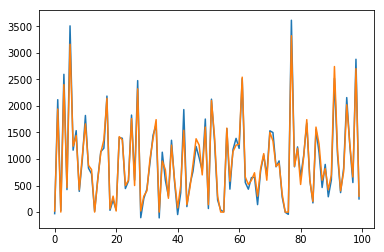

In [23]:
plt.plot(out.data[100:200].numpy())
plt.plot(out1[100:200])

# 

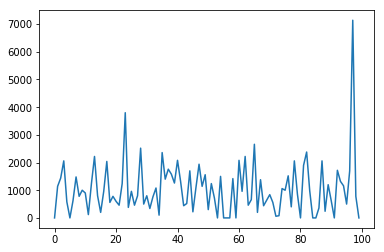

In [96]:
plt.plot(train_y[:100])


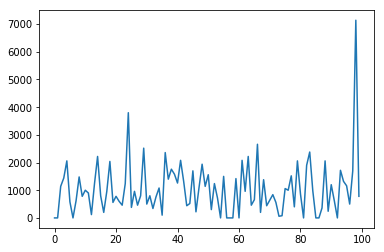

In [94]:
plt.plot(train_x[:100, 1])

In [93]:
train_x.shape

(2589, 5)

In [178]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn import model_selection

In [198]:
mlp = MLPRegressor()
mlp = mlp.fit(train_x, train_y)
out = mlp.predict(test_x)

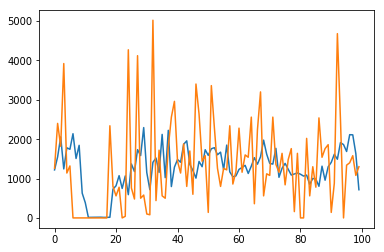

In [199]:
plt.plot(out[:100])
plt.plot(test_y[:100])